## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10685230746529639059
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6892342477
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2187601359661111915
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_decoder_zeros
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

from attention_keras.layers.attention import AttentionLayer

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_decoder_zeros_attention_1-32'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 32 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(len_delay, 3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_1, decoder_outputs_1])
decoder_concat_input = Concatenate()([decoder_outputs_1, attn_out])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_concat_input)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def smape(y_true, y_pred):
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_true) + K.abs(y_pred)))

def mfe(y_true, y_pred):
    return K.mean(y_pred - y_true)

model.compile(loss='mae', optimizer="adam", metrics=[rmse, smape, mfe])

print(model.summary())

(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 3)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 32), (No 4736        input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        [(None, 10, 32), (No 4736        input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][

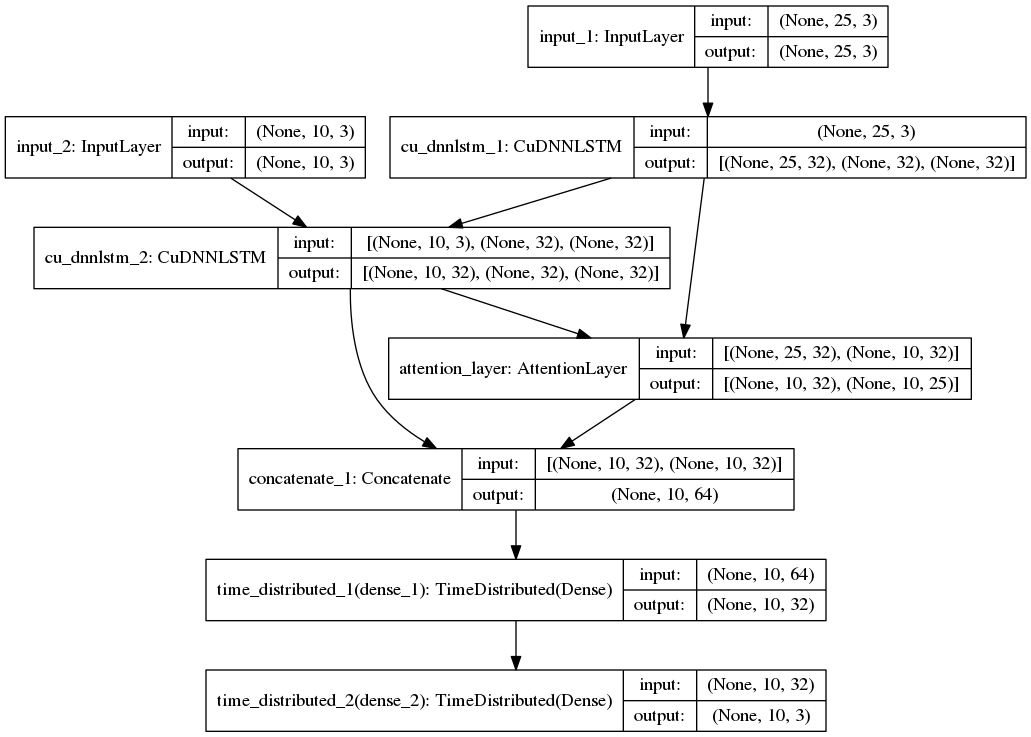

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 100
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

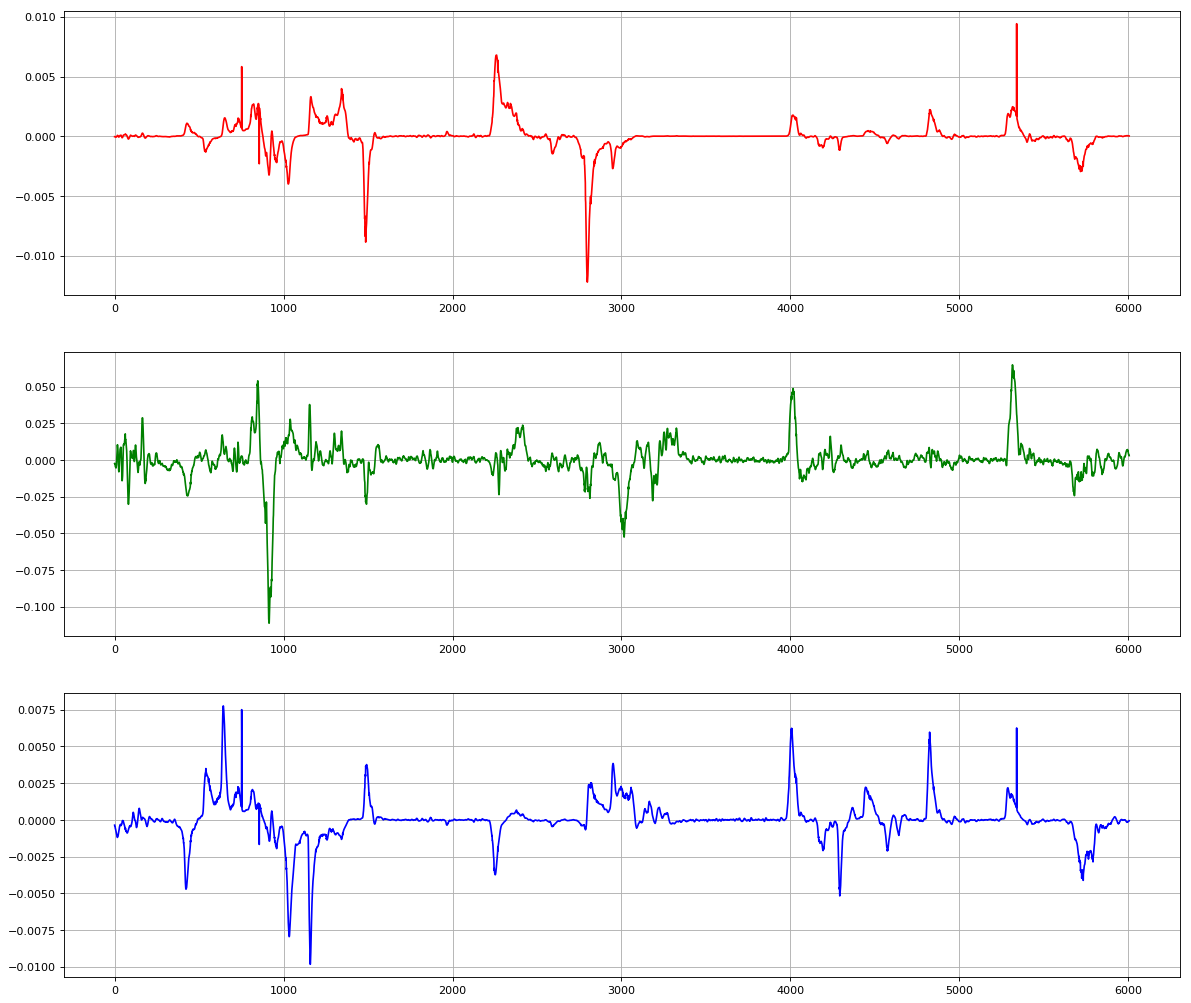

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/100


  1/542 [..............................] - ETA: 9:34 - loss: 0.0289 - rmse: 0.0904 - smape: 91.5948 - mfe: -4.7218e-04

  2/542 [..............................] - ETA: 5:02 - loss: 0.0782 - rmse: 0.2100 - smape: 88.2427 - mfe: 4.4526e-04 

  3/542 [..............................] - ETA: 3:32 - loss: 0.0673 - rmse: 0.1779 - smape: 87.6309 - mfe: 9.7415e-05

  4/542 [..............................] - ETA: 2:47 - loss: 0.0715 - rmse: 0.1855 - smape: 87.2969 - mfe: 4.2051e-06

  5/542 [..............................] - ETA: 2:18 - loss: 0.0749 - rmse: 0.1872 - smape: 87.1367 - mfe: 9.7048e-05

  6/542 [..............................] - ETA: 2:00 - loss: 0.0744 - rmse: 0.1867 - smape: 86.6837 - mfe: -7.0934e-05

  7/542 [..............................] - ETA: 1:48 - loss: 0.0740 - rmse: 0.1886 - smape: 86.6275 - mfe: -2.4927e-05

  8/542 [..............................] - ETA: 1:38 - loss: 0.0731 - rmse: 0.1863 - smape: 86.6237 - mfe: 6.3709e-05 

  9/542 [..............................] - ETA: 1:30 - loss: 0.0735 - rmse: 0.1914 - smape: 86.8076 - mfe: 4.0794e-04

 11/542 [..............................] - ETA: 1:18 - loss: 0.0733 - rmse: 0.1991 - smape: 86.4329 - mfe: 7.1048e-05

 12/542 [..............................] - ETA: 1:14 - loss: 0.0739 - rmse: 0.1982 - smape: 86.5176 - mfe: -9.5129e-05

 13/542 [..............................] - ETA: 1:11 - loss: 0.0738 - rmse: 0.1968 - smape: 86.6571 - mfe: -1.1687e-04

 14/542 [..............................] - ETA: 1:08 - loss: 0.0701 - rmse: 0.1882 - smape: 86.5090 - mfe: -1.0086e-04

 15/542 [..............................] - ETA: 1:05 - loss: 0.0715 - rmse: 0.1901 - smape: 86.3130 - mfe: -9.4727e-05

 16/542 [..............................] - ETA: 1:03 - loss: 0.0748 - rmse: 0.1979 - smape: 86.1153 - mfe: -7.3232e-05

 17/542 [..............................] - ETA: 1:01 - loss: 0.0742 - rmse: 0.1968 - smape: 86.0077 - mfe: 1.0503e-05 

 19/542 [>.............................] - ETA: 57s - loss: 0.0739 - rmse: 0.1960 - smape: 85.8006 - mfe: -1.7833e-04

 20/542 [>.............................] - ETA: 56s - loss: 0.0737 - rmse: 0.1974 - smape: 85.7033 - mfe: -1.1608e-04

 21/542 [>.............................] - ETA: 54s - loss: 0.0714 - rmse: 0.1924 - smape: 85.4871 - mfe: -6.1905e-05

 22/542 [>.............................] - ETA: 53s - loss: 0.0709 - rmse: 0.1908 - smape: 85.4281 - mfe: -1.6932e-04

 23/542 [>.............................] - ETA: 52s - loss: 0.0687 - rmse: 0.1851 - smape: 85.2605 - mfe: -1.5384e-04

 24/542 [>.............................] - ETA: 51s - loss: 0.0687 - rmse: 0.1842 - smape: 85.2558 - mfe: -7.1827e-05

 26/542 [>.............................] - ETA: 49s - loss: 0.0685 - rmse: 0.1837 - smape: 85.2015 - mfe: -6.6741e-05

 27/542 [>.............................] - ETA: 48s - loss: 0.0680 - rmse: 0.1826 - smape: 85.1536 - mfe: 1.3757e-05 

 28/542 [>.............................] - ETA: 47s - loss: 0.0676 - rmse: 0.1844 - smape: 85.0358 - mfe: 8.1988e-05

 29/542 [>.............................] - ETA: 46s - loss: 0.0678 - rmse: 0.1844 - smape: 85.0514 - mfe: 1.2704e-04

 31/542 [>.............................] - ETA: 45s - loss: 0.0666 - rmse: 0.1819 - smape: 85.1048 - mfe: 1.4515e-04

 32/542 [>.............................] - ETA: 44s - loss: 0.0648 - rmse: 0.1769 - smape: 85.0516 - mfe: 1.0229e-04

 33/542 [>.............................] - ETA: 44s - loss: 0.0644 - rmse: 0.1765 - smape: 85.0154 - mfe: 2.7489e-05

 34/542 [>.............................] - ETA: 43s - loss: 0.0652 - rmse: 0.1798 - smape: 84.9229 - mfe: -1.8967e-05

 35/542 [>.............................] - ETA: 43s - loss: 0.0642 - rmse: 0.1768 - smape: 84.9447 - mfe: -6.0354e-06

 36/542 [>.............................] - ETA: 42s - loss: 0.0655 - rmse: 0.1797 - smape: 84.9782 - mfe: -6.3867e-06

 37/542 [=>............................] - ETA: 42s - loss: 0.0655 - rmse: 0.1796 - smape: 84.8888 - mfe: -2.2344e-05

 38/542 [=>............................] - ETA: 41s - loss: 0.0648 - rmse: 0.1774 - smape: 84.8852 - mfe: -5.0979e-05

 39/542 [=>............................] - ETA: 41s - loss: 0.0644 - rmse: 0.1758 - smape: 84.9259 - mfe: -1.0747e-04

 40/542 [=>............................] - ETA: 41s - loss: 0.0645 - rmse: 0.1756 - smape: 84.9950 - mfe: -1.3906e-04

 41/542 [=>............................] - ETA: 40s - loss: 0.0662 - rmse: 0.1800 - smape: 84.9443 - mfe: -1.2179e-04

 42/542 [=>............................] - ETA: 40s - loss: 0.0661 - rmse: 0.1793 - smape: 84.8734 - mfe: -1.1513e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0679 - rmse: 0.1828 - smape: 84.8629 - mfe: -6.4859e-05

 44/542 [=>............................] - ETA: 39s - loss: 0.0672 - rmse: 0.1807 - smape: 84.8080 - mfe: -4.6939e-05

 45/542 [=>............................] - ETA: 39s - loss: 0.0667 - rmse: 0.1798 - smape: 84.7723 - mfe: -3.5064e-05

 46/542 [=>............................] - ETA: 38s - loss: 0.0656 - rmse: 0.1775 - smape: 84.7357 - mfe: 5.8949e-05 

 47/542 [=>............................] - ETA: 38s - loss: 0.0662 - rmse: 0.1788 - smape: 84.7357 - mfe: 1.3292e-05

 48/542 [=>............................] - ETA: 38s - loss: 0.0656 - rmse: 0.1774 - smape: 84.6051 - mfe: -1.0097e-05

 49/542 [=>............................] - ETA: 38s - loss: 0.0662 - rmse: 0.1800 - smape: 84.5223 - mfe: -1.4171e-05

 50/542 [=>............................] - ETA: 37s - loss: 0.0664 - rmse: 0.1808 - smape: 84.4750 - mfe: -7.5088e-05

 52/542 [=>............................] - ETA: 37s - loss: 0.0666 - rmse: 0.1813 - smape: 84.5256 - mfe: -2.4583e-04

 53/542 [=>............................] - ETA: 36s - loss: 0.0667 - rmse: 0.1817 - smape: 84.4775 - mfe: -2.4274e-04

 54/542 [=>............................] - ETA: 36s - loss: 0.0666 - rmse: 0.1811 - smape: 84.4532 - mfe: -2.5194e-04

 55/542 [==>...........................] - ETA: 36s - loss: 0.0661 - rmse: 0.1797 - smape: 84.4293 - mfe: -2.4542e-04

 56/542 [==>...........................] - ETA: 36s - loss: 0.0659 - rmse: 0.1799 - smape: 84.3588 - mfe: -2.5799e-04

 57/542 [==>...........................] - ETA: 36s - loss: 0.0667 - rmse: 0.1813 - smape: 84.3394 - mfe: -2.9134e-04

 58/542 [==>...........................] - ETA: 35s - loss: 0.0669 - rmse: 0.1817 - smape: 84.2991 - mfe: -2.6861e-04

 59/542 [==>...........................] - ETA: 35s - loss: 0.0666 - rmse: 0.1813 - smape: 84.2890 - mfe: -2.6391e-04

 60/542 [==>...........................] - ETA: 35s - loss: 0.0668 - rmse: 0.1816 - smape: 84.3247 - mfe: -2.5690e-04

 61/542 [==>...........................] - ETA: 35s - loss: 0.0667 - rmse: 0.1814 - smape: 84.3027 - mfe: -2.3489e-04

 62/542 [==>...........................] - ETA: 35s - loss: 0.0673 - rmse: 0.1831 - smape: 84.2711 - mfe: -2.4309e-04

 63/542 [==>...........................] - ETA: 34s - loss: 0.0685 - rmse: 0.1872 - smape: 84.1977 - mfe: -1.5597e-04

 64/542 [==>...........................] - ETA: 34s - loss: 0.0681 - rmse: 0.1858 - smape: 84.2226 - mfe: -1.9232e-04

 65/542 [==>...........................] - ETA: 34s - loss: 0.0687 - rmse: 0.1875 - smape: 84.1770 - mfe: -2.3591e-04

 66/542 [==>...........................] - ETA: 34s - loss: 0.0696 - rmse: 0.1903 - smape: 84.1411 - mfe: -2.4654e-04

 67/542 [==>...........................] - ETA: 34s - loss: 0.0700 - rmse: 0.1906 - smape: 84.1436 - mfe: -3.0921e-04

 68/542 [==>...........................] - ETA: 33s - loss: 0.0701 - rmse: 0.1910 - smape: 84.1216 - mfe: -3.4406e-04

 69/542 [==>...........................] - ETA: 33s - loss: 0.0700 - rmse: 0.1914 - smape: 84.0876 - mfe: -3.6684e-04

 70/542 [==>...........................] - ETA: 33s - loss: 0.0700 - rmse: 0.1910 - smape: 84.0561 - mfe: -4.0057e-04

 71/542 [==>...........................] - ETA: 33s - loss: 0.0699 - rmse: 0.1907 - smape: 84.0451 - mfe: -3.7779e-04

 72/542 [==>...........................] - ETA: 33s - loss: 0.0696 - rmse: 0.1895 - smape: 84.0251 - mfe: -3.7118e-04

 73/542 [===>..........................] - ETA: 33s - loss: 0.0693 - rmse: 0.1889 - smape: 83.9945 - mfe: -3.4618e-04

 74/542 [===>..........................] - ETA: 33s - loss: 0.0685 - rmse: 0.1867 - smape: 83.9376 - mfe: -3.6600e-04

 75/542 [===>..........................] - ETA: 32s - loss: 0.0684 - rmse: 0.1867 - smape: 83.8865 - mfe: -3.5312e-04

 76/542 [===>..........................] - ETA: 32s - loss: 0.0681 - rmse: 0.1862 - smape: 83.8568 - mfe: -2.9985e-04

 77/542 [===>..........................] - ETA: 32s - loss: 0.0680 - rmse: 0.1862 - smape: 83.8225 - mfe: -3.1346e-04

 78/542 [===>..........................] - ETA: 32s - loss: 0.0692 - rmse: 0.1888 - smape: 83.7852 - mfe: -3.4625e-04

 79/542 [===>..........................] - ETA: 32s - loss: 0.0689 - rmse: 0.1887 - smape: 83.7299 - mfe: -3.8955e-04

 80/542 [===>..........................] - ETA: 32s - loss: 0.0682 - rmse: 0.1871 - smape: 83.6513 - mfe: -3.8199e-04

 81/542 [===>..........................] - ETA: 32s - loss: 0.0681 - rmse: 0.1871 - smape: 83.5993 - mfe: -3.3449e-04

 82/542 [===>..........................] - ETA: 31s - loss: 0.0681 - rmse: 0.1873 - smape: 83.5283 - mfe: -2.5375e-04

 83/542 [===>..........................] - ETA: 31s - loss: 0.0683 - rmse: 0.1874 - smape: 83.5085 - mfe: -2.0650e-04

 84/542 [===>..........................] - ETA: 31s - loss: 0.0684 - rmse: 0.1876 - smape: 83.4859 - mfe: -1.8885e-04

 85/542 [===>..........................] - ETA: 31s - loss: 0.0682 - rmse: 0.1876 - smape: 83.4628 - mfe: -1.9559e-04

 86/542 [===>..........................] - ETA: 31s - loss: 0.0680 - rmse: 0.1868 - smape: 83.4061 - mfe: -2.2159e-04

 87/542 [===>..........................] - ETA: 31s - loss: 0.0679 - rmse: 0.1863 - smape: 83.3477 - mfe: -2.7805e-04

 88/542 [===>..........................] - ETA: 31s - loss: 0.0673 - rmse: 0.1846 - smape: 83.2818 - mfe: -3.3892e-04

 89/542 [===>..........................] - ETA: 31s - loss: 0.0670 - rmse: 0.1841 - smape: 83.2601 - mfe: -3.6704e-04

 90/542 [===>..........................] - ETA: 30s - loss: 0.0667 - rmse: 0.1832 - smape: 83.2424 - mfe: -3.2703e-04

 91/542 [====>.........................] - ETA: 30s - loss: 0.0670 - rmse: 0.1840 - smape: 83.2039 - mfe: -2.7221e-04

 93/542 [====>.........................] - ETA: 30s - loss: 0.0672 - rmse: 0.1851 - smape: 83.1699 - mfe: -1.6868e-04

 94/542 [====>.........................] - ETA: 30s - loss: 0.0667 - rmse: 0.1836 - smape: 83.1621 - mfe: -1.3299e-04

 95/542 [====>.........................] - ETA: 30s - loss: 0.0666 - rmse: 0.1834 - smape: 83.1429 - mfe: -1.3921e-04

 96/542 [====>.........................] - ETA: 30s - loss: 0.0672 - rmse: 0.1847 - smape: 83.1357 - mfe: -1.7356e-04

 97/542 [====>.........................] - ETA: 30s - loss: 0.0673 - rmse: 0.1855 - smape: 83.1214 - mfe: -2.5020e-04

 98/542 [====>.........................] - ETA: 29s - loss: 0.0670 - rmse: 0.1849 - smape: 83.0777 - mfe: -3.0161e-04

 99/542 [====>.........................] - ETA: 29s - loss: 0.0670 - rmse: 0.1846 - smape: 83.0403 - mfe: -3.4634e-04

100/542 [====>.........................] - ETA: 29s - loss: 0.0670 - rmse: 0.1843 - smape: 83.0243 - mfe: -3.5749e-04

101/542 [====>.........................] - ETA: 29s - loss: 0.0666 - rmse: 0.1831 - smape: 83.0290 - mfe: -3.5267e-04

102/542 [====>.........................] - ETA: 29s - loss: 0.0661 - rmse: 0.1817 - smape: 83.0181 - mfe: -3.4533e-04

103/542 [====>.........................] - ETA: 29s - loss: 0.0660 - rmse: 0.1813 - smape: 83.0092 - mfe: -3.0292e-04

104/542 [====>.........................] - ETA: 29s - loss: 0.0656 - rmse: 0.1800 - smape: 83.0070 - mfe: -2.7626e-04

105/542 [====>.........................] - ETA: 29s - loss: 0.0652 - rmse: 0.1787 - smape: 82.9848 - mfe: -2.6191e-04

106/542 [====>.........................] - ETA: 29s - loss: 0.0654 - rmse: 0.1793 - smape: 82.9837 - mfe: -2.6014e-04

107/542 [====>.........................] - ETA: 29s - loss: 0.0652 - rmse: 0.1793 - smape: 82.9309 - mfe: -2.7219e-04

108/542 [====>.........................] - ETA: 28s - loss: 0.0654 - rmse: 0.1802 - smape: 82.8990 - mfe: -2.8400e-04

109/542 [=====>........................] - ETA: 28s - loss: 0.0654 - rmse: 0.1803 - smape: 82.8783 - mfe: -2.8221e-04

110/542 [=====>........................] - ETA: 28s - loss: 0.0654 - rmse: 0.1799 - smape: 82.8689 - mfe: -2.9738e-04

111/542 [=====>........................] - ETA: 28s - loss: 0.0652 - rmse: 0.1791 - smape: 82.8314 - mfe: -3.1654e-04

112/542 [=====>........................] - ETA: 28s - loss: 0.0649 - rmse: 0.1787 - smape: 82.7766 - mfe: -3.5179e-04

113/542 [=====>........................] - ETA: 28s - loss: 0.0649 - rmse: 0.1788 - smape: 82.7419 - mfe: -3.8865e-04

114/542 [=====>........................] - ETA: 28s - loss: 0.0651 - rmse: 0.1796 - smape: 82.7195 - mfe: -4.1969e-04

115/542 [=====>........................] - ETA: 28s - loss: 0.0647 - rmse: 0.1785 - smape: 82.6918 - mfe: -4.3925e-04

116/542 [=====>........................] - ETA: 28s - loss: 0.0652 - rmse: 0.1802 - smape: 82.6605 - mfe: -4.1115e-04

117/542 [=====>........................] - ETA: 28s - loss: 0.0648 - rmse: 0.1790 - smape: 82.6652 - mfe: -3.7166e-04

118/542 [=====>........................] - ETA: 27s - loss: 0.0646 - rmse: 0.1786 - smape: 82.6236 - mfe: -3.6586e-04

119/542 [=====>........................] - ETA: 27s - loss: 0.0645 - rmse: 0.1782 - smape: 82.6262 - mfe: -3.7254e-04

120/542 [=====>........................] - ETA: 27s - loss: 0.0644 - rmse: 0.1781 - smape: 82.5831 - mfe: -3.7765e-04

121/542 [=====>........................] - ETA: 27s - loss: 0.0642 - rmse: 0.1775 - smape: 82.5658 - mfe: -3.9786e-04

122/542 [=====>........................] - ETA: 27s - loss: 0.0643 - rmse: 0.1778 - smape: 82.5564 - mfe: -4.0307e-04

123/542 [=====>........................] - ETA: 27s - loss: 0.0645 - rmse: 0.1784 - smape: 82.5479 - mfe: -3.6251e-04

125/542 [=====>........................] - ETA: 27s - loss: 0.0653 - rmse: 0.1809 - smape: 82.5210 - mfe: -3.1254e-04

126/542 [=====>........................] - ETA: 27s - loss: 0.0651 - rmse: 0.1802 - smape: 82.5173 - mfe: -2.9131e-04

127/542 [======>.......................] - ETA: 27s - loss: 0.0651 - rmse: 0.1802 - smape: 82.5015 - mfe: -3.0044e-04

128/542 [======>.......................] - ETA: 26s - loss: 0.0649 - rmse: 0.1796 - smape: 82.4664 - mfe: -3.2381e-04

130/542 [======>.......................] - ETA: 26s - loss: 0.0654 - rmse: 0.1808 - smape: 82.4151 - mfe: -4.0547e-04

131/542 [======>.......................] - ETA: 26s - loss: 0.0653 - rmse: 0.1802 - smape: 82.4012 - mfe: -4.3700e-04

132/542 [======>.......................] - ETA: 26s - loss: 0.0653 - rmse: 0.1805 - smape: 82.3737 - mfe: -4.2900e-04

133/542 [======>.......................] - ETA: 26s - loss: 0.0651 - rmse: 0.1798 - smape: 82.3549 - mfe: -4.0803e-04

134/542 [======>.......................] - ETA: 26s - loss: 0.0652 - rmse: 0.1799 - smape: 82.3337 - mfe: -3.9544e-04

135/542 [======>.......................] - ETA: 26s - loss: 0.0651 - rmse: 0.1796 - smape: 82.2864 - mfe: -3.7085e-04

136/542 [======>.......................] - ETA: 26s - loss: 0.0648 - rmse: 0.1789 - smape: 82.2233 - mfe: -3.4355e-04

137/542 [======>.......................] - ETA: 26s - loss: 0.0649 - rmse: 0.1794 - smape: 82.1860 - mfe: -3.5870e-04

138/542 [======>.......................] - ETA: 26s - loss: 0.0652 - rmse: 0.1803 - smape: 82.1570 - mfe: -4.0286e-04

139/542 [======>.......................] - ETA: 26s - loss: 0.0652 - rmse: 0.1804 - smape: 82.1464 - mfe: -4.2912e-04

140/542 [======>.......................] - ETA: 25s - loss: 0.0649 - rmse: 0.1794 - smape: 82.1433 - mfe: -4.3040e-04

141/542 [======>.......................] - ETA: 25s - loss: 0.0648 - rmse: 0.1790 - smape: 82.1445 - mfe: -4.1832e-04

142/542 [======>.......................] - ETA: 25s - loss: 0.0646 - rmse: 0.1782 - smape: 82.1412 - mfe: -3.9234e-04

143/542 [======>.......................] - ETA: 25s - loss: 0.0643 - rmse: 0.1773 - smape: 82.1447 - mfe: -3.6368e-04

144/542 [======>.......................] - ETA: 25s - loss: 0.0642 - rmse: 0.1773 - smape: 82.1529 - mfe: -3.6214e-04

146/542 [=======>......................] - ETA: 25s - loss: 0.0642 - rmse: 0.1774 - smape: 82.1325 - mfe: -3.8938e-04

147/542 [=======>......................] - ETA: 25s - loss: 0.0641 - rmse: 0.1773 - smape: 82.1044 - mfe: -4.1366e-04

148/542 [=======>......................] - ETA: 25s - loss: 0.0641 - rmse: 0.1771 - smape: 82.0997 - mfe: -4.3327e-04

149/542 [=======>......................] - ETA: 25s - loss: 0.0643 - rmse: 0.1775 - smape: 82.0773 - mfe: -4.4471e-04

150/542 [=======>......................] - ETA: 25s - loss: 0.0641 - rmse: 0.1769 - smape: 82.0755 - mfe: -4.4077e-04

151/542 [=======>......................] - ETA: 25s - loss: 0.0640 - rmse: 0.1768 - smape: 82.0850 - mfe: -4.3359e-04

152/542 [=======>......................] - ETA: 24s - loss: 0.0638 - rmse: 0.1761 - smape: 82.0601 - mfe: -4.1258e-04

153/542 [=======>......................] - ETA: 24s - loss: 0.0638 - rmse: 0.1763 - smape: 82.0569 - mfe: -4.0556e-04

154/542 [=======>......................] - ETA: 24s - loss: 0.0635 - rmse: 0.1759 - smape: 82.0500 - mfe: -4.1006e-04

155/542 [=======>......................] - ETA: 24s - loss: 0.0635 - rmse: 0.1756 - smape: 82.0399 - mfe: -4.3500e-04

156/542 [=======>......................] - ETA: 24s - loss: 0.0635 - rmse: 0.1761 - smape: 82.0152 - mfe: -4.4472e-04

157/542 [=======>......................] - ETA: 24s - loss: 0.0634 - rmse: 0.1758 - smape: 81.9941 - mfe: -4.5458e-04

158/542 [=======>......................] - ETA: 24s - loss: 0.0633 - rmse: 0.1755 - smape: 81.9917 - mfe: -4.6596e-04

159/542 [=======>......................] - ETA: 24s - loss: 0.0633 - rmse: 0.1754 - smape: 82.0015 - mfe: -4.6133e-04

160/542 [=======>......................] - ETA: 24s - loss: 0.0633 - rmse: 0.1755 - smape: 81.9812 - mfe: -4.5256e-04

162/542 [=======>......................] - ETA: 24s - loss: 0.0637 - rmse: 0.1767 - smape: 81.9404 - mfe: -3.9389e-04

163/542 [========>.....................] - ETA: 24s - loss: 0.0635 - rmse: 0.1762 - smape: 81.9338 - mfe: -3.9540e-04

165/542 [========>.....................] - ETA: 23s - loss: 0.0634 - rmse: 0.1760 - smape: 81.9177 - mfe: -4.0774e-04

166/542 [========>.....................] - ETA: 23s - loss: 0.0634 - rmse: 0.1758 - smape: 81.9104 - mfe: -4.3404e-04

167/542 [========>.....................] - ETA: 23s - loss: 0.0633 - rmse: 0.1754 - smape: 81.9063 - mfe: -4.5053e-04

168/542 [========>.....................] - ETA: 23s - loss: 0.0631 - rmse: 0.1748 - smape: 81.8815 - mfe: -4.4901e-04

169/542 [========>.....................] - ETA: 23s - loss: 0.0631 - rmse: 0.1749 - smape: 81.8731 - mfe: -4.3066e-04

170/542 [========>.....................] - ETA: 23s - loss: 0.0632 - rmse: 0.1752 - smape: 81.8564 - mfe: -4.0435e-04

171/542 [========>.....................] - ETA: 23s - loss: 0.0630 - rmse: 0.1745 - smape: 81.8487 - mfe: -3.9438e-04

172/542 [========>.....................] - ETA: 23s - loss: 0.0626 - rmse: 0.1737 - smape: 81.8372 - mfe: -3.9871e-04

173/542 [========>.....................] - ETA: 23s - loss: 0.0625 - rmse: 0.1734 - smape: 81.8284 - mfe: -3.9260e-04

174/542 [========>.....................] - ETA: 23s - loss: 0.0623 - rmse: 0.1729 - smape: 81.8187 - mfe: -3.8278e-04

175/542 [========>.....................] - ETA: 23s - loss: 0.0625 - rmse: 0.1733 - smape: 81.8142 - mfe: -3.7288e-04

176/542 [========>.....................] - ETA: 23s - loss: 0.0622 - rmse: 0.1725 - smape: 81.8089 - mfe: -3.6567e-04

177/542 [========>.....................] - ETA: 23s - loss: 0.0622 - rmse: 0.1727 - smape: 81.7977 - mfe: -3.5676e-04

178/542 [========>.....................] - ETA: 22s - loss: 0.0622 - rmse: 0.1724 - smape: 81.8073 - mfe: -3.5739e-04

179/542 [========>.....................] - ETA: 22s - loss: 0.0620 - rmse: 0.1718 - smape: 81.8038 - mfe: -3.6128e-04

180/542 [========>.....................] - ETA: 22s - loss: 0.0621 - rmse: 0.1719 - smape: 81.8040 - mfe: -3.5761e-04

181/542 [=========>....................] - ETA: 22s - loss: 0.0621 - rmse: 0.1718 - smape: 81.8130 - mfe: -3.6323e-04

182/542 [=========>....................] - ETA: 22s - loss: 0.0620 - rmse: 0.1719 - smape: 81.7960 - mfe: -3.4922e-04

183/542 [=========>....................] - ETA: 22s - loss: 0.0621 - rmse: 0.1721 - smape: 81.8104 - mfe: -3.4625e-04

184/542 [=========>....................] - ETA: 22s - loss: 0.0621 - rmse: 0.1722 - smape: 81.8057 - mfe: -3.4190e-04

185/542 [=========>....................] - ETA: 22s - loss: 0.0620 - rmse: 0.1718 - smape: 81.8016 - mfe: -3.4647e-04

186/542 [=========>....................] - ETA: 22s - loss: 0.0618 - rmse: 0.1712 - smape: 81.7983 - mfe: -3.5722e-04

188/542 [=========>....................] - ETA: 22s - loss: 0.0615 - rmse: 0.1704 - smape: 81.8013 - mfe: -3.4315e-04

190/542 [=========>....................] - ETA: 22s - loss: 0.0614 - rmse: 0.1704 - smape: 81.8206 - mfe: -3.2048e-04

191/542 [=========>....................] - ETA: 21s - loss: 0.0614 - rmse: 0.1702 - smape: 81.8253 - mfe: -3.1774e-04

192/542 [=========>....................] - ETA: 21s - loss: 0.0613 - rmse: 0.1700 - smape: 81.8221 - mfe: -3.2727e-04

193/542 [=========>....................] - ETA: 21s - loss: 0.0612 - rmse: 0.1696 - smape: 81.7985 - mfe: -3.3840e-04

194/542 [=========>....................] - ETA: 21s - loss: 0.0611 - rmse: 0.1695 - smape: 81.7755 - mfe: -3.5254e-04

195/542 [=========>....................] - ETA: 21s - loss: 0.0611 - rmse: 0.1696 - smape: 81.7772 - mfe: -3.6142e-04

196/542 [=========>....................] - ETA: 21s - loss: 0.0612 - rmse: 0.1699 - smape: 81.7775 - mfe: -3.5611e-04

197/542 [=========>....................] - ETA: 21s - loss: 0.0613 - rmse: 0.1701 - smape: 81.7679 - mfe: -3.3651e-04

198/542 [=========>....................] - ETA: 21s - loss: 0.0612 - rmse: 0.1700 - smape: 81.7444 - mfe: -2.9344e-04

199/542 [==========>...................] - ETA: 21s - loss: 0.0614 - rmse: 0.1703 - smape: 81.7471 - mfe: -2.8299e-04

200/542 [==========>...................] - ETA: 21s - loss: 0.0614 - rmse: 0.1703 - smape: 81.7423 - mfe: -2.7059e-04

201/542 [==========>...................] - ETA: 21s - loss: 0.0612 - rmse: 0.1699 - smape: 81.7413 - mfe: -2.7747e-04

202/542 [==========>...................] - ETA: 21s - loss: 0.0611 - rmse: 0.1695 - smape: 81.7502 - mfe: -2.8307e-04

203/542 [==========>...................] - ETA: 21s - loss: 0.0612 - rmse: 0.1696 - smape: 81.7355 - mfe: -3.0151e-04

204/542 [==========>...................] - ETA: 21s - loss: 0.0612 - rmse: 0.1698 - smape: 81.7372 - mfe: -3.0273e-04

205/542 [==========>...................] - ETA: 20s - loss: 0.0610 - rmse: 0.1692 - smape: 81.7350 - mfe: -3.0479e-04

206/542 [==========>...................] - ETA: 20s - loss: 0.0611 - rmse: 0.1691 - smape: 81.7488 - mfe: -3.0294e-04

207/542 [==========>...................] - ETA: 20s - loss: 0.0610 - rmse: 0.1692 - smape: 81.7344 - mfe: -2.7344e-04

208/542 [==========>...................] - ETA: 20s - loss: 0.0610 - rmse: 0.1689 - smape: 81.7437 - mfe: -2.6631e-04

209/542 [==========>...................] - ETA: 20s - loss: 0.0609 - rmse: 0.1687 - smape: 81.7544 - mfe: -2.6556e-04

210/542 [==========>...................] - ETA: 20s - loss: 0.0610 - rmse: 0.1687 - smape: 81.7513 - mfe: -2.6274e-04

212/542 [==========>...................] - ETA: 20s - loss: 0.0612 - rmse: 0.1691 - smape: 81.7597 - mfe: -2.5785e-04

213/542 [==========>...................] - ETA: 20s - loss: 0.0614 - rmse: 0.1694 - smape: 81.7541 - mfe: -2.4488e-04

214/542 [==========>...................] - ETA: 20s - loss: 0.0615 - rmse: 0.1698 - smape: 81.7361 - mfe: -2.2096e-04

216/542 [==========>...................] - ETA: 20s - loss: 0.0614 - rmse: 0.1694 - smape: 81.7178 - mfe: -2.0152e-04

217/542 [===========>..................] - ETA: 20s - loss: 0.0615 - rmse: 0.1697 - smape: 81.7053 - mfe: -2.0143e-04

218/542 [===========>..................] - ETA: 20s - loss: 0.0615 - rmse: 0.1696 - smape: 81.6953 - mfe: -2.2089e-04

219/542 [===========>..................] - ETA: 19s - loss: 0.0614 - rmse: 0.1694 - smape: 81.6929 - mfe: -2.3848e-04

220/542 [===========>..................] - ETA: 19s - loss: 0.0614 - rmse: 0.1693 - smape: 81.6863 - mfe: -2.5121e-04

221/542 [===========>..................] - ETA: 19s - loss: 0.0613 - rmse: 0.1690 - smape: 81.6746 - mfe: -2.6146e-04

222/542 [===========>..................] - ETA: 19s - loss: 0.0612 - rmse: 0.1686 - smape: 81.6679 - mfe: -2.7042e-04

223/542 [===========>..................] - ETA: 19s - loss: 0.0613 - rmse: 0.1688 - smape: 81.6555 - mfe: -2.7132e-04

224/542 [===========>..................] - ETA: 19s - loss: 0.0614 - rmse: 0.1690 - smape: 81.6603 - mfe: -2.7334e-04

225/542 [===========>..................] - ETA: 19s - loss: 0.0613 - rmse: 0.1688 - smape: 81.6578 - mfe: -2.7840e-04

226/542 [===========>..................] - ETA: 19s - loss: 0.0617 - rmse: 0.1697 - smape: 81.6630 - mfe: -2.6101e-04

227/542 [===========>..................] - ETA: 19s - loss: 0.0616 - rmse: 0.1694 - smape: 81.6696 - mfe: -2.4861e-04

228/542 [===========>..................] - ETA: 19s - loss: 0.0615 - rmse: 0.1690 - smape: 81.6596 - mfe: -2.3279e-04

229/542 [===========>..................] - ETA: 19s - loss: 0.0615 - rmse: 0.1689 - smape: 81.6572 - mfe: -2.3056e-04

230/542 [===========>..................] - ETA: 19s - loss: 0.0614 - rmse: 0.1686 - smape: 81.6537 - mfe: -2.1389e-04

231/542 [===========>..................] - ETA: 19s - loss: 0.0614 - rmse: 0.1688 - smape: 81.6552 - mfe: -2.1313e-04

232/542 [===========>..................] - ETA: 19s - loss: 0.0614 - rmse: 0.1687 - smape: 81.6492 - mfe: -2.2293e-04

233/542 [===========>..................] - ETA: 19s - loss: 0.0613 - rmse: 0.1686 - smape: 81.6505 - mfe: -2.3633e-04

234/542 [===========>..................] - ETA: 18s - loss: 0.0616 - rmse: 0.1691 - smape: 81.6411 - mfe: -2.6134e-04

235/542 [============>.................] - ETA: 18s - loss: 0.0614 - rmse: 0.1685 - smape: 81.6299 - mfe: -2.8856e-04

236/542 [============>.................] - ETA: 18s - loss: 0.0614 - rmse: 0.1685 - smape: 81.6305 - mfe: -2.9914e-04

237/542 [============>.................] - ETA: 18s - loss: 0.0614 - rmse: 0.1685 - smape: 81.6260 - mfe: -2.9267e-04

238/542 [============>.................] - ETA: 18s - loss: 0.0612 - rmse: 0.1680 - smape: 81.6167 - mfe: -2.7954e-04

239/542 [============>.................] - ETA: 18s - loss: 0.0610 - rmse: 0.1674 - smape: 81.5946 - mfe: -2.6175e-04

240/542 [============>.................] - ETA: 18s - loss: 0.0610 - rmse: 0.1675 - smape: 81.5959 - mfe: -2.4921e-04

241/542 [============>.................] - ETA: 18s - loss: 0.0608 - rmse: 0.1670 - smape: 81.5766 - mfe: -2.5071e-04

242/542 [============>.................] - ETA: 18s - loss: 0.0607 - rmse: 0.1668 - smape: 81.5680 - mfe: -2.4511e-04

243/542 [============>.................] - ETA: 18s - loss: 0.0606 - rmse: 0.1667 - smape: 81.5694 - mfe: -2.4431e-04

244/542 [============>.................] - ETA: 18s - loss: 0.0606 - rmse: 0.1666 - smape: 81.5681 - mfe: -2.4317e-04

245/542 [============>.................] - ETA: 18s - loss: 0.0608 - rmse: 0.1670 - smape: 81.5567 - mfe: -2.4461e-04

246/542 [============>.................] - ETA: 18s - loss: 0.0609 - rmse: 0.1673 - smape: 81.5468 - mfe: -2.3637e-04

247/542 [============>.................] - ETA: 18s - loss: 0.0608 - rmse: 0.1670 - smape: 81.5533 - mfe: -2.2713e-04

248/542 [============>.................] - ETA: 18s - loss: 0.0608 - rmse: 0.1669 - smape: 81.5440 - mfe: -2.1839e-04

249/542 [============>.................] - ETA: 17s - loss: 0.0607 - rmse: 0.1668 - smape: 81.5233 - mfe: -2.1750e-04

250/542 [============>.................] - ETA: 17s - loss: 0.0607 - rmse: 0.1666 - smape: 81.5171 - mfe: -2.2379e-04

251/542 [============>.................] - ETA: 17s - loss: 0.0606 - rmse: 0.1665 - smape: 81.5080 - mfe: -2.3936e-04

252/542 [============>.................] - ETA: 17s - loss: 0.0606 - rmse: 0.1663 - smape: 81.4867 - mfe: -2.6018e-04

253/542 [=============>................] - ETA: 17s - loss: 0.0606 - rmse: 0.1663 - smape: 81.4758 - mfe: -2.7685e-04

254/542 [=============>................] - ETA: 17s - loss: 0.0604 - rmse: 0.1657 - smape: 81.4651 - mfe: -2.8672e-04

255/542 [=============>................] - ETA: 17s - loss: 0.0603 - rmse: 0.1655 - smape: 81.4696 - mfe: -2.8381e-04

256/542 [=============>................] - ETA: 17s - loss: 0.0604 - rmse: 0.1658 - smape: 81.4601 - mfe: -2.6855e-04

257/542 [=============>................] - ETA: 17s - loss: 0.0604 - rmse: 0.1656 - smape: 81.4601 - mfe: -2.4180e-04

258/542 [=============>................] - ETA: 17s - loss: 0.0602 - rmse: 0.1652 - smape: 81.4676 - mfe: -2.1636e-04

259/542 [=============>................] - ETA: 17s - loss: 0.0601 - rmse: 0.1650 - smape: 81.4579 - mfe: -2.0327e-04

260/542 [=============>................] - ETA: 17s - loss: 0.0602 - rmse: 0.1649 - smape: 81.4557 - mfe: -2.1219e-04

261/542 [=============>................] - ETA: 17s - loss: 0.0602 - rmse: 0.1649 - smape: 81.4350 - mfe: -2.3757e-04

262/542 [=============>................] - ETA: 17s - loss: 0.0601 - rmse: 0.1646 - smape: 81.4186 - mfe: -2.6841e-04

263/542 [=============>................] - ETA: 17s - loss: 0.0600 - rmse: 0.1643 - smape: 81.4050 - mfe: -2.9390e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0600 - rmse: 0.1642 - smape: 81.3823 - mfe: -3.1450e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0599 - rmse: 0.1639 - smape: 81.3650 - mfe: -3.2463e-04

266/542 [=============>................] - ETA: 16s - loss: 0.0598 - rmse: 0.1636 - smape: 81.3565 - mfe: -3.2193e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0599 - rmse: 0.1638 - smape: 81.3485 - mfe: -3.1587e-04

268/542 [=============>................] - ETA: 16s - loss: 0.0600 - rmse: 0.1639 - smape: 81.3319 - mfe: -3.0245e-04

269/542 [=============>................] - ETA: 16s - loss: 0.0601 - rmse: 0.1645 - smape: 81.3184 - mfe: -2.9072e-04

270/542 [=============>................] - ETA: 16s - loss: 0.0602 - rmse: 0.1650 - smape: 81.3124 - mfe: -2.8995e-04

271/542 [==============>...............] - ETA: 16s - loss: 0.0602 - rmse: 0.1649 - smape: 81.3035 - mfe: -3.0398e-04

273/542 [==============>...............] - ETA: 16s - loss: 0.0603 - rmse: 0.1652 - smape: 81.2614 - mfe: -3.2828e-04

274/542 [==============>...............] - ETA: 16s - loss: 0.0602 - rmse: 0.1651 - smape: 81.2621 - mfe: -3.3283e-04

275/542 [==============>...............] - ETA: 16s - loss: 0.0604 - rmse: 0.1655 - smape: 81.2470 - mfe: -3.3447e-04

276/542 [==============>...............] - ETA: 16s - loss: 0.0606 - rmse: 0.1660 - smape: 81.2373 - mfe: -3.2130e-04

277/542 [==============>...............] - ETA: 16s - loss: 0.0607 - rmse: 0.1660 - smape: 81.2349 - mfe: -3.0268e-04

278/542 [==============>...............] - ETA: 16s - loss: 0.0608 - rmse: 0.1664 - smape: 81.2229 - mfe: -2.8676e-04

279/542 [==============>...............] - ETA: 16s - loss: 0.0608 - rmse: 0.1664 - smape: 81.2068 - mfe: -2.7360e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0608 - rmse: 0.1663 - smape: 81.2007 - mfe: -2.6202e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0607 - rmse: 0.1660 - smape: 81.1841 - mfe: -2.5481e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0608 - rmse: 0.1662 - smape: 81.1705 - mfe: -2.5055e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0607 - rmse: 0.1662 - smape: 81.1704 - mfe: -2.5745e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0606 - rmse: 0.1658 - smape: 81.1620 - mfe: -2.6342e-04

286/542 [==============>...............] - ETA: 15s - loss: 0.0607 - rmse: 0.1660 - smape: 81.1503 - mfe: -2.6426e-04

287/542 [==============>...............] - ETA: 15s - loss: 0.0606 - rmse: 0.1659 - smape: 81.1465 - mfe: -2.5422e-04

288/542 [==============>...............] - ETA: 15s - loss: 0.0606 - rmse: 0.1659 - smape: 81.1422 - mfe: -2.4037e-04

289/542 [==============>...............] - ETA: 15s - loss: 0.0607 - rmse: 0.1660 - smape: 81.1429 - mfe: -2.2196e-04

290/542 [===============>..............] - ETA: 15s - loss: 0.0607 - rmse: 0.1660 - smape: 81.1360 - mfe: -2.0775e-04

291/542 [===============>..............] - ETA: 15s - loss: 0.0607 - rmse: 0.1664 - smape: 81.1369 - mfe: -2.0253e-04

292/542 [===============>..............] - ETA: 15s - loss: 0.0608 - rmse: 0.1668 - smape: 81.1401 - mfe: -2.0920e-04

293/542 [===============>..............] - ETA: 15s - loss: 0.0608 - rmse: 0.1666 - smape: 81.1284 - mfe: -2.2446e-04

294/542 [===============>..............] - ETA: 15s - loss: 0.0608 - rmse: 0.1666 - smape: 81.1189 - mfe: -2.4080e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0609 - rmse: 0.1670 - smape: 81.1221 - mfe: -2.5420e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0612 - rmse: 0.1677 - smape: 81.1200 - mfe: -2.4954e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0612 - rmse: 0.1678 - smape: 81.1155 - mfe: -2.3929e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0612 - rmse: 0.1676 - smape: 81.1079 - mfe: -2.2513e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0611 - rmse: 0.1675 - smape: 81.1078 - mfe: -2.1327e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0612 - rmse: 0.1675 - smape: 81.1026 - mfe: -2.0750e-04

301/542 [===============>..............] - ETA: 14s - loss: 0.0613 - rmse: 0.1677 - smape: 81.1057 - mfe: -2.1407e-04

302/542 [===============>..............] - ETA: 14s - loss: 0.0612 - rmse: 0.1676 - smape: 81.0979 - mfe: -2.2311e-04

304/542 [===============>..............] - ETA: 14s - loss: 0.0612 - rmse: 0.1673 - smape: 81.0833 - mfe: -2.3909e-04

305/542 [===============>..............] - ETA: 14s - loss: 0.0611 - rmse: 0.1673 - smape: 81.0717 - mfe: -2.3961e-04

306/542 [===============>..............] - ETA: 14s - loss: 0.0612 - rmse: 0.1676 - smape: 81.0767 - mfe: -2.3298e-04

307/542 [===============>..............] - ETA: 14s - loss: 0.0613 - rmse: 0.1679 - smape: 81.0707 - mfe: -2.2727e-04

308/542 [================>.............] - ETA: 14s - loss: 0.0615 - rmse: 0.1682 - smape: 81.0610 - mfe: -2.2806e-04

309/542 [================>.............] - ETA: 14s - loss: 0.0615 - rmse: 0.1681 - smape: 81.0513 - mfe: -2.2733e-04

310/542 [================>.............] - ETA: 14s - loss: 0.0615 - rmse: 0.1680 - smape: 81.0520 - mfe: -2.2832e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0614 - rmse: 0.1678 - smape: 81.0539 - mfe: -2.3002e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0615 - rmse: 0.1682 - smape: 81.0508 - mfe: -2.3128e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0617 - rmse: 0.1686 - smape: 81.0477 - mfe: -2.2575e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0619 - rmse: 0.1690 - smape: 81.0464 - mfe: -2.2769e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0618 - rmse: 0.1689 - smape: 81.0403 - mfe: -2.3351e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0619 - rmse: 0.1691 - smape: 81.0324 - mfe: -2.3825e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0618 - rmse: 0.1689 - smape: 81.0281 - mfe: -2.3470e-04

319/542 [================>.............] - ETA: 13s - loss: 0.0617 - rmse: 0.1684 - smape: 81.0265 - mfe: -2.1357e-04

320/542 [================>.............] - ETA: 13s - loss: 0.0618 - rmse: 0.1685 - smape: 81.0204 - mfe: -2.0581e-04

321/542 [================>.............] - ETA: 13s - loss: 0.0617 - rmse: 0.1683 - smape: 81.0190 - mfe: -2.1145e-04

322/542 [================>.............] - ETA: 13s - loss: 0.0616 - rmse: 0.1683 - smape: 81.0150 - mfe: -2.2132e-04

323/542 [================>.............] - ETA: 13s - loss: 0.0617 - rmse: 0.1682 - smape: 81.0050 - mfe: -2.2637e-04

324/542 [================>.............] - ETA: 13s - loss: 0.0616 - rmse: 0.1682 - smape: 80.9911 - mfe: -2.3112e-04

325/542 [================>.............] - ETA: 13s - loss: 0.0616 - rmse: 0.1681 - smape: 80.9845 - mfe: -2.2444e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0614 - rmse: 0.1676 - smape: 80.9683 - mfe: -1.9930e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0613 - rmse: 0.1675 - smape: 80.9536 - mfe: -2.1018e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0613 - rmse: 0.1676 - smape: 80.9439 - mfe: -2.3145e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0611 - rmse: 0.1674 - smape: 80.9289 - mfe: -2.4585e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0611 - rmse: 0.1671 - smape: 80.9260 - mfe: -2.2872e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0610 - rmse: 0.1671 - smape: 80.9128 - mfe: -1.9669e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0609 - rmse: 0.1667 - smape: 80.9088 - mfe: -1.9360e-04

335/542 [=================>............] - ETA: 12s - loss: 0.0609 - rmse: 0.1665 - smape: 80.9114 - mfe: -1.9789e-04

336/542 [=================>............] - ETA: 12s - loss: 0.0608 - rmse: 0.1664 - smape: 80.9037 - mfe: -2.1810e-04

337/542 [=================>............] - ETA: 12s - loss: 0.0609 - rmse: 0.1666 - smape: 80.9055 - mfe: -2.2618e-04

338/542 [=================>............] - ETA: 12s - loss: 0.0609 - rmse: 0.1665 - smape: 80.9065 - mfe: -2.3258e-04

339/542 [=================>............] - ETA: 12s - loss: 0.0609 - rmse: 0.1665 - smape: 80.9068 - mfe: -2.3314e-04

340/542 [=================>............] - ETA: 12s - loss: 0.0610 - rmse: 0.1667 - smape: 80.9069 - mfe: -2.2651e-04

341/542 [=================>............] - ETA: 12s - loss: 0.0610 - rmse: 0.1667 - smape: 80.9110 - mfe: -2.1802e-04

342/542 [=================>............] - ETA: 12s - loss: 0.0609 - rmse: 0.1666 - smape: 80.9047 - mfe: -2.1173e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0610 - rmse: 0.1667 - smape: 80.9120 - mfe: -2.2127e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0609 - rmse: 0.1666 - smape: 80.9033 - mfe: -2.2235e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0609 - rmse: 0.1666 - smape: 80.9028 - mfe: -2.3378e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0611 - rmse: 0.1674 - smape: 80.8950 - mfe: -2.3844e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0610 - rmse: 0.1671 - smape: 80.8979 - mfe: -2.3396e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0610 - rmse: 0.1672 - smape: 80.8884 - mfe: -2.2653e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0611 - rmse: 0.1674 - smape: 80.8825 - mfe: -2.1446e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0611 - rmse: 0.1675 - smape: 80.8754 - mfe: -2.0725e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0612 - rmse: 0.1676 - smape: 80.8678 - mfe: -2.0227e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0610 - rmse: 0.1672 - smape: 80.8557 - mfe: -1.9449e-04

353/542 [==================>...........] - ETA: 11s - loss: 0.0609 - rmse: 0.1669 - smape: 80.8494 - mfe: -1.9614e-04

354/542 [==================>...........] - ETA: 11s - loss: 0.0609 - rmse: 0.1669 - smape: 80.8415 - mfe: -2.0750e-04

355/542 [==================>...........] - ETA: 11s - loss: 0.0609 - rmse: 0.1668 - smape: 80.8341 - mfe: -2.1791e-04

356/542 [==================>...........] - ETA: 11s - loss: 0.0609 - rmse: 0.1668 - smape: 80.8349 - mfe: -2.2213e-04

358/542 [==================>...........] - ETA: 11s - loss: 0.0609 - rmse: 0.1669 - smape: 80.8212 - mfe: -2.2789e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0608 - rmse: 0.1666 - smape: 80.8122 - mfe: -2.2672e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0609 - rmse: 0.1668 - smape: 80.8094 - mfe: -2.3164e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0609 - rmse: 0.1669 - smape: 80.8078 - mfe: -2.3434e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0608 - rmse: 0.1668 - smape: 80.8075 - mfe: -2.3558e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0607 - rmse: 0.1666 - smape: 80.8067 - mfe: -2.3075e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0608 - rmse: 0.1667 - smape: 80.8060 - mfe: -2.2206e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0608 - rmse: 0.1666 - smape: 80.8045 - mfe: -2.1414e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0609 - rmse: 0.1670 - smape: 80.8011 - mfe: -2.1074e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0609 - rmse: 0.1670 - smape: 80.7974 - mfe: -2.0926e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0610 - rmse: 0.1672 - smape: 80.7961 - mfe: -2.1490e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0610 - rmse: 0.1671 - smape: 80.7946 - mfe: -2.1621e-04

370/542 [===================>..........] - ETA: 10s - loss: 0.0610 - rmse: 0.1672 - smape: 80.7799 - mfe: -2.0583e-04

371/542 [===================>..........] - ETA: 10s - loss: 0.0610 - rmse: 0.1672 - smape: 80.7704 - mfe: -1.9791e-04

372/542 [===================>..........] - ETA: 10s - loss: 0.0610 - rmse: 0.1673 - smape: 80.7642 - mfe: -1.8682e-04

373/542 [===================>..........] - ETA: 10s - loss: 0.0609 - rmse: 0.1674 - smape: 80.7517 - mfe: -1.8195e-04

374/542 [===================>..........] - ETA: 10s - loss: 0.0609 - rmse: 0.1674 - smape: 80.7507 - mfe: -1.8882e-04

375/542 [===================>..........] - ETA: 10s - loss: 0.0609 - rmse: 0.1674 - smape: 80.7427 - mfe: -2.0688e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0609 - rmse: 0.1672 - smape: 80.7366 - mfe: -2.2205e-04 

377/542 [===================>..........] - ETA: 9s - loss: 0.0610 - rmse: 0.1675 - smape: 80.7282 - mfe: -2.3072e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0611 - rmse: 0.1677 - smape: 80.7147 - mfe: -2.2849e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0612 - rmse: 0.1680 - smape: 80.7093 - mfe: -2.2180e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0612 - rmse: 0.1681 - smape: 80.7038 - mfe: -2.1021e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0612 - rmse: 0.1681 - smape: 80.6900 - mfe: -2.1531e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0611 - rmse: 0.1680 - smape: 80.6712 - mfe: -2.1452e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0611 - rmse: 0.1680 - smape: 80.6630 - mfe: -2.1389e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0611 - rmse: 0.1681 - smape: 80.6607 - mfe: -2.2226e-04

387/542 [====================>.........] - ETA: 9s - loss: 0.0611 - rmse: 0.1682 - smape: 80.6598 - mfe: -2.2051e-04

388/542 [====================>.........] - ETA: 9s - loss: 0.0611 - rmse: 0.1681 - smape: 80.6565 - mfe: -2.2038e-04

389/542 [====================>.........] - ETA: 9s - loss: 0.0611 - rmse: 0.1680 - smape: 80.6484 - mfe: -2.1753e-04

390/542 [====================>.........] - ETA: 9s - loss: 0.0611 - rmse: 0.1682 - smape: 80.6365 - mfe: -2.0618e-04

391/542 [====================>.........] - ETA: 9s - loss: 0.0610 - rmse: 0.1679 - smape: 80.6344 - mfe: -2.0079e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0610 - rmse: 0.1681 - smape: 80.6290 - mfe: -1.9699e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0609 - rmse: 0.1679 - smape: 80.6217 - mfe: -1.9522e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0609 - rmse: 0.1679 - smape: 80.6180 - mfe: -2.0047e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0608 - rmse: 0.1678 - smape: 80.6103 - mfe: -2.0740e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0609 - rmse: 0.1680 - smape: 80.6099 - mfe: -2.0803e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0608 - rmse: 0.1681 - smape: 80.6085 - mfe: -2.0713e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0607 - rmse: 0.1677 - smape: 80.6027 - mfe: -2.0459e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0608 - rmse: 0.1678 - smape: 80.5991 - mfe: -1.9985e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0607 - rmse: 0.1676 - smape: 80.5878 - mfe: -2.0035e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0607 - rmse: 0.1676 - smape: 80.5772 - mfe: -2.0734e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0606 - rmse: 0.1676 - smape: 80.5625 - mfe: -2.1460e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0608 - rmse: 0.1679 - smape: 80.5586 - mfe: -2.1766e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0608 - rmse: 0.1679 - smape: 80.5544 - mfe: -2.1747e-04

406/542 [=====================>........] - ETA: 8s - loss: 0.0608 - rmse: 0.1680 - smape: 80.5567 - mfe: -1.9896e-04

407/542 [=====================>........] - ETA: 8s - loss: 0.0608 - rmse: 0.1680 - smape: 80.5503 - mfe: -1.8447e-04

408/542 [=====================>........] - ETA: 8s - loss: 0.0608 - rmse: 0.1679 - smape: 80.5427 - mfe: -1.7464e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0609 - rmse: 0.1681 - smape: 80.5259 - mfe: -1.7010e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0610 - rmse: 0.1682 - smape: 80.5128 - mfe: -1.7697e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0608 - rmse: 0.1678 - smape: 80.4988 - mfe: -1.8516e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0608 - rmse: 0.1679 - smape: 80.4907 - mfe: -1.7211e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0608 - rmse: 0.1678 - smape: 80.4849 - mfe: -1.5771e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0608 - rmse: 0.1677 - smape: 80.4801 - mfe: -1.4967e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0608 - rmse: 0.1680 - smape: 80.4779 - mfe: -1.5486e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0609 - rmse: 0.1681 - smape: 80.4724 - mfe: -1.6718e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0609 - rmse: 0.1681 - smape: 80.4715 - mfe: -1.8073e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0608 - rmse: 0.1679 - smape: 80.4709 - mfe: -1.8767e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0608 - rmse: 0.1678 - smape: 80.4685 - mfe: -1.8621e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0607 - rmse: 0.1677 - smape: 80.4701 - mfe: -1.7765e-04

422/542 [======================>.......] - ETA: 7s - loss: 0.0608 - rmse: 0.1679 - smape: 80.4708 - mfe: -1.6589e-04

423/542 [======================>.......] - ETA: 7s - loss: 0.0608 - rmse: 0.1680 - smape: 80.4719 - mfe: -1.5125e-04

424/542 [======================>.......] - ETA: 7s - loss: 0.0608 - rmse: 0.1680 - smape: 80.4634 - mfe: -1.4406e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0609 - rmse: 0.1681 - smape: 80.4627 - mfe: -1.3687e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0609 - rmse: 0.1683 - smape: 80.4630 - mfe: -1.2731e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0608 - rmse: 0.1681 - smape: 80.4686 - mfe: -1.2814e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0608 - rmse: 0.1679 - smape: 80.4652 - mfe: -1.3166e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0608 - rmse: 0.1680 - smape: 80.4651 - mfe: -1.3718e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0608 - rmse: 0.1678 - smape: 80.4635 - mfe: -1.4484e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0609 - rmse: 0.1679 - smape: 80.4629 - mfe: -1.4714e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0609 - rmse: 0.1681 - smape: 80.4630 - mfe: -1.4436e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0609 - rmse: 0.1681 - smape: 80.4592 - mfe: -1.4228e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0609 - rmse: 0.1681 - smape: 80.4593 - mfe: -1.3321e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0609 - rmse: 0.1682 - smape: 80.4541 - mfe: -1.2070e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0609 - rmse: 0.1681 - smape: 80.4548 - mfe: -1.1238e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0609 - rmse: 0.1681 - smape: 80.4587 - mfe: -1.0865e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0608 - rmse: 0.1680 - smape: 80.4497 - mfe: -1.1121e-04

439/542 [=======================>......] - ETA: 6s - loss: 0.0610 - rmse: 0.1684 - smape: 80.4390 - mfe: -1.0927e-04

440/542 [=======================>......] - ETA: 6s - loss: 0.0611 - rmse: 0.1686 - smape: 80.4349 - mfe: -1.1250e-04

441/542 [=======================>......] - ETA: 6s - loss: 0.0610 - rmse: 0.1683 - smape: 80.4343 - mfe: -1.1730e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0610 - rmse: 0.1683 - smape: 80.4316 - mfe: -1.1300e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0609 - rmse: 0.1682 - smape: 80.4313 - mfe: -1.0774e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0610 - rmse: 0.1682 - smape: 80.4309 - mfe: -1.0211e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0609 - rmse: 0.1682 - smape: 80.4271 - mfe: -1.0057e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0609 - rmse: 0.1680 - smape: 80.4204 - mfe: -1.0405e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0609 - rmse: 0.1681 - smape: 80.4139 - mfe: -1.1697e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0608 - rmse: 0.1679 - smape: 80.3863 - mfe: -1.2497e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0608 - rmse: 0.1678 - smape: 80.3728 - mfe: -1.3575e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0608 - rmse: 0.1676 - smape: 80.3698 - mfe: -1.3688e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0607 - rmse: 0.1675 - smape: 80.3686 - mfe: -1.3314e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0606 - rmse: 0.1673 - smape: 80.3649 - mfe: -1.2794e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0606 - rmse: 0.1672 - smape: 80.3642 - mfe: -1.2115e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0605 - rmse: 0.1670 - smape: 80.3615 - mfe: -1.1764e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0605 - rmse: 0.1669 - smape: 80.3591 - mfe: -1.1639e-04

456/542 [========================>.....] - ETA: 5s - loss: 0.0605 - rmse: 0.1672 - smape: 80.3436 - mfe: -1.1715e-04

457/542 [========================>.....] - ETA: 5s - loss: 0.0604 - rmse: 0.1671 - smape: 80.3363 - mfe: -1.2680e-04

458/542 [========================>.....] - ETA: 5s - loss: 0.0606 - rmse: 0.1676 - smape: 80.3321 - mfe: -1.3567e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0606 - rmse: 0.1676 - smape: 80.3295 - mfe: -1.4574e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0606 - rmse: 0.1675 - smape: 80.3212 - mfe: -1.5427e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0606 - rmse: 0.1676 - smape: 80.3235 - mfe: -1.5487e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0606 - rmse: 0.1674 - smape: 80.3264 - mfe: -1.4963e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0606 - rmse: 0.1673 - smape: 80.3284 - mfe: -1.4501e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0606 - rmse: 0.1675 - smape: 80.3264 - mfe: -1.3514e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0605 - rmse: 0.1673 - smape: 80.3309 - mfe: -1.2815e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0604 - rmse: 0.1670 - smape: 80.3359 - mfe: -1.2532e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0604 - rmse: 0.1669 - smape: 80.3343 - mfe: -1.2403e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0605 - rmse: 0.1670 - smape: 80.3335 - mfe: -1.2898e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0605 - rmse: 0.1671 - smape: 80.3311 - mfe: -1.3412e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0605 - rmse: 0.1671 - smape: 80.3325 - mfe: -1.3931e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0605 - rmse: 0.1671 - smape: 80.3353 - mfe: -1.3669e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0605 - rmse: 0.1670 - smape: 80.3325 - mfe: -1.3787e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0604 - rmse: 0.1669 - smape: 80.3281 - mfe: -1.3683e-04

474/542 [=========================>....] - ETA: 4s - loss: 0.0604 - rmse: 0.1669 - smape: 80.3208 - mfe: -1.3168e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0604 - rmse: 0.1668 - smape: 80.3198 - mfe: -1.2145e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0604 - rmse: 0.1667 - smape: 80.3168 - mfe: -1.0782e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0605 - rmse: 0.1669 - smape: 80.3090 - mfe: -8.3264e-05

479/542 [=========================>....] - ETA: 3s - loss: 0.0605 - rmse: 0.1669 - smape: 80.3083 - mfe: -7.7065e-05

480/542 [=========================>....] - ETA: 3s - loss: 0.0606 - rmse: 0.1673 - smape: 80.3085 - mfe: -6.7654e-05

481/542 [=========================>....] - ETA: 3s - loss: 0.0606 - rmse: 0.1672 - smape: 80.3053 - mfe: -7.3699e-05

482/542 [=========================>....] - ETA: 3s - loss: 0.0606 - rmse: 0.1672 - smape: 80.3011 - mfe: -8.2245e-05

483/542 [=========================>....] - ETA: 3s - loss: 0.0606 - rmse: 0.1671 - smape: 80.3013 - mfe: -8.7841e-05

484/542 [=========================>....] - ETA: 3s - loss: 0.0606 - rmse: 0.1672 - smape: 80.2980 - mfe: -9.1449e-05

486/542 [=========================>....] - ETA: 3s - loss: 0.0607 - rmse: 0.1673 - smape: 80.2978 - mfe: -8.0914e-05

487/542 [=========================>....] - ETA: 3s - loss: 0.0607 - rmse: 0.1673 - smape: 80.2974 - mfe: -7.5963e-05

488/542 [==========================>...] - ETA: 3s - loss: 0.0606 - rmse: 0.1672 - smape: 80.2980 - mfe: -7.1810e-05

489/542 [==========================>...] - ETA: 3s - loss: 0.0607 - rmse: 0.1674 - smape: 80.2952 - mfe: -7.1736e-05

490/542 [==========================>...] - ETA: 3s - loss: 0.0607 - rmse: 0.1673 - smape: 80.2875 - mfe: -7.4124e-05

491/542 [==========================>...] - ETA: 3s - loss: 0.0606 - rmse: 0.1672 - smape: 80.2833 - mfe: -7.7535e-05

492/542 [==========================>...] - ETA: 2s - loss: 0.0606 - rmse: 0.1672 - smape: 80.2795 - mfe: -8.2033e-05

493/542 [==========================>...] - ETA: 2s - loss: 0.0607 - rmse: 0.1674 - smape: 80.2781 - mfe: -8.1339e-05

494/542 [==========================>...] - ETA: 2s - loss: 0.0609 - rmse: 0.1677 - smape: 80.2729 - mfe: -7.5139e-05

495/542 [==========================>...] - ETA: 2s - loss: 0.0609 - rmse: 0.1679 - smape: 80.2663 - mfe: -6.3636e-05

496/542 [==========================>...] - ETA: 2s - loss: 0.0609 - rmse: 0.1677 - smape: 80.2600 - mfe: -4.5901e-05

497/542 [==========================>...] - ETA: 2s - loss: 0.0609 - rmse: 0.1678 - smape: 80.2575 - mfe: -3.6414e-05

498/542 [==========================>...] - ETA: 2s - loss: 0.0609 - rmse: 0.1679 - smape: 80.2517 - mfe: -3.1524e-05

499/542 [==========================>...] - ETA: 2s - loss: 0.0609 - rmse: 0.1679 - smape: 80.2502 - mfe: -3.4421e-05

500/542 [==========================>...] - ETA: 2s - loss: 0.0610 - rmse: 0.1680 - smape: 80.2455 - mfe: -4.1167e-05

501/542 [==========================>...] - ETA: 2s - loss: 0.0610 - rmse: 0.1681 - smape: 80.2391 - mfe: -5.0112e-05

502/542 [==========================>...] - ETA: 2s - loss: 0.0610 - rmse: 0.1680 - smape: 80.2263 - mfe: -5.6137e-05

503/542 [==========================>...] - ETA: 2s - loss: 0.0610 - rmse: 0.1680 - smape: 80.2178 - mfe: -6.3652e-05

504/542 [==========================>...] - ETA: 2s - loss: 0.0610 - rmse: 0.1680 - smape: 80.2156 - mfe: -7.2350e-05

505/542 [==========================>...] - ETA: 2s - loss: 0.0611 - rmse: 0.1682 - smape: 80.2119 - mfe: -6.7509e-05

506/542 [===========================>..] - ETA: 2s - loss: 0.0610 - rmse: 0.1681 - smape: 80.2124 - mfe: -6.4734e-05

507/542 [===========================>..] - ETA: 2s - loss: 0.0611 - rmse: 0.1681 - smape: 80.2138 - mfe: -5.9732e-05

508/542 [===========================>..] - ETA: 2s - loss: 0.0611 - rmse: 0.1682 - smape: 80.2106 - mfe: -5.3667e-05

509/542 [===========================>..] - ETA: 1s - loss: 0.0612 - rmse: 0.1685 - smape: 80.2072 - mfe: -4.8971e-05

511/542 [===========================>..] - ETA: 1s - loss: 0.0611 - rmse: 0.1682 - smape: 80.2019 - mfe: -4.1451e-05

512/542 [===========================>..] - ETA: 1s - loss: 0.0611 - rmse: 0.1681 - smape: 80.2006 - mfe: -3.8115e-05

513/542 [===========================>..] - ETA: 1s - loss: 0.0611 - rmse: 0.1682 - smape: 80.2001 - mfe: -4.3183e-05

514/542 [===========================>..] - ETA: 1s - loss: 0.0611 - rmse: 0.1682 - smape: 80.2003 - mfe: -4.6388e-05

515/542 [===========================>..] - ETA: 1s - loss: 0.0611 - rmse: 0.1682 - smape: 80.2030 - mfe: -5.0413e-05

516/542 [===========================>..] - ETA: 1s - loss: 0.0612 - rmse: 0.1683 - smape: 80.1984 - mfe: -5.2597e-05

517/542 [===========================>..] - ETA: 1s - loss: 0.0612 - rmse: 0.1682 - smape: 80.1961 - mfe: -5.1695e-05

518/542 [===========================>..] - ETA: 1s - loss: 0.0613 - rmse: 0.1684 - smape: 80.1922 - mfe: -4.1138e-05

519/542 [===========================>..] - ETA: 1s - loss: 0.0613 - rmse: 0.1684 - smape: 80.1866 - mfe: -3.3837e-05

520/542 [===========================>..] - ETA: 1s - loss: 0.0613 - rmse: 0.1685 - smape: 80.1880 - mfe: -2.7673e-05

521/542 [===========================>..] - ETA: 1s - loss: 0.0613 - rmse: 0.1685 - smape: 80.1886 - mfe: -2.8343e-05

522/542 [===========================>..] - ETA: 1s - loss: 0.0613 - rmse: 0.1685 - smape: 80.1882 - mfe: -3.2423e-05

523/542 [===========================>..] - ETA: 1s - loss: 0.0613 - rmse: 0.1686 - smape: 80.1823 - mfe: -3.3590e-05

524/542 [============================>.] - ETA: 1s - loss: 0.0613 - rmse: 0.1686 - smape: 80.1751 - mfe: -3.7827e-05

525/542 [============================>.] - ETA: 1s - loss: 0.0613 - rmse: 0.1687 - smape: 80.1640 - mfe: -4.4684e-05

526/542 [============================>.] - ETA: 0s - loss: 0.0613 - rmse: 0.1688 - smape: 80.1624 - mfe: -4.0940e-05

527/542 [============================>.] - ETA: 0s - loss: 0.0613 - rmse: 0.1687 - smape: 80.1560 - mfe: -3.8011e-05

528/542 [============================>.] - ETA: 0s - loss: 0.0613 - rmse: 0.1688 - smape: 80.1510 - mfe: -3.8115e-05

529/542 [============================>.] - ETA: 0s - loss: 0.0613 - rmse: 0.1688 - smape: 80.1450 - mfe: -4.4425e-05

530/542 [============================>.] - ETA: 0s - loss: 0.0613 - rmse: 0.1688 - smape: 80.1452 - mfe: -4.8378e-05

531/542 [============================>.] - ETA: 0s - loss: 0.0612 - rmse: 0.1686 - smape: 80.1432 - mfe: -4.9443e-05

532/542 [============================>.] - ETA: 0s - loss: 0.0612 - rmse: 0.1686 - smape: 80.1397 - mfe: -4.9440e-05

533/542 [============================>.] - ETA: 0s - loss: 0.0611 - rmse: 0.1684 - smape: 80.1347 - mfe: -4.6325e-05

534/542 [============================>.] - ETA: 0s - loss: 0.0612 - rmse: 0.1686 - smape: 80.1298 - mfe: -3.8975e-05

535/542 [============================>.] - ETA: 0s - loss: 0.0613 - rmse: 0.1686 - smape: 80.1252 - mfe: -3.2425e-05

536/542 [============================>.] - ETA: 0s - loss: 0.0613 - rmse: 0.1686 - smape: 80.1228 - mfe: -2.9026e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0612 - rmse: 0.1684 - smape: 80.1179 - mfe: -2.6517e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0612 - rmse: 0.1682 - smape: 80.1191 - mfe: -2.7978e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0612 - rmse: 0.1683 - smape: 80.1136 - mfe: -2.8986e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0613 - rmse: 0.1686 - smape: 80.1080 - mfe: -3.0619e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0613 - rmse: 0.1686 - smape: 80.1022 - mfe: -3.1674e-05

542/542 [==============================] - 36s 67ms/step - loss: 0.0613 - rmse: 0.1687 - smape: 80.0958 - mfe: -2.2385e-05 - val_loss: 0.0628 - val_rmse: 0.1817 - val_smape: 78.0042 - val_mfe: 0.0036


Epoch 2/100
  1/542 [..............................] - ETA: 31s - loss: 0.1063 - rmse: 0.2533 - smape: 77.9813 - mfe: 0.0044

/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


  3/542 [..............................] - ETA: 28s - loss: 0.0629 - rmse: 0.1721 - smape: 78.0641 - mfe: 0.0034

  4/542 [..............................] - ETA: 29s - loss: 0.0565 - rmse: 0.1586 - smape: 77.6626 - mfe: 0.0023

  5/542 [..............................] - ETA: 29s - loss: 0.0563 - rmse: 0.1558 - smape: 77.2632 - mfe: 0.0012

  6/542 [..............................] - ETA: 29s - loss: 0.0596 - rmse: 0.1619 - smape: 76.6575 - mfe: 6.7386e-04

  7/542 [..............................] - ETA: 30s - loss: 0.0635 - rmse: 0.1778 - smape: 76.6558 - mfe: 5.1847e-04

  8/542 [..............................] - ETA: 30s - loss: 0.0610 - rmse: 0.1735 - smape: 76.6949 - mfe: 4.0871e-04

  9/542 [..............................] - ETA: 30s - loss: 0.0582 - rmse: 0.1654 - smape: 76.8543 - mfe: 3.5151e-04

 10/542 [..............................] - ETA: 31s - loss: 0.0600 - rmse: 0.1707 - smape: 77.1967 - mfe: 4.0582e-04

 11/542 [..............................] - ETA: 31s - loss: 0.0576 - rmse: 0.1627 - smape: 77.1876 - mfe: 6.6702e-04

 12/542 [..............................] - ETA: 31s - loss: 0.0558 - rmse: 0.1572 - smape: 77.2190 - mfe: 8.2757e-04

 13/542 [..............................] - ETA: 31s - loss: 0.0570 - rmse: 0.1589 - smape: 77.4358 - mfe: 8.5866e-04

 14/542 [..............................] - ETA: 31s - loss: 0.0583 - rmse: 0.1626 - smape: 77.5622 - mfe: 6.6413e-04

 15/542 [..............................] - ETA: 31s - loss: 0.0617 - rmse: 0.1706 - smape: 77.5641 - mfe: 4.5849e-04

 16/542 [..............................] - ETA: 31s - loss: 0.0612 - rmse: 0.1679 - smape: 77.4940 - mfe: 2.2078e-04

 17/542 [..............................] - ETA: 31s - loss: 0.0592 - rmse: 0.1623 - smape: 77.2644 - mfe: 1.0923e-04

 18/542 [..............................] - ETA: 31s - loss: 0.0629 - rmse: 0.1698 - smape: 77.3356 - mfe: 5.7102e-05

 19/542 [>.............................] - ETA: 32s - loss: 0.0621 - rmse: 0.1671 - smape: 77.4368 - mfe: 4.0545e-06

 20/542 [>.............................] - ETA: 32s - loss: 0.0613 - rmse: 0.1652 - smape: 77.5730 - mfe: 1.6654e-05

 21/542 [>.............................] - ETA: 32s - loss: 0.0618 - rmse: 0.1669 - smape: 77.6785 - mfe: 1.4087e-04

 22/542 [>.............................] - ETA: 32s - loss: 0.0611 - rmse: 0.1637 - smape: 77.7257 - mfe: 2.3482e-04

 23/542 [>.............................] - ETA: 32s - loss: 0.0646 - rmse: 0.1722 - smape: 77.6942 - mfe: 4.7565e-04

 24/542 [>.............................] - ETA: 32s - loss: 0.0650 - rmse: 0.1727 - smape: 77.6571 - mfe: 6.3886e-04

 25/542 [>.............................] - ETA: 31s - loss: 0.0655 - rmse: 0.1728 - smape: 77.6580 - mfe: 8.4246e-04

 26/542 [>.............................] - ETA: 31s - loss: 0.0663 - rmse: 0.1745 - smape: 77.4852 - mfe: 9.7334e-04

 27/542 [>.............................] - ETA: 31s - loss: 0.0653 - rmse: 0.1731 - smape: 77.5985 - mfe: 0.0011    

 28/542 [>.............................] - ETA: 31s - loss: 0.0654 - rmse: 0.1733 - smape: 77.6440 - mfe: 9.7347e-04

 29/542 [>.............................] - ETA: 31s - loss: 0.0662 - rmse: 0.1750 - smape: 77.5768 - mfe: 7.5979e-04

 30/542 [>.............................] - ETA: 31s - loss: 0.0644 - rmse: 0.1701 - smape: 77.6806 - mfe: 5.7791e-04

 31/542 [>.............................] - ETA: 31s - loss: 0.0659 - rmse: 0.1732 - smape: 77.6501 - mfe: 6.0477e-04

 32/542 [>.............................] - ETA: 31s - loss: 0.0667 - rmse: 0.1756 - smape: 77.5809 - mfe: 9.0723e-04

 33/542 [>.............................] - ETA: 31s - loss: 0.0661 - rmse: 0.1738 - smape: 77.4711 - mfe: 0.0012    

 34/542 [>.............................] - ETA: 30s - loss: 0.0654 - rmse: 0.1728 - smape: 77.3678 - mfe: 0.0014

 35/542 [>.............................] - ETA: 30s - loss: 0.0656 - rmse: 0.1734 - smape: 77.3535 - mfe: 0.0013

 37/542 [=>............................] - ETA: 30s - loss: 0.0631 - rmse: 0.1680 - smape: 77.4765 - mfe: 9.1868e-04

 38/542 [=>............................] - ETA: 30s - loss: 0.0638 - rmse: 0.1696 - smape: 77.3967 - mfe: 9.5191e-04

 39/542 [=>............................] - ETA: 30s - loss: 0.0637 - rmse: 0.1695 - smape: 77.3283 - mfe: 0.0012    

 40/542 [=>............................] - ETA: 30s - loss: 0.0650 - rmse: 0.1726 - smape: 77.3390 - mfe: 0.0015

 41/542 [=>............................] - ETA: 30s - loss: 0.0646 - rmse: 0.1722 - smape: 77.3547 - mfe: 0.0018

 42/542 [=>............................] - ETA: 30s - loss: 0.0644 - rmse: 0.1732 - smape: 77.2789 - mfe: 0.0020

 43/542 [=>............................] - ETA: 29s - loss: 0.0642 - rmse: 0.1736 - smape: 77.1940 - mfe: 0.0019

 44/542 [=>............................] - ETA: 29s - loss: 0.0641 - rmse: 0.1729 - smape: 77.1027 - mfe: 0.0018

 45/542 [=>............................] - ETA: 29s - loss: 0.0636 - rmse: 0.1718 - smape: 77.1257 - mfe: 0.0015

 46/542 [=>............................] - ETA: 29s - loss: 0.0637 - rmse: 0.1715 - smape: 77.1221 - mfe: 0.0013

 48/542 [=>............................] - ETA: 29s - loss: 0.0622 - rmse: 0.1675 - smape: 77.1613 - mfe: 9.8189e-04

 49/542 [=>............................] - ETA: 29s - loss: 0.0621 - rmse: 0.1675 - smape: 77.1976 - mfe: 9.9225e-04

 50/542 [=>............................] - ETA: 29s - loss: 0.0625 - rmse: 0.1679 - smape: 77.1873 - mfe: 0.0011    

 51/542 [=>............................] - ETA: 29s - loss: 0.0628 - rmse: 0.1687 - smape: 77.2254 - mfe: 0.0014

 52/542 [=>............................] - ETA: 29s - loss: 0.0625 - rmse: 0.1677 - smape: 77.2187 - mfe: 0.0016

 53/542 [=>............................] - ETA: 28s - loss: 0.0627 - rmse: 0.1681 - smape: 77.1853 - mfe: 0.0018

 54/542 [=>............................] - ETA: 28s - loss: 0.0630 - rmse: 0.1695 - smape: 77.1888 - mfe: 0.0020

 55/542 [==>...........................] - ETA: 28s - loss: 0.0633 - rmse: 0.1704 - smape: 77.1498 - mfe: 0.0021

 56/542 [==>...........................] - ETA: 28s - loss: 0.0633 - rmse: 0.1707 - smape: 77.2050 - mfe: 0.0021

 57/542 [==>...........................] - ETA: 28s - loss: 0.0628 - rmse: 0.1691 - smape: 77.1897 - mfe: 0.0020

 58/542 [==>...........................] - ETA: 28s - loss: 0.0629 - rmse: 0.1689 - smape: 77.2004 - mfe: 0.0018

 59/542 [==>...........................] - ETA: 28s - loss: 0.0626 - rmse: 0.1684 - smape: 77.1942 - mfe: 0.0016

 60/542 [==>...........................] - ETA: 28s - loss: 0.0637 - rmse: 0.1724 - smape: 77.2412 - mfe: 0.0014

 61/542 [==>...........................] - ETA: 28s - loss: 0.0633 - rmse: 0.1717 - smape: 77.2282 - mfe: 0.0013

 62/542 [==>...........................] - ETA: 28s - loss: 0.0631 - rmse: 0.1719 - smape: 77.2618 - mfe: 0.0012

 63/542 [==>...........................] - ETA: 28s - loss: 0.0623 - rmse: 0.1695 - smape: 77.2527 - mfe: 0.0012

 64/542 [==>...........................] - ETA: 28s - loss: 0.0623 - rmse: 0.1696 - smape: 77.2641 - mfe: 0.0013

 65/542 [==>...........................] - ETA: 28s - loss: 0.0636 - rmse: 0.1731 - smape: 77.2676 - mfe: 0.0014

 66/542 [==>...........................] - ETA: 28s - loss: 0.0629 - rmse: 0.1710 - smape: 77.2342 - mfe: 0.0014

 67/542 [==>...........................] - ETA: 28s - loss: 0.0626 - rmse: 0.1703 - smape: 77.2262 - mfe: 0.0015

 68/542 [==>...........................] - ETA: 27s - loss: 0.0624 - rmse: 0.1705 - smape: 77.1889 - mfe: 0.0015

 69/542 [==>...........................] - ETA: 27s - loss: 0.0627 - rmse: 0.1713 - smape: 77.1958 - mfe: 0.0014

 70/542 [==>...........................] - ETA: 27s - loss: 0.0623 - rmse: 0.1701 - smape: 77.1317 - mfe: 0.0013

 71/542 [==>...........................] - ETA: 27s - loss: 0.0620 - rmse: 0.1691 - smape: 77.1416 - mfe: 0.0012

 72/542 [==>...........................] - ETA: 27s - loss: 0.0619 - rmse: 0.1686 - smape: 77.1323 - mfe: 0.0011

 73/542 [===>..........................] - ETA: 27s - loss: 0.0619 - rmse: 0.1684 - smape: 77.1060 - mfe: 0.0010

 74/542 [===>..........................] - ETA: 27s - loss: 0.0619 - rmse: 0.1680 - smape: 77.1042 - mfe: 0.0010

 75/542 [===>..........................] - ETA: 27s - loss: 0.0618 - rmse: 0.1678 - smape: 77.0871 - mfe: 0.0010

 76/542 [===>..........................] - ETA: 27s - loss: 0.0617 - rmse: 0.1678 - smape: 77.1480 - mfe: 0.0011

 77/542 [===>..........................] - ETA: 27s - loss: 0.0613 - rmse: 0.1666 - smape: 77.1830 - mfe: 0.0011

 78/542 [===>..........................] - ETA: 27s - loss: 0.0614 - rmse: 0.1672 - smape: 77.1736 - mfe: 0.0012

 79/542 [===>..........................] - ETA: 27s - loss: 0.0612 - rmse: 0.1667 - smape: 77.1794 - mfe: 0.0011

 80/542 [===>..........................] - ETA: 27s - loss: 0.0613 - rmse: 0.1667 - smape: 77.1717 - mfe: 9.8647e-04

 81/542 [===>..........................] - ETA: 27s - loss: 0.0612 - rmse: 0.1661 - smape: 77.1842 - mfe: 8.6982e-04

 82/542 [===>..........................] - ETA: 27s - loss: 0.0615 - rmse: 0.1670 - smape: 77.1694 - mfe: 7.5227e-04

 83/542 [===>..........................] - ETA: 26s - loss: 0.0616 - rmse: 0.1669 - smape: 77.1790 - mfe: 6.6259e-04

 84/542 [===>..........................] - ETA: 26s - loss: 0.0617 - rmse: 0.1671 - smape: 77.1684 - mfe: 6.0022e-04

 85/542 [===>..........................] - ETA: 26s - loss: 0.0617 - rmse: 0.1668 - smape: 77.1762 - mfe: 5.7980e-04

 86/542 [===>..........................] - ETA: 26s - loss: 0.0617 - rmse: 0.1668 - smape: 77.1991 - mfe: 5.8193e-04

 87/542 [===>..........................] - ETA: 26s - loss: 0.0617 - rmse: 0.1671 - smape: 77.2125 - mfe: 6.1777e-04

 89/542 [===>..........................] - ETA: 26s - loss: 0.0620 - rmse: 0.1673 - smape: 77.2432 - mfe: 6.9339e-04

 90/542 [===>..........................] - ETA: 26s - loss: 0.0623 - rmse: 0.1680 - smape: 77.2557 - mfe: 7.1242e-04

 91/542 [====>.........................] - ETA: 26s - loss: 0.0623 - rmse: 0.1678 - smape: 77.2531 - mfe: 7.1562e-04

 92/542 [====>.........................] - ETA: 26s - loss: 0.0628 - rmse: 0.1690 - smape: 77.2684 - mfe: 6.8900e-04

 93/542 [====>.........................] - ETA: 26s - loss: 0.0625 - rmse: 0.1682 - smape: 77.2554 - mfe: 6.5824e-04

 94/542 [====>.........................] - ETA: 26s - loss: 0.0621 - rmse: 0.1671 - smape: 77.2611 - mfe: 6.2740e-04

 95/542 [====>.........................] - ETA: 26s - loss: 0.0621 - rmse: 0.1674 - smape: 77.2621 - mfe: 5.9463e-04

 96/542 [====>.........................] - ETA: 26s - loss: 0.0623 - rmse: 0.1680 - smape: 77.2775 - mfe: 5.8121e-04

 97/542 [====>.........................] - ETA: 26s - loss: 0.0622 - rmse: 0.1681 - smape: 77.2808 - mfe: 5.7583e-04

 98/542 [====>.........................] - ETA: 25s - loss: 0.0622 - rmse: 0.1679 - smape: 77.3013 - mfe: 5.8170e-04

 99/542 [====>.........................] - ETA: 25s - loss: 0.0621 - rmse: 0.1677 - smape: 77.3101 - mfe: 5.9716e-04

100/542 [====>.........................] - ETA: 25s - loss: 0.0623 - rmse: 0.1681 - smape: 77.3183 - mfe: 6.2537e-04

101/542 [====>.........................] - ETA: 25s - loss: 0.0619 - rmse: 0.1668 - smape: 77.2991 - mfe: 6.5641e-04

102/542 [====>.........................] - ETA: 25s - loss: 0.0618 - rmse: 0.1664 - smape: 77.3004 - mfe: 6.5773e-04

103/542 [====>.........................] - ETA: 25s - loss: 0.0620 - rmse: 0.1666 - smape: 77.2957 - mfe: 6.2892e-04

104/542 [====>.........................] - ETA: 25s - loss: 0.0624 - rmse: 0.1679 - smape: 77.2748 - mfe: 6.0915e-04

105/542 [====>.........................] - ETA: 25s - loss: 0.0619 - rmse: 0.1666 - smape: 77.2503 - mfe: 5.8785e-04

106/542 [====>.........................] - ETA: 25s - loss: 0.0617 - rmse: 0.1660 - smape: 77.2821 - mfe: 5.7692e-04

107/542 [====>.........................] - ETA: 25s - loss: 0.0614 - rmse: 0.1657 - smape: 77.3246 - mfe: 5.6162e-04

108/542 [====>.........................] - ETA: 25s - loss: 0.0613 - rmse: 0.1653 - smape: 77.3453 - mfe: 5.6165e-04

109/542 [=====>........................] - ETA: 25s - loss: 0.0612 - rmse: 0.1649 - smape: 77.3762 - mfe: 5.5994e-04

110/542 [=====>........................] - ETA: 25s - loss: 0.0615 - rmse: 0.1658 - smape: 77.4042 - mfe: 5.6834e-04

111/542 [=====>........................] - ETA: 25s - loss: 0.0613 - rmse: 0.1651 - smape: 77.4232 - mfe: 5.8635e-04

112/542 [=====>........................] - ETA: 25s - loss: 0.0613 - rmse: 0.1651 - smape: 77.4487 - mfe: 6.0069e-04

113/542 [=====>........................] - ETA: 25s - loss: 0.0610 - rmse: 0.1644 - smape: 77.4748 - mfe: 6.1595e-04

114/542 [=====>........................] - ETA: 24s - loss: 0.0609 - rmse: 0.1640 - smape: 77.4846 - mfe: 6.1665e-04

115/542 [=====>........................] - ETA: 24s - loss: 0.0608 - rmse: 0.1634 - smape: 77.5011 - mfe: 6.1044e-04

116/542 [=====>........................] - ETA: 24s - loss: 0.0608 - rmse: 0.1634 - smape: 77.5004 - mfe: 5.8513e-04

117/542 [=====>........................] - ETA: 24s - loss: 0.0607 - rmse: 0.1630 - smape: 77.5006 - mfe: 5.8745e-04

118/542 [=====>........................] - ETA: 24s - loss: 0.0609 - rmse: 0.1635 - smape: 77.4945 - mfe: 5.7110e-04

119/542 [=====>........................] - ETA: 24s - loss: 0.0613 - rmse: 0.1644 - smape: 77.5201 - mfe: 5.4777e-04

120/542 [=====>........................] - ETA: 24s - loss: 0.0612 - rmse: 0.1649 - smape: 77.5061 - mfe: 5.1902e-04

121/542 [=====>........................] - ETA: 24s - loss: 0.0614 - rmse: 0.1652 - smape: 77.5116 - mfe: 5.0851e-04

122/542 [=====>........................] - ETA: 24s - loss: 0.0615 - rmse: 0.1657 - smape: 77.5264 - mfe: 5.1366e-04

123/542 [=====>........................] - ETA: 24s - loss: 0.0616 - rmse: 0.1660 - smape: 77.5327 - mfe: 5.2783e-04

124/542 [=====>........................] - ETA: 24s - loss: 0.0612 - rmse: 0.1653 - smape: 77.5337 - mfe: 5.3923e-04

125/542 [=====>........................] - ETA: 24s - loss: 0.0614 - rmse: 0.1662 - smape: 77.5228 - mfe: 5.6209e-04

126/542 [=====>........................] - ETA: 24s - loss: 0.0614 - rmse: 0.1665 - smape: 77.5325 - mfe: 5.4962e-04

127/542 [======>.......................] - ETA: 24s - loss: 0.0611 - rmse: 0.1657 - smape: 77.5373 - mfe: 5.2438e-04

128/542 [======>.......................] - ETA: 24s - loss: 0.0608 - rmse: 0.1647 - smape: 77.5253 - mfe: 5.1153e-04

129/542 [======>.......................] - ETA: 24s - loss: 0.0605 - rmse: 0.1639 - smape: 77.5465 - mfe: 5.2253e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0606 - rmse: 0.1640 - smape: 77.5220 - mfe: 5.4796e-04

131/542 [======>.......................] - ETA: 23s - loss: 0.0604 - rmse: 0.1635 - smape: 77.5238 - mfe: 5.5739e-04

132/542 [======>.......................] - ETA: 23s - loss: 0.0607 - rmse: 0.1640 - smape: 77.5297 - mfe: 5.6852e-04

133/542 [======>.......................] - ETA: 23s - loss: 0.0606 - rmse: 0.1641 - smape: 77.5303 - mfe: 5.5038e-04

134/542 [======>.......................] - ETA: 23s - loss: 0.0606 - rmse: 0.1642 - smape: 77.5284 - mfe: 5.3867e-04

135/542 [======>.......................] - ETA: 23s - loss: 0.0607 - rmse: 0.1642 - smape: 77.5123 - mfe: 5.0419e-04

136/542 [======>.......................] - ETA: 23s - loss: 0.0603 - rmse: 0.1633 - smape: 77.4882 - mfe: 4.7611e-04

137/542 [======>.......................] - ETA: 23s - loss: 0.0605 - rmse: 0.1639 - smape: 77.4803 - mfe: 4.5360e-04

138/542 [======>.......................] - ETA: 23s - loss: 0.0604 - rmse: 0.1637 - smape: 77.4796 - mfe: 4.5207e-04

139/542 [======>.......................] - ETA: 23s - loss: 0.0601 - rmse: 0.1631 - smape: 77.4544 - mfe: 4.5371e-04

140/542 [======>.......................] - ETA: 23s - loss: 0.0600 - rmse: 0.1627 - smape: 77.4728 - mfe: 4.5581e-04

141/542 [======>.......................] - ETA: 23s - loss: 0.0598 - rmse: 0.1622 - smape: 77.4827 - mfe: 4.5217e-04

142/542 [======>.......................] - ETA: 23s - loss: 0.0599 - rmse: 0.1622 - smape: 77.4849 - mfe: 4.4310e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0600 - rmse: 0.1622 - smape: 77.5186 - mfe: 4.1941e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0601 - rmse: 0.1624 - smape: 77.5264 - mfe: 4.1430e-04

147/542 [=======>......................] - ETA: 22s - loss: 0.0601 - rmse: 0.1625 - smape: 77.5501 - mfe: 4.0513e-04

148/542 [=======>......................] - ETA: 22s - loss: 0.0602 - rmse: 0.1626 - smape: 77.5585 - mfe: 3.9840e-04

149/542 [=======>......................] - ETA: 22s - loss: 0.0601 - rmse: 0.1623 - smape: 77.5625 - mfe: 3.8580e-04

150/542 [=======>......................] - ETA: 22s - loss: 0.0599 - rmse: 0.1618 - smape: 77.5566 - mfe: 3.7544e-04

151/542 [=======>......................] - ETA: 22s - loss: 0.0600 - rmse: 0.1621 - smape: 77.5675 - mfe: 3.6570e-04

152/542 [=======>......................] - ETA: 22s - loss: 0.0601 - rmse: 0.1622 - smape: 77.5763 - mfe: 3.5860e-04

153/542 [=======>......................] - ETA: 22s - loss: 0.0597 - rmse: 0.1613 - smape: 77.5954 - mfe: 3.4969e-04

154/542 [=======>......................] - ETA: 22s - loss: 0.0595 - rmse: 0.1607 - smape: 77.6025 - mfe: 3.4183e-04

155/542 [=======>......................] - ETA: 22s - loss: 0.0597 - rmse: 0.1610 - smape: 77.5996 - mfe: 3.3651e-04

156/542 [=======>......................] - ETA: 22s - loss: 0.0596 - rmse: 0.1610 - smape: 77.5989 - mfe: 3.5094e-04

157/542 [=======>......................] - ETA: 22s - loss: 0.0594 - rmse: 0.1609 - smape: 77.6161 - mfe: 3.5060e-04

159/542 [=======>......................] - ETA: 22s - loss: 0.0593 - rmse: 0.1609 - smape: 77.6197 - mfe: 3.5986e-04

160/542 [=======>......................] - ETA: 22s - loss: 0.0590 - rmse: 0.1601 - smape: 77.6357 - mfe: 3.6758e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0590 - rmse: 0.1599 - smape: 77.6386 - mfe: 3.5701e-04

162/542 [=======>......................] - ETA: 21s - loss: 0.0588 - rmse: 0.1592 - smape: 77.6367 - mfe: 3.5479e-04

163/542 [========>.....................] - ETA: 21s - loss: 0.0589 - rmse: 0.1595 - smape: 77.6457 - mfe: 3.4667e-04

164/542 [========>.....................] - ETA: 21s - loss: 0.0590 - rmse: 0.1601 - smape: 77.6447 - mfe: 3.5923e-04

165/542 [========>.....................] - ETA: 21s - loss: 0.0587 - rmse: 0.1593 - smape: 77.6362 - mfe: 3.6632e-04

166/542 [========>.....................] - ETA: 21s - loss: 0.0587 - rmse: 0.1592 - smape: 77.6320 - mfe: 3.7037e-04

167/542 [========>.....................] - ETA: 21s - loss: 0.0587 - rmse: 0.1596 - smape: 77.6455 - mfe: 3.7178e-04

168/542 [========>.....................] - ETA: 21s - loss: 0.0587 - rmse: 0.1595 - smape: 77.6458 - mfe: 3.6561e-04

169/542 [========>.....................] - ETA: 21s - loss: 0.0589 - rmse: 0.1599 - smape: 77.6371 - mfe: 3.5363e-04

170/542 [========>.....................] - ETA: 21s - loss: 0.0589 - rmse: 0.1599 - smape: 77.6370 - mfe: 3.3214e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0587 - rmse: 0.1597 - smape: 77.6321 - mfe: 3.1429e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0587 - rmse: 0.1598 - smape: 77.6315 - mfe: 3.1163e-04

173/542 [========>.....................] - ETA: 21s - loss: 0.0588 - rmse: 0.1600 - smape: 77.6286 - mfe: 3.2117e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0590 - rmse: 0.1608 - smape: 77.6251 - mfe: 3.4710e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0589 - rmse: 0.1606 - smape: 77.6230 - mfe: 3.6734e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0590 - rmse: 0.1609 - smape: 77.6302 - mfe: 3.8258e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0591 - rmse: 0.1614 - smape: 77.6277 - mfe: 3.8415e-04

179/542 [========>.....................] - ETA: 21s - loss: 0.0592 - rmse: 0.1618 - smape: 77.6345 - mfe: 3.7328e-04

180/542 [========>.....................] - ETA: 20s - loss: 0.0590 - rmse: 0.1613 - smape: 77.6208 - mfe: 3.5193e-04

181/542 [=========>....................] - ETA: 20s - loss: 0.0588 - rmse: 0.1608 - smape: 77.6363 - mfe: 3.5696e-04

182/542 [=========>....................] - ETA: 20s - loss: 0.0587 - rmse: 0.1607 - smape: 77.6478 - mfe: 3.6391e-04

183/542 [=========>....................] - ETA: 20s - loss: 0.0588 - rmse: 0.1609 - smape: 77.6416 - mfe: 3.9325e-04

184/542 [=========>....................] - ETA: 20s - loss: 0.0589 - rmse: 0.1612 - smape: 77.6306 - mfe: 4.2331e-04

185/542 [=========>....................] - ETA: 20s - loss: 0.0588 - rmse: 0.1608 - smape: 77.6187 - mfe: 4.5264e-04

186/542 [=========>....................] - ETA: 20s - loss: 0.0588 - rmse: 0.1607 - smape: 77.6066 - mfe: 4.8298e-04

187/542 [=========>....................] - ETA: 20s - loss: 0.0586 - rmse: 0.1604 - smape: 77.5929 - mfe: 5.0052e-04

188/542 [=========>....................] - ETA: 20s - loss: 0.0588 - rmse: 0.1610 - smape: 77.5833 - mfe: 5.1126e-04

189/542 [=========>....................] - ETA: 20s - loss: 0.0587 - rmse: 0.1608 - smape: 77.5941 - mfe: 4.9775e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0588 - rmse: 0.1607 - smape: 77.5915 - mfe: 4.5034e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0587 - rmse: 0.1606 - smape: 77.5887 - mfe: 4.3298e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0588 - rmse: 0.1608 - smape: 77.5718 - mfe: 4.2388e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0587 - rmse: 0.1604 - smape: 77.5676 - mfe: 4.2209e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0587 - rmse: 0.1603 - smape: 77.5741 - mfe: 4.2008e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0586 - rmse: 0.1602 - smape: 77.5727 - mfe: 4.2284e-04

197/542 [=========>....................] - ETA: 19s - loss: 0.0589 - rmse: 0.1609 - smape: 77.5758 - mfe: 4.4054e-04

198/542 [=========>....................] - ETA: 19s - loss: 0.0590 - rmse: 0.1614 - smape: 77.5802 - mfe: 4.3516e-04

199/542 [==========>...................] - ETA: 19s - loss: 0.0590 - rmse: 0.1612 - smape: 77.5843 - mfe: 4.3108e-04

200/542 [==========>...................] - ETA: 19s - loss: 0.0591 - rmse: 0.1615 - smape: 77.5805 - mfe: 4.0177e-04

201/542 [==========>...................] - ETA: 19s - loss: 0.0591 - rmse: 0.1619 - smape: 77.5699 - mfe: 3.7647e-04

202/542 [==========>...................] - ETA: 19s - loss: 0.0592 - rmse: 0.1620 - smape: 77.5617 - mfe: 3.5633e-04

203/542 [==========>...................] - ETA: 19s - loss: 0.0594 - rmse: 0.1626 - smape: 77.5553 - mfe: 3.5694e-04

204/542 [==========>...................] - ETA: 19s - loss: 0.0592 - rmse: 0.1622 - smape: 77.5532 - mfe: 3.7124e-04

205/542 [==========>...................] - ETA: 19s - loss: 0.0592 - rmse: 0.1621 - smape: 77.5419 - mfe: 3.9249e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0591 - rmse: 0.1617 - smape: 77.5227 - mfe: 4.2015e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0590 - rmse: 0.1614 - smape: 77.5096 - mfe: 4.2916e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0590 - rmse: 0.1615 - smape: 77.5022 - mfe: 4.3352e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0589 - rmse: 0.1612 - smape: 77.4925 - mfe: 4.3834e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0587 - rmse: 0.1606 - smape: 77.4862 - mfe: 4.3787e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0589 - rmse: 0.1611 - smape: 77.4822 - mfe: 4.3801e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0588 - rmse: 0.1611 - smape: 77.4661 - mfe: 4.5347e-04

214/542 [==========>...................] - ETA: 18s - loss: 0.0587 - rmse: 0.1608 - smape: 77.4757 - mfe: 4.5156e-04

215/542 [==========>...................] - ETA: 18s - loss: 0.0586 - rmse: 0.1606 - smape: 77.4761 - mfe: 4.5757e-04

216/542 [==========>...................] - ETA: 18s - loss: 0.0587 - rmse: 0.1608 - smape: 77.4545 - mfe: 4.7385e-04

217/542 [===========>..................] - ETA: 18s - loss: 0.0587 - rmse: 0.1610 - smape: 77.4437 - mfe: 4.7907e-04

219/542 [===========>..................] - ETA: 18s - loss: 0.0589 - rmse: 0.1615 - smape: 77.4385 - mfe: 4.4475e-04

220/542 [===========>..................] - ETA: 18s - loss: 0.0587 - rmse: 0.1612 - smape: 77.4355 - mfe: 4.2473e-04

221/542 [===========>..................] - ETA: 18s - loss: 0.0588 - rmse: 0.1614 - smape: 77.4304 - mfe: 4.1634e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0587 - rmse: 0.1609 - smape: 77.4129 - mfe: 4.1469e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0585 - rmse: 0.1604 - smape: 77.4278 - mfe: 4.1972e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0584 - rmse: 0.1603 - smape: 77.4199 - mfe: 4.2551e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0584 - rmse: 0.1602 - smape: 77.4130 - mfe: 4.2504e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0585 - rmse: 0.1607 - smape: 77.4061 - mfe: 4.2902e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0586 - rmse: 0.1609 - smape: 77.3935 - mfe: 4.3949e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0587 - rmse: 0.1613 - smape: 77.3891 - mfe: 4.5153e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0587 - rmse: 0.1615 - smape: 77.3882 - mfe: 4.6406e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0590 - rmse: 0.1620 - smape: 77.3752 - mfe: 4.6710e-04

231/542 [===========>..................] - ETA: 17s - loss: 0.0589 - rmse: 0.1619 - smape: 77.3687 - mfe: 4.6811e-04

233/542 [===========>..................] - ETA: 17s - loss: 0.0590 - rmse: 0.1620 - smape: 77.3678 - mfe: 4.4165e-04

234/542 [===========>..................] - ETA: 17s - loss: 0.0590 - rmse: 0.1617 - smape: 77.3650 - mfe: 4.3026e-04

235/542 [============>.................] - ETA: 17s - loss: 0.0588 - rmse: 0.1614 - smape: 77.3629 - mfe: 4.2985e-04

236/542 [============>.................] - ETA: 17s - loss: 0.0587 - rmse: 0.1612 - smape: 77.3668 - mfe: 4.3387e-04

237/542 [============>.................] - ETA: 17s - loss: 0.0586 - rmse: 0.1608 - smape: 77.3600 - mfe: 4.4301e-04

238/542 [============>.................] - ETA: 17s - loss: 0.0585 - rmse: 0.1607 - smape: 77.3793 - mfe: 4.5550e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0585 - rmse: 0.1606 - smape: 77.3777 - mfe: 4.4570e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0584 - rmse: 0.1602 - smape: 77.3628 - mfe: 4.3471e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0583 - rmse: 0.1603 - smape: 77.3608 - mfe: 4.1599e-04

242/542 [============>.................] - ETA: 17s - loss: 0.0584 - rmse: 0.1605 - smape: 77.3600 - mfe: 4.0472e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0584 - rmse: 0.1605 - smape: 77.3666 - mfe: 4.0416e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0584 - rmse: 0.1606 - smape: 77.3462 - mfe: 4.1596e-04

245/542 [============>.................] - ETA: 17s - loss: 0.0583 - rmse: 0.1605 - smape: 77.3496 - mfe: 4.2387e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0585 - rmse: 0.1609 - smape: 77.3332 - mfe: 4.2024e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0584 - rmse: 0.1608 - smape: 77.3384 - mfe: 4.1763e-04

248/542 [============>.................] - ETA: 16s - loss: 0.0583 - rmse: 0.1603 - smape: 77.3352 - mfe: 4.1129e-04

249/542 [============>.................] - ETA: 16s - loss: 0.0583 - rmse: 0.1603 - smape: 77.3324 - mfe: 4.1230e-04

251/542 [============>.................] - ETA: 16s - loss: 0.0582 - rmse: 0.1602 - smape: 77.3313 - mfe: 3.9322e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0583 - rmse: 0.1602 - smape: 77.3231 - mfe: 3.8876e-04

254/542 [=============>................] - ETA: 16s - loss: 0.0582 - rmse: 0.1600 - smape: 77.3232 - mfe: 3.8878e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0583 - rmse: 0.1602 - smape: 77.3152 - mfe: 3.8423e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0585 - rmse: 0.1607 - smape: 77.3083 - mfe: 3.7440e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0585 - rmse: 0.1608 - smape: 77.3027 - mfe: 3.5556e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0586 - rmse: 0.1609 - smape: 77.2891 - mfe: 3.3351e-04

259/542 [=============>................] - ETA: 16s - loss: 0.0586 - rmse: 0.1609 - smape: 77.2659 - mfe: 3.2198e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0585 - rmse: 0.1605 - smape: 77.2502 - mfe: 3.1129e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0587 - rmse: 0.1609 - smape: 77.2388 - mfe: 3.0459e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0585 - rmse: 0.1605 - smape: 77.2292 - mfe: 3.0150e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0585 - rmse: 0.1608 - smape: 77.2280 - mfe: 2.9077e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0586 - rmse: 0.1608 - smape: 77.2172 - mfe: 2.8679e-04

266/542 [=============>................] - ETA: 15s - loss: 0.0586 - rmse: 0.1610 - smape: 77.2061 - mfe: 3.0369e-04

267/542 [=============>................] - ETA: 15s - loss: 0.0587 - rmse: 0.1613 - smape: 77.1964 - mfe: 3.0012e-04

268/542 [=============>................] - ETA: 15s - loss: 0.0587 - rmse: 0.1613 - smape: 77.1802 - mfe: 2.9552e-04

269/542 [=============>................] - ETA: 15s - loss: 0.0586 - rmse: 0.1610 - smape: 77.1968 - mfe: 2.9218e-04

270/542 [=============>................] - ETA: 15s - loss: 0.0585 - rmse: 0.1607 - smape: 77.1884 - mfe: 2.9332e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0584 - rmse: 0.1603 - smape: 77.1879 - mfe: 2.9952e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0584 - rmse: 0.1604 - smape: 77.1846 - mfe: 2.9897e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0585 - rmse: 0.1606 - smape: 77.1741 - mfe: 3.0117e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0586 - rmse: 0.1609 - smape: 77.1621 - mfe: 2.9314e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0585 - rmse: 0.1606 - smape: 77.1553 - mfe: 2.8198e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0584 - rmse: 0.1605 - smape: 77.1532 - mfe: 2.7055e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0586 - rmse: 0.1609 - smape: 77.1335 - mfe: 2.5287e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0586 - rmse: 0.1609 - smape: 77.1261 - mfe: 2.4689e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0584 - rmse: 0.1606 - smape: 77.1185 - mfe: 2.4954e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0585 - rmse: 0.1607 - smape: 77.1116 - mfe: 2.5372e-04

282/542 [==============>...............] - ETA: 14s - loss: 0.0585 - rmse: 0.1608 - smape: 77.1101 - mfe: 2.5795e-04

283/542 [==============>...............] - ETA: 14s - loss: 0.0584 - rmse: 0.1605 - smape: 77.1024 - mfe: 2.6037e-04

284/542 [==============>...............] - ETA: 14s - loss: 0.0585 - rmse: 0.1608 - smape: 77.1019 - mfe: 2.6970e-04

285/542 [==============>...............] - ETA: 14s - loss: 0.0585 - rmse: 0.1608 - smape: 77.0990 - mfe: 2.7467e-04

286/542 [==============>...............] - ETA: 14s - loss: 0.0586 - rmse: 0.1609 - smape: 77.0911 - mfe: 2.7677e-04

287/542 [==============>...............] - ETA: 14s - loss: 0.0585 - rmse: 0.1608 - smape: 77.0930 - mfe: 2.7121e-04

288/542 [==============>...............] - ETA: 14s - loss: 0.0584 - rmse: 0.1605 - smape: 77.0907 - mfe: 2.6133e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0584 - rmse: 0.1603 - smape: 77.0862 - mfe: 2.5409e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0583 - rmse: 0.1601 - smape: 77.0900 - mfe: 2.5277e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0583 - rmse: 0.1601 - smape: 77.0855 - mfe: 2.5631e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0582 - rmse: 0.1600 - smape: 77.0871 - mfe: 2.6094e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0583 - rmse: 0.1600 - smape: 77.0875 - mfe: 2.6830e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0582 - rmse: 0.1600 - smape: 77.0928 - mfe: 2.6697e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0582 - rmse: 0.1600 - smape: 77.0909 - mfe: 2.6493e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0581 - rmse: 0.1597 - smape: 77.0762 - mfe: 2.5606e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0580 - rmse: 0.1596 - smape: 77.0778 - mfe: 2.4556e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0582 - rmse: 0.1600 - smape: 77.0657 - mfe: 2.4972e-04

300/542 [===============>..............] - ETA: 13s - loss: 0.0583 - rmse: 0.1602 - smape: 77.0544 - mfe: 2.5744e-04

301/542 [===============>..............] - ETA: 13s - loss: 0.0583 - rmse: 0.1601 - smape: 77.0365 - mfe: 2.7599e-04

303/542 [===============>..............] - ETA: 13s - loss: 0.0584 - rmse: 0.1605 - smape: 77.0159 - mfe: 3.2553e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0584 - rmse: 0.1603 - smape: 77.0054 - mfe: 3.4005e-04

305/542 [===============>..............] - ETA: 13s - loss: 0.0583 - rmse: 0.1601 - smape: 76.9988 - mfe: 3.4113e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0583 - rmse: 0.1601 - smape: 76.9922 - mfe: 3.3577e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0583 - rmse: 0.1600 - smape: 76.9879 - mfe: 3.1873e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0581 - rmse: 0.1596 - smape: 76.9849 - mfe: 3.1063e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0582 - rmse: 0.1597 - smape: 76.9802 - mfe: 3.1234e-04

310/542 [================>.............] - ETA: 13s - loss: 0.0583 - rmse: 0.1599 - smape: 76.9700 - mfe: 3.2130e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0583 - rmse: 0.1599 - smape: 76.9601 - mfe: 3.4014e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0584 - rmse: 0.1602 - smape: 76.9556 - mfe: 3.6004e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0584 - rmse: 0.1603 - smape: 76.9562 - mfe: 3.7201e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0584 - rmse: 0.1605 - smape: 76.9547 - mfe: 3.6260e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0584 - rmse: 0.1605 - smape: 76.9536 - mfe: 3.4852e-04

317/542 [================>.............] - ETA: 12s - loss: 0.0585 - rmse: 0.1606 - smape: 76.9404 - mfe: 3.2978e-04

318/542 [================>.............] - ETA: 12s - loss: 0.0585 - rmse: 0.1605 - smape: 76.9318 - mfe: 3.1156e-04

319/542 [================>.............] - ETA: 12s - loss: 0.0584 - rmse: 0.1604 - smape: 76.9160 - mfe: 3.0138e-04

320/542 [================>.............] - ETA: 12s - loss: 0.0586 - rmse: 0.1611 - smape: 76.9183 - mfe: 2.9756e-04

321/542 [================>.............] - ETA: 12s - loss: 0.0586 - rmse: 0.1611 - smape: 76.9087 - mfe: 3.0707e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0587 - rmse: 0.1612 - smape: 76.9076 - mfe: 3.2148e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0586 - rmse: 0.1612 - smape: 76.9065 - mfe: 3.3231e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0586 - rmse: 0.1611 - smape: 76.9053 - mfe: 3.4312e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0587 - rmse: 0.1614 - smape: 76.8958 - mfe: 3.3349e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0587 - rmse: 0.1614 - smape: 76.8916 - mfe: 3.1710e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0586 - rmse: 0.1610 - smape: 76.8817 - mfe: 3.0020e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0586 - rmse: 0.1610 - smape: 76.8765 - mfe: 2.8878e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0586 - rmse: 0.1609 - smape: 76.8739 - mfe: 2.8420e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0588 - rmse: 0.1613 - smape: 76.8660 - mfe: 2.9518e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0589 - rmse: 0.1616 - smape: 76.8584 - mfe: 3.1336e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0591 - rmse: 0.1622 - smape: 76.8578 - mfe: 3.4787e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0591 - rmse: 0.1622 - smape: 76.8575 - mfe: 3.6821e-04

334/542 [=================>............] - ETA: 11s - loss: 0.0590 - rmse: 0.1620 - smape: 76.8448 - mfe: 3.7425e-04

335/542 [=================>............] - ETA: 11s - loss: 0.0590 - rmse: 0.1619 - smape: 76.8480 - mfe: 3.7667e-04

336/542 [=================>............] - ETA: 11s - loss: 0.0589 - rmse: 0.1618 - smape: 76.8316 - mfe: 3.6898e-04

337/542 [=================>............] - ETA: 11s - loss: 0.0589 - rmse: 0.1617 - smape: 76.8275 - mfe: 3.5140e-04

338/542 [=================>............] - ETA: 11s - loss: 0.0588 - rmse: 0.1614 - smape: 76.8173 - mfe: 3.3565e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0588 - rmse: 0.1616 - smape: 76.8112 - mfe: 3.3254e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0591 - rmse: 0.1622 - smape: 76.8011 - mfe: 3.4170e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0591 - rmse: 0.1620 - smape: 76.7956 - mfe: 3.5384e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0591 - rmse: 0.1620 - smape: 76.7943 - mfe: 3.5915e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0590 - rmse: 0.1620 - smape: 76.7875 - mfe: 3.6434e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0591 - rmse: 0.1621 - smape: 76.7842 - mfe: 3.6254e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0592 - rmse: 0.1622 - smape: 76.7763 - mfe: 3.5759e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0592 - rmse: 0.1625 - smape: 76.7704 - mfe: 3.4837e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0592 - rmse: 0.1624 - smape: 76.7566 - mfe: 3.3966e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0592 - rmse: 0.1625 - smape: 76.7568 - mfe: 3.3406e-04

351/542 [==================>...........] - ETA: 10s - loss: 0.0592 - rmse: 0.1624 - smape: 76.7532 - mfe: 3.3507e-04

352/542 [==================>...........] - ETA: 10s - loss: 0.0592 - rmse: 0.1625 - smape: 76.7474 - mfe: 3.3726e-04

353/542 [==================>...........] - ETA: 10s - loss: 0.0591 - rmse: 0.1621 - smape: 76.7437 - mfe: 3.3830e-04

354/542 [==================>...........] - ETA: 10s - loss: 0.0591 - rmse: 0.1624 - smape: 76.7414 - mfe: 3.5165e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0592 - rmse: 0.1627 - smape: 76.7342 - mfe: 3.6361e-04

356/542 [==================>...........] - ETA: 10s - loss: 0.0592 - rmse: 0.1626 - smape: 76.7285 - mfe: 3.6153e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0592 - rmse: 0.1626 - smape: 76.7165 - mfe: 3.5570e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0591 - rmse: 0.1622 - smape: 76.7128 - mfe: 3.4499e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0591 - rmse: 0.1622 - smape: 76.7140 - mfe: 3.4166e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0589 - rmse: 0.1619 - smape: 76.7259 - mfe: 3.4306e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0589 - rmse: 0.1616 - smape: 76.7153 - mfe: 3.5401e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0589 - rmse: 0.1616 - smape: 76.7087 - mfe: 3.6148e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0589 - rmse: 0.1617 - smape: 76.7090 - mfe: 3.6764e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0589 - rmse: 0.1616 - smape: 76.7031 - mfe: 3.6934e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0590 - rmse: 0.1619 - smape: 76.6992 - mfe: 3.7166e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0591 - rmse: 0.1621 - smape: 76.6854 - mfe: 3.6950e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0591 - rmse: 0.1621 - smape: 76.6821 - mfe: 3.6029e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0591 - rmse: 0.1619 - smape: 76.6722 - mfe: 3.5261e-04

370/542 [===================>..........] - ETA: 9s - loss: 0.0590 - rmse: 0.1617 - smape: 76.6592 - mfe: 3.4149e-04 

371/542 [===================>..........] - ETA: 9s - loss: 0.0590 - rmse: 0.1615 - smape: 76.6605 - mfe: 3.4253e-04

372/542 [===================>..........] - ETA: 9s - loss: 0.0589 - rmse: 0.1613 - smape: 76.6508 - mfe: 3.5267e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0589 - rmse: 0.1612 - smape: 76.6450 - mfe: 3.6053e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0589 - rmse: 0.1613 - smape: 76.6492 - mfe: 3.6970e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0588 - rmse: 0.1611 - smape: 76.6534 - mfe: 3.6752e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0587 - rmse: 0.1608 - smape: 76.6452 - mfe: 3.6134e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0587 - rmse: 0.1608 - smape: 76.6284 - mfe: 3.5199e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0588 - rmse: 0.1609 - smape: 76.6254 - mfe: 3.3763e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0588 - rmse: 0.1610 - smape: 76.6257 - mfe: 3.2507e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0588 - rmse: 0.1610 - smape: 76.6254 - mfe: 3.1982e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0589 - rmse: 0.1614 - smape: 76.6236 - mfe: 3.2952e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0588 - rmse: 0.1611 - smape: 76.6221 - mfe: 3.3520e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0588 - rmse: 0.1612 - smape: 76.6214 - mfe: 3.4078e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0589 - rmse: 0.1612 - smape: 76.6204 - mfe: 3.4670e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0588 - rmse: 0.1609 - smape: 76.6178 - mfe: 3.4408e-04

386/542 [====================>.........] - ETA: 8s - loss: 0.0588 - rmse: 0.1611 - smape: 76.6141 - mfe: 3.4676e-04

387/542 [====================>.........] - ETA: 8s - loss: 0.0587 - rmse: 0.1608 - smape: 76.6034 - mfe: 3.4254e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0587 - rmse: 0.1609 - smape: 76.5961 - mfe: 3.4056e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0587 - rmse: 0.1609 - smape: 76.5842 - mfe: 3.3061e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0587 - rmse: 0.1608 - smape: 76.5754 - mfe: 3.2261e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0588 - rmse: 0.1612 - smape: 76.5719 - mfe: 3.2014e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0588 - rmse: 0.1613 - smape: 76.5731 - mfe: 3.1822e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0587 - rmse: 0.1611 - smape: 76.5759 - mfe: 3.1820e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0587 - rmse: 0.1611 - smape: 76.5715 - mfe: 3.1675e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0586 - rmse: 0.1610 - smape: 76.5662 - mfe: 3.1580e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0586 - rmse: 0.1607 - smape: 76.5567 - mfe: 3.1940e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0586 - rmse: 0.1608 - smape: 76.5546 - mfe: 3.1654e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0586 - rmse: 0.1608 - smape: 76.5538 - mfe: 3.1091e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0586 - rmse: 0.1610 - smape: 76.5517 - mfe: 3.0264e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0586 - rmse: 0.1609 - smape: 76.5488 - mfe: 2.9612e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0585 - rmse: 0.1607 - smape: 76.5421 - mfe: 2.9511e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0586 - rmse: 0.1609 - smape: 76.5417 - mfe: 2.8859e-04

403/542 [=====================>........] - ETA: 7s - loss: 0.0586 - rmse: 0.1610 - smape: 76.5395 - mfe: 2.9279e-04

404/542 [=====================>........] - ETA: 7s - loss: 0.0586 - rmse: 0.1611 - smape: 76.5297 - mfe: 2.9152e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0586 - rmse: 0.1611 - smape: 76.5237 - mfe: 2.8712e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0586 - rmse: 0.1611 - smape: 76.5192 - mfe: 2.7883e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0585 - rmse: 0.1610 - smape: 76.5264 - mfe: 2.7189e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0584 - rmse: 0.1607 - smape: 76.5280 - mfe: 2.7089e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0585 - rmse: 0.1610 - smape: 76.5293 - mfe: 2.7457e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0584 - rmse: 0.1608 - smape: 76.5258 - mfe: 2.7483e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0585 - rmse: 0.1611 - smape: 76.5252 - mfe: 2.7910e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0585 - rmse: 0.1610 - smape: 76.5238 - mfe: 2.7467e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0584 - rmse: 0.1608 - smape: 76.5240 - mfe: 2.7518e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0584 - rmse: 0.1608 - smape: 76.5221 - mfe: 2.7209e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0584 - rmse: 0.1606 - smape: 76.5211 - mfe: 2.7022e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0584 - rmse: 0.1607 - smape: 76.5147 - mfe: 2.6820e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0584 - rmse: 0.1607 - smape: 76.5096 - mfe: 2.6434e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0584 - rmse: 0.1608 - smape: 76.5004 - mfe: 2.6202e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0585 - rmse: 0.1608 - smape: 76.4952 - mfe: 2.5561e-04

421/542 [======================>.......] - ETA: 6s - loss: 0.0584 - rmse: 0.1607 - smape: 76.4889 - mfe: 2.5131e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0584 - rmse: 0.1609 - smape: 76.4907 - mfe: 2.5060e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0584 - rmse: 0.1610 - smape: 76.4892 - mfe: 2.5148e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0584 - rmse: 0.1610 - smape: 76.4851 - mfe: 2.5066e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0584 - rmse: 0.1609 - smape: 76.4762 - mfe: 2.4801e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0585 - rmse: 0.1613 - smape: 76.4736 - mfe: 2.5106e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0586 - rmse: 0.1614 - smape: 76.4685 - mfe: 2.4611e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0585 - rmse: 0.1612 - smape: 76.4602 - mfe: 2.4127e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0585 - rmse: 0.1612 - smape: 76.4552 - mfe: 2.4089e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0584 - rmse: 0.1609 - smape: 76.4506 - mfe: 2.4461e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0585 - rmse: 0.1610 - smape: 76.4422 - mfe: 2.4360e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0585 - rmse: 0.1610 - smape: 76.4378 - mfe: 2.4228e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0584 - rmse: 0.1609 - smape: 76.4339 - mfe: 2.3602e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0584 - rmse: 0.1610 - smape: 76.4278 - mfe: 2.3158e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0586 - rmse: 0.1613 - smape: 76.4121 - mfe: 2.3363e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0585 - rmse: 0.1611 - smape: 76.4039 - mfe: 2.3507e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0585 - rmse: 0.1612 - smape: 76.4024 - mfe: 2.4066e-04

438/542 [=======================>......] - ETA: 5s - loss: 0.0585 - rmse: 0.1610 - smape: 76.4017 - mfe: 2.4022e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0584 - rmse: 0.1609 - smape: 76.3995 - mfe: 2.4034e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0584 - rmse: 0.1609 - smape: 76.3878 - mfe: 2.4883e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0584 - rmse: 0.1609 - smape: 76.3813 - mfe: 2.4604e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0583 - rmse: 0.1608 - smape: 76.3757 - mfe: 2.4625e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0583 - rmse: 0.1607 - smape: 76.3688 - mfe: 2.4281e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0583 - rmse: 0.1606 - smape: 76.3696 - mfe: 2.4060e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0583 - rmse: 0.1607 - smape: 76.3659 - mfe: 2.4572e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0583 - rmse: 0.1606 - smape: 76.3591 - mfe: 2.4667e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0583 - rmse: 0.1605 - smape: 76.3463 - mfe: 2.4780e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0582 - rmse: 0.1603 - smape: 76.3468 - mfe: 2.4995e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0583 - rmse: 0.1606 - smape: 76.3383 - mfe: 2.4955e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0583 - rmse: 0.1606 - smape: 76.3272 - mfe: 2.6524e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0584 - rmse: 0.1608 - smape: 76.3211 - mfe: 2.7253e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0584 - rmse: 0.1610 - smape: 76.3138 - mfe: 2.7597e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0584 - rmse: 0.1611 - smape: 76.3122 - mfe: 2.6387e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0583 - rmse: 0.1611 - smape: 76.3092 - mfe: 2.5406e-04

456/542 [========================>.....] - ETA: 4s - loss: 0.0582 - rmse: 0.1608 - smape: 76.3168 - mfe: 2.4883e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0581 - rmse: 0.1605 - smape: 76.3286 - mfe: 2.7023e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0581 - rmse: 0.1606 - smape: 76.3266 - mfe: 2.6366e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0581 - rmse: 0.1608 - smape: 76.3193 - mfe: 2.4529e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0582 - rmse: 0.1610 - smape: 76.3175 - mfe: 2.2063e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0582 - rmse: 0.1609 - smape: 76.3099 - mfe: 2.0149e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0581 - rmse: 0.1607 - smape: 76.3088 - mfe: 1.8576e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0581 - rmse: 0.1607 - smape: 76.3037 - mfe: 1.8285e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0581 - rmse: 0.1607 - smape: 76.3039 - mfe: 1.9304e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0582 - rmse: 0.1610 - smape: 76.3020 - mfe: 2.0836e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0583 - rmse: 0.1612 - smape: 76.2950 - mfe: 2.3253e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0582 - rmse: 0.1611 - smape: 76.2953 - mfe: 2.5243e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0581 - rmse: 0.1609 - smape: 76.2917 - mfe: 2.6598e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0583 - rmse: 0.1613 - smape: 76.2896 - mfe: 2.6874e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0583 - rmse: 0.1615 - smape: 76.2881 - mfe: 2.5209e-04

473/542 [=========================>....] - ETA: 3s - loss: 0.0583 - rmse: 0.1618 - smape: 76.2874 - mfe: 2.3016e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0583 - rmse: 0.1618 - smape: 76.2808 - mfe: 2.0411e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0583 - rmse: 0.1618 - smape: 76.2724 - mfe: 1.8812e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0583 - rmse: 0.1617 - smape: 76.2687 - mfe: 1.7926e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0584 - rmse: 0.1618 - smape: 76.2673 - mfe: 1.8164e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0584 - rmse: 0.1618 - smape: 76.2642 - mfe: 1.9398e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0583 - rmse: 0.1617 - smape: 76.2572 - mfe: 2.0953e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0583 - rmse: 0.1618 - smape: 76.2524 - mfe: 2.3260e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0583 - rmse: 0.1617 - smape: 76.2464 - mfe: 2.4534e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0583 - rmse: 0.1619 - smape: 76.2419 - mfe: 2.5588e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0583 - rmse: 0.1619 - smape: 76.2480 - mfe: 2.6140e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0582 - rmse: 0.1618 - smape: 76.2442 - mfe: 2.5998e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0582 - rmse: 0.1617 - smape: 76.2377 - mfe: 2.4420e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0582 - rmse: 0.1618 - smape: 76.2407 - mfe: 2.2180e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0582 - rmse: 0.1618 - smape: 76.2358 - mfe: 1.9289e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0582 - rmse: 0.1617 - smape: 76.2276 - mfe: 1.7108e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0583 - rmse: 0.1619 - smape: 76.2273 - mfe: 1.5470e-04

490/542 [==========================>...] - ETA: 2s - loss: 0.0584 - rmse: 0.1622 - smape: 76.2250 - mfe: 1.4906e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0583 - rmse: 0.1621 - smape: 76.2273 - mfe: 1.5434e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0583 - rmse: 0.1620 - smape: 76.2272 - mfe: 1.6585e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0583 - rmse: 0.1620 - smape: 76.2224 - mfe: 1.7914e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0584 - rmse: 0.1622 - smape: 76.2177 - mfe: 1.9476e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0583 - rmse: 0.1621 - smape: 76.2169 - mfe: 2.0324e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0583 - rmse: 0.1620 - smape: 76.2192 - mfe: 2.0418e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0582 - rmse: 0.1620 - smape: 76.2178 - mfe: 1.9765e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0583 - rmse: 0.1620 - smape: 76.2081 - mfe: 1.8648e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0583 - rmse: 0.1623 - smape: 76.2039 - mfe: 1.7198e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0583 - rmse: 0.1622 - smape: 76.1963 - mfe: 1.5532e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0584 - rmse: 0.1624 - smape: 76.1917 - mfe: 1.3733e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0584 - rmse: 0.1624 - smape: 76.1884 - mfe: 1.2463e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0585 - rmse: 0.1625 - smape: 76.1793 - mfe: 1.1520e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0585 - rmse: 0.1624 - smape: 76.1716 - mfe: 1.1685e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0586 - rmse: 0.1629 - smape: 76.1697 - mfe: 1.3501e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0586 - rmse: 0.1628 - smape: 76.1599 - mfe: 1.3920e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0586 - rmse: 0.1628 - smape: 76.1589 - mfe: 1.4616e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0586 - rmse: 0.1629 - smape: 76.1562 - mfe: 1.5597e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0586 - rmse: 0.1627 - smape: 76.1505 - mfe: 1.5700e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0586 - rmse: 0.1627 - smape: 76.1464 - mfe: 1.5991e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0586 - rmse: 0.1629 - smape: 76.1423 - mfe: 1.6378e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0586 - rmse: 0.1629 - smape: 76.1425 - mfe: 1.5449e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1627 - smape: 76.1437 - mfe: 1.4859e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1625 - smape: 76.1374 - mfe: 1.4426e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1625 - smape: 76.1368 - mfe: 1.4302e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1626 - smape: 76.1394 - mfe: 1.4394e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0584 - rmse: 0.1623 - smape: 76.1437 - mfe: 1.4401e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0583 - rmse: 0.1621 - smape: 76.1424 - mfe: 1.4809e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0583 - rmse: 0.1619 - smape: 76.1480 - mfe: 1.5101e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0583 - rmse: 0.1618 - smape: 76.1464 - mfe: 1.5516e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0583 - rmse: 0.1619 - smape: 76.1489 - mfe: 1.5620e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0582 - rmse: 0.1618 - smape: 76.1467 - mfe: 1.5471e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0584 - rmse: 0.1621 - smape: 76.1451 - mfe: 1.6342e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1622 - smape: 76.1434 - mfe: 1.6166e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1622 - smape: 76.1415 - mfe: 1.6118e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1625 - smape: 76.1361 - mfe: 1.5720e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1625 - smape: 76.1360 - mfe: 1.5495e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0586 - rmse: 0.1625 - smape: 76.1257 - mfe: 1.4883e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0586 - rmse: 0.1626 - smape: 76.1183 - mfe: 1.4783e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0586 - rmse: 0.1625 - smape: 76.1171 - mfe: 1.4651e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0586 - rmse: 0.1626 - smape: 76.1173 - mfe: 1.5026e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1624 - smape: 76.1162 - mfe: 1.5463e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1625 - smape: 76.1113 - mfe: 1.5655e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1624 - smape: 76.0998 - mfe: 1.5017e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1623 - smape: 76.0999 - mfe: 1.4253e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1623 - smape: 76.0957 - mfe: 1.4302e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1623 - smape: 76.0918 - mfe: 1.4466e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1623 - smape: 76.0869 - mfe: 1.4827e-04

542/542 [==============================] - 35s 65ms/step - loss: 0.0583 - rmse: 0.1621 - smape: 76.0907 - mfe: 1.4868e-04 - val_loss: 0.0615 - val_rmse: 0.1798 - val_smape: 74.5211 - val_mfe: 3.8780e-04


Epoch 3/100
  1/542 [..............................] - ETA: 30s - loss: 0.0419 - rmse: 0.1345 - smape: 75.8064 - mfe: 0.0019

  2/542 [..............................] - ETA: 31s - loss: 0.0776 - rmse: 0.2163 - smape: 74.9470 - mfe: 0.0022

  3/542 [..............................] - ETA: 32s - loss: 0.0737 - rmse: 0.1976 - smape: 74.3309 - mfe: 5.3854e-04

  4/542 [..............................] - ETA: 31s - loss: 0.0743 - rmse: 0.1964 - smape: 73.7334 - mfe: -7.1699e-05

  5/542 [..............................] - ETA: 32s - loss: 0.0730 - rmse: 0.1900 - smape: 73.0364 - mfe: -7.4810e-04

  6/542 [..............................] - ETA: 32s - loss: 0.0713 - rmse: 0.1860 - smape: 72.9621 - mfe: -8.7462e-04

  7/542 [..............................] - ETA: 31s - loss: 0.0688 - rmse: 0.1809 - smape: 72.6366 - mfe: -8.1605e-04

  8/542 [..............................] - ETA: 31s - loss: 0.0663 - rmse: 0.1711 - smape: 73.1686 - mfe: -0.0012    

  9/542 [..............................] - ETA: 31s - loss: 0.0682 - rmse: 0.1765 - smape: 73.0845 - mfe: -0.0014

 10/542 [..............................] - ETA: 31s - loss: 0.0665 - rmse: 0.1766 - smape: 73.3399 - mfe: -0.0015

 11/542 [..............................] - ETA: 31s - loss: 0.0646 - rmse: 0.1692 - smape: 73.3918 - mfe: -0.0014

 12/542 [..............................] - ETA: 31s - loss: 0.0642 - rmse: 0.1662 - smape: 73.2993 - mfe: -0.0011

 13/542 [..............................] - ETA: 31s - loss: 0.0624 - rmse: 0.1626 - smape: 73.4557 - mfe: -8.2382e-04

 14/542 [..............................] - ETA: 31s - loss: 0.0595 - rmse: 0.1542 - smape: 73.4547 - mfe: -6.0669e-04

 15/542 [..............................] - ETA: 31s - loss: 0.0579 - rmse: 0.1520 - smape: 73.7286 - mfe: -4.9609e-04

 16/542 [..............................] - ETA: 31s - loss: 0.0574 - rmse: 0.1506 - smape: 73.8025 - mfe: -5.0368e-04

 17/542 [..............................] - ETA: 30s - loss: 0.0578 - rmse: 0.1515 - smape: 73.7908 - mfe: -5.8939e-04

 18/542 [..............................] - ETA: 31s - loss: 0.0583 - rmse: 0.1530 - smape: 73.8841 - mfe: -6.2229e-04

 19/542 [>.............................] - ETA: 33s - loss: 0.0594 - rmse: 0.1566 - smape: 73.8933 - mfe: -4.5407e-04

 20/542 [>.............................] - ETA: 34s - loss: 0.0582 - rmse: 0.1556 - smape: 73.9380 - mfe: -3.6616e-04

 21/542 [>.............................] - ETA: 36s - loss: 0.0603 - rmse: 0.1614 - smape: 73.8535 - mfe: -2.3058e-04

 22/542 [>.............................] - ETA: 36s - loss: 0.0601 - rmse: 0.1613 - smape: 73.9583 - mfe: -1.8609e-04

 23/542 [>.............................] - ETA: 35s - loss: 0.0588 - rmse: 0.1574 - smape: 74.0574 - mfe: -1.8871e-04

 24/542 [>.............................] - ETA: 35s - loss: 0.0586 - rmse: 0.1573 - smape: 73.9630 - mfe: -1.9017e-04

 25/542 [>.............................] - ETA: 35s - loss: 0.0590 - rmse: 0.1582 - smape: 73.8877 - mfe: -1.9721e-04

 26/542 [>.............................] - ETA: 35s - loss: 0.0590 - rmse: 0.1628 - smape: 73.9473 - mfe: -1.3402e-04

 27/542 [>.............................] - ETA: 34s - loss: 0.0599 - rmse: 0.1648 - smape: 73.8754 - mfe: -2.0440e-04

 28/542 [>.............................] - ETA: 34s - loss: 0.0597 - rmse: 0.1650 - smape: 73.8025 - mfe: -2.5161e-04

 29/542 [>.............................] - ETA: 34s - loss: 0.0605 - rmse: 0.1680 - smape: 73.7326 - mfe: -2.4915e-04

 30/542 [>.............................] - ETA: 34s - loss: 0.0611 - rmse: 0.1690 - smape: 73.6749 - mfe: -2.3555e-04

 31/542 [>.............................] - ETA: 34s - loss: 0.0615 - rmse: 0.1698 - smape: 73.7369 - mfe: -2.2121e-04

 32/542 [>.............................] - ETA: 33s - loss: 0.0614 - rmse: 0.1694 - smape: 73.6752 - mfe: -1.7527e-04

 33/542 [>.............................] - ETA: 33s - loss: 0.0608 - rmse: 0.1682 - smape: 73.6445 - mfe: -9.6644e-05

 34/542 [>.............................] - ETA: 33s - loss: 0.0613 - rmse: 0.1694 - smape: 73.5588 - mfe: 4.0607e-05 

 35/542 [>.............................] - ETA: 33s - loss: 0.0607 - rmse: 0.1675 - smape: 73.6068 - mfe: 1.0777e-04

 36/542 [>.............................] - ETA: 33s - loss: 0.0605 - rmse: 0.1678 - smape: 73.6220 - mfe: 1.0457e-04

 37/542 [=>............................] - ETA: 32s - loss: 0.0602 - rmse: 0.1669 - smape: 73.6374 - mfe: 6.2529e-05

 38/542 [=>............................] - ETA: 32s - loss: 0.0606 - rmse: 0.1675 - smape: 73.6117 - mfe: 3.2444e-05

 39/542 [=>............................] - ETA: 32s - loss: 0.0617 - rmse: 0.1702 - smape: 73.6184 - mfe: 2.0466e-05

 40/542 [=>............................] - ETA: 32s - loss: 0.0605 - rmse: 0.1668 - smape: 73.6328 - mfe: -5.2036e-06

 41/542 [=>............................] - ETA: 32s - loss: 0.0600 - rmse: 0.1652 - smape: 73.6426 - mfe: 1.7405e-05 

 42/542 [=>............................] - ETA: 32s - loss: 0.0599 - rmse: 0.1650 - smape: 73.6156 - mfe: 7.8564e-05

 43/542 [=>............................] - ETA: 32s - loss: 0.0603 - rmse: 0.1654 - smape: 73.6335 - mfe: 1.5676e-04

 44/542 [=>............................] - ETA: 31s - loss: 0.0600 - rmse: 0.1641 - smape: 73.5890 - mfe: 2.6198e-04

 45/542 [=>............................] - ETA: 31s - loss: 0.0600 - rmse: 0.1640 - smape: 73.5827 - mfe: 3.8571e-04

 46/542 [=>............................] - ETA: 31s - loss: 0.0601 - rmse: 0.1636 - smape: 73.4989 - mfe: 5.0942e-04

 48/542 [=>............................] - ETA: 31s - loss: 0.0606 - rmse: 0.1654 - smape: 73.4645 - mfe: 5.1094e-04

 49/542 [=>............................] - ETA: 31s - loss: 0.0603 - rmse: 0.1654 - smape: 73.4408 - mfe: 5.0700e-04

 50/542 [=>............................] - ETA: 31s - loss: 0.0603 - rmse: 0.1651 - smape: 73.4539 - mfe: 4.5693e-04

 51/542 [=>............................] - ETA: 30s - loss: 0.0596 - rmse: 0.1638 - smape: 73.4295 - mfe: 4.2578e-04

 52/542 [=>............................] - ETA: 30s - loss: 0.0602 - rmse: 0.1645 - smape: 73.3728 - mfe: 4.0479e-04

 53/542 [=>............................] - ETA: 30s - loss: 0.0605 - rmse: 0.1650 - smape: 73.3322 - mfe: 4.1489e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0609 - rmse: 0.1661 - smape: 73.2973 - mfe: 4.7963e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0606 - rmse: 0.1655 - smape: 73.3288 - mfe: 5.8018e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0611 - rmse: 0.1671 - smape: 73.2848 - mfe: 6.6855e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0606 - rmse: 0.1654 - smape: 73.2842 - mfe: 6.8079e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0614 - rmse: 0.1673 - smape: 73.3128 - mfe: 6.4446e-04

 60/542 [==>...........................] - ETA: 29s - loss: 0.0613 - rmse: 0.1663 - smape: 73.2326 - mfe: 4.2451e-04

 61/542 [==>...........................] - ETA: 29s - loss: 0.0617 - rmse: 0.1680 - smape: 73.2653 - mfe: 3.3457e-04

 62/542 [==>...........................] - ETA: 29s - loss: 0.0615 - rmse: 0.1675 - smape: 73.2231 - mfe: 2.8231e-04

 63/542 [==>...........................] - ETA: 29s - loss: 0.0621 - rmse: 0.1689 - smape: 73.2130 - mfe: 2.9323e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0623 - rmse: 0.1697 - smape: 73.2284 - mfe: 3.7725e-04

 65/542 [==>...........................] - ETA: 29s - loss: 0.0626 - rmse: 0.1703 - smape: 73.2389 - mfe: 4.3157e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0626 - rmse: 0.1703 - smape: 73.2062 - mfe: 4.8888e-04

 68/542 [==>...........................] - ETA: 29s - loss: 0.0634 - rmse: 0.1720 - smape: 73.2252 - mfe: 6.5051e-04

 69/542 [==>...........................] - ETA: 29s - loss: 0.0634 - rmse: 0.1727 - smape: 73.2669 - mfe: 6.8638e-04

 70/542 [==>...........................] - ETA: 28s - loss: 0.0634 - rmse: 0.1728 - smape: 73.2577 - mfe: 6.9211e-04

 71/542 [==>...........................] - ETA: 28s - loss: 0.0629 - rmse: 0.1712 - smape: 73.3649 - mfe: 6.5727e-04

 72/542 [==>...........................] - ETA: 28s - loss: 0.0628 - rmse: 0.1713 - smape: 73.3919 - mfe: 6.0908e-04

 73/542 [===>..........................] - ETA: 28s - loss: 0.0622 - rmse: 0.1696 - smape: 73.3927 - mfe: 5.6847e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0616 - rmse: 0.1678 - smape: 73.3747 - mfe: 5.6389e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0621 - rmse: 0.1687 - smape: 73.3647 - mfe: 6.0017e-04

 76/542 [===>..........................] - ETA: 28s - loss: 0.0615 - rmse: 0.1674 - smape: 73.3884 - mfe: 6.3571e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0618 - rmse: 0.1681 - smape: 73.3806 - mfe: 6.9651e-04

 78/542 [===>..........................] - ETA: 28s - loss: 0.0618 - rmse: 0.1685 - smape: 73.4250 - mfe: 7.3976e-04

 79/542 [===>..........................] - ETA: 28s - loss: 0.0612 - rmse: 0.1667 - smape: 73.4412 - mfe: 7.2969e-04

 80/542 [===>..........................] - ETA: 28s - loss: 0.0609 - rmse: 0.1658 - smape: 73.4520 - mfe: 6.9850e-04

 82/542 [===>..........................] - ETA: 27s - loss: 0.0603 - rmse: 0.1640 - smape: 73.5482 - mfe: 6.3896e-04

 83/542 [===>..........................] - ETA: 27s - loss: 0.0605 - rmse: 0.1648 - smape: 73.5210 - mfe: 6.6711e-04

 84/542 [===>..........................] - ETA: 27s - loss: 0.0604 - rmse: 0.1644 - smape: 73.4961 - mfe: 6.7915e-04

 85/542 [===>..........................] - ETA: 27s - loss: 0.0606 - rmse: 0.1645 - smape: 73.4714 - mfe: 7.2508e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0605 - rmse: 0.1645 - smape: 73.4390 - mfe: 7.6128e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0612 - rmse: 0.1667 - smape: 73.4481 - mfe: 8.4132e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0616 - rmse: 0.1680 - smape: 73.4476 - mfe: 8.5589e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0613 - rmse: 0.1671 - smape: 73.4793 - mfe: 8.3642e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0620 - rmse: 0.1693 - smape: 73.4763 - mfe: 8.0838e-04

 91/542 [====>.........................] - ETA: 27s - loss: 0.0622 - rmse: 0.1707 - smape: 73.4821 - mfe: 7.8271e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0622 - rmse: 0.1705 - smape: 73.4669 - mfe: 7.4246e-04

 93/542 [====>.........................] - ETA: 27s - loss: 0.0623 - rmse: 0.1713 - smape: 73.4785 - mfe: 7.3387e-04

 95/542 [====>.........................] - ETA: 26s - loss: 0.0615 - rmse: 0.1692 - smape: 73.5313 - mfe: 7.2692e-04

 96/542 [====>.........................] - ETA: 26s - loss: 0.0618 - rmse: 0.1698 - smape: 73.4957 - mfe: 7.1887e-04

 97/542 [====>.........................] - ETA: 26s - loss: 0.0614 - rmse: 0.1685 - smape: 73.5720 - mfe: 7.0607e-04

 98/542 [====>.........................] - ETA: 26s - loss: 0.0614 - rmse: 0.1684 - smape: 73.5146 - mfe: 6.8705e-04

 99/542 [====>.........................] - ETA: 26s - loss: 0.0611 - rmse: 0.1677 - smape: 73.5739 - mfe: 6.6474e-04

100/542 [====>.........................] - ETA: 26s - loss: 0.0610 - rmse: 0.1671 - smape: 73.5848 - mfe: 6.5629e-04

101/542 [====>.........................] - ETA: 26s - loss: 0.0611 - rmse: 0.1672 - smape: 73.5984 - mfe: 6.5424e-04

102/542 [====>.........................] - ETA: 26s - loss: 0.0616 - rmse: 0.1684 - smape: 73.6207 - mfe: 6.6525e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0614 - rmse: 0.1678 - smape: 73.6131 - mfe: 6.7660e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0616 - rmse: 0.1688 - smape: 73.6247 - mfe: 6.8824e-04

106/542 [====>.........................] - ETA: 26s - loss: 0.0616 - rmse: 0.1690 - smape: 73.6446 - mfe: 6.7341e-04

107/542 [====>.........................] - ETA: 26s - loss: 0.0613 - rmse: 0.1685 - smape: 73.7027 - mfe: 6.3391e-04

108/542 [====>.........................] - ETA: 25s - loss: 0.0613 - rmse: 0.1683 - smape: 73.7184 - mfe: 6.3749e-04

109/542 [=====>........................] - ETA: 25s - loss: 0.0611 - rmse: 0.1682 - smape: 73.7633 - mfe: 6.5896e-04

111/542 [=====>........................] - ETA: 25s - loss: 0.0609 - rmse: 0.1677 - smape: 73.7647 - mfe: 6.9623e-04

112/542 [=====>........................] - ETA: 25s - loss: 0.0605 - rmse: 0.1665 - smape: 73.8072 - mfe: 6.9512e-04

113/542 [=====>........................] - ETA: 25s - loss: 0.0604 - rmse: 0.1664 - smape: 73.8146 - mfe: 6.6940e-04

114/542 [=====>........................] - ETA: 25s - loss: 0.0609 - rmse: 0.1679 - smape: 73.7944 - mfe: 6.6249e-04

115/542 [=====>........................] - ETA: 25s - loss: 0.0608 - rmse: 0.1678 - smape: 73.7838 - mfe: 6.1425e-04

116/542 [=====>........................] - ETA: 25s - loss: 0.0606 - rmse: 0.1674 - smape: 73.8033 - mfe: 5.6817e-04

117/542 [=====>........................] - ETA: 25s - loss: 0.0605 - rmse: 0.1671 - smape: 73.8083 - mfe: 5.4163e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0609 - rmse: 0.1680 - smape: 73.7987 - mfe: 5.4472e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0609 - rmse: 0.1682 - smape: 73.8300 - mfe: 5.8571e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0612 - rmse: 0.1690 - smape: 73.8311 - mfe: 6.4813e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0610 - rmse: 0.1683 - smape: 73.8399 - mfe: 6.8509e-04

122/542 [=====>........................] - ETA: 25s - loss: 0.0611 - rmse: 0.1687 - smape: 73.8373 - mfe: 7.3554e-04

123/542 [=====>........................] - ETA: 24s - loss: 0.0608 - rmse: 0.1689 - smape: 73.8939 - mfe: 7.5063e-04

124/542 [=====>........................] - ETA: 24s - loss: 0.0606 - rmse: 0.1682 - smape: 73.8688 - mfe: 7.1766e-04

125/542 [=====>........................] - ETA: 24s - loss: 0.0603 - rmse: 0.1672 - smape: 73.8819 - mfe: 6.6944e-04

126/542 [=====>........................] - ETA: 24s - loss: 0.0602 - rmse: 0.1668 - smape: 73.8966 - mfe: 6.2668e-04

127/542 [======>.......................] - ETA: 24s - loss: 0.0602 - rmse: 0.1669 - smape: 73.8897 - mfe: 6.0054e-04

128/542 [======>.......................] - ETA: 24s - loss: 0.0601 - rmse: 0.1671 - smape: 73.8861 - mfe: 5.7883e-04

129/542 [======>.......................] - ETA: 24s - loss: 0.0600 - rmse: 0.1671 - smape: 73.9047 - mfe: 5.9909e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0606 - rmse: 0.1685 - smape: 73.8831 - mfe: 6.7159e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0603 - rmse: 0.1679 - smape: 73.8587 - mfe: 7.0970e-04

133/542 [======>.......................] - ETA: 24s - loss: 0.0610 - rmse: 0.1697 - smape: 73.8363 - mfe: 7.8303e-04

134/542 [======>.......................] - ETA: 24s - loss: 0.0611 - rmse: 0.1698 - smape: 73.8173 - mfe: 7.7248e-04

136/542 [======>.......................] - ETA: 23s - loss: 0.0617 - rmse: 0.1712 - smape: 73.7500 - mfe: 7.1409e-04

137/542 [======>.......................] - ETA: 23s - loss: 0.0619 - rmse: 0.1718 - smape: 73.7352 - mfe: 6.7057e-04

139/542 [======>.......................] - ETA: 23s - loss: 0.0620 - rmse: 0.1725 - smape: 73.7268 - mfe: 6.1605e-04

140/542 [======>.......................] - ETA: 23s - loss: 0.0620 - rmse: 0.1723 - smape: 73.7366 - mfe: 6.2821e-04

141/542 [======>.......................] - ETA: 23s - loss: 0.0619 - rmse: 0.1719 - smape: 73.7075 - mfe: 6.5658e-04

142/542 [======>.......................] - ETA: 23s - loss: 0.0620 - rmse: 0.1720 - smape: 73.7088 - mfe: 6.9713e-04

143/542 [======>.......................] - ETA: 23s - loss: 0.0620 - rmse: 0.1720 - smape: 73.6742 - mfe: 7.3280e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0622 - rmse: 0.1726 - smape: 73.6517 - mfe: 7.4107e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0621 - rmse: 0.1722 - smape: 73.6319 - mfe: 7.3428e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0620 - rmse: 0.1721 - smape: 73.6258 - mfe: 7.0811e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0622 - rmse: 0.1724 - smape: 73.5927 - mfe: 6.6385e-04

148/542 [=======>......................] - ETA: 23s - loss: 0.0623 - rmse: 0.1726 - smape: 73.5718 - mfe: 6.0677e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0621 - rmse: 0.1724 - smape: 73.5344 - mfe: 5.2370e-04

151/542 [=======>......................] - ETA: 22s - loss: 0.0622 - rmse: 0.1725 - smape: 73.4886 - mfe: 5.0030e-04

152/542 [=======>......................] - ETA: 22s - loss: 0.0622 - rmse: 0.1727 - smape: 73.4761 - mfe: 4.8875e-04

153/542 [=======>......................] - ETA: 22s - loss: 0.0622 - rmse: 0.1727 - smape: 73.4606 - mfe: 4.9075e-04

154/542 [=======>......................] - ETA: 22s - loss: 0.0622 - rmse: 0.1726 - smape: 73.4675 - mfe: 4.9344e-04

155/542 [=======>......................] - ETA: 22s - loss: 0.0619 - rmse: 0.1718 - smape: 73.4559 - mfe: 5.0671e-04

156/542 [=======>......................] - ETA: 22s - loss: 0.0618 - rmse: 0.1715 - smape: 73.4334 - mfe: 5.2211e-04

157/542 [=======>......................] - ETA: 22s - loss: 0.0617 - rmse: 0.1712 - smape: 73.4596 - mfe: 5.3250e-04

158/542 [=======>......................] - ETA: 22s - loss: 0.0617 - rmse: 0.1714 - smape: 73.4389 - mfe: 5.3053e-04

160/542 [=======>......................] - ETA: 22s - loss: 0.0615 - rmse: 0.1705 - smape: 73.4155 - mfe: 4.7943e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0616 - rmse: 0.1706 - smape: 73.4017 - mfe: 4.4734e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0616 - rmse: 0.1705 - smape: 73.3663 - mfe: 4.2601e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0616 - rmse: 0.1707 - smape: 73.3666 - mfe: 4.1345e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0615 - rmse: 0.1702 - smape: 73.3714 - mfe: 4.2781e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0614 - rmse: 0.1701 - smape: 73.3858 - mfe: 4.6038e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0614 - rmse: 0.1699 - smape: 73.4023 - mfe: 4.8280e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0610 - rmse: 0.1690 - smape: 73.4400 - mfe: 4.8431e-04

168/542 [========>.....................] - ETA: 21s - loss: 0.0608 - rmse: 0.1683 - smape: 73.4549 - mfe: 4.7657e-04

169/542 [========>.....................] - ETA: 21s - loss: 0.0607 - rmse: 0.1686 - smape: 73.4586 - mfe: 4.8187e-04

170/542 [========>.....................] - ETA: 21s - loss: 0.0607 - rmse: 0.1686 - smape: 73.4504 - mfe: 4.6630e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0605 - rmse: 0.1681 - smape: 73.4647 - mfe: 4.4360e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0604 - rmse: 0.1678 - smape: 73.4570 - mfe: 4.3714e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0603 - rmse: 0.1675 - smape: 73.4783 - mfe: 4.4529e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0605 - rmse: 0.1677 - smape: 73.4482 - mfe: 4.6151e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0604 - rmse: 0.1675 - smape: 73.4215 - mfe: 4.8635e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0601 - rmse: 0.1667 - smape: 73.4639 - mfe: 5.1189e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0602 - rmse: 0.1670 - smape: 73.4637 - mfe: 5.3405e-04

179/542 [========>.....................] - ETA: 21s - loss: 0.0602 - rmse: 0.1669 - smape: 73.4583 - mfe: 5.3092e-04

180/542 [========>.....................] - ETA: 21s - loss: 0.0601 - rmse: 0.1667 - smape: 73.4625 - mfe: 5.0612e-04

181/542 [=========>....................] - ETA: 21s - loss: 0.0600 - rmse: 0.1664 - smape: 73.4267 - mfe: 4.8137e-04

182/542 [=========>....................] - ETA: 21s - loss: 0.0600 - rmse: 0.1662 - smape: 73.4159 - mfe: 4.5781e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0600 - rmse: 0.1662 - smape: 73.4123 - mfe: 4.5417e-04

184/542 [=========>....................] - ETA: 20s - loss: 0.0598 - rmse: 0.1656 - smape: 73.4325 - mfe: 4.4702e-04

185/542 [=========>....................] - ETA: 20s - loss: 0.0601 - rmse: 0.1663 - smape: 73.4023 - mfe: 4.7112e-04

186/542 [=========>....................] - ETA: 20s - loss: 0.0601 - rmse: 0.1661 - smape: 73.3933 - mfe: 4.9674e-04

187/542 [=========>....................] - ETA: 20s - loss: 0.0602 - rmse: 0.1663 - smape: 73.3958 - mfe: 5.2097e-04

188/542 [=========>....................] - ETA: 20s - loss: 0.0600 - rmse: 0.1658 - smape: 73.4241 - mfe: 5.3504e-04

189/542 [=========>....................] - ETA: 20s - loss: 0.0599 - rmse: 0.1659 - smape: 73.4414 - mfe: 5.3319e-04

190/542 [=========>....................] - ETA: 20s - loss: 0.0598 - rmse: 0.1654 - smape: 73.4424 - mfe: 5.1807e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0597 - rmse: 0.1652 - smape: 73.4228 - mfe: 4.8089e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0596 - rmse: 0.1648 - smape: 73.4057 - mfe: 4.5195e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0593 - rmse: 0.1641 - smape: 73.4320 - mfe: 4.3218e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0596 - rmse: 0.1645 - smape: 73.4037 - mfe: 4.3139e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0593 - rmse: 0.1638 - smape: 73.4368 - mfe: 4.4309e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0595 - rmse: 0.1642 - smape: 73.4240 - mfe: 4.6960e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0594 - rmse: 0.1640 - smape: 73.4257 - mfe: 4.8761e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0593 - rmse: 0.1636 - smape: 73.4217 - mfe: 5.0505e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0594 - rmse: 0.1638 - smape: 73.4093 - mfe: 5.0349e-04

200/542 [==========>...................] - ETA: 20s - loss: 0.0593 - rmse: 0.1636 - smape: 73.4188 - mfe: 4.9376e-04

201/542 [==========>...................] - ETA: 19s - loss: 0.0593 - rmse: 0.1639 - smape: 73.4174 - mfe: 4.7775e-04

202/542 [==========>...................] - ETA: 19s - loss: 0.0592 - rmse: 0.1643 - smape: 73.4216 - mfe: 4.7028e-04

203/542 [==========>...................] - ETA: 19s - loss: 0.0590 - rmse: 0.1640 - smape: 73.4243 - mfe: 4.6834e-04

204/542 [==========>...................] - ETA: 19s - loss: 0.0589 - rmse: 0.1636 - smape: 73.4278 - mfe: 4.8070e-04

205/542 [==========>...................] - ETA: 19s - loss: 0.0589 - rmse: 0.1636 - smape: 73.4408 - mfe: 4.9251e-04

206/542 [==========>...................] - ETA: 19s - loss: 0.0589 - rmse: 0.1637 - smape: 73.4439 - mfe: 5.1181e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0592 - rmse: 0.1641 - smape: 73.4299 - mfe: 5.2458e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0592 - rmse: 0.1643 - smape: 73.4131 - mfe: 5.3873e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0595 - rmse: 0.1654 - smape: 73.4144 - mfe: 5.7585e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0595 - rmse: 0.1652 - smape: 73.4106 - mfe: 5.7592e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0594 - rmse: 0.1650 - smape: 73.4166 - mfe: 5.6608e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0596 - rmse: 0.1655 - smape: 73.4137 - mfe: 5.5755e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0595 - rmse: 0.1654 - smape: 73.4100 - mfe: 5.3610e-04

215/542 [==========>...................] - ETA: 19s - loss: 0.0594 - rmse: 0.1652 - smape: 73.4283 - mfe: 5.2996e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0593 - rmse: 0.1649 - smape: 73.4410 - mfe: 5.2937e-04

217/542 [===========>..................] - ETA: 18s - loss: 0.0592 - rmse: 0.1648 - smape: 73.4395 - mfe: 5.3932e-04

218/542 [===========>..................] - ETA: 18s - loss: 0.0592 - rmse: 0.1647 - smape: 73.4467 - mfe: 5.4584e-04

219/542 [===========>..................] - ETA: 18s - loss: 0.0593 - rmse: 0.1650 - smape: 73.4547 - mfe: 5.5142e-04

220/542 [===========>..................] - ETA: 18s - loss: 0.0593 - rmse: 0.1650 - smape: 73.4603 - mfe: 5.5682e-04

221/542 [===========>..................] - ETA: 18s - loss: 0.0592 - rmse: 0.1645 - smape: 73.4573 - mfe: 5.4941e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0590 - rmse: 0.1642 - smape: 73.4651 - mfe: 5.4259e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0588 - rmse: 0.1636 - smape: 73.4604 - mfe: 5.3263e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0588 - rmse: 0.1637 - smape: 73.4658 - mfe: 5.4452e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0589 - rmse: 0.1638 - smape: 73.4616 - mfe: 5.5992e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0589 - rmse: 0.1639 - smape: 73.4645 - mfe: 5.8330e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0587 - rmse: 0.1635 - smape: 73.4715 - mfe: 6.0900e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0585 - rmse: 0.1631 - smape: 73.4771 - mfe: 6.0614e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0584 - rmse: 0.1629 - smape: 73.4806 - mfe: 5.9466e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0584 - rmse: 0.1627 - smape: 73.4799 - mfe: 5.7413e-04

231/542 [===========>..................] - ETA: 18s - loss: 0.0583 - rmse: 0.1623 - smape: 73.4664 - mfe: 5.5778e-04

232/542 [===========>..................] - ETA: 18s - loss: 0.0584 - rmse: 0.1627 - smape: 73.4710 - mfe: 5.5522e-04

233/542 [===========>..................] - ETA: 18s - loss: 0.0586 - rmse: 0.1631 - smape: 73.4648 - mfe: 5.5362e-04

234/542 [===========>..................] - ETA: 17s - loss: 0.0586 - rmse: 0.1632 - smape: 73.4499 - mfe: 5.5692e-04

235/542 [============>.................] - ETA: 17s - loss: 0.0585 - rmse: 0.1629 - smape: 73.4639 - mfe: 5.5661e-04

236/542 [============>.................] - ETA: 17s - loss: 0.0586 - rmse: 0.1631 - smape: 73.4682 - mfe: 5.6755e-04

237/542 [============>.................] - ETA: 17s - loss: 0.0585 - rmse: 0.1629 - smape: 73.4670 - mfe: 5.6998e-04

238/542 [============>.................] - ETA: 17s - loss: 0.0586 - rmse: 0.1630 - smape: 73.4466 - mfe: 5.6939e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0585 - rmse: 0.1627 - smape: 73.4410 - mfe: 5.6354e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0585 - rmse: 0.1628 - smape: 73.4310 - mfe: 5.5939e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0586 - rmse: 0.1631 - smape: 73.4358 - mfe: 5.5313e-04

242/542 [============>.................] - ETA: 17s - loss: 0.0585 - rmse: 0.1629 - smape: 73.4456 - mfe: 5.4198e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0585 - rmse: 0.1629 - smape: 73.4395 - mfe: 5.3636e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0585 - rmse: 0.1629 - smape: 73.4382 - mfe: 5.4164e-04

245/542 [============>.................] - ETA: 17s - loss: 0.0584 - rmse: 0.1627 - smape: 73.4512 - mfe: 5.4483e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0585 - rmse: 0.1628 - smape: 73.4652 - mfe: 5.4702e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0584 - rmse: 0.1627 - smape: 73.4669 - mfe: 5.5411e-04

248/542 [============>.................] - ETA: 17s - loss: 0.0584 - rmse: 0.1630 - smape: 73.4664 - mfe: 5.5597e-04

249/542 [============>.................] - ETA: 17s - loss: 0.0583 - rmse: 0.1625 - smape: 73.4499 - mfe: 5.4950e-04

250/542 [============>.................] - ETA: 17s - loss: 0.0584 - rmse: 0.1626 - smape: 73.4403 - mfe: 5.4047e-04

251/542 [============>.................] - ETA: 17s - loss: 0.0585 - rmse: 0.1629 - smape: 73.4379 - mfe: 5.3677e-04

252/542 [============>.................] - ETA: 16s - loss: 0.0584 - rmse: 0.1628 - smape: 73.4148 - mfe: 5.3982e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0585 - rmse: 0.1631 - smape: 73.4173 - mfe: 5.2764e-04

254/542 [=============>................] - ETA: 16s - loss: 0.0587 - rmse: 0.1636 - smape: 73.4000 - mfe: 5.2394e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0585 - rmse: 0.1631 - smape: 73.3942 - mfe: 5.1789e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0585 - rmse: 0.1630 - smape: 73.3876 - mfe: 5.1174e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0584 - rmse: 0.1627 - smape: 73.3811 - mfe: 5.1131e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0586 - rmse: 0.1632 - smape: 73.3824 - mfe: 5.1375e-04

259/542 [=============>................] - ETA: 16s - loss: 0.0586 - rmse: 0.1633 - smape: 73.3821 - mfe: 5.1646e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0586 - rmse: 0.1637 - smape: 73.3811 - mfe: 5.2152e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0586 - rmse: 0.1636 - smape: 73.3710 - mfe: 5.3252e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0585 - rmse: 0.1635 - smape: 73.3669 - mfe: 5.3537e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0586 - rmse: 0.1636 - smape: 73.3566 - mfe: 5.4579e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0584 - rmse: 0.1631 - smape: 73.3656 - mfe: 5.4942e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0583 - rmse: 0.1628 - smape: 73.3563 - mfe: 5.5508e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0584 - rmse: 0.1631 - smape: 73.3666 - mfe: 5.4189e-04

268/542 [=============>................] - ETA: 15s - loss: 0.0586 - rmse: 0.1634 - smape: 73.3536 - mfe: 5.3081e-04

269/542 [=============>................] - ETA: 15s - loss: 0.0586 - rmse: 0.1634 - smape: 73.3431 - mfe: 5.2085e-04

270/542 [=============>................] - ETA: 15s - loss: 0.0589 - rmse: 0.1643 - smape: 73.3414 - mfe: 5.2728e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0589 - rmse: 0.1644 - smape: 73.3412 - mfe: 5.3725e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0590 - rmse: 0.1645 - smape: 73.3452 - mfe: 5.4723e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0588 - rmse: 0.1640 - smape: 73.3605 - mfe: 5.5216e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0588 - rmse: 0.1639 - smape: 73.3616 - mfe: 5.5052e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0587 - rmse: 0.1638 - smape: 73.3724 - mfe: 5.4491e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0588 - rmse: 0.1641 - smape: 73.3749 - mfe: 5.4917e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0586 - rmse: 0.1636 - smape: 73.3729 - mfe: 5.4763e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0587 - rmse: 0.1638 - smape: 73.3772 - mfe: 5.5563e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0587 - rmse: 0.1640 - smape: 73.3658 - mfe: 5.5724e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0587 - rmse: 0.1638 - smape: 73.3456 - mfe: 5.4348e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0586 - rmse: 0.1634 - smape: 73.3309 - mfe: 5.3402e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0585 - rmse: 0.1632 - smape: 73.3231 - mfe: 5.2761e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0584 - rmse: 0.1630 - smape: 73.3320 - mfe: 5.2197e-04

285/542 [==============>...............] - ETA: 14s - loss: 0.0585 - rmse: 0.1634 - smape: 73.3373 - mfe: 5.2334e-04

286/542 [==============>...............] - ETA: 14s - loss: 0.0584 - rmse: 0.1633 - smape: 73.3306 - mfe: 5.2155e-04

287/542 [==============>...............] - ETA: 14s - loss: 0.0585 - rmse: 0.1635 - smape: 73.3300 - mfe: 5.3080e-04

288/542 [==============>...............] - ETA: 14s - loss: 0.0585 - rmse: 0.1634 - smape: 73.3375 - mfe: 5.4000e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0583 - rmse: 0.1630 - smape: 73.3341 - mfe: 5.4128e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0586 - rmse: 0.1634 - smape: 73.3303 - mfe: 5.4884e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0585 - rmse: 0.1633 - smape: 73.3271 - mfe: 5.4494e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0584 - rmse: 0.1631 - smape: 73.3451 - mfe: 5.3546e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0585 - rmse: 0.1633 - smape: 73.3512 - mfe: 5.3527e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0585 - rmse: 0.1632 - smape: 73.3432 - mfe: 5.3439e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0585 - rmse: 0.1632 - smape: 73.3458 - mfe: 5.3566e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0585 - rmse: 0.1632 - smape: 73.3406 - mfe: 5.3998e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0586 - rmse: 0.1635 - smape: 73.3439 - mfe: 5.4810e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0586 - rmse: 0.1637 - smape: 73.3528 - mfe: 5.4514e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0585 - rmse: 0.1634 - smape: 73.3557 - mfe: 5.4813e-04

301/542 [===============>..............] - ETA: 14s - loss: 0.0585 - rmse: 0.1635 - smape: 73.3575 - mfe: 5.4544e-04

302/542 [===============>..............] - ETA: 13s - loss: 0.0585 - rmse: 0.1635 - smape: 73.3461 - mfe: 5.3900e-04

303/542 [===============>..............] - ETA: 13s - loss: 0.0586 - rmse: 0.1638 - smape: 73.3545 - mfe: 5.3446e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0586 - rmse: 0.1637 - smape: 73.3384 - mfe: 5.1841e-04

305/542 [===============>..............] - ETA: 13s - loss: 0.0585 - rmse: 0.1634 - smape: 73.3421 - mfe: 5.0925e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0584 - rmse: 0.1631 - smape: 73.3561 - mfe: 5.0425e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0583 - rmse: 0.1630 - smape: 73.3709 - mfe: 5.0626e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0584 - rmse: 0.1630 - smape: 73.3642 - mfe: 5.1162e-04

310/542 [================>.............] - ETA: 13s - loss: 0.0584 - rmse: 0.1631 - smape: 73.3697 - mfe: 5.1990e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0584 - rmse: 0.1630 - smape: 73.3713 - mfe: 5.2216e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0583 - rmse: 0.1629 - smape: 73.3708 - mfe: 5.1929e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0582 - rmse: 0.1628 - smape: 73.3749 - mfe: 5.1361e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0582 - rmse: 0.1626 - smape: 73.3826 - mfe: 5.0174e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0582 - rmse: 0.1625 - smape: 73.3833 - mfe: 4.9573e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0582 - rmse: 0.1630 - smape: 73.3937 - mfe: 4.7841e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0581 - rmse: 0.1627 - smape: 73.4030 - mfe: 4.7453e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0580 - rmse: 0.1625 - smape: 73.4146 - mfe: 4.8413e-04

319/542 [================>.............] - ETA: 12s - loss: 0.0580 - rmse: 0.1625 - smape: 73.4260 - mfe: 4.8876e-04

320/542 [================>.............] - ETA: 12s - loss: 0.0578 - rmse: 0.1620 - smape: 73.4243 - mfe: 4.9024e-04

321/542 [================>.............] - ETA: 12s - loss: 0.0578 - rmse: 0.1621 - smape: 73.4201 - mfe: 4.9204e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0578 - rmse: 0.1622 - smape: 73.4256 - mfe: 4.9318e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0581 - rmse: 0.1627 - smape: 73.4271 - mfe: 5.0137e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0582 - rmse: 0.1629 - smape: 73.4234 - mfe: 4.9074e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0581 - rmse: 0.1628 - smape: 73.4147 - mfe: 4.7927e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0582 - rmse: 0.1631 - smape: 73.4183 - mfe: 4.6868e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0580 - rmse: 0.1628 - smape: 73.4266 - mfe: 4.5762e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0580 - rmse: 0.1627 - smape: 73.4259 - mfe: 4.6124e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0581 - rmse: 0.1629 - smape: 73.4166 - mfe: 4.7723e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0581 - rmse: 0.1628 - smape: 73.4042 - mfe: 5.0310e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0581 - rmse: 0.1628 - smape: 73.4078 - mfe: 5.2652e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0581 - rmse: 0.1629 - smape: 73.4042 - mfe: 5.4514e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0581 - rmse: 0.1627 - smape: 73.4125 - mfe: 5.4950e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0580 - rmse: 0.1626 - smape: 73.4045 - mfe: 5.3688e-04

335/542 [=================>............] - ETA: 12s - loss: 0.0581 - rmse: 0.1628 - smape: 73.3976 - mfe: 5.0727e-04

336/542 [=================>............] - ETA: 11s - loss: 0.0581 - rmse: 0.1627 - smape: 73.3787 - mfe: 4.7648e-04

337/542 [=================>............] - ETA: 11s - loss: 0.0579 - rmse: 0.1624 - smape: 73.3830 - mfe: 4.6375e-04

338/542 [=================>............] - ETA: 11s - loss: 0.0580 - rmse: 0.1627 - smape: 73.3811 - mfe: 4.6326e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0581 - rmse: 0.1629 - smape: 73.3746 - mfe: 4.7926e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0581 - rmse: 0.1631 - smape: 73.3858 - mfe: 5.0371e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0581 - rmse: 0.1630 - smape: 73.3845 - mfe: 5.3528e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0581 - rmse: 0.1628 - smape: 73.3778 - mfe: 5.5989e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0580 - rmse: 0.1629 - smape: 73.3764 - mfe: 5.7092e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0579 - rmse: 0.1627 - smape: 73.3872 - mfe: 5.6883e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0579 - rmse: 0.1627 - smape: 73.3878 - mfe: 5.5415e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0579 - rmse: 0.1627 - smape: 73.3908 - mfe: 5.3312e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0579 - rmse: 0.1627 - smape: 73.3845 - mfe: 5.1030e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0579 - rmse: 0.1626 - smape: 73.3843 - mfe: 4.9234e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0578 - rmse: 0.1625 - smape: 73.3818 - mfe: 4.7395e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0578 - rmse: 0.1624 - smape: 73.3843 - mfe: 4.6175e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0578 - rmse: 0.1626 - smape: 73.3904 - mfe: 4.6545e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0578 - rmse: 0.1626 - smape: 73.3946 - mfe: 4.7497e-04

354/542 [==================>...........] - ETA: 10s - loss: 0.0578 - rmse: 0.1623 - smape: 73.3991 - mfe: 4.9798e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0577 - rmse: 0.1622 - smape: 73.3991 - mfe: 5.1241e-04

356/542 [==================>...........] - ETA: 10s - loss: 0.0576 - rmse: 0.1619 - smape: 73.4041 - mfe: 5.1205e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0577 - rmse: 0.1621 - smape: 73.3977 - mfe: 4.9820e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0576 - rmse: 0.1619 - smape: 73.3935 - mfe: 4.8723e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0575 - rmse: 0.1616 - smape: 73.3800 - mfe: 4.7312e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0576 - rmse: 0.1619 - smape: 73.3761 - mfe: 4.6127e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0576 - rmse: 0.1620 - smape: 73.3822 - mfe: 4.5520e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0577 - rmse: 0.1623 - smape: 73.3747 - mfe: 4.4827e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0578 - rmse: 0.1624 - smape: 73.3806 - mfe: 4.5711e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0578 - rmse: 0.1623 - smape: 73.3729 - mfe: 4.6245e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0577 - rmse: 0.1623 - smape: 73.3674 - mfe: 4.6913e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0577 - rmse: 0.1622 - smape: 73.3623 - mfe: 4.7668e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0577 - rmse: 0.1621 - smape: 73.3566 - mfe: 4.7983e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0578 - rmse: 0.1621 - smape: 73.3497 - mfe: 4.8267e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0578 - rmse: 0.1624 - smape: 73.3459 - mfe: 4.7978e-04

370/542 [===================>..........] - ETA: 9s - loss: 0.0579 - rmse: 0.1624 - smape: 73.3361 - mfe: 4.7254e-04 

371/542 [===================>..........] - ETA: 9s - loss: 0.0578 - rmse: 0.1624 - smape: 73.3362 - mfe: 4.6771e-04

372/542 [===================>..........] - ETA: 9s - loss: 0.0578 - rmse: 0.1623 - smape: 73.3283 - mfe: 4.6546e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0578 - rmse: 0.1623 - smape: 73.3225 - mfe: 4.6755e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0579 - rmse: 0.1624 - smape: 73.3176 - mfe: 4.6930e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0580 - rmse: 0.1627 - smape: 73.3133 - mfe: 4.7325e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0579 - rmse: 0.1626 - smape: 73.3023 - mfe: 4.6901e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0579 - rmse: 0.1625 - smape: 73.3106 - mfe: 4.6611e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0578 - rmse: 0.1622 - smape: 73.3011 - mfe: 4.6521e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0577 - rmse: 0.1623 - smape: 73.2908 - mfe: 4.6926e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0578 - rmse: 0.1624 - smape: 73.2818 - mfe: 4.5820e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0577 - rmse: 0.1623 - smape: 73.2887 - mfe: 4.5689e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0577 - rmse: 0.1623 - smape: 73.2860 - mfe: 4.5590e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0577 - rmse: 0.1622 - smape: 73.2809 - mfe: 4.5572e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0576 - rmse: 0.1619 - smape: 73.2932 - mfe: 4.5572e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0575 - rmse: 0.1616 - smape: 73.2997 - mfe: 4.5106e-04

387/542 [====================>.........] - ETA: 8s - loss: 0.0575 - rmse: 0.1616 - smape: 73.2946 - mfe: 4.4450e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0574 - rmse: 0.1613 - smape: 73.2879 - mfe: 4.4031e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0573 - rmse: 0.1610 - smape: 73.2907 - mfe: 4.3823e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0573 - rmse: 0.1610 - smape: 73.2812 - mfe: 4.3922e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0573 - rmse: 0.1611 - smape: 73.2801 - mfe: 4.3871e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0573 - rmse: 0.1611 - smape: 73.2758 - mfe: 4.4416e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0573 - rmse: 0.1609 - smape: 73.2878 - mfe: 4.4266e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0572 - rmse: 0.1608 - smape: 73.2752 - mfe: 4.3540e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0573 - rmse: 0.1608 - smape: 73.2790 - mfe: 4.3036e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0572 - rmse: 0.1607 - smape: 73.2768 - mfe: 4.2384e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0573 - rmse: 0.1607 - smape: 73.2672 - mfe: 4.1931e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0573 - rmse: 0.1606 - smape: 73.2566 - mfe: 4.1496e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0573 - rmse: 0.1606 - smape: 73.2550 - mfe: 4.1385e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0571 - rmse: 0.1603 - smape: 73.2730 - mfe: 4.1535e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0571 - rmse: 0.1602 - smape: 73.2623 - mfe: 4.1898e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0571 - rmse: 0.1600 - smape: 73.2591 - mfe: 4.1974e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0570 - rmse: 0.1600 - smape: 73.2758 - mfe: 4.2212e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0569 - rmse: 0.1598 - smape: 73.2784 - mfe: 4.1818e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0571 - rmse: 0.1604 - smape: 73.2828 - mfe: 4.2296e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0571 - rmse: 0.1604 - smape: 73.2868 - mfe: 4.2201e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0570 - rmse: 0.1602 - smape: 73.2762 - mfe: 4.2489e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0570 - rmse: 0.1600 - smape: 73.2715 - mfe: 4.2720e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0570 - rmse: 0.1601 - smape: 73.2609 - mfe: 4.3033e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1600 - smape: 73.2716 - mfe: 4.3249e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1598 - smape: 73.2662 - mfe: 4.3360e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0568 - rmse: 0.1597 - smape: 73.2664 - mfe: 4.3360e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1599 - smape: 73.2648 - mfe: 4.2885e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1598 - smape: 73.2560 - mfe: 4.2576e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0568 - rmse: 0.1596 - smape: 73.2582 - mfe: 4.2050e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1594 - smape: 73.2491 - mfe: 4.1926e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1596 - smape: 73.2443 - mfe: 4.1951e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0569 - rmse: 0.1598 - smape: 73.2377 - mfe: 4.2181e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0569 - rmse: 0.1597 - smape: 73.2328 - mfe: 4.2368e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1598 - smape: 73.2355 - mfe: 4.2279e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1598 - smape: 73.2315 - mfe: 4.1863e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1598 - smape: 73.2248 - mfe: 4.1606e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1597 - smape: 73.2140 - mfe: 4.0699e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1596 - smape: 73.2106 - mfe: 4.0431e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1596 - smape: 73.2119 - mfe: 4.0616e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1594 - smape: 73.2074 - mfe: 4.0707e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1596 - smape: 73.2093 - mfe: 4.0380e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1596 - smape: 73.2000 - mfe: 4.0497e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1597 - smape: 73.1967 - mfe: 4.1218e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1597 - smape: 73.1912 - mfe: 4.1621e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1599 - smape: 73.1890 - mfe: 4.2127e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0569 - rmse: 0.1599 - smape: 73.1845 - mfe: 4.2383e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0569 - rmse: 0.1600 - smape: 73.1786 - mfe: 4.2502e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1597 - smape: 73.1848 - mfe: 4.2536e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1600 - smape: 73.1816 - mfe: 4.1633e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1599 - smape: 73.1785 - mfe: 4.0932e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1600 - smape: 73.1752 - mfe: 4.0214e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1598 - smape: 73.1743 - mfe: 3.9684e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1599 - smape: 73.1819 - mfe: 3.9679e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1597 - smape: 73.1829 - mfe: 4.0132e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1596 - smape: 73.1806 - mfe: 4.0234e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1596 - smape: 73.1960 - mfe: 4.1142e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1596 - smape: 73.1933 - mfe: 4.0667e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1596 - smape: 73.1890 - mfe: 3.9575e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1596 - smape: 73.1782 - mfe: 3.7750e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0569 - rmse: 0.1600 - smape: 73.1699 - mfe: 3.5808e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0569 - rmse: 0.1600 - smape: 73.1609 - mfe: 3.4003e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0569 - rmse: 0.1601 - smape: 73.1565 - mfe: 3.2993e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0569 - rmse: 0.1600 - smape: 73.1501 - mfe: 3.2073e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0569 - rmse: 0.1599 - smape: 73.1532 - mfe: 3.1834e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1597 - smape: 73.1576 - mfe: 3.2537e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1595 - smape: 73.1660 - mfe: 3.4044e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1594 - smape: 73.1647 - mfe: 3.3882e-04

456/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1594 - smape: 73.1573 - mfe: 3.3298e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1595 - smape: 73.1359 - mfe: 3.1420e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1593 - smape: 73.1296 - mfe: 3.0402e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1592 - smape: 73.1121 - mfe: 2.9658e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1592 - smape: 73.1112 - mfe: 2.9226e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1592 - smape: 73.1120 - mfe: 2.8813e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1591 - smape: 73.1106 - mfe: 2.9149e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1591 - smape: 73.1110 - mfe: 3.0127e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1593 - smape: 73.1139 - mfe: 3.1384e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1592 - smape: 73.1102 - mfe: 3.2034e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1591 - smape: 73.1160 - mfe: 3.2095e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1591 - smape: 73.1039 - mfe: 3.1555e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1593 - smape: 73.0970 - mfe: 3.0561e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1592 - smape: 73.0912 - mfe: 2.9275e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1591 - smape: 73.0930 - mfe: 2.8499e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1590 - smape: 73.0794 - mfe: 2.8116e-04

473/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1589 - smape: 73.0840 - mfe: 2.7565e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1592 - smape: 73.0859 - mfe: 2.8564e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1595 - smape: 73.0788 - mfe: 2.9655e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0570 - rmse: 0.1597 - smape: 73.0831 - mfe: 3.0641e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0570 - rmse: 0.1598 - smape: 73.0822 - mfe: 3.1325e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0570 - rmse: 0.1599 - smape: 73.0778 - mfe: 3.1873e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0570 - rmse: 0.1598 - smape: 73.0731 - mfe: 3.1337e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0571 - rmse: 0.1600 - smape: 73.0687 - mfe: 3.1219e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0570 - rmse: 0.1597 - smape: 73.0691 - mfe: 3.0307e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0571 - rmse: 0.1599 - smape: 73.0646 - mfe: 2.8481e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0571 - rmse: 0.1599 - smape: 73.0620 - mfe: 2.8317e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0572 - rmse: 0.1602 - smape: 73.0611 - mfe: 2.8646e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0572 - rmse: 0.1602 - smape: 73.0566 - mfe: 2.9372e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0572 - rmse: 0.1602 - smape: 73.0479 - mfe: 3.0564e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0573 - rmse: 0.1603 - smape: 73.0482 - mfe: 3.1717e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0573 - rmse: 0.1606 - smape: 73.0475 - mfe: 3.3066e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0573 - rmse: 0.1605 - smape: 73.0424 - mfe: 3.3598e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0573 - rmse: 0.1604 - smape: 73.0368 - mfe: 3.3429e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1603 - smape: 73.0308 - mfe: 3.1942e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1602 - smape: 73.0268 - mfe: 3.0329e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1601 - smape: 73.0107 - mfe: 2.9687e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0571 - rmse: 0.1601 - smape: 73.0066 - mfe: 2.8816e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0571 - rmse: 0.1602 - smape: 73.0076 - mfe: 2.8457e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0571 - rmse: 0.1601 - smape: 73.0065 - mfe: 2.8889e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0571 - rmse: 0.1601 - smape: 73.0098 - mfe: 3.0067e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1603 - smape: 73.0004 - mfe: 3.2209e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0571 - rmse: 0.1603 - smape: 72.9999 - mfe: 3.3278e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0571 - rmse: 0.1602 - smape: 73.0097 - mfe: 3.3379e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1605 - smape: 73.0135 - mfe: 3.1926e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1605 - smape: 73.0132 - mfe: 3.0580e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0572 - rmse: 0.1606 - smape: 73.0141 - mfe: 2.8919e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0572 - rmse: 0.1605 - smape: 73.0133 - mfe: 2.7572e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0573 - rmse: 0.1609 - smape: 73.0146 - mfe: 2.6566e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1611 - smape: 73.0148 - mfe: 2.5707e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1611 - smape: 73.0151 - mfe: 2.5323e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0573 - rmse: 0.1610 - smape: 73.0109 - mfe: 2.5850e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0573 - rmse: 0.1609 - smape: 73.0128 - mfe: 2.7022e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1610 - smape: 73.0094 - mfe: 2.8741e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1611 - smape: 73.0047 - mfe: 3.0144e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1610 - smape: 72.9931 - mfe: 3.0906e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1609 - smape: 72.9803 - mfe: 3.1362e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1609 - smape: 72.9757 - mfe: 3.1115e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0573 - rmse: 0.1608 - smape: 72.9769 - mfe: 3.0758e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1609 - smape: 72.9731 - mfe: 2.9978e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1608 - smape: 72.9702 - mfe: 2.9060e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1609 - smape: 72.9708 - mfe: 2.8548e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0573 - rmse: 0.1608 - smape: 72.9681 - mfe: 2.8718e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1608 - smape: 72.9663 - mfe: 2.8782e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1607 - smape: 72.9651 - mfe: 2.9065e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1608 - smape: 72.9688 - mfe: 2.9283e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1608 - smape: 72.9665 - mfe: 2.9544e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1608 - smape: 72.9599 - mfe: 2.9408e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1607 - smape: 72.9613 - mfe: 2.9115e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1607 - smape: 72.9635 - mfe: 2.8579e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1606 - smape: 72.9631 - mfe: 2.8410e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1607 - smape: 72.9618 - mfe: 2.8562e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1608 - smape: 72.9483 - mfe: 2.8900e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1608 - smape: 72.9520 - mfe: 2.9312e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1608 - smape: 72.9551 - mfe: 2.9847e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1609 - smape: 72.9549 - mfe: 3.0096e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1609 - smape: 72.9575 - mfe: 3.0222e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1609 - smape: 72.9550 - mfe: 3.0194e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1610 - smape: 72.9529 - mfe: 3.0095e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0574 - rmse: 0.1613 - smape: 72.9355 - mfe: 2.9084e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0573 - rmse: 0.1611 - smape: 72.9331 - mfe: 2.8335e-04 - val_loss: 0.0607 - val_rmse: 0.1791 - val_smape: 70.1008 - val_mfe: -0.0031


Epoch 4/100
  1/542 [..............................] - ETA: 31s - loss: 0.0067 - rmse: 0.0197 - smape: 73.6156 - mfe: -0.0020

  2/542 [..............................] - ETA: 31s - loss: 0.0444 - rmse: 0.1346 - smape: 71.9847 - mfe: -8.7832e-04

  3/542 [..............................] - ETA: 32s - loss: 0.0342 - rmse: 0.1145 - smape: 73.9600 - mfe: 0.0013     

  4/542 [..............................] - ETA: 31s - loss: 0.0360 - rmse: 0.1278 - smape: 74.6649 - mfe: 0.0013

  5/542 [..............................] - ETA: 31s - loss: 0.0427 - rmse: 0.1384 - smape: 72.7333 - mfe: 9.0749e-04

  7/542 [..............................] - ETA: 30s - loss: 0.0535 - rmse: 0.1557 - smape: 71.2911 - mfe: -4.4409e-04

  8/542 [..............................] - ETA: 30s - loss: 0.0542 - rmse: 0.1550 - smape: 71.2709 - mfe: -8.3816e-04

  9/542 [..............................] - ETA: 30s - loss: 0.0510 - rmse: 0.1528 - smape: 71.6675 - mfe: -9.8193e-04

 10/542 [..............................] - ETA: 30s - loss: 0.0472 - rmse: 0.1411 - smape: 72.5669 - mfe: -0.0011    

 12/542 [..............................] - ETA: 30s - loss: 0.0514 - rmse: 0.1471 - smape: 72.1741 - mfe: -6.4320e-04

 13/542 [..............................] - ETA: 30s - loss: 0.0567 - rmse: 0.1665 - smape: 72.0610 - mfe: -9.8278e-05

 14/542 [..............................] - ETA: 30s - loss: 0.0546 - rmse: 0.1611 - smape: 72.2941 - mfe: 2.0399e-04 

 15/542 [..............................] - ETA: 30s - loss: 0.0554 - rmse: 0.1631 - smape: 72.4549 - mfe: 4.7567e-04

 16/542 [..............................] - ETA: 30s - loss: 0.0565 - rmse: 0.1667 - smape: 72.3421 - mfe: 4.5777e-04

 17/542 [..............................] - ETA: 30s - loss: 0.0595 - rmse: 0.1733 - smape: 71.9267 - mfe: 2.4725e-04

 18/542 [..............................] - ETA: 31s - loss: 0.0596 - rmse: 0.1743 - smape: 71.9702 - mfe: -1.6927e-04

 19/542 [>.............................] - ETA: 33s - loss: 0.0600 - rmse: 0.1760 - smape: 71.8367 - mfe: -5.3089e-04

 20/542 [>.............................] - ETA: 35s - loss: 0.0590 - rmse: 0.1739 - smape: 71.5882 - mfe: -8.1042e-04

 21/542 [>.............................] - ETA: 36s - loss: 0.0589 - rmse: 0.1728 - smape: 71.4253 - mfe: -0.0010    

 22/542 [>.............................] - ETA: 35s - loss: 0.0585 - rmse: 0.1717 - smape: 71.2726 - mfe: -0.0012

 23/542 [>.............................] - ETA: 35s - loss: 0.0590 - rmse: 0.1724 - smape: 71.1829 - mfe: -0.0011

 24/542 [>.............................] - ETA: 35s - loss: 0.0587 - rmse: 0.1711 - smape: 71.1669 - mfe: -8.9111e-04

 25/542 [>.............................] - ETA: 34s - loss: 0.0591 - rmse: 0.1708 - smape: 70.9267 - mfe: -6.7902e-04

 26/542 [>.............................] - ETA: 34s - loss: 0.0579 - rmse: 0.1677 - smape: 71.0500 - mfe: -4.6235e-04

 27/542 [>.............................] - ETA: 34s - loss: 0.0579 - rmse: 0.1666 - smape: 71.1472 - mfe: -3.1830e-04

 28/542 [>.............................] - ETA: 34s - loss: 0.0579 - rmse: 0.1679 - smape: 71.1588 - mfe: -2.3177e-04

 29/542 [>.............................] - ETA: 34s - loss: 0.0583 - rmse: 0.1698 - smape: 71.2019 - mfe: -1.8257e-04

 30/542 [>.............................] - ETA: 34s - loss: 0.0588 - rmse: 0.1708 - smape: 71.1710 - mfe: -2.0046e-04

 31/542 [>.............................] - ETA: 33s - loss: 0.0588 - rmse: 0.1705 - smape: 71.1767 - mfe: -2.5487e-04

 32/542 [>.............................] - ETA: 33s - loss: 0.0581 - rmse: 0.1692 - smape: 71.3202 - mfe: -3.4441e-04

 33/542 [>.............................] - ETA: 33s - loss: 0.0583 - rmse: 0.1704 - smape: 71.3647 - mfe: -3.8829e-04

 34/542 [>.............................] - ETA: 33s - loss: 0.0576 - rmse: 0.1677 - smape: 71.3743 - mfe: -4.2359e-04

 35/542 [>.............................] - ETA: 33s - loss: 0.0574 - rmse: 0.1675 - smape: 71.3782 - mfe: -3.9877e-04

 36/542 [>.............................] - ETA: 33s - loss: 0.0573 - rmse: 0.1671 - smape: 71.4303 - mfe: -3.5785e-04

 37/542 [=>............................] - ETA: 32s - loss: 0.0572 - rmse: 0.1672 - smape: 71.4636 - mfe: -3.3759e-04

 38/542 [=>............................] - ETA: 32s - loss: 0.0566 - rmse: 0.1652 - smape: 71.3815 - mfe: -3.1266e-04

 39/542 [=>............................] - ETA: 32s - loss: 0.0578 - rmse: 0.1677 - smape: 71.3940 - mfe: -3.2542e-04

 40/542 [=>............................] - ETA: 32s - loss: 0.0572 - rmse: 0.1658 - smape: 71.2981 - mfe: -3.2376e-04

 41/542 [=>............................] - ETA: 32s - loss: 0.0561 - rmse: 0.1623 - smape: 71.3211 - mfe: -3.5444e-04

 42/542 [=>............................] - ETA: 32s - loss: 0.0557 - rmse: 0.1612 - smape: 71.2465 - mfe: -3.2206e-04

 43/542 [=>............................] - ETA: 32s - loss: 0.0551 - rmse: 0.1599 - smape: 71.4502 - mfe: -3.8482e-04

 44/542 [=>............................] - ETA: 31s - loss: 0.0562 - rmse: 0.1626 - smape: 71.4225 - mfe: -4.2971e-04

 45/542 [=>............................] - ETA: 31s - loss: 0.0572 - rmse: 0.1652 - smape: 71.4558 - mfe: -4.4840e-04

 46/542 [=>............................] - ETA: 31s - loss: 0.0576 - rmse: 0.1664 - smape: 71.5309 - mfe: -4.2347e-04

 47/542 [=>............................] - ETA: 31s - loss: 0.0576 - rmse: 0.1667 - smape: 71.4983 - mfe: -3.8563e-04

 48/542 [=>............................] - ETA: 31s - loss: 0.0587 - rmse: 0.1691 - smape: 71.4041 - mfe: -3.1941e-04

 49/542 [=>............................] - ETA: 31s - loss: 0.0590 - rmse: 0.1695 - smape: 71.3600 - mfe: -2.5994e-04

 50/542 [=>............................] - ETA: 31s - loss: 0.0588 - rmse: 0.1692 - smape: 71.3536 - mfe: -1.7783e-04

 51/542 [=>............................] - ETA: 31s - loss: 0.0592 - rmse: 0.1695 - smape: 71.2098 - mfe: -2.0676e-04

 52/542 [=>............................] - ETA: 30s - loss: 0.0590 - rmse: 0.1700 - smape: 71.2676 - mfe: -3.0166e-04

 53/542 [=>............................] - ETA: 30s - loss: 0.0594 - rmse: 0.1710 - smape: 71.3122 - mfe: -4.0057e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0602 - rmse: 0.1728 - smape: 71.2871 - mfe: -4.5124e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0604 - rmse: 0.1732 - smape: 71.3241 - mfe: -4.7254e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0602 - rmse: 0.1724 - smape: 71.2870 - mfe: -4.8173e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0599 - rmse: 0.1713 - smape: 71.2375 - mfe: -4.2775e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0590 - rmse: 0.1687 - smape: 71.3310 - mfe: -3.7144e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0584 - rmse: 0.1667 - smape: 71.3973 - mfe: -3.2416e-04

 60/542 [==>...........................] - ETA: 30s - loss: 0.0586 - rmse: 0.1670 - smape: 71.3797 - mfe: -2.8581e-04

 61/542 [==>...........................] - ETA: 29s - loss: 0.0587 - rmse: 0.1675 - smape: 71.4000 - mfe: -2.9109e-04

 62/542 [==>...........................] - ETA: 29s - loss: 0.0589 - rmse: 0.1688 - smape: 71.4391 - mfe: -3.1903e-04

 63/542 [==>...........................] - ETA: 29s - loss: 0.0583 - rmse: 0.1668 - smape: 71.4309 - mfe: -3.7854e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0582 - rmse: 0.1669 - smape: 71.4516 - mfe: -4.0949e-04

 65/542 [==>...........................] - ETA: 29s - loss: 0.0579 - rmse: 0.1670 - smape: 71.5180 - mfe: -3.8159e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0574 - rmse: 0.1653 - smape: 71.5002 - mfe: -3.5321e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0575 - rmse: 0.1654 - smape: 71.5522 - mfe: -3.0194e-04

 68/542 [==>...........................] - ETA: 29s - loss: 0.0571 - rmse: 0.1653 - smape: 71.6473 - mfe: -2.7835e-04

 69/542 [==>...........................] - ETA: 29s - loss: 0.0570 - rmse: 0.1649 - smape: 71.6250 - mfe: -2.7273e-04

 70/542 [==>...........................] - ETA: 29s - loss: 0.0567 - rmse: 0.1642 - smape: 71.5988 - mfe: -2.6083e-04

 71/542 [==>...........................] - ETA: 29s - loss: 0.0562 - rmse: 0.1628 - smape: 71.6609 - mfe: -2.6547e-04

 72/542 [==>...........................] - ETA: 28s - loss: 0.0557 - rmse: 0.1614 - smape: 71.6968 - mfe: -2.7833e-04

 73/542 [===>..........................] - ETA: 28s - loss: 0.0565 - rmse: 0.1635 - smape: 71.7172 - mfe: -2.1754e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0563 - rmse: 0.1629 - smape: 71.7406 - mfe: -2.0847e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1642 - smape: 71.7765 - mfe: -1.4620e-04

 76/542 [===>..........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1642 - smape: 71.7990 - mfe: -1.0914e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0573 - rmse: 0.1653 - smape: 71.8049 - mfe: -6.2715e-05

 78/542 [===>..........................] - ETA: 28s - loss: 0.0576 - rmse: 0.1660 - smape: 71.7966 - mfe: -5.6362e-05

 79/542 [===>..........................] - ETA: 28s - loss: 0.0576 - rmse: 0.1662 - smape: 71.8135 - mfe: -9.0073e-05

 80/542 [===>..........................] - ETA: 28s - loss: 0.0572 - rmse: 0.1648 - smape: 71.7948 - mfe: -1.1362e-04

 81/542 [===>..........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1635 - smape: 71.8102 - mfe: -1.4284e-04

 82/542 [===>..........................] - ETA: 28s - loss: 0.0567 - rmse: 0.1636 - smape: 71.8069 - mfe: -1.4807e-04

 83/542 [===>..........................] - ETA: 28s - loss: 0.0571 - rmse: 0.1644 - smape: 71.8137 - mfe: -1.3572e-04

 84/542 [===>..........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1634 - smape: 71.8053 - mfe: -1.3251e-04

 85/542 [===>..........................] - ETA: 27s - loss: 0.0566 - rmse: 0.1628 - smape: 71.8323 - mfe: -1.1009e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0564 - rmse: 0.1622 - smape: 71.8029 - mfe: -9.4051e-05

 87/542 [===>..........................] - ETA: 27s - loss: 0.0561 - rmse: 0.1614 - smape: 71.8284 - mfe: -8.3571e-05

 88/542 [===>..........................] - ETA: 27s - loss: 0.0558 - rmse: 0.1604 - smape: 71.7979 - mfe: -7.8292e-05

 89/542 [===>..........................] - ETA: 27s - loss: 0.0565 - rmse: 0.1617 - smape: 71.7852 - mfe: -5.8820e-05

 90/542 [===>..........................] - ETA: 27s - loss: 0.0564 - rmse: 0.1617 - smape: 71.8009 - mfe: -6.4916e-05

 91/542 [====>.........................] - ETA: 27s - loss: 0.0567 - rmse: 0.1624 - smape: 71.8080 - mfe: -5.4418e-05

 92/542 [====>.........................] - ETA: 27s - loss: 0.0566 - rmse: 0.1628 - smape: 71.8340 - mfe: -3.3542e-05

 93/542 [====>.........................] - ETA: 27s - loss: 0.0565 - rmse: 0.1621 - smape: 71.8218 - mfe: -6.8960e-06

 94/542 [====>.........................] - ETA: 27s - loss: 0.0565 - rmse: 0.1624 - smape: 71.8326 - mfe: 2.3347e-05 

 95/542 [====>.........................] - ETA: 27s - loss: 0.0569 - rmse: 0.1633 - smape: 71.8044 - mfe: 4.8631e-05

 96/542 [====>.........................] - ETA: 27s - loss: 0.0568 - rmse: 0.1629 - smape: 71.7651 - mfe: 6.0600e-05

 97/542 [====>.........................] - ETA: 27s - loss: 0.0566 - rmse: 0.1626 - smape: 71.8243 - mfe: 6.8378e-05

 98/542 [====>.........................] - ETA: 26s - loss: 0.0565 - rmse: 0.1625 - smape: 71.8306 - mfe: 5.7089e-05

 99/542 [====>.........................] - ETA: 26s - loss: 0.0564 - rmse: 0.1619 - smape: 71.8041 - mfe: 3.0244e-05

100/542 [====>.........................] - ETA: 26s - loss: 0.0568 - rmse: 0.1629 - smape: 71.7872 - mfe: -8.2243e-07

101/542 [====>.........................] - ETA: 26s - loss: 0.0566 - rmse: 0.1627 - smape: 71.7663 - mfe: -6.0850e-05

102/542 [====>.........................] - ETA: 26s - loss: 0.0568 - rmse: 0.1628 - smape: 71.7536 - mfe: -9.2789e-05

103/542 [====>.........................] - ETA: 26s - loss: 0.0566 - rmse: 0.1622 - smape: 71.7544 - mfe: -1.1227e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0559 - rmse: 0.1604 - smape: 71.8544 - mfe: -6.0631e-05

106/542 [====>.........................] - ETA: 26s - loss: 0.0558 - rmse: 0.1601 - smape: 71.8618 - mfe: -3.2439e-05

107/542 [====>.........................] - ETA: 26s - loss: 0.0558 - rmse: 0.1598 - smape: 71.8629 - mfe: -2.1755e-05

108/542 [====>.........................] - ETA: 26s - loss: 0.0564 - rmse: 0.1610 - smape: 71.8340 - mfe: 5.6997e-07 

109/542 [=====>........................] - ETA: 26s - loss: 0.0564 - rmse: 0.1613 - smape: 71.8202 - mfe: 1.6324e-05

111/542 [=====>........................] - ETA: 25s - loss: 0.0564 - rmse: 0.1613 - smape: 71.7914 - mfe: 3.5359e-06

112/542 [=====>........................] - ETA: 25s - loss: 0.0564 - rmse: 0.1614 - smape: 71.8001 - mfe: 1.3282e-06

113/542 [=====>........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1602 - smape: 71.8110 - mfe: -1.2062e-05

114/542 [=====>........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1612 - smape: 71.8130 - mfe: -1.3621e-05

115/542 [=====>........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1609 - smape: 71.8078 - mfe: -7.4280e-06

116/542 [=====>........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1609 - smape: 71.7964 - mfe: 1.1795e-05 

117/542 [=====>........................] - ETA: 25s - loss: 0.0557 - rmse: 0.1599 - smape: 71.8127 - mfe: 3.5863e-05

118/542 [=====>........................] - ETA: 25s - loss: 0.0557 - rmse: 0.1600 - smape: 71.8360 - mfe: 3.9969e-05

119/542 [=====>........................] - ETA: 25s - loss: 0.0554 - rmse: 0.1596 - smape: 71.8471 - mfe: 3.5446e-05

120/542 [=====>........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1602 - smape: 71.8682 - mfe: 6.3517e-05

121/542 [=====>........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1602 - smape: 71.8180 - mfe: 6.4250e-05

122/542 [=====>........................] - ETA: 25s - loss: 0.0557 - rmse: 0.1605 - smape: 71.7970 - mfe: 9.2226e-05

123/542 [=====>........................] - ETA: 25s - loss: 0.0559 - rmse: 0.1614 - smape: 71.8041 - mfe: 1.0350e-04

125/542 [=====>........................] - ETA: 24s - loss: 0.0561 - rmse: 0.1617 - smape: 71.7408 - mfe: 1.7111e-04

126/542 [=====>........................] - ETA: 24s - loss: 0.0562 - rmse: 0.1621 - smape: 71.7404 - mfe: 1.9769e-04

128/542 [======>.......................] - ETA: 24s - loss: 0.0565 - rmse: 0.1628 - smape: 71.7090 - mfe: 1.9241e-04

129/542 [======>.......................] - ETA: 24s - loss: 0.0564 - rmse: 0.1624 - smape: 71.6941 - mfe: 1.8532e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0563 - rmse: 0.1621 - smape: 71.6765 - mfe: 1.7848e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0562 - rmse: 0.1618 - smape: 71.6843 - mfe: 1.8550e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0560 - rmse: 0.1613 - smape: 71.6592 - mfe: 2.0796e-04

134/542 [======>.......................] - ETA: 24s - loss: 0.0563 - rmse: 0.1619 - smape: 71.6269 - mfe: 2.7359e-04

135/542 [======>.......................] - ETA: 24s - loss: 0.0562 - rmse: 0.1614 - smape: 71.5843 - mfe: 2.8506e-04

137/542 [======>.......................] - ETA: 24s - loss: 0.0564 - rmse: 0.1615 - smape: 71.5806 - mfe: 2.9612e-04

138/542 [======>.......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1610 - smape: 71.5960 - mfe: 2.8023e-04

139/542 [======>.......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1611 - smape: 71.5920 - mfe: 2.6388e-04

140/542 [======>.......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1609 - smape: 71.5781 - mfe: 2.5225e-04

141/542 [======>.......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1609 - smape: 71.5758 - mfe: 2.4132e-04

142/542 [======>.......................] - ETA: 23s - loss: 0.0561 - rmse: 0.1602 - smape: 71.6195 - mfe: 2.4225e-04

143/542 [======>.......................] - ETA: 23s - loss: 0.0558 - rmse: 0.1595 - smape: 71.6143 - mfe: 2.3806e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0557 - rmse: 0.1591 - smape: 71.5907 - mfe: 2.4058e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0554 - rmse: 0.1580 - smape: 71.5601 - mfe: 2.7564e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0553 - rmse: 0.1578 - smape: 71.5679 - mfe: 3.1345e-04

148/542 [=======>......................] - ETA: 23s - loss: 0.0553 - rmse: 0.1579 - smape: 71.5703 - mfe: 3.1638e-04

149/542 [=======>......................] - ETA: 23s - loss: 0.0555 - rmse: 0.1587 - smape: 71.5845 - mfe: 3.3163e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0557 - rmse: 0.1592 - smape: 71.5866 - mfe: 3.0847e-04

151/542 [=======>......................] - ETA: 23s - loss: 0.0558 - rmse: 0.1593 - smape: 71.5901 - mfe: 2.8721e-04

152/542 [=======>......................] - ETA: 23s - loss: 0.0557 - rmse: 0.1592 - smape: 71.5915 - mfe: 2.5782e-04

153/542 [=======>......................] - ETA: 22s - loss: 0.0557 - rmse: 0.1592 - smape: 71.5914 - mfe: 2.4049e-04

154/542 [=======>......................] - ETA: 22s - loss: 0.0558 - rmse: 0.1593 - smape: 71.5721 - mfe: 2.2644e-04

155/542 [=======>......................] - ETA: 22s - loss: 0.0556 - rmse: 0.1586 - smape: 71.5831 - mfe: 2.2417e-04

157/542 [=======>......................] - ETA: 22s - loss: 0.0554 - rmse: 0.1581 - smape: 71.6205 - mfe: 2.5448e-04

158/542 [=======>......................] - ETA: 22s - loss: 0.0553 - rmse: 0.1579 - smape: 71.6006 - mfe: 2.5412e-04

159/542 [=======>......................] - ETA: 22s - loss: 0.0553 - rmse: 0.1578 - smape: 71.5898 - mfe: 2.5450e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0555 - rmse: 0.1584 - smape: 71.5953 - mfe: 2.2525e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0556 - rmse: 0.1585 - smape: 71.5615 - mfe: 2.1884e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0555 - rmse: 0.1580 - smape: 71.5362 - mfe: 2.1761e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0552 - rmse: 0.1572 - smape: 71.5276 - mfe: 2.1030e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0552 - rmse: 0.1573 - smape: 71.5578 - mfe: 2.1783e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0550 - rmse: 0.1568 - smape: 71.5481 - mfe: 2.2235e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0548 - rmse: 0.1561 - smape: 71.5315 - mfe: 2.3267e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0548 - rmse: 0.1561 - smape: 71.5352 - mfe: 2.3901e-04

169/542 [========>.....................] - ETA: 21s - loss: 0.0550 - rmse: 0.1566 - smape: 71.5477 - mfe: 2.4749e-04

170/542 [========>.....................] - ETA: 21s - loss: 0.0551 - rmse: 0.1570 - smape: 71.5449 - mfe: 2.4643e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0550 - rmse: 0.1566 - smape: 71.5478 - mfe: 2.3356e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0551 - rmse: 0.1570 - smape: 71.5275 - mfe: 2.2488e-04

173/542 [========>.....................] - ETA: 21s - loss: 0.0551 - rmse: 0.1567 - smape: 71.5331 - mfe: 2.1646e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0550 - rmse: 0.1565 - smape: 71.5487 - mfe: 2.1860e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0553 - rmse: 0.1573 - smape: 71.5472 - mfe: 2.2692e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0553 - rmse: 0.1572 - smape: 71.5634 - mfe: 2.3790e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0552 - rmse: 0.1571 - smape: 71.5459 - mfe: 2.5702e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0550 - rmse: 0.1564 - smape: 71.5478 - mfe: 2.6869e-04

179/542 [========>.....................] - ETA: 21s - loss: 0.0555 - rmse: 0.1575 - smape: 71.5380 - mfe: 2.8916e-04

180/542 [========>.....................] - ETA: 21s - loss: 0.0554 - rmse: 0.1571 - smape: 71.5503 - mfe: 2.8599e-04

181/542 [=========>....................] - ETA: 21s - loss: 0.0555 - rmse: 0.1574 - smape: 71.5698 - mfe: 2.7082e-04

182/542 [=========>....................] - ETA: 21s - loss: 0.0556 - rmse: 0.1578 - smape: 71.5937 - mfe: 2.6480e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0555 - rmse: 0.1574 - smape: 71.5967 - mfe: 2.5449e-04

184/542 [=========>....................] - ETA: 21s - loss: 0.0554 - rmse: 0.1570 - smape: 71.6055 - mfe: 2.5153e-04

185/542 [=========>....................] - ETA: 21s - loss: 0.0552 - rmse: 0.1566 - smape: 71.6161 - mfe: 2.4652e-04

186/542 [=========>....................] - ETA: 20s - loss: 0.0553 - rmse: 0.1568 - smape: 71.6086 - mfe: 2.4921e-04

187/542 [=========>....................] - ETA: 20s - loss: 0.0551 - rmse: 0.1563 - smape: 71.6087 - mfe: 2.5838e-04

188/542 [=========>....................] - ETA: 20s - loss: 0.0550 - rmse: 0.1559 - smape: 71.6271 - mfe: 2.6100e-04

189/542 [=========>....................] - ETA: 20s - loss: 0.0548 - rmse: 0.1555 - smape: 71.6436 - mfe: 2.6255e-04

190/542 [=========>....................] - ETA: 20s - loss: 0.0548 - rmse: 0.1554 - smape: 71.6539 - mfe: 2.5661e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0550 - rmse: 0.1559 - smape: 71.6615 - mfe: 2.5092e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0550 - rmse: 0.1561 - smape: 71.6646 - mfe: 2.4756e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0550 - rmse: 0.1562 - smape: 71.6585 - mfe: 2.4882e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0550 - rmse: 0.1564 - smape: 71.6560 - mfe: 2.4622e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0551 - rmse: 0.1564 - smape: 71.6469 - mfe: 2.3998e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0549 - rmse: 0.1557 - smape: 71.6730 - mfe: 2.3532e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0549 - rmse: 0.1559 - smape: 71.6890 - mfe: 2.4980e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0547 - rmse: 0.1554 - smape: 71.6988 - mfe: 2.5930e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0548 - rmse: 0.1558 - smape: 71.7163 - mfe: 2.5977e-04

200/542 [==========>...................] - ETA: 20s - loss: 0.0549 - rmse: 0.1560 - smape: 71.7318 - mfe: 2.4977e-04

201/542 [==========>...................] - ETA: 20s - loss: 0.0550 - rmse: 0.1562 - smape: 71.7323 - mfe: 2.4538e-04

203/542 [==========>...................] - ETA: 19s - loss: 0.0549 - rmse: 0.1562 - smape: 71.7330 - mfe: 2.3497e-04

204/542 [==========>...................] - ETA: 19s - loss: 0.0550 - rmse: 0.1563 - smape: 71.7258 - mfe: 2.2580e-04

205/542 [==========>...................] - ETA: 19s - loss: 0.0549 - rmse: 0.1561 - smape: 71.7207 - mfe: 2.3314e-04

206/542 [==========>...................] - ETA: 19s - loss: 0.0551 - rmse: 0.1568 - smape: 71.7360 - mfe: 2.2157e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0550 - rmse: 0.1566 - smape: 71.7429 - mfe: 2.2510e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0549 - rmse: 0.1566 - smape: 71.7767 - mfe: 2.2987e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0548 - rmse: 0.1564 - smape: 71.7878 - mfe: 2.3419e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0548 - rmse: 0.1563 - smape: 71.7821 - mfe: 2.3403e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0551 - rmse: 0.1568 - smape: 71.7832 - mfe: 2.3173e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0551 - rmse: 0.1570 - smape: 71.7843 - mfe: 2.4047e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0550 - rmse: 0.1569 - smape: 71.8253 - mfe: 2.3616e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0551 - rmse: 0.1569 - smape: 71.8172 - mfe: 2.3234e-04

215/542 [==========>...................] - ETA: 19s - loss: 0.0551 - rmse: 0.1572 - smape: 71.8088 - mfe: 2.3024e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0551 - rmse: 0.1577 - smape: 71.8330 - mfe: 2.3907e-04

217/542 [===========>..................] - ETA: 19s - loss: 0.0551 - rmse: 0.1578 - smape: 71.8228 - mfe: 2.4318e-04

218/542 [===========>..................] - ETA: 19s - loss: 0.0550 - rmse: 0.1572 - smape: 71.8119 - mfe: 2.3764e-04

219/542 [===========>..................] - ETA: 18s - loss: 0.0548 - rmse: 0.1571 - smape: 71.8323 - mfe: 2.2692e-04

220/542 [===========>..................] - ETA: 18s - loss: 0.0548 - rmse: 0.1570 - smape: 71.8403 - mfe: 2.1821e-04

221/542 [===========>..................] - ETA: 18s - loss: 0.0547 - rmse: 0.1566 - smape: 71.8645 - mfe: 2.1346e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0546 - rmse: 0.1562 - smape: 71.8792 - mfe: 2.2160e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0546 - rmse: 0.1563 - smape: 71.8867 - mfe: 2.3855e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0546 - rmse: 0.1563 - smape: 71.8947 - mfe: 2.5491e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0544 - rmse: 0.1559 - smape: 71.9147 - mfe: 2.6341e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0543 - rmse: 0.1555 - smape: 71.9034 - mfe: 2.5626e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0544 - rmse: 0.1556 - smape: 71.9017 - mfe: 2.3604e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0543 - rmse: 0.1553 - smape: 71.9130 - mfe: 2.1360e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0544 - rmse: 0.1557 - smape: 71.9007 - mfe: 1.9770e-04

231/542 [===========>..................] - ETA: 18s - loss: 0.0544 - rmse: 0.1558 - smape: 71.9016 - mfe: 1.9239e-04

232/542 [===========>..................] - ETA: 18s - loss: 0.0543 - rmse: 0.1556 - smape: 71.9078 - mfe: 1.9464e-04

233/542 [===========>..................] - ETA: 18s - loss: 0.0543 - rmse: 0.1556 - smape: 71.9034 - mfe: 1.8274e-04

234/542 [===========>..................] - ETA: 18s - loss: 0.0543 - rmse: 0.1554 - smape: 71.9084 - mfe: 1.6953e-04

235/542 [============>.................] - ETA: 17s - loss: 0.0543 - rmse: 0.1556 - smape: 71.9091 - mfe: 1.6191e-04

236/542 [============>.................] - ETA: 17s - loss: 0.0543 - rmse: 0.1556 - smape: 71.9090 - mfe: 1.6262e-04

237/542 [============>.................] - ETA: 17s - loss: 0.0543 - rmse: 0.1555 - smape: 71.9234 - mfe: 1.6452e-04

238/542 [============>.................] - ETA: 17s - loss: 0.0544 - rmse: 0.1559 - smape: 71.9150 - mfe: 1.8859e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0545 - rmse: 0.1561 - smape: 71.9106 - mfe: 2.1223e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0545 - rmse: 0.1559 - smape: 71.9281 - mfe: 2.3198e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0544 - rmse: 0.1557 - smape: 71.9232 - mfe: 2.4488e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0544 - rmse: 0.1554 - smape: 71.9182 - mfe: 2.4998e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0545 - rmse: 0.1557 - smape: 71.9060 - mfe: 2.5064e-04

245/542 [============>.................] - ETA: 17s - loss: 0.0545 - rmse: 0.1558 - smape: 71.9072 - mfe: 2.4172e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0546 - rmse: 0.1560 - smape: 71.9035 - mfe: 2.3783e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0547 - rmse: 0.1564 - smape: 71.9121 - mfe: 2.3641e-04

248/542 [============>.................] - ETA: 17s - loss: 0.0547 - rmse: 0.1564 - smape: 71.9033 - mfe: 2.3552e-04

249/542 [============>.................] - ETA: 17s - loss: 0.0547 - rmse: 0.1565 - smape: 71.8888 - mfe: 2.3485e-04

250/542 [============>.................] - ETA: 17s - loss: 0.0547 - rmse: 0.1565 - smape: 71.9001 - mfe: 2.4118e-04

251/542 [============>.................] - ETA: 17s - loss: 0.0546 - rmse: 0.1561 - smape: 71.8979 - mfe: 2.3860e-04

252/542 [============>.................] - ETA: 16s - loss: 0.0546 - rmse: 0.1560 - smape: 71.9083 - mfe: 2.2762e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0545 - rmse: 0.1558 - smape: 71.9009 - mfe: 2.3473e-04

254/542 [=============>................] - ETA: 16s - loss: 0.0545 - rmse: 0.1559 - smape: 71.8965 - mfe: 2.3738e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0545 - rmse: 0.1557 - smape: 71.8940 - mfe: 2.3650e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0546 - rmse: 0.1559 - smape: 71.8878 - mfe: 2.2918e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0546 - rmse: 0.1563 - smape: 71.8917 - mfe: 2.2426e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0548 - rmse: 0.1568 - smape: 71.8901 - mfe: 2.4082e-04

259/542 [=============>................] - ETA: 16s - loss: 0.0549 - rmse: 0.1569 - smape: 71.8971 - mfe: 2.4047e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0548 - rmse: 0.1567 - smape: 71.8952 - mfe: 2.4043e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0546 - rmse: 0.1562 - smape: 71.9175 - mfe: 2.4182e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0547 - rmse: 0.1564 - smape: 71.9222 - mfe: 2.4818e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0548 - rmse: 0.1567 - smape: 71.9219 - mfe: 2.4256e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0549 - rmse: 0.1568 - smape: 71.9177 - mfe: 2.3634e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0550 - rmse: 0.1571 - smape: 71.9225 - mfe: 2.3361e-04

266/542 [=============>................] - ETA: 16s - loss: 0.0550 - rmse: 0.1570 - smape: 71.9163 - mfe: 2.2699e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0550 - rmse: 0.1569 - smape: 71.9077 - mfe: 2.2118e-04

268/542 [=============>................] - ETA: 16s - loss: 0.0549 - rmse: 0.1566 - smape: 71.9121 - mfe: 2.1626e-04

269/542 [=============>................] - ETA: 15s - loss: 0.0548 - rmse: 0.1564 - smape: 71.9140 - mfe: 2.1095e-04

270/542 [=============>................] - ETA: 15s - loss: 0.0547 - rmse: 0.1564 - smape: 71.9272 - mfe: 2.1473e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0548 - rmse: 0.1565 - smape: 71.9192 - mfe: 2.1430e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1565 - smape: 71.9088 - mfe: 2.1062e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1566 - smape: 71.9122 - mfe: 2.0685e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1566 - smape: 71.9004 - mfe: 2.0952e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1566 - smape: 71.8954 - mfe: 2.1716e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0550 - rmse: 0.1568 - smape: 71.8645 - mfe: 2.3629e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0550 - rmse: 0.1566 - smape: 71.8576 - mfe: 2.4585e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1564 - smape: 71.8527 - mfe: 2.5530e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1563 - smape: 71.8380 - mfe: 2.6639e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0548 - rmse: 0.1560 - smape: 71.8445 - mfe: 2.7999e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1562 - smape: 71.8212 - mfe: 2.7867e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0547 - rmse: 0.1560 - smape: 71.8290 - mfe: 2.7561e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0548 - rmse: 0.1560 - smape: 71.8032 - mfe: 2.7971e-04

285/542 [==============>...............] - ETA: 15s - loss: 0.0547 - rmse: 0.1557 - smape: 71.8275 - mfe: 2.8126e-04

286/542 [==============>...............] - ETA: 14s - loss: 0.0547 - rmse: 0.1557 - smape: 71.8085 - mfe: 2.7670e-04

287/542 [==============>...............] - ETA: 14s - loss: 0.0547 - rmse: 0.1556 - smape: 71.7939 - mfe: 2.7498e-04

288/542 [==============>...............] - ETA: 14s - loss: 0.0546 - rmse: 0.1552 - smape: 71.7838 - mfe: 2.7021e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0546 - rmse: 0.1551 - smape: 71.7746 - mfe: 2.6776e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0547 - rmse: 0.1554 - smape: 71.7638 - mfe: 2.7092e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0546 - rmse: 0.1552 - smape: 71.7642 - mfe: 2.7576e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0547 - rmse: 0.1553 - smape: 71.7520 - mfe: 2.7832e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0547 - rmse: 0.1555 - smape: 71.7459 - mfe: 2.8535e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0548 - rmse: 0.1557 - smape: 71.7405 - mfe: 2.7743e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0548 - rmse: 0.1559 - smape: 71.7324 - mfe: 2.6046e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0549 - rmse: 0.1560 - smape: 71.7192 - mfe: 2.6317e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0547 - rmse: 0.1556 - smape: 71.7406 - mfe: 2.6161e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0546 - rmse: 0.1552 - smape: 71.7483 - mfe: 2.5823e-04

301/542 [===============>..............] - ETA: 14s - loss: 0.0545 - rmse: 0.1551 - smape: 71.7583 - mfe: 2.6401e-04

302/542 [===============>..............] - ETA: 14s - loss: 0.0546 - rmse: 0.1553 - smape: 71.7602 - mfe: 2.6672e-04

303/542 [===============>..............] - ETA: 13s - loss: 0.0545 - rmse: 0.1551 - smape: 71.7659 - mfe: 2.6182e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0546 - rmse: 0.1552 - smape: 71.7685 - mfe: 2.5460e-04

305/542 [===============>..............] - ETA: 13s - loss: 0.0545 - rmse: 0.1551 - smape: 71.7756 - mfe: 2.3912e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0545 - rmse: 0.1552 - smape: 71.7692 - mfe: 2.2573e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0546 - rmse: 0.1555 - smape: 71.7748 - mfe: 2.2952e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0548 - rmse: 0.1562 - smape: 71.7791 - mfe: 2.3778e-04

310/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1563 - smape: 71.7538 - mfe: 2.6766e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0550 - rmse: 0.1564 - smape: 71.7519 - mfe: 2.8227e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0550 - rmse: 0.1564 - smape: 71.7363 - mfe: 2.9026e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0550 - rmse: 0.1564 - smape: 71.7388 - mfe: 2.9506e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1562 - smape: 71.7417 - mfe: 2.8703e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0551 - rmse: 0.1566 - smape: 71.7400 - mfe: 2.7317e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0551 - rmse: 0.1565 - smape: 71.7264 - mfe: 2.6178e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0550 - rmse: 0.1563 - smape: 71.7153 - mfe: 2.6312e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0550 - rmse: 0.1565 - smape: 71.7229 - mfe: 2.6676e-04

320/542 [================>.............] - ETA: 12s - loss: 0.0549 - rmse: 0.1562 - smape: 71.6993 - mfe: 2.7146e-04

321/542 [================>.............] - ETA: 12s - loss: 0.0549 - rmse: 0.1562 - smape: 71.7047 - mfe: 2.7284e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0550 - rmse: 0.1564 - smape: 71.6780 - mfe: 2.7216e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0551 - rmse: 0.1565 - smape: 71.6717 - mfe: 2.7224e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0551 - rmse: 0.1565 - smape: 71.6650 - mfe: 2.7532e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0550 - rmse: 0.1562 - smape: 71.6444 - mfe: 2.7378e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0550 - rmse: 0.1564 - smape: 71.6372 - mfe: 2.7176e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0550 - rmse: 0.1564 - smape: 71.6231 - mfe: 2.6208e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0549 - rmse: 0.1561 - smape: 71.6279 - mfe: 2.5335e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0550 - rmse: 0.1561 - smape: 71.6294 - mfe: 2.4235e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0550 - rmse: 0.1561 - smape: 71.6192 - mfe: 2.3767e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0550 - rmse: 0.1560 - smape: 71.6183 - mfe: 2.4375e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1566 - smape: 71.6162 - mfe: 2.6435e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1565 - smape: 71.6355 - mfe: 2.7184e-04

335/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1566 - smape: 71.6390 - mfe: 2.5398e-04

336/542 [=================>............] - ETA: 11s - loss: 0.0552 - rmse: 0.1568 - smape: 71.6477 - mfe: 2.3856e-04

337/542 [=================>............] - ETA: 11s - loss: 0.0552 - rmse: 0.1566 - smape: 71.6402 - mfe: 2.2758e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0553 - rmse: 0.1569 - smape: 71.6573 - mfe: 2.4190e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0553 - rmse: 0.1569 - smape: 71.6333 - mfe: 2.5584e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1571 - smape: 71.6249 - mfe: 2.7189e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0552 - rmse: 0.1567 - smape: 71.6239 - mfe: 2.8445e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1572 - smape: 71.6269 - mfe: 2.9923e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0554 - rmse: 0.1573 - smape: 71.6244 - mfe: 2.9407e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0555 - rmse: 0.1573 - smape: 71.6095 - mfe: 2.7262e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0555 - rmse: 0.1573 - smape: 71.6108 - mfe: 2.4341e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1574 - smape: 71.5993 - mfe: 2.2325e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1574 - smape: 71.5964 - mfe: 2.1417e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0555 - rmse: 0.1573 - smape: 71.6132 - mfe: 2.0975e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1574 - smape: 71.6099 - mfe: 2.1788e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1574 - smape: 71.6024 - mfe: 2.3270e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1574 - smape: 71.5968 - mfe: 2.5004e-04

353/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1575 - smape: 71.5840 - mfe: 2.6543e-04

354/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1576 - smape: 71.5831 - mfe: 2.7814e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1574 - smape: 71.5853 - mfe: 2.8725e-04

356/542 [==================>...........] - ETA: 10s - loss: 0.0558 - rmse: 0.1578 - smape: 71.5892 - mfe: 3.0042e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0558 - rmse: 0.1578 - smape: 71.5912 - mfe: 3.0175e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0558 - rmse: 0.1577 - smape: 71.6028 - mfe: 3.0329e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1576 - smape: 71.6231 - mfe: 3.0285e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1576 - smape: 71.6154 - mfe: 3.0085e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1577 - smape: 71.6062 - mfe: 3.0159e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0558 - rmse: 0.1580 - smape: 71.6110 - mfe: 3.0155e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0560 - rmse: 0.1584 - smape: 71.6106 - mfe: 3.0437e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1584 - smape: 71.6207 - mfe: 3.0154e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1583 - smape: 71.6305 - mfe: 2.9767e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1583 - smape: 71.6342 - mfe: 2.9750e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1585 - smape: 71.6266 - mfe: 3.0069e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1584 - smape: 71.6189 - mfe: 3.0344e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1583 - smape: 71.6282 - mfe: 3.0673e-04

370/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1582 - smape: 71.6359 - mfe: 3.1302e-04 

372/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1582 - smape: 71.6519 - mfe: 3.1186e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1581 - smape: 71.6419 - mfe: 3.0072e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1580 - smape: 71.6359 - mfe: 2.8575e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1578 - smape: 71.6314 - mfe: 2.6515e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1580 - smape: 71.6290 - mfe: 2.5409e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1580 - smape: 71.6365 - mfe: 2.4152e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1581 - smape: 71.6474 - mfe: 2.4564e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1580 - smape: 71.6414 - mfe: 2.5004e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0558 - rmse: 0.1580 - smape: 71.6362 - mfe: 2.5746e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0557 - rmse: 0.1578 - smape: 71.6367 - mfe: 2.6619e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0558 - rmse: 0.1581 - smape: 71.6344 - mfe: 2.7460e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0559 - rmse: 0.1581 - smape: 71.6307 - mfe: 2.7917e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0558 - rmse: 0.1579 - smape: 71.6375 - mfe: 2.7996e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0558 - rmse: 0.1579 - smape: 71.6481 - mfe: 2.7568e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0558 - rmse: 0.1582 - smape: 71.6553 - mfe: 2.7187e-04

387/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1584 - smape: 71.6437 - mfe: 2.6483e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1581 - smape: 71.6492 - mfe: 2.5604e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1581 - smape: 71.6513 - mfe: 2.4868e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1582 - smape: 71.6403 - mfe: 2.5075e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1579 - smape: 71.6619 - mfe: 2.6104e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1580 - smape: 71.6720 - mfe: 2.6907e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1576 - smape: 71.6751 - mfe: 2.7326e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1575 - smape: 71.6791 - mfe: 2.7238e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0556 - rmse: 0.1573 - smape: 71.6726 - mfe: 2.5653e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1572 - smape: 71.6658 - mfe: 2.5140e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1571 - smape: 71.6720 - mfe: 2.4916e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1570 - smape: 71.6603 - mfe: 2.5194e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1569 - smape: 71.6605 - mfe: 2.5375e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1571 - smape: 71.6644 - mfe: 2.5799e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1572 - smape: 71.6693 - mfe: 2.5501e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1571 - smape: 71.6742 - mfe: 2.5334e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1574 - smape: 71.6715 - mfe: 2.5139e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0556 - rmse: 0.1573 - smape: 71.6666 - mfe: 2.5428e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0556 - rmse: 0.1572 - smape: 71.6631 - mfe: 2.5490e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1570 - smape: 71.6642 - mfe: 2.5407e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0556 - rmse: 0.1571 - smape: 71.6667 - mfe: 2.5501e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1569 - smape: 71.6701 - mfe: 2.5444e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0554 - rmse: 0.1567 - smape: 71.6722 - mfe: 2.5313e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0554 - rmse: 0.1566 - smape: 71.6641 - mfe: 2.5359e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1568 - smape: 71.6684 - mfe: 2.6380e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1569 - smape: 71.6625 - mfe: 2.6326e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0554 - rmse: 0.1568 - smape: 71.6697 - mfe: 2.6947e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0555 - rmse: 0.1570 - smape: 71.6604 - mfe: 2.6462e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0555 - rmse: 0.1570 - smape: 71.6481 - mfe: 2.5611e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0555 - rmse: 0.1571 - smape: 71.6615 - mfe: 2.4988e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0556 - rmse: 0.1573 - smape: 71.6522 - mfe: 2.4884e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1575 - smape: 71.6502 - mfe: 2.5443e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1575 - smape: 71.6582 - mfe: 2.6792e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1575 - smape: 71.6503 - mfe: 2.8145e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1572 - smape: 71.6575 - mfe: 2.9332e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1572 - smape: 71.6529 - mfe: 2.8298e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1578 - smape: 71.6515 - mfe: 2.8133e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1578 - smape: 71.6579 - mfe: 2.6362e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1579 - smape: 71.6554 - mfe: 2.4850e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1579 - smape: 71.6539 - mfe: 2.4607e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1579 - smape: 71.6539 - mfe: 2.4910e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1580 - smape: 71.6545 - mfe: 2.5931e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0558 - rmse: 0.1578 - smape: 71.6532 - mfe: 2.7206e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0558 - rmse: 0.1579 - smape: 71.6504 - mfe: 2.8470e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1580 - smape: 71.6522 - mfe: 2.9164e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1583 - smape: 71.6557 - mfe: 2.9063e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1581 - smape: 71.6608 - mfe: 2.8869e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1583 - smape: 71.6530 - mfe: 2.7985e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1583 - smape: 71.6579 - mfe: 2.7023e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1588 - smape: 71.6599 - mfe: 2.5970e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1589 - smape: 71.6612 - mfe: 2.4716e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1590 - smape: 71.6607 - mfe: 2.4350e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1590 - smape: 71.6569 - mfe: 2.4410e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1590 - smape: 71.6576 - mfe: 2.4794e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1590 - smape: 71.6545 - mfe: 2.5308e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1590 - smape: 71.6508 - mfe: 2.5809e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1592 - smape: 71.6434 - mfe: 2.5544e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1594 - smape: 71.6515 - mfe: 2.5315e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1596 - smape: 71.6571 - mfe: 2.4804e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1595 - smape: 71.6613 - mfe: 2.4300e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0565 - rmse: 0.1595 - smape: 71.6581 - mfe: 2.3689e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1593 - smape: 71.6667 - mfe: 2.3425e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0563 - rmse: 0.1590 - smape: 71.6689 - mfe: 2.3542e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1589 - smape: 71.6719 - mfe: 2.4210e-04

456/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1588 - smape: 71.6796 - mfe: 2.4761e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1590 - smape: 71.6857 - mfe: 2.5290e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1591 - smape: 71.6840 - mfe: 2.5568e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1589 - smape: 71.6805 - mfe: 2.5303e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1589 - smape: 71.6729 - mfe: 2.5092e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1589 - smape: 71.6739 - mfe: 2.4514e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1588 - smape: 71.6693 - mfe: 2.4463e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1587 - smape: 71.6670 - mfe: 2.3979e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1590 - smape: 71.6651 - mfe: 2.3694e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1591 - smape: 71.6631 - mfe: 2.3920e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1593 - smape: 71.6661 - mfe: 2.4524e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1595 - smape: 71.6499 - mfe: 2.5456e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1595 - smape: 71.6431 - mfe: 2.5876e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1593 - smape: 71.6455 - mfe: 2.5958e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1592 - smape: 71.6456 - mfe: 2.5500e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1592 - smape: 71.6518 - mfe: 2.4966e-04

473/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1590 - smape: 71.6449 - mfe: 2.4480e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1592 - smape: 71.6339 - mfe: 2.4125e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1593 - smape: 71.6242 - mfe: 2.4153e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1593 - smape: 71.6261 - mfe: 2.4193e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1593 - smape: 71.6200 - mfe: 2.4422e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1594 - smape: 71.6160 - mfe: 2.4644e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1595 - smape: 71.6087 - mfe: 2.4751e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1595 - smape: 71.6043 - mfe: 2.4647e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1595 - smape: 71.5916 - mfe: 2.4799e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1600 - smape: 71.5926 - mfe: 2.4955e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1601 - smape: 71.5902 - mfe: 2.5136e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1601 - smape: 71.5789 - mfe: 2.5642e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1602 - smape: 71.5751 - mfe: 2.6166e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1602 - smape: 71.5771 - mfe: 2.7009e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1601 - smape: 71.5795 - mfe: 2.7243e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1602 - smape: 71.5735 - mfe: 2.7173e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1601 - smape: 71.5656 - mfe: 2.6577e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1601 - smape: 71.5615 - mfe: 2.6179e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1600 - smape: 71.5580 - mfe: 2.5715e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1600 - smape: 71.5516 - mfe: 2.5246e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1601 - smape: 71.5504 - mfe: 2.4974e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1599 - smape: 71.5546 - mfe: 2.4832e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1602 - smape: 71.5481 - mfe: 2.5226e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1600 - smape: 71.5642 - mfe: 2.5498e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1599 - smape: 71.5617 - mfe: 2.5767e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1599 - smape: 71.5670 - mfe: 2.5830e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1599 - smape: 71.5679 - mfe: 2.5721e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1599 - smape: 71.5687 - mfe: 2.5516e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1600 - smape: 71.5743 - mfe: 2.5299e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1601 - smape: 71.5814 - mfe: 2.5417e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1600 - smape: 71.5759 - mfe: 2.5662e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1599 - smape: 71.5713 - mfe: 2.5976e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1599 - smape: 71.5677 - mfe: 2.6114e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1600 - smape: 71.5672 - mfe: 2.6611e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1600 - smape: 71.5672 - mfe: 2.7076e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1599 - smape: 71.5603 - mfe: 2.7048e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1603 - smape: 71.5549 - mfe: 2.7665e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1602 - smape: 71.5492 - mfe: 2.7783e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1603 - smape: 71.5455 - mfe: 2.8117e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1601 - smape: 71.5392 - mfe: 2.8429e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1599 - smape: 71.5375 - mfe: 2.8926e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1598 - smape: 71.5322 - mfe: 2.9440e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1598 - smape: 71.5227 - mfe: 2.9583e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1598 - smape: 71.5230 - mfe: 2.9177e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1598 - smape: 71.5294 - mfe: 2.8442e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1600 - smape: 71.5200 - mfe: 2.8228e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1599 - smape: 71.5146 - mfe: 2.8050e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1597 - smape: 71.5173 - mfe: 2.8133e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1601 - smape: 71.5200 - mfe: 2.9321e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1600 - smape: 71.5284 - mfe: 2.9274e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1600 - smape: 71.5256 - mfe: 2.9149e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1600 - smape: 71.5194 - mfe: 2.9219e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1600 - smape: 71.5087 - mfe: 2.9030e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1602 - smape: 71.5039 - mfe: 2.8930e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1602 - smape: 71.5062 - mfe: 2.8859e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1601 - smape: 71.5097 - mfe: 2.8406e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1601 - smape: 71.5126 - mfe: 2.8143e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1600 - smape: 71.5076 - mfe: 2.8403e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1600 - smape: 71.5085 - mfe: 2.8742e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1601 - smape: 71.5114 - mfe: 2.8885e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1600 - smape: 71.5242 - mfe: 2.9307e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1603 - smape: 71.5304 - mfe: 2.9452e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1604 - smape: 71.5274 - mfe: 2.9233e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1604 - smape: 71.5358 - mfe: 2.8680e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1602 - smape: 71.5352 - mfe: 2.8217e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1604 - smape: 71.5314 - mfe: 2.8428e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1605 - smape: 71.5218 - mfe: 2.8753e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1607 - smape: 71.5230 - mfe: 2.8836e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0569 - rmse: 0.1609 - smape: 71.5283 - mfe: 2.8296e-04 - val_loss: 0.0605 - val_rmse: 0.1783 - val_smape: 70.6928 - val_mfe: -0.0025


Epoch 5/100
  1/542 [..............................] - ETA: 27s - loss: 0.0435 - rmse: 0.1294 - smape: 70.7327 - mfe: -0.0029

  2/542 [..............................] - ETA: 30s - loss: 0.0513 - rmse: 0.1590 - smape: 72.0401 - mfe: -0.0022

  3/542 [..............................] - ETA: 30s - loss: 0.0518 - rmse: 0.1479 - smape: 72.4821 - mfe: -0.0027

  4/542 [..............................] - ETA: 30s - loss: 0.0560 - rmse: 0.1549 - smape: 71.0467 - mfe: -0.0017

  5/542 [..............................] - ETA: 30s - loss: 0.0563 - rmse: 0.1557 - smape: 71.1989 - mfe: -7.8976e-04

  6/542 [..............................] - ETA: 30s - loss: 0.0648 - rmse: 0.1757 - smape: 70.0483 - mfe: 1.0242e-04 

  7/542 [..............................] - ETA: 30s - loss: 0.0588 - rmse: 0.1583 - smape: 70.0925 - mfe: 2.0450e-04

  8/542 [..............................] - ETA: 30s - loss: 0.0582 - rmse: 0.1597 - smape: 70.1442 - mfe: -8.6182e-05

  9/542 [..............................] - ETA: 30s - loss: 0.0531 - rmse: 0.1479 - smape: 70.5245 - mfe: -3.5777e-04

 10/542 [..............................] - ETA: 30s - loss: 0.0568 - rmse: 0.1601 - smape: 70.4213 - mfe: -3.2171e-04

 11/542 [..............................] - ETA: 31s - loss: 0.0536 - rmse: 0.1499 - smape: 70.3361 - mfe: -3.2787e-04

 12/542 [..............................] - ETA: 31s - loss: 0.0523 - rmse: 0.1481 - smape: 70.9213 - mfe: -9.0258e-05

 13/542 [..............................] - ETA: 31s - loss: 0.0528 - rmse: 0.1491 - smape: 70.8901 - mfe: 1.2466e-04 

 14/542 [..............................] - ETA: 31s - loss: 0.0519 - rmse: 0.1466 - smape: 70.9176 - mfe: 3.9234e-04

 15/542 [..............................] - ETA: 31s - loss: 0.0527 - rmse: 0.1497 - smape: 70.9417 - mfe: 3.8684e-04

 16/542 [..............................] - ETA: 31s - loss: 0.0522 - rmse: 0.1479 - smape: 70.8398 - mfe: 1.2919e-05

 17/542 [..............................] - ETA: 30s - loss: 0.0527 - rmse: 0.1489 - smape: 70.6792 - mfe: -3.7220e-04

 18/542 [..............................] - ETA: 30s - loss: 0.0530 - rmse: 0.1489 - smape: 70.5880 - mfe: -6.5890e-04

 19/542 [>.............................] - ETA: 32s - loss: 0.0514 - rmse: 0.1453 - smape: 70.5905 - mfe: -7.3009e-04

 20/542 [>.............................] - ETA: 34s - loss: 0.0527 - rmse: 0.1493 - smape: 70.3491 - mfe: -6.4220e-04

 21/542 [>.............................] - ETA: 35s - loss: 0.0512 - rmse: 0.1447 - smape: 70.6086 - mfe: -4.7487e-04

 22/542 [>.............................] - ETA: 35s - loss: 0.0533 - rmse: 0.1496 - smape: 70.6060 - mfe: -2.3790e-04

 23/542 [>.............................] - ETA: 35s - loss: 0.0552 - rmse: 0.1545 - smape: 70.6310 - mfe: 1.9763e-06 

 24/542 [>.............................] - ETA: 35s - loss: 0.0564 - rmse: 0.1578 - smape: 70.5426 - mfe: 1.8064e-04

 25/542 [>.............................] - ETA: 34s - loss: 0.0565 - rmse: 0.1581 - smape: 70.5868 - mfe: 2.6169e-04

 26/542 [>.............................] - ETA: 34s - loss: 0.0576 - rmse: 0.1605 - smape: 70.5094 - mfe: 3.0879e-04

 27/542 [>.............................] - ETA: 34s - loss: 0.0593 - rmse: 0.1635 - smape: 70.2946 - mfe: 3.0834e-04

 28/542 [>.............................] - ETA: 34s - loss: 0.0588 - rmse: 0.1612 - smape: 70.1937 - mfe: 1.9527e-04

 29/542 [>.............................] - ETA: 34s - loss: 0.0588 - rmse: 0.1622 - smape: 70.1009 - mfe: 1.1916e-04

 30/542 [>.............................] - ETA: 33s - loss: 0.0595 - rmse: 0.1658 - smape: 70.1832 - mfe: 7.7988e-05

 31/542 [>.............................] - ETA: 33s - loss: 0.0601 - rmse: 0.1676 - smape: 70.1409 - mfe: 7.4497e-05

 32/542 [>.............................] - ETA: 33s - loss: 0.0595 - rmse: 0.1666 - smape: 70.3111 - mfe: 5.2001e-05

 33/542 [>.............................] - ETA: 33s - loss: 0.0596 - rmse: 0.1665 - smape: 70.2985 - mfe: 3.7268e-05

 34/542 [>.............................] - ETA: 33s - loss: 0.0591 - rmse: 0.1644 - smape: 70.3678 - mfe: 6.1235e-05

 35/542 [>.............................] - ETA: 33s - loss: 0.0581 - rmse: 0.1628 - smape: 70.5659 - mfe: 9.7732e-05

 36/542 [>.............................] - ETA: 33s - loss: 0.0583 - rmse: 0.1630 - smape: 70.5893 - mfe: 1.0062e-04

 37/542 [=>............................] - ETA: 32s - loss: 0.0582 - rmse: 0.1639 - smape: 70.6851 - mfe: 8.3638e-05

 38/542 [=>............................] - ETA: 32s - loss: 0.0572 - rmse: 0.1611 - smape: 70.7714 - mfe: 3.8375e-05

 39/542 [=>............................] - ETA: 32s - loss: 0.0567 - rmse: 0.1599 - smape: 70.8797 - mfe: 3.5983e-05

 40/542 [=>............................] - ETA: 32s - loss: 0.0567 - rmse: 0.1597 - smape: 70.8180 - mfe: 8.5056e-05

 41/542 [=>............................] - ETA: 32s - loss: 0.0568 - rmse: 0.1599 - smape: 70.8789 - mfe: 1.4385e-04

 42/542 [=>............................] - ETA: 32s - loss: 0.0564 - rmse: 0.1601 - smape: 70.9571 - mfe: 1.6745e-04

 43/542 [=>............................] - ETA: 32s - loss: 0.0559 - rmse: 0.1584 - smape: 71.0270 - mfe: 1.6364e-04

 44/542 [=>............................] - ETA: 31s - loss: 0.0558 - rmse: 0.1593 - smape: 71.1068 - mfe: 8.7332e-05

 45/542 [=>............................] - ETA: 31s - loss: 0.0560 - rmse: 0.1593 - smape: 71.0652 - mfe: 8.0548e-05

 46/542 [=>............................] - ETA: 31s - loss: 0.0552 - rmse: 0.1571 - smape: 70.9684 - mfe: 6.9953e-05

 47/542 [=>............................] - ETA: 31s - loss: 0.0552 - rmse: 0.1565 - smape: 70.9371 - mfe: 1.7780e-05

 48/542 [=>............................] - ETA: 31s - loss: 0.0553 - rmse: 0.1571 - smape: 70.9903 - mfe: 6.7822e-05

 49/542 [=>............................] - ETA: 31s - loss: 0.0555 - rmse: 0.1581 - smape: 71.0030 - mfe: 1.0469e-04

 50/542 [=>............................] - ETA: 31s - loss: 0.0564 - rmse: 0.1606 - smape: 71.0170 - mfe: 1.1166e-04

 51/542 [=>............................] - ETA: 31s - loss: 0.0575 - rmse: 0.1632 - smape: 71.0099 - mfe: 1.7321e-04

 53/542 [=>............................] - ETA: 30s - loss: 0.0567 - rmse: 0.1628 - smape: 71.0469 - mfe: 1.6172e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0565 - rmse: 0.1623 - smape: 70.9806 - mfe: 1.3475e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0563 - rmse: 0.1611 - smape: 70.9311 - mfe: 1.3022e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0561 - rmse: 0.1605 - smape: 70.9034 - mfe: 1.2341e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0555 - rmse: 0.1592 - smape: 70.8895 - mfe: 1.2221e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0556 - rmse: 0.1594 - smape: 70.8531 - mfe: 1.1016e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1603 - smape: 70.8036 - mfe: 1.2372e-04

 60/542 [==>...........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1607 - smape: 70.8421 - mfe: 1.4579e-04

 61/542 [==>...........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1603 - smape: 70.8631 - mfe: 1.7352e-04

 62/542 [==>...........................] - ETA: 29s - loss: 0.0553 - rmse: 0.1583 - smape: 70.9796 - mfe: 2.1797e-04

 63/542 [==>...........................] - ETA: 29s - loss: 0.0552 - rmse: 0.1583 - smape: 71.0567 - mfe: 2.4046e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0549 - rmse: 0.1569 - smape: 71.0052 - mfe: 2.4018e-04

 65/542 [==>...........................] - ETA: 29s - loss: 0.0547 - rmse: 0.1565 - smape: 70.9808 - mfe: 1.8906e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0544 - rmse: 0.1555 - smape: 70.9541 - mfe: 1.4964e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0544 - rmse: 0.1560 - smape: 70.9871 - mfe: 1.1252e-04

 68/542 [==>...........................] - ETA: 29s - loss: 0.0549 - rmse: 0.1568 - smape: 70.9366 - mfe: 1.2011e-04

 69/542 [==>...........................] - ETA: 29s - loss: 0.0547 - rmse: 0.1564 - smape: 70.8824 - mfe: 1.7446e-04

 70/542 [==>...........................] - ETA: 29s - loss: 0.0545 - rmse: 0.1557 - smape: 70.8722 - mfe: 1.8973e-04

 71/542 [==>...........................] - ETA: 29s - loss: 0.0546 - rmse: 0.1555 - smape: 70.8837 - mfe: 1.9760e-04

 72/542 [==>...........................] - ETA: 28s - loss: 0.0544 - rmse: 0.1545 - smape: 70.8925 - mfe: 2.4522e-04

 73/542 [===>..........................] - ETA: 28s - loss: 0.0544 - rmse: 0.1547 - smape: 70.8992 - mfe: 2.7464e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0544 - rmse: 0.1550 - smape: 70.9743 - mfe: 2.7681e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0549 - rmse: 0.1562 - smape: 70.9480 - mfe: 2.9877e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0546 - rmse: 0.1565 - smape: 71.0407 - mfe: 2.9263e-04

 78/542 [===>..........................] - ETA: 28s - loss: 0.0546 - rmse: 0.1564 - smape: 71.0130 - mfe: 3.0929e-04

 79/542 [===>..........................] - ETA: 28s - loss: 0.0549 - rmse: 0.1570 - smape: 71.0173 - mfe: 3.2990e-04

 80/542 [===>..........................] - ETA: 28s - loss: 0.0552 - rmse: 0.1583 - smape: 71.0706 - mfe: 3.4205e-04

 81/542 [===>..........................] - ETA: 28s - loss: 0.0550 - rmse: 0.1575 - smape: 71.1361 - mfe: 3.2430e-04

 82/542 [===>..........................] - ETA: 28s - loss: 0.0549 - rmse: 0.1577 - smape: 71.1301 - mfe: 3.0042e-04

 83/542 [===>..........................] - ETA: 27s - loss: 0.0553 - rmse: 0.1586 - smape: 71.1014 - mfe: 2.6517e-04

 84/542 [===>..........................] - ETA: 27s - loss: 0.0552 - rmse: 0.1588 - smape: 71.1243 - mfe: 2.3889e-04

 85/542 [===>..........................] - ETA: 27s - loss: 0.0550 - rmse: 0.1583 - smape: 71.1499 - mfe: 2.2939e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0547 - rmse: 0.1575 - smape: 71.1747 - mfe: 2.2647e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0544 - rmse: 0.1566 - smape: 71.1983 - mfe: 2.5473e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0544 - rmse: 0.1566 - smape: 71.2028 - mfe: 2.7197e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0543 - rmse: 0.1559 - smape: 71.1487 - mfe: 2.7987e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0543 - rmse: 0.1561 - smape: 71.1539 - mfe: 2.7885e-04

 91/542 [====>.........................] - ETA: 27s - loss: 0.0548 - rmse: 0.1573 - smape: 71.1291 - mfe: 2.6577e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0551 - rmse: 0.1580 - smape: 71.1438 - mfe: 2.7551e-04

 93/542 [====>.........................] - ETA: 27s - loss: 0.0555 - rmse: 0.1591 - smape: 71.1151 - mfe: 2.4493e-04

 94/542 [====>.........................] - ETA: 27s - loss: 0.0556 - rmse: 0.1595 - smape: 71.0745 - mfe: 2.2364e-04

 95/542 [====>.........................] - ETA: 27s - loss: 0.0556 - rmse: 0.1593 - smape: 71.0110 - mfe: 1.8885e-04

 96/542 [====>.........................] - ETA: 27s - loss: 0.0551 - rmse: 0.1578 - smape: 71.0270 - mfe: 1.6140e-04

 97/542 [====>.........................] - ETA: 26s - loss: 0.0549 - rmse: 0.1573 - smape: 71.0199 - mfe: 1.5407e-04

 98/542 [====>.........................] - ETA: 26s - loss: 0.0547 - rmse: 0.1571 - smape: 71.0781 - mfe: 1.5699e-04

 99/542 [====>.........................] - ETA: 26s - loss: 0.0551 - rmse: 0.1583 - smape: 71.0830 - mfe: 2.1658e-04

100/542 [====>.........................] - ETA: 26s - loss: 0.0551 - rmse: 0.1582 - smape: 71.0901 - mfe: 2.4789e-04

102/542 [====>.........................] - ETA: 26s - loss: 0.0548 - rmse: 0.1578 - smape: 71.1908 - mfe: 2.7110e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0550 - rmse: 0.1587 - smape: 71.1956 - mfe: 2.7508e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0550 - rmse: 0.1586 - smape: 71.1751 - mfe: 2.5870e-04

106/542 [====>.........................] - ETA: 26s - loss: 0.0548 - rmse: 0.1576 - smape: 71.2086 - mfe: 2.4215e-04

107/542 [====>.........................] - ETA: 26s - loss: 0.0551 - rmse: 0.1590 - smape: 71.2293 - mfe: 2.5012e-04

109/542 [=====>........................] - ETA: 25s - loss: 0.0555 - rmse: 0.1598 - smape: 71.2501 - mfe: 3.4593e-04

110/542 [=====>........................] - ETA: 25s - loss: 0.0555 - rmse: 0.1600 - smape: 71.2739 - mfe: 3.6556e-04

111/542 [=====>........................] - ETA: 25s - loss: 0.0553 - rmse: 0.1591 - smape: 71.2672 - mfe: 3.7563e-04

112/542 [=====>........................] - ETA: 25s - loss: 0.0550 - rmse: 0.1584 - smape: 71.2871 - mfe: 3.6165e-04

113/542 [=====>........................] - ETA: 25s - loss: 0.0552 - rmse: 0.1590 - smape: 71.2807 - mfe: 3.4519e-04

114/542 [=====>........................] - ETA: 25s - loss: 0.0551 - rmse: 0.1586 - smape: 71.2851 - mfe: 3.1030e-04

115/542 [=====>........................] - ETA: 25s - loss: 0.0548 - rmse: 0.1577 - smape: 71.3093 - mfe: 2.8427e-04

116/542 [=====>........................] - ETA: 25s - loss: 0.0546 - rmse: 0.1577 - smape: 71.2881 - mfe: 2.6897e-04

117/542 [=====>........................] - ETA: 25s - loss: 0.0549 - rmse: 0.1583 - smape: 71.3044 - mfe: 2.7621e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0545 - rmse: 0.1572 - smape: 71.3096 - mfe: 2.8609e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0546 - rmse: 0.1576 - smape: 71.3055 - mfe: 3.2449e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0546 - rmse: 0.1574 - smape: 71.2806 - mfe: 3.4378e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0544 - rmse: 0.1569 - smape: 71.2744 - mfe: 3.5739e-04

122/542 [=====>........................] - ETA: 25s - loss: 0.0545 - rmse: 0.1575 - smape: 71.2975 - mfe: 3.7180e-04

123/542 [=====>........................] - ETA: 25s - loss: 0.0545 - rmse: 0.1576 - smape: 71.2972 - mfe: 3.6604e-04

124/542 [=====>........................] - ETA: 24s - loss: 0.0543 - rmse: 0.1570 - smape: 71.3338 - mfe: 3.5397e-04

125/542 [=====>........................] - ETA: 24s - loss: 0.0542 - rmse: 0.1566 - smape: 71.2931 - mfe: 3.2721e-04

127/542 [======>.......................] - ETA: 24s - loss: 0.0544 - rmse: 0.1566 - smape: 71.2302 - mfe: 3.2168e-04

128/542 [======>.......................] - ETA: 24s - loss: 0.0542 - rmse: 0.1561 - smape: 71.2469 - mfe: 3.1798e-04

129/542 [======>.......................] - ETA: 24s - loss: 0.0542 - rmse: 0.1563 - smape: 71.2187 - mfe: 3.2976e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0544 - rmse: 0.1565 - smape: 71.1910 - mfe: 3.2124e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0545 - rmse: 0.1567 - smape: 71.1899 - mfe: 3.2743e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0545 - rmse: 0.1564 - smape: 71.1673 - mfe: 3.2345e-04

133/542 [======>.......................] - ETA: 24s - loss: 0.0546 - rmse: 0.1569 - smape: 71.1284 - mfe: 3.2540e-04

134/542 [======>.......................] - ETA: 24s - loss: 0.0544 - rmse: 0.1562 - smape: 71.1401 - mfe: 3.2420e-04

135/542 [======>.......................] - ETA: 24s - loss: 0.0543 - rmse: 0.1561 - smape: 71.1552 - mfe: 3.2563e-04

136/542 [======>.......................] - ETA: 24s - loss: 0.0542 - rmse: 0.1556 - smape: 71.1689 - mfe: 3.3375e-04

137/542 [======>.......................] - ETA: 24s - loss: 0.0541 - rmse: 0.1552 - smape: 71.1487 - mfe: 3.2991e-04

138/542 [======>.......................] - ETA: 24s - loss: 0.0543 - rmse: 0.1557 - smape: 71.1198 - mfe: 3.3008e-04

139/542 [======>.......................] - ETA: 23s - loss: 0.0540 - rmse: 0.1548 - smape: 71.1539 - mfe: 3.3409e-04

140/542 [======>.......................] - ETA: 23s - loss: 0.0539 - rmse: 0.1545 - smape: 71.1733 - mfe: 3.4170e-04

141/542 [======>.......................] - ETA: 23s - loss: 0.0538 - rmse: 0.1543 - smape: 71.1863 - mfe: 3.3667e-04

142/542 [======>.......................] - ETA: 23s - loss: 0.0536 - rmse: 0.1538 - smape: 71.1739 - mfe: 3.0633e-04

143/542 [======>.......................] - ETA: 23s - loss: 0.0534 - rmse: 0.1529 - smape: 71.2221 - mfe: 2.7842e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0534 - rmse: 0.1528 - smape: 71.2226 - mfe: 2.5782e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0534 - rmse: 0.1528 - smape: 71.2204 - mfe: 2.4511e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0534 - rmse: 0.1533 - smape: 71.2487 - mfe: 2.5403e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0536 - rmse: 0.1535 - smape: 71.2438 - mfe: 2.8089e-04

148/542 [=======>......................] - ETA: 23s - loss: 0.0534 - rmse: 0.1528 - smape: 71.2265 - mfe: 2.9665e-04

149/542 [=======>......................] - ETA: 23s - loss: 0.0534 - rmse: 0.1527 - smape: 71.2360 - mfe: 3.2763e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0532 - rmse: 0.1521 - smape: 71.2516 - mfe: 3.4282e-04

151/542 [=======>......................] - ETA: 23s - loss: 0.0531 - rmse: 0.1519 - smape: 71.2739 - mfe: 3.5438e-04

152/542 [=======>......................] - ETA: 23s - loss: 0.0532 - rmse: 0.1524 - smape: 71.2771 - mfe: 3.6020e-04

154/542 [=======>......................] - ETA: 22s - loss: 0.0537 - rmse: 0.1537 - smape: 71.3032 - mfe: 3.2410e-04

155/542 [=======>......................] - ETA: 22s - loss: 0.0537 - rmse: 0.1537 - smape: 71.3081 - mfe: 2.9786e-04

156/542 [=======>......................] - ETA: 22s - loss: 0.0536 - rmse: 0.1534 - smape: 71.2994 - mfe: 2.6936e-04

157/542 [=======>......................] - ETA: 22s - loss: 0.0535 - rmse: 0.1530 - smape: 71.2900 - mfe: 2.4554e-04

158/542 [=======>......................] - ETA: 22s - loss: 0.0534 - rmse: 0.1529 - smape: 71.2878 - mfe: 2.2981e-04

159/542 [=======>......................] - ETA: 22s - loss: 0.0532 - rmse: 0.1524 - smape: 71.2837 - mfe: 2.4330e-04

160/542 [=======>......................] - ETA: 22s - loss: 0.0530 - rmse: 0.1518 - smape: 71.2977 - mfe: 2.6745e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0530 - rmse: 0.1520 - smape: 71.2673 - mfe: 3.0152e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0530 - rmse: 0.1518 - smape: 71.2282 - mfe: 3.4658e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0530 - rmse: 0.1522 - smape: 71.2273 - mfe: 3.7408e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0529 - rmse: 0.1521 - smape: 71.2324 - mfe: 3.6668e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0529 - rmse: 0.1521 - smape: 71.2254 - mfe: 3.4858e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0531 - rmse: 0.1527 - smape: 71.2172 - mfe: 3.3298e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0530 - rmse: 0.1524 - smape: 71.2125 - mfe: 2.9920e-04

169/542 [========>.....................] - ETA: 22s - loss: 0.0532 - rmse: 0.1526 - smape: 71.1823 - mfe: 2.8008e-04

170/542 [========>.....................] - ETA: 21s - loss: 0.0531 - rmse: 0.1525 - smape: 71.2035 - mfe: 2.7093e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0526 - rmse: 0.1513 - smape: 71.2831 - mfe: 2.9198e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0526 - rmse: 0.1515 - smape: 71.2552 - mfe: 2.9896e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0527 - rmse: 0.1516 - smape: 71.2090 - mfe: 2.8850e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0525 - rmse: 0.1509 - smape: 71.2308 - mfe: 2.8286e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0523 - rmse: 0.1506 - smape: 71.2685 - mfe: 2.7925e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0525 - rmse: 0.1508 - smape: 71.2532 - mfe: 2.8698e-04

179/542 [========>.....................] - ETA: 21s - loss: 0.0526 - rmse: 0.1513 - smape: 71.2727 - mfe: 3.0500e-04

180/542 [========>.....................] - ETA: 21s - loss: 0.0526 - rmse: 0.1510 - smape: 71.2607 - mfe: 3.1095e-04

181/542 [=========>....................] - ETA: 21s - loss: 0.0524 - rmse: 0.1504 - smape: 71.2465 - mfe: 3.1846e-04

182/542 [=========>....................] - ETA: 21s - loss: 0.0522 - rmse: 0.1498 - smape: 71.2397 - mfe: 3.2285e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0522 - rmse: 0.1499 - smape: 71.2315 - mfe: 3.2354e-04

184/542 [=========>....................] - ETA: 21s - loss: 0.0521 - rmse: 0.1500 - smape: 71.2346 - mfe: 3.2442e-04

185/542 [=========>....................] - ETA: 21s - loss: 0.0521 - rmse: 0.1500 - smape: 71.2025 - mfe: 3.1643e-04

186/542 [=========>....................] - ETA: 20s - loss: 0.0521 - rmse: 0.1499 - smape: 71.2190 - mfe: 3.1068e-04

187/542 [=========>....................] - ETA: 20s - loss: 0.0519 - rmse: 0.1497 - smape: 71.2411 - mfe: 3.0941e-04

188/542 [=========>....................] - ETA: 20s - loss: 0.0517 - rmse: 0.1490 - smape: 71.2596 - mfe: 3.1259e-04

189/542 [=========>....................] - ETA: 20s - loss: 0.0516 - rmse: 0.1490 - smape: 71.2362 - mfe: 3.2319e-04

190/542 [=========>....................] - ETA: 20s - loss: 0.0515 - rmse: 0.1489 - smape: 71.2768 - mfe: 3.4041e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0514 - rmse: 0.1486 - smape: 71.2655 - mfe: 3.4927e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0515 - rmse: 0.1488 - smape: 71.2638 - mfe: 3.4485e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0515 - rmse: 0.1489 - smape: 71.2496 - mfe: 3.2877e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0515 - rmse: 0.1488 - smape: 71.2130 - mfe: 3.1112e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0517 - rmse: 0.1495 - smape: 71.2004 - mfe: 2.8836e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0518 - rmse: 0.1496 - smape: 71.2007 - mfe: 2.7263e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0518 - rmse: 0.1498 - smape: 71.2015 - mfe: 2.7665e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0518 - rmse: 0.1498 - smape: 71.2004 - mfe: 2.7634e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0516 - rmse: 0.1494 - smape: 71.2210 - mfe: 2.9228e-04

200/542 [==========>...................] - ETA: 20s - loss: 0.0516 - rmse: 0.1493 - smape: 71.2290 - mfe: 3.0048e-04

201/542 [==========>...................] - ETA: 20s - loss: 0.0515 - rmse: 0.1490 - smape: 71.2393 - mfe: 3.0897e-04

202/542 [==========>...................] - ETA: 19s - loss: 0.0516 - rmse: 0.1492 - smape: 71.2156 - mfe: 3.2765e-04

203/542 [==========>...................] - ETA: 19s - loss: 0.0517 - rmse: 0.1493 - smape: 71.2035 - mfe: 3.3167e-04

204/542 [==========>...................] - ETA: 19s - loss: 0.0515 - rmse: 0.1489 - smape: 71.2415 - mfe: 3.4099e-04

205/542 [==========>...................] - ETA: 19s - loss: 0.0518 - rmse: 0.1496 - smape: 71.2131 - mfe: 3.5443e-04

206/542 [==========>...................] - ETA: 19s - loss: 0.0522 - rmse: 0.1508 - smape: 71.2181 - mfe: 3.5900e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0522 - rmse: 0.1509 - smape: 71.2019 - mfe: 3.4160e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0521 - rmse: 0.1508 - smape: 71.1964 - mfe: 3.3057e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0523 - rmse: 0.1510 - smape: 71.2086 - mfe: 3.2255e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0522 - rmse: 0.1508 - smape: 71.2085 - mfe: 3.1906e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0522 - rmse: 0.1510 - smape: 71.2078 - mfe: 3.3696e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0521 - rmse: 0.1506 - smape: 71.2240 - mfe: 3.5966e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0522 - rmse: 0.1507 - smape: 71.2099 - mfe: 4.0123e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0521 - rmse: 0.1504 - smape: 71.2129 - mfe: 4.1496e-04

215/542 [==========>...................] - ETA: 19s - loss: 0.0522 - rmse: 0.1506 - smape: 71.1852 - mfe: 4.2279e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0524 - rmse: 0.1510 - smape: 71.1753 - mfe: 4.1896e-04

217/542 [===========>..................] - ETA: 19s - loss: 0.0524 - rmse: 0.1510 - smape: 71.1610 - mfe: 4.1685e-04

218/542 [===========>..................] - ETA: 19s - loss: 0.0525 - rmse: 0.1511 - smape: 71.1593 - mfe: 4.2885e-04

219/542 [===========>..................] - ETA: 18s - loss: 0.0526 - rmse: 0.1513 - smape: 71.1489 - mfe: 4.4293e-04

220/542 [===========>..................] - ETA: 18s - loss: 0.0526 - rmse: 0.1513 - smape: 71.1616 - mfe: 4.5175e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0525 - rmse: 0.1510 - smape: 71.1389 - mfe: 4.5190e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0526 - rmse: 0.1511 - smape: 71.1347 - mfe: 4.5481e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0530 - rmse: 0.1519 - smape: 71.1203 - mfe: 4.8029e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0531 - rmse: 0.1524 - smape: 71.1268 - mfe: 4.9173e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0531 - rmse: 0.1523 - smape: 71.1353 - mfe: 4.9256e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0534 - rmse: 0.1532 - smape: 71.1247 - mfe: 5.2049e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0535 - rmse: 0.1535 - smape: 71.1251 - mfe: 5.0698e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0535 - rmse: 0.1535 - smape: 71.1254 - mfe: 4.9220e-04

231/542 [===========>..................] - ETA: 18s - loss: 0.0535 - rmse: 0.1534 - smape: 71.1267 - mfe: 4.8250e-04

232/542 [===========>..................] - ETA: 18s - loss: 0.0536 - rmse: 0.1539 - smape: 71.1185 - mfe: 4.7402e-04

233/542 [===========>..................] - ETA: 18s - loss: 0.0536 - rmse: 0.1539 - smape: 71.1285 - mfe: 4.7480e-04

234/542 [===========>..................] - ETA: 18s - loss: 0.0536 - rmse: 0.1538 - smape: 71.1246 - mfe: 4.7970e-04

235/542 [============>.................] - ETA: 17s - loss: 0.0535 - rmse: 0.1535 - smape: 71.1478 - mfe: 4.8654e-04

236/542 [============>.................] - ETA: 17s - loss: 0.0535 - rmse: 0.1539 - smape: 71.1568 - mfe: 4.8497e-04

237/542 [============>.................] - ETA: 17s - loss: 0.0535 - rmse: 0.1541 - smape: 71.1632 - mfe: 4.7161e-04

238/542 [============>.................] - ETA: 17s - loss: 0.0534 - rmse: 0.1539 - smape: 71.1388 - mfe: 4.5746e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0533 - rmse: 0.1536 - smape: 71.1485 - mfe: 4.4346e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0534 - rmse: 0.1537 - smape: 71.1517 - mfe: 4.2785e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0535 - rmse: 0.1541 - smape: 71.1436 - mfe: 4.2308e-04

242/542 [============>.................] - ETA: 17s - loss: 0.0536 - rmse: 0.1544 - smape: 71.1233 - mfe: 4.2427e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0537 - rmse: 0.1546 - smape: 71.1240 - mfe: 4.3739e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0538 - rmse: 0.1547 - smape: 71.1115 - mfe: 4.5252e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0538 - rmse: 0.1549 - smape: 71.0909 - mfe: 4.6421e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0538 - rmse: 0.1547 - smape: 71.0885 - mfe: 4.8018e-04

248/542 [============>.................] - ETA: 17s - loss: 0.0537 - rmse: 0.1545 - smape: 71.0875 - mfe: 4.8829e-04

250/542 [============>.................] - ETA: 17s - loss: 0.0541 - rmse: 0.1554 - smape: 71.0605 - mfe: 4.7540e-04

251/542 [============>.................] - ETA: 16s - loss: 0.0543 - rmse: 0.1557 - smape: 71.0436 - mfe: 4.6297e-04

252/542 [============>.................] - ETA: 16s - loss: 0.0542 - rmse: 0.1557 - smape: 71.0370 - mfe: 4.4893e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0541 - rmse: 0.1553 - smape: 71.0369 - mfe: 4.4740e-04

254/542 [=============>................] - ETA: 16s - loss: 0.0542 - rmse: 0.1554 - smape: 71.0318 - mfe: 4.5693e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0541 - rmse: 0.1553 - smape: 71.0383 - mfe: 4.6301e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0540 - rmse: 0.1552 - smape: 71.0361 - mfe: 4.7215e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0541 - rmse: 0.1554 - smape: 71.0276 - mfe: 4.7581e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0540 - rmse: 0.1550 - smape: 71.0302 - mfe: 4.6637e-04

259/542 [=============>................] - ETA: 16s - loss: 0.0539 - rmse: 0.1547 - smape: 71.0251 - mfe: 4.5282e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0538 - rmse: 0.1544 - smape: 71.0146 - mfe: 4.4109e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0540 - rmse: 0.1548 - smape: 71.0155 - mfe: 4.3853e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0540 - rmse: 0.1549 - smape: 71.0005 - mfe: 4.3729e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0540 - rmse: 0.1548 - smape: 71.0236 - mfe: 4.3298e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0541 - rmse: 0.1552 - smape: 71.0165 - mfe: 4.2835e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0540 - rmse: 0.1549 - smape: 70.9975 - mfe: 4.2674e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0538 - rmse: 0.1542 - smape: 71.0086 - mfe: 4.1583e-04

268/542 [=============>................] - ETA: 15s - loss: 0.0537 - rmse: 0.1538 - smape: 71.0212 - mfe: 4.1419e-04

269/542 [=============>................] - ETA: 15s - loss: 0.0535 - rmse: 0.1534 - smape: 71.0380 - mfe: 4.1345e-04

270/542 [=============>................] - ETA: 15s - loss: 0.0535 - rmse: 0.1533 - smape: 71.0338 - mfe: 4.1099e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0536 - rmse: 0.1537 - smape: 71.0320 - mfe: 4.0654e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0535 - rmse: 0.1533 - smape: 71.0240 - mfe: 3.9790e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0536 - rmse: 0.1533 - smape: 71.0054 - mfe: 3.8061e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0536 - rmse: 0.1535 - smape: 70.9976 - mfe: 3.6023e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0536 - rmse: 0.1534 - smape: 70.9880 - mfe: 3.4539e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0535 - rmse: 0.1532 - smape: 70.9977 - mfe: 3.3796e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0535 - rmse: 0.1531 - smape: 70.9849 - mfe: 3.3292e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0536 - rmse: 0.1531 - smape: 70.9642 - mfe: 3.2729e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0536 - rmse: 0.1532 - smape: 70.9601 - mfe: 3.3163e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0536 - rmse: 0.1530 - smape: 70.9458 - mfe: 3.4210e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0535 - rmse: 0.1531 - smape: 70.9507 - mfe: 3.5514e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0535 - rmse: 0.1531 - smape: 70.9436 - mfe: 3.6176e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0536 - rmse: 0.1533 - smape: 70.9366 - mfe: 3.5671e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0536 - rmse: 0.1532 - smape: 70.9250 - mfe: 3.5359e-04

285/542 [==============>...............] - ETA: 14s - loss: 0.0537 - rmse: 0.1533 - smape: 70.9264 - mfe: 3.4322e-04

286/542 [==============>...............] - ETA: 14s - loss: 0.0537 - rmse: 0.1535 - smape: 70.9304 - mfe: 3.2864e-04

287/542 [==============>...............] - ETA: 14s - loss: 0.0540 - rmse: 0.1542 - smape: 70.9283 - mfe: 3.2067e-04

288/542 [==============>...............] - ETA: 14s - loss: 0.0540 - rmse: 0.1543 - smape: 70.9249 - mfe: 3.1869e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0540 - rmse: 0.1544 - smape: 70.9099 - mfe: 3.3083e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0540 - rmse: 0.1543 - smape: 70.9103 - mfe: 3.3585e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0539 - rmse: 0.1541 - smape: 70.9150 - mfe: 3.4086e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0539 - rmse: 0.1540 - smape: 70.9008 - mfe: 3.4325e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0540 - rmse: 0.1543 - smape: 70.9017 - mfe: 3.3566e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0540 - rmse: 0.1543 - smape: 70.8751 - mfe: 3.2689e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0540 - rmse: 0.1542 - smape: 70.8910 - mfe: 3.2808e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0539 - rmse: 0.1541 - smape: 70.9125 - mfe: 3.3387e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0539 - rmse: 0.1543 - smape: 70.9080 - mfe: 3.3406e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0540 - rmse: 0.1544 - smape: 70.8977 - mfe: 3.3277e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0540 - rmse: 0.1545 - smape: 70.8910 - mfe: 3.2592e-04

301/542 [===============>..............] - ETA: 14s - loss: 0.0540 - rmse: 0.1544 - smape: 70.8786 - mfe: 3.2066e-04

302/542 [===============>..............] - ETA: 13s - loss: 0.0542 - rmse: 0.1547 - smape: 70.8450 - mfe: 3.2850e-04

303/542 [===============>..............] - ETA: 13s - loss: 0.0542 - rmse: 0.1549 - smape: 70.8318 - mfe: 3.2888e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0542 - rmse: 0.1550 - smape: 70.8114 - mfe: 3.3123e-04

305/542 [===============>..............] - ETA: 13s - loss: 0.0543 - rmse: 0.1551 - smape: 70.7989 - mfe: 3.3157e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0543 - rmse: 0.1550 - smape: 70.7993 - mfe: 3.3286e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0542 - rmse: 0.1548 - smape: 70.7892 - mfe: 3.3375e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0545 - rmse: 0.1554 - smape: 70.7702 - mfe: 3.5466e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0545 - rmse: 0.1558 - smape: 70.7765 - mfe: 3.6920e-04

310/542 [================>.............] - ETA: 13s - loss: 0.0545 - rmse: 0.1557 - smape: 70.7792 - mfe: 3.8191e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0546 - rmse: 0.1558 - smape: 70.7570 - mfe: 3.8640e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0548 - rmse: 0.1564 - smape: 70.7525 - mfe: 3.8593e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0547 - rmse: 0.1564 - smape: 70.7413 - mfe: 3.8186e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0547 - rmse: 0.1563 - smape: 70.7264 - mfe: 3.7338e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1566 - smape: 70.7194 - mfe: 3.6420e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1568 - smape: 70.7023 - mfe: 3.5598e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1568 - smape: 70.6957 - mfe: 3.5043e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0551 - rmse: 0.1573 - smape: 70.6899 - mfe: 3.4021e-04

319/542 [================>.............] - ETA: 12s - loss: 0.0552 - rmse: 0.1576 - smape: 70.6820 - mfe: 3.2932e-04

320/542 [================>.............] - ETA: 12s - loss: 0.0552 - rmse: 0.1574 - smape: 70.6735 - mfe: 3.2340e-04

321/542 [================>.............] - ETA: 12s - loss: 0.0552 - rmse: 0.1573 - smape: 70.6735 - mfe: 3.1744e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0552 - rmse: 0.1576 - smape: 70.6940 - mfe: 3.2223e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0553 - rmse: 0.1579 - smape: 70.6979 - mfe: 3.2524e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0553 - rmse: 0.1581 - smape: 70.6928 - mfe: 3.2693e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0554 - rmse: 0.1584 - smape: 70.6896 - mfe: 3.3243e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0555 - rmse: 0.1586 - smape: 70.6921 - mfe: 3.3366e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0554 - rmse: 0.1585 - smape: 70.7032 - mfe: 3.3193e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0554 - rmse: 0.1585 - smape: 70.7180 - mfe: 3.3135e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0554 - rmse: 0.1586 - smape: 70.7198 - mfe: 3.3016e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0555 - rmse: 0.1587 - smape: 70.7166 - mfe: 3.2873e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0554 - rmse: 0.1586 - smape: 70.7177 - mfe: 3.2280e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0555 - rmse: 0.1588 - smape: 70.7143 - mfe: 3.1647e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0557 - rmse: 0.1593 - smape: 70.7146 - mfe: 3.2063e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0556 - rmse: 0.1591 - smape: 70.7246 - mfe: 3.2046e-04

335/542 [=================>............] - ETA: 12s - loss: 0.0556 - rmse: 0.1592 - smape: 70.7194 - mfe: 3.1687e-04

336/542 [=================>............] - ETA: 11s - loss: 0.0557 - rmse: 0.1593 - smape: 70.7052 - mfe: 3.1612e-04

337/542 [=================>............] - ETA: 11s - loss: 0.0556 - rmse: 0.1588 - smape: 70.7190 - mfe: 3.1648e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0555 - rmse: 0.1589 - smape: 70.7393 - mfe: 3.3118e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0556 - rmse: 0.1591 - smape: 70.7316 - mfe: 3.4263e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0557 - rmse: 0.1593 - smape: 70.7389 - mfe: 3.6343e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0558 - rmse: 0.1597 - smape: 70.7426 - mfe: 3.7296e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0559 - rmse: 0.1597 - smape: 70.7345 - mfe: 3.6879e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0559 - rmse: 0.1599 - smape: 70.7351 - mfe: 3.6266e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0560 - rmse: 0.1600 - smape: 70.7324 - mfe: 3.5754e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0560 - rmse: 0.1601 - smape: 70.7178 - mfe: 3.5639e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0561 - rmse: 0.1603 - smape: 70.7255 - mfe: 3.5369e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0562 - rmse: 0.1606 - smape: 70.7266 - mfe: 3.6378e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0562 - rmse: 0.1605 - smape: 70.7239 - mfe: 3.7397e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0562 - rmse: 0.1606 - smape: 70.7253 - mfe: 3.7916e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0562 - rmse: 0.1603 - smape: 70.7157 - mfe: 3.8012e-04

353/542 [==================>...........] - ETA: 10s - loss: 0.0561 - rmse: 0.1602 - smape: 70.7134 - mfe: 3.7690e-04

354/542 [==================>...........] - ETA: 10s - loss: 0.0562 - rmse: 0.1604 - smape: 70.7234 - mfe: 3.7713e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0561 - rmse: 0.1604 - smape: 70.7281 - mfe: 3.7474e-04

356/542 [==================>...........] - ETA: 10s - loss: 0.0561 - rmse: 0.1603 - smape: 70.7354 - mfe: 3.7197e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0561 - rmse: 0.1603 - smape: 70.7269 - mfe: 3.7104e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0561 - rmse: 0.1603 - smape: 70.7251 - mfe: 3.7344e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0560 - rmse: 0.1598 - smape: 70.7407 - mfe: 3.8334e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0559 - rmse: 0.1596 - smape: 70.7371 - mfe: 3.9005e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1596 - smape: 70.7423 - mfe: 3.8918e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1597 - smape: 70.7516 - mfe: 3.8699e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0560 - rmse: 0.1598 - smape: 70.7368 - mfe: 3.8346e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1594 - smape: 70.7593 - mfe: 3.7711e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1595 - smape: 70.7619 - mfe: 3.7497e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0560 - rmse: 0.1595 - smape: 70.7550 - mfe: 3.7909e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0560 - rmse: 0.1594 - smape: 70.7587 - mfe: 3.8684e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1593 - smape: 70.7497 - mfe: 3.9451e-04

370/542 [===================>..........] - ETA: 9s - loss: 0.0560 - rmse: 0.1594 - smape: 70.7381 - mfe: 3.9779e-04 

371/542 [===================>..........] - ETA: 9s - loss: 0.0560 - rmse: 0.1594 - smape: 70.7200 - mfe: 3.9712e-04

372/542 [===================>..........] - ETA: 9s - loss: 0.0561 - rmse: 0.1597 - smape: 70.7201 - mfe: 3.9717e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0561 - rmse: 0.1597 - smape: 70.6958 - mfe: 3.9874e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0561 - rmse: 0.1598 - smape: 70.6882 - mfe: 4.0112e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1599 - smape: 70.6932 - mfe: 4.1232e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1600 - smape: 70.6828 - mfe: 4.2590e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0561 - rmse: 0.1597 - smape: 70.6810 - mfe: 4.3022e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1598 - smape: 70.6838 - mfe: 4.3088e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0561 - rmse: 0.1598 - smape: 70.6836 - mfe: 4.2770e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1596 - smape: 70.6494 - mfe: 4.1087e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0561 - rmse: 0.1595 - smape: 70.6235 - mfe: 3.9962e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1597 - smape: 70.6211 - mfe: 3.9410e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1596 - smape: 70.6256 - mfe: 3.8948e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0561 - rmse: 0.1595 - smape: 70.6268 - mfe: 3.9050e-04

387/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1595 - smape: 70.6239 - mfe: 3.9516e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1595 - smape: 70.6307 - mfe: 3.9857e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1595 - smape: 70.6381 - mfe: 4.0490e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1597 - smape: 70.6377 - mfe: 4.0572e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1600 - smape: 70.6322 - mfe: 4.0199e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1601 - smape: 70.6287 - mfe: 3.9679e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1601 - smape: 70.6281 - mfe: 3.8521e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1602 - smape: 70.6089 - mfe: 3.6258e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1602 - smape: 70.6055 - mfe: 3.5843e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1602 - smape: 70.5956 - mfe: 3.6627e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0563 - rmse: 0.1603 - smape: 70.5943 - mfe: 3.7092e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0562 - rmse: 0.1602 - smape: 70.6041 - mfe: 3.7094e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0563 - rmse: 0.1604 - smape: 70.5987 - mfe: 3.7251e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0565 - rmse: 0.1607 - smape: 70.5944 - mfe: 3.7796e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1606 - smape: 70.5975 - mfe: 3.8205e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1605 - smape: 70.5993 - mfe: 3.8493e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0563 - rmse: 0.1603 - smape: 70.6051 - mfe: 3.8736e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1607 - smape: 70.6073 - mfe: 3.9449e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1609 - smape: 70.6011 - mfe: 3.8885e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1609 - smape: 70.5984 - mfe: 3.7836e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1608 - smape: 70.5978 - mfe: 3.5975e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1608 - smape: 70.5986 - mfe: 3.4360e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1607 - smape: 70.5966 - mfe: 3.3938e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1606 - smape: 70.5941 - mfe: 3.4214e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1604 - smape: 70.5919 - mfe: 3.4458e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1606 - smape: 70.5906 - mfe: 3.5648e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1611 - smape: 70.5936 - mfe: 3.7617e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1611 - smape: 70.5904 - mfe: 3.8116e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1609 - smape: 70.5939 - mfe: 3.7627e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1609 - smape: 70.5953 - mfe: 3.6996e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1608 - smape: 70.5840 - mfe: 3.6057e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1609 - smape: 70.5753 - mfe: 3.5978e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1611 - smape: 70.5726 - mfe: 3.5154e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1611 - smape: 70.5705 - mfe: 3.4937e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1610 - smape: 70.5704 - mfe: 3.4742e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1609 - smape: 70.5715 - mfe: 3.5055e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1608 - smape: 70.5754 - mfe: 3.5703e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1609 - smape: 70.5805 - mfe: 3.6471e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1608 - smape: 70.5859 - mfe: 3.6648e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1609 - smape: 70.5811 - mfe: 3.7069e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1606 - smape: 70.5840 - mfe: 3.7181e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1606 - smape: 70.5896 - mfe: 3.7008e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1603 - smape: 70.5974 - mfe: 3.6541e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1600 - smape: 70.5891 - mfe: 3.5877e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1601 - smape: 70.5943 - mfe: 3.5569e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1599 - smape: 70.6052 - mfe: 3.5593e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1597 - smape: 70.6259 - mfe: 3.6276e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1596 - smape: 70.6377 - mfe: 3.6234e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1595 - smape: 70.6293 - mfe: 3.5043e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1592 - smape: 70.6403 - mfe: 3.3861e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1592 - smape: 70.6373 - mfe: 3.3053e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1591 - smape: 70.6326 - mfe: 3.2474e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1591 - smape: 70.6345 - mfe: 3.2561e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1592 - smape: 70.6457 - mfe: 3.3363e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1592 - smape: 70.6438 - mfe: 3.3924e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1591 - smape: 70.6515 - mfe: 3.4629e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1592 - smape: 70.6417 - mfe: 3.4114e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1592 - smape: 70.6483 - mfe: 3.3767e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1591 - smape: 70.6409 - mfe: 3.3457e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1592 - smape: 70.6376 - mfe: 3.3223e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1594 - smape: 70.6385 - mfe: 3.2903e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1597 - smape: 70.6424 - mfe: 3.2451e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1595 - smape: 70.6484 - mfe: 3.1983e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1598 - smape: 70.6485 - mfe: 3.1258e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1599 - smape: 70.6523 - mfe: 3.0727e-04

456/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1600 - smape: 70.6478 - mfe: 3.0422e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1597 - smape: 70.6382 - mfe: 3.0456e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1597 - smape: 70.6390 - mfe: 3.0190e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1599 - smape: 70.6370 - mfe: 2.9987e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1598 - smape: 70.6336 - mfe: 2.9707e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1598 - smape: 70.6260 - mfe: 2.9818e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1600 - smape: 70.6244 - mfe: 3.0231e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1603 - smape: 70.6127 - mfe: 3.0184e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1603 - smape: 70.5932 - mfe: 2.9704e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1603 - smape: 70.5955 - mfe: 2.8897e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1606 - smape: 70.5785 - mfe: 2.8354e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1608 - smape: 70.5792 - mfe: 2.7633e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1607 - smape: 70.5604 - mfe: 2.8424e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1606 - smape: 70.5536 - mfe: 2.9022e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1608 - smape: 70.5476 - mfe: 2.9223e-04

473/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1607 - smape: 70.5465 - mfe: 2.8827e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1606 - smape: 70.5372 - mfe: 2.7988e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1607 - smape: 70.5377 - mfe: 2.7305e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1608 - smape: 70.5356 - mfe: 2.7054e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1608 - smape: 70.5296 - mfe: 2.6824e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1605 - smape: 70.5225 - mfe: 2.6667e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1605 - smape: 70.5189 - mfe: 2.7169e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1606 - smape: 70.5161 - mfe: 2.7495e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1606 - smape: 70.5105 - mfe: 2.7556e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1605 - smape: 70.5157 - mfe: 2.7584e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1603 - smape: 70.5135 - mfe: 2.7418e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1604 - smape: 70.5117 - mfe: 2.7409e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1604 - smape: 70.5063 - mfe: 2.7133e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1603 - smape: 70.5084 - mfe: 2.7103e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1600 - smape: 70.5074 - mfe: 2.7051e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1600 - smape: 70.5049 - mfe: 2.7203e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1599 - smape: 70.4977 - mfe: 2.6859e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1598 - smape: 70.4956 - mfe: 2.6364e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1600 - smape: 70.5010 - mfe: 2.6691e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1605 - smape: 70.5098 - mfe: 2.7595e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1605 - smape: 70.5091 - mfe: 2.8101e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1604 - smape: 70.4992 - mfe: 2.8562e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1607 - smape: 70.4951 - mfe: 2.9579e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1606 - smape: 70.4894 - mfe: 3.1432e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1605 - smape: 70.4668 - mfe: 3.0115e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1605 - smape: 70.4551 - mfe: 2.8371e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1603 - smape: 70.4374 - mfe: 2.7059e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1605 - smape: 70.4350 - mfe: 2.6381e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1604 - smape: 70.4296 - mfe: 2.6527e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1605 - smape: 70.4172 - mfe: 2.7503e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1603 - smape: 70.4364 - mfe: 2.8347e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1603 - smape: 70.4360 - mfe: 2.9023e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1603 - smape: 70.4339 - mfe: 2.9414e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1603 - smape: 70.4381 - mfe: 2.8873e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1604 - smape: 70.4477 - mfe: 2.8245e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1605 - smape: 70.4386 - mfe: 2.7509e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1605 - smape: 70.4415 - mfe: 2.7366e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1603 - smape: 70.4479 - mfe: 2.7684e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1604 - smape: 70.4438 - mfe: 2.8195e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1604 - smape: 70.4490 - mfe: 2.8728e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1603 - smape: 70.4546 - mfe: 2.9076e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1604 - smape: 70.4552 - mfe: 2.9082e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1603 - smape: 70.4639 - mfe: 2.8670e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1602 - smape: 70.4705 - mfe: 2.8466e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1600 - smape: 70.4775 - mfe: 2.7820e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1599 - smape: 70.4782 - mfe: 2.7093e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1599 - smape: 70.4824 - mfe: 2.6437e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1600 - smape: 70.4839 - mfe: 2.5917e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1601 - smape: 70.4859 - mfe: 2.5868e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1601 - smape: 70.4834 - mfe: 2.5879e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1599 - smape: 70.4756 - mfe: 2.6117e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1599 - smape: 70.4704 - mfe: 2.6307e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1597 - smape: 70.4717 - mfe: 2.6809e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1597 - smape: 70.4660 - mfe: 2.6725e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1596 - smape: 70.4611 - mfe: 2.6020e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1597 - smape: 70.4555 - mfe: 2.5341e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1598 - smape: 70.4486 - mfe: 2.4421e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1598 - smape: 70.4402 - mfe: 2.3232e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1595 - smape: 70.4494 - mfe: 2.2975e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1595 - smape: 70.4524 - mfe: 2.2968e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1597 - smape: 70.4435 - mfe: 2.3072e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1600 - smape: 70.4457 - mfe: 2.3670e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1602 - smape: 70.4401 - mfe: 2.4217e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1603 - smape: 70.4370 - mfe: 2.4726e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1603 - smape: 70.4324 - mfe: 2.4937e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1604 - smape: 70.4319 - mfe: 2.4891e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1601 - smape: 70.4394 - mfe: 2.4754e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0564 - rmse: 0.1600 - smape: 70.4310 - mfe: 2.4328e-04 - val_loss: 0.0604 - val_rmse: 0.1783 - val_smape: 68.6912 - val_mfe: -0.0036


Epoch 6/100
  1/542 [..............................] - ETA: 30s - loss: 0.0454 - rmse: 0.1246 - smape: 73.8914 - mfe: -0.0038

  2/542 [..............................] - ETA: 31s - loss: 0.0419 - rmse: 0.1229 - smape: 71.9335 - mfe: -0.0024

  3/542 [..............................] - ETA: 31s - loss: 0.0352 - rmse: 0.0999 - smape: 70.3203 - mfe: -0.0015

  4/542 [..............................] - ETA: 31s - loss: 0.0382 - rmse: 0.1064 - smape: 69.7117 - mfe: -0.0010

  5/542 [..............................] - ETA: 31s - loss: 0.0410 - rmse: 0.1144 - smape: 69.4178 - mfe: -4.0711e-04

  6/542 [..............................] - ETA: 31s - loss: 0.0488 - rmse: 0.1401 - smape: 69.3046 - mfe: -2.9597e-04

  7/542 [..............................] - ETA: 32s - loss: 0.0480 - rmse: 0.1396 - smape: 68.9609 - mfe: -1.4651e-04

  8/542 [..............................] - ETA: 32s - loss: 0.0486 - rmse: 0.1379 - smape: 69.0449 - mfe: -1.7498e-04

  9/542 [..............................] - ETA: 32s - loss: 0.0506 - rmse: 0.1434 - smape: 68.8177 - mfe: -3.0944e-04

 10/542 [..............................] - ETA: 31s - loss: 0.0519 - rmse: 0.1464 - smape: 68.7347 - mfe: -3.8067e-04

 11/542 [..............................] - ETA: 32s - loss: 0.0534 - rmse: 0.1491 - smape: 68.7473 - mfe: -4.5053e-04

 12/542 [..............................] - ETA: 31s - loss: 0.0552 - rmse: 0.1531 - smape: 68.9070 - mfe: -4.3780e-04

 13/542 [..............................] - ETA: 32s - loss: 0.0549 - rmse: 0.1531 - smape: 69.2805 - mfe: -4.3688e-04

 14/542 [..............................] - ETA: 32s - loss: 0.0549 - rmse: 0.1523 - smape: 69.1631 - mfe: -3.6275e-04

 16/542 [..............................] - ETA: 31s - loss: 0.0570 - rmse: 0.1564 - smape: 69.2165 - mfe: -1.8876e-04

 17/542 [..............................] - ETA: 31s - loss: 0.0567 - rmse: 0.1556 - smape: 69.3929 - mfe: -2.4938e-04

 18/542 [..............................] - ETA: 31s - loss: 0.0602 - rmse: 0.1662 - smape: 69.3168 - mfe: -2.3087e-04

 19/542 [>.............................] - ETA: 30s - loss: 0.0625 - rmse: 0.1702 - smape: 69.0360 - mfe: -2.2469e-04

 20/542 [>.............................] - ETA: 33s - loss: 0.0607 - rmse: 0.1656 - smape: 68.9008 - mfe: -4.2525e-04

 21/542 [>.............................] - ETA: 35s - loss: 0.0611 - rmse: 0.1664 - smape: 68.8708 - mfe: -4.3161e-04

 22/542 [>.............................] - ETA: 36s - loss: 0.0607 - rmse: 0.1666 - smape: 68.9001 - mfe: -4.9269e-04

 23/542 [>.............................] - ETA: 36s - loss: 0.0605 - rmse: 0.1650 - smape: 68.8978 - mfe: -6.0964e-04

 24/542 [>.............................] - ETA: 36s - loss: 0.0622 - rmse: 0.1697 - smape: 68.9395 - mfe: -5.9455e-04

 25/542 [>.............................] - ETA: 36s - loss: 0.0618 - rmse: 0.1712 - smape: 69.1012 - mfe: -4.5413e-04

 26/542 [>.............................] - ETA: 35s - loss: 0.0614 - rmse: 0.1701 - smape: 69.2113 - mfe: -3.8589e-04

 27/542 [>.............................] - ETA: 35s - loss: 0.0605 - rmse: 0.1682 - smape: 69.4154 - mfe: -3.2093e-04

 28/542 [>.............................] - ETA: 35s - loss: 0.0607 - rmse: 0.1692 - smape: 69.4416 - mfe: -1.6858e-04

 29/542 [>.............................] - ETA: 34s - loss: 0.0614 - rmse: 0.1705 - smape: 69.4059 - mfe: -5.3132e-05

 30/542 [>.............................] - ETA: 34s - loss: 0.0607 - rmse: 0.1690 - smape: 69.6401 - mfe: -1.1892e-05

 31/542 [>.............................] - ETA: 34s - loss: 0.0611 - rmse: 0.1707 - smape: 69.6351 - mfe: -1.1742e-05

 32/542 [>.............................] - ETA: 34s - loss: 0.0595 - rmse: 0.1666 - smape: 69.8467 - mfe: -4.1813e-05

 33/542 [>.............................] - ETA: 34s - loss: 0.0593 - rmse: 0.1661 - smape: 69.8310 - mfe: -8.6051e-05

 34/542 [>.............................] - ETA: 34s - loss: 0.0598 - rmse: 0.1671 - smape: 69.8422 - mfe: -9.7488e-05

 35/542 [>.............................] - ETA: 33s - loss: 0.0602 - rmse: 0.1681 - smape: 69.8200 - mfe: -8.8110e-05

 36/542 [>.............................] - ETA: 33s - loss: 0.0590 - rmse: 0.1646 - smape: 69.8174 - mfe: -6.5552e-05

 37/542 [=>............................] - ETA: 33s - loss: 0.0594 - rmse: 0.1661 - smape: 69.9158 - mfe: -5.6555e-05

 38/542 [=>............................] - ETA: 33s - loss: 0.0597 - rmse: 0.1672 - smape: 69.9252 - mfe: -3.6122e-05

 39/542 [=>............................] - ETA: 33s - loss: 0.0602 - rmse: 0.1694 - smape: 69.8755 - mfe: -3.8169e-05

 40/542 [=>............................] - ETA: 33s - loss: 0.0597 - rmse: 0.1673 - smape: 69.8579 - mfe: -4.0341e-05

 41/542 [=>............................] - ETA: 32s - loss: 0.0597 - rmse: 0.1675 - smape: 69.8907 - mfe: -1.0756e-04

 42/542 [=>............................] - ETA: 32s - loss: 0.0603 - rmse: 0.1690 - smape: 69.8598 - mfe: -1.6840e-04

 43/542 [=>............................] - ETA: 32s - loss: 0.0597 - rmse: 0.1670 - smape: 69.8476 - mfe: -2.0398e-04

 44/542 [=>............................] - ETA: 32s - loss: 0.0594 - rmse: 0.1665 - smape: 69.9166 - mfe: -1.8152e-04

 46/542 [=>............................] - ETA: 31s - loss: 0.0581 - rmse: 0.1635 - smape: 70.0369 - mfe: -5.3334e-05

 47/542 [=>............................] - ETA: 31s - loss: 0.0579 - rmse: 0.1635 - smape: 70.0508 - mfe: 9.7456e-06 

 48/542 [=>............................] - ETA: 31s - loss: 0.0575 - rmse: 0.1622 - smape: 70.0637 - mfe: 7.6841e-06

 49/542 [=>............................] - ETA: 31s - loss: 0.0572 - rmse: 0.1624 - smape: 70.1779 - mfe: -2.3107e-05

 50/542 [=>............................] - ETA: 31s - loss: 0.0570 - rmse: 0.1612 - smape: 70.2063 - mfe: -4.6023e-05

 51/542 [=>............................] - ETA: 31s - loss: 0.0567 - rmse: 0.1601 - smape: 70.1074 - mfe: -5.3079e-05

 52/542 [=>............................] - ETA: 31s - loss: 0.0566 - rmse: 0.1598 - smape: 70.0342 - mfe: -5.2253e-05

 53/542 [=>............................] - ETA: 31s - loss: 0.0565 - rmse: 0.1590 - smape: 70.0132 - mfe: -2.1101e-06

 54/542 [=>............................] - ETA: 30s - loss: 0.0570 - rmse: 0.1603 - smape: 69.9822 - mfe: 7.4328e-05 

 55/542 [==>...........................] - ETA: 30s - loss: 0.0574 - rmse: 0.1617 - smape: 70.0509 - mfe: 1.9382e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0568 - rmse: 0.1598 - smape: 69.9860 - mfe: 2.4687e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1602 - smape: 70.0487 - mfe: 2.6840e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0566 - rmse: 0.1603 - smape: 70.0236 - mfe: 2.4774e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1597 - smape: 69.9846 - mfe: 1.7238e-04

 60/542 [==>...........................] - ETA: 30s - loss: 0.0568 - rmse: 0.1601 - smape: 69.9303 - mfe: 1.5072e-04

 61/542 [==>...........................] - ETA: 30s - loss: 0.0568 - rmse: 0.1601 - smape: 69.9263 - mfe: 1.4586e-04

 62/542 [==>...........................] - ETA: 30s - loss: 0.0564 - rmse: 0.1589 - smape: 69.8905 - mfe: 1.8630e-04

 63/542 [==>...........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1571 - smape: 70.0177 - mfe: 2.3043e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0557 - rmse: 0.1573 - smape: 70.0068 - mfe: 2.5883e-04

 65/542 [==>...........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1583 - smape: 69.9322 - mfe: 2.5775e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1578 - smape: 69.9306 - mfe: 2.3712e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1595 - smape: 69.9077 - mfe: 1.7271e-04

 68/542 [==>...........................] - ETA: 29s - loss: 0.0556 - rmse: 0.1581 - smape: 69.8326 - mfe: 1.1514e-04

 69/542 [==>...........................] - ETA: 29s - loss: 0.0557 - rmse: 0.1582 - smape: 69.8095 - mfe: 1.0351e-04

 70/542 [==>...........................] - ETA: 29s - loss: 0.0556 - rmse: 0.1579 - smape: 69.7414 - mfe: 1.0190e-04

 71/542 [==>...........................] - ETA: 29s - loss: 0.0567 - rmse: 0.1606 - smape: 69.6956 - mfe: 1.9590e-04

 72/542 [==>...........................] - ETA: 29s - loss: 0.0564 - rmse: 0.1597 - smape: 69.7880 - mfe: 2.2905e-04

 73/542 [===>..........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1586 - smape: 69.8475 - mfe: 2.5369e-04

 74/542 [===>..........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1590 - smape: 69.8935 - mfe: 2.9421e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0559 - rmse: 0.1587 - smape: 69.8593 - mfe: 2.7034e-04

 76/542 [===>..........................] - ETA: 28s - loss: 0.0558 - rmse: 0.1589 - smape: 69.8143 - mfe: 2.0599e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0559 - rmse: 0.1589 - smape: 69.7745 - mfe: 1.3398e-04

 78/542 [===>..........................] - ETA: 28s - loss: 0.0555 - rmse: 0.1580 - smape: 69.8588 - mfe: 8.5569e-05

 79/542 [===>..........................] - ETA: 28s - loss: 0.0557 - rmse: 0.1584 - smape: 69.8255 - mfe: 4.3211e-05

 80/542 [===>..........................] - ETA: 28s - loss: 0.0557 - rmse: 0.1581 - smape: 69.8028 - mfe: 2.0053e-05

 81/542 [===>..........................] - ETA: 28s - loss: 0.0558 - rmse: 0.1583 - smape: 69.8158 - mfe: 2.8884e-05

 82/542 [===>..........................] - ETA: 28s - loss: 0.0561 - rmse: 0.1594 - smape: 69.8005 - mfe: 8.7915e-05

 83/542 [===>..........................] - ETA: 28s - loss: 0.0557 - rmse: 0.1585 - smape: 69.8530 - mfe: 1.5113e-04

 84/542 [===>..........................] - ETA: 28s - loss: 0.0558 - rmse: 0.1584 - smape: 69.8200 - mfe: 2.2358e-04

 85/542 [===>..........................] - ETA: 28s - loss: 0.0563 - rmse: 0.1600 - smape: 69.8299 - mfe: 2.5670e-04

 86/542 [===>..........................] - ETA: 28s - loss: 0.0562 - rmse: 0.1594 - smape: 69.8046 - mfe: 2.8708e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0563 - rmse: 0.1593 - smape: 69.7589 - mfe: 2.6406e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0563 - rmse: 0.1596 - smape: 69.7938 - mfe: 2.2174e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0565 - rmse: 0.1605 - smape: 69.7639 - mfe: 1.5359e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0562 - rmse: 0.1595 - smape: 69.7937 - mfe: 9.2490e-05

 91/542 [====>.........................] - ETA: 27s - loss: 0.0557 - rmse: 0.1580 - smape: 69.8067 - mfe: 4.6833e-05

 92/542 [====>.........................] - ETA: 27s - loss: 0.0555 - rmse: 0.1572 - smape: 69.7848 - mfe: 2.1962e-05

 93/542 [====>.........................] - ETA: 27s - loss: 0.0553 - rmse: 0.1567 - smape: 69.7697 - mfe: 1.9436e-05

 94/542 [====>.........................] - ETA: 27s - loss: 0.0555 - rmse: 0.1570 - smape: 69.7302 - mfe: 2.4649e-05

 95/542 [====>.........................] - ETA: 27s - loss: 0.0554 - rmse: 0.1566 - smape: 69.7161 - mfe: 3.8991e-05

 96/542 [====>.........................] - ETA: 27s - loss: 0.0550 - rmse: 0.1553 - smape: 69.8096 - mfe: 5.9120e-05

 97/542 [====>.........................] - ETA: 27s - loss: 0.0546 - rmse: 0.1541 - smape: 69.7907 - mfe: 7.2661e-05

 98/542 [====>.........................] - ETA: 27s - loss: 0.0550 - rmse: 0.1549 - smape: 69.7437 - mfe: 7.7809e-05

 99/542 [====>.........................] - ETA: 27s - loss: 0.0550 - rmse: 0.1549 - smape: 69.7251 - mfe: 7.4234e-05

100/542 [====>.........................] - ETA: 26s - loss: 0.0551 - rmse: 0.1548 - smape: 69.6886 - mfe: 7.1415e-05

101/542 [====>.........................] - ETA: 26s - loss: 0.0549 - rmse: 0.1542 - smape: 69.6668 - mfe: 5.2506e-05

102/542 [====>.........................] - ETA: 26s - loss: 0.0549 - rmse: 0.1542 - smape: 69.6724 - mfe: 1.2736e-05

103/542 [====>.........................] - ETA: 26s - loss: 0.0546 - rmse: 0.1531 - smape: 69.6274 - mfe: -3.0407e-06

104/542 [====>.........................] - ETA: 26s - loss: 0.0545 - rmse: 0.1528 - smape: 69.6033 - mfe: -1.8159e-05

105/542 [====>.........................] - ETA: 26s - loss: 0.0546 - rmse: 0.1532 - smape: 69.5964 - mfe: -3.8116e-06

106/542 [====>.........................] - ETA: 26s - loss: 0.0548 - rmse: 0.1534 - smape: 69.5450 - mfe: 2.8014e-05 

107/542 [====>.........................] - ETA: 26s - loss: 0.0549 - rmse: 0.1536 - smape: 69.5479 - mfe: 5.9322e-05

108/542 [====>.........................] - ETA: 26s - loss: 0.0550 - rmse: 0.1537 - smape: 69.5311 - mfe: 1.0105e-04

109/542 [=====>........................] - ETA: 26s - loss: 0.0549 - rmse: 0.1539 - smape: 69.5623 - mfe: 1.0425e-04

110/542 [=====>........................] - ETA: 26s - loss: 0.0552 - rmse: 0.1545 - smape: 69.5330 - mfe: 8.8907e-05

111/542 [=====>........................] - ETA: 26s - loss: 0.0553 - rmse: 0.1548 - smape: 69.5362 - mfe: 5.5823e-05

112/542 [=====>........................] - ETA: 26s - loss: 0.0558 - rmse: 0.1557 - smape: 69.4450 - mfe: 2.7796e-05

113/542 [=====>........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1557 - smape: 69.4588 - mfe: -3.3145e-06

114/542 [=====>........................] - ETA: 25s - loss: 0.0558 - rmse: 0.1562 - smape: 69.4551 - mfe: -2.2026e-05

115/542 [=====>........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1557 - smape: 69.4731 - mfe: 4.2074e-06 

116/542 [=====>........................] - ETA: 25s - loss: 0.0558 - rmse: 0.1560 - smape: 69.4985 - mfe: 4.6913e-05

117/542 [=====>........................] - ETA: 25s - loss: 0.0559 - rmse: 0.1565 - smape: 69.4876 - mfe: 1.0554e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0559 - rmse: 0.1563 - smape: 69.4637 - mfe: 1.4989e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1569 - smape: 69.4559 - mfe: 1.7132e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0558 - rmse: 0.1560 - smape: 69.5256 - mfe: 1.7560e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0555 - rmse: 0.1557 - smape: 69.5311 - mfe: 1.7686e-04

122/542 [=====>........................] - ETA: 25s - loss: 0.0554 - rmse: 0.1554 - smape: 69.5623 - mfe: 1.3646e-04

123/542 [=====>........................] - ETA: 25s - loss: 0.0555 - rmse: 0.1555 - smape: 69.5719 - mfe: 9.2601e-05

124/542 [=====>........................] - ETA: 25s - loss: 0.0554 - rmse: 0.1551 - smape: 69.5912 - mfe: 6.9726e-05

125/542 [=====>........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1556 - smape: 69.5972 - mfe: 6.5338e-05

126/542 [=====>........................] - ETA: 25s - loss: 0.0554 - rmse: 0.1553 - smape: 69.5983 - mfe: 9.0682e-05

127/542 [======>.......................] - ETA: 25s - loss: 0.0551 - rmse: 0.1545 - smape: 69.6791 - mfe: 1.0065e-04

128/542 [======>.......................] - ETA: 24s - loss: 0.0555 - rmse: 0.1556 - smape: 69.6934 - mfe: 1.2414e-04

129/542 [======>.......................] - ETA: 24s - loss: 0.0553 - rmse: 0.1554 - smape: 69.7763 - mfe: 1.3937e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0553 - rmse: 0.1554 - smape: 69.7440 - mfe: 1.4420e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0554 - rmse: 0.1557 - smape: 69.7750 - mfe: 1.3672e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0553 - rmse: 0.1554 - smape: 69.7953 - mfe: 1.1971e-04

133/542 [======>.......................] - ETA: 24s - loss: 0.0549 - rmse: 0.1544 - smape: 69.8535 - mfe: 9.8851e-05

134/542 [======>.......................] - ETA: 24s - loss: 0.0553 - rmse: 0.1553 - smape: 69.8429 - mfe: 8.4988e-05

135/542 [======>.......................] - ETA: 24s - loss: 0.0554 - rmse: 0.1556 - smape: 69.8431 - mfe: 9.1916e-05

137/542 [======>.......................] - ETA: 24s - loss: 0.0558 - rmse: 0.1566 - smape: 69.8734 - mfe: 1.1615e-04

138/542 [======>.......................] - ETA: 24s - loss: 0.0558 - rmse: 0.1572 - smape: 69.8757 - mfe: 1.1213e-04

139/542 [======>.......................] - ETA: 24s - loss: 0.0558 - rmse: 0.1574 - smape: 69.8729 - mfe: 1.1860e-04

140/542 [======>.......................] - ETA: 24s - loss: 0.0558 - rmse: 0.1573 - smape: 69.8770 - mfe: 1.1614e-04

141/542 [======>.......................] - ETA: 24s - loss: 0.0557 - rmse: 0.1570 - smape: 69.8694 - mfe: 1.2829e-04

142/542 [======>.......................] - ETA: 24s - loss: 0.0555 - rmse: 0.1566 - smape: 69.8901 - mfe: 1.2689e-04

143/542 [======>.......................] - ETA: 23s - loss: 0.0556 - rmse: 0.1574 - smape: 69.9107 - mfe: 1.3938e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0557 - rmse: 0.1576 - smape: 69.9424 - mfe: 1.3525e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0555 - rmse: 0.1573 - smape: 69.9582 - mfe: 1.2066e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0556 - rmse: 0.1575 - smape: 69.9275 - mfe: 1.0226e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0559 - rmse: 0.1582 - smape: 69.9376 - mfe: 7.6513e-05

148/542 [=======>......................] - ETA: 23s - loss: 0.0556 - rmse: 0.1573 - smape: 69.9660 - mfe: 5.7579e-05

149/542 [=======>......................] - ETA: 23s - loss: 0.0555 - rmse: 0.1568 - smape: 69.9742 - mfe: 6.1380e-05

150/542 [=======>......................] - ETA: 23s - loss: 0.0557 - rmse: 0.1575 - smape: 70.0092 - mfe: 8.4545e-05

151/542 [=======>......................] - ETA: 23s - loss: 0.0557 - rmse: 0.1577 - smape: 69.9886 - mfe: 1.1243e-04

152/542 [=======>......................] - ETA: 23s - loss: 0.0556 - rmse: 0.1571 - smape: 69.9763 - mfe: 1.2927e-04

153/542 [=======>......................] - ETA: 23s - loss: 0.0556 - rmse: 0.1571 - smape: 69.9758 - mfe: 1.4352e-04

154/542 [=======>......................] - ETA: 23s - loss: 0.0555 - rmse: 0.1567 - smape: 69.9518 - mfe: 1.4078e-04

156/542 [=======>......................] - ETA: 23s - loss: 0.0559 - rmse: 0.1578 - smape: 69.9761 - mfe: 1.3498e-04

157/542 [=======>......................] - ETA: 23s - loss: 0.0560 - rmse: 0.1579 - smape: 69.9909 - mfe: 1.2802e-04

158/542 [=======>......................] - ETA: 22s - loss: 0.0559 - rmse: 0.1577 - smape: 69.9700 - mfe: 1.2661e-04

159/542 [=======>......................] - ETA: 22s - loss: 0.0558 - rmse: 0.1575 - smape: 70.0103 - mfe: 1.2102e-04

160/542 [=======>......................] - ETA: 22s - loss: 0.0558 - rmse: 0.1574 - smape: 70.0317 - mfe: 1.2645e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0559 - rmse: 0.1580 - smape: 70.0262 - mfe: 1.3752e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0559 - rmse: 0.1578 - smape: 70.0035 - mfe: 1.4634e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0557 - rmse: 0.1570 - smape: 70.0529 - mfe: 1.4655e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0556 - rmse: 0.1568 - smape: 70.0451 - mfe: 1.4315e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0555 - rmse: 0.1564 - smape: 70.0694 - mfe: 1.4048e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0558 - rmse: 0.1573 - smape: 70.0644 - mfe: 1.0773e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0557 - rmse: 0.1570 - smape: 70.0443 - mfe: 9.7357e-05

169/542 [========>.....................] - ETA: 22s - loss: 0.0559 - rmse: 0.1573 - smape: 70.0407 - mfe: 6.9478e-05

170/542 [========>.....................] - ETA: 22s - loss: 0.0560 - rmse: 0.1578 - smape: 70.0460 - mfe: 5.7286e-05

171/542 [========>.....................] - ETA: 22s - loss: 0.0561 - rmse: 0.1579 - smape: 70.0352 - mfe: 4.4906e-05

172/542 [========>.....................] - ETA: 22s - loss: 0.0565 - rmse: 0.1593 - smape: 70.0442 - mfe: 7.0525e-05

173/542 [========>.....................] - ETA: 21s - loss: 0.0563 - rmse: 0.1589 - smape: 70.0720 - mfe: 7.1427e-05

174/542 [========>.....................] - ETA: 21s - loss: 0.0566 - rmse: 0.1597 - smape: 70.0678 - mfe: 8.2325e-05

176/542 [========>.....................] - ETA: 21s - loss: 0.0569 - rmse: 0.1602 - smape: 70.0152 - mfe: 6.9425e-05

177/542 [========>.....................] - ETA: 21s - loss: 0.0568 - rmse: 0.1604 - smape: 70.0265 - mfe: 4.6922e-05

178/542 [========>.....................] - ETA: 21s - loss: 0.0568 - rmse: 0.1602 - smape: 70.0091 - mfe: 4.4495e-05

179/542 [========>.....................] - ETA: 21s - loss: 0.0570 - rmse: 0.1608 - smape: 70.0116 - mfe: 4.4032e-05

180/542 [========>.....................] - ETA: 21s - loss: 0.0571 - rmse: 0.1610 - smape: 70.0082 - mfe: 4.8645e-05

181/542 [=========>....................] - ETA: 21s - loss: 0.0571 - rmse: 0.1615 - smape: 70.0221 - mfe: 5.2670e-05

182/542 [=========>....................] - ETA: 21s - loss: 0.0571 - rmse: 0.1615 - smape: 70.0020 - mfe: 4.9015e-05

183/542 [=========>....................] - ETA: 21s - loss: 0.0576 - rmse: 0.1625 - smape: 69.9810 - mfe: 6.2274e-05

184/542 [=========>....................] - ETA: 21s - loss: 0.0574 - rmse: 0.1619 - smape: 69.9646 - mfe: 6.5742e-05

185/542 [=========>....................] - ETA: 21s - loss: 0.0577 - rmse: 0.1625 - smape: 69.9490 - mfe: 8.3328e-05

186/542 [=========>....................] - ETA: 21s - loss: 0.0575 - rmse: 0.1621 - smape: 69.9709 - mfe: 1.0908e-04

188/542 [=========>....................] - ETA: 20s - loss: 0.0572 - rmse: 0.1615 - smape: 70.0520 - mfe: 9.8065e-05

189/542 [=========>....................] - ETA: 20s - loss: 0.0573 - rmse: 0.1617 - smape: 70.0391 - mfe: 1.0076e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0572 - rmse: 0.1616 - smape: 70.0581 - mfe: 8.0049e-05

192/542 [=========>....................] - ETA: 20s - loss: 0.0572 - rmse: 0.1614 - smape: 70.0546 - mfe: 7.2216e-05

193/542 [=========>....................] - ETA: 20s - loss: 0.0569 - rmse: 0.1607 - smape: 70.0940 - mfe: 6.2989e-05

195/542 [=========>....................] - ETA: 20s - loss: 0.0569 - rmse: 0.1604 - smape: 70.0711 - mfe: 1.3260e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0570 - rmse: 0.1606 - smape: 70.0570 - mfe: 1.8217e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0573 - rmse: 0.1611 - smape: 70.0330 - mfe: 2.4371e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0571 - rmse: 0.1607 - smape: 70.0416 - mfe: 2.5507e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0574 - rmse: 0.1615 - smape: 70.0428 - mfe: 2.7200e-04

200/542 [==========>...................] - ETA: 20s - loss: 0.0574 - rmse: 0.1613 - smape: 70.0333 - mfe: 2.5197e-04

201/542 [==========>...................] - ETA: 20s - loss: 0.0572 - rmse: 0.1608 - smape: 70.0153 - mfe: 2.2309e-04

202/542 [==========>...................] - ETA: 20s - loss: 0.0572 - rmse: 0.1610 - smape: 70.0247 - mfe: 2.0499e-04

203/542 [==========>...................] - ETA: 20s - loss: 0.0573 - rmse: 0.1612 - smape: 70.0057 - mfe: 1.9386e-04

204/542 [==========>...................] - ETA: 19s - loss: 0.0572 - rmse: 0.1611 - smape: 70.0239 - mfe: 1.8682e-04

205/542 [==========>...................] - ETA: 19s - loss: 0.0573 - rmse: 0.1613 - smape: 70.0159 - mfe: 2.0482e-04

206/542 [==========>...................] - ETA: 19s - loss: 0.0572 - rmse: 0.1610 - smape: 70.0085 - mfe: 2.2383e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0572 - rmse: 0.1609 - smape: 69.9843 - mfe: 2.4820e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0573 - rmse: 0.1611 - smape: 69.9675 - mfe: 2.7563e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0571 - rmse: 0.1610 - smape: 69.9529 - mfe: 2.9559e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0571 - rmse: 0.1609 - smape: 69.9557 - mfe: 2.8884e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0572 - rmse: 0.1611 - smape: 69.9377 - mfe: 2.7113e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0573 - rmse: 0.1615 - smape: 69.9267 - mfe: 2.4786e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0574 - rmse: 0.1616 - smape: 69.9089 - mfe: 2.2345e-04

215/542 [==========>...................] - ETA: 19s - loss: 0.0575 - rmse: 0.1618 - smape: 69.9019 - mfe: 2.1779e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0575 - rmse: 0.1618 - smape: 69.8854 - mfe: 2.2126e-04

217/542 [===========>..................] - ETA: 19s - loss: 0.0575 - rmse: 0.1619 - smape: 69.8854 - mfe: 2.2639e-04

218/542 [===========>..................] - ETA: 19s - loss: 0.0576 - rmse: 0.1620 - smape: 69.8721 - mfe: 2.3968e-04

219/542 [===========>..................] - ETA: 19s - loss: 0.0576 - rmse: 0.1619 - smape: 69.8492 - mfe: 2.4695e-04

220/542 [===========>..................] - ETA: 18s - loss: 0.0575 - rmse: 0.1616 - smape: 69.8475 - mfe: 2.4885e-04

221/542 [===========>..................] - ETA: 18s - loss: 0.0574 - rmse: 0.1613 - smape: 69.8442 - mfe: 2.5594e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0573 - rmse: 0.1611 - smape: 69.8580 - mfe: 2.5904e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0573 - rmse: 0.1611 - smape: 69.8598 - mfe: 2.5780e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0573 - rmse: 0.1612 - smape: 69.8557 - mfe: 2.4454e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0573 - rmse: 0.1609 - smape: 69.8401 - mfe: 2.2808e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0574 - rmse: 0.1613 - smape: 69.8227 - mfe: 2.1548e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0574 - rmse: 0.1612 - smape: 69.8049 - mfe: 2.2230e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0575 - rmse: 0.1618 - smape: 69.8070 - mfe: 2.1951e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0575 - rmse: 0.1619 - smape: 69.8117 - mfe: 2.0991e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0576 - rmse: 0.1619 - smape: 69.8057 - mfe: 1.9935e-04

231/542 [===========>..................] - ETA: 18s - loss: 0.0576 - rmse: 0.1619 - smape: 69.8011 - mfe: 1.9383e-04

232/542 [===========>..................] - ETA: 18s - loss: 0.0577 - rmse: 0.1622 - smape: 69.7863 - mfe: 1.8152e-04

234/542 [===========>..................] - ETA: 18s - loss: 0.0573 - rmse: 0.1611 - smape: 69.8148 - mfe: 1.7768e-04

235/542 [============>.................] - ETA: 18s - loss: 0.0573 - rmse: 0.1610 - smape: 69.8222 - mfe: 1.7841e-04

236/542 [============>.................] - ETA: 17s - loss: 0.0572 - rmse: 0.1608 - smape: 69.8257 - mfe: 1.7652e-04

237/542 [============>.................] - ETA: 17s - loss: 0.0571 - rmse: 0.1608 - smape: 69.8376 - mfe: 1.7395e-04

238/542 [============>.................] - ETA: 17s - loss: 0.0571 - rmse: 0.1611 - smape: 69.8595 - mfe: 1.7371e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0571 - rmse: 0.1612 - smape: 69.8620 - mfe: 1.6798e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0570 - rmse: 0.1608 - smape: 69.8506 - mfe: 1.6717e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0571 - rmse: 0.1611 - smape: 69.8586 - mfe: 1.6384e-04

242/542 [============>.................] - ETA: 17s - loss: 0.0571 - rmse: 0.1611 - smape: 69.8606 - mfe: 1.6478e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0571 - rmse: 0.1609 - smape: 69.8651 - mfe: 1.6713e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0571 - rmse: 0.1609 - smape: 69.8656 - mfe: 1.6940e-04

245/542 [============>.................] - ETA: 17s - loss: 0.0572 - rmse: 0.1614 - smape: 69.8773 - mfe: 1.8210e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0573 - rmse: 0.1615 - smape: 69.8925 - mfe: 1.7516e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0571 - rmse: 0.1612 - smape: 69.9157 - mfe: 1.7147e-04

248/542 [============>.................] - ETA: 17s - loss: 0.0570 - rmse: 0.1610 - smape: 69.9370 - mfe: 1.6847e-04

249/542 [============>.................] - ETA: 17s - loss: 0.0570 - rmse: 0.1611 - smape: 69.9545 - mfe: 1.6020e-04

250/542 [============>.................] - ETA: 17s - loss: 0.0569 - rmse: 0.1609 - smape: 69.9644 - mfe: 1.5679e-04

251/542 [============>.................] - ETA: 17s - loss: 0.0568 - rmse: 0.1606 - smape: 69.9620 - mfe: 1.4652e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0570 - rmse: 0.1611 - smape: 69.9784 - mfe: 1.4970e-04

254/542 [=============>................] - ETA: 16s - loss: 0.0569 - rmse: 0.1608 - smape: 69.9702 - mfe: 1.5157e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0568 - rmse: 0.1607 - smape: 69.9633 - mfe: 1.5440e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0569 - rmse: 0.1607 - smape: 69.9642 - mfe: 1.6121e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0572 - rmse: 0.1616 - smape: 69.9704 - mfe: 1.6933e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0571 - rmse: 0.1614 - smape: 69.9805 - mfe: 1.7494e-04

259/542 [=============>................] - ETA: 16s - loss: 0.0570 - rmse: 0.1611 - smape: 69.9931 - mfe: 1.7838e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0571 - rmse: 0.1613 - smape: 69.9757 - mfe: 1.7607e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0572 - rmse: 0.1612 - smape: 69.9691 - mfe: 1.7539e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0571 - rmse: 0.1610 - smape: 69.9684 - mfe: 1.7900e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0570 - rmse: 0.1609 - smape: 69.9749 - mfe: 1.7605e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0570 - rmse: 0.1608 - smape: 69.9885 - mfe: 1.7750e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0570 - rmse: 0.1609 - smape: 69.9849 - mfe: 1.7824e-04

266/542 [=============>................] - ETA: 16s - loss: 0.0572 - rmse: 0.1613 - smape: 69.9697 - mfe: 1.7253e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0571 - rmse: 0.1612 - smape: 69.9695 - mfe: 1.7362e-04

268/542 [=============>................] - ETA: 16s - loss: 0.0573 - rmse: 0.1617 - smape: 69.9576 - mfe: 1.6407e-04

269/542 [=============>................] - ETA: 16s - loss: 0.0572 - rmse: 0.1612 - smape: 69.9656 - mfe: 1.5216e-04

270/542 [=============>................] - ETA: 15s - loss: 0.0572 - rmse: 0.1611 - smape: 69.9635 - mfe: 1.4673e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0570 - rmse: 0.1607 - smape: 69.9457 - mfe: 1.4658e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0571 - rmse: 0.1607 - smape: 69.9524 - mfe: 1.5217e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0571 - rmse: 0.1609 - smape: 69.9422 - mfe: 1.6629e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0570 - rmse: 0.1607 - smape: 69.9366 - mfe: 1.7449e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0569 - rmse: 0.1602 - smape: 69.9271 - mfe: 1.8322e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0570 - rmse: 0.1605 - smape: 69.9153 - mfe: 1.9572e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0570 - rmse: 0.1604 - smape: 69.9126 - mfe: 2.0107e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0569 - rmse: 0.1600 - smape: 69.9016 - mfe: 2.0378e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0568 - rmse: 0.1599 - smape: 69.9142 - mfe: 2.0199e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0567 - rmse: 0.1598 - smape: 69.9294 - mfe: 2.0365e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0566 - rmse: 0.1594 - smape: 69.9282 - mfe: 1.9989e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1593 - smape: 69.9187 - mfe: 1.9719e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1593 - smape: 69.9278 - mfe: 1.9896e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1590 - smape: 69.9294 - mfe: 2.0681e-04

285/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1590 - smape: 69.9207 - mfe: 2.1318e-04

286/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1590 - smape: 69.9214 - mfe: 2.2293e-04

287/542 [==============>...............] - ETA: 14s - loss: 0.0564 - rmse: 0.1589 - smape: 69.9045 - mfe: 2.2319e-04

288/542 [==============>...............] - ETA: 14s - loss: 0.0564 - rmse: 0.1590 - smape: 69.9083 - mfe: 2.2092e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0564 - rmse: 0.1591 - smape: 69.8988 - mfe: 2.0894e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0564 - rmse: 0.1592 - smape: 69.8781 - mfe: 1.9777e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0563 - rmse: 0.1588 - smape: 69.8674 - mfe: 1.8843e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0564 - rmse: 0.1590 - smape: 69.8453 - mfe: 1.8324e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0564 - rmse: 0.1592 - smape: 69.8450 - mfe: 1.7980e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0565 - rmse: 0.1594 - smape: 69.8415 - mfe: 1.8692e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0564 - rmse: 0.1592 - smape: 69.8500 - mfe: 1.9025e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0563 - rmse: 0.1589 - smape: 69.8559 - mfe: 1.9585e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0563 - rmse: 0.1588 - smape: 69.8796 - mfe: 1.9780e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1585 - smape: 69.8782 - mfe: 1.9545e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0563 - rmse: 0.1588 - smape: 69.8894 - mfe: 1.9357e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1585 - smape: 69.8745 - mfe: 1.8874e-04

302/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1584 - smape: 69.8784 - mfe: 1.7798e-04

303/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1583 - smape: 69.8659 - mfe: 1.7787e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0562 - rmse: 0.1584 - smape: 69.8803 - mfe: 1.8029e-04

305/542 [===============>..............] - ETA: 13s - loss: 0.0564 - rmse: 0.1590 - smape: 69.8784 - mfe: 1.8627e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0563 - rmse: 0.1588 - smape: 69.8792 - mfe: 1.9291e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0563 - rmse: 0.1589 - smape: 69.8872 - mfe: 2.0318e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0563 - rmse: 0.1589 - smape: 69.8742 - mfe: 2.0486e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1591 - smape: 69.8661 - mfe: 2.0892e-04

310/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1591 - smape: 69.8632 - mfe: 2.0597e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0565 - rmse: 0.1592 - smape: 69.8593 - mfe: 1.9514e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1590 - smape: 69.8631 - mfe: 1.8042e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0566 - rmse: 0.1594 - smape: 69.8607 - mfe: 1.7583e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0566 - rmse: 0.1595 - smape: 69.8680 - mfe: 1.8132e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0565 - rmse: 0.1593 - smape: 69.8906 - mfe: 1.8390e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0565 - rmse: 0.1591 - smape: 69.8889 - mfe: 1.8536e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1587 - smape: 69.9131 - mfe: 1.8713e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1588 - smape: 69.9113 - mfe: 1.9461e-04

319/542 [================>.............] - ETA: 13s - loss: 0.0563 - rmse: 0.1586 - smape: 69.9206 - mfe: 1.9702e-04

320/542 [================>.............] - ETA: 13s - loss: 0.0563 - rmse: 0.1585 - smape: 69.9145 - mfe: 1.9626e-04

321/542 [================>.............] - ETA: 12s - loss: 0.0563 - rmse: 0.1584 - smape: 69.9187 - mfe: 1.9502e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0564 - rmse: 0.1588 - smape: 69.9171 - mfe: 1.8476e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0565 - rmse: 0.1589 - smape: 69.9197 - mfe: 1.6828e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0565 - rmse: 0.1590 - smape: 69.9124 - mfe: 1.5900e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0566 - rmse: 0.1592 - smape: 69.8996 - mfe: 1.5751e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0567 - rmse: 0.1595 - smape: 69.8910 - mfe: 1.5781e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0567 - rmse: 0.1596 - smape: 69.8980 - mfe: 1.5695e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0567 - rmse: 0.1595 - smape: 69.9004 - mfe: 1.5643e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0567 - rmse: 0.1596 - smape: 69.9023 - mfe: 1.5210e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0566 - rmse: 0.1595 - smape: 69.9216 - mfe: 1.4956e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0567 - rmse: 0.1598 - smape: 69.9269 - mfe: 1.4876e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0567 - rmse: 0.1599 - smape: 69.9122 - mfe: 1.4569e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0568 - rmse: 0.1600 - smape: 69.9211 - mfe: 1.5184e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0567 - rmse: 0.1597 - smape: 69.9345 - mfe: 1.5484e-04

336/542 [=================>............] - ETA: 12s - loss: 0.0566 - rmse: 0.1596 - smape: 69.9217 - mfe: 1.5346e-04

337/542 [=================>............] - ETA: 11s - loss: 0.0565 - rmse: 0.1593 - smape: 69.9467 - mfe: 1.5215e-04

338/542 [=================>............] - ETA: 11s - loss: 0.0564 - rmse: 0.1592 - smape: 69.9648 - mfe: 1.5162e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0563 - rmse: 0.1590 - smape: 69.9751 - mfe: 1.5763e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0562 - rmse: 0.1587 - smape: 70.0106 - mfe: 1.6270e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0562 - rmse: 0.1587 - smape: 70.0106 - mfe: 1.5756e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0564 - rmse: 0.1594 - smape: 70.0243 - mfe: 1.5819e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0564 - rmse: 0.1594 - smape: 70.0357 - mfe: 1.5617e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0563 - rmse: 0.1591 - smape: 70.0323 - mfe: 1.5307e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0564 - rmse: 0.1593 - smape: 70.0321 - mfe: 1.5934e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0563 - rmse: 0.1592 - smape: 70.0453 - mfe: 1.6002e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0564 - rmse: 0.1594 - smape: 70.0541 - mfe: 1.6356e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0564 - rmse: 0.1594 - smape: 70.0502 - mfe: 1.6247e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0563 - rmse: 0.1592 - smape: 70.0674 - mfe: 1.5568e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0565 - rmse: 0.1598 - smape: 70.0734 - mfe: 1.5739e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0565 - rmse: 0.1599 - smape: 70.0832 - mfe: 1.5095e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0564 - rmse: 0.1596 - smape: 70.0817 - mfe: 1.4702e-04

353/542 [==================>...........] - ETA: 11s - loss: 0.0563 - rmse: 0.1595 - smape: 70.0850 - mfe: 1.4350e-04

354/542 [==================>...........] - ETA: 10s - loss: 0.0564 - rmse: 0.1595 - smape: 70.0786 - mfe: 1.3965e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0564 - rmse: 0.1596 - smape: 70.0755 - mfe: 1.3630e-04

356/542 [==================>...........] - ETA: 10s - loss: 0.0565 - rmse: 0.1598 - smape: 70.0786 - mfe: 1.3747e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0565 - rmse: 0.1598 - smape: 70.0698 - mfe: 1.3885e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0564 - rmse: 0.1597 - smape: 70.0675 - mfe: 1.4340e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0564 - rmse: 0.1596 - smape: 70.0590 - mfe: 1.5164e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0565 - rmse: 0.1597 - smape: 70.0362 - mfe: 1.6578e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0565 - rmse: 0.1597 - smape: 70.0305 - mfe: 1.7370e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0564 - rmse: 0.1596 - smape: 70.0296 - mfe: 1.7596e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0564 - rmse: 0.1596 - smape: 70.0325 - mfe: 1.7484e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0565 - rmse: 0.1596 - smape: 70.0068 - mfe: 1.6869e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0566 - rmse: 0.1599 - smape: 70.0006 - mfe: 1.6278e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0565 - rmse: 0.1598 - smape: 69.9988 - mfe: 1.5537e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0565 - rmse: 0.1598 - smape: 69.9917 - mfe: 1.4954e-04

370/542 [===================>..........] - ETA: 10s - loss: 0.0566 - rmse: 0.1600 - smape: 69.9644 - mfe: 1.3947e-04

371/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1600 - smape: 69.9501 - mfe: 1.3011e-04 

372/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1601 - smape: 69.9463 - mfe: 1.2523e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0565 - rmse: 0.1598 - smape: 69.9699 - mfe: 1.2665e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1603 - smape: 69.9724 - mfe: 1.3346e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1602 - smape: 69.9811 - mfe: 1.4264e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1600 - smape: 69.9971 - mfe: 1.4108e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1601 - smape: 69.9922 - mfe: 1.3766e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1600 - smape: 69.9880 - mfe: 1.3335e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1600 - smape: 69.9860 - mfe: 1.2856e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0565 - rmse: 0.1597 - smape: 69.9947 - mfe: 1.2728e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0565 - rmse: 0.1597 - smape: 70.0156 - mfe: 1.2736e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0566 - rmse: 0.1599 - smape: 70.0185 - mfe: 1.3280e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0566 - rmse: 0.1599 - smape: 70.0474 - mfe: 1.4379e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0566 - rmse: 0.1598 - smape: 70.0439 - mfe: 1.3734e-04

387/542 [====================>.........] - ETA: 9s - loss: 0.0566 - rmse: 0.1598 - smape: 70.0542 - mfe: 1.2902e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0566 - rmse: 0.1599 - smape: 70.0567 - mfe: 1.2437e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0565 - rmse: 0.1598 - smape: 70.0656 - mfe: 1.2239e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0565 - rmse: 0.1598 - smape: 70.0690 - mfe: 1.2049e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1596 - smape: 70.0622 - mfe: 1.1929e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1596 - smape: 70.0592 - mfe: 1.1543e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1596 - smape: 70.0605 - mfe: 1.1650e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1594 - smape: 70.0592 - mfe: 1.2156e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1595 - smape: 70.0672 - mfe: 1.2684e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1593 - smape: 70.0892 - mfe: 1.3341e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1592 - smape: 70.0958 - mfe: 1.3373e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0562 - rmse: 0.1591 - smape: 70.1033 - mfe: 1.2511e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0562 - rmse: 0.1589 - smape: 70.1137 - mfe: 1.1963e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0562 - rmse: 0.1590 - smape: 70.1111 - mfe: 1.3062e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0562 - rmse: 0.1591 - smape: 70.1101 - mfe: 1.3558e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0563 - rmse: 0.1595 - smape: 70.1177 - mfe: 1.4912e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1597 - smape: 70.1100 - mfe: 1.5441e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1600 - smape: 70.0972 - mfe: 1.6325e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1601 - smape: 70.1060 - mfe: 1.6979e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1601 - smape: 70.1131 - mfe: 1.6977e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1601 - smape: 70.1134 - mfe: 1.6485e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1599 - smape: 70.1249 - mfe: 1.5769e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1601 - smape: 70.1255 - mfe: 1.4537e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1601 - smape: 70.1241 - mfe: 1.5012e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1600 - smape: 70.1165 - mfe: 1.6204e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1599 - smape: 70.1149 - mfe: 1.7518e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1599 - smape: 70.1024 - mfe: 1.8375e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1600 - smape: 70.0860 - mfe: 1.7443e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1598 - smape: 70.0663 - mfe: 1.6214e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1598 - smape: 70.0540 - mfe: 1.4557e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0564 - rmse: 0.1599 - smape: 70.0688 - mfe: 1.3633e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1601 - smape: 70.0787 - mfe: 1.3441e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1604 - smape: 70.0727 - mfe: 1.4353e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1603 - smape: 70.0619 - mfe: 1.6057e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1607 - smape: 70.0581 - mfe: 1.9174e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1610 - smape: 70.0624 - mfe: 2.1055e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1608 - smape: 70.0694 - mfe: 2.2341e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1609 - smape: 70.0599 - mfe: 2.2618e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1607 - smape: 70.0667 - mfe: 2.1886e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1606 - smape: 70.0594 - mfe: 2.0526e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1605 - smape: 70.0575 - mfe: 1.8809e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1605 - smape: 70.0522 - mfe: 1.7809e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1604 - smape: 70.0614 - mfe: 1.7429e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1606 - smape: 70.0644 - mfe: 1.7910e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1606 - smape: 70.0550 - mfe: 1.8993e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1608 - smape: 70.0530 - mfe: 2.0016e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1610 - smape: 70.0482 - mfe: 2.2488e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1610 - smape: 70.0406 - mfe: 2.3197e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1608 - smape: 70.0506 - mfe: 2.3860e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1607 - smape: 70.0409 - mfe: 2.4238e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1607 - smape: 70.0342 - mfe: 2.2851e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1608 - smape: 70.0340 - mfe: 2.1092e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1606 - smape: 70.0171 - mfe: 1.8055e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1605 - smape: 70.0194 - mfe: 1.7630e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1604 - smape: 70.0117 - mfe: 1.7979e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1602 - smape: 70.0122 - mfe: 1.9346e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1605 - smape: 70.0119 - mfe: 2.1244e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1603 - smape: 70.0005 - mfe: 2.2654e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1604 - smape: 70.0011 - mfe: 2.3933e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1604 - smape: 69.9987 - mfe: 2.4546e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1603 - smape: 69.9963 - mfe: 2.4573e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1603 - smape: 70.0032 - mfe: 2.3921e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1603 - smape: 70.0012 - mfe: 2.2757e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1604 - smape: 69.9932 - mfe: 2.1279e-04

456/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1602 - smape: 69.9876 - mfe: 2.0518e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0566 - rmse: 0.1602 - smape: 69.9826 - mfe: 1.9502e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1602 - smape: 69.9955 - mfe: 1.8935e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1600 - smape: 69.9940 - mfe: 1.8645e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1599 - smape: 70.0023 - mfe: 1.9055e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1597 - smape: 70.0088 - mfe: 1.9642e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1596 - smape: 70.0184 - mfe: 2.0158e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1594 - smape: 70.0389 - mfe: 2.0239e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1594 - smape: 70.0364 - mfe: 2.0062e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1593 - smape: 70.0351 - mfe: 1.9820e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1592 - smape: 70.0338 - mfe: 1.9748e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1593 - smape: 70.0269 - mfe: 1.8833e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1594 - smape: 70.0259 - mfe: 1.7774e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1595 - smape: 70.0157 - mfe: 1.6256e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1597 - smape: 70.0170 - mfe: 1.5087e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1598 - smape: 70.0181 - mfe: 1.4355e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1598 - smape: 70.0225 - mfe: 1.4264e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1597 - smape: 70.0163 - mfe: 1.4162e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1596 - smape: 70.0213 - mfe: 1.4393e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1593 - smape: 70.0402 - mfe: 1.4774e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1594 - smape: 70.0397 - mfe: 1.4983e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1596 - smape: 70.0413 - mfe: 1.5149e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1596 - smape: 70.0363 - mfe: 1.5111e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1596 - smape: 70.0312 - mfe: 1.5027e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1596 - smape: 70.0351 - mfe: 1.4990e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1598 - smape: 70.0396 - mfe: 1.5331e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1599 - smape: 70.0402 - mfe: 1.5787e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1598 - smape: 70.0357 - mfe: 1.5773e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1598 - smape: 70.0331 - mfe: 1.6674e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1600 - smape: 70.0323 - mfe: 1.7583e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1598 - smape: 70.0259 - mfe: 1.8207e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1599 - smape: 70.0225 - mfe: 1.8644e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1599 - smape: 70.0189 - mfe: 1.8937e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1597 - smape: 70.0219 - mfe: 1.8919e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1595 - smape: 70.0250 - mfe: 1.9085e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1593 - smape: 70.0399 - mfe: 1.9204e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1593 - smape: 70.0465 - mfe: 1.9121e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1593 - smape: 70.0428 - mfe: 1.9188e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1594 - smape: 70.0481 - mfe: 1.8720e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1592 - smape: 70.0550 - mfe: 1.8306e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1592 - smape: 70.0461 - mfe: 1.8092e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1594 - smape: 70.0447 - mfe: 1.8369e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1593 - smape: 70.0520 - mfe: 1.8668e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1593 - smape: 70.0455 - mfe: 1.8989e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1591 - smape: 70.0532 - mfe: 1.8955e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1589 - smape: 70.0485 - mfe: 1.8836e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1587 - smape: 70.0495 - mfe: 1.8796e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1586 - smape: 70.0471 - mfe: 1.8592e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1584 - smape: 70.0569 - mfe: 1.8656e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1585 - smape: 70.0589 - mfe: 1.8493e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1588 - smape: 70.0543 - mfe: 1.7569e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1588 - smape: 70.0644 - mfe: 1.7510e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1588 - smape: 70.0543 - mfe: 1.7548e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1591 - smape: 70.0577 - mfe: 1.8642e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1594 - smape: 70.0644 - mfe: 1.9413e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1595 - smape: 70.0583 - mfe: 1.8669e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1595 - smape: 70.0438 - mfe: 1.8372e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597 - smape: 70.0308 - mfe: 1.8188e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1596 - smape: 70.0351 - mfe: 1.7152e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597 - smape: 70.0337 - mfe: 1.6474e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597 - smape: 70.0275 - mfe: 1.5891e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1598 - smape: 70.0284 - mfe: 1.5564e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1598 - smape: 70.0285 - mfe: 1.5220e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1600 - smape: 70.0268 - mfe: 1.5655e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1600 - smape: 70.0289 - mfe: 1.6258e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1599 - smape: 70.0311 - mfe: 1.6539e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1598 - smape: 70.0321 - mfe: 1.6622e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1598 - smape: 70.0291 - mfe: 1.7185e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1599 - smape: 70.0355 - mfe: 1.7622e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1600 - smape: 70.0372 - mfe: 1.7984e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1598 - smape: 70.0291 - mfe: 1.8033e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1597 - smape: 70.0215 - mfe: 1.8090e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1596 - smape: 70.0162 - mfe: 1.7856e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1594 - smape: 70.0176 - mfe: 1.7311e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1598 - smape: 70.0007 - mfe: 1.6427e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1598 - smape: 69.9934 - mfe: 1.6804e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1599 - smape: 69.9867 - mfe: 1.7230e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1600 - smape: 69.9801 - mfe: 1.8167e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1601 - smape: 69.9711 - mfe: 1.9377e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1603 - smape: 69.9637 - mfe: 2.0441e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1602 - smape: 69.9667 - mfe: 2.1167e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0563 - rmse: 0.1602 - smape: 69.9720 - mfe: 2.1069e-04 - val_loss: 0.0599 - val_rmse: 0.1782 - val_smape: 67.8026 - val_mfe: -0.0022


Epoch 7/100
  1/542 [..............................] - ETA: 31s - loss: 0.0798 - rmse: 0.1914 - smape: 63.8927 - mfe: -0.0032

  2/542 [..............................] - ETA: 31s - loss: 0.1104 - rmse: 0.2906 - smape: 66.9018 - mfe: -0.0042

  3/542 [..............................] - ETA: 31s - loss: 0.1215 - rmse: 0.3088 - smape: 66.1592 - mfe: -0.0049

  4/542 [..............................] - ETA: 31s - loss: 0.0960 - rmse: 0.2577 - smape: 68.8748 - mfe: -0.0050

  6/542 [..............................] - ETA: 29s - loss: 0.0841 - rmse: 0.2331 - smape: 70.1233 - mfe: -0.0020

  7/542 [..............................] - ETA: 29s - loss: 0.0794 - rmse: 0.2200 - smape: 69.5850 - mfe: -7.3618e-04

  9/542 [..............................] - ETA: 29s - loss: 0.0788 - rmse: 0.2229 - smape: 70.2786 - mfe: 9.2795e-05 

 10/542 [..............................] - ETA: 29s - loss: 0.0796 - rmse: 0.2235 - smape: 70.1081 - mfe: -3.0130e-04

 11/542 [..............................] - ETA: 29s - loss: 0.0771 - rmse: 0.2220 - smape: 70.1414 - mfe: -4.4547e-04

 12/542 [..............................] - ETA: 29s - loss: 0.0750 - rmse: 0.2158 - smape: 69.8084 - mfe: -9.2752e-04

 13/542 [..............................] - ETA: 29s - loss: 0.0767 - rmse: 0.2193 - smape: 69.9120 - mfe: -0.0013    

 14/542 [..............................] - ETA: 29s - loss: 0.0773 - rmse: 0.2176 - smape: 69.6308 - mfe: -0.0014

 15/542 [..............................] - ETA: 29s - loss: 0.0773 - rmse: 0.2163 - smape: 69.5972 - mfe: -0.0013

 17/542 [..............................] - ETA: 29s - loss: 0.0750 - rmse: 0.2090 - smape: 69.5748 - mfe: -6.6526e-04

 18/542 [..............................] - ETA: 29s - loss: 0.0743 - rmse: 0.2081 - smape: 69.6251 - mfe: -1.7576e-04

 19/542 [>.............................] - ETA: 31s - loss: 0.0736 - rmse: 0.2062 - smape: 69.4362 - mfe: 2.1995e-04 

 20/542 [>.............................] - ETA: 33s - loss: 0.0739 - rmse: 0.2063 - smape: 69.3407 - mfe: 5.2760e-04

 21/542 [>.............................] - ETA: 35s - loss: 0.0727 - rmse: 0.2035 - smape: 69.4194 - mfe: 7.7689e-04

 22/542 [>.............................] - ETA: 36s - loss: 0.0703 - rmse: 0.1963 - smape: 69.2288 - mfe: 9.4677e-04

 23/542 [>.............................] - ETA: 35s - loss: 0.0704 - rmse: 0.1970 - smape: 69.1811 - mfe: 9.4323e-04

 24/542 [>.............................] - ETA: 35s - loss: 0.0703 - rmse: 0.1970 - smape: 69.2044 - mfe: 8.9553e-04

 25/542 [>.............................] - ETA: 35s - loss: 0.0705 - rmse: 0.1974 - smape: 69.0338 - mfe: 7.7342e-04

 26/542 [>.............................] - ETA: 35s - loss: 0.0699 - rmse: 0.1963 - smape: 69.0812 - mfe: 5.6413e-04

 27/542 [>.............................] - ETA: 34s - loss: 0.0680 - rmse: 0.1907 - smape: 69.1219 - mfe: 3.2653e-04

 28/542 [>.............................] - ETA: 34s - loss: 0.0672 - rmse: 0.1880 - smape: 68.8823 - mfe: 8.2692e-05

 29/542 [>.............................] - ETA: 34s - loss: 0.0671 - rmse: 0.1873 - smape: 68.8308 - mfe: -1.7812e-04

 30/542 [>.............................] - ETA: 34s - loss: 0.0656 - rmse: 0.1850 - smape: 68.8950 - mfe: -2.0094e-04

 31/542 [>.............................] - ETA: 34s - loss: 0.0662 - rmse: 0.1871 - smape: 68.8431 - mfe: -2.4600e-04

 32/542 [>.............................] - ETA: 33s - loss: 0.0661 - rmse: 0.1875 - smape: 68.8940 - mfe: -2.1513e-04

 33/542 [>.............................] - ETA: 33s - loss: 0.0651 - rmse: 0.1846 - smape: 69.1738 - mfe: -1.7474e-04

 34/542 [>.............................] - ETA: 33s - loss: 0.0659 - rmse: 0.1869 - smape: 69.1851 - mfe: -9.4204e-05

 35/542 [>.............................] - ETA: 33s - loss: 0.0664 - rmse: 0.1894 - smape: 69.2977 - mfe: 6.3427e-05 

 36/542 [>.............................] - ETA: 33s - loss: 0.0658 - rmse: 0.1870 - smape: 69.2401 - mfe: 1.0118e-04

 37/542 [=>............................] - ETA: 33s - loss: 0.0651 - rmse: 0.1856 - smape: 69.4664 - mfe: 1.5433e-04

 38/542 [=>............................] - ETA: 32s - loss: 0.0641 - rmse: 0.1830 - smape: 69.6555 - mfe: 1.6106e-04

 39/542 [=>............................] - ETA: 32s - loss: 0.0638 - rmse: 0.1823 - smape: 69.7068 - mfe: 1.3553e-04

 40/542 [=>............................] - ETA: 32s - loss: 0.0638 - rmse: 0.1816 - smape: 69.6619 - mfe: 5.8392e-05

 41/542 [=>............................] - ETA: 32s - loss: 0.0640 - rmse: 0.1816 - smape: 69.5505 - mfe: -2.5525e-06

 42/542 [=>............................] - ETA: 32s - loss: 0.0641 - rmse: 0.1832 - smape: 69.7258 - mfe: -3.4051e-05

 43/542 [=>............................] - ETA: 32s - loss: 0.0650 - rmse: 0.1853 - smape: 69.8056 - mfe: -9.4933e-05

 44/542 [=>............................] - ETA: 32s - loss: 0.0643 - rmse: 0.1840 - smape: 70.0120 - mfe: -9.5907e-05

 45/542 [=>............................] - ETA: 31s - loss: 0.0635 - rmse: 0.1823 - smape: 70.1490 - mfe: -1.2262e-04

 46/542 [=>............................] - ETA: 31s - loss: 0.0638 - rmse: 0.1835 - smape: 70.1153 - mfe: -1.3517e-04

 47/542 [=>............................] - ETA: 31s - loss: 0.0628 - rmse: 0.1809 - smape: 70.2769 - mfe: -1.2741e-04

 48/542 [=>............................] - ETA: 31s - loss: 0.0635 - rmse: 0.1827 - smape: 70.2912 - mfe: -1.5384e-04

 49/542 [=>............................] - ETA: 31s - loss: 0.0628 - rmse: 0.1806 - smape: 70.2509 - mfe: -1.3308e-04

 50/542 [=>............................] - ETA: 31s - loss: 0.0623 - rmse: 0.1786 - smape: 70.3132 - mfe: -1.1415e-04

 51/542 [=>............................] - ETA: 31s - loss: 0.0623 - rmse: 0.1781 - smape: 70.1831 - mfe: -1.5145e-04

 52/542 [=>............................] - ETA: 31s - loss: 0.0617 - rmse: 0.1773 - smape: 70.2639 - mfe: -1.7013e-04

 53/542 [=>............................] - ETA: 30s - loss: 0.0610 - rmse: 0.1756 - smape: 70.2832 - mfe: -1.9540e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0603 - rmse: 0.1734 - smape: 70.2435 - mfe: -2.0566e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0594 - rmse: 0.1712 - smape: 70.3240 - mfe: -1.8444e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0594 - rmse: 0.1707 - smape: 70.3215 - mfe: -2.1320e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0592 - rmse: 0.1701 - smape: 70.3009 - mfe: -2.0749e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0583 - rmse: 0.1675 - smape: 70.4730 - mfe: -1.9292e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0584 - rmse: 0.1677 - smape: 70.4372 - mfe: -1.9213e-04

 60/542 [==>...........................] - ETA: 30s - loss: 0.0584 - rmse: 0.1671 - smape: 70.3388 - mfe: -2.1999e-04

 61/542 [==>...........................] - ETA: 30s - loss: 0.0585 - rmse: 0.1672 - smape: 70.3578 - mfe: -2.7640e-04

 62/542 [==>...........................] - ETA: 30s - loss: 0.0584 - rmse: 0.1670 - smape: 70.3816 - mfe: -3.2041e-04

 63/542 [==>...........................] - ETA: 29s - loss: 0.0582 - rmse: 0.1669 - smape: 70.4431 - mfe: -3.5847e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0584 - rmse: 0.1671 - smape: 70.4092 - mfe: -3.9997e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0589 - rmse: 0.1677 - smape: 70.3987 - mfe: -3.9145e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0586 - rmse: 0.1670 - smape: 70.3730 - mfe: -3.5305e-04

 68/542 [==>...........................] - ETA: 29s - loss: 0.0583 - rmse: 0.1664 - smape: 70.4890 - mfe: -3.2898e-04

 70/542 [==>...........................] - ETA: 29s - loss: 0.0589 - rmse: 0.1680 - smape: 70.3768 - mfe: -3.0047e-04

 72/542 [==>...........................] - ETA: 28s - loss: 0.0585 - rmse: 0.1668 - smape: 70.4304 - mfe: -3.1712e-04

 73/542 [===>..........................] - ETA: 28s - loss: 0.0585 - rmse: 0.1673 - smape: 70.3968 - mfe: -3.3653e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0585 - rmse: 0.1669 - smape: 70.4112 - mfe: -3.8275e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0583 - rmse: 0.1665 - smape: 70.3582 - mfe: -4.1014e-04

 76/542 [===>..........................] - ETA: 28s - loss: 0.0581 - rmse: 0.1660 - smape: 70.3580 - mfe: -4.3355e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0575 - rmse: 0.1648 - smape: 70.4038 - mfe: -4.0038e-04

 78/542 [===>..........................] - ETA: 28s - loss: 0.0573 - rmse: 0.1644 - smape: 70.4840 - mfe: -3.6426e-04

 79/542 [===>..........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1633 - smape: 70.4874 - mfe: -3.2522e-04

 80/542 [===>..........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1624 - smape: 70.4372 - mfe: -2.7250e-04

 81/542 [===>..........................] - ETA: 28s - loss: 0.0565 - rmse: 0.1615 - smape: 70.4405 - mfe: -2.3874e-04

 82/542 [===>..........................] - ETA: 28s - loss: 0.0565 - rmse: 0.1612 - smape: 70.4131 - mfe: -2.2177e-04

 83/542 [===>..........................] - ETA: 27s - loss: 0.0571 - rmse: 0.1626 - smape: 70.3620 - mfe: -2.3809e-04

 84/542 [===>..........................] - ETA: 27s - loss: 0.0577 - rmse: 0.1639 - smape: 70.2608 - mfe: -2.4432e-04

 85/542 [===>..........................] - ETA: 27s - loss: 0.0574 - rmse: 0.1636 - smape: 70.2746 - mfe: -2.9324e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0572 - rmse: 0.1631 - smape: 70.2373 - mfe: -3.4907e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0568 - rmse: 0.1619 - smape: 70.2922 - mfe: -3.7832e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0570 - rmse: 0.1628 - smape: 70.3204 - mfe: -3.5260e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0567 - rmse: 0.1616 - smape: 70.3298 - mfe: -3.1727e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0565 - rmse: 0.1611 - smape: 70.3374 - mfe: -2.8399e-04

 91/542 [====>.........................] - ETA: 27s - loss: 0.0567 - rmse: 0.1615 - smape: 70.3064 - mfe: -2.5036e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0573 - rmse: 0.1630 - smape: 70.3078 - mfe: -1.6954e-04

 93/542 [====>.........................] - ETA: 27s - loss: 0.0575 - rmse: 0.1631 - smape: 70.2574 - mfe: -1.2320e-04

 94/542 [====>.........................] - ETA: 27s - loss: 0.0574 - rmse: 0.1627 - smape: 70.2316 - mfe: -9.2142e-05

 95/542 [====>.........................] - ETA: 27s - loss: 0.0573 - rmse: 0.1624 - smape: 70.1873 - mfe: -7.6443e-05

 96/542 [====>.........................] - ETA: 26s - loss: 0.0572 - rmse: 0.1620 - smape: 70.2082 - mfe: -7.5696e-05

 97/542 [====>.........................] - ETA: 26s - loss: 0.0569 - rmse: 0.1613 - smape: 70.1999 - mfe: -7.8301e-05

 98/542 [====>.........................] - ETA: 26s - loss: 0.0567 - rmse: 0.1605 - smape: 70.1359 - mfe: -1.0789e-04

 99/542 [====>.........................] - ETA: 26s - loss: 0.0569 - rmse: 0.1610 - smape: 70.1159 - mfe: -1.6042e-04

100/542 [====>.........................] - ETA: 26s - loss: 0.0565 - rmse: 0.1601 - smape: 70.1411 - mfe: -1.9306e-04

101/542 [====>.........................] - ETA: 26s - loss: 0.0560 - rmse: 0.1589 - smape: 70.2029 - mfe: -1.9483e-04

102/542 [====>.........................] - ETA: 26s - loss: 0.0560 - rmse: 0.1587 - smape: 70.2185 - mfe: -1.9105e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0561 - rmse: 0.1589 - smape: 70.2145 - mfe: -1.5929e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0562 - rmse: 0.1592 - smape: 70.1841 - mfe: -1.2143e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0560 - rmse: 0.1588 - smape: 70.1998 - mfe: -8.7769e-05

106/542 [====>.........................] - ETA: 26s - loss: 0.0562 - rmse: 0.1592 - smape: 70.1935 - mfe: -5.6697e-05

108/542 [====>.........................] - ETA: 26s - loss: 0.0569 - rmse: 0.1605 - smape: 70.1281 - mfe: -3.2961e-06

109/542 [=====>........................] - ETA: 26s - loss: 0.0572 - rmse: 0.1614 - smape: 70.1009 - mfe: -4.0646e-06

110/542 [=====>........................] - ETA: 25s - loss: 0.0572 - rmse: 0.1616 - smape: 70.1186 - mfe: -1.7528e-05

111/542 [=====>........................] - ETA: 25s - loss: 0.0568 - rmse: 0.1603 - smape: 70.1668 - mfe: -3.1029e-05

112/542 [=====>........................] - ETA: 25s - loss: 0.0565 - rmse: 0.1594 - smape: 70.1348 - mfe: -4.0487e-05

113/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1587 - smape: 70.1573 - mfe: -6.6330e-05

114/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1589 - smape: 70.1283 - mfe: -6.5615e-05

115/542 [=====>........................] - ETA: 25s - loss: 0.0567 - rmse: 0.1599 - smape: 70.0972 - mfe: -7.7124e-05

116/542 [=====>........................] - ETA: 25s - loss: 0.0567 - rmse: 0.1598 - smape: 70.0726 - mfe: -7.1954e-05

117/542 [=====>........................] - ETA: 25s - loss: 0.0564 - rmse: 0.1591 - smape: 70.1088 - mfe: -6.7600e-05

118/542 [=====>........................] - ETA: 25s - loss: 0.0568 - rmse: 0.1598 - smape: 70.0476 - mfe: -5.3379e-05

119/542 [=====>........................] - ETA: 25s - loss: 0.0568 - rmse: 0.1599 - smape: 70.0548 - mfe: -5.2524e-05

120/542 [=====>........................] - ETA: 25s - loss: 0.0566 - rmse: 0.1596 - smape: 70.0767 - mfe: -5.7486e-05

121/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1586 - smape: 70.1151 - mfe: -4.9021e-05

122/542 [=====>........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1576 - smape: 70.0880 - mfe: -4.1399e-05

123/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1580 - smape: 70.0374 - mfe: -2.9982e-05

124/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1590 - smape: 70.0621 - mfe: -5.7952e-08

125/542 [=====>........................] - ETA: 24s - loss: 0.0566 - rmse: 0.1598 - smape: 70.0340 - mfe: -6.5911e-06

126/542 [=====>........................] - ETA: 24s - loss: 0.0566 - rmse: 0.1601 - smape: 70.0373 - mfe: -3.1754e-06

128/542 [======>.......................] - ETA: 24s - loss: 0.0566 - rmse: 0.1599 - smape: 70.0496 - mfe: -2.7489e-05

129/542 [======>.......................] - ETA: 24s - loss: 0.0565 - rmse: 0.1595 - smape: 70.0245 - mfe: -3.2647e-05

130/542 [======>.......................] - ETA: 24s - loss: 0.0565 - rmse: 0.1593 - smape: 70.0194 - mfe: -2.8326e-05

131/542 [======>.......................] - ETA: 24s - loss: 0.0564 - rmse: 0.1590 - smape: 69.9915 - mfe: -1.5147e-05

132/542 [======>.......................] - ETA: 24s - loss: 0.0563 - rmse: 0.1591 - smape: 70.0581 - mfe: -6.1072e-06

133/542 [======>.......................] - ETA: 24s - loss: 0.0562 - rmse: 0.1586 - smape: 70.0496 - mfe: -1.3693e-06

134/542 [======>.......................] - ETA: 24s - loss: 0.0564 - rmse: 0.1592 - smape: 70.0261 - mfe: 3.5973e-06 

135/542 [======>.......................] - ETA: 24s - loss: 0.0564 - rmse: 0.1590 - smape: 70.0045 - mfe: 6.4577e-07

136/542 [======>.......................] - ETA: 24s - loss: 0.0563 - rmse: 0.1588 - smape: 70.0082 - mfe: -1.3066e-05

137/542 [======>.......................] - ETA: 24s - loss: 0.0568 - rmse: 0.1603 - smape: 70.0078 - mfe: -3.0063e-05

138/542 [======>.......................] - ETA: 24s - loss: 0.0566 - rmse: 0.1600 - smape: 70.0349 - mfe: -4.1424e-05

139/542 [======>.......................] - ETA: 24s - loss: 0.0566 - rmse: 0.1603 - smape: 70.0439 - mfe: -5.0402e-05

140/542 [======>.......................] - ETA: 23s - loss: 0.0566 - rmse: 0.1605 - smape: 70.0392 - mfe: -7.0225e-05

141/542 [======>.......................] - ETA: 23s - loss: 0.0566 - rmse: 0.1606 - smape: 70.0715 - mfe: -7.9922e-05

142/542 [======>.......................] - ETA: 23s - loss: 0.0566 - rmse: 0.1606 - smape: 70.0363 - mfe: -9.0103e-05

143/542 [======>.......................] - ETA: 23s - loss: 0.0568 - rmse: 0.1609 - smape: 70.0237 - mfe: -7.8905e-05

144/542 [======>.......................] - ETA: 23s - loss: 0.0569 - rmse: 0.1611 - smape: 70.0066 - mfe: -5.5791e-05

145/542 [=======>......................] - ETA: 23s - loss: 0.0571 - rmse: 0.1618 - smape: 70.0055 - mfe: -2.4224e-05

146/542 [=======>......................] - ETA: 23s - loss: 0.0572 - rmse: 0.1623 - smape: 70.0027 - mfe: 8.4172e-06 

147/542 [=======>......................] - ETA: 23s - loss: 0.0575 - rmse: 0.1629 - smape: 70.0009 - mfe: 4.1625e-05

148/542 [=======>......................] - ETA: 23s - loss: 0.0573 - rmse: 0.1624 - smape: 69.9675 - mfe: 5.4095e-05

149/542 [=======>......................] - ETA: 23s - loss: 0.0572 - rmse: 0.1621 - smape: 69.9794 - mfe: 7.0789e-05

150/542 [=======>......................] - ETA: 23s - loss: 0.0572 - rmse: 0.1620 - smape: 69.9736 - mfe: 6.7172e-05

151/542 [=======>......................] - ETA: 23s - loss: 0.0572 - rmse: 0.1621 - smape: 69.9777 - mfe: 8.0418e-05

152/542 [=======>......................] - ETA: 23s - loss: 0.0573 - rmse: 0.1624 - smape: 69.9588 - mfe: 7.1721e-05

153/542 [=======>......................] - ETA: 23s - loss: 0.0573 - rmse: 0.1628 - smape: 69.9575 - mfe: 6.5596e-05

154/542 [=======>......................] - ETA: 23s - loss: 0.0571 - rmse: 0.1622 - smape: 69.9493 - mfe: 4.9851e-05

155/542 [=======>......................] - ETA: 23s - loss: 0.0575 - rmse: 0.1630 - smape: 69.9438 - mfe: 4.0266e-05

156/542 [=======>......................] - ETA: 22s - loss: 0.0574 - rmse: 0.1628 - smape: 69.9590 - mfe: 2.2530e-05

157/542 [=======>......................] - ETA: 22s - loss: 0.0575 - rmse: 0.1633 - smape: 69.9813 - mfe: 3.8657e-05

158/542 [=======>......................] - ETA: 22s - loss: 0.0574 - rmse: 0.1629 - smape: 69.9775 - mfe: 4.9140e-05

159/542 [=======>......................] - ETA: 22s - loss: 0.0575 - rmse: 0.1633 - smape: 69.9769 - mfe: 7.4253e-05

160/542 [=======>......................] - ETA: 22s - loss: 0.0576 - rmse: 0.1637 - smape: 69.9713 - mfe: 1.0224e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0574 - rmse: 0.1630 - smape: 69.9841 - mfe: 1.1306e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0573 - rmse: 0.1631 - smape: 69.9768 - mfe: 1.4113e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0570 - rmse: 0.1623 - smape: 69.9701 - mfe: 1.2799e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0568 - rmse: 0.1618 - smape: 69.9760 - mfe: 1.1621e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0568 - rmse: 0.1621 - smape: 69.9945 - mfe: 1.1079e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0567 - rmse: 0.1618 - smape: 70.0082 - mfe: 1.0974e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0569 - rmse: 0.1622 - smape: 69.9728 - mfe: 1.1500e-04

169/542 [========>.....................] - ETA: 22s - loss: 0.0567 - rmse: 0.1620 - smape: 69.9988 - mfe: 1.3086e-04

170/542 [========>.....................] - ETA: 22s - loss: 0.0566 - rmse: 0.1616 - smape: 70.0255 - mfe: 1.3569e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0566 - rmse: 0.1618 - smape: 70.0388 - mfe: 1.4553e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0567 - rmse: 0.1623 - smape: 70.0285 - mfe: 1.4982e-04

173/542 [========>.....................] - ETA: 21s - loss: 0.0566 - rmse: 0.1620 - smape: 70.0080 - mfe: 1.6254e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0565 - rmse: 0.1617 - smape: 69.9915 - mfe: 1.5704e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0563 - rmse: 0.1613 - smape: 70.0113 - mfe: 1.4359e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0564 - rmse: 0.1615 - smape: 70.0303 - mfe: 1.4015e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0563 - rmse: 0.1612 - smape: 70.0157 - mfe: 1.2980e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0560 - rmse: 0.1604 - smape: 70.0235 - mfe: 1.1989e-04

179/542 [========>.....................] - ETA: 21s - loss: 0.0561 - rmse: 0.1604 - smape: 70.0049 - mfe: 1.1680e-04

180/542 [========>.....................] - ETA: 21s - loss: 0.0561 - rmse: 0.1604 - smape: 70.0111 - mfe: 1.1957e-04

181/542 [=========>....................] - ETA: 21s - loss: 0.0561 - rmse: 0.1603 - smape: 70.0172 - mfe: 1.2667e-04

182/542 [=========>....................] - ETA: 21s - loss: 0.0561 - rmse: 0.1604 - smape: 70.0233 - mfe: 1.2819e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0561 - rmse: 0.1603 - smape: 70.0401 - mfe: 1.3083e-04

184/542 [=========>....................] - ETA: 21s - loss: 0.0560 - rmse: 0.1600 - smape: 70.0123 - mfe: 1.2696e-04

185/542 [=========>....................] - ETA: 21s - loss: 0.0559 - rmse: 0.1597 - smape: 70.0097 - mfe: 1.1650e-04

186/542 [=========>....................] - ETA: 21s - loss: 0.0559 - rmse: 0.1596 - smape: 70.0213 - mfe: 1.0547e-04

187/542 [=========>....................] - ETA: 20s - loss: 0.0558 - rmse: 0.1596 - smape: 70.0318 - mfe: 1.0303e-04

188/542 [=========>....................] - ETA: 20s - loss: 0.0559 - rmse: 0.1600 - smape: 70.0291 - mfe: 9.0447e-05

189/542 [=========>....................] - ETA: 20s - loss: 0.0563 - rmse: 0.1611 - smape: 70.0269 - mfe: 7.5329e-05

190/542 [=========>....................] - ETA: 20s - loss: 0.0561 - rmse: 0.1607 - smape: 70.0526 - mfe: 7.8717e-05

191/542 [=========>....................] - ETA: 20s - loss: 0.0562 - rmse: 0.1609 - smape: 70.0571 - mfe: 7.2393e-05

192/542 [=========>....................] - ETA: 20s - loss: 0.0561 - rmse: 0.1606 - smape: 70.0499 - mfe: 7.4052e-05

193/542 [=========>....................] - ETA: 20s - loss: 0.0563 - rmse: 0.1613 - smape: 70.0719 - mfe: 9.4477e-05

194/542 [=========>....................] - ETA: 20s - loss: 0.0564 - rmse: 0.1614 - smape: 70.0374 - mfe: 1.0020e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0564 - rmse: 0.1614 - smape: 70.0293 - mfe: 1.0617e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0563 - rmse: 0.1611 - smape: 70.0436 - mfe: 1.0909e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0562 - rmse: 0.1608 - smape: 70.0350 - mfe: 1.0927e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0562 - rmse: 0.1606 - smape: 70.0452 - mfe: 1.1561e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0562 - rmse: 0.1609 - smape: 70.0301 - mfe: 1.0640e-04

201/542 [==========>...................] - ETA: 20s - loss: 0.0560 - rmse: 0.1602 - smape: 70.0469 - mfe: 8.0375e-05

202/542 [==========>...................] - ETA: 20s - loss: 0.0559 - rmse: 0.1598 - smape: 70.0514 - mfe: 7.0660e-05

203/542 [==========>...................] - ETA: 20s - loss: 0.0560 - rmse: 0.1601 - smape: 70.0310 - mfe: 7.3206e-05

204/542 [==========>...................] - ETA: 19s - loss: 0.0560 - rmse: 0.1600 - smape: 70.0158 - mfe: 7.7215e-05

205/542 [==========>...................] - ETA: 19s - loss: 0.0559 - rmse: 0.1598 - smape: 70.0394 - mfe: 8.2678e-05

206/542 [==========>...................] - ETA: 19s - loss: 0.0559 - rmse: 0.1600 - smape: 70.0436 - mfe: 8.3359e-05

207/542 [==========>...................] - ETA: 19s - loss: 0.0561 - rmse: 0.1607 - smape: 70.0631 - mfe: 6.3560e-05

208/542 [==========>...................] - ETA: 19s - loss: 0.0560 - rmse: 0.1603 - smape: 70.0717 - mfe: 5.1458e-05

209/542 [==========>...................] - ETA: 19s - loss: 0.0559 - rmse: 0.1602 - smape: 70.0844 - mfe: 3.4499e-05

210/542 [==========>...................] - ETA: 19s - loss: 0.0559 - rmse: 0.1603 - smape: 70.0759 - mfe: 3.2321e-05

211/542 [==========>...................] - ETA: 19s - loss: 0.0561 - rmse: 0.1609 - smape: 70.0849 - mfe: 3.6161e-05

212/542 [==========>...................] - ETA: 19s - loss: 0.0559 - rmse: 0.1607 - smape: 70.1194 - mfe: 4.5647e-05

213/542 [==========>...................] - ETA: 19s - loss: 0.0560 - rmse: 0.1608 - smape: 70.1128 - mfe: 5.2201e-05

214/542 [==========>...................] - ETA: 19s - loss: 0.0558 - rmse: 0.1602 - smape: 70.1077 - mfe: 5.7855e-05

215/542 [==========>...................] - ETA: 19s - loss: 0.0559 - rmse: 0.1606 - smape: 70.1020 - mfe: 5.1446e-05

216/542 [==========>...................] - ETA: 19s - loss: 0.0560 - rmse: 0.1609 - smape: 70.1114 - mfe: 4.3430e-05

217/542 [===========>..................] - ETA: 19s - loss: 0.0561 - rmse: 0.1610 - smape: 70.1024 - mfe: 3.0990e-05

218/542 [===========>..................] - ETA: 19s - loss: 0.0562 - rmse: 0.1610 - smape: 70.1093 - mfe: 9.7521e-06

219/542 [===========>..................] - ETA: 19s - loss: 0.0562 - rmse: 0.1611 - smape: 70.1195 - mfe: -1.1951e-06

220/542 [===========>..................] - ETA: 19s - loss: 0.0560 - rmse: 0.1606 - smape: 70.1303 - mfe: -7.2406e-06

221/542 [===========>..................] - ETA: 18s - loss: 0.0560 - rmse: 0.1606 - smape: 70.1274 - mfe: -1.0046e-05

222/542 [===========>..................] - ETA: 18s - loss: 0.0560 - rmse: 0.1607 - smape: 70.1335 - mfe: -1.6630e-05

223/542 [===========>..................] - ETA: 18s - loss: 0.0561 - rmse: 0.1610 - smape: 70.1381 - mfe: -7.4579e-06

224/542 [===========>..................] - ETA: 18s - loss: 0.0562 - rmse: 0.1610 - smape: 70.1358 - mfe: -3.8860e-06

226/542 [===========>..................] - ETA: 18s - loss: 0.0563 - rmse: 0.1613 - smape: 70.1580 - mfe: 3.7116e-06 

227/542 [===========>..................] - ETA: 18s - loss: 0.0562 - rmse: 0.1616 - smape: 70.1656 - mfe: 4.1986e-06

228/542 [===========>..................] - ETA: 18s - loss: 0.0563 - rmse: 0.1620 - smape: 70.1744 - mfe: 1.0458e-05

229/542 [===========>..................] - ETA: 18s - loss: 0.0562 - rmse: 0.1615 - smape: 70.1684 - mfe: 8.2713e-06

230/542 [===========>..................] - ETA: 18s - loss: 0.0561 - rmse: 0.1613 - smape: 70.1653 - mfe: 1.2579e-05

231/542 [===========>..................] - ETA: 18s - loss: 0.0561 - rmse: 0.1612 - smape: 70.1482 - mfe: 2.1127e-05

233/542 [===========>..................] - ETA: 18s - loss: 0.0563 - rmse: 0.1616 - smape: 70.1091 - mfe: 3.5740e-05

234/542 [===========>..................] - ETA: 18s - loss: 0.0563 - rmse: 0.1616 - smape: 70.0978 - mfe: 4.1259e-05

235/542 [============>.................] - ETA: 18s - loss: 0.0562 - rmse: 0.1614 - smape: 70.0800 - mfe: 4.8541e-05

236/542 [============>.................] - ETA: 18s - loss: 0.0563 - rmse: 0.1619 - smape: 70.0838 - mfe: 6.3747e-05

237/542 [============>.................] - ETA: 17s - loss: 0.0563 - rmse: 0.1617 - smape: 70.0587 - mfe: 6.8450e-05

238/542 [============>.................] - ETA: 17s - loss: 0.0563 - rmse: 0.1616 - smape: 70.0464 - mfe: 7.6010e-05

239/542 [============>.................] - ETA: 17s - loss: 0.0563 - rmse: 0.1616 - smape: 70.0316 - mfe: 7.6128e-05

240/542 [============>.................] - ETA: 17s - loss: 0.0563 - rmse: 0.1616 - smape: 70.0309 - mfe: 7.7378e-05

241/542 [============>.................] - ETA: 17s - loss: 0.0563 - rmse: 0.1615 - smape: 70.0197 - mfe: 6.8150e-05

242/542 [============>.................] - ETA: 17s - loss: 0.0563 - rmse: 0.1617 - smape: 70.0080 - mfe: 6.8776e-05

244/542 [============>.................] - ETA: 17s - loss: 0.0563 - rmse: 0.1613 - smape: 69.9692 - mfe: 6.9711e-05

245/542 [============>.................] - ETA: 17s - loss: 0.0564 - rmse: 0.1618 - smape: 69.9879 - mfe: 7.4875e-05

246/542 [============>.................] - ETA: 17s - loss: 0.0565 - rmse: 0.1622 - smape: 69.9785 - mfe: 7.7101e-05

247/542 [============>.................] - ETA: 17s - loss: 0.0566 - rmse: 0.1623 - smape: 69.9662 - mfe: 7.8885e-05

248/542 [============>.................] - ETA: 17s - loss: 0.0565 - rmse: 0.1620 - smape: 69.9696 - mfe: 7.5941e-05

249/542 [============>.................] - ETA: 17s - loss: 0.0565 - rmse: 0.1620 - smape: 69.9316 - mfe: 6.7671e-05

250/542 [============>.................] - ETA: 17s - loss: 0.0565 - rmse: 0.1621 - smape: 69.9401 - mfe: 6.7672e-05

252/542 [============>.................] - ETA: 17s - loss: 0.0563 - rmse: 0.1617 - smape: 69.9422 - mfe: 6.3289e-05

253/542 [=============>................] - ETA: 16s - loss: 0.0563 - rmse: 0.1615 - smape: 69.9218 - mfe: 7.1284e-05

254/542 [=============>................] - ETA: 16s - loss: 0.0562 - rmse: 0.1612 - smape: 69.9035 - mfe: 7.9328e-05

255/542 [=============>................] - ETA: 16s - loss: 0.0561 - rmse: 0.1613 - smape: 69.9116 - mfe: 8.6606e-05

256/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1609 - smape: 69.8892 - mfe: 9.1826e-05

257/542 [=============>................] - ETA: 16s - loss: 0.0558 - rmse: 0.1603 - smape: 69.9141 - mfe: 9.0916e-05

258/542 [=============>................] - ETA: 16s - loss: 0.0558 - rmse: 0.1602 - smape: 69.9335 - mfe: 8.6118e-05

259/542 [=============>................] - ETA: 16s - loss: 0.0557 - rmse: 0.1599 - smape: 69.9128 - mfe: 8.0435e-05

260/542 [=============>................] - ETA: 16s - loss: 0.0557 - rmse: 0.1601 - smape: 69.9047 - mfe: 7.5661e-05

261/542 [=============>................] - ETA: 16s - loss: 0.0557 - rmse: 0.1599 - smape: 69.8979 - mfe: 6.3356e-05

262/542 [=============>................] - ETA: 16s - loss: 0.0557 - rmse: 0.1601 - smape: 69.8947 - mfe: 4.7737e-05

263/542 [=============>................] - ETA: 16s - loss: 0.0558 - rmse: 0.1605 - smape: 69.8988 - mfe: 4.1680e-05

264/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1608 - smape: 69.8863 - mfe: 4.1870e-05

265/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1608 - smape: 69.8835 - mfe: 4.9783e-05

266/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1605 - smape: 69.8856 - mfe: 5.6433e-05

267/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1605 - smape: 69.8667 - mfe: 6.4725e-05

268/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1609 - smape: 69.8584 - mfe: 7.0025e-05

269/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1606 - smape: 69.8639 - mfe: 7.6898e-05

270/542 [=============>................] - ETA: 15s - loss: 0.0557 - rmse: 0.1601 - smape: 69.8725 - mfe: 7.3991e-05

271/542 [==============>...............] - ETA: 15s - loss: 0.0557 - rmse: 0.1600 - smape: 69.8726 - mfe: 6.7774e-05

272/542 [==============>...............] - ETA: 15s - loss: 0.0557 - rmse: 0.1600 - smape: 69.8632 - mfe: 5.8303e-05

273/542 [==============>...............] - ETA: 15s - loss: 0.0557 - rmse: 0.1600 - smape: 69.8489 - mfe: 5.2071e-05

274/542 [==============>...............] - ETA: 15s - loss: 0.0559 - rmse: 0.1604 - smape: 69.8204 - mfe: 4.5165e-05

275/542 [==============>...............] - ETA: 15s - loss: 0.0560 - rmse: 0.1605 - smape: 69.7937 - mfe: 3.2477e-05

277/542 [==============>...............] - ETA: 15s - loss: 0.0559 - rmse: 0.1603 - smape: 69.8135 - mfe: 2.3787e-05

278/542 [==============>...............] - ETA: 15s - loss: 0.0559 - rmse: 0.1602 - smape: 69.8107 - mfe: 1.4497e-05

279/542 [==============>...............] - ETA: 15s - loss: 0.0560 - rmse: 0.1602 - smape: 69.8208 - mfe: 1.8330e-05

280/542 [==============>...............] - ETA: 15s - loss: 0.0559 - rmse: 0.1604 - smape: 69.8339 - mfe: 2.3764e-05

281/542 [==============>...............] - ETA: 15s - loss: 0.0559 - rmse: 0.1604 - smape: 69.8561 - mfe: 3.6691e-05

282/542 [==============>...............] - ETA: 15s - loss: 0.0558 - rmse: 0.1600 - smape: 69.8494 - mfe: 4.8448e-05

283/542 [==============>...............] - ETA: 15s - loss: 0.0558 - rmse: 0.1599 - smape: 69.8570 - mfe: 5.2278e-05

284/542 [==============>...............] - ETA: 15s - loss: 0.0559 - rmse: 0.1601 - smape: 69.8424 - mfe: 5.3871e-05

285/542 [==============>...............] - ETA: 15s - loss: 0.0559 - rmse: 0.1602 - smape: 69.8385 - mfe: 4.9127e-05

286/542 [==============>...............] - ETA: 14s - loss: 0.0560 - rmse: 0.1604 - smape: 69.8292 - mfe: 3.5479e-05

287/542 [==============>...............] - ETA: 14s - loss: 0.0560 - rmse: 0.1604 - smape: 69.8346 - mfe: 2.1456e-05

288/542 [==============>...............] - ETA: 14s - loss: 0.0561 - rmse: 0.1607 - smape: 69.8440 - mfe: 7.7564e-06

289/542 [==============>...............] - ETA: 14s - loss: 0.0560 - rmse: 0.1606 - smape: 69.8308 - mfe: -2.0583e-06

290/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1607 - smape: 69.8281 - mfe: 3.0616e-06 

291/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1606 - smape: 69.8358 - mfe: 1.7778e-06

292/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1609 - smape: 69.8374 - mfe: 6.4361e-06

293/542 [===============>..............] - ETA: 14s - loss: 0.0560 - rmse: 0.1605 - smape: 69.8299 - mfe: 3.8682e-06

294/542 [===============>..............] - ETA: 14s - loss: 0.0560 - rmse: 0.1605 - smape: 69.8349 - mfe: 7.0538e-06

296/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1606 - smape: 69.8300 - mfe: 1.1861e-05

297/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1607 - smape: 69.8251 - mfe: 1.7311e-05

298/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1607 - smape: 69.8284 - mfe: 1.6524e-05

299/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1607 - smape: 69.8358 - mfe: 1.7819e-05

300/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1608 - smape: 69.8255 - mfe: 2.1070e-05

301/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1608 - smape: 69.8255 - mfe: 1.5771e-05

302/542 [===============>..............] - ETA: 14s - loss: 0.0560 - rmse: 0.1607 - smape: 69.8407 - mfe: 1.3248e-05

303/542 [===============>..............] - ETA: 13s - loss: 0.0559 - rmse: 0.1603 - smape: 69.8442 - mfe: 1.0642e-05

304/542 [===============>..............] - ETA: 13s - loss: 0.0558 - rmse: 0.1603 - smape: 69.8702 - mfe: 7.0697e-06

305/542 [===============>..............] - ETA: 13s - loss: 0.0558 - rmse: 0.1601 - smape: 69.8641 - mfe: 4.6168e-06

306/542 [===============>..............] - ETA: 13s - loss: 0.0559 - rmse: 0.1604 - smape: 69.8527 - mfe: 1.4796e-06

307/542 [===============>..............] - ETA: 13s - loss: 0.0560 - rmse: 0.1608 - smape: 69.8537 - mfe: 3.3478e-07

308/542 [================>.............] - ETA: 13s - loss: 0.0560 - rmse: 0.1609 - smape: 69.8525 - mfe: 4.1829e-06

309/542 [================>.............] - ETA: 13s - loss: 0.0559 - rmse: 0.1605 - smape: 69.8583 - mfe: 9.0376e-06

310/542 [================>.............] - ETA: 13s - loss: 0.0558 - rmse: 0.1606 - smape: 69.8663 - mfe: 1.9004e-05

311/542 [================>.............] - ETA: 13s - loss: 0.0559 - rmse: 0.1606 - smape: 69.8740 - mfe: 2.5160e-05

312/542 [================>.............] - ETA: 13s - loss: 0.0559 - rmse: 0.1608 - smape: 69.8629 - mfe: 2.8542e-05

313/542 [================>.............] - ETA: 13s - loss: 0.0560 - rmse: 0.1608 - smape: 69.8682 - mfe: 2.4470e-05

314/542 [================>.............] - ETA: 13s - loss: 0.0560 - rmse: 0.1609 - smape: 69.8598 - mfe: 2.1851e-05

315/542 [================>.............] - ETA: 13s - loss: 0.0559 - rmse: 0.1607 - smape: 69.8661 - mfe: 2.0945e-05

316/542 [================>.............] - ETA: 13s - loss: 0.0562 - rmse: 0.1615 - smape: 69.8666 - mfe: 3.5706e-05

317/542 [================>.............] - ETA: 13s - loss: 0.0561 - rmse: 0.1613 - smape: 69.8563 - mfe: 3.3137e-05

318/542 [================>.............] - ETA: 13s - loss: 0.0562 - rmse: 0.1615 - smape: 69.8407 - mfe: 2.7297e-05

319/542 [================>.............] - ETA: 13s - loss: 0.0562 - rmse: 0.1613 - smape: 69.8393 - mfe: 2.0171e-05

320/542 [================>.............] - ETA: 12s - loss: 0.0563 - rmse: 0.1617 - smape: 69.8351 - mfe: 1.5410e-05

321/542 [================>.............] - ETA: 12s - loss: 0.0563 - rmse: 0.1617 - smape: 69.8415 - mfe: 1.0912e-05

323/542 [================>.............] - ETA: 12s - loss: 0.0562 - rmse: 0.1615 - smape: 69.8653 - mfe: 1.6965e-05

324/542 [================>.............] - ETA: 12s - loss: 0.0562 - rmse: 0.1615 - smape: 69.8760 - mfe: 2.5924e-05

325/542 [================>.............] - ETA: 12s - loss: 0.0562 - rmse: 0.1615 - smape: 69.8900 - mfe: 3.9634e-05

326/542 [=================>............] - ETA: 12s - loss: 0.0561 - rmse: 0.1612 - smape: 69.8850 - mfe: 4.5704e-05

327/542 [=================>............] - ETA: 12s - loss: 0.0560 - rmse: 0.1608 - smape: 69.8851 - mfe: 4.4941e-05

328/542 [=================>............] - ETA: 12s - loss: 0.0560 - rmse: 0.1609 - smape: 69.8818 - mfe: 4.6069e-05

329/542 [=================>............] - ETA: 12s - loss: 0.0561 - rmse: 0.1610 - smape: 69.8835 - mfe: 4.1911e-05

330/542 [=================>............] - ETA: 12s - loss: 0.0561 - rmse: 0.1610 - smape: 69.8826 - mfe: 3.5022e-05

331/542 [=================>............] - ETA: 12s - loss: 0.0562 - rmse: 0.1613 - smape: 69.8799 - mfe: 3.6169e-05

332/542 [=================>............] - ETA: 12s - loss: 0.0562 - rmse: 0.1612 - smape: 69.8786 - mfe: 3.3895e-05

333/542 [=================>............] - ETA: 12s - loss: 0.0562 - rmse: 0.1611 - smape: 69.8738 - mfe: 3.0641e-05

334/542 [=================>............] - ETA: 12s - loss: 0.0562 - rmse: 0.1611 - smape: 69.8777 - mfe: 3.3429e-05

335/542 [=================>............] - ETA: 12s - loss: 0.0564 - rmse: 0.1616 - smape: 69.8702 - mfe: 4.0930e-05

336/542 [=================>............] - ETA: 12s - loss: 0.0564 - rmse: 0.1616 - smape: 69.8866 - mfe: 5.2065e-05

337/542 [=================>............] - ETA: 11s - loss: 0.0565 - rmse: 0.1619 - smape: 69.8861 - mfe: 6.5968e-05

338/542 [=================>............] - ETA: 11s - loss: 0.0565 - rmse: 0.1618 - smape: 69.8852 - mfe: 7.7540e-05

339/542 [=================>............] - ETA: 11s - loss: 0.0566 - rmse: 0.1619 - smape: 69.8754 - mfe: 8.5759e-05

340/542 [=================>............] - ETA: 11s - loss: 0.0565 - rmse: 0.1617 - smape: 69.8819 - mfe: 9.2400e-05

341/542 [=================>............] - ETA: 11s - loss: 0.0564 - rmse: 0.1615 - smape: 69.9027 - mfe: 9.7617e-05

342/542 [=================>............] - ETA: 11s - loss: 0.0565 - rmse: 0.1618 - smape: 69.9073 - mfe: 1.0665e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0565 - rmse: 0.1619 - smape: 69.9050 - mfe: 1.0267e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0565 - rmse: 0.1619 - smape: 69.8991 - mfe: 9.3679e-05

345/542 [==================>...........] - ETA: 11s - loss: 0.0565 - rmse: 0.1620 - smape: 69.8995 - mfe: 8.8774e-05

346/542 [==================>...........] - ETA: 11s - loss: 0.0566 - rmse: 0.1622 - smape: 69.8823 - mfe: 7.9710e-05

347/542 [==================>...........] - ETA: 11s - loss: 0.0567 - rmse: 0.1626 - smape: 69.8838 - mfe: 7.7036e-05

348/542 [==================>...........] - ETA: 11s - loss: 0.0567 - rmse: 0.1625 - smape: 69.8776 - mfe: 7.4652e-05

349/542 [==================>...........] - ETA: 11s - loss: 0.0567 - rmse: 0.1624 - smape: 69.8686 - mfe: 6.7696e-05

351/542 [==================>...........] - ETA: 11s - loss: 0.0567 - rmse: 0.1625 - smape: 69.8600 - mfe: 6.5247e-05

352/542 [==================>...........] - ETA: 11s - loss: 0.0566 - rmse: 0.1622 - smape: 69.8385 - mfe: 6.8744e-05

353/542 [==================>...........] - ETA: 11s - loss: 0.0566 - rmse: 0.1621 - smape: 69.8291 - mfe: 7.3859e-05

354/542 [==================>...........] - ETA: 10s - loss: 0.0566 - rmse: 0.1621 - smape: 69.8265 - mfe: 8.2594e-05

355/542 [==================>...........] - ETA: 10s - loss: 0.0566 - rmse: 0.1621 - smape: 69.8193 - mfe: 9.5027e-05

356/542 [==================>...........] - ETA: 10s - loss: 0.0565 - rmse: 0.1619 - smape: 69.8225 - mfe: 8.9413e-05

357/542 [==================>...........] - ETA: 10s - loss: 0.0565 - rmse: 0.1619 - smape: 69.8203 - mfe: 8.3758e-05

358/542 [==================>...........] - ETA: 10s - loss: 0.0564 - rmse: 0.1617 - smape: 69.8232 - mfe: 7.8426e-05

359/542 [==================>...........] - ETA: 10s - loss: 0.0564 - rmse: 0.1617 - smape: 69.7997 - mfe: 7.8037e-05

360/542 [==================>...........] - ETA: 10s - loss: 0.0563 - rmse: 0.1614 - smape: 69.8006 - mfe: 7.6538e-05

361/542 [==================>...........] - ETA: 10s - loss: 0.0562 - rmse: 0.1612 - smape: 69.7941 - mfe: 8.1471e-05

362/542 [===================>..........] - ETA: 10s - loss: 0.0562 - rmse: 0.1611 - smape: 69.7833 - mfe: 8.9109e-05

363/542 [===================>..........] - ETA: 10s - loss: 0.0561 - rmse: 0.1609 - smape: 69.7743 - mfe: 9.6309e-05

364/542 [===================>..........] - ETA: 10s - loss: 0.0563 - rmse: 0.1612 - smape: 69.7721 - mfe: 1.0822e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0564 - rmse: 0.1614 - smape: 69.7639 - mfe: 1.0946e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0564 - rmse: 0.1614 - smape: 69.7559 - mfe: 1.0961e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0564 - rmse: 0.1615 - smape: 69.7484 - mfe: 1.0868e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0565 - rmse: 0.1617 - smape: 69.7332 - mfe: 1.0330e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0565 - rmse: 0.1617 - smape: 69.7259 - mfe: 9.3260e-05

370/542 [===================>..........] - ETA: 10s - loss: 0.0565 - rmse: 0.1616 - smape: 69.7058 - mfe: 8.3141e-05

372/542 [===================>..........] - ETA: 9s - loss: 0.0565 - rmse: 0.1615 - smape: 69.6776 - mfe: 7.9416e-05 

373/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1619 - smape: 69.6800 - mfe: 9.6252e-05

374/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1619 - smape: 69.6661 - mfe: 1.0448e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1617 - smape: 69.6725 - mfe: 1.1050e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1617 - smape: 69.6493 - mfe: 1.0824e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0565 - rmse: 0.1615 - smape: 69.6565 - mfe: 1.0626e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1617 - smape: 69.6478 - mfe: 9.2254e-05

379/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1618 - smape: 69.6330 - mfe: 7.6288e-05

380/542 [====================>.........] - ETA: 9s - loss: 0.0567 - rmse: 0.1619 - smape: 69.6383 - mfe: 6.6109e-05

381/542 [====================>.........] - ETA: 9s - loss: 0.0567 - rmse: 0.1620 - smape: 69.6358 - mfe: 6.3305e-05

382/542 [====================>.........] - ETA: 9s - loss: 0.0566 - rmse: 0.1617 - smape: 69.6480 - mfe: 6.3051e-05

383/542 [====================>.........] - ETA: 9s - loss: 0.0566 - rmse: 0.1616 - smape: 69.6465 - mfe: 7.0037e-05

384/542 [====================>.........] - ETA: 9s - loss: 0.0565 - rmse: 0.1615 - smape: 69.6543 - mfe: 7.4670e-05

385/542 [====================>.........] - ETA: 9s - loss: 0.0564 - rmse: 0.1611 - smape: 69.6729 - mfe: 7.8018e-05

386/542 [====================>.........] - ETA: 9s - loss: 0.0564 - rmse: 0.1610 - smape: 69.6656 - mfe: 8.9862e-05

387/542 [====================>.........] - ETA: 9s - loss: 0.0564 - rmse: 0.1610 - smape: 69.6579 - mfe: 9.1250e-05

388/542 [====================>.........] - ETA: 8s - loss: 0.0566 - rmse: 0.1615 - smape: 69.6547 - mfe: 1.0041e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0565 - rmse: 0.1614 - smape: 69.6536 - mfe: 1.0045e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0566 - rmse: 0.1614 - smape: 69.6458 - mfe: 9.1120e-05

391/542 [====================>.........] - ETA: 8s - loss: 0.0566 - rmse: 0.1614 - smape: 69.6335 - mfe: 7.7929e-05

392/542 [====================>.........] - ETA: 8s - loss: 0.0566 - rmse: 0.1614 - smape: 69.6407 - mfe: 7.0498e-05

393/542 [====================>.........] - ETA: 8s - loss: 0.0565 - rmse: 0.1612 - smape: 69.6406 - mfe: 6.3718e-05

394/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1610 - smape: 69.6264 - mfe: 6.3162e-05

395/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1609 - smape: 69.6110 - mfe: 6.4985e-05

396/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1607 - smape: 69.6263 - mfe: 7.2044e-05

397/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1608 - smape: 69.6231 - mfe: 8.2982e-05

399/542 [=====================>........] - ETA: 8s - loss: 0.0565 - rmse: 0.1611 - smape: 69.5984 - mfe: 1.0736e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0565 - rmse: 0.1610 - smape: 69.5995 - mfe: 1.1550e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1607 - smape: 69.5892 - mfe: 1.2085e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1608 - smape: 69.5836 - mfe: 1.2076e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1611 - smape: 69.5824 - mfe: 1.1609e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1612 - smape: 69.5800 - mfe: 1.1169e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1612 - smape: 69.5829 - mfe: 1.0227e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1613 - smape: 69.5822 - mfe: 9.4528e-05

407/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1615 - smape: 69.5735 - mfe: 8.9434e-05

408/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1616 - smape: 69.5775 - mfe: 9.0046e-05

409/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1616 - smape: 69.5783 - mfe: 9.4622e-05

410/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1615 - smape: 69.5751 - mfe: 1.0323e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1615 - smape: 69.5750 - mfe: 1.0882e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1615 - smape: 69.5741 - mfe: 1.0964e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1612 - smape: 69.5622 - mfe: 1.1079e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1610 - smape: 69.5676 - mfe: 1.0635e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1612 - smape: 69.5722 - mfe: 1.0325e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0566 - rmse: 0.1613 - smape: 69.5538 - mfe: 9.8023e-05

419/542 [======================>.......] - ETA: 7s - loss: 0.0566 - rmse: 0.1614 - smape: 69.5551 - mfe: 9.6212e-05

420/542 [======================>.......] - ETA: 7s - loss: 0.0566 - rmse: 0.1615 - smape: 69.5537 - mfe: 9.9331e-05

421/542 [======================>.......] - ETA: 7s - loss: 0.0566 - rmse: 0.1614 - smape: 69.5670 - mfe: 1.0320e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1614 - smape: 69.5658 - mfe: 1.0479e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1618 - smape: 69.5629 - mfe: 1.0724e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1621 - smape: 69.5568 - mfe: 1.1078e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1620 - smape: 69.5632 - mfe: 1.1112e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0569 - rmse: 0.1622 - smape: 69.5614 - mfe: 1.2201e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0569 - rmse: 0.1622 - smape: 69.5527 - mfe: 1.2764e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1619 - smape: 69.5421 - mfe: 1.3289e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1618 - smape: 69.5359 - mfe: 1.4215e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1617 - smape: 69.5239 - mfe: 1.4741e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1619 - smape: 69.5330 - mfe: 1.5099e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1618 - smape: 69.5291 - mfe: 1.4831e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1617 - smape: 69.5366 - mfe: 1.4539e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1618 - smape: 69.5243 - mfe: 1.4824e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1616 - smape: 69.5173 - mfe: 1.4645e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1616 - smape: 69.5183 - mfe: 1.4506e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1616 - smape: 69.5173 - mfe: 1.4555e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1616 - smape: 69.5123 - mfe: 1.4996e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1616 - smape: 69.5191 - mfe: 1.5511e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1613 - smape: 69.5201 - mfe: 1.5649e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1611 - smape: 69.5103 - mfe: 1.6266e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1609 - smape: 69.5153 - mfe: 1.6338e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1614 - smape: 69.5154 - mfe: 1.7303e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1613 - smape: 69.5220 - mfe: 1.7172e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1614 - smape: 69.5235 - mfe: 1.7393e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1612 - smape: 69.5272 - mfe: 1.7772e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1614 - smape: 69.5179 - mfe: 1.8316e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1614 - smape: 69.5033 - mfe: 1.8652e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1612 - smape: 69.5051 - mfe: 1.8716e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0565 - rmse: 0.1609 - smape: 69.5172 - mfe: 1.8630e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0565 - rmse: 0.1610 - smape: 69.5218 - mfe: 1.8488e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1609 - smape: 69.5197 - mfe: 1.8147e-04

456/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1609 - smape: 69.5175 - mfe: 1.8087e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1610 - smape: 69.5100 - mfe: 1.7844e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1608 - smape: 69.5255 - mfe: 1.8044e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1607 - smape: 69.5175 - mfe: 1.7808e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1606 - smape: 69.5337 - mfe: 1.8130e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1606 - smape: 69.5170 - mfe: 1.8501e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1605 - smape: 69.5118 - mfe: 1.8352e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1604 - smape: 69.5170 - mfe: 1.8041e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1604 - smape: 69.5115 - mfe: 1.7045e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1604 - smape: 69.5027 - mfe: 1.5739e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1604 - smape: 69.4980 - mfe: 1.4937e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1602 - smape: 69.4992 - mfe: 1.4419e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1602 - smape: 69.5084 - mfe: 1.4170e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1601 - smape: 69.5091 - mfe: 1.4274e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1602 - smape: 69.5013 - mfe: 1.4959e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1604 - smape: 69.5053 - mfe: 1.4960e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1603 - smape: 69.5051 - mfe: 1.5653e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1604 - smape: 69.4942 - mfe: 1.5285e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4862 - mfe: 1.5267e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4807 - mfe: 1.5021e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1602 - smape: 69.4861 - mfe: 1.5118e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4917 - mfe: 1.5742e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1605 - smape: 69.4928 - mfe: 1.5966e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1606 - smape: 69.4981 - mfe: 1.5955e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4949 - mfe: 1.6253e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4926 - mfe: 1.6224e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4876 - mfe: 1.6340e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4645 - mfe: 1.5212e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4624 - mfe: 1.4626e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4585 - mfe: 1.4173e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1602 - smape: 69.4522 - mfe: 1.4203e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4570 - mfe: 1.4517e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4512 - mfe: 1.5465e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4495 - mfe: 1.5816e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4404 - mfe: 1.6520e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1605 - smape: 69.4286 - mfe: 1.6713e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4378 - mfe: 1.6628e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4299 - mfe: 1.6606e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4289 - mfe: 1.6194e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1602 - smape: 69.4327 - mfe: 1.5884e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4260 - mfe: 1.5250e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4347 - mfe: 1.5123e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4255 - mfe: 1.5162e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1605 - smape: 69.4197 - mfe: 1.6087e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1604 - smape: 69.4222 - mfe: 1.6956e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4177 - mfe: 1.7727e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1604 - smape: 69.4137 - mfe: 1.8300e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4232 - mfe: 1.8603e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1602 - smape: 69.4229 - mfe: 1.8176e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1603 - smape: 69.4261 - mfe: 1.7516e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1602 - smape: 69.4316 - mfe: 1.6511e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1604 - smape: 69.4396 - mfe: 1.6558e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1606 - smape: 69.4382 - mfe: 1.6739e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1606 - smape: 69.4409 - mfe: 1.7343e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1605 - smape: 69.4347 - mfe: 1.8062e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1608 - smape: 69.4400 - mfe: 1.9846e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1606 - smape: 69.4662 - mfe: 2.0116e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1605 - smape: 69.4601 - mfe: 1.9485e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1605 - smape: 69.4638 - mfe: 1.8752e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1604 - smape: 69.4739 - mfe: 1.7932e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1602 - smape: 69.4696 - mfe: 1.7612e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1601 - smape: 69.4731 - mfe: 1.7728e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1600 - smape: 69.4900 - mfe: 1.8070e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1601 - smape: 69.4887 - mfe: 1.8531e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1602 - smape: 69.4899 - mfe: 1.8974e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1602 - smape: 69.4959 - mfe: 1.9581e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1603 - smape: 69.4961 - mfe: 1.9846e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1603 - smape: 69.4912 - mfe: 1.9616e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1602 - smape: 69.4959 - mfe: 1.9514e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1603 - smape: 69.4939 - mfe: 1.9600e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1603 - smape: 69.4952 - mfe: 1.9522e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1602 - smape: 69.4945 - mfe: 1.9295e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1603 - smape: 69.5005 - mfe: 1.9280e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1604 - smape: 69.4961 - mfe: 1.8995e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1604 - smape: 69.4932 - mfe: 1.8693e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1604 - smape: 69.4912 - mfe: 1.8542e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1605 - smape: 69.4938 - mfe: 1.8126e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1603 - smape: 69.4950 - mfe: 1.8096e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1602 - smape: 69.4899 - mfe: 1.8196e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1601 - smape: 69.4879 - mfe: 1.8526e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1601 - smape: 69.4898 - mfe: 1.8920e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1600 - smape: 69.4763 - mfe: 1.8895e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0562 - rmse: 0.1600 - smape: 69.4740 - mfe: 1.8922e-04 - val_loss: 0.0597 - val_rmse: 0.1778 - val_smape: 67.8317 - val_mfe: -8.3904e-04


Epoch 8/100
  1/542 [..............................] - ETA: 31s - loss: 0.0709 - rmse: 0.2009 - smape: 66.0221 - mfe: -9.9254e-04

  2/542 [..............................] - ETA: 31s - loss: 0.0503 - rmse: 0.1352 - smape: 64.5066 - mfe: -8.7600e-04

  3/542 [..............................] - ETA: 31s - loss: 0.0670 - rmse: 0.1819 - smape: 64.8359 - mfe: -0.0011    

  5/542 [..............................] - ETA: 28s - loss: 0.0694 - rmse: 0.1885 - smape: 65.2242 - mfe: -0.0012

  6/542 [..............................] - ETA: 28s - loss: 0.0653 - rmse: 0.1758 - smape: 65.1207 - mfe: -0.0012

  7/542 [..............................] - ETA: 29s - loss: 0.0587 - rmse: 0.1569 - smape: 65.7346 - mfe: -9.7460e-04

  8/542 [..............................] - ETA: 30s - loss: 0.0611 - rmse: 0.1695 - smape: 66.6022 - mfe: -6.4006e-04

  9/542 [..............................] - ETA: 30s - loss: 0.0623 - rmse: 0.1749 - smape: 66.5493 - mfe: -3.6749e-04

 10/542 [..............................] - ETA: 30s - loss: 0.0612 - rmse: 0.1700 - smape: 66.8145 - mfe: -3.0431e-04

 11/542 [..............................] - ETA: 30s - loss: 0.0640 - rmse: 0.1782 - smape: 66.7775 - mfe: -2.9650e-04

 12/542 [..............................] - ETA: 30s - loss: 0.0629 - rmse: 0.1777 - smape: 67.0017 - mfe: -3.7814e-04

 13/542 [..............................] - ETA: 31s - loss: 0.0625 - rmse: 0.1851 - smape: 67.3783 - mfe: -2.8540e-04

 15/542 [..............................] - ETA: 30s - loss: 0.0625 - rmse: 0.1862 - smape: 67.4801 - mfe: -6.4562e-04

 16/542 [..............................] - ETA: 30s - loss: 0.0592 - rmse: 0.1761 - smape: 67.6344 - mfe: -6.7472e-04

 17/542 [..............................] - ETA: 30s - loss: 0.0577 - rmse: 0.1719 - smape: 68.1007 - mfe: -6.7010e-04

 18/542 [..............................] - ETA: 30s - loss: 0.0581 - rmse: 0.1729 - smape: 68.2203 - mfe: -5.7061e-04

 19/542 [>.............................] - ETA: 32s - loss: 0.0579 - rmse: 0.1719 - smape: 68.3499 - mfe: -4.8226e-04

 20/542 [>.............................] - ETA: 33s - loss: 0.0589 - rmse: 0.1743 - smape: 68.3967 - mfe: -2.9075e-04

 21/542 [>.............................] - ETA: 35s - loss: 0.0579 - rmse: 0.1709 - smape: 68.3204 - mfe: -2.7204e-04

 22/542 [>.............................] - ETA: 36s - loss: 0.0578 - rmse: 0.1711 - smape: 68.4727 - mfe: -3.6052e-04

 23/542 [>.............................] - ETA: 37s - loss: 0.0564 - rmse: 0.1668 - smape: 68.5203 - mfe: -3.8067e-04

 24/542 [>.............................] - ETA: 37s - loss: 0.0565 - rmse: 0.1663 - smape: 68.4451 - mfe: -5.1611e-04

 26/542 [>.............................] - ETA: 36s - loss: 0.0553 - rmse: 0.1615 - smape: 68.4304 - mfe: -7.7049e-04

 27/542 [>.............................] - ETA: 35s - loss: 0.0544 - rmse: 0.1585 - smape: 68.3381 - mfe: -8.3032e-04

 28/542 [>.............................] - ETA: 35s - loss: 0.0545 - rmse: 0.1585 - smape: 68.3272 - mfe: -8.2993e-04

 29/542 [>.............................] - ETA: 35s - loss: 0.0542 - rmse: 0.1586 - smape: 68.4212 - mfe: -7.8445e-04

 30/542 [>.............................] - ETA: 35s - loss: 0.0538 - rmse: 0.1568 - smape: 68.4277 - mfe: -6.9240e-04

 31/542 [>.............................] - ETA: 35s - loss: 0.0544 - rmse: 0.1578 - smape: 68.4226 - mfe: -5.5931e-04

 32/542 [>.............................] - ETA: 34s - loss: 0.0564 - rmse: 0.1622 - smape: 68.3759 - mfe: -4.7196e-04

 33/542 [>.............................] - ETA: 34s - loss: 0.0563 - rmse: 0.1625 - smape: 68.3707 - mfe: -3.9289e-04

 34/542 [>.............................] - ETA: 34s - loss: 0.0559 - rmse: 0.1622 - smape: 68.4929 - mfe: -3.0924e-04

 35/542 [>.............................] - ETA: 34s - loss: 0.0546 - rmse: 0.1591 - smape: 68.6267 - mfe: -2.5609e-04

 36/542 [>.............................] - ETA: 34s - loss: 0.0551 - rmse: 0.1603 - smape: 68.6604 - mfe: -3.1755e-04

 37/542 [=>............................] - ETA: 33s - loss: 0.0567 - rmse: 0.1636 - smape: 68.6072 - mfe: -3.9047e-04

 38/542 [=>............................] - ETA: 33s - loss: 0.0568 - rmse: 0.1646 - smape: 68.6501 - mfe: -4.5244e-04

 39/542 [=>............................] - ETA: 33s - loss: 0.0569 - rmse: 0.1646 - smape: 68.5868 - mfe: -4.6291e-04

 40/542 [=>............................] - ETA: 33s - loss: 0.0571 - rmse: 0.1653 - smape: 68.5724 - mfe: -3.6145e-04

 41/542 [=>............................] - ETA: 33s - loss: 0.0563 - rmse: 0.1634 - smape: 68.7359 - mfe: -2.5026e-04

 42/542 [=>............................] - ETA: 33s - loss: 0.0574 - rmse: 0.1657 - smape: 68.7409 - mfe: -1.5032e-04

 43/542 [=>............................] - ETA: 32s - loss: 0.0568 - rmse: 0.1637 - smape: 68.6948 - mfe: -1.7761e-04

 44/542 [=>............................] - ETA: 32s - loss: 0.0571 - rmse: 0.1640 - smape: 68.7150 - mfe: -2.3030e-04

 45/542 [=>............................] - ETA: 32s - loss: 0.0563 - rmse: 0.1617 - smape: 68.6717 - mfe: -2.9517e-04

 46/542 [=>............................] - ETA: 32s - loss: 0.0562 - rmse: 0.1604 - smape: 68.6885 - mfe: -3.8942e-04

 47/542 [=>............................] - ETA: 32s - loss: 0.0553 - rmse: 0.1579 - smape: 68.6575 - mfe: -4.4312e-04

 48/542 [=>............................] - ETA: 32s - loss: 0.0554 - rmse: 0.1577 - smape: 68.6352 - mfe: -4.4494e-04

 49/542 [=>............................] - ETA: 32s - loss: 0.0547 - rmse: 0.1559 - smape: 68.7119 - mfe: -3.8968e-04

 50/542 [=>............................] - ETA: 31s - loss: 0.0548 - rmse: 0.1557 - smape: 68.7387 - mfe: -3.0391e-04

 51/542 [=>............................] - ETA: 31s - loss: 0.0544 - rmse: 0.1546 - smape: 68.8532 - mfe: -2.0871e-04

 52/542 [=>............................] - ETA: 31s - loss: 0.0538 - rmse: 0.1527 - smape: 68.8492 - mfe: -1.4263e-04

 53/542 [=>............................] - ETA: 31s - loss: 0.0532 - rmse: 0.1507 - smape: 68.8687 - mfe: -1.3411e-04

 54/542 [=>............................] - ETA: 31s - loss: 0.0545 - rmse: 0.1553 - smape: 68.9160 - mfe: -9.3098e-06

 55/542 [==>...........................] - ETA: 31s - loss: 0.0542 - rmse: 0.1555 - smape: 68.9855 - mfe: -5.7864e-05

 56/542 [==>...........................] - ETA: 31s - loss: 0.0536 - rmse: 0.1536 - smape: 68.9193 - mfe: -1.0670e-04

 57/542 [==>...........................] - ETA: 31s - loss: 0.0540 - rmse: 0.1546 - smape: 68.8698 - mfe: -1.3196e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0539 - rmse: 0.1542 - smape: 68.9189 - mfe: -1.4879e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0541 - rmse: 0.1545 - smape: 68.9278 - mfe: -1.4366e-04

 60/542 [==>...........................] - ETA: 30s - loss: 0.0540 - rmse: 0.1546 - smape: 68.9460 - mfe: -1.1211e-04

 61/542 [==>...........................] - ETA: 30s - loss: 0.0540 - rmse: 0.1543 - smape: 68.8998 - mfe: -4.5390e-05

 62/542 [==>...........................] - ETA: 30s - loss: 0.0538 - rmse: 0.1541 - smape: 68.9551 - mfe: 6.2547e-06 

 63/542 [==>...........................] - ETA: 30s - loss: 0.0535 - rmse: 0.1532 - smape: 68.9655 - mfe: 4.2964e-05

 64/542 [==>...........................] - ETA: 30s - loss: 0.0532 - rmse: 0.1525 - smape: 68.9766 - mfe: 6.7974e-05

 65/542 [==>...........................] - ETA: 30s - loss: 0.0534 - rmse: 0.1527 - smape: 68.8914 - mfe: 5.6840e-05

 66/542 [==>...........................] - ETA: 30s - loss: 0.0534 - rmse: 0.1523 - smape: 68.8918 - mfe: 3.5379e-05

 67/542 [==>...........................] - ETA: 30s - loss: 0.0530 - rmse: 0.1516 - smape: 68.8561 - mfe: 1.3980e-05

 68/542 [==>...........................] - ETA: 29s - loss: 0.0531 - rmse: 0.1520 - smape: 68.8601 - mfe: -2.2524e-05

 69/542 [==>...........................] - ETA: 29s - loss: 0.0526 - rmse: 0.1507 - smape: 68.8744 - mfe: -4.0563e-05

 70/542 [==>...........................] - ETA: 29s - loss: 0.0530 - rmse: 0.1512 - smape: 68.8376 - mfe: -4.4056e-05

 71/542 [==>...........................] - ETA: 29s - loss: 0.0531 - rmse: 0.1516 - smape: 68.8207 - mfe: -8.7789e-07

 72/542 [==>...........................] - ETA: 29s - loss: 0.0529 - rmse: 0.1511 - smape: 68.9027 - mfe: 2.8585e-05 

 73/542 [===>..........................] - ETA: 29s - loss: 0.0531 - rmse: 0.1510 - smape: 68.8132 - mfe: 7.8293e-05

 74/542 [===>..........................] - ETA: 29s - loss: 0.0532 - rmse: 0.1513 - smape: 68.8149 - mfe: 9.3417e-05

 76/542 [===>..........................] - ETA: 29s - loss: 0.0534 - rmse: 0.1528 - smape: 68.7758 - mfe: 1.0616e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0542 - rmse: 0.1555 - smape: 68.7549 - mfe: 7.5853e-05

 78/542 [===>..........................] - ETA: 28s - loss: 0.0542 - rmse: 0.1550 - smape: 68.7183 - mfe: 2.8879e-05

 79/542 [===>..........................] - ETA: 28s - loss: 0.0544 - rmse: 0.1557 - smape: 68.6902 - mfe: -1.9551e-05

 80/542 [===>..........................] - ETA: 28s - loss: 0.0541 - rmse: 0.1549 - smape: 68.7001 - mfe: -2.6289e-05

 81/542 [===>..........................] - ETA: 28s - loss: 0.0542 - rmse: 0.1552 - smape: 68.6062 - mfe: 2.2362e-08 

 82/542 [===>..........................] - ETA: 28s - loss: 0.0540 - rmse: 0.1545 - smape: 68.5366 - mfe: 4.2311e-05

 83/542 [===>..........................] - ETA: 28s - loss: 0.0537 - rmse: 0.1536 - smape: 68.5432 - mfe: 9.1629e-05

 84/542 [===>..........................] - ETA: 28s - loss: 0.0536 - rmse: 0.1530 - smape: 68.5113 - mfe: 8.7596e-05

 85/542 [===>..........................] - ETA: 28s - loss: 0.0534 - rmse: 0.1530 - smape: 68.5556 - mfe: 1.0148e-04

 86/542 [===>..........................] - ETA: 28s - loss: 0.0537 - rmse: 0.1536 - smape: 68.5418 - mfe: 9.4177e-05

 87/542 [===>..........................] - ETA: 28s - loss: 0.0543 - rmse: 0.1551 - smape: 68.5413 - mfe: 1.1398e-04

 88/542 [===>..........................] - ETA: 28s - loss: 0.0544 - rmse: 0.1553 - smape: 68.5273 - mfe: 1.2074e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0545 - rmse: 0.1552 - smape: 68.5040 - mfe: 1.5331e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0543 - rmse: 0.1549 - smape: 68.5184 - mfe: 1.7809e-04

 91/542 [====>.........................] - ETA: 27s - loss: 0.0545 - rmse: 0.1553 - smape: 68.4675 - mfe: 2.1419e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0543 - rmse: 0.1550 - smape: 68.4801 - mfe: 2.3714e-04

 93/542 [====>.........................] - ETA: 27s - loss: 0.0544 - rmse: 0.1551 - smape: 68.4209 - mfe: 2.6679e-04

 94/542 [====>.........................] - ETA: 27s - loss: 0.0543 - rmse: 0.1551 - smape: 68.4081 - mfe: 2.5057e-04

 95/542 [====>.........................] - ETA: 27s - loss: 0.0546 - rmse: 0.1561 - smape: 68.3672 - mfe: 2.4932e-04

 96/542 [====>.........................] - ETA: 27s - loss: 0.0547 - rmse: 0.1562 - smape: 68.3607 - mfe: 2.5344e-04

 97/542 [====>.........................] - ETA: 27s - loss: 0.0543 - rmse: 0.1554 - smape: 68.4026 - mfe: 2.7558e-04

 98/542 [====>.........................] - ETA: 27s - loss: 0.0542 - rmse: 0.1550 - smape: 68.4173 - mfe: 2.8203e-04

 99/542 [====>.........................] - ETA: 27s - loss: 0.0542 - rmse: 0.1553 - smape: 68.3943 - mfe: 3.0333e-04

100/542 [====>.........................] - ETA: 27s - loss: 0.0545 - rmse: 0.1564 - smape: 68.4103 - mfe: 3.3405e-04

101/542 [====>.........................] - ETA: 27s - loss: 0.0545 - rmse: 0.1562 - smape: 68.3866 - mfe: 3.4800e-04

102/542 [====>.........................] - ETA: 27s - loss: 0.0547 - rmse: 0.1565 - smape: 68.3592 - mfe: 3.7133e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0545 - rmse: 0.1562 - smape: 68.4260 - mfe: 3.8086e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0541 - rmse: 0.1550 - smape: 68.4634 - mfe: 3.6470e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0541 - rmse: 0.1550 - smape: 68.3808 - mfe: 3.3853e-04

106/542 [====>.........................] - ETA: 26s - loss: 0.0541 - rmse: 0.1552 - smape: 68.4070 - mfe: 3.1524e-04

107/542 [====>.........................] - ETA: 26s - loss: 0.0544 - rmse: 0.1558 - smape: 68.3673 - mfe: 2.9550e-04

108/542 [====>.........................] - ETA: 26s - loss: 0.0540 - rmse: 0.1549 - smape: 68.4016 - mfe: 2.8961e-04

109/542 [=====>........................] - ETA: 26s - loss: 0.0541 - rmse: 0.1550 - smape: 68.3974 - mfe: 2.8240e-04

110/542 [=====>........................] - ETA: 26s - loss: 0.0541 - rmse: 0.1552 - smape: 68.4373 - mfe: 2.9100e-04

111/542 [=====>........................] - ETA: 26s - loss: 0.0542 - rmse: 0.1554 - smape: 68.4241 - mfe: 2.8637e-04

112/542 [=====>........................] - ETA: 26s - loss: 0.0541 - rmse: 0.1548 - smape: 68.4268 - mfe: 2.6276e-04

113/542 [=====>........................] - ETA: 26s - loss: 0.0543 - rmse: 0.1552 - smape: 68.4548 - mfe: 2.3019e-04

115/542 [=====>........................] - ETA: 26s - loss: 0.0547 - rmse: 0.1560 - smape: 68.4513 - mfe: 1.8497e-04

116/542 [=====>........................] - ETA: 25s - loss: 0.0547 - rmse: 0.1558 - smape: 68.4232 - mfe: 1.7638e-04

117/542 [=====>........................] - ETA: 25s - loss: 0.0545 - rmse: 0.1551 - smape: 68.4139 - mfe: 1.7191e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0545 - rmse: 0.1553 - smape: 68.4366 - mfe: 1.5752e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0546 - rmse: 0.1552 - smape: 68.4557 - mfe: 1.6802e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0544 - rmse: 0.1545 - smape: 68.4791 - mfe: 1.7796e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0546 - rmse: 0.1552 - smape: 68.4547 - mfe: 1.8844e-04

122/542 [=====>........................] - ETA: 25s - loss: 0.0547 - rmse: 0.1554 - smape: 68.4683 - mfe: 2.0298e-04

123/542 [=====>........................] - ETA: 25s - loss: 0.0546 - rmse: 0.1553 - smape: 68.4693 - mfe: 2.1357e-04

124/542 [=====>........................] - ETA: 25s - loss: 0.0545 - rmse: 0.1548 - smape: 68.5078 - mfe: 2.0957e-04

125/542 [=====>........................] - ETA: 25s - loss: 0.0541 - rmse: 0.1538 - smape: 68.5473 - mfe: 1.9801e-04

126/542 [=====>........................] - ETA: 25s - loss: 0.0545 - rmse: 0.1547 - smape: 68.5647 - mfe: 1.7429e-04

127/542 [======>.......................] - ETA: 25s - loss: 0.0543 - rmse: 0.1540 - smape: 68.5930 - mfe: 1.5970e-04

128/542 [======>.......................] - ETA: 25s - loss: 0.0542 - rmse: 0.1538 - smape: 68.5677 - mfe: 1.3957e-04

129/542 [======>.......................] - ETA: 25s - loss: 0.0540 - rmse: 0.1532 - smape: 68.5143 - mfe: 1.2069e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0541 - rmse: 0.1534 - smape: 68.5254 - mfe: 1.2608e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0541 - rmse: 0.1535 - smape: 68.5279 - mfe: 1.1281e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0539 - rmse: 0.1529 - smape: 68.5042 - mfe: 1.1192e-04

133/542 [======>.......................] - ETA: 24s - loss: 0.0538 - rmse: 0.1526 - smape: 68.4839 - mfe: 1.1510e-04

134/542 [======>.......................] - ETA: 24s - loss: 0.0539 - rmse: 0.1528 - smape: 68.4944 - mfe: 1.1102e-04

135/542 [======>.......................] - ETA: 24s - loss: 0.0539 - rmse: 0.1528 - smape: 68.4858 - mfe: 1.2403e-04

136/542 [======>.......................] - ETA: 24s - loss: 0.0539 - rmse: 0.1526 - smape: 68.4956 - mfe: 1.4204e-04

137/542 [======>.......................] - ETA: 24s - loss: 0.0539 - rmse: 0.1526 - smape: 68.5292 - mfe: 1.4601e-04

138/542 [======>.......................] - ETA: 24s - loss: 0.0539 - rmse: 0.1526 - smape: 68.5112 - mfe: 1.4945e-04

139/542 [======>.......................] - ETA: 24s - loss: 0.0540 - rmse: 0.1528 - smape: 68.4827 - mfe: 1.5254e-04

140/542 [======>.......................] - ETA: 24s - loss: 0.0541 - rmse: 0.1534 - smape: 68.4928 - mfe: 1.3143e-04

141/542 [======>.......................] - ETA: 24s - loss: 0.0539 - rmse: 0.1530 - smape: 68.5289 - mfe: 1.2673e-04

142/542 [======>.......................] - ETA: 24s - loss: 0.0537 - rmse: 0.1525 - smape: 68.5559 - mfe: 1.2329e-04

143/542 [======>.......................] - ETA: 24s - loss: 0.0538 - rmse: 0.1529 - smape: 68.5456 - mfe: 1.2430e-04

144/542 [======>.......................] - ETA: 24s - loss: 0.0539 - rmse: 0.1529 - smape: 68.5433 - mfe: 1.2523e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0537 - rmse: 0.1528 - smape: 68.5833 - mfe: 1.2821e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0537 - rmse: 0.1530 - smape: 68.5857 - mfe: 1.2855e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0534 - rmse: 0.1522 - smape: 68.6015 - mfe: 1.3634e-04

148/542 [=======>......................] - ETA: 23s - loss: 0.0536 - rmse: 0.1523 - smape: 68.5620 - mfe: 1.4514e-04

149/542 [=======>......................] - ETA: 23s - loss: 0.0537 - rmse: 0.1530 - smape: 68.5630 - mfe: 1.5459e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0536 - rmse: 0.1525 - smape: 68.5766 - mfe: 1.5901e-04

151/542 [=======>......................] - ETA: 23s - loss: 0.0535 - rmse: 0.1521 - smape: 68.5616 - mfe: 1.6080e-04

152/542 [=======>......................] - ETA: 23s - loss: 0.0539 - rmse: 0.1534 - smape: 68.5679 - mfe: 1.8556e-04

153/542 [=======>......................] - ETA: 23s - loss: 0.0538 - rmse: 0.1532 - smape: 68.5864 - mfe: 1.8313e-04

154/542 [=======>......................] - ETA: 23s - loss: 0.0538 - rmse: 0.1532 - smape: 68.5774 - mfe: 1.7888e-04

155/542 [=======>......................] - ETA: 23s - loss: 0.0539 - rmse: 0.1534 - smape: 68.5260 - mfe: 1.7232e-04

156/542 [=======>......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1550 - smape: 68.5351 - mfe: 1.7750e-04

157/542 [=======>......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1554 - smape: 68.5576 - mfe: 1.8053e-04

158/542 [=======>......................] - ETA: 23s - loss: 0.0543 - rmse: 0.1550 - smape: 68.5640 - mfe: 1.8993e-04

159/542 [=======>......................] - ETA: 23s - loss: 0.0542 - rmse: 0.1547 - smape: 68.5420 - mfe: 2.0145e-04

160/542 [=======>......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1551 - smape: 68.5185 - mfe: 2.1276e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0543 - rmse: 0.1548 - smape: 68.4862 - mfe: 2.0434e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0542 - rmse: 0.1545 - smape: 68.4745 - mfe: 2.0329e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0543 - rmse: 0.1546 - smape: 68.4621 - mfe: 1.9738e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0542 - rmse: 0.1543 - smape: 68.4352 - mfe: 1.9808e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0540 - rmse: 0.1537 - smape: 68.4454 - mfe: 1.9875e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0539 - rmse: 0.1537 - smape: 68.4255 - mfe: 2.0862e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0539 - rmse: 0.1534 - smape: 68.4046 - mfe: 2.2725e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0540 - rmse: 0.1537 - smape: 68.4256 - mfe: 2.4794e-04

169/542 [========>.....................] - ETA: 22s - loss: 0.0540 - rmse: 0.1537 - smape: 68.3945 - mfe: 2.5074e-04

170/542 [========>.....................] - ETA: 22s - loss: 0.0543 - rmse: 0.1544 - smape: 68.3790 - mfe: 2.5338e-04

171/542 [========>.....................] - ETA: 22s - loss: 0.0543 - rmse: 0.1544 - smape: 68.3736 - mfe: 2.5742e-04

173/542 [========>.....................] - ETA: 22s - loss: 0.0542 - rmse: 0.1537 - smape: 68.3341 - mfe: 2.4076e-04

174/542 [========>.....................] - ETA: 22s - loss: 0.0545 - rmse: 0.1543 - smape: 68.3167 - mfe: 2.2588e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0544 - rmse: 0.1541 - smape: 68.3064 - mfe: 2.1803e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0543 - rmse: 0.1540 - smape: 68.2932 - mfe: 2.1450e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0542 - rmse: 0.1539 - smape: 68.3369 - mfe: 2.1780e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0542 - rmse: 0.1540 - smape: 68.3443 - mfe: 2.2605e-04

179/542 [========>.....................] - ETA: 21s - loss: 0.0541 - rmse: 0.1539 - smape: 68.4017 - mfe: 2.3143e-04

180/542 [========>.....................] - ETA: 21s - loss: 0.0540 - rmse: 0.1536 - smape: 68.3931 - mfe: 2.3902e-04

181/542 [=========>....................] - ETA: 21s - loss: 0.0539 - rmse: 0.1535 - smape: 68.4009 - mfe: 2.2577e-04

182/542 [=========>....................] - ETA: 21s - loss: 0.0539 - rmse: 0.1534 - smape: 68.3677 - mfe: 1.9805e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0541 - rmse: 0.1538 - smape: 68.3906 - mfe: 1.7611e-04

185/542 [=========>....................] - ETA: 21s - loss: 0.0541 - rmse: 0.1542 - smape: 68.3742 - mfe: 1.2741e-04

186/542 [=========>....................] - ETA: 21s - loss: 0.0541 - rmse: 0.1541 - smape: 68.3545 - mfe: 1.2847e-04

187/542 [=========>....................] - ETA: 21s - loss: 0.0541 - rmse: 0.1539 - smape: 68.3493 - mfe: 1.3943e-04

188/542 [=========>....................] - ETA: 21s - loss: 0.0542 - rmse: 0.1546 - smape: 68.3641 - mfe: 1.7022e-04

189/542 [=========>....................] - ETA: 21s - loss: 0.0543 - rmse: 0.1545 - smape: 68.3339 - mfe: 1.8803e-04

190/542 [=========>....................] - ETA: 21s - loss: 0.0542 - rmse: 0.1547 - smape: 68.3656 - mfe: 2.0027e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0541 - rmse: 0.1544 - smape: 68.4106 - mfe: 1.9313e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0541 - rmse: 0.1544 - smape: 68.4285 - mfe: 1.8740e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0540 - rmse: 0.1546 - smape: 68.4686 - mfe: 1.8524e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0537 - rmse: 0.1539 - smape: 68.5530 - mfe: 1.8507e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0536 - rmse: 0.1534 - smape: 68.5432 - mfe: 1.8061e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0533 - rmse: 0.1526 - smape: 68.5819 - mfe: 1.9275e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0534 - rmse: 0.1526 - smape: 68.5689 - mfe: 1.9626e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0533 - rmse: 0.1524 - smape: 68.5741 - mfe: 2.0547e-04

200/542 [==========>...................] - ETA: 20s - loss: 0.0533 - rmse: 0.1523 - smape: 68.5607 - mfe: 2.0772e-04

202/542 [==========>...................] - ETA: 20s - loss: 0.0533 - rmse: 0.1524 - smape: 68.5965 - mfe: 1.9280e-04

203/542 [==========>...................] - ETA: 20s - loss: 0.0531 - rmse: 0.1520 - smape: 68.6245 - mfe: 1.8549e-04

204/542 [==========>...................] - ETA: 20s - loss: 0.0530 - rmse: 0.1516 - smape: 68.6322 - mfe: 1.8666e-04

205/542 [==========>...................] - ETA: 20s - loss: 0.0528 - rmse: 0.1510 - smape: 68.6161 - mfe: 1.8885e-04

206/542 [==========>...................] - ETA: 19s - loss: 0.0529 - rmse: 0.1512 - smape: 68.6096 - mfe: 1.9079e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0529 - rmse: 0.1515 - smape: 68.6354 - mfe: 1.8516e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0532 - rmse: 0.1522 - smape: 68.6422 - mfe: 1.9361e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0533 - rmse: 0.1525 - smape: 68.6501 - mfe: 1.9211e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0535 - rmse: 0.1529 - smape: 68.6507 - mfe: 1.8446e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0534 - rmse: 0.1528 - smape: 68.6575 - mfe: 1.8384e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0535 - rmse: 0.1531 - smape: 68.6474 - mfe: 1.8699e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0536 - rmse: 0.1533 - smape: 68.6400 - mfe: 1.9282e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0536 - rmse: 0.1535 - smape: 68.6493 - mfe: 2.0595e-04

215/542 [==========>...................] - ETA: 19s - loss: 0.0536 - rmse: 0.1534 - smape: 68.6451 - mfe: 2.2017e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0536 - rmse: 0.1535 - smape: 68.6779 - mfe: 2.4251e-04

217/542 [===========>..................] - ETA: 19s - loss: 0.0537 - rmse: 0.1535 - smape: 68.6770 - mfe: 2.5694e-04

218/542 [===========>..................] - ETA: 19s - loss: 0.0535 - rmse: 0.1530 - smape: 68.7029 - mfe: 2.6214e-04

219/542 [===========>..................] - ETA: 19s - loss: 0.0535 - rmse: 0.1529 - smape: 68.6966 - mfe: 2.6143e-04

220/542 [===========>..................] - ETA: 19s - loss: 0.0536 - rmse: 0.1530 - smape: 68.7046 - mfe: 2.4609e-04

221/542 [===========>..................] - ETA: 19s - loss: 0.0537 - rmse: 0.1532 - smape: 68.6765 - mfe: 2.3378e-04

222/542 [===========>..................] - ETA: 19s - loss: 0.0539 - rmse: 0.1536 - smape: 68.6746 - mfe: 2.1798e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0539 - rmse: 0.1535 - smape: 68.6576 - mfe: 2.0410e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0537 - rmse: 0.1531 - smape: 68.6448 - mfe: 1.9434e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0539 - rmse: 0.1537 - smape: 68.6517 - mfe: 2.1277e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0540 - rmse: 0.1540 - smape: 68.6712 - mfe: 2.1966e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0540 - rmse: 0.1540 - smape: 68.6586 - mfe: 2.3848e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0540 - rmse: 0.1540 - smape: 68.6666 - mfe: 2.5823e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0540 - rmse: 0.1538 - smape: 68.6701 - mfe: 2.6779e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0541 - rmse: 0.1541 - smape: 68.6544 - mfe: 2.7440e-04

231/542 [===========>..................] - ETA: 18s - loss: 0.0541 - rmse: 0.1541 - smape: 68.6487 - mfe: 2.8523e-04

232/542 [===========>..................] - ETA: 18s - loss: 0.0540 - rmse: 0.1538 - smape: 68.6284 - mfe: 2.6128e-04

233/542 [===========>..................] - ETA: 18s - loss: 0.0540 - rmse: 0.1538 - smape: 68.6059 - mfe: 2.4232e-04

234/542 [===========>..................] - ETA: 18s - loss: 0.0541 - rmse: 0.1540 - smape: 68.5970 - mfe: 2.2789e-04

235/542 [============>.................] - ETA: 18s - loss: 0.0541 - rmse: 0.1541 - smape: 68.6077 - mfe: 2.0992e-04

236/542 [============>.................] - ETA: 18s - loss: 0.0541 - rmse: 0.1544 - smape: 68.6135 - mfe: 1.9898e-04

237/542 [============>.................] - ETA: 18s - loss: 0.0543 - rmse: 0.1549 - smape: 68.6257 - mfe: 2.1550e-04

238/542 [============>.................] - ETA: 18s - loss: 0.0542 - rmse: 0.1549 - smape: 68.6126 - mfe: 2.2730e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0541 - rmse: 0.1544 - smape: 68.6332 - mfe: 2.3702e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0540 - rmse: 0.1543 - smape: 68.6172 - mfe: 2.6336e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0539 - rmse: 0.1542 - smape: 68.6421 - mfe: 2.6462e-04

242/542 [============>.................] - ETA: 17s - loss: 0.0539 - rmse: 0.1541 - smape: 68.6212 - mfe: 2.5244e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0540 - rmse: 0.1543 - smape: 68.6174 - mfe: 2.4431e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0541 - rmse: 0.1544 - smape: 68.6126 - mfe: 2.2626e-04

245/542 [============>.................] - ETA: 17s - loss: 0.0542 - rmse: 0.1545 - smape: 68.5984 - mfe: 2.1073e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0542 - rmse: 0.1546 - smape: 68.5957 - mfe: 1.9604e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0542 - rmse: 0.1547 - smape: 68.6064 - mfe: 1.9105e-04

248/542 [============>.................] - ETA: 17s - loss: 0.0541 - rmse: 0.1545 - smape: 68.6221 - mfe: 1.9130e-04

249/542 [============>.................] - ETA: 17s - loss: 0.0541 - rmse: 0.1545 - smape: 68.6246 - mfe: 2.0290e-04

250/542 [============>.................] - ETA: 17s - loss: 0.0542 - rmse: 0.1546 - smape: 68.6076 - mfe: 2.0755e-04

251/542 [============>.................] - ETA: 17s - loss: 0.0542 - rmse: 0.1544 - smape: 68.6003 - mfe: 2.0738e-04

252/542 [============>.................] - ETA: 17s - loss: 0.0541 - rmse: 0.1543 - smape: 68.5959 - mfe: 2.2142e-04

253/542 [=============>................] - ETA: 17s - loss: 0.0540 - rmse: 0.1539 - smape: 68.6066 - mfe: 2.2218e-04

254/542 [=============>................] - ETA: 17s - loss: 0.0541 - rmse: 0.1542 - smape: 68.6079 - mfe: 2.2204e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0545 - rmse: 0.1549 - smape: 68.5953 - mfe: 2.3083e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0544 - rmse: 0.1546 - smape: 68.6002 - mfe: 2.2270e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0543 - rmse: 0.1544 - smape: 68.6048 - mfe: 2.1275e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0545 - rmse: 0.1547 - smape: 68.5689 - mfe: 2.2332e-04

259/542 [=============>................] - ETA: 16s - loss: 0.0545 - rmse: 0.1549 - smape: 68.5629 - mfe: 2.2906e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0546 - rmse: 0.1550 - smape: 68.5491 - mfe: 2.3714e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0548 - rmse: 0.1554 - smape: 68.5234 - mfe: 2.5756e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0547 - rmse: 0.1551 - smape: 68.5403 - mfe: 2.5913e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0547 - rmse: 0.1552 - smape: 68.5186 - mfe: 2.5531e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0547 - rmse: 0.1554 - smape: 68.5236 - mfe: 2.5079e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0548 - rmse: 0.1556 - smape: 68.5118 - mfe: 2.4257e-04

266/542 [=============>................] - ETA: 16s - loss: 0.0547 - rmse: 0.1556 - smape: 68.5051 - mfe: 2.3076e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0546 - rmse: 0.1553 - smape: 68.5239 - mfe: 2.2867e-04

268/542 [=============>................] - ETA: 16s - loss: 0.0548 - rmse: 0.1556 - smape: 68.5153 - mfe: 2.4116e-04

269/542 [=============>................] - ETA: 16s - loss: 0.0547 - rmse: 0.1554 - smape: 68.5378 - mfe: 2.5514e-04

270/542 [=============>................] - ETA: 16s - loss: 0.0548 - rmse: 0.1557 - smape: 68.5294 - mfe: 2.7273e-04

271/542 [==============>...............] - ETA: 16s - loss: 0.0546 - rmse: 0.1552 - smape: 68.5508 - mfe: 2.8248e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0547 - rmse: 0.1554 - smape: 68.5610 - mfe: 2.9034e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0546 - rmse: 0.1554 - smape: 68.5803 - mfe: 2.7627e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0546 - rmse: 0.1554 - smape: 68.5789 - mfe: 2.5722e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0546 - rmse: 0.1553 - smape: 68.5876 - mfe: 2.2712e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0545 - rmse: 0.1549 - smape: 68.5994 - mfe: 2.1690e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0545 - rmse: 0.1549 - smape: 68.5939 - mfe: 2.1419e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0545 - rmse: 0.1549 - smape: 68.5886 - mfe: 2.1205e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0546 - rmse: 0.1551 - smape: 68.5952 - mfe: 2.2789e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0546 - rmse: 0.1551 - smape: 68.5996 - mfe: 2.4304e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0545 - rmse: 0.1550 - smape: 68.6187 - mfe: 2.5511e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0547 - rmse: 0.1555 - smape: 68.6244 - mfe: 2.6955e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0548 - rmse: 0.1557 - smape: 68.6339 - mfe: 2.7138e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0548 - rmse: 0.1557 - smape: 68.6423 - mfe: 2.7250e-04

285/542 [==============>...............] - ETA: 15s - loss: 0.0548 - rmse: 0.1558 - smape: 68.6438 - mfe: 2.6502e-04

286/542 [==============>...............] - ETA: 15s - loss: 0.0550 - rmse: 0.1564 - smape: 68.6473 - mfe: 2.5164e-04

287/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1562 - smape: 68.6470 - mfe: 2.3264e-04

288/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1562 - smape: 68.6631 - mfe: 2.1268e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0550 - rmse: 0.1564 - smape: 68.6673 - mfe: 2.0011e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0550 - rmse: 0.1566 - smape: 68.6624 - mfe: 1.9632e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0550 - rmse: 0.1566 - smape: 68.6721 - mfe: 1.8819e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0551 - rmse: 0.1570 - smape: 68.6678 - mfe: 1.9145e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0552 - rmse: 0.1574 - smape: 68.6683 - mfe: 1.9454e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0553 - rmse: 0.1577 - smape: 68.6658 - mfe: 2.0071e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0553 - rmse: 0.1579 - smape: 68.6714 - mfe: 2.1796e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0553 - rmse: 0.1577 - smape: 68.6807 - mfe: 2.2513e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0552 - rmse: 0.1577 - smape: 68.6861 - mfe: 2.4372e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0555 - rmse: 0.1584 - smape: 68.6789 - mfe: 2.5059e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0556 - rmse: 0.1585 - smape: 68.6725 - mfe: 2.5011e-04

301/542 [===============>..............] - ETA: 14s - loss: 0.0554 - rmse: 0.1582 - smape: 68.7013 - mfe: 2.5077e-04

302/542 [===============>..............] - ETA: 14s - loss: 0.0553 - rmse: 0.1579 - smape: 68.7197 - mfe: 2.4913e-04

303/542 [===============>..............] - ETA: 14s - loss: 0.0552 - rmse: 0.1579 - smape: 68.7342 - mfe: 2.4327e-04

304/542 [===============>..............] - ETA: 14s - loss: 0.0552 - rmse: 0.1579 - smape: 68.7563 - mfe: 2.4312e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0552 - rmse: 0.1577 - smape: 68.7741 - mfe: 2.4993e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0552 - rmse: 0.1576 - smape: 68.7892 - mfe: 2.5391e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1576 - smape: 68.7849 - mfe: 2.5229e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1578 - smape: 68.8002 - mfe: 2.4272e-04

310/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1576 - smape: 68.7948 - mfe: 2.3818e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1578 - smape: 68.8052 - mfe: 2.3698e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0553 - rmse: 0.1580 - smape: 68.8191 - mfe: 2.3074e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0553 - rmse: 0.1581 - smape: 68.8283 - mfe: 2.2480e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1576 - smape: 68.8573 - mfe: 2.1926e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1577 - smape: 68.8584 - mfe: 2.2247e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1576 - smape: 68.8953 - mfe: 2.2524e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0553 - rmse: 0.1577 - smape: 68.8844 - mfe: 2.3186e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1576 - smape: 68.9059 - mfe: 2.4089e-04

319/542 [================>.............] - ETA: 13s - loss: 0.0551 - rmse: 0.1573 - smape: 68.9011 - mfe: 2.4803e-04

320/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1576 - smape: 68.8996 - mfe: 2.5705e-04

321/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1575 - smape: 68.8997 - mfe: 2.6338e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0552 - rmse: 0.1576 - smape: 68.9042 - mfe: 2.7032e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0551 - rmse: 0.1575 - smape: 68.9321 - mfe: 2.7153e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0552 - rmse: 0.1576 - smape: 68.9310 - mfe: 2.6420e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0554 - rmse: 0.1580 - smape: 68.9174 - mfe: 2.5218e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1577 - smape: 68.9459 - mfe: 2.4051e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1579 - smape: 68.9168 - mfe: 2.2527e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1578 - smape: 68.9167 - mfe: 2.2615e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1576 - smape: 68.9087 - mfe: 2.2315e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1575 - smape: 68.9263 - mfe: 2.2719e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1578 - smape: 68.9281 - mfe: 2.3013e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1579 - smape: 68.9268 - mfe: 2.4363e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1576 - smape: 68.9449 - mfe: 2.4883e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1577 - smape: 68.9479 - mfe: 2.5640e-04

335/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1580 - smape: 68.9481 - mfe: 2.5245e-04

337/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1580 - smape: 68.9329 - mfe: 2.3989e-04

338/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1578 - smape: 68.9306 - mfe: 2.3199e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0553 - rmse: 0.1582 - smape: 68.9430 - mfe: 2.2828e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1584 - smape: 68.9343 - mfe: 2.2334e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1585 - smape: 68.9321 - mfe: 2.2221e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1584 - smape: 68.9372 - mfe: 2.2456e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1583 - smape: 68.9360 - mfe: 2.1956e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0553 - rmse: 0.1581 - smape: 68.9370 - mfe: 2.1194e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0553 - rmse: 0.1581 - smape: 68.9433 - mfe: 2.0414e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0553 - rmse: 0.1580 - smape: 68.9395 - mfe: 2.0063e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0553 - rmse: 0.1582 - smape: 68.9278 - mfe: 2.0342e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0552 - rmse: 0.1578 - smape: 68.9550 - mfe: 2.0363e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0553 - rmse: 0.1580 - smape: 68.9590 - mfe: 2.0858e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0553 - rmse: 0.1582 - smape: 68.9536 - mfe: 2.0704e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0552 - rmse: 0.1580 - smape: 68.9805 - mfe: 2.0803e-04

353/542 [==================>...........] - ETA: 11s - loss: 0.0552 - rmse: 0.1580 - smape: 68.9743 - mfe: 2.0262e-04

354/542 [==================>...........] - ETA: 11s - loss: 0.0551 - rmse: 0.1577 - smape: 68.9763 - mfe: 1.9977e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0551 - rmse: 0.1579 - smape: 68.9818 - mfe: 1.9535e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0551 - rmse: 0.1576 - smape: 68.9847 - mfe: 1.8693e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0550 - rmse: 0.1574 - smape: 68.9839 - mfe: 1.8454e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0551 - rmse: 0.1575 - smape: 68.9827 - mfe: 1.7969e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0550 - rmse: 0.1572 - smape: 68.9994 - mfe: 1.8003e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0550 - rmse: 0.1571 - smape: 69.0077 - mfe: 1.7816e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0550 - rmse: 0.1573 - smape: 68.9961 - mfe: 1.7890e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0549 - rmse: 0.1571 - smape: 69.0339 - mfe: 1.8045e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0550 - rmse: 0.1573 - smape: 69.0433 - mfe: 1.8736e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0550 - rmse: 0.1572 - smape: 69.0616 - mfe: 1.8984e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0550 - rmse: 0.1572 - smape: 69.0733 - mfe: 1.8935e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0550 - rmse: 0.1574 - smape: 69.0645 - mfe: 1.8625e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0551 - rmse: 0.1574 - smape: 69.0690 - mfe: 1.7890e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0551 - rmse: 0.1576 - smape: 69.0613 - mfe: 1.7270e-04

370/542 [===================>..........] - ETA: 10s - loss: 0.0552 - rmse: 0.1578 - smape: 69.0660 - mfe: 1.6479e-04

371/542 [===================>..........] - ETA: 10s - loss: 0.0552 - rmse: 0.1578 - smape: 69.0641 - mfe: 1.6102e-04

372/542 [===================>..........] - ETA: 9s - loss: 0.0553 - rmse: 0.1578 - smape: 69.0584 - mfe: 1.5859e-04 

373/542 [===================>..........] - ETA: 9s - loss: 0.0552 - rmse: 0.1577 - smape: 69.0505 - mfe: 1.5606e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0552 - rmse: 0.1575 - smape: 69.0424 - mfe: 1.5183e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0552 - rmse: 0.1576 - smape: 69.0409 - mfe: 1.5430e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0553 - rmse: 0.1577 - smape: 69.0283 - mfe: 1.5583e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0551 - rmse: 0.1573 - smape: 69.0546 - mfe: 1.5409e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0553 - rmse: 0.1578 - smape: 69.0633 - mfe: 1.5713e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0552 - rmse: 0.1577 - smape: 69.0655 - mfe: 1.5747e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1582 - smape: 69.0665 - mfe: 1.5711e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1582 - smape: 69.0597 - mfe: 1.5146e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0555 - rmse: 0.1586 - smape: 69.0473 - mfe: 1.4604e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1583 - smape: 69.0399 - mfe: 1.4574e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0555 - rmse: 0.1584 - smape: 69.0324 - mfe: 1.4704e-04

387/542 [====================>.........] - ETA: 9s - loss: 0.0555 - rmse: 0.1585 - smape: 69.0388 - mfe: 1.4895e-04

388/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1583 - smape: 69.0406 - mfe: 1.5036e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0554 - rmse: 0.1584 - smape: 69.0336 - mfe: 1.5185e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0554 - rmse: 0.1582 - smape: 69.0412 - mfe: 1.5346e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0554 - rmse: 0.1582 - smape: 69.0436 - mfe: 1.5284e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0554 - rmse: 0.1583 - smape: 69.0337 - mfe: 1.5388e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0556 - rmse: 0.1586 - smape: 69.0251 - mfe: 1.4997e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0556 - rmse: 0.1587 - smape: 69.0261 - mfe: 1.4762e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0556 - rmse: 0.1586 - smape: 69.0218 - mfe: 1.4206e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0555 - rmse: 0.1585 - smape: 69.0267 - mfe: 1.3603e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1586 - smape: 69.0226 - mfe: 1.3192e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1586 - smape: 69.0235 - mfe: 1.2983e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1587 - smape: 69.0231 - mfe: 1.2564e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1589 - smape: 69.0351 - mfe: 1.2604e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1589 - smape: 69.0169 - mfe: 1.2404e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1586 - smape: 69.0337 - mfe: 1.2519e-04

405/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1584 - smape: 69.0494 - mfe: 1.2671e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1587 - smape: 69.0565 - mfe: 1.3036e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1587 - smape: 69.0605 - mfe: 1.2906e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1585 - smape: 69.0737 - mfe: 1.2571e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1586 - smape: 69.0825 - mfe: 1.2496e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1586 - smape: 69.0778 - mfe: 1.2641e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1585 - smape: 69.0759 - mfe: 1.2530e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1585 - smape: 69.0731 - mfe: 1.2248e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0554 - rmse: 0.1583 - smape: 69.0832 - mfe: 1.1831e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1584 - smape: 69.0859 - mfe: 1.1446e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1586 - smape: 69.0911 - mfe: 1.1149e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0556 - rmse: 0.1587 - smape: 69.0907 - mfe: 1.1131e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1590 - smape: 69.0969 - mfe: 1.1370e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1589 - smape: 69.1132 - mfe: 1.1372e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1589 - smape: 69.1101 - mfe: 1.1354e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1592 - smape: 69.1117 - mfe: 1.1136e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1593 - smape: 69.1017 - mfe: 1.0889e-04

422/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1592 - smape: 69.0958 - mfe: 1.0793e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1592 - smape: 69.0963 - mfe: 1.0644e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0923 - mfe: 1.1019e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0879 - mfe: 1.1488e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0992 - mfe: 1.2151e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0929 - mfe: 1.2641e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0867 - mfe: 1.2711e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0560 - rmse: 0.1598 - smape: 69.0933 - mfe: 1.3734e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0851 - mfe: 1.3564e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0898 - mfe: 1.3043e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0916 - mfe: 1.2506e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0684 - mfe: 1.1460e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0682 - mfe: 1.0937e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1592 - smape: 69.0689 - mfe: 1.0932e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0558 - rmse: 0.1591 - smape: 69.0730 - mfe: 1.1269e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1593 - smape: 69.0703 - mfe: 1.2252e-04

439/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1593 - smape: 69.0706 - mfe: 1.3464e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1593 - smape: 69.0782 - mfe: 1.4224e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1591 - smape: 69.0872 - mfe: 1.4279e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1592 - smape: 69.0817 - mfe: 1.3790e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1592 - smape: 69.0786 - mfe: 1.2763e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0801 - mfe: 1.2068e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0889 - mfe: 1.1194e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0893 - mfe: 1.0613e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1594 - smape: 69.1085 - mfe: 1.0635e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1596 - smape: 69.1005 - mfe: 1.1396e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0956 - mfe: 1.2398e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1595 - smape: 69.1135 - mfe: 1.3336e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 69.1205 - mfe: 1.4728e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1591 - smape: 69.1209 - mfe: 1.4786e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1591 - smape: 69.1219 - mfe: 1.3040e-04

456/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1589 - smape: 69.1108 - mfe: 1.0986e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1589 - smape: 69.1122 - mfe: 1.0634e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1589 - smape: 69.1075 - mfe: 1.0285e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1589 - smape: 69.0979 - mfe: 1.0242e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1588 - smape: 69.1097 - mfe: 1.0797e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1589 - smape: 69.1055 - mfe: 1.1102e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1589 - smape: 69.0930 - mfe: 1.1393e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1591 - smape: 69.0893 - mfe: 1.1409e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0900 - mfe: 1.1633e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1589 - smape: 69.0998 - mfe: 1.1165e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0959 - mfe: 1.1613e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1590 - smape: 69.0996 - mfe: 1.1278e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1591 - smape: 69.0990 - mfe: 1.1349e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0999 - mfe: 1.1584e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1596 - smape: 69.0984 - mfe: 1.1492e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1597 - smape: 69.1011 - mfe: 1.1950e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1599 - smape: 69.0863 - mfe: 1.2105e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0960 - mfe: 1.2404e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0924 - mfe: 1.2272e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1596 - smape: 69.0900 - mfe: 1.1915e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1596 - smape: 69.0791 - mfe: 1.1550e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1598 - smape: 69.0826 - mfe: 1.1191e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1598 - smape: 69.0813 - mfe: 1.0723e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1598 - smape: 69.0822 - mfe: 1.1069e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1596 - smape: 69.0767 - mfe: 1.1380e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0726 - mfe: 1.2407e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1598 - smape: 69.0735 - mfe: 1.2958e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1598 - smape: 69.0751 - mfe: 1.3341e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1600 - smape: 69.0783 - mfe: 1.3985e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1602 - smape: 69.0710 - mfe: 1.2793e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1601 - smape: 69.0911 - mfe: 1.2563e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1602 - smape: 69.0988 - mfe: 1.2255e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1601 - smape: 69.1035 - mfe: 1.2097e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1602 - smape: 69.1084 - mfe: 1.1960e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1601 - smape: 69.1088 - mfe: 1.2023e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1600 - smape: 69.1082 - mfe: 1.2123e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1600 - smape: 69.1092 - mfe: 1.2501e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1603 - smape: 69.0950 - mfe: 1.4039e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1603 - smape: 69.0923 - mfe: 1.4892e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1601 - smape: 69.0917 - mfe: 1.5421e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1601 - smape: 69.1005 - mfe: 1.5362e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1597 - smape: 69.1179 - mfe: 1.5088e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1599 - smape: 69.1166 - mfe: 1.4692e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1601 - smape: 69.1075 - mfe: 1.4031e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1603 - smape: 69.0995 - mfe: 1.3556e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0563 - rmse: 0.1603 - smape: 69.1038 - mfe: 1.2884e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1600 - smape: 69.0987 - mfe: 1.2252e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1599 - smape: 69.0908 - mfe: 1.1827e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1598 - smape: 69.0928 - mfe: 1.1627e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1598 - smape: 69.0998 - mfe: 1.1704e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597 - smape: 69.1060 - mfe: 1.2112e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1598 - smape: 69.0907 - mfe: 1.2438e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1599 - smape: 69.0858 - mfe: 1.2443e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1600 - smape: 69.0953 - mfe: 1.2413e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1599 - smape: 69.0920 - mfe: 1.2075e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1599 - smape: 69.0873 - mfe: 1.1800e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597 - smape: 69.0837 - mfe: 1.1930e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1598 - smape: 69.0775 - mfe: 1.1741e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1596 - smape: 69.0641 - mfe: 1.1530e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1598 - smape: 69.0640 - mfe: 1.1257e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1599 - smape: 69.0658 - mfe: 1.1568e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1599 - smape: 69.0751 - mfe: 1.1847e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1600 - smape: 69.0807 - mfe: 1.2145e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1600 - smape: 69.0875 - mfe: 1.2090e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1600 - smape: 69.0969 - mfe: 1.2122e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1600 - smape: 69.0946 - mfe: 1.2021e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1600 - smape: 69.0961 - mfe: 1.1673e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1601 - smape: 69.0952 - mfe: 1.1707e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 69.0916 - mfe: 1.1519e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 69.0927 - mfe: 1.1373e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0929 - mfe: 1.1361e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0893 - mfe: 1.1991e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0823 - mfe: 1.2599e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0747 - mfe: 1.3281e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0839 - mfe: 1.3988e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1599 - smape: 69.0742 - mfe: 1.5018e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0742 - mfe: 1.5196e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0793 - mfe: 1.5092e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1599 - smape: 69.0702 - mfe: 1.5031e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 69.0782 - mfe: 1.4882e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0560 - rmse: 0.1598 - smape: 69.0752 - mfe: 1.4700e-04 - val_loss: 0.0599 - val_rmse: 0.1779 - val_smape: 69.7667 - val_mfe: -5.6473e-04


Epoch 9/100
  1/542 [..............................] - ETA: 31s - loss: 0.0745 - rmse: 0.1964 - smape: 70.4321 - mfe: -6.4247e-04

  2/542 [..............................] - ETA: 32s - loss: 0.0925 - rmse: 0.2454 - smape: 69.3564 - mfe: 8.8032e-04 

  3/542 [..............................] - ETA: 32s - loss: 0.0799 - rmse: 0.2244 - smape: 68.6783 - mfe: 4.1131e-04

  4/542 [..............................] - ETA: 31s - loss: 0.0706 - rmse: 0.2005 - smape: 68.3253 - mfe: 4.6359e-04

  5/542 [..............................] - ETA: 31s - loss: 0.0696 - rmse: 0.2015 - smape: 68.2757 - mfe: 0.0012    

  6/542 [..............................] - ETA: 31s - loss: 0.0625 - rmse: 0.1894 - smape: 70.0157 - mfe: 0.0016

  7/542 [..............................] - ETA: 31s - loss: 0.0589 - rmse: 0.1863 - smape: 70.2319 - mfe: 0.0016

  8/542 [..............................] - ETA: 31s - loss: 0.0591 - rmse: 0.1846 - smape: 69.6241 - mfe: 0.0013

  9/542 [..............................] - ETA: 31s - loss: 0.0613 - rmse: 0.1871 - smape: 69.8762 - mfe: 0.0011

 10/542 [..............................] - ETA: 31s - loss: 0.0570 - rmse: 0.1727 - smape: 69.8338 - mfe: 7.7300e-04

 11/542 [..............................] - ETA: 31s - loss: 0.0629 - rmse: 0.1931 - smape: 69.7729 - mfe: 0.0012    

 12/542 [..............................] - ETA: 31s - loss: 0.0642 - rmse: 0.1980 - smape: 69.9389 - mfe: 0.0014

 13/542 [..............................] - ETA: 31s - loss: 0.0638 - rmse: 0.1954 - smape: 69.9075 - mfe: 0.0015

 14/542 [..............................] - ETA: 31s - loss: 0.0661 - rmse: 0.1996 - smape: 69.6754 - mfe: 0.0016

 15/542 [..............................] - ETA: 31s - loss: 0.0710 - rmse: 0.2122 - smape: 69.7089 - mfe: 0.0017

 16/542 [..............................] - ETA: 31s - loss: 0.0703 - rmse: 0.2107 - smape: 69.6453 - mfe: 0.0018

 17/542 [..............................] - ETA: 31s - loss: 0.0691 - rmse: 0.2053 - smape: 69.5575 - mfe: 0.0018

 18/542 [..............................] - ETA: 31s - loss: 0.0678 - rmse: 0.2011 - smape: 69.5224 - mfe: 0.0017

 19/542 [>.............................] - ETA: 33s - loss: 0.0649 - rmse: 0.1921 - smape: 69.6873 - mfe: 0.0016

 20/542 [>.............................] - ETA: 34s - loss: 0.0634 - rmse: 0.1876 - smape: 69.6758 - mfe: 0.0016

 21/542 [>.............................] - ETA: 36s - loss: 0.0619 - rmse: 0.1828 - smape: 69.7291 - mfe: 0.0016

 22/542 [>.............................] - ETA: 37s - loss: 0.0613 - rmse: 0.1796 - smape: 69.5396 - mfe: 0.0014

 23/542 [>.............................] - ETA: 37s - loss: 0.0611 - rmse: 0.1802 - smape: 69.4667 - mfe: 0.0014

 24/542 [>.............................] - ETA: 37s - loss: 0.0616 - rmse: 0.1804 - smape: 69.3675 - mfe: 0.0013

 25/542 [>.............................] - ETA: 36s - loss: 0.0624 - rmse: 0.1825 - smape: 69.1792 - mfe: 0.0014

 26/542 [>.............................] - ETA: 36s - loss: 0.0623 - rmse: 0.1820 - smape: 69.1237 - mfe: 0.0014

 27/542 [>.............................] - ETA: 36s - loss: 0.0624 - rmse: 0.1814 - smape: 69.0215 - mfe: 0.0015

 28/542 [>.............................] - ETA: 36s - loss: 0.0620 - rmse: 0.1810 - smape: 68.9968 - mfe: 0.0015

 29/542 [>.............................] - ETA: 36s - loss: 0.0614 - rmse: 0.1797 - smape: 69.0399 - mfe: 0.0015

 30/542 [>.............................] - ETA: 35s - loss: 0.0606 - rmse: 0.1772 - smape: 68.9230 - mfe: 0.0015

 31/542 [>.............................] - ETA: 35s - loss: 0.0600 - rmse: 0.1745 - smape: 68.7041 - mfe: 0.0013

 32/542 [>.............................] - ETA: 35s - loss: 0.0598 - rmse: 0.1735 - smape: 68.6037 - mfe: 0.0012

 33/542 [>.............................] - ETA: 34s - loss: 0.0597 - rmse: 0.1739 - smape: 68.6611 - mfe: 0.0010

 34/542 [>.............................] - ETA: 34s - loss: 0.0601 - rmse: 0.1745 - smape: 68.5465 - mfe: 9.7297e-04

 35/542 [>.............................] - ETA: 34s - loss: 0.0595 - rmse: 0.1723 - smape: 68.5044 - mfe: 9.3847e-04

 36/542 [>.............................] - ETA: 34s - loss: 0.0598 - rmse: 0.1728 - smape: 68.3917 - mfe: 9.7799e-04

 37/542 [=>............................] - ETA: 34s - loss: 0.0596 - rmse: 0.1721 - smape: 68.3218 - mfe: 0.0010    

 38/542 [=>............................] - ETA: 34s - loss: 0.0600 - rmse: 0.1734 - smape: 68.3679 - mfe: 0.0011

 39/542 [=>............................] - ETA: 33s - loss: 0.0596 - rmse: 0.1726 - smape: 68.3312 - mfe: 0.0011

 40/542 [=>............................] - ETA: 33s - loss: 0.0596 - rmse: 0.1726 - smape: 68.2932 - mfe: 0.0011

 41/542 [=>............................] - ETA: 33s - loss: 0.0596 - rmse: 0.1733 - smape: 68.3239 - mfe: 0.0011

 42/542 [=>............................] - ETA: 33s - loss: 0.0598 - rmse: 0.1733 - smape: 68.2637 - mfe: 0.0010

 43/542 [=>............................] - ETA: 33s - loss: 0.0597 - rmse: 0.1724 - smape: 68.1976 - mfe: 9.4102e-04

 44/542 [=>............................] - ETA: 32s - loss: 0.0589 - rmse: 0.1703 - smape: 68.2290 - mfe: 8.9667e-04

 45/542 [=>............................] - ETA: 32s - loss: 0.0587 - rmse: 0.1705 - smape: 68.3113 - mfe: 8.6548e-04

 46/542 [=>............................] - ETA: 32s - loss: 0.0592 - rmse: 0.1717 - smape: 68.3658 - mfe: 8.7197e-04

 47/542 [=>............................] - ETA: 32s - loss: 0.0585 - rmse: 0.1698 - smape: 68.4400 - mfe: 8.7060e-04

 48/542 [=>............................] - ETA: 32s - loss: 0.0584 - rmse: 0.1704 - smape: 68.5272 - mfe: 8.9103e-04

 49/542 [=>............................] - ETA: 32s - loss: 0.0584 - rmse: 0.1699 - smape: 68.5410 - mfe: 9.0870e-04

 50/542 [=>............................] - ETA: 32s - loss: 0.0582 - rmse: 0.1685 - smape: 68.5720 - mfe: 9.0783e-04

 51/542 [=>............................] - ETA: 31s - loss: 0.0581 - rmse: 0.1691 - smape: 68.6200 - mfe: 8.7706e-04

 52/542 [=>............................] - ETA: 31s - loss: 0.0580 - rmse: 0.1692 - smape: 68.6976 - mfe: 8.6943e-04

 53/542 [=>............................] - ETA: 31s - loss: 0.0579 - rmse: 0.1689 - smape: 68.7675 - mfe: 8.6977e-04

 54/542 [=>............................] - ETA: 31s - loss: 0.0576 - rmse: 0.1677 - smape: 68.7706 - mfe: 8.4495e-04

 55/542 [==>...........................] - ETA: 31s - loss: 0.0575 - rmse: 0.1669 - smape: 68.8454 - mfe: 7.6919e-04

 56/542 [==>...........................] - ETA: 31s - loss: 0.0579 - rmse: 0.1679 - smape: 68.9003 - mfe: 7.3002e-04

 57/542 [==>...........................] - ETA: 31s - loss: 0.0580 - rmse: 0.1678 - smape: 68.7965 - mfe: 6.6340e-04

 58/542 [==>...........................] - ETA: 31s - loss: 0.0579 - rmse: 0.1672 - smape: 68.7937 - mfe: 6.2639e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0586 - rmse: 0.1693 - smape: 68.7959 - mfe: 5.7957e-04

 60/542 [==>...........................] - ETA: 30s - loss: 0.0590 - rmse: 0.1709 - smape: 68.8922 - mfe: 5.8333e-04

 62/542 [==>...........................] - ETA: 30s - loss: 0.0590 - rmse: 0.1714 - smape: 68.8553 - mfe: 5.7832e-04

 63/542 [==>...........................] - ETA: 30s - loss: 0.0596 - rmse: 0.1727 - smape: 68.8667 - mfe: 5.8458e-04

 64/542 [==>...........................] - ETA: 30s - loss: 0.0595 - rmse: 0.1724 - smape: 68.8617 - mfe: 5.7222e-04

 65/542 [==>...........................] - ETA: 30s - loss: 0.0595 - rmse: 0.1719 - smape: 68.8546 - mfe: 5.5240e-04

 66/542 [==>...........................] - ETA: 30s - loss: 0.0590 - rmse: 0.1708 - smape: 68.9000 - mfe: 5.1915e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0589 - rmse: 0.1701 - smape: 68.8321 - mfe: 4.9655e-04

 68/542 [==>...........................] - ETA: 29s - loss: 0.0584 - rmse: 0.1686 - smape: 68.7637 - mfe: 5.0392e-04

 69/542 [==>...........................] - ETA: 29s - loss: 0.0582 - rmse: 0.1676 - smape: 68.7316 - mfe: 5.1903e-04

 70/542 [==>...........................] - ETA: 29s - loss: 0.0578 - rmse: 0.1679 - smape: 68.8247 - mfe: 5.3153e-04

 71/542 [==>...........................] - ETA: 29s - loss: 0.0574 - rmse: 0.1665 - smape: 68.8614 - mfe: 5.2337e-04

 72/542 [==>...........................] - ETA: 29s - loss: 0.0576 - rmse: 0.1667 - smape: 68.8226 - mfe: 5.2547e-04

 73/542 [===>..........................] - ETA: 29s - loss: 0.0576 - rmse: 0.1666 - smape: 68.7029 - mfe: 5.2640e-04

 74/542 [===>..........................] - ETA: 29s - loss: 0.0583 - rmse: 0.1685 - smape: 68.7033 - mfe: 5.4929e-04

 75/542 [===>..........................] - ETA: 29s - loss: 0.0580 - rmse: 0.1678 - smape: 68.6821 - mfe: 5.5925e-04

 76/542 [===>..........................] - ETA: 29s - loss: 0.0578 - rmse: 0.1674 - smape: 68.7399 - mfe: 5.7144e-04

 77/542 [===>..........................] - ETA: 29s - loss: 0.0578 - rmse: 0.1674 - smape: 68.6942 - mfe: 5.8564e-04

 78/542 [===>..........................] - ETA: 29s - loss: 0.0578 - rmse: 0.1672 - smape: 68.5827 - mfe: 6.0816e-04

 79/542 [===>..........................] - ETA: 28s - loss: 0.0575 - rmse: 0.1659 - smape: 68.5508 - mfe: 6.0194e-04

 80/542 [===>..........................] - ETA: 28s - loss: 0.0578 - rmse: 0.1666 - smape: 68.5657 - mfe: 5.9609e-04

 81/542 [===>..........................] - ETA: 28s - loss: 0.0577 - rmse: 0.1667 - smape: 68.5507 - mfe: 5.9029e-04

 83/542 [===>..........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1646 - smape: 68.6545 - mfe: 5.5993e-04

 85/542 [===>..........................] - ETA: 28s - loss: 0.0563 - rmse: 0.1629 - smape: 68.7385 - mfe: 5.5111e-04

 86/542 [===>..........................] - ETA: 28s - loss: 0.0561 - rmse: 0.1631 - smape: 68.7828 - mfe: 5.4546e-04

 87/542 [===>..........................] - ETA: 28s - loss: 0.0560 - rmse: 0.1631 - smape: 68.7442 - mfe: 5.1869e-04

 88/542 [===>..........................] - ETA: 28s - loss: 0.0562 - rmse: 0.1640 - smape: 68.7849 - mfe: 5.1523e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0563 - rmse: 0.1644 - smape: 68.7429 - mfe: 5.2141e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0568 - rmse: 0.1656 - smape: 68.7344 - mfe: 5.1321e-04

 91/542 [====>.........................] - ETA: 27s - loss: 0.0569 - rmse: 0.1659 - smape: 68.6958 - mfe: 5.1378e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0570 - rmse: 0.1667 - smape: 68.6997 - mfe: 4.8887e-04

 93/542 [====>.........................] - ETA: 27s - loss: 0.0570 - rmse: 0.1666 - smape: 68.7030 - mfe: 4.9438e-04

 94/542 [====>.........................] - ETA: 27s - loss: 0.0571 - rmse: 0.1671 - smape: 68.6896 - mfe: 5.1493e-04

 95/542 [====>.........................] - ETA: 27s - loss: 0.0571 - rmse: 0.1667 - smape: 68.6763 - mfe: 5.3629e-04

 96/542 [====>.........................] - ETA: 27s - loss: 0.0569 - rmse: 0.1663 - smape: 68.7056 - mfe: 5.2853e-04

 97/542 [====>.........................] - ETA: 27s - loss: 0.0569 - rmse: 0.1661 - smape: 68.6623 - mfe: 4.9823e-04

 98/542 [====>.........................] - ETA: 27s - loss: 0.0565 - rmse: 0.1648 - smape: 68.6079 - mfe: 4.8208e-04

 99/542 [====>.........................] - ETA: 27s - loss: 0.0562 - rmse: 0.1636 - smape: 68.5703 - mfe: 4.6470e-04

100/542 [====>.........................] - ETA: 27s - loss: 0.0561 - rmse: 0.1631 - smape: 68.5296 - mfe: 4.4426e-04

101/542 [====>.........................] - ETA: 27s - loss: 0.0558 - rmse: 0.1622 - smape: 68.5237 - mfe: 4.0929e-04

102/542 [====>.........................] - ETA: 26s - loss: 0.0559 - rmse: 0.1621 - smape: 68.4765 - mfe: 3.7712e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0557 - rmse: 0.1617 - smape: 68.4723 - mfe: 3.5925e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0556 - rmse: 0.1613 - smape: 68.4939 - mfe: 3.5131e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0557 - rmse: 0.1614 - smape: 68.4575 - mfe: 3.1421e-04

106/542 [====>.........................] - ETA: 26s - loss: 0.0557 - rmse: 0.1618 - smape: 68.4290 - mfe: 2.7952e-04

107/542 [====>.........................] - ETA: 26s - loss: 0.0557 - rmse: 0.1622 - smape: 68.4207 - mfe: 2.7593e-04

109/542 [=====>........................] - ETA: 26s - loss: 0.0568 - rmse: 0.1655 - smape: 68.4135 - mfe: 2.0639e-04

110/542 [=====>........................] - ETA: 26s - loss: 0.0571 - rmse: 0.1659 - smape: 68.3884 - mfe: 2.1330e-04

112/542 [=====>........................] - ETA: 26s - loss: 0.0568 - rmse: 0.1648 - smape: 68.4063 - mfe: 2.5399e-04

113/542 [=====>........................] - ETA: 26s - loss: 0.0569 - rmse: 0.1651 - smape: 68.4113 - mfe: 2.5712e-04

114/542 [=====>........................] - ETA: 25s - loss: 0.0567 - rmse: 0.1645 - smape: 68.4712 - mfe: 2.5014e-04

115/542 [=====>........................] - ETA: 25s - loss: 0.0568 - rmse: 0.1646 - smape: 68.3961 - mfe: 2.1660e-04

116/542 [=====>........................] - ETA: 25s - loss: 0.0569 - rmse: 0.1647 - smape: 68.3866 - mfe: 1.6022e-04

117/542 [=====>........................] - ETA: 25s - loss: 0.0566 - rmse: 0.1641 - smape: 68.3935 - mfe: 1.2631e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0564 - rmse: 0.1637 - smape: 68.4094 - mfe: 1.3102e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0565 - rmse: 0.1639 - smape: 68.4243 - mfe: 1.3866e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0565 - rmse: 0.1637 - smape: 68.4346 - mfe: 1.6565e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0565 - rmse: 0.1638 - smape: 68.4087 - mfe: 2.1295e-04

122/542 [=====>........................] - ETA: 25s - loss: 0.0563 - rmse: 0.1630 - smape: 68.3932 - mfe: 2.4473e-04

123/542 [=====>........................] - ETA: 25s - loss: 0.0563 - rmse: 0.1628 - smape: 68.3829 - mfe: 2.5411e-04

124/542 [=====>........................] - ETA: 25s - loss: 0.0565 - rmse: 0.1632 - smape: 68.3663 - mfe: 2.2709e-04

125/542 [=====>........................] - ETA: 25s - loss: 0.0564 - rmse: 0.1631 - smape: 68.3508 - mfe: 1.9829e-04

126/542 [=====>........................] - ETA: 25s - loss: 0.0566 - rmse: 0.1636 - smape: 68.3357 - mfe: 1.5071e-04

127/542 [======>.......................] - ETA: 25s - loss: 0.0567 - rmse: 0.1639 - smape: 68.3183 - mfe: 9.2075e-05

128/542 [======>.......................] - ETA: 25s - loss: 0.0568 - rmse: 0.1640 - smape: 68.2757 - mfe: 3.2242e-05

129/542 [======>.......................] - ETA: 24s - loss: 0.0569 - rmse: 0.1640 - smape: 68.2505 - mfe: -4.3661e-06

130/542 [======>.......................] - ETA: 24s - loss: 0.0569 - rmse: 0.1641 - smape: 68.2391 - mfe: -4.0102e-05

131/542 [======>.......................] - ETA: 24s - loss: 0.0566 - rmse: 0.1631 - smape: 68.2263 - mfe: -6.0323e-05

132/542 [======>.......................] - ETA: 24s - loss: 0.0566 - rmse: 0.1629 - smape: 68.2293 - mfe: -6.9071e-05

133/542 [======>.......................] - ETA: 24s - loss: 0.0572 - rmse: 0.1643 - smape: 68.2129 - mfe: -5.2625e-05

134/542 [======>.......................] - ETA: 24s - loss: 0.0571 - rmse: 0.1643 - smape: 68.2485 - mfe: -1.8150e-05

135/542 [======>.......................] - ETA: 24s - loss: 0.0570 - rmse: 0.1640 - smape: 68.2485 - mfe: 1.8269e-05 

136/542 [======>.......................] - ETA: 24s - loss: 0.0571 - rmse: 0.1640 - smape: 68.2446 - mfe: 7.4687e-05

137/542 [======>.......................] - ETA: 24s - loss: 0.0569 - rmse: 0.1636 - smape: 68.2416 - mfe: 1.0804e-04

138/542 [======>.......................] - ETA: 24s - loss: 0.0570 - rmse: 0.1639 - smape: 68.2712 - mfe: 1.2567e-04

139/542 [======>.......................] - ETA: 24s - loss: 0.0569 - rmse: 0.1635 - smape: 68.2923 - mfe: 1.2225e-04

140/542 [======>.......................] - ETA: 24s - loss: 0.0570 - rmse: 0.1636 - smape: 68.2956 - mfe: 1.2321e-04

141/542 [======>.......................] - ETA: 24s - loss: 0.0570 - rmse: 0.1636 - smape: 68.3067 - mfe: 1.0496e-04

142/542 [======>.......................] - ETA: 24s - loss: 0.0567 - rmse: 0.1626 - smape: 68.3055 - mfe: 8.4487e-05

143/542 [======>.......................] - ETA: 24s - loss: 0.0566 - rmse: 0.1624 - smape: 68.3009 - mfe: 6.1029e-05

144/542 [======>.......................] - ETA: 23s - loss: 0.0564 - rmse: 0.1620 - smape: 68.3201 - mfe: 4.2041e-05

145/542 [=======>......................] - ETA: 23s - loss: 0.0567 - rmse: 0.1626 - smape: 68.3176 - mfe: 3.8655e-05

146/542 [=======>......................] - ETA: 23s - loss: 0.0565 - rmse: 0.1621 - smape: 68.3762 - mfe: 4.9832e-05

147/542 [=======>......................] - ETA: 23s - loss: 0.0564 - rmse: 0.1619 - smape: 68.3939 - mfe: 6.8560e-05

148/542 [=======>......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1616 - smape: 68.4163 - mfe: 8.4838e-05

149/542 [=======>......................] - ETA: 23s - loss: 0.0566 - rmse: 0.1628 - smape: 68.4402 - mfe: 1.3065e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0567 - rmse: 0.1629 - smape: 68.4351 - mfe: 1.4020e-04

151/542 [=======>......................] - ETA: 23s - loss: 0.0567 - rmse: 0.1632 - smape: 68.4557 - mfe: 1.5549e-04

152/542 [=======>......................] - ETA: 23s - loss: 0.0565 - rmse: 0.1628 - smape: 68.4890 - mfe: 1.5356e-04

153/542 [=======>......................] - ETA: 23s - loss: 0.0564 - rmse: 0.1629 - smape: 68.5023 - mfe: 1.3147e-04

154/542 [=======>......................] - ETA: 23s - loss: 0.0565 - rmse: 0.1633 - smape: 68.4936 - mfe: 1.0950e-04

155/542 [=======>......................] - ETA: 23s - loss: 0.0564 - rmse: 0.1630 - smape: 68.5323 - mfe: 9.1944e-05

156/542 [=======>......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1627 - smape: 68.5208 - mfe: 8.4674e-05

157/542 [=======>......................] - ETA: 23s - loss: 0.0564 - rmse: 0.1630 - smape: 68.4933 - mfe: 6.7384e-05

158/542 [=======>......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1627 - smape: 68.5371 - mfe: 4.8433e-05

159/542 [=======>......................] - ETA: 22s - loss: 0.0562 - rmse: 0.1627 - smape: 68.5364 - mfe: 6.9654e-05

160/542 [=======>......................] - ETA: 22s - loss: 0.0563 - rmse: 0.1632 - smape: 68.5728 - mfe: 8.6084e-05

161/542 [=======>......................] - ETA: 22s - loss: 0.0566 - rmse: 0.1637 - smape: 68.5729 - mfe: 9.3214e-05

162/542 [=======>......................] - ETA: 22s - loss: 0.0564 - rmse: 0.1634 - smape: 68.6373 - mfe: 1.0074e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0565 - rmse: 0.1633 - smape: 68.6461 - mfe: 1.0153e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0564 - rmse: 0.1630 - smape: 68.6306 - mfe: 1.0234e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0565 - rmse: 0.1631 - smape: 68.6369 - mfe: 8.5837e-05

166/542 [========>.....................] - ETA: 22s - loss: 0.0566 - rmse: 0.1632 - smape: 68.6358 - mfe: 6.5889e-05

167/542 [========>.....................] - ETA: 22s - loss: 0.0566 - rmse: 0.1632 - smape: 68.6387 - mfe: 4.8457e-05

168/542 [========>.....................] - ETA: 22s - loss: 0.0567 - rmse: 0.1633 - smape: 68.6546 - mfe: 3.1108e-05

169/542 [========>.....................] - ETA: 22s - loss: 0.0566 - rmse: 0.1633 - smape: 68.6661 - mfe: 4.1152e-05

170/542 [========>.....................] - ETA: 22s - loss: 0.0565 - rmse: 0.1629 - smape: 68.6709 - mfe: 3.6934e-05

171/542 [========>.....................] - ETA: 22s - loss: 0.0565 - rmse: 0.1630 - smape: 68.6981 - mfe: 3.8807e-05

172/542 [========>.....................] - ETA: 22s - loss: 0.0565 - rmse: 0.1628 - smape: 68.6856 - mfe: 3.8970e-05

173/542 [========>.....................] - ETA: 22s - loss: 0.0568 - rmse: 0.1633 - smape: 68.6765 - mfe: 4.7592e-05

174/542 [========>.....................] - ETA: 22s - loss: 0.0568 - rmse: 0.1635 - smape: 68.6959 - mfe: 5.8745e-05

175/542 [========>.....................] - ETA: 21s - loss: 0.0568 - rmse: 0.1636 - smape: 68.7167 - mfe: 7.4785e-05

176/542 [========>.....................] - ETA: 21s - loss: 0.0569 - rmse: 0.1636 - smape: 68.7274 - mfe: 7.8390e-05

177/542 [========>.....................] - ETA: 21s - loss: 0.0569 - rmse: 0.1637 - smape: 68.7451 - mfe: 7.8907e-05

178/542 [========>.....................] - ETA: 21s - loss: 0.0570 - rmse: 0.1641 - smape: 68.7701 - mfe: 5.6975e-05

179/542 [========>.....................] - ETA: 21s - loss: 0.0570 - rmse: 0.1638 - smape: 68.7864 - mfe: 3.8962e-05

180/542 [========>.....................] - ETA: 21s - loss: 0.0569 - rmse: 0.1634 - smape: 68.8014 - mfe: 2.3646e-05

181/542 [=========>....................] - ETA: 21s - loss: 0.0568 - rmse: 0.1635 - smape: 68.8125 - mfe: 4.5091e-07

182/542 [=========>....................] - ETA: 21s - loss: 0.0570 - rmse: 0.1640 - smape: 68.8108 - mfe: -1.3916e-05

183/542 [=========>....................] - ETA: 21s - loss: 0.0568 - rmse: 0.1636 - smape: 68.8340 - mfe: -2.6403e-05

184/542 [=========>....................] - ETA: 21s - loss: 0.0569 - rmse: 0.1639 - smape: 68.8521 - mfe: -3.2772e-05

185/542 [=========>....................] - ETA: 21s - loss: 0.0570 - rmse: 0.1644 - smape: 68.8714 - mfe: -3.1908e-05

186/542 [=========>....................] - ETA: 21s - loss: 0.0570 - rmse: 0.1643 - smape: 68.8709 - mfe: -3.5123e-05

187/542 [=========>....................] - ETA: 21s - loss: 0.0567 - rmse: 0.1635 - smape: 68.9063 - mfe: -3.1562e-05

188/542 [=========>....................] - ETA: 21s - loss: 0.0567 - rmse: 0.1633 - smape: 68.9073 - mfe: -2.0822e-05

189/542 [=========>....................] - ETA: 21s - loss: 0.0567 - rmse: 0.1638 - smape: 68.9261 - mfe: -6.0222e-06

190/542 [=========>....................] - ETA: 21s - loss: 0.0569 - rmse: 0.1643 - smape: 68.9376 - mfe: -4.7389e-06

191/542 [=========>....................] - ETA: 20s - loss: 0.0570 - rmse: 0.1646 - smape: 68.9435 - mfe: 2.6877e-06 

192/542 [=========>....................] - ETA: 20s - loss: 0.0568 - rmse: 0.1640 - smape: 68.9520 - mfe: -2.7191e-06

193/542 [=========>....................] - ETA: 20s - loss: 0.0570 - rmse: 0.1646 - smape: 68.9636 - mfe: 8.3755e-06 

194/542 [=========>....................] - ETA: 20s - loss: 0.0573 - rmse: 0.1659 - smape: 68.9810 - mfe: 2.0139e-05

195/542 [=========>....................] - ETA: 20s - loss: 0.0576 - rmse: 0.1667 - smape: 68.9874 - mfe: 4.5406e-05

196/542 [=========>....................] - ETA: 20s - loss: 0.0576 - rmse: 0.1665 - smape: 68.9741 - mfe: 5.8978e-05

197/542 [=========>....................] - ETA: 20s - loss: 0.0576 - rmse: 0.1664 - smape: 68.9827 - mfe: 7.7176e-05

198/542 [=========>....................] - ETA: 20s - loss: 0.0576 - rmse: 0.1667 - smape: 68.9806 - mfe: 8.4510e-05

199/542 [==========>...................] - ETA: 20s - loss: 0.0577 - rmse: 0.1670 - smape: 68.9795 - mfe: 8.6480e-05

200/542 [==========>...................] - ETA: 20s - loss: 0.0576 - rmse: 0.1665 - smape: 68.9796 - mfe: 7.3034e-05

201/542 [==========>...................] - ETA: 20s - loss: 0.0575 - rmse: 0.1661 - smape: 68.9380 - mfe: 5.4347e-05

202/542 [==========>...................] - ETA: 20s - loss: 0.0576 - rmse: 0.1664 - smape: 68.9245 - mfe: 3.1211e-05

203/542 [==========>...................] - ETA: 20s - loss: 0.0578 - rmse: 0.1667 - smape: 68.8884 - mfe: 1.7783e-05

204/542 [==========>...................] - ETA: 20s - loss: 0.0578 - rmse: 0.1667 - smape: 68.8966 - mfe: 1.2992e-05

205/542 [==========>...................] - ETA: 20s - loss: 0.0578 - rmse: 0.1667 - smape: 68.8986 - mfe: 2.3817e-05

206/542 [==========>...................] - ETA: 20s - loss: 0.0578 - rmse: 0.1667 - smape: 68.8913 - mfe: 2.9581e-05

207/542 [==========>...................] - ETA: 19s - loss: 0.0580 - rmse: 0.1671 - smape: 68.8480 - mfe: 4.5023e-05

208/542 [==========>...................] - ETA: 19s - loss: 0.0578 - rmse: 0.1667 - smape: 68.8776 - mfe: 5.6842e-05

209/542 [==========>...................] - ETA: 19s - loss: 0.0579 - rmse: 0.1669 - smape: 68.8742 - mfe: 6.1727e-05

210/542 [==========>...................] - ETA: 19s - loss: 0.0578 - rmse: 0.1667 - smape: 68.8832 - mfe: 6.0044e-05

211/542 [==========>...................] - ETA: 19s - loss: 0.0580 - rmse: 0.1670 - smape: 68.8759 - mfe: 5.2463e-05

212/542 [==========>...................] - ETA: 19s - loss: 0.0580 - rmse: 0.1672 - smape: 68.8781 - mfe: 4.7684e-05

213/542 [==========>...................] - ETA: 19s - loss: 0.0580 - rmse: 0.1669 - smape: 68.9030 - mfe: 4.6940e-05

214/542 [==========>...................] - ETA: 19s - loss: 0.0579 - rmse: 0.1666 - smape: 68.9029 - mfe: 5.1621e-05

215/542 [==========>...................] - ETA: 19s - loss: 0.0578 - rmse: 0.1664 - smape: 68.8885 - mfe: 5.8228e-05

216/542 [==========>...................] - ETA: 19s - loss: 0.0578 - rmse: 0.1662 - smape: 68.8931 - mfe: 6.4345e-05

217/542 [===========>..................] - ETA: 19s - loss: 0.0576 - rmse: 0.1657 - smape: 68.9165 - mfe: 6.9847e-05

218/542 [===========>..................] - ETA: 19s - loss: 0.0576 - rmse: 0.1656 - smape: 68.9277 - mfe: 7.3993e-05

219/542 [===========>..................] - ETA: 19s - loss: 0.0573 - rmse: 0.1650 - smape: 68.9693 - mfe: 7.2556e-05

220/542 [===========>..................] - ETA: 19s - loss: 0.0575 - rmse: 0.1656 - smape: 68.9911 - mfe: 6.1587e-05

221/542 [===========>..................] - ETA: 19s - loss: 0.0574 - rmse: 0.1655 - smape: 69.0066 - mfe: 5.7811e-05

222/542 [===========>..................] - ETA: 19s - loss: 0.0577 - rmse: 0.1661 - smape: 69.0102 - mfe: 5.4202e-05

224/542 [===========>..................] - ETA: 18s - loss: 0.0579 - rmse: 0.1663 - smape: 68.9881 - mfe: 6.0056e-05

225/542 [===========>..................] - ETA: 18s - loss: 0.0577 - rmse: 0.1657 - smape: 69.0118 - mfe: 5.7710e-05

226/542 [===========>..................] - ETA: 18s - loss: 0.0578 - rmse: 0.1660 - smape: 69.0136 - mfe: 6.2693e-05

227/542 [===========>..................] - ETA: 18s - loss: 0.0577 - rmse: 0.1658 - smape: 69.0049 - mfe: 6.3906e-05

228/542 [===========>..................] - ETA: 18s - loss: 0.0578 - rmse: 0.1661 - smape: 68.9948 - mfe: 7.0655e-05

229/542 [===========>..................] - ETA: 18s - loss: 0.0577 - rmse: 0.1656 - smape: 68.9955 - mfe: 7.0702e-05

230/542 [===========>..................] - ETA: 18s - loss: 0.0579 - rmse: 0.1660 - smape: 68.9855 - mfe: 6.8049e-05

231/542 [===========>..................] - ETA: 18s - loss: 0.0577 - rmse: 0.1655 - smape: 68.9696 - mfe: 6.8849e-05

232/542 [===========>..................] - ETA: 18s - loss: 0.0576 - rmse: 0.1650 - smape: 68.9850 - mfe: 7.0489e-05

233/542 [===========>..................] - ETA: 18s - loss: 0.0575 - rmse: 0.1648 - smape: 68.9876 - mfe: 6.8825e-05

234/542 [===========>..................] - ETA: 18s - loss: 0.0574 - rmse: 0.1645 - smape: 68.9785 - mfe: 5.9119e-05

235/542 [============>.................] - ETA: 18s - loss: 0.0574 - rmse: 0.1644 - smape: 68.9981 - mfe: 4.9570e-05

236/542 [============>.................] - ETA: 18s - loss: 0.0573 - rmse: 0.1642 - smape: 69.0296 - mfe: 5.8885e-05

237/542 [============>.................] - ETA: 18s - loss: 0.0573 - rmse: 0.1644 - smape: 69.0367 - mfe: 5.3834e-05

238/542 [============>.................] - ETA: 18s - loss: 0.0573 - rmse: 0.1644 - smape: 69.0520 - mfe: 4.9121e-05

239/542 [============>.................] - ETA: 18s - loss: 0.0575 - rmse: 0.1649 - smape: 69.0498 - mfe: 4.4005e-05

240/542 [============>.................] - ETA: 17s - loss: 0.0578 - rmse: 0.1654 - smape: 69.0287 - mfe: 4.2326e-05

241/542 [============>.................] - ETA: 17s - loss: 0.0579 - rmse: 0.1658 - smape: 69.0134 - mfe: 3.9902e-05

242/542 [============>.................] - ETA: 17s - loss: 0.0578 - rmse: 0.1656 - smape: 69.0241 - mfe: 4.2313e-05

243/542 [============>.................] - ETA: 17s - loss: 0.0577 - rmse: 0.1654 - smape: 69.0558 - mfe: 3.9932e-05

245/542 [============>.................] - ETA: 17s - loss: 0.0579 - rmse: 0.1659 - smape: 69.0042 - mfe: 4.1538e-05

246/542 [============>.................] - ETA: 17s - loss: 0.0578 - rmse: 0.1655 - smape: 69.0471 - mfe: 4.3169e-05

247/542 [============>.................] - ETA: 17s - loss: 0.0579 - rmse: 0.1656 - smape: 69.0357 - mfe: 5.1868e-05

248/542 [============>.................] - ETA: 17s - loss: 0.0577 - rmse: 0.1652 - smape: 69.0516 - mfe: 5.4987e-05

249/542 [============>.................] - ETA: 17s - loss: 0.0575 - rmse: 0.1646 - smape: 69.0771 - mfe: 5.3690e-05

250/542 [============>.................] - ETA: 17s - loss: 0.0574 - rmse: 0.1643 - smape: 69.0926 - mfe: 5.5045e-05

251/542 [============>.................] - ETA: 17s - loss: 0.0575 - rmse: 0.1643 - smape: 69.0670 - mfe: 6.1163e-05

252/542 [============>.................] - ETA: 17s - loss: 0.0573 - rmse: 0.1639 - smape: 69.1208 - mfe: 6.2885e-05

254/542 [=============>................] - ETA: 17s - loss: 0.0573 - rmse: 0.1640 - smape: 69.0929 - mfe: 6.6622e-05

255/542 [=============>................] - ETA: 17s - loss: 0.0573 - rmse: 0.1639 - smape: 69.0691 - mfe: 6.4670e-05

256/542 [=============>................] - ETA: 16s - loss: 0.0573 - rmse: 0.1638 - smape: 69.0532 - mfe: 6.2488e-05

257/542 [=============>................] - ETA: 16s - loss: 0.0574 - rmse: 0.1639 - smape: 69.0439 - mfe: 6.2478e-05

259/542 [=============>................] - ETA: 16s - loss: 0.0576 - rmse: 0.1644 - smape: 69.0269 - mfe: 6.3499e-05

260/542 [=============>................] - ETA: 16s - loss: 0.0576 - rmse: 0.1649 - smape: 69.0266 - mfe: 5.8250e-05

261/542 [=============>................] - ETA: 16s - loss: 0.0577 - rmse: 0.1649 - smape: 69.0329 - mfe: 5.8273e-05

262/542 [=============>................] - ETA: 16s - loss: 0.0578 - rmse: 0.1652 - smape: 69.0176 - mfe: 6.1938e-05

263/542 [=============>................] - ETA: 16s - loss: 0.0579 - rmse: 0.1652 - smape: 69.0044 - mfe: 6.1938e-05

264/542 [=============>................] - ETA: 16s - loss: 0.0579 - rmse: 0.1652 - smape: 68.9932 - mfe: 6.6998e-05

265/542 [=============>................] - ETA: 16s - loss: 0.0577 - rmse: 0.1648 - smape: 69.0071 - mfe: 7.0207e-05

266/542 [=============>................] - ETA: 16s - loss: 0.0577 - rmse: 0.1647 - smape: 68.9993 - mfe: 7.8915e-05

267/542 [=============>................] - ETA: 16s - loss: 0.0578 - rmse: 0.1648 - smape: 68.9743 - mfe: 8.6629e-05

268/542 [=============>................] - ETA: 16s - loss: 0.0579 - rmse: 0.1652 - smape: 68.9835 - mfe: 9.4343e-05

269/542 [=============>................] - ETA: 16s - loss: 0.0579 - rmse: 0.1652 - smape: 68.9903 - mfe: 8.9860e-05

270/542 [=============>................] - ETA: 16s - loss: 0.0579 - rmse: 0.1654 - smape: 68.9834 - mfe: 9.1323e-05

271/542 [==============>...............] - ETA: 16s - loss: 0.0579 - rmse: 0.1652 - smape: 68.9663 - mfe: 8.7422e-05

272/542 [==============>...............] - ETA: 15s - loss: 0.0578 - rmse: 0.1650 - smape: 68.9955 - mfe: 9.1137e-05

273/542 [==============>...............] - ETA: 15s - loss: 0.0577 - rmse: 0.1649 - smape: 69.0048 - mfe: 9.0632e-05

274/542 [==============>...............] - ETA: 15s - loss: 0.0577 - rmse: 0.1647 - smape: 69.0014 - mfe: 8.7880e-05

275/542 [==============>...............] - ETA: 15s - loss: 0.0576 - rmse: 0.1649 - smape: 69.0195 - mfe: 9.2000e-05

276/542 [==============>...............] - ETA: 15s - loss: 0.0576 - rmse: 0.1648 - smape: 69.0146 - mfe: 9.6772e-05

277/542 [==============>...............] - ETA: 15s - loss: 0.0575 - rmse: 0.1645 - smape: 69.0555 - mfe: 1.1320e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0573 - rmse: 0.1641 - smape: 69.0779 - mfe: 1.1635e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0574 - rmse: 0.1642 - smape: 69.0685 - mfe: 1.1870e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0573 - rmse: 0.1638 - smape: 69.0648 - mfe: 1.0705e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0572 - rmse: 0.1636 - smape: 69.0522 - mfe: 9.6557e-05

282/542 [==============>...............] - ETA: 15s - loss: 0.0571 - rmse: 0.1632 - smape: 69.0696 - mfe: 9.1627e-05

283/542 [==============>...............] - ETA: 15s - loss: 0.0570 - rmse: 0.1630 - smape: 69.0785 - mfe: 9.3302e-05

284/542 [==============>...............] - ETA: 15s - loss: 0.0569 - rmse: 0.1627 - smape: 69.0999 - mfe: 1.0372e-04

285/542 [==============>...............] - ETA: 15s - loss: 0.0570 - rmse: 0.1629 - smape: 69.0981 - mfe: 1.2018e-04

286/542 [==============>...............] - ETA: 15s - loss: 0.0570 - rmse: 0.1630 - smape: 69.0941 - mfe: 1.2423e-04

287/542 [==============>...............] - ETA: 15s - loss: 0.0570 - rmse: 0.1631 - smape: 69.0932 - mfe: 1.2964e-04

288/542 [==============>...............] - ETA: 15s - loss: 0.0570 - rmse: 0.1630 - smape: 69.0993 - mfe: 1.3162e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0570 - rmse: 0.1632 - smape: 69.0987 - mfe: 1.4052e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0573 - rmse: 0.1639 - smape: 69.0858 - mfe: 1.3957e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0574 - rmse: 0.1640 - smape: 69.0984 - mfe: 1.3278e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0574 - rmse: 0.1640 - smape: 69.0889 - mfe: 1.3011e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0574 - rmse: 0.1642 - smape: 69.0781 - mfe: 1.2808e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0575 - rmse: 0.1642 - smape: 69.0728 - mfe: 1.2653e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0575 - rmse: 0.1643 - smape: 69.0702 - mfe: 1.3283e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0575 - rmse: 0.1641 - smape: 69.0631 - mfe: 1.3264e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0575 - rmse: 0.1642 - smape: 69.0751 - mfe: 1.4870e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0573 - rmse: 0.1638 - smape: 69.0857 - mfe: 1.5302e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0572 - rmse: 0.1634 - smape: 69.0725 - mfe: 1.5321e-04

301/542 [===============>..............] - ETA: 14s - loss: 0.0572 - rmse: 0.1634 - smape: 69.0640 - mfe: 1.5195e-04

302/542 [===============>..............] - ETA: 14s - loss: 0.0573 - rmse: 0.1634 - smape: 69.0550 - mfe: 1.5475e-04

303/542 [===============>..............] - ETA: 14s - loss: 0.0573 - rmse: 0.1635 - smape: 69.0479 - mfe: 1.4952e-04

304/542 [===============>..............] - ETA: 14s - loss: 0.0574 - rmse: 0.1636 - smape: 69.0517 - mfe: 1.4055e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0574 - rmse: 0.1636 - smape: 69.0516 - mfe: 1.2641e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0573 - rmse: 0.1634 - smape: 69.0550 - mfe: 1.2993e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0573 - rmse: 0.1636 - smape: 69.0586 - mfe: 1.3689e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0573 - rmse: 0.1635 - smape: 69.0664 - mfe: 1.4079e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0573 - rmse: 0.1634 - smape: 69.0451 - mfe: 1.4838e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0572 - rmse: 0.1631 - smape: 69.0355 - mfe: 1.4701e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0572 - rmse: 0.1630 - smape: 69.0457 - mfe: 1.4840e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0573 - rmse: 0.1633 - smape: 69.0398 - mfe: 1.4520e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0573 - rmse: 0.1634 - smape: 69.0370 - mfe: 1.4130e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0574 - rmse: 0.1636 - smape: 69.0157 - mfe: 1.3435e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0574 - rmse: 0.1636 - smape: 69.0117 - mfe: 1.3024e-04

319/542 [================>.............] - ETA: 13s - loss: 0.0573 - rmse: 0.1633 - smape: 68.9787 - mfe: 1.2899e-04

320/542 [================>.............] - ETA: 13s - loss: 0.0572 - rmse: 0.1630 - smape: 68.9886 - mfe: 1.2862e-04

321/542 [================>.............] - ETA: 13s - loss: 0.0572 - rmse: 0.1632 - smape: 68.9799 - mfe: 1.3061e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0572 - rmse: 0.1630 - smape: 68.9698 - mfe: 1.2429e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0573 - rmse: 0.1632 - smape: 68.9706 - mfe: 1.2102e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0574 - rmse: 0.1634 - smape: 68.9579 - mfe: 1.1924e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0574 - rmse: 0.1635 - smape: 68.9527 - mfe: 1.1741e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0576 - rmse: 0.1638 - smape: 68.9316 - mfe: 1.2695e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0575 - rmse: 0.1637 - smape: 68.9235 - mfe: 1.2876e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0575 - rmse: 0.1637 - smape: 68.9340 - mfe: 1.2575e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0574 - rmse: 0.1637 - smape: 68.9519 - mfe: 1.3081e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0574 - rmse: 0.1636 - smape: 68.9533 - mfe: 1.3219e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0576 - rmse: 0.1643 - smape: 68.9511 - mfe: 1.4092e-04

335/542 [=================>............] - ETA: 12s - loss: 0.0575 - rmse: 0.1640 - smape: 68.9572 - mfe: 1.4701e-04

336/542 [=================>............] - ETA: 12s - loss: 0.0575 - rmse: 0.1640 - smape: 68.9668 - mfe: 1.4939e-04

337/542 [=================>............] - ETA: 12s - loss: 0.0574 - rmse: 0.1640 - smape: 68.9685 - mfe: 1.4898e-04

338/542 [=================>............] - ETA: 11s - loss: 0.0574 - rmse: 0.1639 - smape: 68.9525 - mfe: 1.4287e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0573 - rmse: 0.1635 - smape: 68.9615 - mfe: 1.3262e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0575 - rmse: 0.1639 - smape: 68.9513 - mfe: 1.1139e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0574 - rmse: 0.1638 - smape: 68.9653 - mfe: 1.0677e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0573 - rmse: 0.1637 - smape: 68.9724 - mfe: 1.0692e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0573 - rmse: 0.1636 - smape: 68.9650 - mfe: 1.0726e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0572 - rmse: 0.1634 - smape: 68.9766 - mfe: 1.0797e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0572 - rmse: 0.1633 - smape: 68.9668 - mfe: 1.1028e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0572 - rmse: 0.1632 - smape: 68.9857 - mfe: 1.1009e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0571 - rmse: 0.1631 - smape: 68.9857 - mfe: 1.0895e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0572 - rmse: 0.1633 - smape: 68.9732 - mfe: 1.0842e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0573 - rmse: 0.1634 - smape: 68.9599 - mfe: 1.0851e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0571 - rmse: 0.1630 - smape: 68.9840 - mfe: 1.1229e-04

353/542 [==================>...........] - ETA: 11s - loss: 0.0572 - rmse: 0.1631 - smape: 68.9852 - mfe: 1.1698e-04

354/542 [==================>...........] - ETA: 11s - loss: 0.0571 - rmse: 0.1629 - smape: 69.0177 - mfe: 1.2356e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0571 - rmse: 0.1627 - smape: 69.0179 - mfe: 1.2871e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0570 - rmse: 0.1624 - smape: 69.0401 - mfe: 1.3478e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0571 - rmse: 0.1627 - smape: 69.0339 - mfe: 1.2963e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0570 - rmse: 0.1625 - smape: 69.0448 - mfe: 1.2329e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0570 - rmse: 0.1625 - smape: 69.0518 - mfe: 1.1548e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0569 - rmse: 0.1625 - smape: 69.0542 - mfe: 1.1268e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0570 - rmse: 0.1624 - smape: 69.0536 - mfe: 1.1891e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0570 - rmse: 0.1625 - smape: 69.0625 - mfe: 1.2717e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0570 - rmse: 0.1626 - smape: 69.0617 - mfe: 1.3293e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0569 - rmse: 0.1622 - smape: 69.0812 - mfe: 1.3571e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0569 - rmse: 0.1622 - smape: 69.0759 - mfe: 1.3578e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0570 - rmse: 0.1625 - smape: 69.0792 - mfe: 1.3040e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0570 - rmse: 0.1626 - smape: 69.0734 - mfe: 1.1545e-04

370/542 [===================>..........] - ETA: 10s - loss: 0.0570 - rmse: 0.1627 - smape: 69.0658 - mfe: 1.0477e-04

371/542 [===================>..........] - ETA: 10s - loss: 0.0570 - rmse: 0.1626 - smape: 69.0533 - mfe: 9.7079e-05

372/542 [===================>..........] - ETA: 9s - loss: 0.0570 - rmse: 0.1626 - smape: 69.0661 - mfe: 9.1244e-05 

373/542 [===================>..........] - ETA: 9s - loss: 0.0569 - rmse: 0.1623 - smape: 69.0951 - mfe: 8.8634e-05

374/542 [===================>..........] - ETA: 9s - loss: 0.0569 - rmse: 0.1626 - smape: 69.1024 - mfe: 9.6173e-05

375/542 [===================>..........] - ETA: 9s - loss: 0.0569 - rmse: 0.1624 - smape: 69.1172 - mfe: 1.0011e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0568 - rmse: 0.1623 - smape: 69.1283 - mfe: 1.0680e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0568 - rmse: 0.1623 - smape: 69.1298 - mfe: 1.1808e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0570 - rmse: 0.1628 - smape: 69.1277 - mfe: 1.3317e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0571 - rmse: 0.1630 - smape: 69.1313 - mfe: 1.3824e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0571 - rmse: 0.1631 - smape: 69.1221 - mfe: 1.3822e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0570 - rmse: 0.1631 - smape: 69.1287 - mfe: 1.3404e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0570 - rmse: 0.1632 - smape: 69.1281 - mfe: 1.2950e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0571 - rmse: 0.1634 - smape: 69.1425 - mfe: 1.2503e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0572 - rmse: 0.1637 - smape: 69.1465 - mfe: 1.2352e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0572 - rmse: 0.1637 - smape: 69.1483 - mfe: 1.2409e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0571 - rmse: 0.1635 - smape: 69.1515 - mfe: 1.2664e-04

387/542 [====================>.........] - ETA: 9s - loss: 0.0571 - rmse: 0.1634 - smape: 69.1678 - mfe: 1.2839e-04

388/542 [====================>.........] - ETA: 9s - loss: 0.0571 - rmse: 0.1633 - smape: 69.1634 - mfe: 1.3211e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0571 - rmse: 0.1636 - smape: 69.1670 - mfe: 1.3680e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0571 - rmse: 0.1637 - smape: 69.1653 - mfe: 1.3412e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0571 - rmse: 0.1639 - smape: 69.1768 - mfe: 1.3656e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0572 - rmse: 0.1640 - smape: 69.1778 - mfe: 1.3084e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0572 - rmse: 0.1641 - smape: 69.1710 - mfe: 1.2601e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0573 - rmse: 0.1644 - smape: 69.1586 - mfe: 1.2583e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0574 - rmse: 0.1645 - smape: 69.1597 - mfe: 1.2428e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0573 - rmse: 0.1643 - smape: 69.1587 - mfe: 1.1523e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0573 - rmse: 0.1643 - smape: 69.1571 - mfe: 1.0715e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0572 - rmse: 0.1639 - smape: 69.1738 - mfe: 1.0081e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0571 - rmse: 0.1636 - smape: 69.1627 - mfe: 1.0085e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0571 - rmse: 0.1635 - smape: 69.1712 - mfe: 1.0592e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0571 - rmse: 0.1636 - smape: 69.1547 - mfe: 1.2230e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0571 - rmse: 0.1636 - smape: 69.1655 - mfe: 1.3953e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0571 - rmse: 0.1635 - smape: 69.1567 - mfe: 1.5152e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0571 - rmse: 0.1634 - smape: 69.1409 - mfe: 1.5601e-04

405/542 [=====================>........] - ETA: 8s - loss: 0.0570 - rmse: 0.1633 - smape: 69.1368 - mfe: 1.5770e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0570 - rmse: 0.1635 - smape: 69.1429 - mfe: 1.5550e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0570 - rmse: 0.1634 - smape: 69.1352 - mfe: 1.4938e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1633 - smape: 69.1418 - mfe: 1.4240e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1633 - smape: 69.1311 - mfe: 1.4026e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1629 - smape: 69.1162 - mfe: 1.4338e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0568 - rmse: 0.1628 - smape: 69.1111 - mfe: 1.4742e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0568 - rmse: 0.1627 - smape: 69.1150 - mfe: 1.5182e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1625 - smape: 69.1100 - mfe: 1.5583e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1623 - smape: 69.1104 - mfe: 1.5542e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0567 - rmse: 0.1623 - smape: 69.1073 - mfe: 1.5232e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0567 - rmse: 0.1623 - smape: 69.0933 - mfe: 1.4715e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1625 - smape: 69.0870 - mfe: 1.3932e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0567 - rmse: 0.1622 - smape: 69.0812 - mfe: 1.3490e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1623 - smape: 69.0767 - mfe: 1.2945e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1625 - smape: 69.0761 - mfe: 1.2723e-04

422/542 [======================>.......] - ETA: 7s - loss: 0.0569 - rmse: 0.1625 - smape: 69.0732 - mfe: 1.2888e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1625 - smape: 69.0780 - mfe: 1.3520e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1623 - smape: 69.0823 - mfe: 1.3479e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1621 - smape: 69.0891 - mfe: 1.3162e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1619 - smape: 69.0780 - mfe: 1.2708e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1618 - smape: 69.0830 - mfe: 1.2505e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1614 - smape: 69.0844 - mfe: 1.2507e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1612 - smape: 69.0886 - mfe: 1.2480e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1613 - smape: 69.0772 - mfe: 1.2500e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1610 - smape: 69.0837 - mfe: 1.2732e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1609 - smape: 69.0746 - mfe: 1.2672e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1609 - smape: 69.0839 - mfe: 1.2732e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1608 - smape: 69.0854 - mfe: 1.2297e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0565 - rmse: 0.1612 - smape: 69.0860 - mfe: 1.2457e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0564 - rmse: 0.1610 - smape: 69.0706 - mfe: 1.2373e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0564 - rmse: 0.1611 - smape: 69.0680 - mfe: 1.2246e-04

439/542 [=======================>......] - ETA: 6s - loss: 0.0564 - rmse: 0.1610 - smape: 69.0609 - mfe: 1.2131e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1610 - smape: 69.0560 - mfe: 1.1386e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1614 - smape: 69.0455 - mfe: 1.0988e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1613 - smape: 69.0365 - mfe: 1.0688e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1610 - smape: 69.0241 - mfe: 1.0115e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1612 - smape: 69.0157 - mfe: 9.8981e-05

445/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1613 - smape: 69.0168 - mfe: 9.8029e-05

446/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1612 - smape: 69.0089 - mfe: 9.9278e-05

447/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1612 - smape: 69.0160 - mfe: 1.0001e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1610 - smape: 69.0238 - mfe: 1.0008e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1610 - smape: 69.0229 - mfe: 9.7733e-05

450/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1610 - smape: 69.0116 - mfe: 9.3639e-05

451/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1609 - smape: 69.0103 - mfe: 8.6435e-05

452/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1612 - smape: 69.0123 - mfe: 8.4818e-05

453/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1611 - smape: 69.0012 - mfe: 8.7906e-05

454/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1611 - smape: 69.0007 - mfe: 8.6250e-05

455/542 [========================>.....] - ETA: 5s - loss: 0.0565 - rmse: 0.1612 - smape: 68.9914 - mfe: 8.9314e-05

457/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1611 - smape: 68.9794 - mfe: 9.5946e-05

458/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1611 - smape: 68.9732 - mfe: 1.0078e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1609 - smape: 68.9808 - mfe: 1.0358e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1608 - smape: 68.9761 - mfe: 1.0822e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1606 - smape: 68.9656 - mfe: 1.0766e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1606 - smape: 68.9581 - mfe: 1.0435e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1605 - smape: 68.9534 - mfe: 9.8464e-05

464/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1603 - smape: 68.9457 - mfe: 9.2664e-05

465/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1604 - smape: 68.9412 - mfe: 9.1533e-05

466/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1604 - smape: 68.9388 - mfe: 9.0395e-05

467/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1603 - smape: 68.9317 - mfe: 9.1355e-05

468/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1603 - smape: 68.9420 - mfe: 9.2707e-05

470/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1603 - smape: 68.9502 - mfe: 9.3146e-05

471/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1603 - smape: 68.9475 - mfe: 9.6848e-05

472/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1606 - smape: 68.9420 - mfe: 9.4477e-05

473/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1606 - smape: 68.9391 - mfe: 9.0782e-05

474/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1605 - smape: 68.9454 - mfe: 8.7458e-05

476/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1603 - smape: 68.9267 - mfe: 7.8033e-05

477/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1602 - smape: 68.9268 - mfe: 7.5281e-05

478/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1600 - smape: 68.9200 - mfe: 7.5852e-05

479/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1603 - smape: 68.9237 - mfe: 8.2406e-05

480/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1605 - smape: 68.9251 - mfe: 8.7919e-05

481/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1604 - smape: 68.9192 - mfe: 9.2173e-05

482/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1603 - smape: 68.9233 - mfe: 9.4951e-05

483/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1604 - smape: 68.9210 - mfe: 9.5116e-05

484/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1604 - smape: 68.9102 - mfe: 9.1233e-05

485/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1604 - smape: 68.9044 - mfe: 9.0613e-05

486/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1605 - smape: 68.8894 - mfe: 8.7996e-05

487/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1605 - smape: 68.8978 - mfe: 8.6858e-05

488/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1603 - smape: 68.8833 - mfe: 8.8531e-05

489/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1602 - smape: 68.8925 - mfe: 8.9554e-05

490/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1603 - smape: 68.9002 - mfe: 9.1272e-05

491/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1606 - smape: 68.8985 - mfe: 9.4181e-05

492/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1608 - smape: 68.8889 - mfe: 9.5436e-05

493/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1607 - smape: 68.8871 - mfe: 9.6986e-05

494/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1608 - smape: 68.8757 - mfe: 1.0039e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1609 - smape: 68.8749 - mfe: 1.0239e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1606 - smape: 68.8769 - mfe: 1.0413e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1604 - smape: 68.8713 - mfe: 1.0549e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1604 - smape: 68.8757 - mfe: 1.0746e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1606 - smape: 68.8727 - mfe: 1.1099e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1604 - smape: 68.8711 - mfe: 1.0885e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1607 - smape: 68.8634 - mfe: 1.1126e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1605 - smape: 68.8551 - mfe: 1.1072e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1604 - smape: 68.8545 - mfe: 1.1096e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1604 - smape: 68.8626 - mfe: 1.1178e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1604 - smape: 68.8739 - mfe: 1.1551e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1602 - smape: 68.8704 - mfe: 1.1870e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1601 - smape: 68.8651 - mfe: 1.2154e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1601 - smape: 68.8811 - mfe: 1.2231e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1599 - smape: 68.8863 - mfe: 1.2139e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1601 - smape: 68.8913 - mfe: 1.2246e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1602 - smape: 68.8757 - mfe: 1.3270e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1603 - smape: 68.8762 - mfe: 1.4257e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1604 - smape: 68.8698 - mfe: 1.5060e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1604 - smape: 68.8696 - mfe: 1.5566e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1604 - smape: 68.8754 - mfe: 1.5880e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1605 - smape: 68.8788 - mfe: 1.6110e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1604 - smape: 68.8721 - mfe: 1.5608e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1604 - smape: 68.8743 - mfe: 1.5281e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1608 - smape: 68.8785 - mfe: 1.4167e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1605 - smape: 68.8891 - mfe: 1.3912e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1604 - smape: 68.8985 - mfe: 1.3888e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1605 - smape: 68.8908 - mfe: 1.3962e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1605 - smape: 68.8838 - mfe: 1.4246e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1604 - smape: 68.8878 - mfe: 1.4711e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1603 - smape: 68.8920 - mfe: 1.5096e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1603 - smape: 68.8930 - mfe: 1.5245e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1603 - smape: 68.8877 - mfe: 1.5389e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1602 - smape: 68.8846 - mfe: 1.5326e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1600 - smape: 68.8791 - mfe: 1.5257e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1598 - smape: 68.8828 - mfe: 1.5304e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1600 - smape: 68.8776 - mfe: 1.4915e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 68.8812 - mfe: 1.4461e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1600 - smape: 68.8785 - mfe: 1.4368e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1600 - smape: 68.8775 - mfe: 1.3989e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 68.8686 - mfe: 1.3257e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 68.8629 - mfe: 1.2903e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0559 - rmse: 0.1598 - smape: 68.8670 - mfe: 1.3006e-04 - val_loss: 0.0600 - val_rmse: 0.1789 - val_smape: 69.2426 - val_mfe: 0.0015


Epoch 10/100
  1/542 [..............................] - ETA: 31s - loss: 0.0570 - rmse: 0.1606 - smape: 69.6650 - mfe: 0.0015

  2/542 [..............................] - ETA: 31s - loss: 0.0479 - rmse: 0.1392 - smape: 69.2734 - mfe: 0.0025

  4/542 [..............................] - ETA: 29s - loss: 0.0520 - rmse: 0.1534 - smape: 68.6784 - mfe: 0.0024

  5/542 [..............................] - ETA: 29s - loss: 0.0488 - rmse: 0.1504 - smape: 68.9794 - mfe: 0.0021

  6/542 [..............................] - ETA: 29s - loss: 0.0504 - rmse: 0.1529 - smape: 68.8981 - mfe: 0.0020

  7/542 [..............................] - ETA: 30s - loss: 0.0527 - rmse: 0.1593 - smape: 68.5200 - mfe: 0.0021

  8/542 [..............................] - ETA: 30s - loss: 0.0574 - rmse: 0.1731 - smape: 68.5325 - mfe: 0.0023

  9/542 [..............................] - ETA: 30s - loss: 0.0560 - rmse: 0.1671 - smape: 68.8359 - mfe: 0.0020

 11/542 [..............................] - ETA: 29s - loss: 0.0599 - rmse: 0.1767 - smape: 68.2721 - mfe: 0.0022

 12/542 [..............................] - ETA: 30s - loss: 0.0593 - rmse: 0.1720 - smape: 67.9981 - mfe: 0.0022

 13/542 [..............................] - ETA: 30s - loss: 0.0566 - rmse: 0.1688 - smape: 68.3832 - mfe: 0.0021

 14/542 [..............................] - ETA: 30s - loss: 0.0576 - rmse: 0.1704 - smape: 68.6380 - mfe: 0.0021

 15/542 [..............................] - ETA: 30s - loss: 0.0557 - rmse: 0.1635 - smape: 68.7318 - mfe: 0.0019

 16/542 [..............................] - ETA: 30s - loss: 0.0558 - rmse: 0.1660 - smape: 68.4648 - mfe: 0.0017

 17/542 [..............................] - ETA: 30s - loss: 0.0565 - rmse: 0.1669 - smape: 68.4588 - mfe: 0.0015

 19/542 [>.............................] - ETA: 32s - loss: 0.0534 - rmse: 0.1588 - smape: 68.8772 - mfe: 0.0011

 20/542 [>.............................] - ETA: 33s - loss: 0.0528 - rmse: 0.1574 - smape: 68.9783 - mfe: 0.0011

 21/542 [>.............................] - ETA: 35s - loss: 0.0538 - rmse: 0.1595 - smape: 68.9119 - mfe: 0.0011

 22/542 [>.............................] - ETA: 35s - loss: 0.0538 - rmse: 0.1586 - smape: 68.8431 - mfe: 0.0011

 23/542 [>.............................] - ETA: 34s - loss: 0.0537 - rmse: 0.1581 - smape: 68.7740 - mfe: 0.0012

 24/542 [>.............................] - ETA: 34s - loss: 0.0525 - rmse: 0.1553 - smape: 68.9123 - mfe: 0.0012

 25/542 [>.............................] - ETA: 34s - loss: 0.0539 - rmse: 0.1582 - smape: 68.8158 - mfe: 0.0012

 26/542 [>.............................] - ETA: 34s - loss: 0.0525 - rmse: 0.1537 - smape: 68.9067 - mfe: 0.0012

 27/542 [>.............................] - ETA: 34s - loss: 0.0556 - rmse: 0.1610 - smape: 68.8138 - mfe: 0.0012

 28/542 [>.............................] - ETA: 34s - loss: 0.0555 - rmse: 0.1602 - smape: 68.8765 - mfe: 0.0011

 29/542 [>.............................] - ETA: 33s - loss: 0.0546 - rmse: 0.1571 - smape: 68.7421 - mfe: 9.9580e-04

 30/542 [>.............................] - ETA: 33s - loss: 0.0550 - rmse: 0.1587 - smape: 68.6994 - mfe: 9.7667e-04

 31/542 [>.............................] - ETA: 33s - loss: 0.0549 - rmse: 0.1582 - smape: 68.6675 - mfe: 8.7953e-04

 32/542 [>.............................] - ETA: 33s - loss: 0.0542 - rmse: 0.1557 - smape: 68.6243 - mfe: 8.6534e-04

 33/542 [>.............................] - ETA: 33s - loss: 0.0557 - rmse: 0.1596 - smape: 68.6372 - mfe: 9.2654e-04

 34/542 [>.............................] - ETA: 33s - loss: 0.0562 - rmse: 0.1604 - smape: 68.5184 - mfe: 0.0010    

 35/542 [>.............................] - ETA: 32s - loss: 0.0562 - rmse: 0.1614 - smape: 68.5143 - mfe: 0.0012

 36/542 [>.............................] - ETA: 32s - loss: 0.0566 - rmse: 0.1644 - smape: 68.4977 - mfe: 0.0012

 37/542 [=>............................] - ETA: 32s - loss: 0.0581 - rmse: 0.1679 - smape: 68.5145 - mfe: 0.0013

 38/542 [=>............................] - ETA: 32s - loss: 0.0572 - rmse: 0.1656 - smape: 68.6889 - mfe: 0.0012

 39/542 [=>............................] - ETA: 32s - loss: 0.0560 - rmse: 0.1620 - smape: 68.9447 - mfe: 0.0012

 40/542 [=>............................] - ETA: 32s - loss: 0.0567 - rmse: 0.1636 - smape: 68.9560 - mfe: 0.0011

 41/542 [=>............................] - ETA: 32s - loss: 0.0558 - rmse: 0.1606 - smape: 68.9214 - mfe: 0.0010

 43/542 [=>............................] - ETA: 31s - loss: 0.0559 - rmse: 0.1603 - smape: 68.8785 - mfe: 8.1712e-04

 44/542 [=>............................] - ETA: 31s - loss: 0.0559 - rmse: 0.1601 - smape: 68.8212 - mfe: 8.1368e-04

 45/542 [=>............................] - ETA: 31s - loss: 0.0558 - rmse: 0.1598 - smape: 68.8209 - mfe: 8.2291e-04

 46/542 [=>............................] - ETA: 31s - loss: 0.0554 - rmse: 0.1588 - smape: 68.7861 - mfe: 8.7977e-04

 47/542 [=>............................] - ETA: 31s - loss: 0.0553 - rmse: 0.1592 - smape: 68.8508 - mfe: 9.3517e-04

 48/542 [=>............................] - ETA: 31s - loss: 0.0549 - rmse: 0.1578 - smape: 68.9891 - mfe: 9.5589e-04

 49/542 [=>............................] - ETA: 31s - loss: 0.0545 - rmse: 0.1580 - smape: 69.0469 - mfe: 9.5090e-04

 50/542 [=>............................] - ETA: 30s - loss: 0.0554 - rmse: 0.1599 - smape: 69.0212 - mfe: 9.4137e-04

 51/542 [=>............................] - ETA: 30s - loss: 0.0551 - rmse: 0.1587 - smape: 68.8864 - mfe: 8.7207e-04

 52/542 [=>............................] - ETA: 30s - loss: 0.0556 - rmse: 0.1598 - smape: 68.8709 - mfe: 8.3254e-04

 53/542 [=>............................] - ETA: 30s - loss: 0.0556 - rmse: 0.1594 - smape: 68.8630 - mfe: 7.2237e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0552 - rmse: 0.1580 - smape: 68.8748 - mfe: 6.4018e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0555 - rmse: 0.1587 - smape: 68.8867 - mfe: 5.5904e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1594 - smape: 68.7691 - mfe: 5.2286e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0564 - rmse: 0.1606 - smape: 68.6210 - mfe: 5.2300e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0564 - rmse: 0.1606 - smape: 68.6156 - mfe: 5.6420e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1608 - smape: 68.5491 - mfe: 6.2592e-04

 60/542 [==>...........................] - ETA: 29s - loss: 0.0563 - rmse: 0.1601 - smape: 68.5950 - mfe: 6.8262e-04

 61/542 [==>...........................] - ETA: 29s - loss: 0.0563 - rmse: 0.1601 - smape: 68.4569 - mfe: 7.4667e-04

 62/542 [==>...........................] - ETA: 29s - loss: 0.0556 - rmse: 0.1583 - smape: 68.5746 - mfe: 7.7365e-04

 63/542 [==>...........................] - ETA: 29s - loss: 0.0554 - rmse: 0.1580 - smape: 68.5589 - mfe: 8.0242e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0551 - rmse: 0.1575 - smape: 68.6798 - mfe: 7.6768e-04

 65/542 [==>...........................] - ETA: 29s - loss: 0.0553 - rmse: 0.1574 - smape: 68.5697 - mfe: 7.3595e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0549 - rmse: 0.1561 - smape: 68.5987 - mfe: 6.6299e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0544 - rmse: 0.1550 - smape: 68.6432 - mfe: 6.1165e-04

 68/542 [==>...........................] - ETA: 29s - loss: 0.0552 - rmse: 0.1565 - smape: 68.5224 - mfe: 6.2883e-04

 69/542 [==>...........................] - ETA: 29s - loss: 0.0550 - rmse: 0.1561 - smape: 68.6228 - mfe: 6.4785e-04

 70/542 [==>...........................] - ETA: 29s - loss: 0.0553 - rmse: 0.1570 - smape: 68.6449 - mfe: 6.7863e-04

 71/542 [==>...........................] - ETA: 29s - loss: 0.0554 - rmse: 0.1570 - smape: 68.6047 - mfe: 7.0015e-04

 72/542 [==>...........................] - ETA: 28s - loss: 0.0555 - rmse: 0.1571 - smape: 68.5889 - mfe: 7.3412e-04

 73/542 [===>..........................] - ETA: 28s - loss: 0.0557 - rmse: 0.1578 - smape: 68.5202 - mfe: 7.4938e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0560 - rmse: 0.1585 - smape: 68.5606 - mfe: 7.5373e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0560 - rmse: 0.1585 - smape: 68.5216 - mfe: 7.1288e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0561 - rmse: 0.1585 - smape: 68.4109 - mfe: 6.1599e-04

 78/542 [===>..........................] - ETA: 28s - loss: 0.0562 - rmse: 0.1587 - smape: 68.4496 - mfe: 5.6872e-04

 79/542 [===>..........................] - ETA: 28s - loss: 0.0564 - rmse: 0.1593 - smape: 68.4671 - mfe: 5.3089e-04

 80/542 [===>..........................] - ETA: 28s - loss: 0.0569 - rmse: 0.1606 - smape: 68.4815 - mfe: 5.0788e-04

 81/542 [===>..........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1603 - smape: 68.5265 - mfe: 5.1598e-04

 82/542 [===>..........................] - ETA: 28s - loss: 0.0574 - rmse: 0.1617 - smape: 68.4622 - mfe: 5.4731e-04

 83/542 [===>..........................] - ETA: 27s - loss: 0.0569 - rmse: 0.1604 - smape: 68.4310 - mfe: 5.4517e-04

 84/542 [===>..........................] - ETA: 27s - loss: 0.0567 - rmse: 0.1596 - smape: 68.3562 - mfe: 5.4871e-04

 85/542 [===>..........................] - ETA: 27s - loss: 0.0565 - rmse: 0.1593 - smape: 68.3324 - mfe: 5.3772e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0564 - rmse: 0.1591 - smape: 68.3031 - mfe: 5.0341e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0567 - rmse: 0.1607 - smape: 68.3101 - mfe: 4.5886e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0563 - rmse: 0.1599 - smape: 68.2990 - mfe: 4.1341e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0569 - rmse: 0.1611 - smape: 68.2983 - mfe: 3.7075e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0566 - rmse: 0.1604 - smape: 68.3576 - mfe: 3.6090e-04

 91/542 [====>.........................] - ETA: 27s - loss: 0.0565 - rmse: 0.1611 - smape: 68.3862 - mfe: 3.6879e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0563 - rmse: 0.1609 - smape: 68.4303 - mfe: 3.8659e-04

 93/542 [====>.........................] - ETA: 27s - loss: 0.0560 - rmse: 0.1599 - smape: 68.4084 - mfe: 4.0557e-04

 95/542 [====>.........................] - ETA: 27s - loss: 0.0559 - rmse: 0.1598 - smape: 68.4210 - mfe: 4.3585e-04

 96/542 [====>.........................] - ETA: 26s - loss: 0.0558 - rmse: 0.1596 - smape: 68.4268 - mfe: 4.1747e-04

 97/542 [====>.........................] - ETA: 26s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4345 - mfe: 3.9714e-04

 98/542 [====>.........................] - ETA: 26s - loss: 0.0558 - rmse: 0.1603 - smape: 68.4247 - mfe: 3.6269e-04

 99/542 [====>.........................] - ETA: 26s - loss: 0.0556 - rmse: 0.1599 - smape: 68.4225 - mfe: 3.3085e-04

100/542 [====>.........................] - ETA: 26s - loss: 0.0559 - rmse: 0.1606 - smape: 68.3938 - mfe: 2.8262e-04

101/542 [====>.........................] - ETA: 26s - loss: 0.0562 - rmse: 0.1613 - smape: 68.3611 - mfe: 2.4653e-04

102/542 [====>.........................] - ETA: 26s - loss: 0.0564 - rmse: 0.1619 - smape: 68.3789 - mfe: 2.5316e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0566 - rmse: 0.1620 - smape: 68.3363 - mfe: 2.6355e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0566 - rmse: 0.1621 - smape: 68.3395 - mfe: 2.7969e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0562 - rmse: 0.1609 - smape: 68.3536 - mfe: 2.9527e-04

107/542 [====>.........................] - ETA: 26s - loss: 0.0563 - rmse: 0.1607 - smape: 68.3661 - mfe: 3.0657e-04

109/542 [=====>........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1595 - smape: 68.2845 - mfe: 2.6851e-04

110/542 [=====>........................] - ETA: 25s - loss: 0.0559 - rmse: 0.1587 - smape: 68.2572 - mfe: 2.4647e-04

111/542 [=====>........................] - ETA: 25s - loss: 0.0558 - rmse: 0.1588 - smape: 68.2353 - mfe: 2.5914e-04

112/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1598 - smape: 68.2007 - mfe: 2.3011e-04

113/542 [=====>........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1598 - smape: 68.2201 - mfe: 2.1403e-04

114/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1601 - smape: 68.2271 - mfe: 2.0659e-04

115/542 [=====>........................] - ETA: 25s - loss: 0.0565 - rmse: 0.1612 - smape: 68.2581 - mfe: 2.3643e-04

116/542 [=====>........................] - ETA: 25s - loss: 0.0565 - rmse: 0.1613 - smape: 68.2813 - mfe: 2.3955e-04

117/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1609 - smape: 68.3517 - mfe: 2.5312e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0563 - rmse: 0.1610 - smape: 68.3015 - mfe: 2.1872e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1606 - smape: 68.3140 - mfe: 1.9251e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1609 - smape: 68.2889 - mfe: 1.6349e-04

122/542 [=====>........................] - ETA: 25s - loss: 0.0564 - rmse: 0.1618 - smape: 68.3101 - mfe: 1.4033e-04

123/542 [=====>........................] - ETA: 24s - loss: 0.0562 - rmse: 0.1612 - smape: 68.2562 - mfe: 1.1746e-04

124/542 [=====>........................] - ETA: 24s - loss: 0.0562 - rmse: 0.1613 - smape: 68.2570 - mfe: 1.0232e-04

125/542 [=====>........................] - ETA: 24s - loss: 0.0562 - rmse: 0.1619 - smape: 68.2866 - mfe: 8.3435e-05

126/542 [=====>........................] - ETA: 24s - loss: 0.0560 - rmse: 0.1621 - smape: 68.3327 - mfe: 8.7893e-05

127/542 [======>.......................] - ETA: 24s - loss: 0.0562 - rmse: 0.1623 - smape: 68.3346 - mfe: 9.9789e-05

128/542 [======>.......................] - ETA: 24s - loss: 0.0563 - rmse: 0.1629 - smape: 68.3211 - mfe: 9.8226e-05

129/542 [======>.......................] - ETA: 24s - loss: 0.0560 - rmse: 0.1620 - smape: 68.3008 - mfe: 1.1196e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0561 - rmse: 0.1623 - smape: 68.2946 - mfe: 1.1634e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0561 - rmse: 0.1624 - smape: 68.3237 - mfe: 1.2604e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0562 - rmse: 0.1625 - smape: 68.3269 - mfe: 9.7252e-05

133/542 [======>.......................] - ETA: 24s - loss: 0.0563 - rmse: 0.1629 - smape: 68.3244 - mfe: 8.1656e-05

134/542 [======>.......................] - ETA: 24s - loss: 0.0562 - rmse: 0.1626 - smape: 68.3331 - mfe: 6.6980e-05

135/542 [======>.......................] - ETA: 24s - loss: 0.0562 - rmse: 0.1626 - smape: 68.3182 - mfe: 5.9153e-05

136/542 [======>.......................] - ETA: 24s - loss: 0.0563 - rmse: 0.1628 - smape: 68.2917 - mfe: 6.1028e-05

137/542 [======>.......................] - ETA: 24s - loss: 0.0561 - rmse: 0.1622 - smape: 68.3386 - mfe: 6.7544e-05

138/542 [======>.......................] - ETA: 24s - loss: 0.0558 - rmse: 0.1612 - smape: 68.3683 - mfe: 7.4936e-05

139/542 [======>.......................] - ETA: 23s - loss: 0.0560 - rmse: 0.1617 - smape: 68.3281 - mfe: 7.9824e-05

140/542 [======>.......................] - ETA: 23s - loss: 0.0560 - rmse: 0.1618 - smape: 68.3361 - mfe: 8.0361e-05

141/542 [======>.......................] - ETA: 23s - loss: 0.0559 - rmse: 0.1616 - smape: 68.3105 - mfe: 1.0539e-04

142/542 [======>.......................] - ETA: 23s - loss: 0.0558 - rmse: 0.1611 - smape: 68.3186 - mfe: 1.0492e-04

143/542 [======>.......................] - ETA: 23s - loss: 0.0556 - rmse: 0.1607 - smape: 68.4029 - mfe: 1.0320e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1620 - smape: 68.3812 - mfe: 1.0718e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0564 - rmse: 0.1623 - smape: 68.3484 - mfe: 1.2227e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1619 - smape: 68.3565 - mfe: 1.3404e-04

148/542 [=======>......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1616 - smape: 68.3327 - mfe: 1.5264e-04

149/542 [=======>......................] - ETA: 23s - loss: 0.0566 - rmse: 0.1628 - smape: 68.3609 - mfe: 1.8717e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0565 - rmse: 0.1624 - smape: 68.3487 - mfe: 1.9392e-04

151/542 [=======>......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1619 - smape: 68.3701 - mfe: 1.9763e-04

152/542 [=======>......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1615 - smape: 68.3372 - mfe: 1.8346e-04

153/542 [=======>......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1615 - smape: 68.4045 - mfe: 1.7152e-04

154/542 [=======>......................] - ETA: 22s - loss: 0.0561 - rmse: 0.1613 - smape: 68.4044 - mfe: 1.6242e-04

155/542 [=======>......................] - ETA: 22s - loss: 0.0562 - rmse: 0.1614 - smape: 68.4053 - mfe: 1.5623e-04

156/542 [=======>......................] - ETA: 22s - loss: 0.0561 - rmse: 0.1612 - smape: 68.3962 - mfe: 1.5361e-04

158/542 [=======>......................] - ETA: 22s - loss: 0.0561 - rmse: 0.1608 - smape: 68.3636 - mfe: 1.9334e-04

159/542 [=======>......................] - ETA: 22s - loss: 0.0560 - rmse: 0.1606 - smape: 68.3593 - mfe: 2.1349e-04

160/542 [=======>......................] - ETA: 22s - loss: 0.0558 - rmse: 0.1600 - smape: 68.3942 - mfe: 2.2069e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0557 - rmse: 0.1596 - smape: 68.3989 - mfe: 2.0906e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0558 - rmse: 0.1597 - smape: 68.3759 - mfe: 1.7559e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0562 - rmse: 0.1606 - smape: 68.3692 - mfe: 1.3635e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0563 - rmse: 0.1607 - smape: 68.3608 - mfe: 1.1216e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0560 - rmse: 0.1599 - smape: 68.3289 - mfe: 1.0997e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0563 - rmse: 0.1606 - smape: 68.3450 - mfe: 1.1079e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0564 - rmse: 0.1607 - smape: 68.3343 - mfe: 1.2439e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0562 - rmse: 0.1602 - smape: 68.3496 - mfe: 1.3787e-04

169/542 [========>.....................] - ETA: 22s - loss: 0.0561 - rmse: 0.1600 - smape: 68.3424 - mfe: 1.4714e-04

170/542 [========>.....................] - ETA: 21s - loss: 0.0561 - rmse: 0.1601 - smape: 68.3482 - mfe: 1.4567e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0562 - rmse: 0.1604 - smape: 68.3536 - mfe: 1.4287e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0561 - rmse: 0.1603 - smape: 68.3529 - mfe: 1.2918e-04

173/542 [========>.....................] - ETA: 21s - loss: 0.0561 - rmse: 0.1603 - smape: 68.3513 - mfe: 1.2085e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0561 - rmse: 0.1604 - smape: 68.3438 - mfe: 1.0152e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0561 - rmse: 0.1602 - smape: 68.3291 - mfe: 8.4141e-05

176/542 [========>.....................] - ETA: 21s - loss: 0.0562 - rmse: 0.1604 - smape: 68.3380 - mfe: 7.5834e-05

177/542 [========>.....................] - ETA: 21s - loss: 0.0561 - rmse: 0.1601 - smape: 68.3264 - mfe: 7.1872e-05

178/542 [========>.....................] - ETA: 21s - loss: 0.0559 - rmse: 0.1594 - smape: 68.3327 - mfe: 7.4730e-05

180/542 [========>.....................] - ETA: 21s - loss: 0.0559 - rmse: 0.1598 - smape: 68.3175 - mfe: 1.0545e-04

181/542 [=========>....................] - ETA: 21s - loss: 0.0559 - rmse: 0.1596 - smape: 68.3235 - mfe: 1.1685e-04

182/542 [=========>....................] - ETA: 21s - loss: 0.0557 - rmse: 0.1592 - smape: 68.3633 - mfe: 1.2357e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0557 - rmse: 0.1594 - smape: 68.3581 - mfe: 1.2216e-04

184/542 [=========>....................] - ETA: 21s - loss: 0.0556 - rmse: 0.1589 - smape: 68.3759 - mfe: 1.1630e-04

185/542 [=========>....................] - ETA: 21s - loss: 0.0555 - rmse: 0.1586 - smape: 68.3525 - mfe: 1.1282e-04

186/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1591 - smape: 68.3636 - mfe: 1.1224e-04

187/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1593 - smape: 68.3620 - mfe: 1.0414e-04

188/542 [=========>....................] - ETA: 20s - loss: 0.0558 - rmse: 0.1598 - smape: 68.3779 - mfe: 1.1230e-04

189/542 [=========>....................] - ETA: 20s - loss: 0.0558 - rmse: 0.1598 - smape: 68.3660 - mfe: 1.1208e-04

190/542 [=========>....................] - ETA: 20s - loss: 0.0558 - rmse: 0.1596 - smape: 68.3603 - mfe: 1.1260e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1595 - smape: 68.3878 - mfe: 1.1267e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0555 - rmse: 0.1592 - smape: 68.3984 - mfe: 1.2407e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0554 - rmse: 0.1588 - smape: 68.4033 - mfe: 1.4739e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0554 - rmse: 0.1587 - smape: 68.3928 - mfe: 1.5720e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0554 - rmse: 0.1584 - smape: 68.3913 - mfe: 1.7118e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0553 - rmse: 0.1583 - smape: 68.3930 - mfe: 1.7008e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0555 - rmse: 0.1586 - smape: 68.3993 - mfe: 1.6557e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0558 - rmse: 0.1598 - smape: 68.4134 - mfe: 1.9855e-04

200/542 [==========>...................] - ETA: 20s - loss: 0.0556 - rmse: 0.1595 - smape: 68.4447 - mfe: 2.0335e-04

201/542 [==========>...................] - ETA: 20s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4583 - mfe: 2.0501e-04

202/542 [==========>...................] - ETA: 19s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4424 - mfe: 1.9684e-04

203/542 [==========>...................] - ETA: 19s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4951 - mfe: 2.0714e-04

204/542 [==========>...................] - ETA: 19s - loss: 0.0555 - rmse: 0.1593 - smape: 68.4806 - mfe: 2.0427e-04

205/542 [==========>...................] - ETA: 19s - loss: 0.0554 - rmse: 0.1590 - smape: 68.4835 - mfe: 2.0537e-04

206/542 [==========>...................] - ETA: 19s - loss: 0.0554 - rmse: 0.1590 - smape: 68.5027 - mfe: 2.0456e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0554 - rmse: 0.1590 - smape: 68.5029 - mfe: 2.0891e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5294 - mfe: 2.1004e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5213 - mfe: 2.1138e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0553 - rmse: 0.1589 - smape: 68.5235 - mfe: 2.1309e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0555 - rmse: 0.1594 - smape: 68.5262 - mfe: 2.0725e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5495 - mfe: 2.0085e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0555 - rmse: 0.1595 - smape: 68.5440 - mfe: 1.8737e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0554 - rmse: 0.1594 - smape: 68.5508 - mfe: 1.8416e-04

215/542 [==========>...................] - ETA: 19s - loss: 0.0553 - rmse: 0.1589 - smape: 68.5394 - mfe: 1.7181e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0552 - rmse: 0.1585 - smape: 68.5620 - mfe: 1.6089e-04

217/542 [===========>..................] - ETA: 19s - loss: 0.0553 - rmse: 0.1588 - smape: 68.5655 - mfe: 1.5434e-04

218/542 [===========>..................] - ETA: 19s - loss: 0.0553 - rmse: 0.1593 - smape: 68.5739 - mfe: 1.6351e-04

219/542 [===========>..................] - ETA: 18s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5410 - mfe: 1.7030e-04

220/542 [===========>..................] - ETA: 18s - loss: 0.0554 - rmse: 0.1594 - smape: 68.5297 - mfe: 1.8111e-04

221/542 [===========>..................] - ETA: 18s - loss: 0.0555 - rmse: 0.1598 - smape: 68.5432 - mfe: 1.9472e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0557 - rmse: 0.1602 - smape: 68.5287 - mfe: 1.9978e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1602 - smape: 68.5409 - mfe: 2.0188e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1604 - smape: 68.5606 - mfe: 2.0702e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0557 - rmse: 0.1605 - smape: 68.5499 - mfe: 2.0086e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0555 - rmse: 0.1601 - smape: 68.5320 - mfe: 1.9558e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0555 - rmse: 0.1598 - smape: 68.5336 - mfe: 1.8330e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0554 - rmse: 0.1595 - smape: 68.5500 - mfe: 1.7968e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0552 - rmse: 0.1589 - smape: 68.5624 - mfe: 1.7767e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5718 - mfe: 1.8009e-04

231/542 [===========>..................] - ETA: 18s - loss: 0.0551 - rmse: 0.1590 - smape: 68.5635 - mfe: 1.8909e-04

232/542 [===========>..................] - ETA: 18s - loss: 0.0550 - rmse: 0.1586 - smape: 68.5518 - mfe: 2.0382e-04

233/542 [===========>..................] - ETA: 18s - loss: 0.0550 - rmse: 0.1586 - smape: 68.5638 - mfe: 2.2172e-04

234/542 [===========>..................] - ETA: 18s - loss: 0.0549 - rmse: 0.1583 - smape: 68.5713 - mfe: 2.2349e-04

235/542 [============>.................] - ETA: 18s - loss: 0.0549 - rmse: 0.1585 - smape: 68.5669 - mfe: 2.1953e-04

236/542 [============>.................] - ETA: 17s - loss: 0.0549 - rmse: 0.1583 - smape: 68.5538 - mfe: 2.0901e-04

237/542 [============>.................] - ETA: 17s - loss: 0.0549 - rmse: 0.1583 - smape: 68.5477 - mfe: 1.9847e-04

238/542 [============>.................] - ETA: 17s - loss: 0.0548 - rmse: 0.1580 - smape: 68.5285 - mfe: 1.7555e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0547 - rmse: 0.1577 - smape: 68.5377 - mfe: 1.6404e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0547 - rmse: 0.1579 - smape: 68.5323 - mfe: 1.4869e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0548 - rmse: 0.1582 - smape: 68.5433 - mfe: 1.4020e-04

242/542 [============>.................] - ETA: 17s - loss: 0.0548 - rmse: 0.1581 - smape: 68.5242 - mfe: 1.3227e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0548 - rmse: 0.1581 - smape: 68.5085 - mfe: 1.1916e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0550 - rmse: 0.1585 - smape: 68.4996 - mfe: 1.1233e-04

245/542 [============>.................] - ETA: 17s - loss: 0.0552 - rmse: 0.1589 - smape: 68.4954 - mfe: 1.0879e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0552 - rmse: 0.1591 - smape: 68.4877 - mfe: 1.0942e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0552 - rmse: 0.1589 - smape: 68.4708 - mfe: 1.0532e-04

248/542 [============>.................] - ETA: 17s - loss: 0.0552 - rmse: 0.1589 - smape: 68.4619 - mfe: 1.0406e-04

249/542 [============>.................] - ETA: 17s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4523 - mfe: 9.4885e-05

250/542 [============>.................] - ETA: 17s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4328 - mfe: 8.5261e-05

251/542 [============>.................] - ETA: 17s - loss: 0.0551 - rmse: 0.1587 - smape: 68.4640 - mfe: 9.0457e-05

252/542 [============>.................] - ETA: 17s - loss: 0.0551 - rmse: 0.1587 - smape: 68.4573 - mfe: 8.6699e-05

254/542 [=============>................] - ETA: 16s - loss: 0.0549 - rmse: 0.1581 - smape: 68.5070 - mfe: 1.0193e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0549 - rmse: 0.1580 - smape: 68.4922 - mfe: 9.9224e-05

256/542 [=============>................] - ETA: 16s - loss: 0.0549 - rmse: 0.1580 - smape: 68.4830 - mfe: 9.7387e-05

257/542 [=============>................] - ETA: 16s - loss: 0.0550 - rmse: 0.1581 - smape: 68.4895 - mfe: 9.5269e-05

258/542 [=============>................] - ETA: 16s - loss: 0.0550 - rmse: 0.1581 - smape: 68.4801 - mfe: 9.9910e-05

259/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4775 - mfe: 9.5325e-05

260/542 [=============>................] - ETA: 16s - loss: 0.0552 - rmse: 0.1588 - smape: 68.4719 - mfe: 9.6426e-05

261/542 [=============>................] - ETA: 16s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4624 - mfe: 8.6999e-05

262/542 [=============>................] - ETA: 16s - loss: 0.0552 - rmse: 0.1588 - smape: 68.4444 - mfe: 8.4012e-05

263/542 [=============>................] - ETA: 16s - loss: 0.0552 - rmse: 0.1588 - smape: 68.4511 - mfe: 8.4385e-05

265/542 [=============>................] - ETA: 16s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4394 - mfe: 8.1221e-05

267/542 [=============>................] - ETA: 16s - loss: 0.0553 - rmse: 0.1588 - smape: 68.4761 - mfe: 7.0748e-05

268/542 [=============>................] - ETA: 16s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4636 - mfe: 6.8211e-05

269/542 [=============>................] - ETA: 15s - loss: 0.0553 - rmse: 0.1589 - smape: 68.4622 - mfe: 7.3054e-05

271/542 [==============>...............] - ETA: 15s - loss: 0.0555 - rmse: 0.1593 - smape: 68.4443 - mfe: 9.9418e-05

272/542 [==============>...............] - ETA: 15s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4473 - mfe: 1.1851e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0557 - rmse: 0.1599 - smape: 68.4502 - mfe: 1.3143e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0558 - rmse: 0.1601 - smape: 68.4365 - mfe: 1.4117e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0558 - rmse: 0.1601 - smape: 68.4229 - mfe: 1.4457e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0558 - rmse: 0.1601 - smape: 68.4213 - mfe: 1.4531e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0558 - rmse: 0.1601 - smape: 68.4246 - mfe: 1.3847e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0558 - rmse: 0.1602 - smape: 68.4339 - mfe: 1.3089e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0558 - rmse: 0.1600 - smape: 68.4294 - mfe: 1.2384e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0558 - rmse: 0.1604 - smape: 68.4441 - mfe: 1.1469e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0558 - rmse: 0.1605 - smape: 68.4520 - mfe: 1.0583e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0560 - rmse: 0.1609 - smape: 68.4546 - mfe: 1.0386e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0560 - rmse: 0.1611 - smape: 68.4560 - mfe: 1.0692e-04

285/542 [==============>...............] - ETA: 14s - loss: 0.0559 - rmse: 0.1609 - smape: 68.4633 - mfe: 1.0011e-04

286/542 [==============>...............] - ETA: 14s - loss: 0.0560 - rmse: 0.1610 - smape: 68.4749 - mfe: 9.9774e-05

287/542 [==============>...............] - ETA: 14s - loss: 0.0560 - rmse: 0.1610 - smape: 68.4764 - mfe: 9.6805e-05

288/542 [==============>...............] - ETA: 14s - loss: 0.0560 - rmse: 0.1611 - smape: 68.4657 - mfe: 1.0256e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0560 - rmse: 0.1611 - smape: 68.4843 - mfe: 1.1260e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0560 - rmse: 0.1610 - smape: 68.4951 - mfe: 1.1868e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0560 - rmse: 0.1610 - smape: 68.4986 - mfe: 1.1802e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0560 - rmse: 0.1611 - smape: 68.5069 - mfe: 1.1742e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0559 - rmse: 0.1609 - smape: 68.4901 - mfe: 1.1818e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0560 - rmse: 0.1609 - smape: 68.4878 - mfe: 1.2434e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0560 - rmse: 0.1610 - smape: 68.4744 - mfe: 1.2843e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0560 - rmse: 0.1609 - smape: 68.4597 - mfe: 1.3387e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1612 - smape: 68.4568 - mfe: 1.3997e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0560 - rmse: 0.1609 - smape: 68.4570 - mfe: 1.4531e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1610 - smape: 68.4628 - mfe: 1.4566e-04

301/542 [===============>..............] - ETA: 14s - loss: 0.0560 - rmse: 0.1610 - smape: 68.4811 - mfe: 1.4086e-04

302/542 [===============>..............] - ETA: 13s - loss: 0.0561 - rmse: 0.1611 - smape: 68.4545 - mfe: 1.3772e-04

303/542 [===============>..............] - ETA: 13s - loss: 0.0561 - rmse: 0.1609 - smape: 68.4423 - mfe: 1.3484e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0560 - rmse: 0.1607 - smape: 68.4397 - mfe: 1.2983e-04

305/542 [===============>..............] - ETA: 13s - loss: 0.0560 - rmse: 0.1607 - smape: 68.4431 - mfe: 1.2739e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0559 - rmse: 0.1606 - smape: 68.4280 - mfe: 1.2389e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0559 - rmse: 0.1605 - smape: 68.4310 - mfe: 1.2650e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0558 - rmse: 0.1601 - smape: 68.4244 - mfe: 1.1860e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0557 - rmse: 0.1600 - smape: 68.4122 - mfe: 1.1359e-04

310/542 [================>.............] - ETA: 13s - loss: 0.0558 - rmse: 0.1601 - smape: 68.4129 - mfe: 1.1440e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4386 - mfe: 1.1023e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4767 - mfe: 1.1033e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0554 - rmse: 0.1591 - smape: 68.4621 - mfe: 1.1110e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4669 - mfe: 1.1573e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0555 - rmse: 0.1596 - smape: 68.4660 - mfe: 1.2404e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0555 - rmse: 0.1596 - smape: 68.4620 - mfe: 1.3238e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0556 - rmse: 0.1598 - smape: 68.4608 - mfe: 1.4243e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0557 - rmse: 0.1600 - smape: 68.4647 - mfe: 1.5397e-04

320/542 [================>.............] - ETA: 12s - loss: 0.0559 - rmse: 0.1607 - smape: 68.4676 - mfe: 1.6970e-04

321/542 [================>.............] - ETA: 12s - loss: 0.0559 - rmse: 0.1606 - smape: 68.4643 - mfe: 1.6928e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0560 - rmse: 0.1608 - smape: 68.4630 - mfe: 1.6371e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0560 - rmse: 0.1609 - smape: 68.4628 - mfe: 1.5936e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0559 - rmse: 0.1605 - smape: 68.4839 - mfe: 1.5302e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0558 - rmse: 0.1605 - smape: 68.5004 - mfe: 1.4834e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0558 - rmse: 0.1606 - smape: 68.4923 - mfe: 1.4745e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0557 - rmse: 0.1604 - smape: 68.4976 - mfe: 1.5155e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0556 - rmse: 0.1601 - smape: 68.4904 - mfe: 1.5786e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0556 - rmse: 0.1599 - smape: 68.5132 - mfe: 1.6456e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0556 - rmse: 0.1599 - smape: 68.5158 - mfe: 1.6721e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0556 - rmse: 0.1598 - smape: 68.5033 - mfe: 1.6075e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0557 - rmse: 0.1600 - smape: 68.5001 - mfe: 1.3400e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0556 - rmse: 0.1599 - smape: 68.5064 - mfe: 1.2143e-04

335/542 [=================>............] - ETA: 12s - loss: 0.0555 - rmse: 0.1596 - smape: 68.5146 - mfe: 1.1236e-04

336/542 [=================>............] - ETA: 11s - loss: 0.0555 - rmse: 0.1595 - smape: 68.5076 - mfe: 1.0915e-04

337/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5196 - mfe: 1.1218e-04

338/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1591 - smape: 68.5261 - mfe: 1.1785e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5299 - mfe: 1.2905e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1596 - smape: 68.5551 - mfe: 1.4120e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0556 - rmse: 0.1599 - smape: 68.5528 - mfe: 1.4226e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0557 - rmse: 0.1602 - smape: 68.5473 - mfe: 1.3682e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0556 - rmse: 0.1600 - smape: 68.5526 - mfe: 1.3026e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 68.5522 - mfe: 1.2412e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0557 - rmse: 0.1601 - smape: 68.5425 - mfe: 1.1924e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1597 - smape: 68.5456 - mfe: 1.0905e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 68.5374 - mfe: 1.0712e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0555 - rmse: 0.1597 - smape: 68.5480 - mfe: 1.1819e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0555 - rmse: 0.1597 - smape: 68.5553 - mfe: 1.2704e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1599 - smape: 68.5548 - mfe: 1.3575e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1600 - smape: 68.5469 - mfe: 1.4474e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 68.5389 - mfe: 1.4696e-04

354/542 [==================>...........] - ETA: 10s - loss: 0.0555 - rmse: 0.1597 - smape: 68.5434 - mfe: 1.4419e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1597 - smape: 68.5380 - mfe: 1.3435e-04

356/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1598 - smape: 68.5330 - mfe: 1.2945e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0555 - rmse: 0.1595 - smape: 68.5190 - mfe: 1.2264e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1597 - smape: 68.5147 - mfe: 1.2274e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1597 - smape: 68.5110 - mfe: 1.2688e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1600 - smape: 68.5220 - mfe: 1.3787e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1598 - smape: 68.5083 - mfe: 1.4166e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0555 - rmse: 0.1595 - smape: 68.5304 - mfe: 1.4658e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0554 - rmse: 0.1594 - smape: 68.5297 - mfe: 1.4847e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5212 - mfe: 1.3981e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5080 - mfe: 1.2991e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4977 - mfe: 1.2118e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0555 - rmse: 0.1596 - smape: 68.4943 - mfe: 1.1269e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4909 - mfe: 1.0478e-04

370/542 [===================>..........] - ETA: 9s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4870 - mfe: 1.1130e-04 

371/542 [===================>..........] - ETA: 9s - loss: 0.0555 - rmse: 0.1594 - smape: 68.5030 - mfe: 1.2081e-04

372/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1600 - smape: 68.5092 - mfe: 1.4908e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1601 - smape: 68.5227 - mfe: 1.6311e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1600 - smape: 68.5186 - mfe: 1.7448e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0555 - rmse: 0.1598 - smape: 68.5234 - mfe: 1.6951e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1599 - smape: 68.5065 - mfe: 1.5512e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1604 - smape: 68.5063 - mfe: 1.3743e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0559 - rmse: 0.1607 - smape: 68.5012 - mfe: 1.1456e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0559 - rmse: 0.1607 - smape: 68.4946 - mfe: 9.4228e-05

380/542 [====================>.........] - ETA: 9s - loss: 0.0559 - rmse: 0.1608 - smape: 68.4975 - mfe: 9.1622e-05

381/542 [====================>.........] - ETA: 9s - loss: 0.0559 - rmse: 0.1609 - smape: 68.4958 - mfe: 8.9228e-05

382/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1611 - smape: 68.4775 - mfe: 1.0306e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1611 - smape: 68.4745 - mfe: 1.2179e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1610 - smape: 68.4790 - mfe: 1.4012e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1614 - smape: 68.4761 - mfe: 1.5690e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0563 - rmse: 0.1617 - smape: 68.4688 - mfe: 1.6349e-04

387/542 [====================>.........] - ETA: 9s - loss: 0.0563 - rmse: 0.1617 - smape: 68.4657 - mfe: 1.6101e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1618 - smape: 68.4497 - mfe: 1.5002e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1616 - smape: 68.4452 - mfe: 1.4240e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1616 - smape: 68.4358 - mfe: 1.3462e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1615 - smape: 68.4464 - mfe: 1.3573e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1614 - smape: 68.4439 - mfe: 1.3891e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1613 - smape: 68.4524 - mfe: 1.4530e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1612 - smape: 68.4519 - mfe: 1.4741e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1611 - smape: 68.4645 - mfe: 1.4365e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1609 - smape: 68.4576 - mfe: 1.4221e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1611 - smape: 68.4529 - mfe: 1.4158e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0563 - rmse: 0.1611 - smape: 68.4389 - mfe: 1.3791e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0563 - rmse: 0.1611 - smape: 68.4389 - mfe: 1.3895e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0563 - rmse: 0.1610 - smape: 68.4510 - mfe: 1.3834e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0562 - rmse: 0.1609 - smape: 68.4573 - mfe: 1.3532e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0562 - rmse: 0.1607 - smape: 68.4420 - mfe: 1.3237e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0562 - rmse: 0.1607 - smape: 68.4421 - mfe: 1.2767e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0562 - rmse: 0.1607 - smape: 68.4483 - mfe: 1.1833e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1604 - smape: 68.4536 - mfe: 1.0965e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1606 - smape: 68.4620 - mfe: 1.0402e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1605 - smape: 68.4743 - mfe: 1.0379e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1602 - smape: 68.4817 - mfe: 1.0673e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1607 - smape: 68.4880 - mfe: 1.1900e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1608 - smape: 68.4733 - mfe: 1.2020e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1608 - smape: 68.4746 - mfe: 1.2392e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1609 - smape: 68.4756 - mfe: 1.2178e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1608 - smape: 68.4910 - mfe: 1.2193e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1606 - smape: 68.4980 - mfe: 1.2056e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1605 - smape: 68.5139 - mfe: 1.1730e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0561 - rmse: 0.1607 - smape: 68.5064 - mfe: 1.1164e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1610 - smape: 68.5074 - mfe: 1.1086e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0561 - rmse: 0.1609 - smape: 68.5185 - mfe: 1.0749e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0561 - rmse: 0.1609 - smape: 68.5106 - mfe: 1.0771e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1610 - smape: 68.5040 - mfe: 1.1146e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1610 - smape: 68.4949 - mfe: 1.1983e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0561 - rmse: 0.1608 - smape: 68.4997 - mfe: 1.2504e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0561 - rmse: 0.1607 - smape: 68.4927 - mfe: 1.2415e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0560 - rmse: 0.1606 - smape: 68.4958 - mfe: 1.1855e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0561 - rmse: 0.1607 - smape: 68.5022 - mfe: 1.1083e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0560 - rmse: 0.1606 - smape: 68.5115 - mfe: 1.0615e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0560 - rmse: 0.1605 - smape: 68.5289 - mfe: 1.0605e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1602 - smape: 68.5403 - mfe: 1.1027e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1601 - smape: 68.5409 - mfe: 1.1432e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1601 - smape: 68.5325 - mfe: 1.2085e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1600 - smape: 68.5413 - mfe: 1.2016e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1599 - smape: 68.5519 - mfe: 1.1925e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 68.5477 - mfe: 1.1351e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5611 - mfe: 1.0995e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 68.5595 - mfe: 1.1143e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 68.5677 - mfe: 1.0581e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0558 - rmse: 0.1601 - smape: 68.5701 - mfe: 1.1397e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1602 - smape: 68.5795 - mfe: 1.1404e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0557 - rmse: 0.1599 - smape: 68.6058 - mfe: 1.1789e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1597 - smape: 68.6133 - mfe: 1.1898e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0557 - rmse: 0.1599 - smape: 68.6157 - mfe: 1.1718e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1597 - smape: 68.6262 - mfe: 1.1643e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1596 - smape: 68.6409 - mfe: 1.1641e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1596 - smape: 68.6456 - mfe: 1.1811e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1598 - smape: 68.6490 - mfe: 1.2172e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1599 - smape: 68.6457 - mfe: 1.2252e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1602 - smape: 68.6333 - mfe: 1.2845e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1604 - smape: 68.6455 - mfe: 1.2899e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1605 - smape: 68.6457 - mfe: 1.3074e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1607 - smape: 68.6487 - mfe: 1.2887e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1609 - smape: 68.6435 - mfe: 1.2375e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1610 - smape: 68.6512 - mfe: 1.2229e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1608 - smape: 68.6575 - mfe: 1.2435e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1608 - smape: 68.6511 - mfe: 1.2058e-04

456/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1609 - smape: 68.6537 - mfe: 1.1894e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1609 - smape: 68.6483 - mfe: 1.1970e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1611 - smape: 68.6424 - mfe: 1.2226e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1613 - smape: 68.6424 - mfe: 1.2699e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1612 - smape: 68.6339 - mfe: 1.3234e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1613 - smape: 68.6356 - mfe: 1.3892e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1614 - smape: 68.6284 - mfe: 1.4506e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1613 - smape: 68.6263 - mfe: 1.4804e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1610 - smape: 68.6373 - mfe: 1.5010e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1614 - smape: 68.6341 - mfe: 1.5280e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1613 - smape: 68.6400 - mfe: 1.4816e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1612 - smape: 68.6381 - mfe: 1.3614e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1617 - smape: 68.6396 - mfe: 1.2670e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1614 - smape: 68.6373 - mfe: 1.2120e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1612 - smape: 68.6403 - mfe: 1.1774e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1612 - smape: 68.6393 - mfe: 1.2012e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1612 - smape: 68.6357 - mfe: 1.2525e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1616 - smape: 68.6350 - mfe: 1.3015e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1613 - smape: 68.6275 - mfe: 1.3443e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1613 - smape: 68.6332 - mfe: 1.3470e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1615 - smape: 68.6257 - mfe: 1.3235e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1613 - smape: 68.6299 - mfe: 1.2739e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1615 - smape: 68.6214 - mfe: 1.2037e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1611 - smape: 68.6269 - mfe: 1.1166e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1610 - smape: 68.6334 - mfe: 1.1097e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1611 - smape: 68.6300 - mfe: 1.1132e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1611 - smape: 68.6252 - mfe: 1.1344e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1611 - smape: 68.6116 - mfe: 1.1831e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1611 - smape: 68.6063 - mfe: 1.2211e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1608 - smape: 68.6074 - mfe: 1.2736e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1608 - smape: 68.6041 - mfe: 1.3935e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1607 - smape: 68.5950 - mfe: 1.3948e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1609 - smape: 68.6005 - mfe: 1.4212e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1611 - smape: 68.5961 - mfe: 1.3118e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1612 - smape: 68.5992 - mfe: 1.2236e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1609 - smape: 68.6064 - mfe: 1.1430e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1610 - smape: 68.5944 - mfe: 1.0826e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1614 - smape: 68.5831 - mfe: 1.1093e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1614 - smape: 68.5853 - mfe: 1.1803e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1613 - smape: 68.5827 - mfe: 1.2529e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1614 - smape: 68.5793 - mfe: 1.3051e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1613 - smape: 68.5743 - mfe: 1.3389e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1615 - smape: 68.5846 - mfe: 1.3270e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1614 - smape: 68.5819 - mfe: 1.3100e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1612 - smape: 68.5759 - mfe: 1.3043e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1612 - smape: 68.5725 - mfe: 1.2865e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1612 - smape: 68.5768 - mfe: 1.2839e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1612 - smape: 68.5714 - mfe: 1.2825e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0563 - rmse: 0.1611 - smape: 68.5681 - mfe: 1.2876e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0563 - rmse: 0.1611 - smape: 68.5715 - mfe: 1.3079e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1609 - smape: 68.5665 - mfe: 1.3310e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1611 - smape: 68.5594 - mfe: 1.3714e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1610 - smape: 68.5764 - mfe: 1.3535e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1609 - smape: 68.5712 - mfe: 1.3669e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1607 - smape: 68.5699 - mfe: 1.3790e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1605 - smape: 68.5798 - mfe: 1.3943e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1603 - smape: 68.5773 - mfe: 1.4068e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1602 - smape: 68.5752 - mfe: 1.3943e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1604 - smape: 68.5769 - mfe: 1.3684e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1604 - smape: 68.5669 - mfe: 1.3021e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1604 - smape: 68.5591 - mfe: 1.2228e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1605 - smape: 68.5630 - mfe: 1.1650e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1604 - smape: 68.5624 - mfe: 1.1287e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1605 - smape: 68.5573 - mfe: 1.1374e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1603 - smape: 68.5752 - mfe: 1.1352e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1602 - smape: 68.5711 - mfe: 1.1593e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1602 - smape: 68.5922 - mfe: 1.2339e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 68.5906 - mfe: 1.2460e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1601 - smape: 68.5848 - mfe: 1.2712e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1601 - smape: 68.5845 - mfe: 1.2351e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1601 - smape: 68.5823 - mfe: 1.2294e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 68.5853 - mfe: 1.2280e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1602 - smape: 68.5844 - mfe: 1.1736e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1604 - smape: 68.5787 - mfe: 1.1114e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1602 - smape: 68.5903 - mfe: 1.0541e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1601 - smape: 68.5847 - mfe: 1.0326e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1598 - smape: 68.5812 - mfe: 1.0218e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1599 - smape: 68.5784 - mfe: 1.0466e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 68.5741 - mfe: 1.1101e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1599 - smape: 68.5733 - mfe: 1.1395e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1598 - smape: 68.5760 - mfe: 1.1726e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0559 - rmse: 0.1596 - smape: 68.5833 - mfe: 1.1981e-04 - val_loss: 0.0597 - val_rmse: 0.1782 - val_smape: 68.6750 - val_mfe: 0.0019


Epoch 11/100
  1/542 [..............................] - ETA: 31s - loss: 0.0618 - rmse: 0.1969 - smape: 67.6367 - mfe: 0.0023

  2/542 [..............................] - ETA: 33s - loss: 0.0355 - rmse: 0.1172 - smape: 71.5551 - mfe: 0.0018

  3/542 [..............................] - ETA: 32s - loss: 0.0595 - rmse: 0.1639 - smape: 67.6312 - mfe: 0.0014

  4/542 [..............................] - ETA: 32s - loss: 0.0563 - rmse: 0.1535 - smape: 66.8799 - mfe: 5.6189e-04

  5/542 [..............................] - ETA: 32s - loss: 0.0537 - rmse: 0.1470 - smape: 67.0238 - mfe: -1.3857e-04

  6/542 [..............................] - ETA: 32s - loss: 0.0608 - rmse: 0.1642 - smape: 66.5779 - mfe: -3.0271e-04

  7/542 [..............................] - ETA: 32s - loss: 0.0549 - rmse: 0.1490 - smape: 67.4455 - mfe: -3.0582e-04

  8/542 [..............................] - ETA: 32s - loss: 0.0658 - rmse: 0.1732 - smape: 67.0975 - mfe: 3.9818e-04 

  9/542 [..............................] - ETA: 31s - loss: 0.0735 - rmse: 0.1911 - smape: 67.0073 - mfe: 0.0012    

 10/542 [..............................] - ETA: 31s - loss: 0.0709 - rmse: 0.1866 - smape: 67.5003 - mfe: 0.0015

 11/542 [..............................] - ETA: 31s - loss: 0.0707 - rmse: 0.1899 - smape: 67.5847 - mfe: 0.0016

 12/542 [..............................] - ETA: 31s - loss: 0.0726 - rmse: 0.1930 - smape: 66.8726 - mfe: 0.0015

 13/542 [..............................] - ETA: 31s - loss: 0.0709 - rmse: 0.1879 - smape: 66.8162 - mfe: 0.0010

 14/542 [..............................] - ETA: 31s - loss: 0.0689 - rmse: 0.1837 - smape: 66.8073 - mfe: 7.5772e-04

 16/542 [..............................] - ETA: 30s - loss: 0.0697 - rmse: 0.1860 - smape: 66.8867 - mfe: 5.4784e-04

 17/542 [..............................] - ETA: 30s - loss: 0.0675 - rmse: 0.1800 - smape: 66.8090 - mfe: 6.7540e-04

 18/542 [..............................] - ETA: 30s - loss: 0.0677 - rmse: 0.1821 - smape: 66.9080 - mfe: 7.4996e-04

 19/542 [>.............................] - ETA: 30s - loss: 0.0674 - rmse: 0.1823 - smape: 67.2004 - mfe: 9.5278e-04

 20/542 [>.............................] - ETA: 32s - loss: 0.0662 - rmse: 0.1792 - smape: 67.3250 - mfe: 9.3102e-04

 21/542 [>.............................] - ETA: 32s - loss: 0.0638 - rmse: 0.1729 - smape: 67.6525 - mfe: 8.7157e-04

 22/542 [>.............................] - ETA: 34s - loss: 0.0656 - rmse: 0.1764 - smape: 67.6436 - mfe: 6.8603e-04

 23/542 [>.............................] - ETA: 35s - loss: 0.0646 - rmse: 0.1740 - smape: 67.7291 - mfe: 5.1229e-04

 24/542 [>.............................] - ETA: 35s - loss: 0.0654 - rmse: 0.1763 - smape: 67.6935 - mfe: 3.6469e-04

 25/542 [>.............................] - ETA: 35s - loss: 0.0638 - rmse: 0.1733 - smape: 67.6714 - mfe: 3.3206e-04

 26/542 [>.............................] - ETA: 35s - loss: 0.0636 - rmse: 0.1739 - smape: 67.8354 - mfe: 3.5963e-04

 27/542 [>.............................] - ETA: 35s - loss: 0.0624 - rmse: 0.1700 - smape: 67.7474 - mfe: 3.8196e-04

 28/542 [>.............................] - ETA: 34s - loss: 0.0620 - rmse: 0.1721 - smape: 67.8791 - mfe: 4.1356e-04

 29/542 [>.............................] - ETA: 34s - loss: 0.0621 - rmse: 0.1719 - smape: 67.9071 - mfe: 4.2223e-04

 30/542 [>.............................] - ETA: 34s - loss: 0.0620 - rmse: 0.1724 - smape: 68.0544 - mfe: 4.9074e-04

 31/542 [>.............................] - ETA: 34s - loss: 0.0621 - rmse: 0.1727 - smape: 67.9510 - mfe: 5.5061e-04

 32/542 [>.............................] - ETA: 33s - loss: 0.0608 - rmse: 0.1695 - smape: 68.0316 - mfe: 6.0213e-04

 33/542 [>.............................] - ETA: 33s - loss: 0.0603 - rmse: 0.1699 - smape: 68.2323 - mfe: 6.0369e-04

 34/542 [>.............................] - ETA: 33s - loss: 0.0602 - rmse: 0.1694 - smape: 68.2799 - mfe: 5.6448e-04

 35/542 [>.............................] - ETA: 33s - loss: 0.0612 - rmse: 0.1719 - smape: 68.2278 - mfe: 4.8804e-04

 36/542 [>.............................] - ETA: 33s - loss: 0.0620 - rmse: 0.1740 - smape: 68.1635 - mfe: 4.4196e-04

 37/542 [=>............................] - ETA: 32s - loss: 0.0621 - rmse: 0.1737 - smape: 68.1071 - mfe: 3.7216e-04

 38/542 [=>............................] - ETA: 32s - loss: 0.0622 - rmse: 0.1734 - smape: 67.9013 - mfe: 2.7687e-04

 39/542 [=>............................] - ETA: 32s - loss: 0.0619 - rmse: 0.1723 - smape: 67.7964 - mfe: 2.0336e-04

 40/542 [=>............................] - ETA: 32s - loss: 0.0617 - rmse: 0.1723 - smape: 67.9429 - mfe: 2.2402e-04

 42/542 [=>............................] - ETA: 31s - loss: 0.0623 - rmse: 0.1731 - smape: 67.6423 - mfe: 3.5515e-04

 43/542 [=>............................] - ETA: 31s - loss: 0.0621 - rmse: 0.1724 - smape: 67.6743 - mfe: 4.1803e-04

 44/542 [=>............................] - ETA: 31s - loss: 0.0621 - rmse: 0.1726 - smape: 67.5995 - mfe: 4.7132e-04

 45/542 [=>............................] - ETA: 31s - loss: 0.0621 - rmse: 0.1725 - smape: 67.5798 - mfe: 5.2069e-04

 46/542 [=>............................] - ETA: 31s - loss: 0.0622 - rmse: 0.1741 - smape: 67.6936 - mfe: 5.3384e-04

 47/542 [=>............................] - ETA: 31s - loss: 0.0620 - rmse: 0.1738 - smape: 67.7259 - mfe: 5.2540e-04

 49/542 [=>............................] - ETA: 30s - loss: 0.0617 - rmse: 0.1723 - smape: 67.8171 - mfe: 5.5685e-04

 50/542 [=>............................] - ETA: 30s - loss: 0.0617 - rmse: 0.1726 - smape: 67.8255 - mfe: 5.4755e-04

 51/542 [=>............................] - ETA: 30s - loss: 0.0615 - rmse: 0.1718 - smape: 67.8791 - mfe: 5.2885e-04

 52/542 [=>............................] - ETA: 30s - loss: 0.0605 - rmse: 0.1692 - smape: 67.9896 - mfe: 4.6770e-04

 53/542 [=>............................] - ETA: 30s - loss: 0.0603 - rmse: 0.1692 - smape: 67.9316 - mfe: 3.7970e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0600 - rmse: 0.1684 - smape: 68.0720 - mfe: 3.2690e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0599 - rmse: 0.1680 - smape: 68.0782 - mfe: 3.2954e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0603 - rmse: 0.1687 - smape: 68.0723 - mfe: 3.6033e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0600 - rmse: 0.1687 - smape: 68.0884 - mfe: 4.9630e-04

 58/542 [==>...........................] - ETA: 29s - loss: 0.0594 - rmse: 0.1668 - smape: 68.1153 - mfe: 5.5527e-04

 60/542 [==>...........................] - ETA: 29s - loss: 0.0595 - rmse: 0.1664 - smape: 68.1477 - mfe: 6.2384e-04

 61/542 [==>...........................] - ETA: 29s - loss: 0.0593 - rmse: 0.1666 - smape: 68.2541 - mfe: 5.9812e-04

 62/542 [==>...........................] - ETA: 29s - loss: 0.0592 - rmse: 0.1662 - smape: 68.2500 - mfe: 5.2613e-04

 63/542 [==>...........................] - ETA: 29s - loss: 0.0596 - rmse: 0.1680 - smape: 68.3115 - mfe: 4.6271e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0596 - rmse: 0.1679 - smape: 68.3546 - mfe: 4.0042e-04

 65/542 [==>...........................] - ETA: 29s - loss: 0.0599 - rmse: 0.1685 - smape: 68.3324 - mfe: 3.6381e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0600 - rmse: 0.1688 - smape: 68.3283 - mfe: 3.6102e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0596 - rmse: 0.1684 - smape: 68.3502 - mfe: 3.6492e-04

 68/542 [==>...........................] - ETA: 28s - loss: 0.0592 - rmse: 0.1669 - smape: 68.3346 - mfe: 4.1606e-04

 69/542 [==>...........................] - ETA: 28s - loss: 0.0593 - rmse: 0.1680 - smape: 68.3631 - mfe: 4.3241e-04

 70/542 [==>...........................] - ETA: 28s - loss: 0.0601 - rmse: 0.1708 - smape: 68.4123 - mfe: 4.9590e-04

 71/542 [==>...........................] - ETA: 28s - loss: 0.0602 - rmse: 0.1707 - smape: 68.3938 - mfe: 5.4417e-04

 72/542 [==>...........................] - ETA: 28s - loss: 0.0604 - rmse: 0.1709 - smape: 68.3105 - mfe: 5.7323e-04

 73/542 [===>..........................] - ETA: 28s - loss: 0.0601 - rmse: 0.1704 - smape: 68.4095 - mfe: 5.7100e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0602 - rmse: 0.1706 - smape: 68.3566 - mfe: 5.6569e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0595 - rmse: 0.1686 - smape: 68.4912 - mfe: 5.2959e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0586 - rmse: 0.1667 - smape: 68.6271 - mfe: 4.9984e-04

 78/542 [===>..........................] - ETA: 28s - loss: 0.0586 - rmse: 0.1665 - smape: 68.5968 - mfe: 5.5175e-04

 79/542 [===>..........................] - ETA: 28s - loss: 0.0584 - rmse: 0.1660 - smape: 68.6452 - mfe: 5.9791e-04

 80/542 [===>..........................] - ETA: 27s - loss: 0.0584 - rmse: 0.1657 - smape: 68.6170 - mfe: 6.3082e-04

 81/542 [===>..........................] - ETA: 27s - loss: 0.0586 - rmse: 0.1659 - smape: 68.6333 - mfe: 6.3262e-04

 82/542 [===>..........................] - ETA: 27s - loss: 0.0583 - rmse: 0.1654 - smape: 68.7087 - mfe: 6.2290e-04

 83/542 [===>..........................] - ETA: 27s - loss: 0.0584 - rmse: 0.1656 - smape: 68.6701 - mfe: 5.9705e-04

 84/542 [===>..........................] - ETA: 27s - loss: 0.0585 - rmse: 0.1661 - smape: 68.6919 - mfe: 5.7535e-04

 85/542 [===>..........................] - ETA: 27s - loss: 0.0581 - rmse: 0.1652 - smape: 68.7155 - mfe: 5.4449e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0579 - rmse: 0.1646 - smape: 68.7442 - mfe: 5.2581e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0573 - rmse: 0.1631 - smape: 68.8449 - mfe: 5.1659e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0570 - rmse: 0.1620 - smape: 68.8249 - mfe: 5.1707e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0566 - rmse: 0.1611 - smape: 68.8932 - mfe: 5.2005e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0564 - rmse: 0.1608 - smape: 68.9552 - mfe: 5.0495e-04

 91/542 [====>.........................] - ETA: 27s - loss: 0.0563 - rmse: 0.1603 - smape: 68.9229 - mfe: 5.0659e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0566 - rmse: 0.1610 - smape: 68.9417 - mfe: 5.0719e-04

 93/542 [====>.........................] - ETA: 27s - loss: 0.0568 - rmse: 0.1615 - smape: 68.9805 - mfe: 5.2774e-04

 94/542 [====>.........................] - ETA: 26s - loss: 0.0573 - rmse: 0.1627 - smape: 68.9412 - mfe: 5.4539e-04

 95/542 [====>.........................] - ETA: 26s - loss: 0.0569 - rmse: 0.1615 - smape: 68.9399 - mfe: 5.5312e-04

 96/542 [====>.........................] - ETA: 26s - loss: 0.0567 - rmse: 0.1611 - smape: 68.9711 - mfe: 5.6647e-04

 97/542 [====>.........................] - ETA: 26s - loss: 0.0567 - rmse: 0.1613 - smape: 69.0108 - mfe: 5.4795e-04

 99/542 [====>.........................] - ETA: 26s - loss: 0.0575 - rmse: 0.1636 - smape: 69.0415 - mfe: 4.7709e-04

100/542 [====>.........................] - ETA: 26s - loss: 0.0573 - rmse: 0.1631 - smape: 68.9989 - mfe: 4.4389e-04

102/542 [====>.........................] - ETA: 26s - loss: 0.0572 - rmse: 0.1627 - smape: 69.0169 - mfe: 2.9072e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0573 - rmse: 0.1629 - smape: 68.9905 - mfe: 2.2193e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0572 - rmse: 0.1624 - smape: 68.9930 - mfe: 1.7509e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0571 - rmse: 0.1619 - smape: 68.9703 - mfe: 1.6253e-04

106/542 [====>.........................] - ETA: 25s - loss: 0.0570 - rmse: 0.1616 - smape: 68.9823 - mfe: 1.6651e-04

107/542 [====>.........................] - ETA: 25s - loss: 0.0571 - rmse: 0.1619 - smape: 68.9700 - mfe: 2.0855e-04

108/542 [====>.........................] - ETA: 25s - loss: 0.0574 - rmse: 0.1628 - smape: 68.9824 - mfe: 2.7915e-04

109/542 [=====>........................] - ETA: 25s - loss: 0.0573 - rmse: 0.1624 - smape: 68.9706 - mfe: 3.3976e-04

110/542 [=====>........................] - ETA: 25s - loss: 0.0571 - rmse: 0.1618 - smape: 69.0279 - mfe: 3.8561e-04

111/542 [=====>........................] - ETA: 25s - loss: 0.0570 - rmse: 0.1615 - smape: 69.0127 - mfe: 4.0451e-04

112/542 [=====>........................] - ETA: 25s - loss: 0.0569 - rmse: 0.1609 - smape: 69.0123 - mfe: 4.0088e-04

113/542 [=====>........................] - ETA: 25s - loss: 0.0568 - rmse: 0.1604 - smape: 69.0055 - mfe: 3.6094e-04

114/542 [=====>........................] - ETA: 25s - loss: 0.0564 - rmse: 0.1592 - smape: 68.9937 - mfe: 3.1962e-04

115/542 [=====>........................] - ETA: 25s - loss: 0.0563 - rmse: 0.1588 - smape: 68.9931 - mfe: 2.6969e-04

116/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1586 - smape: 68.9616 - mfe: 2.3077e-04

117/542 [=====>........................] - ETA: 25s - loss: 0.0559 - rmse: 0.1577 - smape: 68.9527 - mfe: 2.0309e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0559 - rmse: 0.1578 - smape: 68.9665 - mfe: 1.8985e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1578 - smape: 68.9386 - mfe: 1.9124e-04

120/542 [=====>........................] - ETA: 24s - loss: 0.0559 - rmse: 0.1574 - smape: 68.8975 - mfe: 2.0867e-04

121/542 [=====>........................] - ETA: 24s - loss: 0.0556 - rmse: 0.1569 - smape: 68.9385 - mfe: 2.3729e-04

122/542 [=====>........................] - ETA: 24s - loss: 0.0556 - rmse: 0.1572 - smape: 68.9195 - mfe: 2.7458e-04

123/542 [=====>........................] - ETA: 24s - loss: 0.0555 - rmse: 0.1568 - smape: 68.9065 - mfe: 2.9756e-04

124/542 [=====>........................] - ETA: 24s - loss: 0.0556 - rmse: 0.1574 - smape: 68.9400 - mfe: 3.1536e-04

125/542 [=====>........................] - ETA: 24s - loss: 0.0557 - rmse: 0.1575 - smape: 68.9171 - mfe: 3.2674e-04

126/542 [=====>........................] - ETA: 24s - loss: 0.0556 - rmse: 0.1571 - smape: 68.8866 - mfe: 3.1602e-04

127/542 [======>.......................] - ETA: 24s - loss: 0.0557 - rmse: 0.1572 - smape: 68.8763 - mfe: 3.0697e-04

128/542 [======>.......................] - ETA: 24s - loss: 0.0556 - rmse: 0.1571 - smape: 68.8400 - mfe: 3.0069e-04

129/542 [======>.......................] - ETA: 24s - loss: 0.0557 - rmse: 0.1575 - smape: 68.8093 - mfe: 2.6877e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0557 - rmse: 0.1575 - smape: 68.8045 - mfe: 2.4855e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0556 - rmse: 0.1573 - smape: 68.7976 - mfe: 2.3535e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0554 - rmse: 0.1568 - smape: 68.8105 - mfe: 2.2592e-04

133/542 [======>.......................] - ETA: 24s - loss: 0.0559 - rmse: 0.1578 - smape: 68.7890 - mfe: 2.4339e-04

134/542 [======>.......................] - ETA: 24s - loss: 0.0558 - rmse: 0.1575 - smape: 68.7854 - mfe: 2.6220e-04

135/542 [======>.......................] - ETA: 24s - loss: 0.0556 - rmse: 0.1571 - smape: 68.7873 - mfe: 2.8524e-04

136/542 [======>.......................] - ETA: 23s - loss: 0.0554 - rmse: 0.1569 - smape: 68.8339 - mfe: 3.1933e-04

137/542 [======>.......................] - ETA: 23s - loss: 0.0551 - rmse: 0.1563 - smape: 68.8770 - mfe: 3.4085e-04

139/542 [======>.......................] - ETA: 23s - loss: 0.0554 - rmse: 0.1568 - smape: 68.8543 - mfe: 3.2930e-04

140/542 [======>.......................] - ETA: 23s - loss: 0.0554 - rmse: 0.1568 - smape: 68.8495 - mfe: 3.0154e-04

141/542 [======>.......................] - ETA: 23s - loss: 0.0554 - rmse: 0.1566 - smape: 68.8437 - mfe: 2.6937e-04

142/542 [======>.......................] - ETA: 23s - loss: 0.0551 - rmse: 0.1557 - smape: 68.8775 - mfe: 2.3685e-04

143/542 [======>.......................] - ETA: 23s - loss: 0.0551 - rmse: 0.1558 - smape: 68.8639 - mfe: 2.1830e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0548 - rmse: 0.1550 - smape: 68.8234 - mfe: 2.1134e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0550 - rmse: 0.1554 - smape: 68.8280 - mfe: 2.3067e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0549 - rmse: 0.1551 - smape: 68.8660 - mfe: 2.3777e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0549 - rmse: 0.1551 - smape: 68.8494 - mfe: 2.4751e-04

148/542 [=======>......................] - ETA: 23s - loss: 0.0549 - rmse: 0.1552 - smape: 68.8465 - mfe: 2.5873e-04

149/542 [=======>......................] - ETA: 23s - loss: 0.0548 - rmse: 0.1551 - smape: 68.8899 - mfe: 2.6861e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0548 - rmse: 0.1553 - smape: 68.9080 - mfe: 2.7511e-04

151/542 [=======>......................] - ETA: 23s - loss: 0.0550 - rmse: 0.1556 - smape: 68.9011 - mfe: 2.8084e-04

152/542 [=======>......................] - ETA: 22s - loss: 0.0549 - rmse: 0.1554 - smape: 68.8883 - mfe: 2.8376e-04

153/542 [=======>......................] - ETA: 22s - loss: 0.0547 - rmse: 0.1548 - smape: 68.8969 - mfe: 2.7200e-04

154/542 [=======>......................] - ETA: 22s - loss: 0.0547 - rmse: 0.1546 - smape: 68.9060 - mfe: 2.5841e-04

155/542 [=======>......................] - ETA: 22s - loss: 0.0548 - rmse: 0.1552 - smape: 68.8900 - mfe: 2.3907e-04

156/542 [=======>......................] - ETA: 22s - loss: 0.0547 - rmse: 0.1553 - smape: 68.8901 - mfe: 2.1564e-04

157/542 [=======>......................] - ETA: 22s - loss: 0.0549 - rmse: 0.1557 - smape: 68.8777 - mfe: 1.9557e-04

158/542 [=======>......................] - ETA: 22s - loss: 0.0549 - rmse: 0.1557 - smape: 68.9015 - mfe: 1.8475e-04

159/542 [=======>......................] - ETA: 22s - loss: 0.0549 - rmse: 0.1557 - smape: 68.8952 - mfe: 1.7504e-04

160/542 [=======>......................] - ETA: 22s - loss: 0.0548 - rmse: 0.1552 - smape: 68.9111 - mfe: 1.6738e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0548 - rmse: 0.1553 - smape: 68.8960 - mfe: 1.6831e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0546 - rmse: 0.1548 - smape: 68.9111 - mfe: 1.7155e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0546 - rmse: 0.1548 - smape: 68.8889 - mfe: 1.6533e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0546 - rmse: 0.1547 - smape: 68.8703 - mfe: 1.5227e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0544 - rmse: 0.1541 - smape: 68.8702 - mfe: 1.4083e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0543 - rmse: 0.1539 - smape: 68.8286 - mfe: 1.2795e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0547 - rmse: 0.1547 - smape: 68.8289 - mfe: 1.3301e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0544 - rmse: 0.1541 - smape: 68.8460 - mfe: 1.2557e-04

169/542 [========>.....................] - ETA: 21s - loss: 0.0542 - rmse: 0.1536 - smape: 68.8801 - mfe: 1.2297e-04

170/542 [========>.....................] - ETA: 21s - loss: 0.0544 - rmse: 0.1539 - smape: 68.8599 - mfe: 1.1735e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0545 - rmse: 0.1541 - smape: 68.8828 - mfe: 1.1737e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0544 - rmse: 0.1539 - smape: 68.9098 - mfe: 1.2001e-04

173/542 [========>.....................] - ETA: 21s - loss: 0.0544 - rmse: 0.1538 - smape: 68.8975 - mfe: 1.2995e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0544 - rmse: 0.1538 - smape: 68.9092 - mfe: 1.4040e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0545 - rmse: 0.1540 - smape: 68.8865 - mfe: 1.5277e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0546 - rmse: 0.1545 - smape: 68.8834 - mfe: 1.5927e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0544 - rmse: 0.1541 - smape: 68.9087 - mfe: 1.6051e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0543 - rmse: 0.1538 - smape: 68.9154 - mfe: 1.6337e-04

179/542 [========>.....................] - ETA: 21s - loss: 0.0541 - rmse: 0.1530 - smape: 68.9586 - mfe: 1.6306e-04

180/542 [========>.....................] - ETA: 21s - loss: 0.0542 - rmse: 0.1535 - smape: 68.9363 - mfe: 1.6390e-04

181/542 [=========>....................] - ETA: 21s - loss: 0.0544 - rmse: 0.1539 - smape: 68.9330 - mfe: 1.5777e-04

182/542 [=========>....................] - ETA: 21s - loss: 0.0542 - rmse: 0.1533 - smape: 68.9473 - mfe: 1.4802e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0544 - rmse: 0.1537 - smape: 68.9194 - mfe: 1.4947e-04

184/542 [=========>....................] - ETA: 21s - loss: 0.0543 - rmse: 0.1537 - smape: 68.9356 - mfe: 1.5415e-04

185/542 [=========>....................] - ETA: 20s - loss: 0.0544 - rmse: 0.1541 - smape: 68.9258 - mfe: 1.7373e-04

186/542 [=========>....................] - ETA: 20s - loss: 0.0544 - rmse: 0.1541 - smape: 68.9392 - mfe: 1.7935e-04

187/542 [=========>....................] - ETA: 20s - loss: 0.0545 - rmse: 0.1544 - smape: 68.9244 - mfe: 1.8582e-04

188/542 [=========>....................] - ETA: 20s - loss: 0.0544 - rmse: 0.1539 - smape: 68.9325 - mfe: 1.7999e-04

189/542 [=========>....................] - ETA: 20s - loss: 0.0542 - rmse: 0.1538 - smape: 68.9286 - mfe: 1.8162e-04

190/542 [=========>....................] - ETA: 20s - loss: 0.0543 - rmse: 0.1538 - smape: 68.9189 - mfe: 1.7531e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0544 - rmse: 0.1544 - smape: 68.9296 - mfe: 1.7480e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0543 - rmse: 0.1542 - smape: 68.9550 - mfe: 1.6751e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0544 - rmse: 0.1546 - smape: 68.9367 - mfe: 1.6333e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0543 - rmse: 0.1545 - smape: 68.9425 - mfe: 1.5990e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0547 - rmse: 0.1556 - smape: 68.9387 - mfe: 1.6533e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0546 - rmse: 0.1555 - smape: 68.9768 - mfe: 1.7224e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0547 - rmse: 0.1557 - smape: 69.0016 - mfe: 1.7518e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0550 - rmse: 0.1563 - smape: 68.9860 - mfe: 1.7443e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0549 - rmse: 0.1559 - smape: 68.9848 - mfe: 1.8013e-04

200/542 [==========>...................] - ETA: 20s - loss: 0.0552 - rmse: 0.1572 - smape: 69.0059 - mfe: 1.8431e-04

201/542 [==========>...................] - ETA: 20s - loss: 0.0552 - rmse: 0.1572 - smape: 69.0148 - mfe: 1.7044e-04

202/542 [==========>...................] - ETA: 19s - loss: 0.0552 - rmse: 0.1570 - smape: 68.9946 - mfe: 1.5749e-04

203/542 [==========>...................] - ETA: 19s - loss: 0.0553 - rmse: 0.1572 - smape: 68.9886 - mfe: 1.4782e-04

204/542 [==========>...................] - ETA: 19s - loss: 0.0552 - rmse: 0.1568 - smape: 68.9751 - mfe: 1.3921e-04

205/542 [==========>...................] - ETA: 19s - loss: 0.0551 - rmse: 0.1565 - smape: 68.9697 - mfe: 1.3889e-04

206/542 [==========>...................] - ETA: 19s - loss: 0.0549 - rmse: 0.1561 - smape: 68.9830 - mfe: 1.3960e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0550 - rmse: 0.1565 - smape: 68.9764 - mfe: 1.4313e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0549 - rmse: 0.1563 - smape: 69.0002 - mfe: 1.3947e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0549 - rmse: 0.1566 - smape: 68.9955 - mfe: 1.3376e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0548 - rmse: 0.1562 - smape: 68.9964 - mfe: 1.2368e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0547 - rmse: 0.1559 - smape: 68.9836 - mfe: 1.1076e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0546 - rmse: 0.1559 - smape: 68.9944 - mfe: 9.2179e-05

213/542 [==========>...................] - ETA: 19s - loss: 0.0546 - rmse: 0.1558 - smape: 68.9943 - mfe: 7.7500e-05

214/542 [==========>...................] - ETA: 19s - loss: 0.0544 - rmse: 0.1553 - smape: 68.9733 - mfe: 7.4758e-05

215/542 [==========>...................] - ETA: 19s - loss: 0.0544 - rmse: 0.1558 - smape: 68.9947 - mfe: 8.3790e-05

216/542 [==========>...................] - ETA: 19s - loss: 0.0544 - rmse: 0.1556 - smape: 68.9936 - mfe: 8.5170e-05

217/542 [===========>..................] - ETA: 19s - loss: 0.0545 - rmse: 0.1558 - smape: 68.9688 - mfe: 8.1942e-05

218/542 [===========>..................] - ETA: 19s - loss: 0.0544 - rmse: 0.1555 - smape: 68.9706 - mfe: 7.8085e-05

219/542 [===========>..................] - ETA: 18s - loss: 0.0544 - rmse: 0.1557 - smape: 68.9853 - mfe: 7.5842e-05

220/542 [===========>..................] - ETA: 18s - loss: 0.0545 - rmse: 0.1560 - smape: 68.9945 - mfe: 7.1106e-05

221/542 [===========>..................] - ETA: 18s - loss: 0.0544 - rmse: 0.1558 - smape: 69.0081 - mfe: 7.3069e-05

222/542 [===========>..................] - ETA: 18s - loss: 0.0545 - rmse: 0.1560 - smape: 69.0101 - mfe: 7.5774e-05

223/542 [===========>..................] - ETA: 18s - loss: 0.0546 - rmse: 0.1563 - smape: 69.0176 - mfe: 7.5341e-05

224/542 [===========>..................] - ETA: 18s - loss: 0.0547 - rmse: 0.1566 - smape: 69.0194 - mfe: 7.8715e-05

226/542 [===========>..................] - ETA: 18s - loss: 0.0547 - rmse: 0.1565 - smape: 68.9991 - mfe: 6.2123e-05

227/542 [===========>..................] - ETA: 18s - loss: 0.0546 - rmse: 0.1562 - smape: 69.0219 - mfe: 5.9321e-05

228/542 [===========>..................] - ETA: 18s - loss: 0.0548 - rmse: 0.1567 - smape: 69.0238 - mfe: 5.8041e-05

229/542 [===========>..................] - ETA: 18s - loss: 0.0547 - rmse: 0.1562 - smape: 69.0210 - mfe: 6.3508e-05

230/542 [===========>..................] - ETA: 18s - loss: 0.0546 - rmse: 0.1565 - smape: 69.0376 - mfe: 6.7724e-05

231/542 [===========>..................] - ETA: 18s - loss: 0.0547 - rmse: 0.1567 - smape: 69.0226 - mfe: 7.2262e-05

232/542 [===========>..................] - ETA: 18s - loss: 0.0547 - rmse: 0.1565 - smape: 69.0174 - mfe: 7.7088e-05

233/542 [===========>..................] - ETA: 18s - loss: 0.0547 - rmse: 0.1566 - smape: 69.0076 - mfe: 7.9944e-05

234/542 [===========>..................] - ETA: 18s - loss: 0.0547 - rmse: 0.1567 - smape: 69.0096 - mfe: 8.8661e-05

235/542 [============>.................] - ETA: 18s - loss: 0.0547 - rmse: 0.1568 - smape: 69.0164 - mfe: 8.7532e-05

236/542 [============>.................] - ETA: 17s - loss: 0.0546 - rmse: 0.1565 - smape: 69.0309 - mfe: 8.8047e-05

237/542 [============>.................] - ETA: 17s - loss: 0.0547 - rmse: 0.1566 - smape: 69.0069 - mfe: 8.9842e-05

238/542 [============>.................] - ETA: 17s - loss: 0.0548 - rmse: 0.1570 - smape: 69.0081 - mfe: 1.0092e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0551 - rmse: 0.1575 - smape: 68.9827 - mfe: 1.1456e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0550 - rmse: 0.1572 - smape: 68.9540 - mfe: 1.1953e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0551 - rmse: 0.1576 - smape: 68.9391 - mfe: 1.3007e-04

242/542 [============>.................] - ETA: 17s - loss: 0.0553 - rmse: 0.1581 - smape: 68.9369 - mfe: 1.4605e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0554 - rmse: 0.1583 - smape: 68.8985 - mfe: 1.5040e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0554 - rmse: 0.1585 - smape: 68.9000 - mfe: 1.5787e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0555 - rmse: 0.1585 - smape: 68.8754 - mfe: 1.3477e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0553 - rmse: 0.1580 - smape: 68.8689 - mfe: 1.2068e-04

248/542 [============>.................] - ETA: 17s - loss: 0.0552 - rmse: 0.1579 - smape: 68.8866 - mfe: 1.1414e-04

249/542 [============>.................] - ETA: 17s - loss: 0.0551 - rmse: 0.1576 - smape: 68.9104 - mfe: 1.1335e-04

250/542 [============>.................] - ETA: 17s - loss: 0.0551 - rmse: 0.1577 - smape: 68.9175 - mfe: 1.1723e-04

251/542 [============>.................] - ETA: 17s - loss: 0.0550 - rmse: 0.1576 - smape: 68.8999 - mfe: 1.2301e-04

252/542 [============>.................] - ETA: 16s - loss: 0.0550 - rmse: 0.1573 - smape: 68.8962 - mfe: 1.2706e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1578 - smape: 68.9035 - mfe: 1.4329e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1578 - smape: 68.8860 - mfe: 1.4452e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1576 - smape: 68.8971 - mfe: 1.3562e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1575 - smape: 68.9017 - mfe: 1.2550e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1577 - smape: 68.9019 - mfe: 1.1333e-04

259/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1577 - smape: 68.8968 - mfe: 1.0567e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1578 - smape: 68.8922 - mfe: 9.9993e-05

261/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1579 - smape: 68.8815 - mfe: 9.8959e-05

262/542 [=============>................] - ETA: 16s - loss: 0.0550 - rmse: 0.1577 - smape: 68.8578 - mfe: 1.0435e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0552 - rmse: 0.1581 - smape: 68.8496 - mfe: 1.0466e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1579 - smape: 68.8488 - mfe: 1.0779e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1578 - smape: 68.8354 - mfe: 1.1973e-04

266/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1578 - smape: 68.8332 - mfe: 1.1040e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0549 - rmse: 0.1574 - smape: 68.8458 - mfe: 1.1960e-04

268/542 [=============>................] - ETA: 16s - loss: 0.0550 - rmse: 0.1575 - smape: 68.8158 - mfe: 1.1721e-04

269/542 [=============>................] - ETA: 15s - loss: 0.0550 - rmse: 0.1576 - smape: 68.8084 - mfe: 1.1719e-04

270/542 [=============>................] - ETA: 15s - loss: 0.0551 - rmse: 0.1577 - smape: 68.7915 - mfe: 1.2561e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0551 - rmse: 0.1577 - smape: 68.7701 - mfe: 1.3086e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0550 - rmse: 0.1575 - smape: 68.7582 - mfe: 1.3958e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0551 - rmse: 0.1576 - smape: 68.7525 - mfe: 1.4841e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0551 - rmse: 0.1576 - smape: 68.7187 - mfe: 1.5376e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1572 - smape: 68.7124 - mfe: 1.6260e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1571 - smape: 68.7190 - mfe: 1.5937e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0550 - rmse: 0.1572 - smape: 68.7031 - mfe: 1.4404e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0548 - rmse: 0.1568 - smape: 68.7286 - mfe: 1.3672e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1570 - smape: 68.7299 - mfe: 1.3088e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1568 - smape: 68.7253 - mfe: 1.3245e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0548 - rmse: 0.1566 - smape: 68.7374 - mfe: 1.3584e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0548 - rmse: 0.1567 - smape: 68.7408 - mfe: 1.5358e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1571 - smape: 68.7306 - mfe: 1.6991e-04

285/542 [==============>...............] - ETA: 15s - loss: 0.0548 - rmse: 0.1567 - smape: 68.7266 - mfe: 1.7019e-04

286/542 [==============>...............] - ETA: 14s - loss: 0.0549 - rmse: 0.1570 - smape: 68.7212 - mfe: 1.6491e-04

287/542 [==============>...............] - ETA: 14s - loss: 0.0550 - rmse: 0.1573 - smape: 68.7279 - mfe: 1.5764e-04

288/542 [==============>...............] - ETA: 14s - loss: 0.0551 - rmse: 0.1575 - smape: 68.7261 - mfe: 1.5264e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0551 - rmse: 0.1576 - smape: 68.7261 - mfe: 1.4565e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0551 - rmse: 0.1575 - smape: 68.7197 - mfe: 1.3628e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0551 - rmse: 0.1573 - smape: 68.7050 - mfe: 1.2620e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0552 - rmse: 0.1577 - smape: 68.7050 - mfe: 1.2223e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0552 - rmse: 0.1578 - smape: 68.7000 - mfe: 1.2639e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0552 - rmse: 0.1578 - smape: 68.7295 - mfe: 1.4098e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0551 - rmse: 0.1577 - smape: 68.7157 - mfe: 1.5418e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0550 - rmse: 0.1575 - smape: 68.7528 - mfe: 1.6421e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0551 - rmse: 0.1577 - smape: 68.7502 - mfe: 1.6818e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0551 - rmse: 0.1578 - smape: 68.7647 - mfe: 1.6722e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0551 - rmse: 0.1579 - smape: 68.7632 - mfe: 1.5998e-04

301/542 [===============>..............] - ETA: 14s - loss: 0.0552 - rmse: 0.1582 - smape: 68.7767 - mfe: 1.5793e-04

302/542 [===============>..............] - ETA: 14s - loss: 0.0552 - rmse: 0.1584 - smape: 68.7809 - mfe: 1.5206e-04

303/542 [===============>..............] - ETA: 13s - loss: 0.0553 - rmse: 0.1586 - smape: 68.7696 - mfe: 1.5144e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0552 - rmse: 0.1582 - smape: 68.7582 - mfe: 1.5126e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0552 - rmse: 0.1582 - smape: 68.7415 - mfe: 1.6758e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0552 - rmse: 0.1581 - smape: 68.7281 - mfe: 1.7853e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0553 - rmse: 0.1582 - smape: 68.7192 - mfe: 1.8865e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1580 - smape: 68.7337 - mfe: 1.9572e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0550 - rmse: 0.1575 - smape: 68.7399 - mfe: 1.9551e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1572 - smape: 68.7456 - mfe: 1.9191e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1570 - smape: 68.7260 - mfe: 1.8475e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1572 - smape: 68.7320 - mfe: 1.7398e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1570 - smape: 68.7350 - mfe: 1.6394e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0548 - rmse: 0.1569 - smape: 68.7381 - mfe: 1.6827e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1571 - smape: 68.7419 - mfe: 1.6641e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1571 - smape: 68.7402 - mfe: 1.6751e-04

319/542 [================>.............] - ETA: 12s - loss: 0.0547 - rmse: 0.1567 - smape: 68.7694 - mfe: 1.6884e-04

320/542 [================>.............] - ETA: 12s - loss: 0.0547 - rmse: 0.1568 - smape: 68.7888 - mfe: 1.7409e-04

321/542 [================>.............] - ETA: 12s - loss: 0.0546 - rmse: 0.1565 - smape: 68.7815 - mfe: 1.7803e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0545 - rmse: 0.1566 - smape: 68.7670 - mfe: 1.6983e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0546 - rmse: 0.1569 - smape: 68.7695 - mfe: 1.6665e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0547 - rmse: 0.1569 - smape: 68.7739 - mfe: 1.5293e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0548 - rmse: 0.1574 - smape: 68.7777 - mfe: 1.4841e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0549 - rmse: 0.1574 - smape: 68.7704 - mfe: 1.4182e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0549 - rmse: 0.1575 - smape: 68.7661 - mfe: 1.4213e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0549 - rmse: 0.1574 - smape: 68.7651 - mfe: 1.4570e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0548 - rmse: 0.1573 - smape: 68.7624 - mfe: 1.5513e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0549 - rmse: 0.1574 - smape: 68.7414 - mfe: 1.6648e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0549 - rmse: 0.1575 - smape: 68.7483 - mfe: 1.8000e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0549 - rmse: 0.1573 - smape: 68.7439 - mfe: 1.8990e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0549 - rmse: 0.1575 - smape: 68.7515 - mfe: 1.9366e-04

336/542 [=================>............] - ETA: 11s - loss: 0.0549 - rmse: 0.1575 - smape: 68.7519 - mfe: 1.9808e-04

337/542 [=================>............] - ETA: 11s - loss: 0.0549 - rmse: 0.1576 - smape: 68.7494 - mfe: 1.9673e-04

338/542 [=================>............] - ETA: 11s - loss: 0.0550 - rmse: 0.1577 - smape: 68.7380 - mfe: 1.8836e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0549 - rmse: 0.1577 - smape: 68.7417 - mfe: 1.7957e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0550 - rmse: 0.1578 - smape: 68.7368 - mfe: 1.7091e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0549 - rmse: 0.1577 - smape: 68.7412 - mfe: 1.6513e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0548 - rmse: 0.1573 - smape: 68.7482 - mfe: 1.6027e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0548 - rmse: 0.1572 - smape: 68.7386 - mfe: 1.5946e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0547 - rmse: 0.1570 - smape: 68.7500 - mfe: 1.6383e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0548 - rmse: 0.1572 - smape: 68.7465 - mfe: 1.7204e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0551 - rmse: 0.1579 - smape: 68.7502 - mfe: 1.8901e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0551 - rmse: 0.1579 - smape: 68.7366 - mfe: 2.0604e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0552 - rmse: 0.1580 - smape: 68.7332 - mfe: 2.2801e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0552 - rmse: 0.1580 - smape: 68.7175 - mfe: 2.4875e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0551 - rmse: 0.1578 - smape: 68.7209 - mfe: 2.5999e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0551 - rmse: 0.1576 - smape: 68.7123 - mfe: 2.6326e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0550 - rmse: 0.1573 - smape: 68.7188 - mfe: 2.6470e-04

353/542 [==================>...........] - ETA: 10s - loss: 0.0549 - rmse: 0.1573 - smape: 68.7304 - mfe: 2.6396e-04

354/542 [==================>...........] - ETA: 10s - loss: 0.0548 - rmse: 0.1571 - smape: 68.7377 - mfe: 2.5723e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0548 - rmse: 0.1570 - smape: 68.7357 - mfe: 2.4659e-04

356/542 [==================>...........] - ETA: 10s - loss: 0.0547 - rmse: 0.1567 - smape: 68.7367 - mfe: 2.3615e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0547 - rmse: 0.1566 - smape: 68.7263 - mfe: 2.3148e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0547 - rmse: 0.1567 - smape: 68.7143 - mfe: 2.3571e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0548 - rmse: 0.1569 - smape: 68.7004 - mfe: 2.4358e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0547 - rmse: 0.1565 - smape: 68.7003 - mfe: 2.4849e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0547 - rmse: 0.1566 - smape: 68.6906 - mfe: 2.5579e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0547 - rmse: 0.1566 - smape: 68.6886 - mfe: 2.6543e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0547 - rmse: 0.1566 - smape: 68.6699 - mfe: 2.6848e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0547 - rmse: 0.1564 - smape: 68.6570 - mfe: 2.6727e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0546 - rmse: 0.1564 - smape: 68.6473 - mfe: 2.5998e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0546 - rmse: 0.1564 - smape: 68.6414 - mfe: 2.4969e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0547 - rmse: 0.1565 - smape: 68.6334 - mfe: 2.3835e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0546 - rmse: 0.1562 - smape: 68.6482 - mfe: 2.3364e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0546 - rmse: 0.1561 - smape: 68.6381 - mfe: 2.3179e-04

370/542 [===================>..........] - ETA: 10s - loss: 0.0545 - rmse: 0.1559 - smape: 68.6296 - mfe: 2.3510e-04

371/542 [===================>..........] - ETA: 9s - loss: 0.0544 - rmse: 0.1558 - smape: 68.6397 - mfe: 2.3947e-04 

372/542 [===================>..........] - ETA: 9s - loss: 0.0545 - rmse: 0.1559 - smape: 68.6365 - mfe: 2.5361e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0545 - rmse: 0.1560 - smape: 68.6427 - mfe: 2.5634e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0545 - rmse: 0.1561 - smape: 68.6376 - mfe: 2.5573e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0544 - rmse: 0.1557 - smape: 68.6425 - mfe: 2.5436e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0543 - rmse: 0.1555 - smape: 68.6310 - mfe: 2.5595e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0544 - rmse: 0.1559 - smape: 68.6282 - mfe: 2.4426e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0545 - rmse: 0.1560 - smape: 68.6243 - mfe: 2.3747e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0545 - rmse: 0.1559 - smape: 68.6191 - mfe: 2.2483e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0545 - rmse: 0.1559 - smape: 68.6091 - mfe: 2.1159e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0546 - rmse: 0.1564 - smape: 68.6116 - mfe: 2.1501e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0546 - rmse: 0.1562 - smape: 68.6109 - mfe: 2.1192e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0546 - rmse: 0.1563 - smape: 68.5987 - mfe: 2.0922e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0546 - rmse: 0.1562 - smape: 68.5997 - mfe: 2.0948e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0547 - rmse: 0.1565 - smape: 68.6026 - mfe: 2.1260e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0546 - rmse: 0.1565 - smape: 68.6034 - mfe: 2.1427e-04

387/542 [====================>.........] - ETA: 9s - loss: 0.0546 - rmse: 0.1565 - smape: 68.6031 - mfe: 2.1819e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0546 - rmse: 0.1564 - smape: 68.6032 - mfe: 2.2572e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0545 - rmse: 0.1562 - smape: 68.6047 - mfe: 2.3049e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0546 - rmse: 0.1563 - smape: 68.5862 - mfe: 2.3157e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0545 - rmse: 0.1561 - smape: 68.5779 - mfe: 2.2827e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0546 - rmse: 0.1563 - smape: 68.5691 - mfe: 2.2506e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0545 - rmse: 0.1561 - smape: 68.5710 - mfe: 2.1802e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0545 - rmse: 0.1561 - smape: 68.5857 - mfe: 2.1180e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0544 - rmse: 0.1559 - smape: 68.6005 - mfe: 2.1022e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0545 - rmse: 0.1562 - smape: 68.6006 - mfe: 2.0943e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0545 - rmse: 0.1561 - smape: 68.5984 - mfe: 2.0714e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0544 - rmse: 0.1556 - smape: 68.6278 - mfe: 2.1176e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0543 - rmse: 0.1554 - smape: 68.6442 - mfe: 2.1364e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0543 - rmse: 0.1555 - smape: 68.6559 - mfe: 2.1924e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0542 - rmse: 0.1552 - smape: 68.6743 - mfe: 2.1572e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0542 - rmse: 0.1551 - smape: 68.6676 - mfe: 2.0789e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0542 - rmse: 0.1552 - smape: 68.6838 - mfe: 2.0043e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0542 - rmse: 0.1552 - smape: 68.6868 - mfe: 1.9202e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0543 - rmse: 0.1558 - smape: 68.6867 - mfe: 1.9727e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0543 - rmse: 0.1556 - smape: 68.6992 - mfe: 2.0164e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0543 - rmse: 0.1556 - smape: 68.6881 - mfe: 2.1008e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0542 - rmse: 0.1554 - smape: 68.6884 - mfe: 2.1757e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0543 - rmse: 0.1554 - smape: 68.6848 - mfe: 2.2584e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0543 - rmse: 0.1554 - smape: 68.6857 - mfe: 2.3049e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0544 - rmse: 0.1559 - smape: 68.6801 - mfe: 2.4440e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0545 - rmse: 0.1561 - smape: 68.6774 - mfe: 2.4918e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0545 - rmse: 0.1560 - smape: 68.6739 - mfe: 2.4900e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0545 - rmse: 0.1560 - smape: 68.6730 - mfe: 2.4481e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0546 - rmse: 0.1562 - smape: 68.6724 - mfe: 2.4238e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0545 - rmse: 0.1559 - smape: 68.6798 - mfe: 2.4080e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0545 - rmse: 0.1559 - smape: 68.6885 - mfe: 2.3520e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0544 - rmse: 0.1557 - smape: 68.6925 - mfe: 2.3755e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0544 - rmse: 0.1554 - smape: 68.6957 - mfe: 2.3866e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0544 - rmse: 0.1556 - smape: 68.7047 - mfe: 2.4501e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0545 - rmse: 0.1557 - smape: 68.6945 - mfe: 2.4218e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0544 - rmse: 0.1557 - smape: 68.6919 - mfe: 2.3954e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0544 - rmse: 0.1558 - smape: 68.6939 - mfe: 2.4169e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0545 - rmse: 0.1560 - smape: 68.6863 - mfe: 2.3336e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0545 - rmse: 0.1560 - smape: 68.6781 - mfe: 2.2617e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0545 - rmse: 0.1560 - smape: 68.6777 - mfe: 2.1711e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0546 - rmse: 0.1562 - smape: 68.6853 - mfe: 2.0395e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0545 - rmse: 0.1559 - smape: 68.6932 - mfe: 1.9914e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0545 - rmse: 0.1559 - smape: 68.6802 - mfe: 1.9184e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0545 - rmse: 0.1558 - smape: 68.6732 - mfe: 1.9134e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0546 - rmse: 0.1560 - smape: 68.6688 - mfe: 1.9022e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0546 - rmse: 0.1562 - smape: 68.6641 - mfe: 1.9308e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0547 - rmse: 0.1563 - smape: 68.6472 - mfe: 1.9447e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0547 - rmse: 0.1562 - smape: 68.6460 - mfe: 1.9786e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0547 - rmse: 0.1562 - smape: 68.6380 - mfe: 2.0523e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0546 - rmse: 0.1562 - smape: 68.6480 - mfe: 2.0762e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0546 - rmse: 0.1560 - smape: 68.6540 - mfe: 2.0848e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0546 - rmse: 0.1560 - smape: 68.6406 - mfe: 2.0340e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0545 - rmse: 0.1557 - smape: 68.6393 - mfe: 1.9910e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0546 - rmse: 0.1559 - smape: 68.6339 - mfe: 1.8425e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0546 - rmse: 0.1560 - smape: 68.6278 - mfe: 1.8135e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0547 - rmse: 0.1563 - smape: 68.6263 - mfe: 1.7819e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0548 - rmse: 0.1566 - smape: 68.6219 - mfe: 1.7753e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0549 - rmse: 0.1569 - smape: 68.6246 - mfe: 1.7697e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0550 - rmse: 0.1571 - smape: 68.6221 - mfe: 1.7642e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0550 - rmse: 0.1571 - smape: 68.6189 - mfe: 1.8092e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0549 - rmse: 0.1569 - smape: 68.6045 - mfe: 1.7897e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0548 - rmse: 0.1567 - smape: 68.6013 - mfe: 1.7122e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0549 - rmse: 0.1569 - smape: 68.5920 - mfe: 1.5470e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0550 - rmse: 0.1571 - smape: 68.5873 - mfe: 1.4438e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0550 - rmse: 0.1571 - smape: 68.5846 - mfe: 1.3164e-04

456/542 [========================>.....] - ETA: 4s - loss: 0.0551 - rmse: 0.1572 - smape: 68.5860 - mfe: 1.2079e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0551 - rmse: 0.1572 - smape: 68.5797 - mfe: 1.1424e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0550 - rmse: 0.1571 - smape: 68.5748 - mfe: 1.1333e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0550 - rmse: 0.1570 - smape: 68.5764 - mfe: 1.0838e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0550 - rmse: 0.1570 - smape: 68.5845 - mfe: 1.0917e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0550 - rmse: 0.1569 - smape: 68.5824 - mfe: 1.1501e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0550 - rmse: 0.1569 - smape: 68.5800 - mfe: 1.2359e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0550 - rmse: 0.1569 - smape: 68.5766 - mfe: 1.3475e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0551 - rmse: 0.1572 - smape: 68.5711 - mfe: 1.4400e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0551 - rmse: 0.1571 - smape: 68.5658 - mfe: 1.5218e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0551 - rmse: 0.1571 - smape: 68.5610 - mfe: 1.5694e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0552 - rmse: 0.1573 - smape: 68.5555 - mfe: 1.5429e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0551 - rmse: 0.1570 - smape: 68.5592 - mfe: 1.5191e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0551 - rmse: 0.1570 - smape: 68.5593 - mfe: 1.5011e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1570 - smape: 68.5516 - mfe: 1.4377e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1572 - smape: 68.5580 - mfe: 1.3950e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1574 - smape: 68.5646 - mfe: 1.3341e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0552 - rmse: 0.1574 - smape: 68.5486 - mfe: 1.2953e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1573 - smape: 68.5445 - mfe: 1.2521e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1573 - smape: 68.5519 - mfe: 1.2332e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1573 - smape: 68.5545 - mfe: 1.2472e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1571 - smape: 68.5524 - mfe: 1.2811e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1571 - smape: 68.5612 - mfe: 1.3629e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1573 - smape: 68.5626 - mfe: 1.3697e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1574 - smape: 68.5606 - mfe: 1.4292e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1573 - smape: 68.5715 - mfe: 1.4347e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1573 - smape: 68.5631 - mfe: 1.4129e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1574 - smape: 68.5574 - mfe: 1.3963e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1575 - smape: 68.5491 - mfe: 1.3933e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1576 - smape: 68.5439 - mfe: 1.3733e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1575 - smape: 68.5564 - mfe: 1.4347e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1577 - smape: 68.5538 - mfe: 1.4236e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1576 - smape: 68.5434 - mfe: 1.3645e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1576 - smape: 68.5462 - mfe: 1.3228e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1576 - smape: 68.5350 - mfe: 1.2562e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0552 - rmse: 0.1575 - smape: 68.5219 - mfe: 1.2367e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0553 - rmse: 0.1578 - smape: 68.5201 - mfe: 1.1727e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0553 - rmse: 0.1577 - smape: 68.5244 - mfe: 1.1215e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1580 - smape: 68.5183 - mfe: 1.0963e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1584 - smape: 68.5226 - mfe: 1.2400e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5269 - mfe: 1.3621e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5205 - mfe: 1.4037e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5179 - mfe: 1.4603e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5199 - mfe: 1.5008e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5269 - mfe: 1.5254e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1590 - smape: 68.5186 - mfe: 1.5257e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1591 - smape: 68.5137 - mfe: 1.5266e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1593 - smape: 68.5155 - mfe: 1.5148e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1593 - smape: 68.5145 - mfe: 1.5350e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1595 - smape: 68.5247 - mfe: 1.5798e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1593 - smape: 68.5181 - mfe: 1.5957e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1592 - smape: 68.5152 - mfe: 1.5753e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1593 - smape: 68.5170 - mfe: 1.5738e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1592 - smape: 68.5097 - mfe: 1.5583e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1590 - smape: 68.5059 - mfe: 1.5606e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5149 - mfe: 1.5741e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 68.5120 - mfe: 1.5264e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1590 - smape: 68.5163 - mfe: 1.5052e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1591 - smape: 68.5064 - mfe: 1.4841e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 68.5056 - mfe: 1.4688e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1590 - smape: 68.5031 - mfe: 1.4667e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1590 - smape: 68.5052 - mfe: 1.4731e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1590 - smape: 68.5056 - mfe: 1.4272e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 68.5045 - mfe: 1.3864e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1590 - smape: 68.4916 - mfe: 1.3622e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1591 - smape: 68.4903 - mfe: 1.3711e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1588 - smape: 68.4885 - mfe: 1.3711e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 68.4869 - mfe: 1.3837e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1588 - smape: 68.4823 - mfe: 1.4427e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1591 - smape: 68.4809 - mfe: 1.3305e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1592 - smape: 68.4816 - mfe: 1.2948e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1592 - smape: 68.4754 - mfe: 1.3017e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 68.4792 - mfe: 1.3577e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.4812 - mfe: 1.3879e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.4898 - mfe: 1.4139e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1597 - smape: 68.4739 - mfe: 1.3617e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1597 - smape: 68.4714 - mfe: 1.3370e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1599 - smape: 68.4759 - mfe: 1.3422e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1601 - smape: 68.4824 - mfe: 1.3372e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1601 - smape: 68.4771 - mfe: 1.3298e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1599 - smape: 68.4665 - mfe: 1.3003e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 68.4683 - mfe: 1.3176e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0560 - rmse: 0.1601 - smape: 68.4557 - mfe: 1.4243e-04 - val_loss: 0.0595 - val_rmse: 0.1776 - val_smape: 67.1749 - val_mfe: 0.0037


Epoch 12/100
  1/542 [..............................] - ETA: 24s - loss: 0.0447 - rmse: 0.1404 - smape: 69.6847 - mfe: 0.0028

  2/542 [..............................] - ETA: 28s - loss: 0.0273 - rmse: 0.0829 - smape: 72.9694 - mfe: 0.0021

  3/542 [..............................] - ETA: 29s - loss: 0.0314 - rmse: 0.0881 - smape: 71.0566 - mfe: 0.0018

  4/542 [..............................] - ETA: 29s - loss: 0.0440 - rmse: 0.1213 - smape: 70.0015 - mfe: 0.0015

  5/542 [..............................] - ETA: 29s - loss: 0.0493 - rmse: 0.1372 - smape: 69.2504 - mfe: 9.7035e-04

  6/542 [..............................] - ETA: 30s - loss: 0.0570 - rmse: 0.1565 - smape: 68.6176 - mfe: 3.6174e-04

  7/542 [..............................] - ETA: 30s - loss: 0.0571 - rmse: 0.1617 - smape: 68.6481 - mfe: 1.1676e-04

  8/542 [..............................] - ETA: 30s - loss: 0.0556 - rmse: 0.1564 - smape: 68.4138 - mfe: -2.5855e-04

  9/542 [..............................] - ETA: 30s - loss: 0.0608 - rmse: 0.1691 - smape: 68.2930 - mfe: -1.4064e-04

 10/542 [..............................] - ETA: 30s - loss: 0.0573 - rmse: 0.1613 - smape: 68.5886 - mfe: 6.3289e-05 

 11/542 [..............................] - ETA: 30s - loss: 0.0603 - rmse: 0.1709 - smape: 68.6742 - mfe: 6.1041e-04

 12/542 [..............................] - ETA: 31s - loss: 0.0602 - rmse: 0.1732 - smape: 68.6518 - mfe: 8.8684e-04

 13/542 [..............................] - ETA: 30s - loss: 0.0586 - rmse: 0.1677 - smape: 68.4638 - mfe: 0.0010    

 14/542 [..............................] - ETA: 30s - loss: 0.0568 - rmse: 0.1619 - smape: 67.9365 - mfe: 0.0010

 15/542 [..............................] - ETA: 30s - loss: 0.0572 - rmse: 0.1627 - smape: 68.0267 - mfe: 8.4315e-04

 16/542 [..............................] - ETA: 30s - loss: 0.0556 - rmse: 0.1570 - smape: 68.1586 - mfe: 6.6435e-04

 17/542 [..............................] - ETA: 30s - loss: 0.0539 - rmse: 0.1517 - smape: 68.2322 - mfe: 5.0725e-04

 18/542 [..............................] - ETA: 30s - loss: 0.0532 - rmse: 0.1509 - smape: 68.0374 - mfe: 4.5433e-04

 19/542 [>.............................] - ETA: 31s - loss: 0.0510 - rmse: 0.1449 - smape: 68.6624 - mfe: 4.1755e-04

 20/542 [>.............................] - ETA: 33s - loss: 0.0510 - rmse: 0.1441 - smape: 68.4551 - mfe: 4.3789e-04

 21/542 [>.............................] - ETA: 34s - loss: 0.0490 - rmse: 0.1384 - smape: 68.8404 - mfe: 4.7756e-04

 22/542 [>.............................] - ETA: 35s - loss: 0.0489 - rmse: 0.1377 - smape: 68.6286 - mfe: 4.9212e-04

 23/542 [>.............................] - ETA: 35s - loss: 0.0495 - rmse: 0.1389 - smape: 68.5172 - mfe: 4.6352e-04

 24/542 [>.............................] - ETA: 35s - loss: 0.0502 - rmse: 0.1399 - smape: 68.2376 - mfe: 3.5440e-04

 25/542 [>.............................] - ETA: 35s - loss: 0.0498 - rmse: 0.1396 - smape: 68.3013 - mfe: 3.6625e-04

 26/542 [>.............................] - ETA: 34s - loss: 0.0508 - rmse: 0.1419 - smape: 68.1811 - mfe: 3.1318e-04

 27/542 [>.............................] - ETA: 34s - loss: 0.0508 - rmse: 0.1451 - smape: 68.2908 - mfe: 2.5785e-04

 28/542 [>.............................] - ETA: 34s - loss: 0.0516 - rmse: 0.1469 - smape: 68.3421 - mfe: 1.7000e-04

 29/542 [>.............................] - ETA: 34s - loss: 0.0506 - rmse: 0.1438 - smape: 68.3874 - mfe: 7.5192e-05

 30/542 [>.............................] - ETA: 34s - loss: 0.0504 - rmse: 0.1437 - smape: 68.3402 - mfe: -2.6912e-06

 31/542 [>.............................] - ETA: 33s - loss: 0.0489 - rmse: 0.1396 - smape: 68.6976 - mfe: -2.5251e-05

 33/542 [>.............................] - ETA: 33s - loss: 0.0523 - rmse: 0.1492 - smape: 68.6291 - mfe: 9.0764e-05 

 35/542 [>.............................] - ETA: 32s - loss: 0.0514 - rmse: 0.1475 - smape: 68.8533 - mfe: 2.4878e-04

 36/542 [>.............................] - ETA: 32s - loss: 0.0522 - rmse: 0.1517 - smape: 68.9512 - mfe: 2.4030e-04

 37/542 [=>............................] - ETA: 32s - loss: 0.0526 - rmse: 0.1524 - smape: 68.8758 - mfe: 1.3738e-04

 38/542 [=>............................] - ETA: 32s - loss: 0.0528 - rmse: 0.1524 - smape: 68.7141 - mfe: -4.8914e-05

 39/542 [=>............................] - ETA: 31s - loss: 0.0539 - rmse: 0.1550 - smape: 68.6547 - mfe: -2.2153e-04

 40/542 [=>............................] - ETA: 31s - loss: 0.0540 - rmse: 0.1558 - smape: 68.6087 - mfe: -3.4874e-04

 41/542 [=>............................] - ETA: 31s - loss: 0.0542 - rmse: 0.1558 - smape: 68.5785 - mfe: -4.2388e-04

 42/542 [=>............................] - ETA: 31s - loss: 0.0543 - rmse: 0.1564 - smape: 68.5599 - mfe: -4.8740e-04

 43/542 [=>............................] - ETA: 31s - loss: 0.0547 - rmse: 0.1575 - smape: 68.5068 - mfe: -5.0520e-04

 44/542 [=>............................] - ETA: 31s - loss: 0.0552 - rmse: 0.1589 - smape: 68.5178 - mfe: -4.5103e-04

 45/542 [=>............................] - ETA: 31s - loss: 0.0549 - rmse: 0.1588 - smape: 68.5887 - mfe: -4.1028e-04

 46/542 [=>............................] - ETA: 30s - loss: 0.0556 - rmse: 0.1601 - smape: 68.5025 - mfe: -3.5235e-04

 47/542 [=>............................] - ETA: 30s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4521 - mfe: -3.4086e-04

 48/542 [=>............................] - ETA: 30s - loss: 0.0554 - rmse: 0.1586 - smape: 68.4892 - mfe: -3.6241e-04

 49/542 [=>............................] - ETA: 30s - loss: 0.0556 - rmse: 0.1585 - smape: 68.3547 - mfe: -3.7329e-04

 51/542 [=>............................] - ETA: 30s - loss: 0.0568 - rmse: 0.1617 - smape: 68.2986 - mfe: -4.3632e-04

 52/542 [=>............................] - ETA: 30s - loss: 0.0565 - rmse: 0.1607 - smape: 68.2295 - mfe: -4.6535e-04

 53/542 [=>............................] - ETA: 30s - loss: 0.0565 - rmse: 0.1602 - smape: 68.1406 - mfe: -4.6504e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0558 - rmse: 0.1581 - smape: 68.2029 - mfe: -4.2362e-04

 55/542 [==>...........................] - ETA: 29s - loss: 0.0556 - rmse: 0.1573 - smape: 68.1355 - mfe: -3.7523e-04

 56/542 [==>...........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1577 - smape: 68.1372 - mfe: -3.0397e-04

 57/542 [==>...........................] - ETA: 29s - loss: 0.0559 - rmse: 0.1580 - smape: 68.1328 - mfe: -2.5627e-04

 58/542 [==>...........................] - ETA: 29s - loss: 0.0553 - rmse: 0.1560 - smape: 68.0547 - mfe: -2.5501e-04

 59/542 [==>...........................] - ETA: 29s - loss: 0.0552 - rmse: 0.1555 - smape: 68.0113 - mfe: -2.8506e-04

 60/542 [==>...........................] - ETA: 29s - loss: 0.0548 - rmse: 0.1542 - smape: 67.9665 - mfe: -2.8944e-04

 61/542 [==>...........................] - ETA: 29s - loss: 0.0550 - rmse: 0.1551 - smape: 67.9334 - mfe: -2.6758e-04

 62/542 [==>...........................] - ETA: 29s - loss: 0.0555 - rmse: 0.1561 - smape: 67.9091 - mfe: -2.8598e-04

 63/542 [==>...........................] - ETA: 29s - loss: 0.0555 - rmse: 0.1563 - smape: 67.8561 - mfe: -2.9284e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1573 - smape: 67.8423 - mfe: -2.5573e-04

 65/542 [==>...........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1572 - smape: 67.8294 - mfe: -2.0023e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0556 - rmse: 0.1568 - smape: 67.8583 - mfe: -1.8501e-04

 68/542 [==>...........................] - ETA: 28s - loss: 0.0554 - rmse: 0.1563 - smape: 67.8195 - mfe: -2.6025e-04

 70/542 [==>...........................] - ETA: 28s - loss: 0.0554 - rmse: 0.1574 - smape: 67.8770 - mfe: -3.6913e-04

 72/542 [==>...........................] - ETA: 28s - loss: 0.0555 - rmse: 0.1577 - smape: 67.8186 - mfe: -3.1908e-04

 73/542 [===>..........................] - ETA: 28s - loss: 0.0555 - rmse: 0.1572 - smape: 67.8704 - mfe: -2.9655e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1569 - smape: 67.8659 - mfe: -2.2789e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0554 - rmse: 0.1573 - smape: 67.8895 - mfe: -1.8414e-04

 76/542 [===>..........................] - ETA: 27s - loss: 0.0553 - rmse: 0.1571 - smape: 67.8713 - mfe: -1.7167e-04

 77/542 [===>..........................] - ETA: 27s - loss: 0.0554 - rmse: 0.1572 - smape: 67.8756 - mfe: -1.8051e-04

 78/542 [===>..........................] - ETA: 27s - loss: 0.0551 - rmse: 0.1562 - smape: 67.9184 - mfe: -1.9483e-04

 79/542 [===>..........................] - ETA: 27s - loss: 0.0550 - rmse: 0.1559 - smape: 67.8907 - mfe: -2.2538e-04

 80/542 [===>..........................] - ETA: 27s - loss: 0.0546 - rmse: 0.1549 - smape: 67.8666 - mfe: -2.8540e-04

 81/542 [===>..........................] - ETA: 27s - loss: 0.0545 - rmse: 0.1546 - smape: 67.8544 - mfe: -3.1657e-04

 82/542 [===>..........................] - ETA: 27s - loss: 0.0547 - rmse: 0.1551 - smape: 67.8633 - mfe: -3.5084e-04

 83/542 [===>..........................] - ETA: 27s - loss: 0.0543 - rmse: 0.1543 - smape: 67.8952 - mfe: -3.5847e-04

 84/542 [===>..........................] - ETA: 27s - loss: 0.0541 - rmse: 0.1538 - smape: 67.9551 - mfe: -3.5711e-04

 85/542 [===>..........................] - ETA: 27s - loss: 0.0541 - rmse: 0.1543 - smape: 67.9912 - mfe: -3.7198e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0540 - rmse: 0.1538 - smape: 67.9665 - mfe: -3.4957e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0540 - rmse: 0.1539 - smape: 67.9619 - mfe: -3.3258e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0542 - rmse: 0.1544 - smape: 67.9573 - mfe: -3.1221e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0544 - rmse: 0.1547 - smape: 67.9793 - mfe: -2.8021e-04

 91/542 [====>.........................] - ETA: 26s - loss: 0.0544 - rmse: 0.1543 - smape: 67.9522 - mfe: -2.5113e-04

 92/542 [====>.........................] - ETA: 26s - loss: 0.0544 - rmse: 0.1542 - smape: 67.9371 - mfe: -2.3337e-04

 93/542 [====>.........................] - ETA: 26s - loss: 0.0545 - rmse: 0.1543 - smape: 67.9294 - mfe: -2.2501e-04

 94/542 [====>.........................] - ETA: 26s - loss: 0.0542 - rmse: 0.1535 - smape: 67.9476 - mfe: -2.2064e-04

 95/542 [====>.........................] - ETA: 26s - loss: 0.0543 - rmse: 0.1539 - smape: 67.9363 - mfe: -1.9052e-04

 96/542 [====>.........................] - ETA: 26s - loss: 0.0542 - rmse: 0.1535 - smape: 67.9035 - mfe: -2.0320e-04

 97/542 [====>.........................] - ETA: 26s - loss: 0.0539 - rmse: 0.1529 - smape: 67.9332 - mfe: -2.0885e-04

 98/542 [====>.........................] - ETA: 26s - loss: 0.0536 - rmse: 0.1527 - smape: 68.0164 - mfe: -2.0997e-04

 99/542 [====>.........................] - ETA: 26s - loss: 0.0539 - rmse: 0.1542 - smape: 68.0840 - mfe: -2.1605e-04

100/542 [====>.........................] - ETA: 26s - loss: 0.0539 - rmse: 0.1544 - smape: 68.1174 - mfe: -2.1104e-04

101/542 [====>.........................] - ETA: 26s - loss: 0.0542 - rmse: 0.1552 - smape: 68.1177 - mfe: -2.0555e-04

102/542 [====>.........................] - ETA: 26s - loss: 0.0545 - rmse: 0.1557 - smape: 68.1254 - mfe: -1.7166e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0545 - rmse: 0.1556 - smape: 68.1227 - mfe: -1.4896e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0547 - rmse: 0.1562 - smape: 68.1755 - mfe: -1.4379e-04

105/542 [====>.........................] - ETA: 25s - loss: 0.0549 - rmse: 0.1568 - smape: 68.2077 - mfe: -1.2936e-04

106/542 [====>.........................] - ETA: 25s - loss: 0.0547 - rmse: 0.1561 - smape: 68.2399 - mfe: -1.2741e-04

107/542 [====>.........................] - ETA: 25s - loss: 0.0546 - rmse: 0.1557 - smape: 68.2215 - mfe: -1.3330e-04

108/542 [====>.........................] - ETA: 25s - loss: 0.0548 - rmse: 0.1564 - smape: 68.2701 - mfe: -1.1676e-04

109/542 [=====>........................] - ETA: 25s - loss: 0.0549 - rmse: 0.1567 - smape: 68.2891 - mfe: -1.3244e-04

110/542 [=====>........................] - ETA: 25s - loss: 0.0551 - rmse: 0.1574 - smape: 68.2294 - mfe: -1.5014e-04

111/542 [=====>........................] - ETA: 25s - loss: 0.0559 - rmse: 0.1591 - smape: 68.2222 - mfe: -1.2740e-04

112/542 [=====>........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1595 - smape: 68.2525 - mfe: -1.2249e-04

113/542 [=====>........................] - ETA: 25s - loss: 0.0558 - rmse: 0.1588 - smape: 68.3019 - mfe: -1.0625e-04

114/542 [=====>........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1585 - smape: 68.2903 - mfe: -8.5473e-05

115/542 [=====>........................] - ETA: 25s - loss: 0.0553 - rmse: 0.1575 - smape: 68.3503 - mfe: -6.9560e-05

116/542 [=====>........................] - ETA: 25s - loss: 0.0554 - rmse: 0.1577 - smape: 68.3103 - mfe: -4.9767e-05

117/542 [=====>........................] - ETA: 25s - loss: 0.0550 - rmse: 0.1566 - smape: 68.3848 - mfe: -4.1873e-05

118/542 [=====>........................] - ETA: 25s - loss: 0.0548 - rmse: 0.1560 - smape: 68.3984 - mfe: -4.4473e-05

119/542 [=====>........................] - ETA: 25s - loss: 0.0549 - rmse: 0.1562 - smape: 68.3790 - mfe: -3.4874e-05

120/542 [=====>........................] - ETA: 25s - loss: 0.0546 - rmse: 0.1555 - smape: 68.4845 - mfe: -4.4739e-05

121/542 [=====>........................] - ETA: 24s - loss: 0.0546 - rmse: 0.1554 - smape: 68.4647 - mfe: -4.7219e-05

122/542 [=====>........................] - ETA: 24s - loss: 0.0547 - rmse: 0.1554 - smape: 68.4502 - mfe: -3.5477e-05

123/542 [=====>........................] - ETA: 24s - loss: 0.0544 - rmse: 0.1546 - smape: 68.4592 - mfe: -3.1880e-05

124/542 [=====>........................] - ETA: 24s - loss: 0.0540 - rmse: 0.1535 - smape: 68.5112 - mfe: -3.8918e-05

125/542 [=====>........................] - ETA: 24s - loss: 0.0538 - rmse: 0.1528 - smape: 68.5060 - mfe: -2.5312e-05

126/542 [=====>........................] - ETA: 24s - loss: 0.0543 - rmse: 0.1538 - smape: 68.4884 - mfe: 1.3363e-05 

127/542 [======>.......................] - ETA: 24s - loss: 0.0543 - rmse: 0.1537 - smape: 68.5350 - mfe: 3.6349e-05

128/542 [======>.......................] - ETA: 24s - loss: 0.0542 - rmse: 0.1534 - smape: 68.5277 - mfe: 5.2134e-05

129/542 [======>.......................] - ETA: 24s - loss: 0.0540 - rmse: 0.1528 - smape: 68.5179 - mfe: 6.0748e-05

130/542 [======>.......................] - ETA: 24s - loss: 0.0540 - rmse: 0.1526 - smape: 68.4875 - mfe: 5.4184e-05

131/542 [======>.......................] - ETA: 24s - loss: 0.0540 - rmse: 0.1526 - smape: 68.4706 - mfe: 3.3350e-05

132/542 [======>.......................] - ETA: 24s - loss: 0.0541 - rmse: 0.1531 - smape: 68.4807 - mfe: 1.6367e-05

133/542 [======>.......................] - ETA: 24s - loss: 0.0540 - rmse: 0.1529 - smape: 68.4632 - mfe: 1.6061e-05

134/542 [======>.......................] - ETA: 24s - loss: 0.0542 - rmse: 0.1532 - smape: 68.4562 - mfe: -2.7501e-07

135/542 [======>.......................] - ETA: 24s - loss: 0.0542 - rmse: 0.1533 - smape: 68.4803 - mfe: -9.5749e-06

137/542 [======>.......................] - ETA: 23s - loss: 0.0542 - rmse: 0.1531 - smape: 68.4647 - mfe: 1.0335e-05 

138/542 [======>.......................] - ETA: 23s - loss: 0.0543 - rmse: 0.1532 - smape: 68.4662 - mfe: 1.4519e-05

139/542 [======>.......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1535 - smape: 68.4622 - mfe: 4.0105e-05

140/542 [======>.......................] - ETA: 23s - loss: 0.0546 - rmse: 0.1542 - smape: 68.4601 - mfe: 5.9045e-05

141/542 [======>.......................] - ETA: 23s - loss: 0.0551 - rmse: 0.1559 - smape: 68.4744 - mfe: 1.2467e-04

142/542 [======>.......................] - ETA: 23s - loss: 0.0552 - rmse: 0.1564 - smape: 68.4684 - mfe: 1.4244e-04

143/542 [======>.......................] - ETA: 23s - loss: 0.0550 - rmse: 0.1557 - smape: 68.4431 - mfe: 1.4999e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0549 - rmse: 0.1554 - smape: 68.4583 - mfe: 1.4649e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0548 - rmse: 0.1551 - smape: 68.4788 - mfe: 1.3169e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0548 - rmse: 0.1551 - smape: 68.4530 - mfe: 9.6874e-05

147/542 [=======>......................] - ETA: 23s - loss: 0.0547 - rmse: 0.1548 - smape: 68.4669 - mfe: 6.8644e-05

148/542 [=======>......................] - ETA: 23s - loss: 0.0550 - rmse: 0.1556 - smape: 68.4536 - mfe: 4.1843e-05

149/542 [=======>......................] - ETA: 23s - loss: 0.0548 - rmse: 0.1554 - smape: 68.4936 - mfe: 5.2828e-05

150/542 [=======>......................] - ETA: 23s - loss: 0.0551 - rmse: 0.1561 - smape: 68.4972 - mfe: 4.1155e-05

151/542 [=======>......................] - ETA: 23s - loss: 0.0551 - rmse: 0.1563 - smape: 68.4433 - mfe: 4.6784e-05

152/542 [=======>......................] - ETA: 22s - loss: 0.0550 - rmse: 0.1558 - smape: 68.4207 - mfe: 5.4846e-05

153/542 [=======>......................] - ETA: 22s - loss: 0.0548 - rmse: 0.1553 - smape: 68.4234 - mfe: 6.6656e-05

154/542 [=======>......................] - ETA: 22s - loss: 0.0546 - rmse: 0.1547 - smape: 68.4413 - mfe: 6.7790e-05

155/542 [=======>......................] - ETA: 22s - loss: 0.0546 - rmse: 0.1544 - smape: 68.4405 - mfe: 6.7225e-05

156/542 [=======>......................] - ETA: 22s - loss: 0.0547 - rmse: 0.1546 - smape: 68.3939 - mfe: 6.7278e-05

157/542 [=======>......................] - ETA: 22s - loss: 0.0551 - rmse: 0.1560 - smape: 68.4087 - mfe: 7.4893e-05

158/542 [=======>......................] - ETA: 22s - loss: 0.0550 - rmse: 0.1555 - smape: 68.3869 - mfe: 8.2755e-05

159/542 [=======>......................] - ETA: 22s - loss: 0.0551 - rmse: 0.1557 - smape: 68.3331 - mfe: 9.4792e-05

160/542 [=======>......................] - ETA: 22s - loss: 0.0552 - rmse: 0.1558 - smape: 68.2923 - mfe: 1.0268e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0552 - rmse: 0.1557 - smape: 68.3188 - mfe: 1.0990e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0555 - rmse: 0.1568 - smape: 68.3321 - mfe: 1.4212e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0558 - rmse: 0.1576 - smape: 68.3360 - mfe: 1.5770e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0556 - rmse: 0.1572 - smape: 68.3638 - mfe: 1.5959e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0556 - rmse: 0.1570 - smape: 68.3574 - mfe: 1.5518e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0553 - rmse: 0.1562 - smape: 68.4212 - mfe: 1.6570e-04

168/542 [========>.....................] - ETA: 21s - loss: 0.0554 - rmse: 0.1563 - smape: 68.4152 - mfe: 1.6221e-04

169/542 [========>.....................] - ETA: 21s - loss: 0.0552 - rmse: 0.1557 - smape: 68.4027 - mfe: 1.5696e-04

170/542 [========>.....................] - ETA: 21s - loss: 0.0551 - rmse: 0.1557 - smape: 68.4031 - mfe: 1.7227e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0550 - rmse: 0.1557 - smape: 68.4310 - mfe: 1.5853e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0551 - rmse: 0.1560 - smape: 68.4208 - mfe: 1.4460e-04

173/542 [========>.....................] - ETA: 21s - loss: 0.0551 - rmse: 0.1561 - smape: 68.4289 - mfe: 1.3914e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0550 - rmse: 0.1562 - smape: 68.4728 - mfe: 1.4197e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0552 - rmse: 0.1569 - smape: 68.4946 - mfe: 1.6473e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0555 - rmse: 0.1575 - smape: 68.4813 - mfe: 1.6776e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0556 - rmse: 0.1577 - smape: 68.4755 - mfe: 1.7717e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0557 - rmse: 0.1578 - smape: 68.5007 - mfe: 1.9027e-04

179/542 [========>.....................] - ETA: 21s - loss: 0.0557 - rmse: 0.1580 - smape: 68.4897 - mfe: 2.0161e-04

181/542 [=========>....................] - ETA: 21s - loss: 0.0558 - rmse: 0.1582 - smape: 68.4757 - mfe: 1.9836e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0554 - rmse: 0.1573 - smape: 68.5989 - mfe: 1.9089e-04

184/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1577 - smape: 68.5901 - mfe: 1.9166e-04

185/542 [=========>....................] - ETA: 20s - loss: 0.0555 - rmse: 0.1575 - smape: 68.5941 - mfe: 1.9602e-04

186/542 [=========>....................] - ETA: 20s - loss: 0.0555 - rmse: 0.1577 - smape: 68.5940 - mfe: 2.0796e-04

187/542 [=========>....................] - ETA: 20s - loss: 0.0555 - rmse: 0.1578 - smape: 68.6111 - mfe: 2.1413e-04

188/542 [=========>....................] - ETA: 20s - loss: 0.0553 - rmse: 0.1571 - smape: 68.6201 - mfe: 2.1469e-04

189/542 [=========>....................] - ETA: 20s - loss: 0.0551 - rmse: 0.1567 - smape: 68.6099 - mfe: 2.1236e-04

190/542 [=========>....................] - ETA: 20s - loss: 0.0551 - rmse: 0.1565 - smape: 68.5841 - mfe: 2.0232e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0552 - rmse: 0.1566 - smape: 68.5821 - mfe: 1.8788e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0552 - rmse: 0.1566 - smape: 68.5502 - mfe: 1.8660e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0555 - rmse: 0.1573 - smape: 68.5476 - mfe: 1.9350e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0558 - rmse: 0.1580 - smape: 68.5438 - mfe: 2.1289e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0557 - rmse: 0.1581 - smape: 68.5267 - mfe: 2.0791e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1577 - smape: 68.5430 - mfe: 1.9882e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0560 - rmse: 0.1586 - smape: 68.5265 - mfe: 2.1975e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0560 - rmse: 0.1585 - smape: 68.5256 - mfe: 2.1862e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0562 - rmse: 0.1588 - smape: 68.5058 - mfe: 2.1655e-04

200/542 [==========>...................] - ETA: 19s - loss: 0.0562 - rmse: 0.1589 - smape: 68.4769 - mfe: 2.1931e-04

201/542 [==========>...................] - ETA: 19s - loss: 0.0562 - rmse: 0.1589 - smape: 68.4770 - mfe: 2.1315e-04

202/542 [==========>...................] - ETA: 19s - loss: 0.0560 - rmse: 0.1584 - smape: 68.4726 - mfe: 2.0567e-04

203/542 [==========>...................] - ETA: 19s - loss: 0.0561 - rmse: 0.1585 - smape: 68.4762 - mfe: 2.0351e-04

204/542 [==========>...................] - ETA: 19s - loss: 0.0560 - rmse: 0.1583 - smape: 68.4827 - mfe: 2.0895e-04

205/542 [==========>...................] - ETA: 19s - loss: 0.0562 - rmse: 0.1589 - smape: 68.4804 - mfe: 2.0077e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0562 - rmse: 0.1590 - smape: 68.4978 - mfe: 1.9308e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0566 - rmse: 0.1601 - smape: 68.5002 - mfe: 1.8265e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0566 - rmse: 0.1600 - smape: 68.4882 - mfe: 1.8401e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0565 - rmse: 0.1600 - smape: 68.5076 - mfe: 1.9412e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0565 - rmse: 0.1600 - smape: 68.4977 - mfe: 1.9755e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0566 - rmse: 0.1605 - smape: 68.4876 - mfe: 1.9100e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0569 - rmse: 0.1611 - smape: 68.4823 - mfe: 1.7859e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0567 - rmse: 0.1607 - smape: 68.5339 - mfe: 1.7834e-04

215/542 [==========>...................] - ETA: 19s - loss: 0.0568 - rmse: 0.1612 - smape: 68.5296 - mfe: 1.6971e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0568 - rmse: 0.1610 - smape: 68.5189 - mfe: 1.7278e-04

217/542 [===========>..................] - ETA: 18s - loss: 0.0568 - rmse: 0.1609 - smape: 68.5347 - mfe: 1.7721e-04

218/542 [===========>..................] - ETA: 18s - loss: 0.0567 - rmse: 0.1607 - smape: 68.5541 - mfe: 1.8228e-04

219/542 [===========>..................] - ETA: 18s - loss: 0.0565 - rmse: 0.1602 - smape: 68.5685 - mfe: 1.7921e-04

220/542 [===========>..................] - ETA: 18s - loss: 0.0564 - rmse: 0.1598 - smape: 68.5714 - mfe: 1.7699e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0565 - rmse: 0.1598 - smape: 68.5611 - mfe: 1.7836e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0569 - rmse: 0.1606 - smape: 68.5457 - mfe: 1.8730e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0569 - rmse: 0.1606 - smape: 68.5455 - mfe: 1.9023e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0568 - rmse: 0.1607 - smape: 68.5548 - mfe: 1.9553e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0568 - rmse: 0.1605 - smape: 68.5379 - mfe: 1.9634e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0567 - rmse: 0.1603 - smape: 68.5520 - mfe: 1.9059e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0566 - rmse: 0.1602 - smape: 68.5797 - mfe: 1.8975e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0566 - rmse: 0.1603 - smape: 68.5887 - mfe: 1.8143e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0565 - rmse: 0.1599 - smape: 68.5796 - mfe: 1.7451e-04

231/542 [===========>..................] - ETA: 18s - loss: 0.0564 - rmse: 0.1598 - smape: 68.5731 - mfe: 1.7082e-04

232/542 [===========>..................] - ETA: 18s - loss: 0.0565 - rmse: 0.1600 - smape: 68.5629 - mfe: 1.5666e-04

233/542 [===========>..................] - ETA: 18s - loss: 0.0565 - rmse: 0.1600 - smape: 68.5688 - mfe: 1.5758e-04

234/542 [===========>..................] - ETA: 17s - loss: 0.0566 - rmse: 0.1604 - smape: 68.5768 - mfe: 1.6198e-04

235/542 [============>.................] - ETA: 17s - loss: 0.0565 - rmse: 0.1602 - smape: 68.5854 - mfe: 1.5738e-04

236/542 [============>.................] - ETA: 17s - loss: 0.0565 - rmse: 0.1601 - smape: 68.5912 - mfe: 1.5430e-04

237/542 [============>.................] - ETA: 17s - loss: 0.0564 - rmse: 0.1600 - smape: 68.6317 - mfe: 1.5321e-04

238/542 [============>.................] - ETA: 17s - loss: 0.0565 - rmse: 0.1603 - smape: 68.6358 - mfe: 1.5688e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0564 - rmse: 0.1600 - smape: 68.6309 - mfe: 1.6239e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0564 - rmse: 0.1600 - smape: 68.6382 - mfe: 1.6757e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0564 - rmse: 0.1602 - smape: 68.6273 - mfe: 1.7569e-04

242/542 [============>.................] - ETA: 17s - loss: 0.0566 - rmse: 0.1606 - smape: 68.6187 - mfe: 1.8380e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0566 - rmse: 0.1606 - smape: 68.6144 - mfe: 1.8851e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0565 - rmse: 0.1604 - smape: 68.6164 - mfe: 1.9406e-04

245/542 [============>.................] - ETA: 17s - loss: 0.0566 - rmse: 0.1604 - smape: 68.6022 - mfe: 2.0003e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0564 - rmse: 0.1600 - smape: 68.5978 - mfe: 2.0624e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0564 - rmse: 0.1598 - smape: 68.6089 - mfe: 2.0749e-04

248/542 [============>.................] - ETA: 17s - loss: 0.0564 - rmse: 0.1598 - smape: 68.6170 - mfe: 2.0951e-04

249/542 [============>.................] - ETA: 17s - loss: 0.0564 - rmse: 0.1598 - smape: 68.6184 - mfe: 2.1006e-04

251/542 [============>.................] - ETA: 16s - loss: 0.0562 - rmse: 0.1595 - smape: 68.6123 - mfe: 1.9716e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1590 - smape: 68.6526 - mfe: 1.8752e-04

254/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1587 - smape: 68.6578 - mfe: 1.9020e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1584 - smape: 68.6621 - mfe: 1.9312e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0557 - rmse: 0.1580 - smape: 68.6473 - mfe: 1.9539e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0558 - rmse: 0.1582 - smape: 68.6189 - mfe: 1.9834e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1583 - smape: 68.6077 - mfe: 1.9970e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0558 - rmse: 0.1580 - smape: 68.5974 - mfe: 1.9977e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0556 - rmse: 0.1577 - smape: 68.6194 - mfe: 1.9403e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0556 - rmse: 0.1576 - smape: 68.6078 - mfe: 1.8727e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0556 - rmse: 0.1576 - smape: 68.5972 - mfe: 1.8179e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0555 - rmse: 0.1573 - smape: 68.6140 - mfe: 1.7600e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0555 - rmse: 0.1573 - smape: 68.6034 - mfe: 1.7497e-04

266/542 [=============>................] - ETA: 16s - loss: 0.0555 - rmse: 0.1571 - smape: 68.5921 - mfe: 1.7563e-04

267/542 [=============>................] - ETA: 15s - loss: 0.0558 - rmse: 0.1579 - smape: 68.5875 - mfe: 1.8566e-04

268/542 [=============>................] - ETA: 15s - loss: 0.0558 - rmse: 0.1580 - smape: 68.6109 - mfe: 2.0171e-04

269/542 [=============>................] - ETA: 15s - loss: 0.0558 - rmse: 0.1583 - smape: 68.6074 - mfe: 2.0239e-04

270/542 [=============>................] - ETA: 15s - loss: 0.0556 - rmse: 0.1578 - smape: 68.6063 - mfe: 2.0697e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0556 - rmse: 0.1577 - smape: 68.5952 - mfe: 2.1845e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0557 - rmse: 0.1579 - smape: 68.5694 - mfe: 2.1359e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0555 - rmse: 0.1575 - smape: 68.5951 - mfe: 2.0744e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0555 - rmse: 0.1572 - smape: 68.5939 - mfe: 1.9239e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0555 - rmse: 0.1572 - smape: 68.5763 - mfe: 1.7799e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0554 - rmse: 0.1570 - smape: 68.6018 - mfe: 1.7062e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0554 - rmse: 0.1571 - smape: 68.6034 - mfe: 1.7548e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0554 - rmse: 0.1572 - smape: 68.6119 - mfe: 1.7736e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0554 - rmse: 0.1573 - smape: 68.6271 - mfe: 1.7793e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0553 - rmse: 0.1570 - smape: 68.6543 - mfe: 1.8231e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0553 - rmse: 0.1570 - smape: 68.6460 - mfe: 1.8229e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0552 - rmse: 0.1568 - smape: 68.6651 - mfe: 1.8320e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0551 - rmse: 0.1566 - smape: 68.6633 - mfe: 1.8205e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0552 - rmse: 0.1567 - smape: 68.6558 - mfe: 1.8248e-04

285/542 [==============>...............] - ETA: 14s - loss: 0.0553 - rmse: 0.1570 - smape: 68.6566 - mfe: 1.8046e-04

286/542 [==============>...............] - ETA: 14s - loss: 0.0555 - rmse: 0.1573 - smape: 68.6534 - mfe: 1.7787e-04

287/542 [==============>...............] - ETA: 14s - loss: 0.0554 - rmse: 0.1572 - smape: 68.6538 - mfe: 1.7465e-04

288/542 [==============>...............] - ETA: 14s - loss: 0.0554 - rmse: 0.1571 - smape: 68.6744 - mfe: 1.7189e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0554 - rmse: 0.1571 - smape: 68.6819 - mfe: 1.6710e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0552 - rmse: 0.1567 - smape: 68.6911 - mfe: 1.6238e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0553 - rmse: 0.1568 - smape: 68.6817 - mfe: 1.6300e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0555 - rmse: 0.1575 - smape: 68.6908 - mfe: 1.7721e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0554 - rmse: 0.1574 - smape: 68.7032 - mfe: 1.7526e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0554 - rmse: 0.1573 - smape: 68.7092 - mfe: 1.7591e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0554 - rmse: 0.1573 - smape: 68.7077 - mfe: 1.8051e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0554 - rmse: 0.1573 - smape: 68.7128 - mfe: 1.7572e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0555 - rmse: 0.1577 - smape: 68.6932 - mfe: 1.7751e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0555 - rmse: 0.1575 - smape: 68.7009 - mfe: 1.7233e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0555 - rmse: 0.1577 - smape: 68.6878 - mfe: 1.6728e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0554 - rmse: 0.1573 - smape: 68.6839 - mfe: 1.5839e-04

302/542 [===============>..............] - ETA: 13s - loss: 0.0554 - rmse: 0.1575 - smape: 68.6767 - mfe: 1.3152e-04

303/542 [===============>..............] - ETA: 13s - loss: 0.0553 - rmse: 0.1572 - smape: 68.6593 - mfe: 1.2556e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0553 - rmse: 0.1573 - smape: 68.6510 - mfe: 1.2233e-04

305/542 [===============>..............] - ETA: 13s - loss: 0.0553 - rmse: 0.1571 - smape: 68.6427 - mfe: 1.2466e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0555 - rmse: 0.1575 - smape: 68.6252 - mfe: 1.2426e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0554 - rmse: 0.1571 - smape: 68.6211 - mfe: 1.2374e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0553 - rmse: 0.1570 - smape: 68.6326 - mfe: 1.2720e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0553 - rmse: 0.1570 - smape: 68.6194 - mfe: 1.3325e-04

310/542 [================>.............] - ETA: 13s - loss: 0.0551 - rmse: 0.1565 - smape: 68.6177 - mfe: 1.3402e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0550 - rmse: 0.1561 - smape: 68.6351 - mfe: 1.3413e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0550 - rmse: 0.1562 - smape: 68.6355 - mfe: 1.2932e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1560 - smape: 68.6287 - mfe: 1.2826e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1560 - smape: 68.6170 - mfe: 1.2876e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1559 - smape: 68.6221 - mfe: 1.2846e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1560 - smape: 68.6164 - mfe: 1.3225e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1560 - smape: 68.5986 - mfe: 1.4128e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0550 - rmse: 0.1564 - smape: 68.5956 - mfe: 1.4621e-04

319/542 [================>.............] - ETA: 12s - loss: 0.0549 - rmse: 0.1562 - smape: 68.6004 - mfe: 1.5300e-04

320/542 [================>.............] - ETA: 12s - loss: 0.0551 - rmse: 0.1565 - smape: 68.5713 - mfe: 1.6209e-04

321/542 [================>.............] - ETA: 12s - loss: 0.0551 - rmse: 0.1566 - smape: 68.5627 - mfe: 1.6342e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0551 - rmse: 0.1566 - smape: 68.5347 - mfe: 1.6084e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0551 - rmse: 0.1565 - smape: 68.5329 - mfe: 1.5546e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0551 - rmse: 0.1565 - smape: 68.5298 - mfe: 1.5493e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0552 - rmse: 0.1566 - smape: 68.5011 - mfe: 1.5952e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1569 - smape: 68.5052 - mfe: 1.7028e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1571 - smape: 68.5029 - mfe: 1.8665e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1571 - smape: 68.4969 - mfe: 1.9811e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1574 - smape: 68.5111 - mfe: 2.0905e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1571 - smape: 68.4921 - mfe: 2.1311e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1573 - smape: 68.4777 - mfe: 2.0653e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1575 - smape: 68.4708 - mfe: 2.0027e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1574 - smape: 68.4502 - mfe: 1.8311e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1572 - smape: 68.4641 - mfe: 1.6358e-04

335/542 [=================>............] - ETA: 12s - loss: 0.0551 - rmse: 0.1571 - smape: 68.4713 - mfe: 1.4953e-04

336/542 [=================>............] - ETA: 11s - loss: 0.0551 - rmse: 0.1568 - smape: 68.4724 - mfe: 1.4762e-04

337/542 [=================>............] - ETA: 11s - loss: 0.0551 - rmse: 0.1569 - smape: 68.4693 - mfe: 1.6087e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0552 - rmse: 0.1570 - smape: 68.4499 - mfe: 1.9817e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0551 - rmse: 0.1569 - smape: 68.4468 - mfe: 2.1461e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0551 - rmse: 0.1568 - smape: 68.4577 - mfe: 2.2457e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0551 - rmse: 0.1567 - smape: 68.4662 - mfe: 2.2740e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0550 - rmse: 0.1565 - smape: 68.4788 - mfe: 2.2489e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0550 - rmse: 0.1565 - smape: 68.4746 - mfe: 2.1025e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0549 - rmse: 0.1562 - smape: 68.4803 - mfe: 1.9262e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0549 - rmse: 0.1563 - smape: 68.4763 - mfe: 1.8060e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0549 - rmse: 0.1563 - smape: 68.4778 - mfe: 1.6107e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0548 - rmse: 0.1561 - smape: 68.4762 - mfe: 1.6074e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0549 - rmse: 0.1561 - smape: 68.4766 - mfe: 1.6615e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0550 - rmse: 0.1564 - smape: 68.4693 - mfe: 1.7159e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0551 - rmse: 0.1566 - smape: 68.4708 - mfe: 1.8547e-04

353/542 [==================>...........] - ETA: 10s - loss: 0.0550 - rmse: 0.1565 - smape: 68.4561 - mfe: 1.9409e-04

354/542 [==================>...........] - ETA: 10s - loss: 0.0550 - rmse: 0.1565 - smape: 68.4642 - mfe: 2.0570e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0550 - rmse: 0.1566 - smape: 68.4853 - mfe: 2.1819e-04

356/542 [==================>...........] - ETA: 10s - loss: 0.0550 - rmse: 0.1567 - smape: 68.4826 - mfe: 2.2161e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0551 - rmse: 0.1568 - smape: 68.4775 - mfe: 2.1826e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0550 - rmse: 0.1567 - smape: 68.4770 - mfe: 2.1212e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0550 - rmse: 0.1569 - smape: 68.4682 - mfe: 2.0022e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0551 - rmse: 0.1569 - smape: 68.4598 - mfe: 1.8393e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0551 - rmse: 0.1569 - smape: 68.4419 - mfe: 1.7250e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0550 - rmse: 0.1567 - smape: 68.4409 - mfe: 1.6436e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0550 - rmse: 0.1567 - smape: 68.4350 - mfe: 1.6208e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0551 - rmse: 0.1569 - smape: 68.4406 - mfe: 1.7200e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0550 - rmse: 0.1568 - smape: 68.4582 - mfe: 1.7828e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0550 - rmse: 0.1567 - smape: 68.4461 - mfe: 1.8554e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0551 - rmse: 0.1569 - smape: 68.4542 - mfe: 1.9240e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0551 - rmse: 0.1569 - smape: 68.4410 - mfe: 1.9247e-04

370/542 [===================>..........] - ETA: 9s - loss: 0.0551 - rmse: 0.1569 - smape: 68.4422 - mfe: 1.9225e-04 

371/542 [===================>..........] - ETA: 9s - loss: 0.0551 - rmse: 0.1569 - smape: 68.4382 - mfe: 1.8971e-04

372/542 [===================>..........] - ETA: 9s - loss: 0.0552 - rmse: 0.1571 - smape: 68.4287 - mfe: 1.8060e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0552 - rmse: 0.1573 - smape: 68.4295 - mfe: 1.7018e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0552 - rmse: 0.1574 - smape: 68.4291 - mfe: 1.6303e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0552 - rmse: 0.1574 - smape: 68.4338 - mfe: 1.5760e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0552 - rmse: 0.1573 - smape: 68.4454 - mfe: 1.5560e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0553 - rmse: 0.1575 - smape: 68.4372 - mfe: 1.5616e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0554 - rmse: 0.1579 - smape: 68.4371 - mfe: 1.5629e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0554 - rmse: 0.1580 - smape: 68.4376 - mfe: 1.6427e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1580 - smape: 68.4567 - mfe: 1.6881e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0555 - rmse: 0.1583 - smape: 68.4580 - mfe: 1.6862e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1580 - smape: 68.4706 - mfe: 1.7221e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1581 - smape: 68.4721 - mfe: 1.6561e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0555 - rmse: 0.1584 - smape: 68.4720 - mfe: 1.6121e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0556 - rmse: 0.1584 - smape: 68.4659 - mfe: 1.4850e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0556 - rmse: 0.1585 - smape: 68.4803 - mfe: 1.4566e-04

387/542 [====================>.........] - ETA: 8s - loss: 0.0556 - rmse: 0.1586 - smape: 68.4742 - mfe: 1.3798e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1587 - smape: 68.4642 - mfe: 1.3012e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1587 - smape: 68.4615 - mfe: 1.3019e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1586 - smape: 68.4661 - mfe: 1.2901e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1586 - smape: 68.4657 - mfe: 1.3082e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1588 - smape: 68.4481 - mfe: 1.3999e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1590 - smape: 68.4609 - mfe: 1.4642e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1591 - smape: 68.4566 - mfe: 1.5266e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1590 - smape: 68.4483 - mfe: 1.5849e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1593 - smape: 68.4523 - mfe: 1.5707e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1593 - smape: 68.4580 - mfe: 1.4869e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1592 - smape: 68.4725 - mfe: 1.4095e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0560 - rmse: 0.1595 - smape: 68.4738 - mfe: 1.3201e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1594 - smape: 68.4894 - mfe: 1.2479e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1592 - smape: 68.4838 - mfe: 1.2226e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0558 - rmse: 0.1591 - smape: 68.4824 - mfe: 1.3585e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1593 - smape: 68.4744 - mfe: 1.4778e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1593 - smape: 68.4657 - mfe: 1.5345e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1596 - smape: 68.4696 - mfe: 1.6051e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1596 - smape: 68.4715 - mfe: 1.6572e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1597 - smape: 68.4612 - mfe: 1.6935e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1594 - smape: 68.4638 - mfe: 1.7230e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1594 - smape: 68.4697 - mfe: 1.7120e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1593 - smape: 68.4706 - mfe: 1.6359e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1591 - smape: 68.4528 - mfe: 1.5892e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1588 - smape: 68.4649 - mfe: 1.5470e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1588 - smape: 68.4658 - mfe: 1.4787e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1588 - smape: 68.4534 - mfe: 1.4075e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0556 - rmse: 0.1587 - smape: 68.4719 - mfe: 1.3284e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1588 - smape: 68.4600 - mfe: 1.2973e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1591 - smape: 68.4669 - mfe: 1.3168e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1591 - smape: 68.4754 - mfe: 1.2755e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1592 - smape: 68.4650 - mfe: 1.2721e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1594 - smape: 68.4681 - mfe: 1.2923e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1593 - smape: 68.4575 - mfe: 1.2666e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1593 - smape: 68.4703 - mfe: 1.2556e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1590 - smape: 68.4614 - mfe: 1.2427e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1590 - smape: 68.4579 - mfe: 1.2167e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1589 - smape: 68.4729 - mfe: 1.1864e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1589 - smape: 68.4586 - mfe: 1.1861e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1588 - smape: 68.4554 - mfe: 1.1460e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1587 - smape: 68.4721 - mfe: 1.1457e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1585 - smape: 68.4894 - mfe: 1.1596e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1585 - smape: 68.4809 - mfe: 1.1079e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1587 - smape: 68.4941 - mfe: 1.0767e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1588 - smape: 68.4931 - mfe: 1.0204e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1587 - smape: 68.5001 - mfe: 9.5711e-05

436/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1590 - smape: 68.5006 - mfe: 9.5334e-05

437/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1590 - smape: 68.5115 - mfe: 9.3944e-05

438/542 [=======================>......] - ETA: 6s - loss: 0.0558 - rmse: 0.1590 - smape: 68.5039 - mfe: 9.4227e-05

439/542 [=======================>......] - ETA: 5s - loss: 0.0557 - rmse: 0.1590 - smape: 68.5000 - mfe: 9.3531e-05

440/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1591 - smape: 68.4969 - mfe: 9.1222e-05

441/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1593 - smape: 68.5054 - mfe: 9.4820e-05

442/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1593 - smape: 68.5059 - mfe: 9.5509e-05

443/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1596 - smape: 68.5216 - mfe: 9.7148e-05

444/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1597 - smape: 68.5300 - mfe: 1.0017e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5558 - mfe: 1.0110e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1595 - smape: 68.5578 - mfe: 9.8418e-05

447/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1597 - smape: 68.5719 - mfe: 9.6597e-05

448/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1598 - smape: 68.5688 - mfe: 9.0581e-05

449/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1597 - smape: 68.5710 - mfe: 8.7040e-05

450/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5710 - mfe: 8.6658e-05

451/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5738 - mfe: 8.7877e-05

452/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5729 - mfe: 9.2346e-05

453/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5782 - mfe: 9.7471e-05

454/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1592 - smape: 68.5985 - mfe: 1.0839e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5945 - mfe: 1.1303e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5823 - mfe: 1.0688e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1591 - smape: 68.5984 - mfe: 9.9896e-05

459/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5988 - mfe: 9.3593e-05

460/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1587 - smape: 68.5920 - mfe: 9.1020e-05

461/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1585 - smape: 68.5977 - mfe: 9.3070e-05

462/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1584 - smape: 68.6076 - mfe: 9.8315e-05

463/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1584 - smape: 68.5958 - mfe: 1.0220e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1584 - smape: 68.5953 - mfe: 1.0753e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1585 - smape: 68.6030 - mfe: 1.1124e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1585 - smape: 68.5984 - mfe: 1.1388e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1584 - smape: 68.5936 - mfe: 1.1250e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6026 - mfe: 1.1656e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6005 - mfe: 1.1228e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1592 - smape: 68.6108 - mfe: 1.1108e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6012 - mfe: 1.0750e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1593 - smape: 68.6126 - mfe: 1.0509e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1592 - smape: 68.6151 - mfe: 1.0078e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1592 - smape: 68.6070 - mfe: 9.9755e-05

475/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1591 - smape: 68.6165 - mfe: 1.0124e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6144 - mfe: 1.0316e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1590 - smape: 68.6347 - mfe: 1.0329e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6252 - mfe: 1.0360e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1589 - smape: 68.6271 - mfe: 1.0522e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1589 - smape: 68.6324 - mfe: 1.0623e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1590 - smape: 68.6331 - mfe: 1.0938e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1592 - smape: 68.6345 - mfe: 1.1385e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1591 - smape: 68.6414 - mfe: 1.1822e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1592 - smape: 68.6358 - mfe: 1.2462e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1592 - smape: 68.6339 - mfe: 1.2827e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1591 - smape: 68.6370 - mfe: 1.3285e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6538 - mfe: 1.3933e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0555 - rmse: 0.1588 - smape: 68.6574 - mfe: 1.3825e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0555 - rmse: 0.1588 - smape: 68.6602 - mfe: 1.3690e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0555 - rmse: 0.1588 - smape: 68.6610 - mfe: 1.3549e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1588 - smape: 68.6538 - mfe: 1.3753e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1591 - smape: 68.6569 - mfe: 1.3842e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1591 - smape: 68.6610 - mfe: 1.4029e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1592 - smape: 68.6663 - mfe: 1.3987e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1592 - smape: 68.6638 - mfe: 1.3655e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1593 - smape: 68.6579 - mfe: 1.3728e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1592 - smape: 68.6506 - mfe: 1.3271e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1591 - smape: 68.6543 - mfe: 1.3255e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6548 - mfe: 1.3489e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1589 - smape: 68.6513 - mfe: 1.3679e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1588 - smape: 68.6493 - mfe: 1.4276e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1587 - smape: 68.6456 - mfe: 1.4668e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1587 - smape: 68.6493 - mfe: 1.5448e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1586 - smape: 68.6403 - mfe: 1.6212e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6401 - mfe: 1.6851e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6373 - mfe: 1.7253e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1591 - smape: 68.6380 - mfe: 1.7108e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1592 - smape: 68.6334 - mfe: 1.6963e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1592 - smape: 68.6320 - mfe: 1.6527e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6332 - mfe: 1.6334e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1589 - smape: 68.6294 - mfe: 1.6039e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1590 - smape: 68.6264 - mfe: 1.5830e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6302 - mfe: 1.5717e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1588 - smape: 68.6373 - mfe: 1.5928e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6459 - mfe: 1.5929e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6384 - mfe: 1.6034e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1586 - smape: 68.6584 - mfe: 1.6142e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1585 - smape: 68.6520 - mfe: 1.5950e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1584 - smape: 68.6590 - mfe: 1.6069e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1586 - smape: 68.6560 - mfe: 1.6203e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1587 - smape: 68.6703 - mfe: 1.6205e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1587 - smape: 68.6691 - mfe: 1.6050e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1588 - smape: 68.6658 - mfe: 1.6024e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1587 - smape: 68.6832 - mfe: 1.5964e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1587 - smape: 68.6993 - mfe: 1.6344e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1588 - smape: 68.6959 - mfe: 1.6590e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1587 - smape: 68.6995 - mfe: 1.7003e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1592 - smape: 68.6915 - mfe: 1.7581e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1593 - smape: 68.6863 - mfe: 1.8196e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6940 - mfe: 1.9020e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.7001 - mfe: 1.9106e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1597 - smape: 68.6997 - mfe: 1.8678e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6955 - mfe: 1.8257e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6939 - mfe: 1.7807e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6858 - mfe: 1.7339e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6833 - mfe: 1.7092e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6844 - mfe: 1.6601e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0558 - rmse: 0.1596 - smape: 68.6898 - mfe: 1.6640e-04 - val_loss: 0.0596 - val_rmse: 0.1781 - val_smape: 68.0344 - val_mfe: 6.9863e-04


Epoch 13/100
  1/542 [..............................] - ETA: 31s - loss: 0.0737 - rmse: 0.1959 - smape: 67.7996 - mfe: 8.7134e-04

  2/542 [..............................] - ETA: 31s - loss: 0.0841 - rmse: 0.2130 - smape: 66.6842 - mfe: 8.0187e-04

  3/542 [..............................] - ETA: 31s - loss: 0.0700 - rmse: 0.1786 - smape: 66.4055 - mfe: 7.2108e-04

  4/542 [..............................] - ETA: 31s - loss: 0.0715 - rmse: 0.1867 - smape: 67.0738 - mfe: 8.0861e-04

  5/542 [..............................] - ETA: 31s - loss: 0.0662 - rmse: 0.1781 - smape: 67.7667 - mfe: 5.2421e-04

  6/542 [..............................] - ETA: 30s - loss: 0.0636 - rmse: 0.1719 - smape: 67.6738 - mfe: 1.7654e-04

  7/542 [..............................] - ETA: 31s - loss: 0.0573 - rmse: 0.1559 - smape: 68.6214 - mfe: 5.9905e-06

  8/542 [..............................] - ETA: 31s - loss: 0.0527 - rmse: 0.1420 - smape: 68.1699 - mfe: -4.9493e-05

  9/542 [..............................] - ETA: 31s - loss: 0.0526 - rmse: 0.1481 - smape: 68.8035 - mfe: 9.1042e-05 

 10/542 [..............................] - ETA: 31s - loss: 0.0519 - rmse: 0.1446 - smape: 68.7306 - mfe: 1.9189e-04

 11/542 [..............................] - ETA: 31s - loss: 0.0513 - rmse: 0.1439 - smape: 68.5759 - mfe: 4.6519e-04

 12/542 [..............................] - ETA: 30s - loss: 0.0552 - rmse: 0.1563 - smape: 68.7232 - mfe: 9.2060e-04

 13/542 [..............................] - ETA: 30s - loss: 0.0544 - rmse: 0.1523 - smape: 68.4979 - mfe: 0.0012    

 14/542 [..............................] - ETA: 30s - loss: 0.0576 - rmse: 0.1599 - smape: 68.2022 - mfe: 0.0015

 15/542 [..............................] - ETA: 30s - loss: 0.0580 - rmse: 0.1603 - smape: 68.0110 - mfe: 0.0017

 16/542 [..............................] - ETA: 30s - loss: 0.0573 - rmse: 0.1584 - smape: 67.7496 - mfe: 0.0018

 18/542 [..............................] - ETA: 29s - loss: 0.0559 - rmse: 0.1565 - smape: 68.0727 - mfe: 0.0018

 19/542 [>.............................] - ETA: 31s - loss: 0.0544 - rmse: 0.1517 - smape: 68.1397 - mfe: 0.0017

 20/542 [>.............................] - ETA: 32s - loss: 0.0539 - rmse: 0.1501 - smape: 68.0427 - mfe: 0.0015

 21/542 [>.............................] - ETA: 33s - loss: 0.0547 - rmse: 0.1530 - smape: 67.7781 - mfe: 0.0014

 22/542 [>.............................] - ETA: 35s - loss: 0.0535 - rmse: 0.1498 - smape: 67.7486 - mfe: 0.0012

 23/542 [>.............................] - ETA: 36s - loss: 0.0529 - rmse: 0.1483 - smape: 67.5961 - mfe: 0.0010

 24/542 [>.............................] - ETA: 35s - loss: 0.0545 - rmse: 0.1526 - smape: 67.5112 - mfe: 9.2409e-04

 25/542 [>.............................] - ETA: 35s - loss: 0.0540 - rmse: 0.1526 - smape: 67.6885 - mfe: 8.8210e-04

 26/542 [>.............................] - ETA: 35s - loss: 0.0541 - rmse: 0.1539 - smape: 67.6302 - mfe: 7.8660e-04

 27/542 [>.............................] - ETA: 35s - loss: 0.0544 - rmse: 0.1545 - smape: 67.6014 - mfe: 7.6339e-04

 28/542 [>.............................] - ETA: 34s - loss: 0.0529 - rmse: 0.1514 - smape: 67.8069 - mfe: 7.3270e-04

 29/542 [>.............................] - ETA: 34s - loss: 0.0533 - rmse: 0.1525 - smape: 67.6318 - mfe: 7.0392e-04

 30/542 [>.............................] - ETA: 34s - loss: 0.0534 - rmse: 0.1527 - smape: 67.7650 - mfe: 6.7994e-04

 31/542 [>.............................] - ETA: 34s - loss: 0.0549 - rmse: 0.1555 - smape: 67.5260 - mfe: 7.2332e-04

 32/542 [>.............................] - ETA: 33s - loss: 0.0554 - rmse: 0.1563 - smape: 67.5146 - mfe: 8.0267e-04

 34/542 [>.............................] - ETA: 33s - loss: 0.0539 - rmse: 0.1523 - smape: 67.4292 - mfe: 9.1773e-04

 35/542 [>.............................] - ETA: 33s - loss: 0.0527 - rmse: 0.1486 - smape: 67.6316 - mfe: 9.2546e-04

 36/542 [>.............................] - ETA: 33s - loss: 0.0523 - rmse: 0.1482 - smape: 67.6795 - mfe: 9.5282e-04

 37/542 [=>............................] - ETA: 32s - loss: 0.0526 - rmse: 0.1484 - smape: 67.5596 - mfe: 8.4923e-04

 39/542 [=>............................] - ETA: 32s - loss: 0.0520 - rmse: 0.1468 - smape: 67.6794 - mfe: 5.8152e-04

 40/542 [=>............................] - ETA: 31s - loss: 0.0517 - rmse: 0.1460 - smape: 67.6025 - mfe: 4.8989e-04

 41/542 [=>............................] - ETA: 31s - loss: 0.0519 - rmse: 0.1466 - smape: 67.5595 - mfe: 4.0840e-04

 42/542 [=>............................] - ETA: 31s - loss: 0.0524 - rmse: 0.1477 - smape: 67.5872 - mfe: 3.7329e-04

 43/542 [=>............................] - ETA: 31s - loss: 0.0523 - rmse: 0.1470 - smape: 67.5838 - mfe: 3.6684e-04

 44/542 [=>............................] - ETA: 31s - loss: 0.0521 - rmse: 0.1463 - smape: 67.5163 - mfe: 3.8386e-04

 45/542 [=>............................] - ETA: 31s - loss: 0.0518 - rmse: 0.1455 - smape: 67.4586 - mfe: 4.0877e-04

 46/542 [=>............................] - ETA: 31s - loss: 0.0518 - rmse: 0.1451 - smape: 67.4925 - mfe: 4.5782e-04

 48/542 [=>............................] - ETA: 30s - loss: 0.0537 - rmse: 0.1500 - smape: 67.3976 - mfe: 4.7082e-04

 49/542 [=>............................] - ETA: 30s - loss: 0.0533 - rmse: 0.1486 - smape: 67.3662 - mfe: 4.3193e-04

 50/542 [=>............................] - ETA: 30s - loss: 0.0534 - rmse: 0.1489 - smape: 67.3253 - mfe: 3.8554e-04

 51/542 [=>............................] - ETA: 30s - loss: 0.0537 - rmse: 0.1496 - smape: 67.2004 - mfe: 3.3267e-04

 52/542 [=>............................] - ETA: 30s - loss: 0.0535 - rmse: 0.1492 - smape: 67.2847 - mfe: 2.7978e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0540 - rmse: 0.1507 - smape: 67.2546 - mfe: 1.8293e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0546 - rmse: 0.1526 - smape: 67.1963 - mfe: 1.7826e-04

 56/542 [==>...........................] - ETA: 29s - loss: 0.0540 - rmse: 0.1508 - smape: 67.1485 - mfe: 2.2602e-04

 57/542 [==>...........................] - ETA: 29s - loss: 0.0541 - rmse: 0.1515 - smape: 67.1035 - mfe: 2.5531e-04

 58/542 [==>...........................] - ETA: 29s - loss: 0.0535 - rmse: 0.1495 - smape: 67.0119 - mfe: 2.7621e-04

 59/542 [==>...........................] - ETA: 29s - loss: 0.0539 - rmse: 0.1505 - smape: 67.0183 - mfe: 2.5400e-04

 60/542 [==>...........................] - ETA: 29s - loss: 0.0543 - rmse: 0.1516 - smape: 67.0227 - mfe: 2.6947e-04

 61/542 [==>...........................] - ETA: 29s - loss: 0.0545 - rmse: 0.1519 - smape: 67.0530 - mfe: 2.5603e-04

 62/542 [==>...........................] - ETA: 29s - loss: 0.0541 - rmse: 0.1510 - smape: 67.0431 - mfe: 2.6819e-04

 63/542 [==>...........................] - ETA: 29s - loss: 0.0540 - rmse: 0.1511 - smape: 67.0864 - mfe: 2.5930e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0538 - rmse: 0.1505 - smape: 67.1132 - mfe: 2.4861e-04

 65/542 [==>...........................] - ETA: 29s - loss: 0.0543 - rmse: 0.1517 - smape: 67.0832 - mfe: 2.4676e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0547 - rmse: 0.1538 - smape: 67.1832 - mfe: 2.5583e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1567 - smape: 67.1334 - mfe: 2.9725e-04

 68/542 [==>...........................] - ETA: 28s - loss: 0.0559 - rmse: 0.1560 - smape: 67.0569 - mfe: 3.1151e-04

 69/542 [==>...........................] - ETA: 28s - loss: 0.0557 - rmse: 0.1556 - smape: 67.0239 - mfe: 3.1080e-04

 70/542 [==>...........................] - ETA: 28s - loss: 0.0558 - rmse: 0.1553 - smape: 66.9731 - mfe: 3.0204e-04

 71/542 [==>...........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1549 - smape: 67.0420 - mfe: 2.9809e-04

 72/542 [==>...........................] - ETA: 28s - loss: 0.0550 - rmse: 0.1549 - smape: 67.0198 - mfe: 2.6689e-04

 73/542 [===>..........................] - ETA: 28s - loss: 0.0546 - rmse: 0.1545 - smape: 67.1057 - mfe: 2.5092e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0542 - rmse: 0.1535 - smape: 67.1223 - mfe: 2.5598e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0540 - rmse: 0.1527 - smape: 67.2174 - mfe: 2.6302e-04

 76/542 [===>..........................] - ETA: 28s - loss: 0.0537 - rmse: 0.1520 - smape: 67.3025 - mfe: 2.7872e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0543 - rmse: 0.1538 - smape: 67.2968 - mfe: 2.6333e-04

 79/542 [===>..........................] - ETA: 27s - loss: 0.0540 - rmse: 0.1534 - smape: 67.3847 - mfe: 1.9833e-04

 80/542 [===>..........................] - ETA: 27s - loss: 0.0541 - rmse: 0.1535 - smape: 67.3977 - mfe: 1.6807e-04

 81/542 [===>..........................] - ETA: 27s - loss: 0.0537 - rmse: 0.1522 - smape: 67.4553 - mfe: 1.4386e-04

 82/542 [===>..........................] - ETA: 27s - loss: 0.0537 - rmse: 0.1522 - smape: 67.4957 - mfe: 1.3706e-04

 83/542 [===>..........................] - ETA: 27s - loss: 0.0531 - rmse: 0.1506 - smape: 67.6487 - mfe: 1.3237e-04

 84/542 [===>..........................] - ETA: 27s - loss: 0.0528 - rmse: 0.1498 - smape: 67.6932 - mfe: 1.4896e-04

 85/542 [===>..........................] - ETA: 27s - loss: 0.0525 - rmse: 0.1493 - smape: 67.7364 - mfe: 1.4745e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0524 - rmse: 0.1489 - smape: 67.7561 - mfe: 1.8315e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0522 - rmse: 0.1482 - smape: 67.8077 - mfe: 2.1215e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0523 - rmse: 0.1483 - smape: 67.8076 - mfe: 2.4286e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0521 - rmse: 0.1477 - smape: 67.8103 - mfe: 2.5924e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0517 - rmse: 0.1467 - smape: 67.8052 - mfe: 2.7052e-04

 91/542 [====>.........................] - ETA: 27s - loss: 0.0517 - rmse: 0.1470 - smape: 67.8194 - mfe: 2.7405e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0514 - rmse: 0.1460 - smape: 67.8490 - mfe: 2.6247e-04

 93/542 [====>.........................] - ETA: 26s - loss: 0.0511 - rmse: 0.1450 - smape: 67.8468 - mfe: 2.5062e-04

 94/542 [====>.........................] - ETA: 26s - loss: 0.0512 - rmse: 0.1453 - smape: 67.8229 - mfe: 2.4017e-04

 95/542 [====>.........................] - ETA: 26s - loss: 0.0512 - rmse: 0.1452 - smape: 67.7826 - mfe: 2.1305e-04

 96/542 [====>.........................] - ETA: 26s - loss: 0.0511 - rmse: 0.1453 - smape: 67.7858 - mfe: 2.0538e-04

 97/542 [====>.........................] - ETA: 26s - loss: 0.0507 - rmse: 0.1443 - smape: 67.8497 - mfe: 2.0145e-04

 98/542 [====>.........................] - ETA: 26s - loss: 0.0505 - rmse: 0.1440 - smape: 67.9053 - mfe: 2.0384e-04

 99/542 [====>.........................] - ETA: 26s - loss: 0.0508 - rmse: 0.1446 - smape: 67.8710 - mfe: 2.1244e-04

100/542 [====>.........................] - ETA: 26s - loss: 0.0509 - rmse: 0.1449 - smape: 67.9131 - mfe: 2.1664e-04

101/542 [====>.........................] - ETA: 26s - loss: 0.0511 - rmse: 0.1455 - smape: 67.8746 - mfe: 2.2321e-04

102/542 [====>.........................] - ETA: 26s - loss: 0.0514 - rmse: 0.1461 - smape: 67.8773 - mfe: 2.3803e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0516 - rmse: 0.1463 - smape: 67.8592 - mfe: 2.4691e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0513 - rmse: 0.1457 - smape: 67.9159 - mfe: 2.4514e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0513 - rmse: 0.1454 - smape: 67.9536 - mfe: 2.5176e-04

106/542 [====>.........................] - ETA: 26s - loss: 0.0513 - rmse: 0.1457 - smape: 67.9661 - mfe: 2.6475e-04

107/542 [====>.........................] - ETA: 26s - loss: 0.0512 - rmse: 0.1456 - smape: 68.0174 - mfe: 2.5560e-04

108/542 [====>.........................] - ETA: 26s - loss: 0.0510 - rmse: 0.1453 - smape: 68.0516 - mfe: 2.4985e-04

109/542 [=====>........................] - ETA: 25s - loss: 0.0510 - rmse: 0.1452 - smape: 68.0570 - mfe: 2.3910e-04

110/542 [=====>........................] - ETA: 25s - loss: 0.0512 - rmse: 0.1457 - smape: 68.0508 - mfe: 2.4324e-04

111/542 [=====>........................] - ETA: 25s - loss: 0.0514 - rmse: 0.1464 - smape: 68.0419 - mfe: 2.5664e-04

112/542 [=====>........................] - ETA: 25s - loss: 0.0513 - rmse: 0.1462 - smape: 68.0827 - mfe: 2.6090e-04

113/542 [=====>........................] - ETA: 25s - loss: 0.0513 - rmse: 0.1461 - smape: 68.0701 - mfe: 2.4886e-04

114/542 [=====>........................] - ETA: 25s - loss: 0.0511 - rmse: 0.1456 - smape: 68.0930 - mfe: 2.3402e-04

115/542 [=====>........................] - ETA: 25s - loss: 0.0509 - rmse: 0.1453 - smape: 68.1192 - mfe: 2.2403e-04

116/542 [=====>........................] - ETA: 25s - loss: 0.0512 - rmse: 0.1466 - smape: 68.1583 - mfe: 2.1505e-04

117/542 [=====>........................] - ETA: 25s - loss: 0.0512 - rmse: 0.1467 - smape: 68.1743 - mfe: 2.1545e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0512 - rmse: 0.1468 - smape: 68.1627 - mfe: 2.1730e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0511 - rmse: 0.1467 - smape: 68.2102 - mfe: 2.2025e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0514 - rmse: 0.1476 - smape: 68.1987 - mfe: 2.4121e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0516 - rmse: 0.1482 - smape: 68.1779 - mfe: 2.4874e-04

122/542 [=====>........................] - ETA: 25s - loss: 0.0515 - rmse: 0.1480 - smape: 68.2023 - mfe: 2.5925e-04

123/542 [=====>........................] - ETA: 25s - loss: 0.0515 - rmse: 0.1480 - smape: 68.2257 - mfe: 2.5945e-04

124/542 [=====>........................] - ETA: 24s - loss: 0.0512 - rmse: 0.1470 - smape: 68.2846 - mfe: 2.5683e-04

125/542 [=====>........................] - ETA: 24s - loss: 0.0512 - rmse: 0.1475 - smape: 68.3055 - mfe: 2.7244e-04

126/542 [=====>........................] - ETA: 24s - loss: 0.0512 - rmse: 0.1479 - smape: 68.3314 - mfe: 2.4350e-04

128/542 [======>.......................] - ETA: 24s - loss: 0.0514 - rmse: 0.1482 - smape: 68.3091 - mfe: 2.2459e-04

129/542 [======>.......................] - ETA: 24s - loss: 0.0512 - rmse: 0.1481 - smape: 68.3516 - mfe: 2.1866e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0512 - rmse: 0.1478 - smape: 68.3119 - mfe: 2.0664e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0514 - rmse: 0.1481 - smape: 68.2947 - mfe: 2.0623e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0513 - rmse: 0.1480 - smape: 68.3603 - mfe: 2.0226e-04

133/542 [======>.......................] - ETA: 24s - loss: 0.0513 - rmse: 0.1482 - smape: 68.3739 - mfe: 2.0921e-04

134/542 [======>.......................] - ETA: 24s - loss: 0.0511 - rmse: 0.1479 - smape: 68.3608 - mfe: 2.2171e-04

135/542 [======>.......................] - ETA: 24s - loss: 0.0509 - rmse: 0.1472 - smape: 68.4005 - mfe: 2.2477e-04

136/542 [======>.......................] - ETA: 24s - loss: 0.0510 - rmse: 0.1476 - smape: 68.3908 - mfe: 2.2983e-04

137/542 [======>.......................] - ETA: 24s - loss: 0.0511 - rmse: 0.1476 - smape: 68.3438 - mfe: 2.2264e-04

138/542 [======>.......................] - ETA: 24s - loss: 0.0510 - rmse: 0.1474 - smape: 68.3757 - mfe: 2.1520e-04

139/542 [======>.......................] - ETA: 23s - loss: 0.0510 - rmse: 0.1472 - smape: 68.3495 - mfe: 2.1274e-04

140/542 [======>.......................] - ETA: 23s - loss: 0.0509 - rmse: 0.1475 - smape: 68.4017 - mfe: 2.1709e-04

141/542 [======>.......................] - ETA: 23s - loss: 0.0509 - rmse: 0.1476 - smape: 68.3926 - mfe: 2.0873e-04

143/542 [======>.......................] - ETA: 23s - loss: 0.0509 - rmse: 0.1474 - smape: 68.3932 - mfe: 2.0262e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0510 - rmse: 0.1477 - smape: 68.3389 - mfe: 2.0368e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0509 - rmse: 0.1478 - smape: 68.3507 - mfe: 2.0388e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0509 - rmse: 0.1479 - smape: 68.3210 - mfe: 2.0072e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0510 - rmse: 0.1479 - smape: 68.2920 - mfe: 1.9701e-04

148/542 [=======>......................] - ETA: 23s - loss: 0.0513 - rmse: 0.1489 - smape: 68.2860 - mfe: 2.0521e-04

149/542 [=======>......................] - ETA: 23s - loss: 0.0513 - rmse: 0.1487 - smape: 68.2540 - mfe: 2.1786e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0514 - rmse: 0.1488 - smape: 68.2431 - mfe: 2.3710e-04

151/542 [=======>......................] - ETA: 23s - loss: 0.0514 - rmse: 0.1488 - smape: 68.2349 - mfe: 2.4933e-04

152/542 [=======>......................] - ETA: 23s - loss: 0.0515 - rmse: 0.1489 - smape: 68.1763 - mfe: 2.4809e-04

153/542 [=======>......................] - ETA: 23s - loss: 0.0513 - rmse: 0.1482 - smape: 68.1792 - mfe: 2.5305e-04

154/542 [=======>......................] - ETA: 23s - loss: 0.0515 - rmse: 0.1487 - smape: 68.1847 - mfe: 2.4686e-04

155/542 [=======>......................] - ETA: 22s - loss: 0.0514 - rmse: 0.1487 - smape: 68.1660 - mfe: 2.3836e-04

156/542 [=======>......................] - ETA: 22s - loss: 0.0515 - rmse: 0.1488 - smape: 68.1343 - mfe: 2.2648e-04

157/542 [=======>......................] - ETA: 22s - loss: 0.0517 - rmse: 0.1494 - smape: 68.1255 - mfe: 2.1772e-04

159/542 [=======>......................] - ETA: 22s - loss: 0.0517 - rmse: 0.1493 - smape: 68.1992 - mfe: 2.3223e-04

160/542 [=======>......................] - ETA: 22s - loss: 0.0516 - rmse: 0.1490 - smape: 68.2182 - mfe: 2.4750e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0516 - rmse: 0.1491 - smape: 68.2120 - mfe: 2.5421e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0518 - rmse: 0.1497 - smape: 68.1975 - mfe: 2.6599e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0518 - rmse: 0.1499 - smape: 68.2056 - mfe: 2.6164e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0519 - rmse: 0.1500 - smape: 68.1990 - mfe: 2.6638e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0519 - rmse: 0.1502 - smape: 68.2087 - mfe: 2.7706e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0521 - rmse: 0.1505 - smape: 68.2058 - mfe: 2.8684e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0522 - rmse: 0.1513 - smape: 68.2199 - mfe: 3.0588e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0523 - rmse: 0.1514 - smape: 68.2064 - mfe: 3.0495e-04

169/542 [========>.....................] - ETA: 22s - loss: 0.0526 - rmse: 0.1522 - smape: 68.2263 - mfe: 3.2027e-04

170/542 [========>.....................] - ETA: 21s - loss: 0.0525 - rmse: 0.1520 - smape: 68.1983 - mfe: 3.0835e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0525 - rmse: 0.1521 - smape: 68.2008 - mfe: 3.0126e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0525 - rmse: 0.1521 - smape: 68.2053 - mfe: 2.9391e-04

173/542 [========>.....................] - ETA: 21s - loss: 0.0525 - rmse: 0.1522 - smape: 68.2266 - mfe: 2.9051e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0527 - rmse: 0.1528 - smape: 68.2187 - mfe: 2.9097e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0527 - rmse: 0.1527 - smape: 68.2136 - mfe: 3.0055e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0528 - rmse: 0.1529 - smape: 68.2334 - mfe: 3.2297e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0528 - rmse: 0.1532 - smape: 68.2354 - mfe: 3.3127e-04

179/542 [========>.....................] - ETA: 21s - loss: 0.0528 - rmse: 0.1534 - smape: 68.2381 - mfe: 3.3118e-04

180/542 [========>.....................] - ETA: 21s - loss: 0.0528 - rmse: 0.1531 - smape: 68.2391 - mfe: 3.2965e-04

182/542 [=========>....................] - ETA: 21s - loss: 0.0529 - rmse: 0.1535 - smape: 68.2023 - mfe: 3.2573e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0529 - rmse: 0.1534 - smape: 68.1767 - mfe: 3.2906e-04

184/542 [=========>....................] - ETA: 21s - loss: 0.0529 - rmse: 0.1533 - smape: 68.1688 - mfe: 3.3056e-04

185/542 [=========>....................] - ETA: 21s - loss: 0.0529 - rmse: 0.1532 - smape: 68.1416 - mfe: 3.3456e-04

186/542 [=========>....................] - ETA: 20s - loss: 0.0529 - rmse: 0.1532 - smape: 68.1514 - mfe: 3.3765e-04

187/542 [=========>....................] - ETA: 20s - loss: 0.0529 - rmse: 0.1531 - smape: 68.1326 - mfe: 3.4620e-04

188/542 [=========>....................] - ETA: 20s - loss: 0.0530 - rmse: 0.1533 - smape: 68.1149 - mfe: 3.4994e-04

189/542 [=========>....................] - ETA: 20s - loss: 0.0529 - rmse: 0.1532 - smape: 68.1217 - mfe: 3.4591e-04

190/542 [=========>....................] - ETA: 20s - loss: 0.0530 - rmse: 0.1534 - smape: 68.1005 - mfe: 3.3527e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0531 - rmse: 0.1537 - smape: 68.1128 - mfe: 3.0376e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0531 - rmse: 0.1537 - smape: 68.0940 - mfe: 2.7860e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0533 - rmse: 0.1542 - smape: 68.0908 - mfe: 2.4398e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0534 - rmse: 0.1544 - smape: 68.0831 - mfe: 2.2262e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0534 - rmse: 0.1544 - smape: 68.0788 - mfe: 2.1722e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0534 - rmse: 0.1543 - smape: 68.0513 - mfe: 2.0974e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0535 - rmse: 0.1544 - smape: 68.0287 - mfe: 2.1631e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0538 - rmse: 0.1555 - smape: 68.0284 - mfe: 2.2222e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0539 - rmse: 0.1556 - smape: 68.0220 - mfe: 2.4075e-04

200/542 [==========>...................] - ETA: 20s - loss: 0.0538 - rmse: 0.1552 - smape: 67.9948 - mfe: 2.4834e-04

201/542 [==========>...................] - ETA: 20s - loss: 0.0538 - rmse: 0.1553 - smape: 68.0283 - mfe: 2.6183e-04

202/542 [==========>...................] - ETA: 19s - loss: 0.0537 - rmse: 0.1549 - smape: 68.0349 - mfe: 2.5633e-04

203/542 [==========>...................] - ETA: 19s - loss: 0.0537 - rmse: 0.1551 - smape: 68.0373 - mfe: 2.6939e-04

204/542 [==========>...................] - ETA: 19s - loss: 0.0538 - rmse: 0.1554 - smape: 68.0295 - mfe: 2.6676e-04

205/542 [==========>...................] - ETA: 19s - loss: 0.0539 - rmse: 0.1560 - smape: 68.0198 - mfe: 2.5692e-04

206/542 [==========>...................] - ETA: 19s - loss: 0.0538 - rmse: 0.1556 - smape: 67.9794 - mfe: 2.4810e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0538 - rmse: 0.1556 - smape: 67.9884 - mfe: 2.4171e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0538 - rmse: 0.1557 - smape: 67.9894 - mfe: 2.4375e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0538 - rmse: 0.1555 - smape: 67.9687 - mfe: 2.4743e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0538 - rmse: 0.1554 - smape: 67.9514 - mfe: 2.5757e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0538 - rmse: 0.1558 - smape: 67.9729 - mfe: 2.6050e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0539 - rmse: 0.1561 - smape: 67.9762 - mfe: 2.6569e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0540 - rmse: 0.1562 - smape: 67.9791 - mfe: 2.7261e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0540 - rmse: 0.1566 - smape: 67.9983 - mfe: 2.8744e-04

215/542 [==========>...................] - ETA: 19s - loss: 0.0541 - rmse: 0.1567 - smape: 67.9856 - mfe: 2.8675e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0542 - rmse: 0.1571 - smape: 67.9707 - mfe: 2.7537e-04

217/542 [===========>..................] - ETA: 19s - loss: 0.0541 - rmse: 0.1567 - smape: 67.9649 - mfe: 2.7187e-04

218/542 [===========>..................] - ETA: 19s - loss: 0.0542 - rmse: 0.1569 - smape: 67.9530 - mfe: 2.5584e-04

219/542 [===========>..................] - ETA: 18s - loss: 0.0540 - rmse: 0.1564 - smape: 67.9839 - mfe: 2.4309e-04

220/542 [===========>..................] - ETA: 18s - loss: 0.0539 - rmse: 0.1562 - smape: 67.9952 - mfe: 2.4779e-04

221/542 [===========>..................] - ETA: 18s - loss: 0.0539 - rmse: 0.1561 - smape: 68.0110 - mfe: 2.2831e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0538 - rmse: 0.1559 - smape: 68.0000 - mfe: 2.2990e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0538 - rmse: 0.1560 - smape: 68.0172 - mfe: 2.2970e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0538 - rmse: 0.1558 - smape: 68.0024 - mfe: 2.3526e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0538 - rmse: 0.1558 - smape: 68.0033 - mfe: 2.4364e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0537 - rmse: 0.1556 - smape: 68.0105 - mfe: 2.4686e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0538 - rmse: 0.1558 - smape: 68.0139 - mfe: 2.4545e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0537 - rmse: 0.1557 - smape: 68.0116 - mfe: 2.4818e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0538 - rmse: 0.1557 - smape: 67.9996 - mfe: 2.4201e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0538 - rmse: 0.1557 - smape: 68.0045 - mfe: 2.3463e-04

231/542 [===========>..................] - ETA: 18s - loss: 0.0538 - rmse: 0.1560 - smape: 68.0153 - mfe: 2.3117e-04

232/542 [===========>..................] - ETA: 18s - loss: 0.0539 - rmse: 0.1562 - smape: 68.0243 - mfe: 2.2112e-04

233/542 [===========>..................] - ETA: 18s - loss: 0.0540 - rmse: 0.1565 - smape: 68.0239 - mfe: 2.1500e-04

234/542 [===========>..................] - ETA: 18s - loss: 0.0541 - rmse: 0.1566 - smape: 68.0069 - mfe: 2.0271e-04

235/542 [============>.................] - ETA: 18s - loss: 0.0542 - rmse: 0.1570 - smape: 68.0037 - mfe: 2.0006e-04

236/542 [============>.................] - ETA: 17s - loss: 0.0543 - rmse: 0.1574 - smape: 68.0118 - mfe: 1.9983e-04

237/542 [============>.................] - ETA: 17s - loss: 0.0544 - rmse: 0.1576 - smape: 68.0044 - mfe: 2.0251e-04

238/542 [============>.................] - ETA: 17s - loss: 0.0546 - rmse: 0.1581 - smape: 67.9766 - mfe: 2.0934e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0547 - rmse: 0.1582 - smape: 67.9615 - mfe: 2.0772e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0548 - rmse: 0.1585 - smape: 67.9448 - mfe: 2.0798e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0546 - rmse: 0.1580 - smape: 67.9516 - mfe: 2.0334e-04

242/542 [============>.................] - ETA: 17s - loss: 0.0546 - rmse: 0.1579 - smape: 67.9350 - mfe: 1.9764e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0545 - rmse: 0.1576 - smape: 67.9487 - mfe: 1.9134e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0544 - rmse: 0.1577 - smape: 67.9497 - mfe: 1.8575e-04

245/542 [============>.................] - ETA: 17s - loss: 0.0543 - rmse: 0.1571 - smape: 67.9524 - mfe: 1.8048e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0543 - rmse: 0.1571 - smape: 67.9562 - mfe: 1.8297e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0544 - rmse: 0.1571 - smape: 67.9327 - mfe: 1.8925e-04

248/542 [============>.................] - ETA: 17s - loss: 0.0543 - rmse: 0.1569 - smape: 67.9502 - mfe: 1.9349e-04

249/542 [============>.................] - ETA: 17s - loss: 0.0542 - rmse: 0.1566 - smape: 67.9565 - mfe: 2.0374e-04

251/542 [============>.................] - ETA: 17s - loss: 0.0540 - rmse: 0.1560 - smape: 67.9752 - mfe: 2.0922e-04

252/542 [============>.................] - ETA: 16s - loss: 0.0541 - rmse: 0.1564 - smape: 67.9908 - mfe: 2.0659e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0539 - rmse: 0.1561 - smape: 68.0004 - mfe: 1.9835e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0541 - rmse: 0.1567 - smape: 68.0088 - mfe: 1.8231e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0542 - rmse: 0.1570 - smape: 68.0154 - mfe: 1.7435e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0543 - rmse: 0.1571 - smape: 68.0080 - mfe: 1.7204e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0543 - rmse: 0.1571 - smape: 68.0027 - mfe: 1.7640e-04

259/542 [=============>................] - ETA: 16s - loss: 0.0544 - rmse: 0.1573 - smape: 68.0008 - mfe: 1.8498e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0545 - rmse: 0.1575 - smape: 68.0225 - mfe: 1.8698e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0548 - rmse: 0.1582 - smape: 68.0122 - mfe: 2.0351e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0547 - rmse: 0.1580 - smape: 68.0138 - mfe: 2.1080e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0548 - rmse: 0.1584 - smape: 68.0284 - mfe: 2.2796e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0547 - rmse: 0.1582 - smape: 68.0444 - mfe: 2.3733e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0547 - rmse: 0.1581 - smape: 68.0391 - mfe: 2.3648e-04

266/542 [=============>................] - ETA: 16s - loss: 0.0545 - rmse: 0.1576 - smape: 68.0915 - mfe: 2.3558e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0545 - rmse: 0.1574 - smape: 68.0832 - mfe: 2.3106e-04

268/542 [=============>................] - ETA: 16s - loss: 0.0544 - rmse: 0.1573 - smape: 68.0793 - mfe: 2.2433e-04

269/542 [=============>................] - ETA: 15s - loss: 0.0543 - rmse: 0.1570 - smape: 68.1240 - mfe: 2.2975e-04

270/542 [=============>................] - ETA: 15s - loss: 0.0542 - rmse: 0.1567 - smape: 68.1311 - mfe: 2.2908e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0542 - rmse: 0.1567 - smape: 68.1167 - mfe: 2.2655e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0542 - rmse: 0.1566 - smape: 68.1546 - mfe: 2.3405e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0542 - rmse: 0.1565 - smape: 68.1624 - mfe: 2.4614e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0543 - rmse: 0.1570 - smape: 68.1638 - mfe: 2.5196e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0543 - rmse: 0.1570 - smape: 68.1675 - mfe: 2.4948e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0543 - rmse: 0.1568 - smape: 68.1795 - mfe: 2.4184e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0544 - rmse: 0.1571 - smape: 68.1666 - mfe: 2.3289e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0544 - rmse: 0.1572 - smape: 68.1576 - mfe: 2.2429e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0547 - rmse: 0.1579 - smape: 68.1629 - mfe: 2.1140e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0548 - rmse: 0.1582 - smape: 68.1537 - mfe: 2.0018e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0547 - rmse: 0.1579 - smape: 68.1541 - mfe: 1.8875e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0547 - rmse: 0.1580 - smape: 68.1449 - mfe: 1.8777e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0546 - rmse: 0.1579 - smape: 68.1506 - mfe: 1.8468e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0545 - rmse: 0.1575 - smape: 68.1542 - mfe: 1.8556e-04

285/542 [==============>...............] - ETA: 15s - loss: 0.0544 - rmse: 0.1572 - smape: 68.1632 - mfe: 1.8813e-04

286/542 [==============>...............] - ETA: 14s - loss: 0.0545 - rmse: 0.1573 - smape: 68.1338 - mfe: 1.9326e-04

287/542 [==============>...............] - ETA: 14s - loss: 0.0544 - rmse: 0.1570 - smape: 68.1249 - mfe: 1.9732e-04

288/542 [==============>...............] - ETA: 14s - loss: 0.0544 - rmse: 0.1572 - smape: 68.1446 - mfe: 2.0040e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0544 - rmse: 0.1572 - smape: 68.1528 - mfe: 2.0102e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0544 - rmse: 0.1573 - smape: 68.1458 - mfe: 2.0114e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0547 - rmse: 0.1579 - smape: 68.1382 - mfe: 1.9851e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0548 - rmse: 0.1581 - smape: 68.1280 - mfe: 1.9303e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0549 - rmse: 0.1584 - smape: 68.1028 - mfe: 1.7494e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0548 - rmse: 0.1580 - smape: 68.1008 - mfe: 1.6602e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0549 - rmse: 0.1582 - smape: 68.1019 - mfe: 1.5551e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0548 - rmse: 0.1581 - smape: 68.0912 - mfe: 1.5256e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0891 - mfe: 1.4785e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0547 - rmse: 0.1577 - smape: 68.1097 - mfe: 1.5557e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0547 - rmse: 0.1576 - smape: 68.1208 - mfe: 1.6453e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0547 - rmse: 0.1580 - smape: 68.1392 - mfe: 1.6787e-04

301/542 [===============>..............] - ETA: 14s - loss: 0.0548 - rmse: 0.1581 - smape: 68.1184 - mfe: 1.5461e-04

302/542 [===============>..............] - ETA: 14s - loss: 0.0547 - rmse: 0.1578 - smape: 68.1016 - mfe: 1.4111e-04

303/542 [===============>..............] - ETA: 13s - loss: 0.0547 - rmse: 0.1578 - smape: 68.0947 - mfe: 1.2269e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0799 - mfe: 1.0419e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0547 - rmse: 0.1577 - smape: 68.0755 - mfe: 8.3427e-05

307/542 [===============>..............] - ETA: 13s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0719 - mfe: 8.4200e-05

309/542 [================>.............] - ETA: 13s - loss: 0.0548 - rmse: 0.1581 - smape: 68.0708 - mfe: 8.1830e-05

310/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1584 - smape: 68.0675 - mfe: 8.0761e-05

311/542 [================>.............] - ETA: 13s - loss: 0.0550 - rmse: 0.1585 - smape: 68.0680 - mfe: 8.4805e-05

312/542 [================>.............] - ETA: 13s - loss: 0.0550 - rmse: 0.1586 - smape: 68.0660 - mfe: 9.8188e-05

313/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1584 - smape: 68.0671 - mfe: 9.7727e-05

314/542 [================>.............] - ETA: 13s - loss: 0.0548 - rmse: 0.1581 - smape: 68.0744 - mfe: 9.9435e-05

315/542 [================>.............] - ETA: 13s - loss: 0.0548 - rmse: 0.1580 - smape: 68.0713 - mfe: 9.4821e-05

316/542 [================>.............] - ETA: 13s - loss: 0.0548 - rmse: 0.1580 - smape: 68.0466 - mfe: 9.1198e-05

317/542 [================>.............] - ETA: 13s - loss: 0.0547 - rmse: 0.1575 - smape: 68.0746 - mfe: 8.8689e-05

318/542 [================>.............] - ETA: 13s - loss: 0.0546 - rmse: 0.1572 - smape: 68.0727 - mfe: 9.3615e-05

319/542 [================>.............] - ETA: 13s - loss: 0.0545 - rmse: 0.1571 - smape: 68.0755 - mfe: 9.7397e-05

320/542 [================>.............] - ETA: 12s - loss: 0.0545 - rmse: 0.1571 - smape: 68.0669 - mfe: 9.7899e-05

321/542 [================>.............] - ETA: 12s - loss: 0.0544 - rmse: 0.1569 - smape: 68.0743 - mfe: 9.7661e-05

322/542 [================>.............] - ETA: 12s - loss: 0.0545 - rmse: 0.1570 - smape: 68.0795 - mfe: 9.1520e-05

323/542 [================>.............] - ETA: 12s - loss: 0.0545 - rmse: 0.1571 - smape: 68.0981 - mfe: 8.8442e-05

324/542 [================>.............] - ETA: 12s - loss: 0.0545 - rmse: 0.1570 - smape: 68.0938 - mfe: 8.4195e-05

325/542 [================>.............] - ETA: 12s - loss: 0.0544 - rmse: 0.1569 - smape: 68.0988 - mfe: 8.0786e-05

326/542 [=================>............] - ETA: 12s - loss: 0.0543 - rmse: 0.1565 - smape: 68.0989 - mfe: 7.9931e-05

327/542 [=================>............] - ETA: 12s - loss: 0.0544 - rmse: 0.1567 - smape: 68.0930 - mfe: 7.4909e-05

328/542 [=================>............] - ETA: 12s - loss: 0.0544 - rmse: 0.1566 - smape: 68.1011 - mfe: 7.8175e-05

329/542 [=================>............] - ETA: 12s - loss: 0.0543 - rmse: 0.1566 - smape: 68.0943 - mfe: 8.1134e-05

330/542 [=================>............] - ETA: 12s - loss: 0.0544 - rmse: 0.1566 - smape: 68.0996 - mfe: 8.1425e-05

331/542 [=================>............] - ETA: 12s - loss: 0.0544 - rmse: 0.1567 - smape: 68.0997 - mfe: 8.6750e-05

332/542 [=================>............] - ETA: 12s - loss: 0.0544 - rmse: 0.1567 - smape: 68.0918 - mfe: 8.9327e-05

333/542 [=================>............] - ETA: 12s - loss: 0.0545 - rmse: 0.1569 - smape: 68.0737 - mfe: 9.0272e-05

334/542 [=================>............] - ETA: 12s - loss: 0.0545 - rmse: 0.1568 - smape: 68.0633 - mfe: 9.0083e-05

335/542 [=================>............] - ETA: 12s - loss: 0.0545 - rmse: 0.1570 - smape: 68.0657 - mfe: 9.9450e-05

336/542 [=================>............] - ETA: 12s - loss: 0.0544 - rmse: 0.1568 - smape: 68.0607 - mfe: 9.9769e-05

337/542 [=================>............] - ETA: 11s - loss: 0.0544 - rmse: 0.1568 - smape: 68.0823 - mfe: 1.0479e-04

338/542 [=================>............] - ETA: 11s - loss: 0.0543 - rmse: 0.1566 - smape: 68.0910 - mfe: 1.0976e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0544 - rmse: 0.1567 - smape: 68.0781 - mfe: 1.1014e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0544 - rmse: 0.1567 - smape: 68.0711 - mfe: 1.1743e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0544 - rmse: 0.1567 - smape: 68.0654 - mfe: 1.0997e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0546 - rmse: 0.1573 - smape: 68.0720 - mfe: 1.0701e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0546 - rmse: 0.1572 - smape: 68.0637 - mfe: 9.3893e-05

344/542 [==================>...........] - ETA: 11s - loss: 0.0546 - rmse: 0.1574 - smape: 68.0789 - mfe: 8.4112e-05

345/542 [==================>...........] - ETA: 11s - loss: 0.0546 - rmse: 0.1573 - smape: 68.0664 - mfe: 7.9894e-05

346/542 [==================>...........] - ETA: 11s - loss: 0.0548 - rmse: 0.1580 - smape: 68.0823 - mfe: 7.9028e-05

347/542 [==================>...........] - ETA: 11s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0783 - mfe: 8.3232e-05

348/542 [==================>...........] - ETA: 11s - loss: 0.0547 - rmse: 0.1578 - smape: 68.0831 - mfe: 8.6561e-05

349/542 [==================>...........] - ETA: 11s - loss: 0.0548 - rmse: 0.1580 - smape: 68.0656 - mfe: 8.5072e-05

350/542 [==================>...........] - ETA: 11s - loss: 0.0550 - rmse: 0.1583 - smape: 68.0481 - mfe: 8.8582e-05

351/542 [==================>...........] - ETA: 11s - loss: 0.0549 - rmse: 0.1583 - smape: 68.0665 - mfe: 8.7402e-05

352/542 [==================>...........] - ETA: 11s - loss: 0.0550 - rmse: 0.1583 - smape: 68.0694 - mfe: 8.2756e-05

353/542 [==================>...........] - ETA: 11s - loss: 0.0551 - rmse: 0.1587 - smape: 68.0745 - mfe: 7.7573e-05

354/542 [==================>...........] - ETA: 10s - loss: 0.0550 - rmse: 0.1585 - smape: 68.0758 - mfe: 7.1981e-05

355/542 [==================>...........] - ETA: 10s - loss: 0.0550 - rmse: 0.1584 - smape: 68.0717 - mfe: 6.4589e-05

356/542 [==================>...........] - ETA: 10s - loss: 0.0551 - rmse: 0.1587 - smape: 68.0770 - mfe: 6.4258e-05

357/542 [==================>...........] - ETA: 10s - loss: 0.0552 - rmse: 0.1589 - smape: 68.0790 - mfe: 6.3170e-05

358/542 [==================>...........] - ETA: 10s - loss: 0.0552 - rmse: 0.1591 - smape: 68.0940 - mfe: 6.0543e-05

359/542 [==================>...........] - ETA: 10s - loss: 0.0553 - rmse: 0.1594 - smape: 68.0880 - mfe: 6.1564e-05

360/542 [==================>...........] - ETA: 10s - loss: 0.0553 - rmse: 0.1594 - smape: 68.0983 - mfe: 6.4442e-05

361/542 [==================>...........] - ETA: 10s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1026 - mfe: 6.5656e-05

362/542 [===================>..........] - ETA: 10s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1057 - mfe: 6.7552e-05

363/542 [===================>..........] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1236 - mfe: 7.2302e-05

364/542 [===================>..........] - ETA: 10s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1453 - mfe: 7.9285e-05

365/542 [===================>..........] - ETA: 10s - loss: 0.0552 - rmse: 0.1592 - smape: 68.1408 - mfe: 7.8346e-05

366/542 [===================>..........] - ETA: 10s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1385 - mfe: 7.8594e-05

368/542 [===================>..........] - ETA: 10s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1301 - mfe: 7.3485e-05

369/542 [===================>..........] - ETA: 10s - loss: 0.0553 - rmse: 0.1594 - smape: 68.1406 - mfe: 7.7779e-05

370/542 [===================>..........] - ETA: 10s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1367 - mfe: 7.9812e-05

372/542 [===================>..........] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1535 - mfe: 8.8128e-05 

373/542 [===================>..........] - ETA: 9s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1569 - mfe: 9.6561e-05

374/542 [===================>..........] - ETA: 9s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1531 - mfe: 9.9694e-05

376/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1578 - mfe: 9.8617e-05

377/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1600 - smape: 68.1579 - mfe: 8.8329e-05

378/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1600 - smape: 68.1542 - mfe: 8.1201e-05

379/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1641 - mfe: 7.3157e-05

380/542 [====================>.........] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1642 - mfe: 7.1929e-05

381/542 [====================>.........] - ETA: 9s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1618 - mfe: 7.2966e-05

382/542 [====================>.........] - ETA: 9s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1571 - mfe: 7.6856e-05

383/542 [====================>.........] - ETA: 9s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1536 - mfe: 8.8911e-05

384/542 [====================>.........] - ETA: 9s - loss: 0.0557 - rmse: 0.1600 - smape: 68.1550 - mfe: 9.9060e-05

385/542 [====================>.........] - ETA: 9s - loss: 0.0559 - rmse: 0.1603 - smape: 68.1488 - mfe: 1.1243e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0558 - rmse: 0.1601 - smape: 68.1478 - mfe: 1.2484e-04

387/542 [====================>.........] - ETA: 9s - loss: 0.0559 - rmse: 0.1602 - smape: 68.1467 - mfe: 1.3589e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1336 - mfe: 1.4144e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1601 - smape: 68.1348 - mfe: 1.4164e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1601 - smape: 68.1256 - mfe: 1.3737e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1602 - smape: 68.1268 - mfe: 1.3021e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1602 - smape: 68.1284 - mfe: 1.2019e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1601 - smape: 68.1551 - mfe: 1.1710e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1604 - smape: 68.1610 - mfe: 1.2009e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1607 - smape: 68.1639 - mfe: 1.3922e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1605 - smape: 68.1644 - mfe: 1.5071e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0560 - rmse: 0.1606 - smape: 68.1471 - mfe: 1.6394e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1607 - smape: 68.1384 - mfe: 1.7996e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0562 - rmse: 0.1608 - smape: 68.1316 - mfe: 1.9510e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1605 - smape: 68.1248 - mfe: 2.0624e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0560 - rmse: 0.1605 - smape: 68.1336 - mfe: 2.1871e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0560 - rmse: 0.1604 - smape: 68.1218 - mfe: 2.1822e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1606 - smape: 68.1139 - mfe: 2.1304e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1605 - smape: 68.1152 - mfe: 2.0448e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1602 - smape: 68.1300 - mfe: 1.9374e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1601 - smape: 68.1393 - mfe: 1.8739e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1600 - smape: 68.1471 - mfe: 1.8486e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1603 - smape: 68.1474 - mfe: 1.8485e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1603 - smape: 68.1541 - mfe: 1.8917e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1602 - smape: 68.1529 - mfe: 1.9584e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1602 - smape: 68.1577 - mfe: 1.9778e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1601 - smape: 68.1591 - mfe: 1.9387e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1603 - smape: 68.1528 - mfe: 1.8811e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0560 - rmse: 0.1604 - smape: 68.1534 - mfe: 1.8141e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1601 - smape: 68.1850 - mfe: 1.7397e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1602 - smape: 68.2005 - mfe: 1.7629e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1961 - mfe: 1.8305e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1946 - mfe: 1.9104e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1950 - mfe: 1.9071e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2118 - mfe: 1.9132e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2169 - mfe: 1.9360e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 68.2159 - mfe: 1.8997e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1595 - smape: 68.2230 - mfe: 1.8817e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1595 - smape: 68.2283 - mfe: 1.8910e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1594 - smape: 68.2296 - mfe: 1.8752e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 68.2270 - mfe: 1.8920e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2322 - mfe: 1.9238e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 68.2376 - mfe: 1.9440e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 68.2460 - mfe: 1.9853e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1599 - smape: 68.2513 - mfe: 2.0522e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0558 - rmse: 0.1600 - smape: 68.2473 - mfe: 2.0513e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2704 - mfe: 2.0231e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1600 - smape: 68.2738 - mfe: 2.0779e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2768 - mfe: 2.0712e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2841 - mfe: 2.0528e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1595 - smape: 68.2793 - mfe: 2.0246e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1595 - smape: 68.2926 - mfe: 2.0137e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 68.3172 - mfe: 2.0092e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1595 - smape: 68.3163 - mfe: 2.0670e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1595 - smape: 68.3276 - mfe: 2.0774e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 68.3506 - mfe: 2.1272e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 68.3549 - mfe: 2.1393e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1591 - smape: 68.3585 - mfe: 2.1421e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1593 - smape: 68.3486 - mfe: 2.1974e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0557 - rmse: 0.1597 - smape: 68.3596 - mfe: 2.2874e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0557 - rmse: 0.1598 - smape: 68.3697 - mfe: 2.3030e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1596 - smape: 68.3783 - mfe: 2.3004e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1596 - smape: 68.3916 - mfe: 2.3041e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4025 - mfe: 2.2840e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4109 - mfe: 2.2726e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1590 - smape: 68.4183 - mfe: 2.2608e-04

456/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1596 - smape: 68.4266 - mfe: 2.4370e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4286 - mfe: 2.4373e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4333 - mfe: 2.4647e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4320 - mfe: 2.5041e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4369 - mfe: 2.5016e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4349 - mfe: 2.5133e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4465 - mfe: 2.5092e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4475 - mfe: 2.4589e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4412 - mfe: 2.4417e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1596 - smape: 68.4422 - mfe: 2.3463e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4515 - mfe: 2.2627e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4502 - mfe: 2.1690e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1597 - smape: 68.4506 - mfe: 2.1026e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4524 - mfe: 2.0601e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1595 - smape: 68.4502 - mfe: 2.0963e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4546 - mfe: 2.1364e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4646 - mfe: 2.1366e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4851 - mfe: 2.1504e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1593 - smape: 68.4857 - mfe: 2.1433e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4805 - mfe: 2.1515e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1597 - smape: 68.4764 - mfe: 2.1189e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1597 - smape: 68.4686 - mfe: 2.0857e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4634 - mfe: 2.0479e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4634 - mfe: 2.0418e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4578 - mfe: 1.9808e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4526 - mfe: 1.9469e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1593 - smape: 68.4598 - mfe: 1.9247e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0554 - rmse: 0.1591 - smape: 68.4675 - mfe: 1.9704e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1593 - smape: 68.4562 - mfe: 2.0016e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1592 - smape: 68.4455 - mfe: 2.0009e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1595 - smape: 68.4384 - mfe: 1.9693e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4280 - mfe: 1.9568e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4216 - mfe: 1.9277e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1601 - smape: 68.4219 - mfe: 1.8933e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1599 - smape: 68.4274 - mfe: 1.9065e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1600 - smape: 68.4261 - mfe: 1.9334e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 68.4274 - mfe: 1.9353e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 68.4103 - mfe: 1.9243e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1599 - smape: 68.4030 - mfe: 1.8808e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 68.4156 - mfe: 1.8200e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 68.4242 - mfe: 1.8036e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4131 - mfe: 1.8686e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1595 - smape: 68.4224 - mfe: 1.8969e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 68.4267 - mfe: 1.9369e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1595 - smape: 68.4275 - mfe: 1.9482e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4178 - mfe: 1.9793e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 68.4299 - mfe: 2.0171e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 68.4332 - mfe: 2.0142e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1599 - smape: 68.4385 - mfe: 2.0037e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1600 - smape: 68.4398 - mfe: 1.9640e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1600 - smape: 68.4460 - mfe: 1.9031e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1598 - smape: 68.4430 - mfe: 1.9001e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 68.4330 - mfe: 1.8980e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 68.4309 - mfe: 1.8912e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4376 - mfe: 1.8803e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1594 - smape: 68.4298 - mfe: 1.8654e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 68.4254 - mfe: 1.8931e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4187 - mfe: 1.9115e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1598 - smape: 68.4104 - mfe: 1.9586e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1598 - smape: 68.4117 - mfe: 2.0245e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1601 - smape: 68.4083 - mfe: 2.0232e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1598 - smape: 68.4078 - mfe: 2.0128e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1599 - smape: 68.3986 - mfe: 1.9372e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1600 - smape: 68.4039 - mfe: 1.8753e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1601 - smape: 68.4093 - mfe: 1.8156e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1599 - smape: 68.4104 - mfe: 1.8194e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 68.4208 - mfe: 1.8437e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1603 - smape: 68.4197 - mfe: 1.8537e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1604 - smape: 68.4164 - mfe: 1.9005e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1603 - smape: 68.4012 - mfe: 1.9728e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1603 - smape: 68.4117 - mfe: 1.9852e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1601 - smape: 68.4037 - mfe: 1.9713e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 68.4001 - mfe: 1.9644e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1599 - smape: 68.3980 - mfe: 1.9116e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 68.4023 - mfe: 1.8773e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4071 - mfe: 1.8352e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1597 - smape: 68.4053 - mfe: 1.8373e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 68.4125 - mfe: 1.8251e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 68.4142 - mfe: 1.8453e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.4091 - mfe: 1.8983e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1597 - smape: 68.4137 - mfe: 1.9682e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.4227 - mfe: 1.9616e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0557 - rmse: 0.1595 - smape: 68.4207 - mfe: 2.0022e-04 - val_loss: 0.0600 - val_rmse: 0.1788 - val_smape: 69.9445 - val_mfe: 0.0021


Epoch 14/100
  1/542 [..............................] - ETA: 31s - loss: 0.0846 - rmse: 0.2149 - smape: 65.6635 - mfe: 0.0027

  2/542 [..............................] - ETA: 32s - loss: 0.0834 - rmse: 0.2196 - smape: 67.0063 - mfe: 0.0029

  3/542 [..............................] - ETA: 32s - loss: 0.0800 - rmse: 0.2134 - smape: 67.6323 - mfe: 0.0026

  4/542 [..............................] - ETA: 32s - loss: 0.0883 - rmse: 0.2458 - smape: 68.1763 - mfe: 0.0030

  5/542 [..............................] - ETA: 32s - loss: 0.0817 - rmse: 0.2338 - smape: 68.4452 - mfe: 0.0020

  6/542 [..............................] - ETA: 32s - loss: 0.0793 - rmse: 0.2316 - smape: 68.6752 - mfe: 0.0016

  7/542 [..............................] - ETA: 32s - loss: 0.0772 - rmse: 0.2225 - smape: 68.8164 - mfe: 0.0011

  8/542 [..............................] - ETA: 32s - loss: 0.0727 - rmse: 0.2090 - smape: 68.9457 - mfe: 6.9757e-04

  9/542 [..............................] - ETA: 32s - loss: 0.0737 - rmse: 0.2101 - smape: 68.4506 - mfe: 3.6713e-04

 10/542 [..............................] - ETA: 32s - loss: 0.0708 - rmse: 0.2010 - smape: 68.7194 - mfe: 2.7067e-04

 11/542 [..............................] - ETA: 32s - loss: 0.0678 - rmse: 0.1920 - smape: 68.4740 - mfe: 2.3055e-04

 12/542 [..............................] - ETA: 32s - loss: 0.0710 - rmse: 0.1972 - smape: 67.7936 - mfe: 3.2872e-04

 13/542 [..............................] - ETA: 31s - loss: 0.0697 - rmse: 0.1960 - smape: 67.6780 - mfe: 3.0756e-04

 14/542 [..............................] - ETA: 31s - loss: 0.0679 - rmse: 0.1936 - smape: 67.8629 - mfe: 2.8981e-04

 15/542 [..............................] - ETA: 31s - loss: 0.0676 - rmse: 0.1913 - smape: 67.6962 - mfe: 2.4070e-04

 16/542 [..............................] - ETA: 31s - loss: 0.0646 - rmse: 0.1829 - smape: 68.0837 - mfe: 2.4257e-04

 17/542 [..............................] - ETA: 31s - loss: 0.0668 - rmse: 0.1874 - smape: 68.0503 - mfe: 2.9226e-04

 18/542 [..............................] - ETA: 31s - loss: 0.0671 - rmse: 0.1885 - smape: 67.7142 - mfe: 2.7388e-04

 19/542 [>.............................] - ETA: 31s - loss: 0.0692 - rmse: 0.1937 - smape: 67.7230 - mfe: 2.3638e-04

 20/542 [>.............................] - ETA: 32s - loss: 0.0686 - rmse: 0.1908 - smape: 67.5483 - mfe: 1.0368e-04

 21/542 [>.............................] - ETA: 34s - loss: 0.0663 - rmse: 0.1845 - smape: 67.8448 - mfe: 1.1542e-05

 22/542 [>.............................] - ETA: 36s - loss: 0.0642 - rmse: 0.1782 - smape: 67.6432 - mfe: -2.6549e-05

 23/542 [>.............................] - ETA: 36s - loss: 0.0634 - rmse: 0.1756 - smape: 67.6153 - mfe: 2.3232e-05 

 24/542 [>.............................] - ETA: 36s - loss: 0.0630 - rmse: 0.1736 - smape: 67.6119 - mfe: 1.9148e-04

 25/542 [>.............................] - ETA: 35s - loss: 0.0626 - rmse: 0.1728 - smape: 67.7637 - mfe: 2.9245e-04

 26/542 [>.............................] - ETA: 35s - loss: 0.0616 - rmse: 0.1725 - smape: 67.8245 - mfe: 3.6689e-04

 27/542 [>.............................] - ETA: 35s - loss: 0.0602 - rmse: 0.1683 - smape: 67.9266 - mfe: 3.5328e-04

 28/542 [>.............................] - ETA: 35s - loss: 0.0587 - rmse: 0.1641 - smape: 68.0933 - mfe: 3.0207e-04

 29/542 [>.............................] - ETA: 35s - loss: 0.0581 - rmse: 0.1628 - smape: 68.2124 - mfe: 2.4223e-04

 30/542 [>.............................] - ETA: 34s - loss: 0.0587 - rmse: 0.1648 - smape: 68.3029 - mfe: 1.8044e-04

 31/542 [>.............................] - ETA: 34s - loss: 0.0592 - rmse: 0.1664 - smape: 68.3761 - mfe: 1.3859e-04

 33/542 [>.............................] - ETA: 33s - loss: 0.0578 - rmse: 0.1644 - smape: 68.5571 - mfe: 3.8812e-05

 34/542 [>.............................] - ETA: 33s - loss: 0.0568 - rmse: 0.1611 - smape: 68.4816 - mfe: 2.0339e-05

 35/542 [>.............................] - ETA: 33s - loss: 0.0566 - rmse: 0.1603 - smape: 68.4222 - mfe: -3.1530e-06

 36/542 [>.............................] - ETA: 33s - loss: 0.0567 - rmse: 0.1600 - smape: 68.3284 - mfe: -5.1951e-05

 37/542 [=>............................] - ETA: 33s - loss: 0.0568 - rmse: 0.1602 - smape: 68.3560 - mfe: -4.4998e-05

 38/542 [=>............................] - ETA: 33s - loss: 0.0564 - rmse: 0.1592 - smape: 68.4614 - mfe: -4.5946e-05

 39/542 [=>............................] - ETA: 32s - loss: 0.0569 - rmse: 0.1596 - smape: 68.3550 - mfe: -1.3320e-05

 40/542 [=>............................] - ETA: 32s - loss: 0.0573 - rmse: 0.1613 - smape: 68.4132 - mfe: 5.1234e-05 

 41/542 [=>............................] - ETA: 32s - loss: 0.0570 - rmse: 0.1602 - smape: 68.2986 - mfe: 8.1008e-05

 42/542 [=>............................] - ETA: 32s - loss: 0.0575 - rmse: 0.1613 - smape: 68.3765 - mfe: 1.8350e-04

 43/542 [=>............................] - ETA: 32s - loss: 0.0568 - rmse: 0.1598 - smape: 68.4672 - mfe: 2.2808e-04

 44/542 [=>............................] - ETA: 32s - loss: 0.0562 - rmse: 0.1580 - smape: 68.5295 - mfe: 2.4870e-04

 45/542 [=>............................] - ETA: 31s - loss: 0.0554 - rmse: 0.1556 - smape: 68.5976 - mfe: 2.4693e-04

 47/542 [=>............................] - ETA: 31s - loss: 0.0549 - rmse: 0.1537 - smape: 68.3298 - mfe: 1.6742e-04

 48/542 [=>............................] - ETA: 31s - loss: 0.0547 - rmse: 0.1525 - smape: 68.2236 - mfe: 1.0508e-04

 49/542 [=>............................] - ETA: 31s - loss: 0.0549 - rmse: 0.1532 - smape: 68.2340 - mfe: 9.3032e-05

 50/542 [=>............................] - ETA: 31s - loss: 0.0540 - rmse: 0.1507 - smape: 68.3476 - mfe: 6.1445e-05

 51/542 [=>............................] - ETA: 30s - loss: 0.0552 - rmse: 0.1534 - smape: 68.2201 - mfe: 9.8073e-05

 52/542 [=>............................] - ETA: 30s - loss: 0.0553 - rmse: 0.1535 - smape: 68.1997 - mfe: 1.5473e-04

 53/542 [=>............................] - ETA: 30s - loss: 0.0550 - rmse: 0.1531 - smape: 68.1741 - mfe: 1.9563e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0548 - rmse: 0.1523 - smape: 68.1909 - mfe: 2.3118e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0550 - rmse: 0.1528 - smape: 68.2081 - mfe: 2.5830e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0545 - rmse: 0.1511 - smape: 68.2215 - mfe: 2.3948e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0544 - rmse: 0.1525 - smape: 68.2677 - mfe: 2.1973e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0545 - rmse: 0.1522 - smape: 68.1690 - mfe: 1.9403e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0551 - rmse: 0.1535 - smape: 68.1013 - mfe: 1.6592e-04

 60/542 [==>...........................] - ETA: 30s - loss: 0.0558 - rmse: 0.1557 - smape: 68.1233 - mfe: 1.4384e-04

 61/542 [==>...........................] - ETA: 29s - loss: 0.0559 - rmse: 0.1555 - smape: 68.0946 - mfe: 1.3614e-04

 62/542 [==>...........................] - ETA: 29s - loss: 0.0562 - rmse: 0.1558 - smape: 68.1382 - mfe: 1.3181e-04

 63/542 [==>...........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1566 - smape: 68.1558 - mfe: 1.8068e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0555 - rmse: 0.1548 - smape: 68.1709 - mfe: 1.8512e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1574 - smape: 68.2726 - mfe: 1.8744e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0565 - rmse: 0.1579 - smape: 68.2426 - mfe: 1.8330e-04

 68/542 [==>...........................] - ETA: 29s - loss: 0.0565 - rmse: 0.1584 - smape: 68.2784 - mfe: 1.8383e-04

 69/542 [==>...........................] - ETA: 29s - loss: 0.0565 - rmse: 0.1581 - smape: 68.2488 - mfe: 1.5329e-04

 70/542 [==>...........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1567 - smape: 68.2773 - mfe: 1.2894e-04

 71/542 [==>...........................] - ETA: 29s - loss: 0.0565 - rmse: 0.1576 - smape: 68.2693 - mfe: 8.5968e-05

 72/542 [==>...........................] - ETA: 28s - loss: 0.0562 - rmse: 0.1567 - smape: 68.3639 - mfe: 5.5181e-05

 73/542 [===>..........................] - ETA: 28s - loss: 0.0557 - rmse: 0.1556 - smape: 68.4366 - mfe: 5.3851e-05

 74/542 [===>..........................] - ETA: 28s - loss: 0.0558 - rmse: 0.1558 - smape: 68.4016 - mfe: 4.2522e-05

 76/542 [===>..........................] - ETA: 28s - loss: 0.0554 - rmse: 0.1547 - smape: 68.4820 - mfe: 9.1619e-06

 77/542 [===>..........................] - ETA: 28s - loss: 0.0551 - rmse: 0.1542 - smape: 68.5178 - mfe: 1.1681e-05

 78/542 [===>..........................] - ETA: 28s - loss: 0.0550 - rmse: 0.1541 - smape: 68.5352 - mfe: 7.1602e-06

 79/542 [===>..........................] - ETA: 28s - loss: 0.0546 - rmse: 0.1531 - smape: 68.5655 - mfe: 1.7596e-05

 80/542 [===>..........................] - ETA: 28s - loss: 0.0547 - rmse: 0.1533 - smape: 68.5658 - mfe: 1.6158e-05

 81/542 [===>..........................] - ETA: 28s - loss: 0.0550 - rmse: 0.1544 - smape: 68.5360 - mfe: 2.0561e-05

 82/542 [===>..........................] - ETA: 28s - loss: 0.0550 - rmse: 0.1547 - smape: 68.5847 - mfe: 2.6530e-05

 83/542 [===>..........................] - ETA: 27s - loss: 0.0556 - rmse: 0.1561 - smape: 68.5598 - mfe: 1.8048e-05

 84/542 [===>..........................] - ETA: 27s - loss: 0.0555 - rmse: 0.1555 - smape: 68.5177 - mfe: -6.3914e-06

 85/542 [===>..........................] - ETA: 27s - loss: 0.0557 - rmse: 0.1565 - smape: 68.4838 - mfe: -4.0547e-05

 86/542 [===>..........................] - ETA: 27s - loss: 0.0556 - rmse: 0.1561 - smape: 68.4625 - mfe: -6.1367e-05

 87/542 [===>..........................] - ETA: 27s - loss: 0.0552 - rmse: 0.1548 - smape: 68.4213 - mfe: -7.2020e-05

 88/542 [===>..........................] - ETA: 27s - loss: 0.0554 - rmse: 0.1552 - smape: 68.3551 - mfe: -7.8414e-05

 89/542 [===>..........................] - ETA: 27s - loss: 0.0553 - rmse: 0.1553 - smape: 68.3779 - mfe: -7.5924e-05

 90/542 [===>..........................] - ETA: 27s - loss: 0.0557 - rmse: 0.1560 - smape: 68.3451 - mfe: -8.0112e-05

 91/542 [====>.........................] - ETA: 27s - loss: 0.0560 - rmse: 0.1568 - smape: 68.3219 - mfe: -6.8269e-05

 92/542 [====>.........................] - ETA: 27s - loss: 0.0555 - rmse: 0.1555 - smape: 68.4021 - mfe: -4.8614e-05

 93/542 [====>.........................] - ETA: 27s - loss: 0.0554 - rmse: 0.1554 - smape: 68.4108 - mfe: -1.7133e-05

 94/542 [====>.........................] - ETA: 27s - loss: 0.0555 - rmse: 0.1555 - smape: 68.3396 - mfe: 9.9919e-06 

 95/542 [====>.........................] - ETA: 27s - loss: 0.0563 - rmse: 0.1579 - smape: 68.3416 - mfe: 1.5576e-05

 96/542 [====>.........................] - ETA: 27s - loss: 0.0562 - rmse: 0.1576 - smape: 68.3650 - mfe: 2.0260e-05

 97/542 [====>.........................] - ETA: 26s - loss: 0.0563 - rmse: 0.1579 - smape: 68.3976 - mfe: 2.3770e-05

 98/542 [====>.........................] - ETA: 26s - loss: 0.0563 - rmse: 0.1577 - smape: 68.3288 - mfe: 1.7721e-05

 99/542 [====>.........................] - ETA: 26s - loss: 0.0561 - rmse: 0.1574 - smape: 68.3815 - mfe: 8.7032e-06

100/542 [====>.........................] - ETA: 26s - loss: 0.0562 - rmse: 0.1579 - smape: 68.3779 - mfe: -1.2021e-05

101/542 [====>.........................] - ETA: 26s - loss: 0.0560 - rmse: 0.1574 - smape: 68.3393 - mfe: -2.1784e-06

102/542 [====>.........................] - ETA: 26s - loss: 0.0559 - rmse: 0.1575 - smape: 68.3125 - mfe: 1.3903e-05 

103/542 [====>.........................] - ETA: 26s - loss: 0.0558 - rmse: 0.1571 - smape: 68.2802 - mfe: -1.8036e-05

104/542 [====>.........................] - ETA: 26s - loss: 0.0558 - rmse: 0.1571 - smape: 68.2738 - mfe: -3.7921e-05

105/542 [====>.........................] - ETA: 26s - loss: 0.0557 - rmse: 0.1567 - smape: 68.2117 - mfe: -5.8787e-05

106/542 [====>.........................] - ETA: 26s - loss: 0.0556 - rmse: 0.1563 - smape: 68.1919 - mfe: -6.5807e-05

107/542 [====>.........................] - ETA: 26s - loss: 0.0555 - rmse: 0.1559 - smape: 68.1548 - mfe: -5.8299e-05

108/542 [====>.........................] - ETA: 26s - loss: 0.0554 - rmse: 0.1554 - smape: 68.1061 - mfe: -5.8282e-05

109/542 [=====>........................] - ETA: 26s - loss: 0.0554 - rmse: 0.1554 - smape: 68.1008 - mfe: -4.3093e-05

110/542 [=====>........................] - ETA: 26s - loss: 0.0556 - rmse: 0.1556 - smape: 68.1154 - mfe: -3.9098e-05

111/542 [=====>........................] - ETA: 25s - loss: 0.0557 - rmse: 0.1559 - smape: 68.0747 - mfe: -7.7540e-06

112/542 [=====>........................] - ETA: 25s - loss: 0.0558 - rmse: 0.1560 - smape: 68.0814 - mfe: 2.0341e-05 

113/542 [=====>........................] - ETA: 25s - loss: 0.0557 - rmse: 0.1558 - smape: 68.1205 - mfe: 3.6397e-05

114/542 [=====>........................] - ETA: 25s - loss: 0.0558 - rmse: 0.1562 - smape: 68.1040 - mfe: 4.6279e-05

115/542 [=====>........................] - ETA: 25s - loss: 0.0555 - rmse: 0.1557 - smape: 68.0800 - mfe: 5.5111e-05

116/542 [=====>........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1558 - smape: 68.0511 - mfe: 5.4124e-05

117/542 [=====>........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1569 - smape: 67.9988 - mfe: 5.4828e-05

118/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1571 - smape: 67.9876 - mfe: 4.4750e-05

120/542 [=====>........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1573 - smape: 68.0100 - mfe: 3.3265e-05

121/542 [=====>........................] - ETA: 25s - loss: 0.0563 - rmse: 0.1576 - smape: 68.0169 - mfe: 3.9474e-05

122/542 [=====>........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1570 - smape: 68.0485 - mfe: 5.2505e-05

123/542 [=====>........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1573 - smape: 68.0632 - mfe: 5.3194e-05

125/542 [=====>........................] - ETA: 24s - loss: 0.0561 - rmse: 0.1576 - smape: 68.0590 - mfe: 6.6581e-05

127/542 [======>.......................] - ETA: 24s - loss: 0.0562 - rmse: 0.1579 - smape: 68.0271 - mfe: 8.8738e-05

128/542 [======>.......................] - ETA: 24s - loss: 0.0566 - rmse: 0.1587 - smape: 67.9997 - mfe: 9.1742e-05

129/542 [======>.......................] - ETA: 24s - loss: 0.0567 - rmse: 0.1590 - smape: 67.9783 - mfe: 8.5573e-05

130/542 [======>.......................] - ETA: 24s - loss: 0.0565 - rmse: 0.1589 - smape: 68.0210 - mfe: 7.2547e-05

131/542 [======>.......................] - ETA: 24s - loss: 0.0565 - rmse: 0.1589 - smape: 68.0031 - mfe: 7.4566e-05

132/542 [======>.......................] - ETA: 24s - loss: 0.0564 - rmse: 0.1584 - smape: 68.0257 - mfe: 7.1474e-05

133/542 [======>.......................] - ETA: 24s - loss: 0.0562 - rmse: 0.1583 - smape: 68.0679 - mfe: 7.3989e-05

134/542 [======>.......................] - ETA: 24s - loss: 0.0561 - rmse: 0.1581 - smape: 68.0959 - mfe: 9.1363e-05

135/542 [======>.......................] - ETA: 24s - loss: 0.0565 - rmse: 0.1591 - smape: 68.0785 - mfe: 1.2390e-04

136/542 [======>.......................] - ETA: 24s - loss: 0.0566 - rmse: 0.1595 - smape: 68.0410 - mfe: 1.4534e-04

137/542 [======>.......................] - ETA: 24s - loss: 0.0567 - rmse: 0.1596 - smape: 67.9980 - mfe: 1.5962e-04

138/542 [======>.......................] - ETA: 24s - loss: 0.0567 - rmse: 0.1596 - smape: 68.0234 - mfe: 1.7183e-04

139/542 [======>.......................] - ETA: 23s - loss: 0.0569 - rmse: 0.1602 - smape: 67.9982 - mfe: 1.8335e-04

140/542 [======>.......................] - ETA: 23s - loss: 0.0567 - rmse: 0.1595 - smape: 67.9870 - mfe: 1.8048e-04

141/542 [======>.......................] - ETA: 23s - loss: 0.0569 - rmse: 0.1599 - smape: 67.9644 - mfe: 1.7651e-04

142/542 [======>.......................] - ETA: 23s - loss: 0.0566 - rmse: 0.1591 - smape: 68.0128 - mfe: 1.6529e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1583 - smape: 68.0869 - mfe: 1.6363e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1583 - smape: 68.0802 - mfe: 1.7783e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1583 - smape: 68.0620 - mfe: 2.0084e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0564 - rmse: 0.1587 - smape: 68.0620 - mfe: 1.7919e-04

148/542 [=======>......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1583 - smape: 68.0646 - mfe: 1.5427e-04

149/542 [=======>......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1585 - smape: 68.0392 - mfe: 1.3324e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0561 - rmse: 0.1585 - smape: 68.0448 - mfe: 1.2256e-04

151/542 [=======>......................] - ETA: 23s - loss: 0.0560 - rmse: 0.1582 - smape: 68.0227 - mfe: 1.1540e-04

152/542 [=======>......................] - ETA: 23s - loss: 0.0561 - rmse: 0.1586 - smape: 68.0522 - mfe: 1.1662e-04

153/542 [=======>......................] - ETA: 23s - loss: 0.0561 - rmse: 0.1585 - smape: 68.0612 - mfe: 1.2000e-04

154/542 [=======>......................] - ETA: 22s - loss: 0.0560 - rmse: 0.1583 - smape: 68.0597 - mfe: 1.3705e-04

155/542 [=======>......................] - ETA: 22s - loss: 0.0558 - rmse: 0.1578 - smape: 68.0946 - mfe: 1.4737e-04

156/542 [=======>......................] - ETA: 22s - loss: 0.0557 - rmse: 0.1575 - smape: 68.0744 - mfe: 1.6179e-04

158/542 [=======>......................] - ETA: 22s - loss: 0.0556 - rmse: 0.1574 - smape: 68.1159 - mfe: 1.5414e-04

159/542 [=======>......................] - ETA: 22s - loss: 0.0556 - rmse: 0.1575 - smape: 68.0942 - mfe: 1.5419e-04

160/542 [=======>......................] - ETA: 22s - loss: 0.0560 - rmse: 0.1584 - smape: 68.0972 - mfe: 1.5839e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0561 - rmse: 0.1586 - smape: 68.0684 - mfe: 1.6119e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0561 - rmse: 0.1587 - smape: 68.0709 - mfe: 1.6053e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0561 - rmse: 0.1589 - smape: 68.0788 - mfe: 1.6736e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0559 - rmse: 0.1584 - smape: 68.0412 - mfe: 1.6071e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0557 - rmse: 0.1579 - smape: 68.1188 - mfe: 1.8125e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0557 - rmse: 0.1580 - smape: 68.1589 - mfe: 1.9214e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0555 - rmse: 0.1575 - smape: 68.1408 - mfe: 1.8963e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0556 - rmse: 0.1576 - smape: 68.1333 - mfe: 1.8683e-04

169/542 [========>.....................] - ETA: 22s - loss: 0.0557 - rmse: 0.1578 - smape: 68.1156 - mfe: 1.8788e-04

170/542 [========>.....................] - ETA: 21s - loss: 0.0556 - rmse: 0.1574 - smape: 68.1030 - mfe: 1.8670e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0558 - rmse: 0.1580 - smape: 68.0929 - mfe: 1.7186e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0557 - rmse: 0.1577 - smape: 68.0755 - mfe: 1.5458e-04

173/542 [========>.....................] - ETA: 21s - loss: 0.0557 - rmse: 0.1575 - smape: 68.0776 - mfe: 1.4151e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0558 - rmse: 0.1583 - smape: 68.0951 - mfe: 1.3332e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0558 - rmse: 0.1589 - smape: 68.1169 - mfe: 1.3627e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0557 - rmse: 0.1587 - smape: 68.0926 - mfe: 1.2225e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0555 - rmse: 0.1580 - smape: 68.0565 - mfe: 1.0238e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0554 - rmse: 0.1581 - smape: 68.0548 - mfe: 9.8635e-05

179/542 [========>.....................] - ETA: 21s - loss: 0.0555 - rmse: 0.1581 - smape: 68.0080 - mfe: 8.8155e-05

180/542 [========>.....................] - ETA: 21s - loss: 0.0556 - rmse: 0.1588 - smape: 68.0234 - mfe: 1.0379e-04

181/542 [=========>....................] - ETA: 21s - loss: 0.0557 - rmse: 0.1589 - smape: 68.0203 - mfe: 1.1893e-04

182/542 [=========>....................] - ETA: 21s - loss: 0.0556 - rmse: 0.1587 - smape: 68.0108 - mfe: 1.2054e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0557 - rmse: 0.1588 - smape: 67.9799 - mfe: 1.3296e-04

184/542 [=========>....................] - ETA: 21s - loss: 0.0557 - rmse: 0.1591 - smape: 67.9658 - mfe: 1.4091e-04

185/542 [=========>....................] - ETA: 21s - loss: 0.0556 - rmse: 0.1589 - smape: 67.9790 - mfe: 1.3944e-04

186/542 [=========>....................] - ETA: 20s - loss: 0.0557 - rmse: 0.1592 - smape: 67.9994 - mfe: 1.2742e-04

187/542 [=========>....................] - ETA: 20s - loss: 0.0555 - rmse: 0.1588 - smape: 68.0268 - mfe: 1.3009e-04

188/542 [=========>....................] - ETA: 20s - loss: 0.0555 - rmse: 0.1589 - smape: 68.0210 - mfe: 1.1728e-04

189/542 [=========>....................] - ETA: 20s - loss: 0.0554 - rmse: 0.1586 - smape: 68.0290 - mfe: 1.0476e-04

190/542 [=========>....................] - ETA: 20s - loss: 0.0555 - rmse: 0.1589 - smape: 68.0326 - mfe: 9.0167e-05

191/542 [=========>....................] - ETA: 20s - loss: 0.0554 - rmse: 0.1584 - smape: 68.0028 - mfe: 7.9831e-05

192/542 [=========>....................] - ETA: 20s - loss: 0.0553 - rmse: 0.1583 - smape: 67.9974 - mfe: 6.8317e-05

193/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1594 - smape: 67.9957 - mfe: 6.8835e-05

194/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1592 - smape: 67.9949 - mfe: 7.4259e-05

195/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1594 - smape: 67.9853 - mfe: 6.5024e-05

196/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1593 - smape: 67.9719 - mfe: 7.0601e-05

197/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1594 - smape: 67.9600 - mfe: 7.2598e-05

198/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1593 - smape: 67.9849 - mfe: 7.6975e-05

199/542 [==========>...................] - ETA: 20s - loss: 0.0555 - rmse: 0.1592 - smape: 67.9736 - mfe: 8.1739e-05

200/542 [==========>...................] - ETA: 20s - loss: 0.0557 - rmse: 0.1598 - smape: 67.9734 - mfe: 7.5095e-05

201/542 [==========>...................] - ETA: 20s - loss: 0.0557 - rmse: 0.1599 - smape: 67.9609 - mfe: 6.5450e-05

202/542 [==========>...................] - ETA: 20s - loss: 0.0556 - rmse: 0.1597 - smape: 67.9471 - mfe: 5.7035e-05

203/542 [==========>...................] - ETA: 19s - loss: 0.0556 - rmse: 0.1597 - smape: 67.9381 - mfe: 5.0589e-05

204/542 [==========>...................] - ETA: 19s - loss: 0.0555 - rmse: 0.1595 - smape: 67.9156 - mfe: 4.2530e-05

205/542 [==========>...................] - ETA: 19s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9446 - mfe: 3.6738e-05

206/542 [==========>...................] - ETA: 19s - loss: 0.0554 - rmse: 0.1592 - smape: 67.9247 - mfe: 4.4982e-05

207/542 [==========>...................] - ETA: 19s - loss: 0.0553 - rmse: 0.1588 - smape: 67.9333 - mfe: 5.3349e-05

208/542 [==========>...................] - ETA: 19s - loss: 0.0553 - rmse: 0.1587 - smape: 67.9103 - mfe: 6.0295e-05

209/542 [==========>...................] - ETA: 19s - loss: 0.0553 - rmse: 0.1585 - smape: 67.8861 - mfe: 7.6800e-05

210/542 [==========>...................] - ETA: 19s - loss: 0.0552 - rmse: 0.1582 - smape: 67.8800 - mfe: 8.7199e-05

211/542 [==========>...................] - ETA: 19s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8752 - mfe: 9.4133e-05

212/542 [==========>...................] - ETA: 19s - loss: 0.0556 - rmse: 0.1599 - smape: 67.8805 - mfe: 1.3683e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8831 - mfe: 1.4132e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0555 - rmse: 0.1596 - smape: 67.8994 - mfe: 1.4927e-04

215/542 [==========>...................] - ETA: 19s - loss: 0.0555 - rmse: 0.1596 - smape: 67.8795 - mfe: 1.3196e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0557 - rmse: 0.1601 - smape: 67.8716 - mfe: 1.1226e-04

217/542 [===========>..................] - ETA: 19s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8538 - mfe: 9.9152e-05

218/542 [===========>..................] - ETA: 19s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8459 - mfe: 9.0469e-05

219/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8579 - mfe: 8.9479e-05

220/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8668 - mfe: 8.9746e-05

221/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8551 - mfe: 1.0485e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0557 - rmse: 0.1599 - smape: 67.8584 - mfe: 1.1214e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0557 - rmse: 0.1597 - smape: 67.8642 - mfe: 1.1630e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8882 - mfe: 1.2359e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1594 - smape: 67.8831 - mfe: 1.3017e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1598 - smape: 67.9043 - mfe: 1.3637e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1597 - smape: 67.9072 - mfe: 1.3196e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1596 - smape: 67.9059 - mfe: 1.2361e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1597 - smape: 67.9151 - mfe: 1.0726e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0555 - rmse: 0.1593 - smape: 67.9146 - mfe: 9.1756e-05

231/542 [===========>..................] - ETA: 18s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8882 - mfe: 6.9325e-05

232/542 [===========>..................] - ETA: 18s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8993 - mfe: 5.7446e-05

233/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1594 - smape: 67.8841 - mfe: 5.0951e-05

234/542 [===========>..................] - ETA: 18s - loss: 0.0558 - rmse: 0.1598 - smape: 67.8797 - mfe: 5.5306e-05

235/542 [============>.................] - ETA: 18s - loss: 0.0559 - rmse: 0.1601 - smape: 67.8694 - mfe: 6.8836e-05

236/542 [============>.................] - ETA: 17s - loss: 0.0559 - rmse: 0.1603 - smape: 67.8616 - mfe: 8.3965e-05

237/542 [============>.................] - ETA: 17s - loss: 0.0559 - rmse: 0.1602 - smape: 67.8861 - mfe: 9.4904e-05

238/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1599 - smape: 67.9026 - mfe: 1.0526e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0556 - rmse: 0.1595 - smape: 67.9348 - mfe: 1.0607e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0557 - rmse: 0.1596 - smape: 67.9461 - mfe: 1.0178e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1598 - smape: 67.9476 - mfe: 9.2278e-05

242/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1600 - smape: 67.9635 - mfe: 7.1327e-05

243/542 [============>.................] - ETA: 17s - loss: 0.0557 - rmse: 0.1597 - smape: 67.9621 - mfe: 5.8757e-05

244/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1598 - smape: 67.9452 - mfe: 4.9879e-05

245/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1596 - smape: 67.9386 - mfe: 4.2959e-05

246/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1597 - smape: 67.9543 - mfe: 4.0444e-05

247/542 [============>.................] - ETA: 17s - loss: 0.0556 - rmse: 0.1593 - smape: 67.9605 - mfe: 3.8140e-05

249/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1599 - smape: 67.9730 - mfe: 5.9199e-05

250/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1598 - smape: 67.9659 - mfe: 7.1808e-05

251/542 [============>.................] - ETA: 17s - loss: 0.0557 - rmse: 0.1597 - smape: 67.9667 - mfe: 8.6968e-05

252/542 [============>.................] - ETA: 17s - loss: 0.0559 - rmse: 0.1602 - smape: 67.9637 - mfe: 1.0044e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1603 - smape: 67.9602 - mfe: 1.1224e-04

254/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1602 - smape: 67.9794 - mfe: 1.1357e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1607 - smape: 67.9947 - mfe: 1.2804e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1608 - smape: 68.0161 - mfe: 1.2844e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1604 - smape: 68.0078 - mfe: 1.2812e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1605 - smape: 68.0102 - mfe: 1.2184e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0558 - rmse: 0.1601 - smape: 68.0238 - mfe: 1.2329e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0556 - rmse: 0.1595 - smape: 68.0890 - mfe: 1.2275e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0869 - mfe: 1.1612e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0557 - rmse: 0.1599 - smape: 68.0754 - mfe: 1.1797e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0557 - rmse: 0.1598 - smape: 68.0731 - mfe: 1.1593e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1163 - mfe: 1.1958e-04

266/542 [=============>................] - ETA: 16s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1407 - mfe: 1.2642e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1324 - mfe: 1.2674e-04

268/542 [=============>................] - ETA: 16s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1505 - mfe: 1.2764e-04

269/542 [=============>................] - ETA: 15s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1425 - mfe: 1.2177e-04

270/542 [=============>................] - ETA: 15s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1349 - mfe: 1.2038e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1655 - mfe: 1.2065e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1572 - mfe: 1.2630e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1567 - mfe: 1.3245e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1843 - mfe: 1.4060e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1911 - mfe: 1.4248e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1923 - mfe: 1.3574e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0556 - rmse: 0.1599 - smape: 68.2018 - mfe: 1.4581e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0555 - rmse: 0.1597 - smape: 68.2121 - mfe: 1.4641e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0555 - rmse: 0.1597 - smape: 68.2154 - mfe: 1.4504e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0555 - rmse: 0.1601 - smape: 68.2255 - mfe: 1.5534e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0556 - rmse: 0.1601 - smape: 68.2241 - mfe: 1.5830e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0557 - rmse: 0.1604 - smape: 68.2154 - mfe: 1.5884e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0556 - rmse: 0.1602 - smape: 68.2118 - mfe: 1.5352e-04

285/542 [==============>...............] - ETA: 15s - loss: 0.0556 - rmse: 0.1600 - smape: 68.2121 - mfe: 1.4865e-04

286/542 [==============>...............] - ETA: 14s - loss: 0.0556 - rmse: 0.1600 - smape: 68.2139 - mfe: 1.5284e-04

288/542 [==============>...............] - ETA: 14s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2250 - mfe: 1.6414e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2165 - mfe: 1.7700e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2135 - mfe: 1.8172e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2352 - mfe: 1.8869e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2205 - mfe: 1.8367e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0554 - rmse: 0.1596 - smape: 68.2102 - mfe: 1.6849e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1982 - mfe: 1.4993e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2016 - mfe: 1.4005e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1981 - mfe: 1.3539e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1746 - mfe: 1.4455e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1927 - mfe: 1.5509e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1676 - mfe: 1.7721e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1636 - mfe: 1.8534e-04

301/542 [===============>..............] - ETA: 14s - loss: 0.0554 - rmse: 0.1597 - smape: 68.1544 - mfe: 1.9267e-04

302/542 [===============>..............] - ETA: 14s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1490 - mfe: 1.9019e-04

303/542 [===============>..............] - ETA: 13s - loss: 0.0556 - rmse: 0.1603 - smape: 68.1617 - mfe: 1.8128e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0556 - rmse: 0.1603 - smape: 68.1375 - mfe: 1.7276e-04

305/542 [===============>..............] - ETA: 13s - loss: 0.0555 - rmse: 0.1602 - smape: 68.1593 - mfe: 1.7107e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0556 - rmse: 0.1605 - smape: 68.1582 - mfe: 1.6788e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0555 - rmse: 0.1603 - smape: 68.1963 - mfe: 1.6513e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0554 - rmse: 0.1601 - smape: 68.2104 - mfe: 1.6300e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0554 - rmse: 0.1600 - smape: 68.1987 - mfe: 1.6932e-04

310/542 [================>.............] - ETA: 13s - loss: 0.0553 - rmse: 0.1596 - smape: 68.2173 - mfe: 1.7290e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1594 - smape: 68.2235 - mfe: 1.7695e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1595 - smape: 68.2110 - mfe: 1.7233e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0553 - rmse: 0.1598 - smape: 68.2077 - mfe: 1.6345e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0553 - rmse: 0.1597 - smape: 68.2193 - mfe: 1.4560e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0553 - rmse: 0.1596 - smape: 68.2091 - mfe: 1.3789e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2383 - mfe: 1.4128e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2304 - mfe: 1.3914e-04

319/542 [================>.............] - ETA: 13s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2416 - mfe: 1.4127e-04

320/542 [================>.............] - ETA: 12s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2367 - mfe: 1.4063e-04

321/542 [================>.............] - ETA: 12s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2300 - mfe: 1.4125e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2234 - mfe: 1.4284e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2217 - mfe: 1.3980e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2089 - mfe: 1.2843e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2234 - mfe: 1.2063e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2258 - mfe: 1.1115e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2225 - mfe: 1.1124e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2229 - mfe: 1.1200e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2217 - mfe: 1.0812e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2385 - mfe: 1.0813e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2469 - mfe: 1.0386e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2545 - mfe: 1.0053e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2469 - mfe: 9.7948e-05

335/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1592 - smape: 68.2531 - mfe: 9.7718e-05

337/542 [=================>............] - ETA: 11s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2697 - mfe: 9.4849e-05

338/542 [=================>............] - ETA: 11s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2772 - mfe: 9.1632e-05

339/542 [=================>............] - ETA: 11s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2700 - mfe: 9.0967e-05

340/542 [=================>............] - ETA: 11s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2620 - mfe: 8.6734e-05

341/542 [=================>............] - ETA: 11s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2591 - mfe: 8.8370e-05

342/542 [=================>............] - ETA: 11s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2503 - mfe: 9.3835e-05

343/542 [=================>............] - ETA: 11s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2516 - mfe: 9.7029e-05

344/542 [==================>...........] - ETA: 11s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2600 - mfe: 1.0480e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2709 - mfe: 1.0883e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2760 - mfe: 1.0526e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2685 - mfe: 9.4208e-05

349/542 [==================>...........] - ETA: 11s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2735 - mfe: 8.2801e-05

350/542 [==================>...........] - ETA: 11s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2703 - mfe: 7.1143e-05

351/542 [==================>...........] - ETA: 11s - loss: 0.0551 - rmse: 0.1584 - smape: 68.2763 - mfe: 6.1494e-05

352/542 [==================>...........] - ETA: 11s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2697 - mfe: 6.7022e-05

353/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1595 - smape: 68.2606 - mfe: 7.7071e-05

354/542 [==================>...........] - ETA: 10s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2808 - mfe: 8.1375e-05

355/542 [==================>...........] - ETA: 10s - loss: 0.0555 - rmse: 0.1595 - smape: 68.2765 - mfe: 9.1419e-05

356/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1598 - smape: 68.2794 - mfe: 1.0938e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1598 - smape: 68.2794 - mfe: 1.1770e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0558 - rmse: 0.1604 - smape: 68.2827 - mfe: 1.2556e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1602 - smape: 68.2680 - mfe: 1.2884e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1599 - smape: 68.2662 - mfe: 1.2787e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1599 - smape: 68.2578 - mfe: 1.1846e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0556 - rmse: 0.1600 - smape: 68.2535 - mfe: 1.0481e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0556 - rmse: 0.1600 - smape: 68.2542 - mfe: 9.2710e-05

364/542 [===================>..........] - ETA: 10s - loss: 0.0556 - rmse: 0.1599 - smape: 68.2675 - mfe: 8.5010e-05

365/542 [===================>..........] - ETA: 10s - loss: 0.0555 - rmse: 0.1597 - smape: 68.2569 - mfe: 7.8520e-05

367/542 [===================>..........] - ETA: 10s - loss: 0.0557 - rmse: 0.1600 - smape: 68.2362 - mfe: 8.7443e-05

368/542 [===================>..........] - ETA: 10s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2602 - mfe: 9.5986e-05

369/542 [===================>..........] - ETA: 10s - loss: 0.0556 - rmse: 0.1600 - smape: 68.2687 - mfe: 1.0325e-04

370/542 [===================>..........] - ETA: 10s - loss: 0.0556 - rmse: 0.1598 - smape: 68.2739 - mfe: 1.0509e-04

371/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 68.2695 - mfe: 1.0816e-04 

372/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1600 - smape: 68.2712 - mfe: 1.0971e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2615 - mfe: 1.0487e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2699 - mfe: 9.8048e-05

375/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1596 - smape: 68.2743 - mfe: 8.7400e-05

377/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2700 - mfe: 6.3811e-05

378/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2485 - mfe: 5.6182e-05

379/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2481 - mfe: 5.0337e-05

380/542 [====================>.........] - ETA: 9s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2545 - mfe: 4.8321e-05

381/542 [====================>.........] - ETA: 9s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2573 - mfe: 5.1796e-05

382/542 [====================>.........] - ETA: 9s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2723 - mfe: 5.4134e-05

383/542 [====================>.........] - ETA: 9s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2653 - mfe: 5.5045e-05

384/542 [====================>.........] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 68.2790 - mfe: 5.5510e-05

385/542 [====================>.........] - ETA: 9s - loss: 0.0557 - rmse: 0.1601 - smape: 68.2773 - mfe: 4.8244e-05

386/542 [====================>.........] - ETA: 9s - loss: 0.0557 - rmse: 0.1601 - smape: 68.2740 - mfe: 4.4951e-05

387/542 [====================>.........] - ETA: 9s - loss: 0.0558 - rmse: 0.1602 - smape: 68.2859 - mfe: 4.2919e-05

388/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1604 - smape: 68.2849 - mfe: 4.4226e-05

389/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1602 - smape: 68.2699 - mfe: 4.6025e-05

390/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1602 - smape: 68.2766 - mfe: 4.8874e-05

391/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1603 - smape: 68.2699 - mfe: 5.6974e-05

392/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1602 - smape: 68.2822 - mfe: 6.0042e-05

393/542 [====================>.........] - ETA: 8s - loss: 0.0556 - rmse: 0.1598 - smape: 68.3007 - mfe: 5.6518e-05

394/542 [====================>.........] - ETA: 8s - loss: 0.0556 - rmse: 0.1599 - smape: 68.3020 - mfe: 5.7686e-05

395/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1601 - smape: 68.2837 - mfe: 6.7423e-05

396/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1600 - smape: 68.2844 - mfe: 7.0577e-05

397/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2637 - mfe: 8.3344e-05

398/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1600 - smape: 68.2691 - mfe: 9.8348e-05

399/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1604 - smape: 68.2645 - mfe: 1.2518e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1604 - smape: 68.2599 - mfe: 1.3275e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1604 - smape: 68.2566 - mfe: 1.3402e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1608 - smape: 68.2607 - mfe: 1.4727e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1608 - smape: 68.2520 - mfe: 1.4457e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0560 - rmse: 0.1607 - smape: 68.2470 - mfe: 1.4057e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1605 - smape: 68.2375 - mfe: 1.3607e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1606 - smape: 68.2302 - mfe: 1.3500e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1604 - smape: 68.2377 - mfe: 1.3088e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1607 - smape: 68.2299 - mfe: 1.2912e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1606 - smape: 68.2295 - mfe: 1.2783e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1608 - smape: 68.2276 - mfe: 1.2987e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0563 - rmse: 0.1610 - smape: 68.2301 - mfe: 1.3419e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1608 - smape: 68.2223 - mfe: 1.4446e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1607 - smape: 68.2185 - mfe: 1.4418e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1605 - smape: 68.2242 - mfe: 1.4555e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1607 - smape: 68.2057 - mfe: 1.4143e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1606 - smape: 68.2069 - mfe: 1.4213e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1607 - smape: 68.2014 - mfe: 1.3927e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1607 - smape: 68.1877 - mfe: 1.3921e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0561 - rmse: 0.1606 - smape: 68.1867 - mfe: 1.3214e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0561 - rmse: 0.1605 - smape: 68.1890 - mfe: 1.2300e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1606 - smape: 68.1809 - mfe: 1.1443e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0561 - rmse: 0.1604 - smape: 68.1830 - mfe: 1.0951e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1607 - smape: 68.1737 - mfe: 1.1733e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1606 - smape: 68.1648 - mfe: 1.2003e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1606 - smape: 68.1619 - mfe: 1.1997e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1608 - smape: 68.1612 - mfe: 1.1777e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1607 - smape: 68.1702 - mfe: 1.0759e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1606 - smape: 68.1684 - mfe: 1.0701e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1612 - smape: 68.1729 - mfe: 1.1221e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1610 - smape: 68.1731 - mfe: 1.1728e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1611 - smape: 68.1729 - mfe: 1.2262e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1612 - smape: 68.1655 - mfe: 1.3378e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1613 - smape: 68.1714 - mfe: 1.4127e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1613 - smape: 68.1602 - mfe: 1.4900e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1612 - smape: 68.1571 - mfe: 1.4119e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1612 - smape: 68.1624 - mfe: 1.3265e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1610 - smape: 68.1765 - mfe: 1.2747e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1608 - smape: 68.1764 - mfe: 1.2693e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1610 - smape: 68.1746 - mfe: 1.2020e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1610 - smape: 68.1749 - mfe: 1.2626e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1610 - smape: 68.1839 - mfe: 1.3043e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1608 - smape: 68.1948 - mfe: 1.3399e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1607 - smape: 68.1901 - mfe: 1.3440e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1605 - smape: 68.2022 - mfe: 1.3644e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1602 - smape: 68.1973 - mfe: 1.3729e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1603 - smape: 68.1954 - mfe: 1.3446e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1603 - smape: 68.1871 - mfe: 1.2567e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1604 - smape: 68.1866 - mfe: 1.1724e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1603 - smape: 68.1699 - mfe: 9.3223e-05

454/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1603 - smape: 68.1630 - mfe: 8.4392e-05

455/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1603 - smape: 68.1618 - mfe: 7.9942e-05

456/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1576 - mfe: 7.2051e-05

457/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1600 - smape: 68.1445 - mfe: 7.0546e-05

458/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1601 - smape: 68.1478 - mfe: 7.6709e-05

459/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1604 - smape: 68.1451 - mfe: 8.9781e-05

460/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1606 - smape: 68.1483 - mfe: 1.0618e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1609 - smape: 68.1402 - mfe: 1.2788e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1611 - smape: 68.1378 - mfe: 1.4625e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1611 - smape: 68.1225 - mfe: 1.5933e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1610 - smape: 68.1082 - mfe: 1.7201e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1611 - smape: 68.1024 - mfe: 1.7350e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1610 - smape: 68.0967 - mfe: 1.7223e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1607 - smape: 68.0832 - mfe: 1.6869e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1609 - smape: 68.0867 - mfe: 1.6693e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1611 - smape: 68.0945 - mfe: 1.6367e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1612 - smape: 68.0920 - mfe: 1.6545e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1613 - smape: 68.0732 - mfe: 1.6661e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1613 - smape: 68.0666 - mfe: 1.7313e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1615 - smape: 68.0501 - mfe: 1.8360e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1616 - smape: 68.0476 - mfe: 1.9472e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1616 - smape: 68.0496 - mfe: 2.0480e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1613 - smape: 68.0726 - mfe: 2.0713e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1614 - smape: 68.0791 - mfe: 2.0914e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1613 - smape: 68.0779 - mfe: 2.0040e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1614 - smape: 68.0750 - mfe: 1.8778e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1613 - smape: 68.0777 - mfe: 1.7707e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1612 - smape: 68.0706 - mfe: 1.6915e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1612 - smape: 68.0629 - mfe: 1.6550e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1610 - smape: 68.0680 - mfe: 1.6128e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1608 - smape: 68.0677 - mfe: 1.6188e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1609 - smape: 68.0754 - mfe: 1.6249e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1609 - smape: 68.0617 - mfe: 1.6400e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1610 - smape: 68.0558 - mfe: 1.6804e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1609 - smape: 68.0487 - mfe: 1.6983e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1609 - smape: 68.0583 - mfe: 1.7109e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1612 - smape: 68.0453 - mfe: 1.7874e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1613 - smape: 68.0415 - mfe: 1.8156e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1613 - smape: 68.0308 - mfe: 1.8265e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1613 - smape: 68.0309 - mfe: 1.8543e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1613 - smape: 68.0320 - mfe: 1.8435e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1612 - smape: 68.0291 - mfe: 1.8338e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1610 - smape: 68.0355 - mfe: 1.8004e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1612 - smape: 68.0404 - mfe: 1.8273e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1614 - smape: 68.0389 - mfe: 1.8241e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1612 - smape: 68.0482 - mfe: 1.8435e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1610 - smape: 68.0542 - mfe: 1.8726e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1609 - smape: 68.0788 - mfe: 1.9134e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1607 - smape: 68.0725 - mfe: 1.9285e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1607 - smape: 68.0691 - mfe: 1.9036e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1606 - smape: 68.0709 - mfe: 1.8808e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1607 - smape: 68.0549 - mfe: 1.8542e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1608 - smape: 68.0475 - mfe: 1.8191e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1605 - smape: 68.0645 - mfe: 1.8070e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1605 - smape: 68.0652 - mfe: 1.8224e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1605 - smape: 68.0653 - mfe: 1.8426e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1606 - smape: 68.0614 - mfe: 1.8992e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1605 - smape: 68.0676 - mfe: 1.9519e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1606 - smape: 68.0626 - mfe: 2.0502e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1604 - smape: 68.0648 - mfe: 2.1349e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1604 - smape: 68.0852 - mfe: 2.1685e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1603 - smape: 68.0907 - mfe: 2.2400e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1604 - smape: 68.0889 - mfe: 2.2807e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1604 - smape: 68.0900 - mfe: 2.2376e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1604 - smape: 68.0945 - mfe: 2.1856e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1603 - smape: 68.1023 - mfe: 2.1903e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1602 - smape: 68.1110 - mfe: 2.1518e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1602 - smape: 68.1128 - mfe: 2.1523e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1601 - smape: 68.1159 - mfe: 2.1405e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1601 - smape: 68.1102 - mfe: 2.1586e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1603 - smape: 68.1117 - mfe: 2.1910e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1602 - smape: 68.1200 - mfe: 2.2135e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1603 - smape: 68.1192 - mfe: 2.2449e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1601 - smape: 68.1344 - mfe: 2.2556e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1601 - smape: 68.1400 - mfe: 2.2443e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1602 - smape: 68.1413 - mfe: 2.2282e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1599 - smape: 68.1432 - mfe: 2.1901e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 68.1477 - mfe: 2.1295e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1599 - smape: 68.1481 - mfe: 2.1022e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 68.1410 - mfe: 2.0538e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 68.1424 - mfe: 1.9875e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1598 - mfe: 1.9959e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1565 - mfe: 1.9688e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1597 - smape: 68.1484 - mfe: 1.9830e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0558 - rmse: 0.1598 - smape: 68.1483 - mfe: 1.9900e-04 - val_loss: 0.0596 - val_rmse: 0.1781 - val_smape: 68.3871 - val_mfe: 0.0019


Epoch 15/100
  1/542 [..............................] - ETA: 31s - loss: 0.0664 - rmse: 0.1671 - smape: 68.2975 - mfe: 0.0021

  2/542 [..............................] - ETA: 31s - loss: 0.0706 - rmse: 0.1756 - smape: 64.0026 - mfe: 0.0020

  3/542 [..............................] - ETA: 31s - loss: 0.0575 - rmse: 0.1447 - smape: 64.4298 - mfe: 0.0018

  4/542 [..............................] - ETA: 31s - loss: 0.0526 - rmse: 0.1379 - smape: 64.5039 - mfe: 0.0017

  5/542 [..............................] - ETA: 31s - loss: 0.0691 - rmse: 0.1802 - smape: 64.5515 - mfe: 0.0022

  6/542 [..............................] - ETA: 31s - loss: 0.0645 - rmse: 0.1717 - smape: 65.6950 - mfe: 0.0020

  8/542 [..............................] - ETA: 30s - loss: 0.0661 - rmse: 0.1852 - smape: 66.5962 - mfe: 0.0017

  9/542 [..............................] - ETA: 30s - loss: 0.0623 - rmse: 0.1742 - smape: 66.6215 - mfe: 0.0016

 10/542 [..............................] - ETA: 30s - loss: 0.0643 - rmse: 0.1760 - smape: 65.9835 - mfe: 0.0015

 11/542 [..............................] - ETA: 30s - loss: 0.0653 - rmse: 0.1802 - smape: 66.4753 - mfe: 0.0014

 12/542 [..............................] - ETA: 30s - loss: 0.0640 - rmse: 0.1798 - smape: 66.9594 - mfe: 0.0014

 13/542 [..............................] - ETA: 30s - loss: 0.0609 - rmse: 0.1744 - smape: 67.4298 - mfe: 0.0013

 14/542 [..............................] - ETA: 30s - loss: 0.0595 - rmse: 0.1720 - smape: 67.3853 - mfe: 0.0011

 15/542 [..............................] - ETA: 30s - loss: 0.0601 - rmse: 0.1730 - smape: 67.2236 - mfe: 9.9632e-04

 16/542 [..............................] - ETA: 31s - loss: 0.0598 - rmse: 0.1715 - smape: 67.0493 - mfe: 8.0484e-04

 17/542 [..............................] - ETA: 30s - loss: 0.0592 - rmse: 0.1700 - smape: 66.8752 - mfe: 6.2204e-04

 18/542 [..............................] - ETA: 30s - loss: 0.0613 - rmse: 0.1750 - smape: 67.0267 - mfe: 5.7495e-04

 19/542 [>.............................] - ETA: 32s - loss: 0.0611 - rmse: 0.1735 - smape: 66.8236 - mfe: 4.9445e-04

 20/542 [>.............................] - ETA: 34s - loss: 0.0635 - rmse: 0.1816 - smape: 66.9102 - mfe: 6.9871e-04

 21/542 [>.............................] - ETA: 35s - loss: 0.0640 - rmse: 0.1823 - smape: 66.8654 - mfe: 7.5753e-04

 22/542 [>.............................] - ETA: 36s - loss: 0.0629 - rmse: 0.1784 - smape: 67.0741 - mfe: 7.9165e-04

 23/542 [>.............................] - ETA: 36s - loss: 0.0634 - rmse: 0.1797 - smape: 66.9792 - mfe: 8.0231e-04

 24/542 [>.............................] - ETA: 36s - loss: 0.0632 - rmse: 0.1802 - smape: 67.0184 - mfe: 8.3137e-04

 25/542 [>.............................] - ETA: 35s - loss: 0.0636 - rmse: 0.1801 - smape: 66.8528 - mfe: 7.6530e-04

 26/542 [>.............................] - ETA: 35s - loss: 0.0625 - rmse: 0.1784 - smape: 66.9789 - mfe: 6.9270e-04

 27/542 [>.............................] - ETA: 35s - loss: 0.0625 - rmse: 0.1782 - smape: 67.0775 - mfe: 6.6219e-04

 28/542 [>.............................] - ETA: 35s - loss: 0.0623 - rmse: 0.1771 - smape: 67.1065 - mfe: 7.1573e-04

 29/542 [>.............................] - ETA: 35s - loss: 0.0611 - rmse: 0.1741 - smape: 67.1998 - mfe: 7.5849e-04

 30/542 [>.............................] - ETA: 34s - loss: 0.0614 - rmse: 0.1747 - smape: 67.3226 - mfe: 8.3105e-04

 31/542 [>.............................] - ETA: 34s - loss: 0.0599 - rmse: 0.1702 - smape: 67.3367 - mfe: 8.9129e-04

 32/542 [>.............................] - ETA: 34s - loss: 0.0596 - rmse: 0.1692 - smape: 67.3022 - mfe: 8.8586e-04

 33/542 [>.............................] - ETA: 34s - loss: 0.0593 - rmse: 0.1693 - smape: 67.3437 - mfe: 8.4667e-04

 34/542 [>.............................] - ETA: 34s - loss: 0.0581 - rmse: 0.1657 - smape: 67.3293 - mfe: 7.9294e-04

 35/542 [>.............................] - ETA: 33s - loss: 0.0568 - rmse: 0.1616 - smape: 67.5889 - mfe: 7.4149e-04

 36/542 [>.............................] - ETA: 33s - loss: 0.0564 - rmse: 0.1615 - smape: 67.8309 - mfe: 6.9500e-04

 37/542 [=>............................] - ETA: 33s - loss: 0.0555 - rmse: 0.1586 - smape: 67.9543 - mfe: 6.5219e-04

 38/542 [=>............................] - ETA: 33s - loss: 0.0551 - rmse: 0.1575 - smape: 67.9248 - mfe: 6.9187e-04

 39/542 [=>............................] - ETA: 33s - loss: 0.0544 - rmse: 0.1552 - smape: 67.9126 - mfe: 7.1681e-04

 40/542 [=>............................] - ETA: 33s - loss: 0.0539 - rmse: 0.1538 - smape: 68.0252 - mfe: 7.0290e-04

 42/542 [=>............................] - ETA: 32s - loss: 0.0546 - rmse: 0.1561 - smape: 68.1149 - mfe: 7.1518e-04

 43/542 [=>............................] - ETA: 32s - loss: 0.0544 - rmse: 0.1565 - smape: 68.1274 - mfe: 8.1132e-04

 44/542 [=>............................] - ETA: 32s - loss: 0.0544 - rmse: 0.1568 - smape: 68.3016 - mfe: 8.3847e-04

 45/542 [=>............................] - ETA: 32s - loss: 0.0540 - rmse: 0.1556 - smape: 68.3160 - mfe: 8.4854e-04

 46/542 [=>............................] - ETA: 32s - loss: 0.0534 - rmse: 0.1542 - smape: 68.3970 - mfe: 8.1650e-04

 47/542 [=>............................] - ETA: 31s - loss: 0.0528 - rmse: 0.1529 - smape: 68.4227 - mfe: 7.1595e-04

 48/542 [=>............................] - ETA: 31s - loss: 0.0533 - rmse: 0.1535 - smape: 68.3756 - mfe: 6.3566e-04

 49/542 [=>............................] - ETA: 31s - loss: 0.0528 - rmse: 0.1520 - smape: 68.3966 - mfe: 5.6783e-04

 50/542 [=>............................] - ETA: 31s - loss: 0.0532 - rmse: 0.1535 - smape: 68.3757 - mfe: 5.1047e-04

 51/542 [=>............................] - ETA: 31s - loss: 0.0528 - rmse: 0.1525 - smape: 68.4653 - mfe: 4.7614e-04

 52/542 [=>............................] - ETA: 31s - loss: 0.0525 - rmse: 0.1528 - smape: 68.4765 - mfe: 4.7374e-04

 53/542 [=>............................] - ETA: 31s - loss: 0.0524 - rmse: 0.1525 - smape: 68.4127 - mfe: 4.4583e-04

 54/542 [=>............................] - ETA: 31s - loss: 0.0525 - rmse: 0.1535 - smape: 68.3759 - mfe: 4.1839e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0522 - rmse: 0.1527 - smape: 68.3878 - mfe: 4.0249e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0522 - rmse: 0.1525 - smape: 68.3591 - mfe: 3.5605e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0519 - rmse: 0.1516 - smape: 68.3237 - mfe: 3.5128e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0518 - rmse: 0.1510 - smape: 68.2585 - mfe: 3.4503e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0518 - rmse: 0.1510 - smape: 68.2197 - mfe: 4.2399e-04

 60/542 [==>...........................] - ETA: 30s - loss: 0.0519 - rmse: 0.1512 - smape: 68.1744 - mfe: 4.2770e-04

 61/542 [==>...........................] - ETA: 30s - loss: 0.0520 - rmse: 0.1515 - smape: 68.1123 - mfe: 4.2915e-04

 62/542 [==>...........................] - ETA: 30s - loss: 0.0523 - rmse: 0.1521 - smape: 68.1215 - mfe: 4.3110e-04

 63/542 [==>...........................] - ETA: 30s - loss: 0.0523 - rmse: 0.1523 - smape: 68.0945 - mfe: 4.1470e-04

 64/542 [==>...........................] - ETA: 30s - loss: 0.0522 - rmse: 0.1517 - smape: 68.1082 - mfe: 3.8032e-04

 65/542 [==>...........................] - ETA: 29s - loss: 0.0527 - rmse: 0.1528 - smape: 68.0309 - mfe: 3.5292e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0527 - rmse: 0.1531 - smape: 68.0200 - mfe: 3.1824e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0529 - rmse: 0.1536 - smape: 68.0351 - mfe: 2.8960e-04

 68/542 [==>...........................] - ETA: 29s - loss: 0.0533 - rmse: 0.1544 - smape: 68.0185 - mfe: 2.7798e-04

 69/542 [==>...........................] - ETA: 29s - loss: 0.0536 - rmse: 0.1553 - smape: 67.9839 - mfe: 2.8312e-04

 70/542 [==>...........................] - ETA: 29s - loss: 0.0531 - rmse: 0.1537 - smape: 67.9419 - mfe: 2.8309e-04

 71/542 [==>...........................] - ETA: 29s - loss: 0.0532 - rmse: 0.1537 - smape: 67.9559 - mfe: 2.9657e-04

 73/542 [===>..........................] - ETA: 29s - loss: 0.0533 - rmse: 0.1535 - smape: 67.9307 - mfe: 3.2486e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0534 - rmse: 0.1539 - smape: 67.9099 - mfe: 3.3673e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0531 - rmse: 0.1535 - smape: 67.9350 - mfe: 3.6930e-04

 76/542 [===>..........................] - ETA: 28s - loss: 0.0530 - rmse: 0.1531 - smape: 67.9274 - mfe: 3.6874e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0541 - rmse: 0.1561 - smape: 67.9351 - mfe: 3.7023e-04

 78/542 [===>..........................] - ETA: 28s - loss: 0.0540 - rmse: 0.1556 - smape: 67.8664 - mfe: 3.6047e-04

 80/542 [===>..........................] - ETA: 28s - loss: 0.0539 - rmse: 0.1555 - smape: 67.8989 - mfe: 3.3673e-04

 81/542 [===>..........................] - ETA: 28s - loss: 0.0542 - rmse: 0.1562 - smape: 67.8828 - mfe: 3.5732e-04

 82/542 [===>..........................] - ETA: 28s - loss: 0.0543 - rmse: 0.1567 - smape: 67.8348 - mfe: 3.7845e-04

 83/542 [===>..........................] - ETA: 28s - loss: 0.0541 - rmse: 0.1560 - smape: 67.7933 - mfe: 3.5705e-04

 84/542 [===>..........................] - ETA: 28s - loss: 0.0541 - rmse: 0.1557 - smape: 67.7717 - mfe: 3.5417e-04

 85/542 [===>..........................] - ETA: 28s - loss: 0.0542 - rmse: 0.1563 - smape: 67.7809 - mfe: 3.6765e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0543 - rmse: 0.1564 - smape: 67.7671 - mfe: 3.8835e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0539 - rmse: 0.1557 - smape: 67.7200 - mfe: 4.1228e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0538 - rmse: 0.1551 - smape: 67.7035 - mfe: 4.3807e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0536 - rmse: 0.1540 - smape: 67.6461 - mfe: 4.4172e-04

 91/542 [====>.........................] - ETA: 27s - loss: 0.0534 - rmse: 0.1533 - smape: 67.6551 - mfe: 4.1065e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0537 - rmse: 0.1540 - smape: 67.6121 - mfe: 3.6417e-04

 94/542 [====>.........................] - ETA: 27s - loss: 0.0539 - rmse: 0.1540 - smape: 67.6245 - mfe: 2.8760e-04

 95/542 [====>.........................] - ETA: 27s - loss: 0.0540 - rmse: 0.1545 - smape: 67.6035 - mfe: 2.6528e-04

 96/542 [====>.........................] - ETA: 27s - loss: 0.0541 - rmse: 0.1545 - smape: 67.6017 - mfe: 2.7520e-04

 97/542 [====>.........................] - ETA: 27s - loss: 0.0538 - rmse: 0.1536 - smape: 67.5570 - mfe: 2.9958e-04

 98/542 [====>.........................] - ETA: 26s - loss: 0.0541 - rmse: 0.1543 - smape: 67.5671 - mfe: 3.3263e-04

 99/542 [====>.........................] - ETA: 26s - loss: 0.0541 - rmse: 0.1555 - smape: 67.6308 - mfe: 3.8671e-04

100/542 [====>.........................] - ETA: 26s - loss: 0.0540 - rmse: 0.1552 - smape: 67.6816 - mfe: 4.0529e-04

101/542 [====>.........................] - ETA: 26s - loss: 0.0539 - rmse: 0.1552 - smape: 67.7005 - mfe: 4.0205e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0541 - rmse: 0.1560 - smape: 67.6714 - mfe: 3.3333e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0537 - rmse: 0.1550 - smape: 67.7248 - mfe: 3.1339e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0537 - rmse: 0.1550 - smape: 67.7073 - mfe: 2.7572e-04

106/542 [====>.........................] - ETA: 26s - loss: 0.0534 - rmse: 0.1542 - smape: 67.7361 - mfe: 2.4886e-04

107/542 [====>.........................] - ETA: 26s - loss: 0.0532 - rmse: 0.1536 - smape: 67.7605 - mfe: 2.3118e-04

108/542 [====>.........................] - ETA: 26s - loss: 0.0529 - rmse: 0.1528 - smape: 67.7425 - mfe: 2.2023e-04

109/542 [=====>........................] - ETA: 26s - loss: 0.0531 - rmse: 0.1533 - smape: 67.7961 - mfe: 2.4593e-04

110/542 [=====>........................] - ETA: 26s - loss: 0.0530 - rmse: 0.1530 - smape: 67.7787 - mfe: 2.6055e-04

111/542 [=====>........................] - ETA: 25s - loss: 0.0530 - rmse: 0.1533 - smape: 67.7879 - mfe: 2.6571e-04

112/542 [=====>........................] - ETA: 25s - loss: 0.0532 - rmse: 0.1538 - smape: 67.7809 - mfe: 2.7745e-04

113/542 [=====>........................] - ETA: 25s - loss: 0.0531 - rmse: 0.1536 - smape: 67.8192 - mfe: 2.9143e-04

114/542 [=====>........................] - ETA: 25s - loss: 0.0533 - rmse: 0.1538 - smape: 67.7913 - mfe: 3.0339e-04

115/542 [=====>........................] - ETA: 25s - loss: 0.0533 - rmse: 0.1538 - smape: 67.7743 - mfe: 3.1381e-04

116/542 [=====>........................] - ETA: 25s - loss: 0.0533 - rmse: 0.1538 - smape: 67.7690 - mfe: 3.1077e-04

117/542 [=====>........................] - ETA: 25s - loss: 0.0537 - rmse: 0.1548 - smape: 67.7682 - mfe: 3.0604e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0538 - rmse: 0.1551 - smape: 67.7376 - mfe: 2.9021e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0538 - rmse: 0.1553 - smape: 67.7385 - mfe: 2.5954e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0539 - rmse: 0.1557 - smape: 67.7310 - mfe: 2.5458e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0543 - rmse: 0.1567 - smape: 67.7281 - mfe: 2.4382e-04

123/542 [=====>........................] - ETA: 25s - loss: 0.0539 - rmse: 0.1556 - smape: 67.7865 - mfe: 2.3022e-04

125/542 [=====>........................] - ETA: 24s - loss: 0.0540 - rmse: 0.1553 - smape: 67.7594 - mfe: 2.3158e-04

126/542 [=====>........................] - ETA: 24s - loss: 0.0541 - rmse: 0.1556 - smape: 67.7853 - mfe: 2.4305e-04

127/542 [======>.......................] - ETA: 24s - loss: 0.0539 - rmse: 0.1557 - smape: 67.8259 - mfe: 2.4818e-04

129/542 [======>.......................] - ETA: 24s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7976 - mfe: 2.8121e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0545 - rmse: 0.1568 - smape: 67.7505 - mfe: 2.8010e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0544 - rmse: 0.1563 - smape: 67.7592 - mfe: 2.6453e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7639 - mfe: 2.4316e-04

133/542 [======>.......................] - ETA: 24s - loss: 0.0547 - rmse: 0.1570 - smape: 67.7901 - mfe: 2.2283e-04

134/542 [======>.......................] - ETA: 24s - loss: 0.0544 - rmse: 0.1561 - smape: 67.7457 - mfe: 2.0742e-04

135/542 [======>.......................] - ETA: 24s - loss: 0.0545 - rmse: 0.1563 - smape: 67.7372 - mfe: 1.8262e-04

136/542 [======>.......................] - ETA: 24s - loss: 0.0547 - rmse: 0.1568 - smape: 67.7293 - mfe: 1.7950e-04

137/542 [======>.......................] - ETA: 24s - loss: 0.0547 - rmse: 0.1566 - smape: 67.7110 - mfe: 1.6630e-04

138/542 [======>.......................] - ETA: 24s - loss: 0.0549 - rmse: 0.1573 - smape: 67.6952 - mfe: 1.5712e-04

140/542 [======>.......................] - ETA: 23s - loss: 0.0547 - rmse: 0.1566 - smape: 67.6253 - mfe: 1.4060e-04

141/542 [======>.......................] - ETA: 23s - loss: 0.0546 - rmse: 0.1567 - smape: 67.6315 - mfe: 1.4678e-04

142/542 [======>.......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1562 - smape: 67.6053 - mfe: 1.4292e-04

143/542 [======>.......................] - ETA: 23s - loss: 0.0545 - rmse: 0.1560 - smape: 67.5649 - mfe: 1.3968e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0543 - rmse: 0.1563 - smape: 67.6137 - mfe: 1.4591e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0542 - rmse: 0.1557 - smape: 67.5551 - mfe: 1.3332e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0545 - rmse: 0.1564 - smape: 67.5450 - mfe: 1.0714e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1563 - smape: 67.5507 - mfe: 8.2011e-05

148/542 [=======>......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1563 - smape: 67.5611 - mfe: 5.5675e-05

149/542 [=======>......................] - ETA: 23s - loss: 0.0545 - rmse: 0.1564 - smape: 67.5648 - mfe: 4.2244e-05

150/542 [=======>......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1560 - smape: 67.5735 - mfe: 4.0895e-05

151/542 [=======>......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1562 - smape: 67.6127 - mfe: 4.0269e-05

152/542 [=======>......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1562 - smape: 67.6230 - mfe: 5.6477e-05

153/542 [=======>......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1562 - smape: 67.6169 - mfe: 7.2857e-05

154/542 [=======>......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1562 - smape: 67.6453 - mfe: 8.2172e-05

155/542 [=======>......................] - ETA: 23s - loss: 0.0545 - rmse: 0.1565 - smape: 67.6738 - mfe: 8.6682e-05

156/542 [=======>......................] - ETA: 22s - loss: 0.0545 - rmse: 0.1563 - smape: 67.6644 - mfe: 7.8199e-05

158/542 [=======>......................] - ETA: 22s - loss: 0.0541 - rmse: 0.1553 - smape: 67.7489 - mfe: 6.8921e-05

159/542 [=======>......................] - ETA: 22s - loss: 0.0541 - rmse: 0.1553 - smape: 67.7284 - mfe: 6.7243e-05

160/542 [=======>......................] - ETA: 22s - loss: 0.0544 - rmse: 0.1557 - smape: 67.6990 - mfe: 8.0393e-05

161/542 [=======>......................] - ETA: 22s - loss: 0.0545 - rmse: 0.1557 - smape: 67.6779 - mfe: 8.5602e-05

162/542 [=======>......................] - ETA: 22s - loss: 0.0548 - rmse: 0.1566 - smape: 67.6797 - mfe: 1.0246e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0548 - rmse: 0.1563 - smape: 67.6615 - mfe: 1.2009e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0547 - rmse: 0.1562 - smape: 67.6827 - mfe: 1.4288e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0550 - rmse: 0.1570 - smape: 67.6891 - mfe: 1.6342e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0548 - rmse: 0.1563 - smape: 67.7340 - mfe: 1.6444e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0549 - rmse: 0.1565 - smape: 67.7026 - mfe: 1.7288e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0547 - rmse: 0.1559 - smape: 67.7034 - mfe: 1.7145e-04

169/542 [========>.....................] - ETA: 22s - loss: 0.0546 - rmse: 0.1557 - smape: 67.7402 - mfe: 1.6881e-04

170/542 [========>.....................] - ETA: 21s - loss: 0.0548 - rmse: 0.1561 - smape: 67.7300 - mfe: 1.6134e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0548 - rmse: 0.1560 - smape: 67.7079 - mfe: 1.5361e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0546 - rmse: 0.1555 - smape: 67.7311 - mfe: 1.3333e-04

173/542 [========>.....................] - ETA: 21s - loss: 0.0544 - rmse: 0.1549 - smape: 67.7339 - mfe: 1.2557e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0546 - rmse: 0.1554 - smape: 67.7580 - mfe: 1.2770e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0545 - rmse: 0.1551 - smape: 67.7748 - mfe: 1.2501e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0543 - rmse: 0.1546 - smape: 67.7914 - mfe: 1.2499e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0543 - rmse: 0.1549 - smape: 67.8103 - mfe: 1.4679e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0543 - rmse: 0.1551 - smape: 67.8262 - mfe: 1.4757e-04

179/542 [========>.....................] - ETA: 21s - loss: 0.0546 - rmse: 0.1557 - smape: 67.8118 - mfe: 1.5226e-04

180/542 [========>.....................] - ETA: 21s - loss: 0.0548 - rmse: 0.1562 - smape: 67.8034 - mfe: 1.5653e-04

181/542 [=========>....................] - ETA: 21s - loss: 0.0549 - rmse: 0.1566 - smape: 67.8176 - mfe: 1.7663e-04

182/542 [=========>....................] - ETA: 21s - loss: 0.0548 - rmse: 0.1566 - smape: 67.8121 - mfe: 1.8764e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0547 - rmse: 0.1563 - smape: 67.8390 - mfe: 1.9242e-04

184/542 [=========>....................] - ETA: 21s - loss: 0.0549 - rmse: 0.1567 - smape: 67.8599 - mfe: 1.9641e-04

186/542 [=========>....................] - ETA: 21s - loss: 0.0547 - rmse: 0.1560 - smape: 67.8422 - mfe: 1.7404e-04

187/542 [=========>....................] - ETA: 20s - loss: 0.0547 - rmse: 0.1561 - smape: 67.8349 - mfe: 1.6506e-04

188/542 [=========>....................] - ETA: 20s - loss: 0.0548 - rmse: 0.1561 - smape: 67.8256 - mfe: 1.4603e-04

189/542 [=========>....................] - ETA: 20s - loss: 0.0547 - rmse: 0.1559 - smape: 67.8092 - mfe: 1.2796e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0550 - rmse: 0.1565 - smape: 67.7807 - mfe: 1.1190e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0548 - rmse: 0.1557 - smape: 67.8246 - mfe: 1.0601e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0549 - rmse: 0.1560 - smape: 67.8318 - mfe: 1.0577e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0549 - rmse: 0.1561 - smape: 67.8385 - mfe: 1.1516e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0549 - rmse: 0.1560 - smape: 67.8421 - mfe: 1.1957e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0551 - rmse: 0.1566 - smape: 67.8287 - mfe: 1.3266e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0549 - rmse: 0.1561 - smape: 67.8425 - mfe: 1.4306e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0550 - rmse: 0.1565 - smape: 67.8731 - mfe: 1.5841e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0548 - rmse: 0.1559 - smape: 67.8884 - mfe: 1.5782e-04

201/542 [==========>...................] - ETA: 20s - loss: 0.0548 - rmse: 0.1562 - smape: 67.8976 - mfe: 1.4356e-04

202/542 [==========>...................] - ETA: 20s - loss: 0.0549 - rmse: 0.1565 - smape: 67.8989 - mfe: 1.3081e-04

203/542 [==========>...................] - ETA: 19s - loss: 0.0550 - rmse: 0.1565 - smape: 67.8588 - mfe: 1.1945e-04

204/542 [==========>...................] - ETA: 19s - loss: 0.0550 - rmse: 0.1564 - smape: 67.8276 - mfe: 1.1407e-04

205/542 [==========>...................] - ETA: 19s - loss: 0.0548 - rmse: 0.1562 - smape: 67.8355 - mfe: 1.1703e-04

206/542 [==========>...................] - ETA: 19s - loss: 0.0548 - rmse: 0.1560 - smape: 67.8164 - mfe: 1.1721e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0548 - rmse: 0.1562 - smape: 67.8263 - mfe: 1.3200e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0547 - rmse: 0.1561 - smape: 67.8401 - mfe: 1.3787e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0550 - rmse: 0.1566 - smape: 67.8098 - mfe: 1.5970e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0549 - rmse: 0.1564 - smape: 67.8095 - mfe: 1.5863e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0548 - rmse: 0.1560 - smape: 67.8141 - mfe: 1.5583e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0550 - rmse: 0.1564 - smape: 67.7775 - mfe: 1.5192e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0548 - rmse: 0.1558 - smape: 67.8183 - mfe: 1.4317e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0548 - rmse: 0.1558 - smape: 67.7838 - mfe: 1.3172e-04

215/542 [==========>...................] - ETA: 19s - loss: 0.0547 - rmse: 0.1556 - smape: 67.7713 - mfe: 1.2917e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0546 - rmse: 0.1552 - smape: 67.7767 - mfe: 1.3083e-04

217/542 [===========>..................] - ETA: 19s - loss: 0.0546 - rmse: 0.1551 - smape: 67.7586 - mfe: 1.3310e-04

218/542 [===========>..................] - ETA: 19s - loss: 0.0546 - rmse: 0.1550 - smape: 67.7749 - mfe: 1.3456e-04

219/542 [===========>..................] - ETA: 18s - loss: 0.0547 - rmse: 0.1553 - smape: 67.7723 - mfe: 1.4247e-04

220/542 [===========>..................] - ETA: 18s - loss: 0.0547 - rmse: 0.1553 - smape: 67.7764 - mfe: 1.4341e-04

221/542 [===========>..................] - ETA: 18s - loss: 0.0545 - rmse: 0.1549 - smape: 67.8025 - mfe: 1.3244e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0547 - rmse: 0.1553 - smape: 67.7538 - mfe: 1.2624e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0548 - rmse: 0.1554 - smape: 67.7477 - mfe: 1.1246e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0546 - rmse: 0.1548 - smape: 67.7644 - mfe: 1.0720e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0547 - rmse: 0.1550 - smape: 67.7574 - mfe: 1.0308e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0547 - rmse: 0.1553 - smape: 67.7494 - mfe: 1.0449e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0548 - rmse: 0.1554 - smape: 67.7692 - mfe: 1.1200e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0549 - rmse: 0.1559 - smape: 67.7972 - mfe: 1.2388e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0551 - rmse: 0.1562 - smape: 67.7849 - mfe: 1.3015e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0552 - rmse: 0.1565 - smape: 67.7744 - mfe: 1.3290e-04

231/542 [===========>..................] - ETA: 18s - loss: 0.0553 - rmse: 0.1568 - smape: 67.7705 - mfe: 1.3710e-04

232/542 [===========>..................] - ETA: 18s - loss: 0.0553 - rmse: 0.1572 - smape: 67.7797 - mfe: 1.4842e-04

233/542 [===========>..................] - ETA: 18s - loss: 0.0553 - rmse: 0.1573 - smape: 67.7820 - mfe: 1.4931e-04

234/542 [===========>..................] - ETA: 18s - loss: 0.0554 - rmse: 0.1575 - smape: 67.7571 - mfe: 1.5044e-04

235/542 [============>.................] - ETA: 18s - loss: 0.0553 - rmse: 0.1572 - smape: 67.7710 - mfe: 1.5561e-04

236/542 [============>.................] - ETA: 17s - loss: 0.0554 - rmse: 0.1575 - smape: 67.7387 - mfe: 1.5639e-04

237/542 [============>.................] - ETA: 17s - loss: 0.0554 - rmse: 0.1573 - smape: 67.7203 - mfe: 1.6692e-04

238/542 [============>.................] - ETA: 17s - loss: 0.0554 - rmse: 0.1574 - smape: 67.7017 - mfe: 1.7098e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0554 - rmse: 0.1572 - smape: 67.7014 - mfe: 1.7619e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0554 - rmse: 0.1573 - smape: 67.6743 - mfe: 1.7324e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0555 - rmse: 0.1573 - smape: 67.6532 - mfe: 1.6039e-04

242/542 [============>.................] - ETA: 17s - loss: 0.0555 - rmse: 0.1575 - smape: 67.6437 - mfe: 1.4601e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0555 - rmse: 0.1574 - smape: 67.6439 - mfe: 1.3070e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0556 - rmse: 0.1575 - smape: 67.6236 - mfe: 1.1834e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0555 - rmse: 0.1571 - smape: 67.6140 - mfe: 1.0222e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0556 - rmse: 0.1573 - smape: 67.5888 - mfe: 1.0320e-04

248/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1581 - smape: 67.5935 - mfe: 1.1658e-04

249/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1582 - smape: 67.5837 - mfe: 1.1988e-04

250/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1582 - smape: 67.5913 - mfe: 1.1786e-04

251/542 [============>.................] - ETA: 17s - loss: 0.0557 - rmse: 0.1581 - smape: 67.6041 - mfe: 1.1417e-04

252/542 [============>.................] - ETA: 16s - loss: 0.0558 - rmse: 0.1582 - smape: 67.6083 - mfe: 1.1381e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1586 - smape: 67.6195 - mfe: 1.1412e-04

254/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1586 - smape: 67.6393 - mfe: 1.2003e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1587 - smape: 67.6373 - mfe: 1.2253e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1590 - smape: 67.6271 - mfe: 1.2482e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1588 - smape: 67.6367 - mfe: 1.2780e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1589 - smape: 67.6489 - mfe: 1.3157e-04

259/542 [=============>................] - ETA: 16s - loss: 0.0561 - rmse: 0.1593 - smape: 67.6484 - mfe: 1.3368e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0563 - rmse: 0.1597 - smape: 67.6532 - mfe: 1.3001e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0562 - rmse: 0.1596 - smape: 67.6415 - mfe: 1.2597e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0565 - rmse: 0.1601 - smape: 67.6438 - mfe: 1.3087e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0566 - rmse: 0.1606 - smape: 67.6234 - mfe: 1.1757e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0566 - rmse: 0.1605 - smape: 67.6197 - mfe: 1.2452e-04

266/542 [=============>................] - ETA: 16s - loss: 0.0566 - rmse: 0.1604 - smape: 67.6098 - mfe: 1.3000e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0565 - rmse: 0.1604 - smape: 67.6246 - mfe: 1.2929e-04

268/542 [=============>................] - ETA: 16s - loss: 0.0565 - rmse: 0.1606 - smape: 67.6243 - mfe: 1.2463e-04

269/542 [=============>................] - ETA: 15s - loss: 0.0565 - rmse: 0.1603 - smape: 67.6142 - mfe: 1.1187e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0567 - rmse: 0.1607 - smape: 67.5976 - mfe: 7.1209e-05

272/542 [==============>...............] - ETA: 15s - loss: 0.0566 - rmse: 0.1605 - smape: 67.5868 - mfe: 5.2933e-05

273/542 [==============>...............] - ETA: 15s - loss: 0.0566 - rmse: 0.1603 - smape: 67.5598 - mfe: 3.7553e-05

274/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1598 - smape: 67.5887 - mfe: 3.1390e-05

275/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1602 - smape: 67.5978 - mfe: 4.0232e-05

276/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1601 - smape: 67.6005 - mfe: 5.0945e-05

277/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1600 - smape: 67.6186 - mfe: 6.1619e-05

278/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1599 - smape: 67.6143 - mfe: 7.3936e-05

279/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1602 - smape: 67.5973 - mfe: 8.2855e-05

280/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1597 - smape: 67.5805 - mfe: 8.3522e-05

281/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1600 - smape: 67.5675 - mfe: 7.8796e-05

282/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1599 - smape: 67.5669 - mfe: 6.8952e-05

283/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1599 - smape: 67.5519 - mfe: 6.6649e-05

284/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1597 - smape: 67.5305 - mfe: 5.8941e-05

285/542 [==============>...............] - ETA: 15s - loss: 0.0563 - rmse: 0.1594 - smape: 67.5240 - mfe: 5.5743e-05

286/542 [==============>...............] - ETA: 14s - loss: 0.0563 - rmse: 0.1594 - smape: 67.5201 - mfe: 5.0488e-05

287/542 [==============>...............] - ETA: 14s - loss: 0.0563 - rmse: 0.1592 - smape: 67.5277 - mfe: 4.7550e-05

288/542 [==============>...............] - ETA: 14s - loss: 0.0563 - rmse: 0.1594 - smape: 67.5213 - mfe: 5.2938e-05

289/542 [==============>...............] - ETA: 14s - loss: 0.0564 - rmse: 0.1597 - smape: 67.5112 - mfe: 5.3346e-05

290/542 [===============>..............] - ETA: 14s - loss: 0.0564 - rmse: 0.1597 - smape: 67.5030 - mfe: 5.3785e-05

291/542 [===============>..............] - ETA: 14s - loss: 0.0563 - rmse: 0.1594 - smape: 67.5154 - mfe: 5.7560e-05

292/542 [===============>..............] - ETA: 14s - loss: 0.0563 - rmse: 0.1594 - smape: 67.5239 - mfe: 6.3322e-05

293/542 [===============>..............] - ETA: 14s - loss: 0.0563 - rmse: 0.1594 - smape: 67.5167 - mfe: 7.0492e-05

294/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1591 - smape: 67.5497 - mfe: 7.6360e-05

295/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1588 - smape: 67.5583 - mfe: 8.2291e-05

296/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1587 - smape: 67.5507 - mfe: 7.8939e-05

298/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1590 - smape: 67.5333 - mfe: 5.9869e-05

299/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1587 - smape: 67.5378 - mfe: 4.8957e-05

300/542 [===============>..............] - ETA: 14s - loss: 0.0560 - rmse: 0.1586 - smape: 67.5268 - mfe: 4.5210e-05

301/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1588 - smape: 67.5268 - mfe: 3.8807e-05

302/542 [===============>..............] - ETA: 14s - loss: 0.0559 - rmse: 0.1584 - smape: 67.5540 - mfe: 3.1341e-05

303/542 [===============>..............] - ETA: 13s - loss: 0.0558 - rmse: 0.1580 - smape: 67.5584 - mfe: 2.7039e-05

304/542 [===============>..............] - ETA: 13s - loss: 0.0559 - rmse: 0.1581 - smape: 67.5500 - mfe: 3.3741e-05

305/542 [===============>..............] - ETA: 13s - loss: 0.0558 - rmse: 0.1579 - smape: 67.5625 - mfe: 4.6642e-05

307/542 [===============>..............] - ETA: 13s - loss: 0.0558 - rmse: 0.1579 - smape: 67.5587 - mfe: 8.1965e-05

308/542 [================>.............] - ETA: 13s - loss: 0.0558 - rmse: 0.1580 - smape: 67.5686 - mfe: 9.9685e-05

309/542 [================>.............] - ETA: 13s - loss: 0.0557 - rmse: 0.1579 - smape: 67.5856 - mfe: 1.1458e-04

310/542 [================>.............] - ETA: 13s - loss: 0.0556 - rmse: 0.1578 - smape: 67.6082 - mfe: 1.2024e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0555 - rmse: 0.1574 - smape: 67.6188 - mfe: 1.1760e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0554 - rmse: 0.1572 - smape: 67.6265 - mfe: 1.1158e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0554 - rmse: 0.1572 - smape: 67.6488 - mfe: 1.0944e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0553 - rmse: 0.1568 - smape: 67.6742 - mfe: 9.9708e-05

315/542 [================>.............] - ETA: 13s - loss: 0.0555 - rmse: 0.1574 - smape: 67.6722 - mfe: 9.9167e-05

316/542 [================>.............] - ETA: 13s - loss: 0.0555 - rmse: 0.1575 - smape: 67.6892 - mfe: 8.8140e-05

317/542 [================>.............] - ETA: 13s - loss: 0.0554 - rmse: 0.1575 - smape: 67.7055 - mfe: 8.7311e-05

318/542 [================>.............] - ETA: 13s - loss: 0.0554 - rmse: 0.1574 - smape: 67.7171 - mfe: 7.7041e-05

319/542 [================>.............] - ETA: 12s - loss: 0.0555 - rmse: 0.1576 - smape: 67.7062 - mfe: 7.7667e-05

320/542 [================>.............] - ETA: 12s - loss: 0.0555 - rmse: 0.1575 - smape: 67.7129 - mfe: 7.9140e-05

322/542 [================>.............] - ETA: 12s - loss: 0.0554 - rmse: 0.1573 - smape: 67.7445 - mfe: 9.9230e-05

323/542 [================>.............] - ETA: 12s - loss: 0.0553 - rmse: 0.1570 - smape: 67.7658 - mfe: 1.0955e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0552 - rmse: 0.1567 - smape: 67.7651 - mfe: 1.1695e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0552 - rmse: 0.1568 - smape: 67.7809 - mfe: 1.1817e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0551 - rmse: 0.1565 - smape: 67.8073 - mfe: 1.2159e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0551 - rmse: 0.1566 - smape: 67.8152 - mfe: 1.1051e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1570 - smape: 67.8177 - mfe: 9.6129e-05

329/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1570 - smape: 67.8283 - mfe: 8.5315e-05

330/542 [=================>............] - ETA: 12s - loss: 0.0552 - rmse: 0.1571 - smape: 67.8168 - mfe: 7.7926e-05

331/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1571 - smape: 67.8140 - mfe: 7.3322e-05

332/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1575 - smape: 67.8321 - mfe: 7.6777e-05

333/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1576 - smape: 67.8274 - mfe: 8.0291e-05

334/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1573 - smape: 67.8555 - mfe: 8.5148e-05

335/542 [=================>............] - ETA: 12s - loss: 0.0553 - rmse: 0.1574 - smape: 67.8516 - mfe: 9.7554e-05

336/542 [=================>............] - ETA: 11s - loss: 0.0553 - rmse: 0.1574 - smape: 67.8547 - mfe: 1.0294e-04

337/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1575 - smape: 67.8507 - mfe: 1.0591e-04

338/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1578 - smape: 67.8531 - mfe: 9.9694e-05

339/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1577 - smape: 67.8668 - mfe: 1.0080e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0556 - rmse: 0.1581 - smape: 67.8516 - mfe: 1.0112e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0556 - rmse: 0.1582 - smape: 67.8532 - mfe: 9.2864e-05

343/542 [=================>............] - ETA: 11s - loss: 0.0556 - rmse: 0.1581 - smape: 67.8525 - mfe: 8.3357e-05

344/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1580 - smape: 67.8397 - mfe: 8.0794e-05

345/542 [==================>...........] - ETA: 11s - loss: 0.0555 - rmse: 0.1579 - smape: 67.8562 - mfe: 7.9906e-05

346/542 [==================>...........] - ETA: 11s - loss: 0.0554 - rmse: 0.1576 - smape: 67.8780 - mfe: 7.8009e-05

347/542 [==================>...........] - ETA: 11s - loss: 0.0554 - rmse: 0.1575 - smape: 67.8897 - mfe: 7.6909e-05

348/542 [==================>...........] - ETA: 11s - loss: 0.0554 - rmse: 0.1574 - smape: 67.8828 - mfe: 7.7752e-05

349/542 [==================>...........] - ETA: 11s - loss: 0.0552 - rmse: 0.1571 - smape: 67.9101 - mfe: 8.0933e-05

350/542 [==================>...........] - ETA: 11s - loss: 0.0552 - rmse: 0.1570 - smape: 67.9033 - mfe: 8.1406e-05

351/542 [==================>...........] - ETA: 11s - loss: 0.0552 - rmse: 0.1569 - smape: 67.8927 - mfe: 7.7156e-05

352/542 [==================>...........] - ETA: 11s - loss: 0.0551 - rmse: 0.1569 - smape: 67.9135 - mfe: 7.7101e-05

353/542 [==================>...........] - ETA: 10s - loss: 0.0551 - rmse: 0.1568 - smape: 67.9075 - mfe: 8.1569e-05

355/542 [==================>...........] - ETA: 10s - loss: 0.0551 - rmse: 0.1568 - smape: 67.8950 - mfe: 6.7825e-05

356/542 [==================>...........] - ETA: 10s - loss: 0.0551 - rmse: 0.1567 - smape: 67.8907 - mfe: 6.7033e-05

357/542 [==================>...........] - ETA: 10s - loss: 0.0551 - rmse: 0.1566 - smape: 67.8809 - mfe: 5.9617e-05

358/542 [==================>...........] - ETA: 10s - loss: 0.0550 - rmse: 0.1565 - smape: 67.8988 - mfe: 5.6934e-05

359/542 [==================>...........] - ETA: 10s - loss: 0.0552 - rmse: 0.1568 - smape: 67.8915 - mfe: 5.9164e-05

361/542 [==================>...........] - ETA: 10s - loss: 0.0552 - rmse: 0.1568 - smape: 67.8842 - mfe: 6.8084e-05

362/542 [===================>..........] - ETA: 10s - loss: 0.0553 - rmse: 0.1572 - smape: 67.8845 - mfe: 7.6625e-05

364/542 [===================>..........] - ETA: 10s - loss: 0.0552 - rmse: 0.1570 - smape: 67.9106 - mfe: 9.6157e-05

365/542 [===================>..........] - ETA: 10s - loss: 0.0552 - rmse: 0.1570 - smape: 67.9079 - mfe: 1.0295e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0552 - rmse: 0.1571 - smape: 67.8960 - mfe: 1.0620e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0552 - rmse: 0.1571 - smape: 67.8917 - mfe: 1.1166e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0551 - rmse: 0.1569 - smape: 67.9184 - mfe: 1.1258e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0550 - rmse: 0.1567 - smape: 67.9094 - mfe: 1.1745e-04

370/542 [===================>..........] - ETA: 9s - loss: 0.0550 - rmse: 0.1566 - smape: 67.9167 - mfe: 1.2172e-04 

371/542 [===================>..........] - ETA: 9s - loss: 0.0550 - rmse: 0.1565 - smape: 67.9112 - mfe: 1.2577e-04

372/542 [===================>..........] - ETA: 9s - loss: 0.0550 - rmse: 0.1566 - smape: 67.9058 - mfe: 1.3285e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0551 - rmse: 0.1570 - smape: 67.9036 - mfe: 1.3701e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0551 - rmse: 0.1570 - smape: 67.9046 - mfe: 1.3872e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0552 - rmse: 0.1571 - smape: 67.8985 - mfe: 1.4153e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0551 - rmse: 0.1568 - smape: 67.8960 - mfe: 1.3531e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0550 - rmse: 0.1567 - smape: 67.8989 - mfe: 1.3013e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0549 - rmse: 0.1566 - smape: 67.9174 - mfe: 1.2955e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0552 - rmse: 0.1571 - smape: 67.9094 - mfe: 1.4204e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0552 - rmse: 0.1572 - smape: 67.8987 - mfe: 1.4959e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0553 - rmse: 0.1574 - smape: 67.9005 - mfe: 1.5600e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1576 - smape: 67.8883 - mfe: 1.6845e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1577 - smape: 67.8844 - mfe: 1.7324e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0555 - rmse: 0.1580 - smape: 67.8893 - mfe: 1.8574e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0556 - rmse: 0.1581 - smape: 67.8865 - mfe: 1.9067e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0556 - rmse: 0.1583 - smape: 67.8834 - mfe: 1.8814e-04

387/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1584 - smape: 67.8839 - mfe: 1.9039e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1583 - smape: 67.8837 - mfe: 1.8730e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1583 - smape: 67.8764 - mfe: 1.8751e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1588 - smape: 67.8726 - mfe: 1.8837e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1590 - smape: 67.8858 - mfe: 1.9188e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1588 - smape: 67.8920 - mfe: 1.9476e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1591 - smape: 67.8844 - mfe: 1.8892e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1593 - smape: 67.8774 - mfe: 1.8070e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1595 - smape: 67.8736 - mfe: 1.7334e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1595 - smape: 67.8763 - mfe: 1.7032e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1594 - smape: 67.8640 - mfe: 1.7010e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1594 - smape: 67.8592 - mfe: 1.7138e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0560 - rmse: 0.1595 - smape: 67.8730 - mfe: 1.7673e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1596 - smape: 67.8725 - mfe: 1.8106e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0560 - rmse: 0.1594 - smape: 67.8787 - mfe: 1.8449e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0560 - rmse: 0.1594 - smape: 67.8892 - mfe: 1.8687e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0560 - rmse: 0.1595 - smape: 67.8844 - mfe: 1.9093e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1598 - smape: 67.8984 - mfe: 2.0182e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1599 - smape: 67.8986 - mfe: 2.0316e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1599 - smape: 67.8959 - mfe: 1.9859e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1598 - smape: 67.8830 - mfe: 1.8848e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1601 - smape: 67.8840 - mfe: 1.8038e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0563 - rmse: 0.1604 - smape: 67.9009 - mfe: 1.7654e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1602 - smape: 67.8993 - mfe: 1.7832e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0563 - rmse: 0.1602 - smape: 67.8922 - mfe: 1.8698e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1606 - smape: 67.9076 - mfe: 2.0351e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0563 - rmse: 0.1605 - smape: 67.9300 - mfe: 2.0385e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0563 - rmse: 0.1605 - smape: 67.9228 - mfe: 2.0041e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0563 - rmse: 0.1606 - smape: 67.9220 - mfe: 1.9329e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0563 - rmse: 0.1604 - smape: 67.9140 - mfe: 1.8165e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1602 - smape: 67.9279 - mfe: 1.7288e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1601 - smape: 67.9287 - mfe: 1.6994e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1601 - smape: 67.9363 - mfe: 1.7455e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0563 - rmse: 0.1604 - smape: 67.9444 - mfe: 1.8500e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1608 - smape: 67.9505 - mfe: 1.9141e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1607 - smape: 67.9618 - mfe: 1.9819e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1607 - smape: 67.9590 - mfe: 2.0120e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1604 - smape: 67.9755 - mfe: 2.0212e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1605 - smape: 67.9756 - mfe: 2.0056e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1606 - smape: 67.9796 - mfe: 1.9649e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1612 - smape: 67.9816 - mfe: 2.0352e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1613 - smape: 67.9758 - mfe: 1.9270e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1614 - smape: 67.9762 - mfe: 1.8294e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1613 - smape: 67.9814 - mfe: 1.7116e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1614 - smape: 67.9871 - mfe: 1.6966e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1614 - smape: 67.9852 - mfe: 1.6325e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0566 - rmse: 0.1616 - smape: 67.9900 - mfe: 1.6004e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1620 - smape: 68.0043 - mfe: 1.5649e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0566 - rmse: 0.1619 - smape: 68.0169 - mfe: 1.5522e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1620 - smape: 68.0274 - mfe: 1.5953e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0566 - rmse: 0.1620 - smape: 68.0364 - mfe: 1.6348e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1620 - smape: 68.0417 - mfe: 1.6777e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1619 - smape: 68.0409 - mfe: 1.6622e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1617 - smape: 68.0496 - mfe: 1.6479e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1617 - smape: 68.0526 - mfe: 1.5881e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1618 - smape: 68.0531 - mfe: 1.5894e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1615 - smape: 68.0410 - mfe: 1.5372e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1613 - smape: 68.0542 - mfe: 1.5190e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1613 - smape: 68.0613 - mfe: 1.4870e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1611 - smape: 68.0786 - mfe: 1.4753e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1611 - smape: 68.0769 - mfe: 1.4983e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1612 - smape: 68.0782 - mfe: 1.4934e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1612 - smape: 68.0875 - mfe: 1.5017e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1611 - smape: 68.0939 - mfe: 1.4969e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1610 - smape: 68.0891 - mfe: 1.4869e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1612 - smape: 68.0843 - mfe: 1.4776e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1612 - smape: 68.0786 - mfe: 1.4482e-04

456/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1612 - smape: 68.0769 - mfe: 1.4281e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1611 - smape: 68.0837 - mfe: 1.4256e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1613 - smape: 68.0779 - mfe: 1.3791e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1613 - smape: 68.0815 - mfe: 1.3352e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1614 - smape: 68.0889 - mfe: 1.2654e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0566 - rmse: 0.1616 - smape: 68.0916 - mfe: 1.2405e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1618 - smape: 68.0865 - mfe: 1.1909e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0566 - rmse: 0.1615 - smape: 68.1009 - mfe: 1.1773e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1614 - smape: 68.1150 - mfe: 1.1869e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0566 - rmse: 0.1614 - smape: 68.1191 - mfe: 1.2042e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1614 - smape: 68.1093 - mfe: 1.2518e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1613 - smape: 68.1078 - mfe: 1.2886e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1613 - smape: 68.0984 - mfe: 1.3396e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0566 - rmse: 0.1616 - smape: 68.1013 - mfe: 1.3729e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1613 - smape: 68.1026 - mfe: 1.3807e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1612 - smape: 68.0990 - mfe: 1.4113e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1612 - smape: 68.1170 - mfe: 1.4226e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1610 - smape: 68.1339 - mfe: 1.5196e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1608 - smape: 68.1440 - mfe: 1.5040e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1607 - smape: 68.1462 - mfe: 1.4592e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1607 - smape: 68.1410 - mfe: 1.4168e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1608 - smape: 68.1509 - mfe: 1.3926e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1613 - smape: 68.1610 - mfe: 1.4291e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1610 - smape: 68.1620 - mfe: 1.4312e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1612 - smape: 68.1717 - mfe: 1.4701e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1613 - smape: 68.1681 - mfe: 1.5043e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1613 - smape: 68.1640 - mfe: 1.5463e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1613 - smape: 68.1661 - mfe: 1.5690e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1614 - smape: 68.1659 - mfe: 1.6497e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1612 - smape: 68.1587 - mfe: 1.6563e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1612 - smape: 68.1576 - mfe: 1.6433e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1610 - smape: 68.1549 - mfe: 1.6307e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1609 - smape: 68.1514 - mfe: 1.5875e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1611 - smape: 68.1500 - mfe: 1.6093e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1612 - smape: 68.1392 - mfe: 1.6168e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1610 - smape: 68.1373 - mfe: 1.6324e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1610 - smape: 68.1325 - mfe: 1.6366e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1608 - smape: 68.1294 - mfe: 1.6553e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1610 - smape: 68.1275 - mfe: 1.6793e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1610 - smape: 68.1393 - mfe: 1.6662e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1610 - smape: 68.1255 - mfe: 1.6577e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1609 - smape: 68.1361 - mfe: 1.6186e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1607 - smape: 68.1313 - mfe: 1.5854e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1607 - smape: 68.1207 - mfe: 1.5674e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1609 - smape: 68.1146 - mfe: 1.5148e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1608 - smape: 68.1102 - mfe: 1.5029e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1608 - smape: 68.0908 - mfe: 1.4571e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1609 - smape: 68.0918 - mfe: 1.4278e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1608 - smape: 68.0826 - mfe: 1.4186e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1607 - smape: 68.0844 - mfe: 1.4146e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1607 - smape: 68.0854 - mfe: 1.4096e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1606 - smape: 68.0978 - mfe: 1.3717e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1604 - smape: 68.1075 - mfe: 1.3494e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1604 - smape: 68.1070 - mfe: 1.3559e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1601 - smape: 68.1109 - mfe: 1.3521e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1600 - smape: 68.1210 - mfe: 1.3561e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1599 - smape: 68.1264 - mfe: 1.3524e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1599 - smape: 68.1249 - mfe: 1.3346e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1599 - smape: 68.1263 - mfe: 1.3349e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1599 - smape: 68.1273 - mfe: 1.3217e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1600 - smape: 68.1330 - mfe: 1.3092e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1600 - smape: 68.1459 - mfe: 1.3159e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1601 - smape: 68.1454 - mfe: 1.3289e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1602 - smape: 68.1490 - mfe: 1.3549e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1600 - smape: 68.1448 - mfe: 1.4079e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1598 - smape: 68.1436 - mfe: 1.4450e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1599 - smape: 68.1504 - mfe: 1.5069e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1599 - smape: 68.1635 - mfe: 1.5570e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 68.1635 - mfe: 1.5840e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1599 - smape: 68.1664 - mfe: 1.5439e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 68.1611 - mfe: 1.4802e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1599 - smape: 68.1650 - mfe: 1.4059e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 68.1600 - mfe: 1.3593e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1599 - smape: 68.1650 - mfe: 1.3181e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1597 - smape: 68.1571 - mfe: 1.2719e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 68.1651 - mfe: 1.3308e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1597 - smape: 68.1617 - mfe: 1.3711e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1677 - mfe: 1.4183e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1733 - mfe: 1.4919e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1597 - smape: 68.1747 - mfe: 1.5642e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 68.1838 - mfe: 1.6072e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1593 - smape: 68.1813 - mfe: 1.6234e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1593 - smape: 68.1865 - mfe: 1.6279e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 68.1790 - mfe: 1.6204e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 68.1682 - mfe: 1.5785e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0556 - rmse: 0.1593 - smape: 68.1779 - mfe: 1.5381e-04 - val_loss: 0.0597 - val_rmse: 0.1781 - val_smape: 68.7212 - val_mfe: -0.0014


Epoch 16/100
  1/542 [..............................] - ETA: 31s - loss: 0.0930 - rmse: 0.2268 - smape: 61.7800 - mfe: -0.0016

  2/542 [..............................] - ETA: 31s - loss: 0.0755 - rmse: 0.2139 - smape: 65.6185 - mfe: -9.7615e-04

  3/542 [..............................] - ETA: 32s - loss: 0.0757 - rmse: 0.2149 - smape: 65.9228 - mfe: 3.2430e-04 

  4/542 [..............................] - ETA: 31s - loss: 0.0698 - rmse: 0.1912 - smape: 65.7712 - mfe: 6.7021e-04

  5/542 [..............................] - ETA: 31s - loss: 0.0697 - rmse: 0.1893 - smape: 64.5718 - mfe: 0.0013    

  6/542 [..............................] - ETA: 31s - loss: 0.0651 - rmse: 0.1760 - smape: 64.7056 - mfe: 0.0015

  7/542 [..............................] - ETA: 31s - loss: 0.0701 - rmse: 0.1903 - smape: 64.7403 - mfe: 0.0019

  8/542 [..............................] - ETA: 31s - loss: 0.0740 - rmse: 0.2008 - smape: 65.4570 - mfe: 0.0020

  9/542 [..............................] - ETA: 31s - loss: 0.0736 - rmse: 0.2010 - smape: 65.5053 - mfe: 0.0020

 10/542 [..............................] - ETA: 31s - loss: 0.0748 - rmse: 0.2037 - smape: 65.6360 - mfe: 0.0017

 11/542 [..............................] - ETA: 31s - loss: 0.0735 - rmse: 0.2007 - smape: 65.4570 - mfe: 0.0015

 12/542 [..............................] - ETA: 31s - loss: 0.0690 - rmse: 0.1883 - smape: 66.1218 - mfe: 0.0012

 13/542 [..............................] - ETA: 31s - loss: 0.0662 - rmse: 0.1799 - smape: 66.0717 - mfe: 0.0011

 14/542 [..............................] - ETA: 31s - loss: 0.0659 - rmse: 0.1780 - smape: 65.8143 - mfe: 9.0630e-04

 15/542 [..............................] - ETA: 31s - loss: 0.0650 - rmse: 0.1763 - smape: 66.1946 - mfe: 8.2438e-04

 16/542 [..............................] - ETA: 31s - loss: 0.0651 - rmse: 0.1791 - smape: 66.3137 - mfe: 8.7040e-04

 17/542 [..............................] - ETA: 31s - loss: 0.0652 - rmse: 0.1801 - smape: 66.3596 - mfe: 8.2750e-04

 18/542 [..............................] - ETA: 30s - loss: 0.0644 - rmse: 0.1772 - smape: 66.3042 - mfe: 8.4035e-04

 19/542 [>.............................] - ETA: 31s - loss: 0.0620 - rmse: 0.1714 - smape: 66.7133 - mfe: 8.9027e-04

 20/542 [>.............................] - ETA: 33s - loss: 0.0640 - rmse: 0.1753 - smape: 66.7279 - mfe: 7.9807e-04

 21/542 [>.............................] - ETA: 35s - loss: 0.0639 - rmse: 0.1760 - smape: 66.9627 - mfe: 7.2447e-04

 22/542 [>.............................] - ETA: 37s - loss: 0.0631 - rmse: 0.1752 - smape: 67.0723 - mfe: 6.5928e-04

 23/542 [>.............................] - ETA: 36s - loss: 0.0639 - rmse: 0.1805 - smape: 67.3275 - mfe: 5.9945e-04

 24/542 [>.............................] - ETA: 36s - loss: 0.0649 - rmse: 0.1823 - smape: 67.2929 - mfe: 4.4597e-04

 25/542 [>.............................] - ETA: 36s - loss: 0.0634 - rmse: 0.1786 - smape: 67.6743 - mfe: 3.2539e-04

 26/542 [>.............................] - ETA: 36s - loss: 0.0632 - rmse: 0.1786 - smape: 67.7599 - mfe: 2.4211e-04

 27/542 [>.............................] - ETA: 36s - loss: 0.0630 - rmse: 0.1781 - smape: 67.7299 - mfe: 2.0098e-04

 28/542 [>.............................] - ETA: 35s - loss: 0.0622 - rmse: 0.1750 - smape: 67.7889 - mfe: 1.3624e-04

 29/542 [>.............................] - ETA: 35s - loss: 0.0617 - rmse: 0.1733 - smape: 67.7555 - mfe: 1.3403e-04

 30/542 [>.............................] - ETA: 35s - loss: 0.0617 - rmse: 0.1730 - smape: 67.7553 - mfe: 1.2259e-04

 31/542 [>.............................] - ETA: 35s - loss: 0.0608 - rmse: 0.1705 - smape: 67.9459 - mfe: 1.1305e-04

 32/542 [>.............................] - ETA: 35s - loss: 0.0622 - rmse: 0.1732 - smape: 67.6859 - mfe: 2.0273e-04

 33/542 [>.............................] - ETA: 34s - loss: 0.0626 - rmse: 0.1735 - smape: 67.6101 - mfe: 2.2934e-04

 34/542 [>.............................] - ETA: 34s - loss: 0.0613 - rmse: 0.1697 - smape: 67.5021 - mfe: 2.0744e-04

 35/542 [>.............................] - ETA: 34s - loss: 0.0614 - rmse: 0.1696 - smape: 67.4071 - mfe: 2.0389e-04

 36/542 [>.............................] - ETA: 34s - loss: 0.0628 - rmse: 0.1744 - smape: 67.4830 - mfe: 2.9669e-04

 37/542 [=>............................] - ETA: 33s - loss: 0.0633 - rmse: 0.1770 - smape: 67.5865 - mfe: 3.1669e-04

 38/542 [=>............................] - ETA: 33s - loss: 0.0628 - rmse: 0.1748 - smape: 67.4520 - mfe: 2.5317e-04

 39/542 [=>............................] - ETA: 33s - loss: 0.0622 - rmse: 0.1732 - smape: 67.4524 - mfe: 2.4260e-04

 40/542 [=>............................] - ETA: 33s - loss: 0.0627 - rmse: 0.1744 - smape: 67.4587 - mfe: 2.6937e-04

 41/542 [=>............................] - ETA: 33s - loss: 0.0629 - rmse: 0.1750 - smape: 67.4993 - mfe: 2.5944e-04

 42/542 [=>............................] - ETA: 33s - loss: 0.0632 - rmse: 0.1758 - smape: 67.5654 - mfe: 3.0526e-04

 43/542 [=>............................] - ETA: 32s - loss: 0.0637 - rmse: 0.1768 - smape: 67.5054 - mfe: 2.9807e-04

 44/542 [=>............................] - ETA: 32s - loss: 0.0649 - rmse: 0.1795 - smape: 67.4451 - mfe: 3.0410e-04

 45/542 [=>............................] - ETA: 32s - loss: 0.0644 - rmse: 0.1781 - smape: 67.2898 - mfe: 2.8709e-04

 46/542 [=>............................] - ETA: 32s - loss: 0.0643 - rmse: 0.1778 - smape: 67.2246 - mfe: 2.7394e-04

 47/542 [=>............................] - ETA: 32s - loss: 0.0653 - rmse: 0.1805 - smape: 67.2382 - mfe: 2.7601e-04

 48/542 [=>............................] - ETA: 32s - loss: 0.0657 - rmse: 0.1814 - smape: 67.2510 - mfe: 2.5227e-04

 49/542 [=>............................] - ETA: 31s - loss: 0.0657 - rmse: 0.1814 - smape: 67.2406 - mfe: 2.5938e-04

 50/542 [=>............................] - ETA: 31s - loss: 0.0654 - rmse: 0.1813 - smape: 67.3201 - mfe: 2.3417e-04

 51/542 [=>............................] - ETA: 31s - loss: 0.0658 - rmse: 0.1830 - smape: 67.2919 - mfe: 1.7808e-04

 52/542 [=>............................] - ETA: 31s - loss: 0.0672 - rmse: 0.1862 - smape: 67.2556 - mfe: 1.8319e-04

 53/542 [=>............................] - ETA: 31s - loss: 0.0679 - rmse: 0.1878 - smape: 67.1951 - mfe: 1.1665e-04

 54/542 [=>............................] - ETA: 31s - loss: 0.0672 - rmse: 0.1858 - smape: 67.2373 - mfe: 8.6186e-05

 55/542 [==>...........................] - ETA: 31s - loss: 0.0665 - rmse: 0.1840 - smape: 67.2623 - mfe: 1.0503e-04

 56/542 [==>...........................] - ETA: 31s - loss: 0.0657 - rmse: 0.1822 - smape: 67.2929 - mfe: 1.0972e-04

 57/542 [==>...........................] - ETA: 31s - loss: 0.0655 - rmse: 0.1817 - smape: 67.3379 - mfe: 8.8283e-05

 58/542 [==>...........................] - ETA: 30s - loss: 0.0657 - rmse: 0.1821 - smape: 67.3183 - mfe: 9.2535e-05

 59/542 [==>...........................] - ETA: 30s - loss: 0.0654 - rmse: 0.1811 - smape: 67.3599 - mfe: 9.3714e-05

 60/542 [==>...........................] - ETA: 30s - loss: 0.0648 - rmse: 0.1801 - smape: 67.4923 - mfe: 1.0576e-04

 62/542 [==>...........................] - ETA: 30s - loss: 0.0637 - rmse: 0.1780 - smape: 67.5887 - mfe: 1.1373e-04

 63/542 [==>...........................] - ETA: 30s - loss: 0.0639 - rmse: 0.1783 - smape: 67.6225 - mfe: 9.6412e-05

 64/542 [==>...........................] - ETA: 30s - loss: 0.0635 - rmse: 0.1772 - smape: 67.5684 - mfe: 1.0702e-04

 65/542 [==>...........................] - ETA: 30s - loss: 0.0638 - rmse: 0.1779 - smape: 67.5414 - mfe: 6.2133e-05

 66/542 [==>...........................] - ETA: 29s - loss: 0.0639 - rmse: 0.1786 - smape: 67.5308 - mfe: 1.0935e-05

 67/542 [==>...........................] - ETA: 29s - loss: 0.0641 - rmse: 0.1796 - smape: 67.4986 - mfe: -3.6175e-05

 68/542 [==>...........................] - ETA: 29s - loss: 0.0634 - rmse: 0.1780 - smape: 67.5888 - mfe: -7.0144e-05

 69/542 [==>...........................] - ETA: 29s - loss: 0.0628 - rmse: 0.1767 - smape: 67.6813 - mfe: -7.9587e-05

 70/542 [==>...........................] - ETA: 29s - loss: 0.0637 - rmse: 0.1794 - smape: 67.6956 - mfe: -5.3669e-05

 71/542 [==>...........................] - ETA: 29s - loss: 0.0633 - rmse: 0.1783 - smape: 67.6706 - mfe: -1.5704e-05

 72/542 [==>...........................] - ETA: 29s - loss: 0.0633 - rmse: 0.1786 - smape: 67.6550 - mfe: 4.7846e-05 

 73/542 [===>..........................] - ETA: 29s - loss: 0.0635 - rmse: 0.1791 - smape: 67.6626 - mfe: 1.3229e-04

 74/542 [===>..........................] - ETA: 29s - loss: 0.0634 - rmse: 0.1784 - smape: 67.7045 - mfe: 1.3309e-04

 75/542 [===>..........................] - ETA: 29s - loss: 0.0636 - rmse: 0.1789 - smape: 67.7085 - mfe: 1.5849e-04

 76/542 [===>..........................] - ETA: 29s - loss: 0.0632 - rmse: 0.1779 - smape: 67.7027 - mfe: 1.8792e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0636 - rmse: 0.1789 - smape: 67.7071 - mfe: 2.2366e-04

 78/542 [===>..........................] - ETA: 28s - loss: 0.0641 - rmse: 0.1802 - smape: 67.7048 - mfe: 2.2046e-04

 79/542 [===>..........................] - ETA: 28s - loss: 0.0637 - rmse: 0.1789 - smape: 67.6624 - mfe: 2.1778e-04

 80/542 [===>..........................] - ETA: 28s - loss: 0.0635 - rmse: 0.1784 - smape: 67.6610 - mfe: 2.0383e-04

 81/542 [===>..........................] - ETA: 28s - loss: 0.0635 - rmse: 0.1784 - smape: 67.6588 - mfe: 1.7264e-04

 83/542 [===>..........................] - ETA: 28s - loss: 0.0635 - rmse: 0.1783 - smape: 67.6258 - mfe: 1.0803e-04

 84/542 [===>..........................] - ETA: 28s - loss: 0.0632 - rmse: 0.1779 - smape: 67.6183 - mfe: 8.6319e-05

 85/542 [===>..........................] - ETA: 28s - loss: 0.0631 - rmse: 0.1773 - smape: 67.6149 - mfe: 8.1269e-05

 86/542 [===>..........................] - ETA: 28s - loss: 0.0632 - rmse: 0.1774 - smape: 67.5738 - mfe: 8.3333e-05

 87/542 [===>..........................] - ETA: 28s - loss: 0.0633 - rmse: 0.1776 - smape: 67.5699 - mfe: 8.3412e-05

 88/542 [===>..........................] - ETA: 27s - loss: 0.0634 - rmse: 0.1777 - smape: 67.5605 - mfe: 7.5259e-05

 89/542 [===>..........................] - ETA: 27s - loss: 0.0628 - rmse: 0.1762 - smape: 67.6482 - mfe: 8.3471e-05

 90/542 [===>..........................] - ETA: 27s - loss: 0.0624 - rmse: 0.1748 - smape: 67.6147 - mfe: 9.1433e-05

 91/542 [====>.........................] - ETA: 27s - loss: 0.0623 - rmse: 0.1746 - smape: 67.6471 - mfe: 1.0791e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0621 - rmse: 0.1739 - smape: 67.6056 - mfe: 1.2729e-04

 93/542 [====>.........................] - ETA: 27s - loss: 0.0624 - rmse: 0.1747 - smape: 67.5656 - mfe: 1.4386e-04

 95/542 [====>.........................] - ETA: 27s - loss: 0.0627 - rmse: 0.1757 - smape: 67.5423 - mfe: 1.7263e-04

 96/542 [====>.........................] - ETA: 27s - loss: 0.0632 - rmse: 0.1768 - smape: 67.5058 - mfe: 2.0714e-04

 97/542 [====>.........................] - ETA: 27s - loss: 0.0630 - rmse: 0.1763 - smape: 67.4886 - mfe: 2.3744e-04

 98/542 [====>.........................] - ETA: 27s - loss: 0.0628 - rmse: 0.1760 - smape: 67.5267 - mfe: 2.4804e-04

 99/542 [====>.........................] - ETA: 27s - loss: 0.0627 - rmse: 0.1756 - smape: 67.4809 - mfe: 2.7487e-04

100/542 [====>.........................] - ETA: 26s - loss: 0.0626 - rmse: 0.1759 - smape: 67.5040 - mfe: 3.1662e-04

101/542 [====>.........................] - ETA: 26s - loss: 0.0624 - rmse: 0.1754 - smape: 67.5185 - mfe: 3.2552e-04

102/542 [====>.........................] - ETA: 26s - loss: 0.0624 - rmse: 0.1759 - smape: 67.5558 - mfe: 3.3498e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0623 - rmse: 0.1758 - smape: 67.5541 - mfe: 3.2825e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0623 - rmse: 0.1754 - smape: 67.5518 - mfe: 3.0792e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0620 - rmse: 0.1747 - smape: 67.5459 - mfe: 2.9947e-04

106/542 [====>.........................] - ETA: 26s - loss: 0.0622 - rmse: 0.1754 - smape: 67.5281 - mfe: 2.9790e-04

107/542 [====>.........................] - ETA: 26s - loss: 0.0622 - rmse: 0.1753 - smape: 67.4999 - mfe: 3.1217e-04

108/542 [====>.........................] - ETA: 26s - loss: 0.0620 - rmse: 0.1754 - smape: 67.5285 - mfe: 3.1365e-04

109/542 [=====>........................] - ETA: 26s - loss: 0.0617 - rmse: 0.1749 - smape: 67.5467 - mfe: 3.3223e-04

110/542 [=====>........................] - ETA: 26s - loss: 0.0616 - rmse: 0.1749 - smape: 67.6031 - mfe: 3.3742e-04

111/542 [=====>........................] - ETA: 26s - loss: 0.0612 - rmse: 0.1737 - smape: 67.6593 - mfe: 3.3676e-04

112/542 [=====>........................] - ETA: 26s - loss: 0.0609 - rmse: 0.1733 - smape: 67.7178 - mfe: 3.2010e-04

113/542 [=====>........................] - ETA: 26s - loss: 0.0606 - rmse: 0.1725 - smape: 67.7393 - mfe: 3.2276e-04

114/542 [=====>........................] - ETA: 25s - loss: 0.0607 - rmse: 0.1725 - smape: 67.7718 - mfe: 3.1750e-04

115/542 [=====>........................] - ETA: 25s - loss: 0.0607 - rmse: 0.1726 - smape: 67.7688 - mfe: 3.0122e-04

116/542 [=====>........................] - ETA: 25s - loss: 0.0607 - rmse: 0.1724 - smape: 67.7131 - mfe: 2.9652e-04

117/542 [=====>........................] - ETA: 25s - loss: 0.0605 - rmse: 0.1719 - smape: 67.7472 - mfe: 3.0285e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0606 - rmse: 0.1726 - smape: 67.7773 - mfe: 3.2089e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0606 - rmse: 0.1724 - smape: 67.7626 - mfe: 3.3445e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0605 - rmse: 0.1723 - smape: 67.7465 - mfe: 3.3905e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0606 - rmse: 0.1727 - smape: 67.7358 - mfe: 3.2626e-04

122/542 [=====>........................] - ETA: 25s - loss: 0.0605 - rmse: 0.1725 - smape: 67.7732 - mfe: 3.2846e-04

123/542 [=====>........................] - ETA: 25s - loss: 0.0603 - rmse: 0.1719 - smape: 67.7786 - mfe: 3.3223e-04

124/542 [=====>........................] - ETA: 25s - loss: 0.0602 - rmse: 0.1716 - smape: 67.7556 - mfe: 3.2787e-04

125/542 [=====>........................] - ETA: 25s - loss: 0.0604 - rmse: 0.1718 - smape: 67.7153 - mfe: 3.1611e-04

126/542 [=====>........................] - ETA: 25s - loss: 0.0611 - rmse: 0.1735 - smape: 67.7246 - mfe: 3.0472e-04

127/542 [======>.......................] - ETA: 25s - loss: 0.0609 - rmse: 0.1731 - smape: 67.6836 - mfe: 3.0804e-04

128/542 [======>.......................] - ETA: 25s - loss: 0.0606 - rmse: 0.1723 - smape: 67.7339 - mfe: 3.2918e-04

129/542 [======>.......................] - ETA: 24s - loss: 0.0602 - rmse: 0.1713 - smape: 67.7400 - mfe: 3.4103e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0600 - rmse: 0.1710 - smape: 67.7802 - mfe: 3.5124e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0605 - rmse: 0.1725 - smape: 67.7866 - mfe: 3.4508e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0604 - rmse: 0.1721 - smape: 67.7418 - mfe: 3.3697e-04

133/542 [======>.......................] - ETA: 24s - loss: 0.0604 - rmse: 0.1721 - smape: 67.7170 - mfe: 3.3286e-04

134/542 [======>.......................] - ETA: 24s - loss: 0.0600 - rmse: 0.1712 - smape: 67.7117 - mfe: 3.1000e-04

135/542 [======>.......................] - ETA: 24s - loss: 0.0602 - rmse: 0.1716 - smape: 67.7059 - mfe: 2.9219e-04

136/542 [======>.......................] - ETA: 24s - loss: 0.0602 - rmse: 0.1717 - smape: 67.7304 - mfe: 2.9960e-04

137/542 [======>.......................] - ETA: 24s - loss: 0.0599 - rmse: 0.1711 - smape: 67.7411 - mfe: 2.9891e-04

138/542 [======>.......................] - ETA: 24s - loss: 0.0598 - rmse: 0.1711 - smape: 67.7740 - mfe: 2.9674e-04

139/542 [======>.......................] - ETA: 24s - loss: 0.0596 - rmse: 0.1706 - smape: 67.7836 - mfe: 2.9845e-04

140/542 [======>.......................] - ETA: 24s - loss: 0.0595 - rmse: 0.1705 - smape: 67.7928 - mfe: 3.0604e-04

141/542 [======>.......................] - ETA: 24s - loss: 0.0595 - rmse: 0.1703 - smape: 67.7875 - mfe: 3.1673e-04

142/542 [======>.......................] - ETA: 24s - loss: 0.0594 - rmse: 0.1698 - smape: 67.7674 - mfe: 3.3118e-04

143/542 [======>.......................] - ETA: 24s - loss: 0.0592 - rmse: 0.1695 - smape: 67.7496 - mfe: 3.4416e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0592 - rmse: 0.1695 - smape: 67.7637 - mfe: 3.4407e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0594 - rmse: 0.1698 - smape: 67.7547 - mfe: 3.3410e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0590 - rmse: 0.1688 - smape: 67.8179 - mfe: 3.3085e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0590 - rmse: 0.1685 - smape: 67.8234 - mfe: 3.1568e-04

148/542 [=======>......................] - ETA: 23s - loss: 0.0588 - rmse: 0.1683 - smape: 67.8573 - mfe: 3.0180e-04

149/542 [=======>......................] - ETA: 23s - loss: 0.0586 - rmse: 0.1675 - smape: 67.8547 - mfe: 2.9773e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0586 - rmse: 0.1675 - smape: 67.8559 - mfe: 2.9042e-04

151/542 [=======>......................] - ETA: 23s - loss: 0.0585 - rmse: 0.1672 - smape: 67.9028 - mfe: 2.8859e-04

152/542 [=======>......................] - ETA: 23s - loss: 0.0586 - rmse: 0.1679 - smape: 67.9039 - mfe: 2.7915e-04

153/542 [=======>......................] - ETA: 23s - loss: 0.0583 - rmse: 0.1671 - smape: 67.8926 - mfe: 2.7529e-04

154/542 [=======>......................] - ETA: 23s - loss: 0.0584 - rmse: 0.1676 - smape: 67.8760 - mfe: 2.6374e-04

155/542 [=======>......................] - ETA: 23s - loss: 0.0586 - rmse: 0.1679 - smape: 67.8588 - mfe: 2.5389e-04

156/542 [=======>......................] - ETA: 23s - loss: 0.0583 - rmse: 0.1672 - smape: 67.8333 - mfe: 2.4734e-04

157/542 [=======>......................] - ETA: 23s - loss: 0.0582 - rmse: 0.1668 - smape: 67.8594 - mfe: 2.4181e-04

158/542 [=======>......................] - ETA: 23s - loss: 0.0586 - rmse: 0.1682 - smape: 67.8768 - mfe: 2.7044e-04

159/542 [=======>......................] - ETA: 23s - loss: 0.0586 - rmse: 0.1681 - smape: 67.8573 - mfe: 2.5883e-04

160/542 [=======>......................] - ETA: 22s - loss: 0.0583 - rmse: 0.1674 - smape: 67.9023 - mfe: 2.5172e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0582 - rmse: 0.1671 - smape: 67.9254 - mfe: 2.4711e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0581 - rmse: 0.1668 - smape: 67.9500 - mfe: 2.4128e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0580 - rmse: 0.1670 - smape: 67.9779 - mfe: 2.1939e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0580 - rmse: 0.1669 - smape: 67.9872 - mfe: 2.1063e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0581 - rmse: 0.1673 - smape: 68.0223 - mfe: 2.1992e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0584 - rmse: 0.1680 - smape: 67.9927 - mfe: 2.1548e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0584 - rmse: 0.1678 - smape: 67.9744 - mfe: 2.0721e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0582 - rmse: 0.1676 - smape: 68.0186 - mfe: 2.0286e-04

169/542 [========>.....................] - ETA: 22s - loss: 0.0583 - rmse: 0.1678 - smape: 68.0185 - mfe: 2.0723e-04

170/542 [========>.....................] - ETA: 22s - loss: 0.0585 - rmse: 0.1683 - smape: 68.0137 - mfe: 2.0648e-04

172/542 [========>.....................] - ETA: 22s - loss: 0.0582 - rmse: 0.1676 - smape: 68.0412 - mfe: 2.0076e-04

173/542 [========>.....................] - ETA: 22s - loss: 0.0581 - rmse: 0.1673 - smape: 68.0583 - mfe: 1.9286e-04

174/542 [========>.....................] - ETA: 22s - loss: 0.0580 - rmse: 0.1671 - smape: 68.0494 - mfe: 1.8299e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0579 - rmse: 0.1669 - smape: 68.0973 - mfe: 1.7506e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0578 - rmse: 0.1672 - smape: 68.1370 - mfe: 1.7379e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0576 - rmse: 0.1665 - smape: 68.1276 - mfe: 1.7746e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0576 - rmse: 0.1665 - smape: 68.1139 - mfe: 1.8103e-04

179/542 [========>.....................] - ETA: 21s - loss: 0.0577 - rmse: 0.1666 - smape: 68.1098 - mfe: 1.8542e-04

180/542 [========>.....................] - ETA: 21s - loss: 0.0576 - rmse: 0.1661 - smape: 68.1197 - mfe: 1.8575e-04

181/542 [=========>....................] - ETA: 21s - loss: 0.0576 - rmse: 0.1659 - smape: 68.1275 - mfe: 1.8731e-04

182/542 [=========>....................] - ETA: 21s - loss: 0.0575 - rmse: 0.1660 - smape: 68.1062 - mfe: 1.8829e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0574 - rmse: 0.1656 - smape: 68.1257 - mfe: 1.8499e-04

185/542 [=========>....................] - ETA: 21s - loss: 0.0574 - rmse: 0.1656 - smape: 68.1231 - mfe: 1.9303e-04

187/542 [=========>....................] - ETA: 21s - loss: 0.0575 - rmse: 0.1655 - smape: 68.1079 - mfe: 1.8657e-04

188/542 [=========>....................] - ETA: 21s - loss: 0.0573 - rmse: 0.1652 - smape: 68.0973 - mfe: 1.8633e-04

189/542 [=========>....................] - ETA: 21s - loss: 0.0571 - rmse: 0.1644 - smape: 68.1359 - mfe: 1.8654e-04

190/542 [=========>....................] - ETA: 20s - loss: 0.0571 - rmse: 0.1646 - smape: 68.1335 - mfe: 1.8090e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0572 - rmse: 0.1650 - smape: 68.1496 - mfe: 1.8744e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0573 - rmse: 0.1653 - smape: 68.1598 - mfe: 1.9158e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0576 - rmse: 0.1658 - smape: 68.1435 - mfe: 1.9340e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0575 - rmse: 0.1656 - smape: 68.1637 - mfe: 1.9863e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0576 - rmse: 0.1657 - smape: 68.1593 - mfe: 2.0951e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0575 - rmse: 0.1654 - smape: 68.1565 - mfe: 2.1003e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0577 - rmse: 0.1658 - smape: 68.1392 - mfe: 2.1315e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0577 - rmse: 0.1658 - smape: 68.1438 - mfe: 2.0725e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0577 - rmse: 0.1660 - smape: 68.1522 - mfe: 2.0666e-04

200/542 [==========>...................] - ETA: 20s - loss: 0.0576 - rmse: 0.1657 - smape: 68.1443 - mfe: 2.0994e-04

201/542 [==========>...................] - ETA: 20s - loss: 0.0578 - rmse: 0.1662 - smape: 68.1487 - mfe: 2.1534e-04

202/542 [==========>...................] - ETA: 20s - loss: 0.0577 - rmse: 0.1657 - smape: 68.1312 - mfe: 2.1195e-04

203/542 [==========>...................] - ETA: 20s - loss: 0.0576 - rmse: 0.1657 - smape: 68.1267 - mfe: 2.1473e-04

204/542 [==========>...................] - ETA: 20s - loss: 0.0576 - rmse: 0.1656 - smape: 68.1158 - mfe: 2.1795e-04

206/542 [==========>...................] - ETA: 19s - loss: 0.0573 - rmse: 0.1650 - smape: 68.1543 - mfe: 2.0982e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0576 - rmse: 0.1656 - smape: 68.1600 - mfe: 2.1179e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0575 - rmse: 0.1652 - smape: 68.1441 - mfe: 2.0395e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0575 - rmse: 0.1651 - smape: 68.1302 - mfe: 1.9670e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0577 - rmse: 0.1654 - smape: 68.1189 - mfe: 1.9322e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0578 - rmse: 0.1657 - smape: 68.1172 - mfe: 1.8326e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0577 - rmse: 0.1655 - smape: 68.1347 - mfe: 1.8677e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0575 - rmse: 0.1649 - smape: 68.1301 - mfe: 1.8995e-04

215/542 [==========>...................] - ETA: 19s - loss: 0.0576 - rmse: 0.1651 - smape: 68.1272 - mfe: 1.9821e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0576 - rmse: 0.1653 - smape: 68.1124 - mfe: 2.0593e-04

217/542 [===========>..................] - ETA: 19s - loss: 0.0577 - rmse: 0.1654 - smape: 68.0959 - mfe: 2.0702e-04

218/542 [===========>..................] - ETA: 19s - loss: 0.0576 - rmse: 0.1652 - smape: 68.1100 - mfe: 2.0840e-04

219/542 [===========>..................] - ETA: 19s - loss: 0.0577 - rmse: 0.1652 - smape: 68.0925 - mfe: 2.1944e-04

220/542 [===========>..................] - ETA: 19s - loss: 0.0575 - rmse: 0.1646 - smape: 68.0886 - mfe: 2.3418e-04

221/542 [===========>..................] - ETA: 19s - loss: 0.0573 - rmse: 0.1642 - smape: 68.0898 - mfe: 2.4601e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0573 - rmse: 0.1642 - smape: 68.0703 - mfe: 2.5848e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0572 - rmse: 0.1641 - smape: 68.0804 - mfe: 2.5344e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0572 - rmse: 0.1639 - smape: 68.0696 - mfe: 2.4233e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0573 - rmse: 0.1641 - smape: 68.0684 - mfe: 2.3556e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0573 - rmse: 0.1642 - smape: 68.0523 - mfe: 2.2902e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0574 - rmse: 0.1644 - smape: 68.0347 - mfe: 2.2284e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0575 - rmse: 0.1645 - smape: 67.9939 - mfe: 2.2198e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0576 - rmse: 0.1647 - smape: 67.9740 - mfe: 2.1957e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0576 - rmse: 0.1646 - smape: 67.9669 - mfe: 2.1477e-04

231/542 [===========>..................] - ETA: 18s - loss: 0.0576 - rmse: 0.1650 - smape: 67.9749 - mfe: 2.2479e-04

232/542 [===========>..................] - ETA: 18s - loss: 0.0577 - rmse: 0.1650 - smape: 67.9676 - mfe: 2.3010e-04

233/542 [===========>..................] - ETA: 18s - loss: 0.0577 - rmse: 0.1654 - smape: 67.9722 - mfe: 2.4674e-04

234/542 [===========>..................] - ETA: 18s - loss: 0.0577 - rmse: 0.1655 - smape: 67.9569 - mfe: 2.5310e-04

235/542 [============>.................] - ETA: 18s - loss: 0.0579 - rmse: 0.1661 - smape: 67.9514 - mfe: 2.7458e-04

236/542 [============>.................] - ETA: 18s - loss: 0.0579 - rmse: 0.1658 - smape: 67.9277 - mfe: 2.7085e-04

237/542 [============>.................] - ETA: 18s - loss: 0.0579 - rmse: 0.1659 - smape: 67.9269 - mfe: 2.7232e-04

238/542 [============>.................] - ETA: 17s - loss: 0.0578 - rmse: 0.1656 - smape: 67.9031 - mfe: 2.6554e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0577 - rmse: 0.1652 - smape: 67.9151 - mfe: 2.6819e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0577 - rmse: 0.1653 - smape: 67.8981 - mfe: 2.7300e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0577 - rmse: 0.1653 - smape: 67.8950 - mfe: 2.6780e-04

242/542 [============>.................] - ETA: 17s - loss: 0.0576 - rmse: 0.1648 - smape: 67.8816 - mfe: 2.6320e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0574 - rmse: 0.1643 - smape: 67.9044 - mfe: 2.6013e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0574 - rmse: 0.1643 - smape: 67.8850 - mfe: 2.6047e-04

245/542 [============>.................] - ETA: 17s - loss: 0.0574 - rmse: 0.1642 - smape: 67.8877 - mfe: 2.5802e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0574 - rmse: 0.1643 - smape: 67.9056 - mfe: 2.6685e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0573 - rmse: 0.1641 - smape: 67.8855 - mfe: 2.6744e-04

248/542 [============>.................] - ETA: 17s - loss: 0.0573 - rmse: 0.1642 - smape: 67.8831 - mfe: 2.6832e-04

249/542 [============>.................] - ETA: 17s - loss: 0.0574 - rmse: 0.1642 - smape: 67.8718 - mfe: 2.7273e-04

250/542 [============>.................] - ETA: 17s - loss: 0.0575 - rmse: 0.1645 - smape: 67.8665 - mfe: 2.7456e-04

251/542 [============>.................] - ETA: 17s - loss: 0.0573 - rmse: 0.1641 - smape: 67.8786 - mfe: 2.6927e-04

252/542 [============>.................] - ETA: 17s - loss: 0.0573 - rmse: 0.1640 - smape: 67.8690 - mfe: 2.5868e-04

253/542 [=============>................] - ETA: 17s - loss: 0.0572 - rmse: 0.1642 - smape: 67.8770 - mfe: 2.4565e-04

254/542 [=============>................] - ETA: 17s - loss: 0.0574 - rmse: 0.1646 - smape: 67.8719 - mfe: 2.2654e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0574 - rmse: 0.1646 - smape: 67.8372 - mfe: 2.1150e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0574 - rmse: 0.1648 - smape: 67.8554 - mfe: 2.0680e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0576 - rmse: 0.1652 - smape: 67.8508 - mfe: 2.0557e-04

259/542 [=============>................] - ETA: 16s - loss: 0.0574 - rmse: 0.1648 - smape: 67.8201 - mfe: 2.0127e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0574 - rmse: 0.1646 - smape: 67.8003 - mfe: 1.9974e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0573 - rmse: 0.1644 - smape: 67.7917 - mfe: 2.0058e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0573 - rmse: 0.1643 - smape: 67.7800 - mfe: 1.9003e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0574 - rmse: 0.1643 - smape: 67.7842 - mfe: 1.7952e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0574 - rmse: 0.1647 - smape: 67.7885 - mfe: 1.8647e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0573 - rmse: 0.1643 - smape: 67.7726 - mfe: 1.8978e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0572 - rmse: 0.1641 - smape: 67.7694 - mfe: 2.0472e-04

268/542 [=============>................] - ETA: 16s - loss: 0.0574 - rmse: 0.1646 - smape: 67.7644 - mfe: 2.0317e-04

270/542 [=============>................] - ETA: 16s - loss: 0.0576 - rmse: 0.1653 - smape: 67.7443 - mfe: 1.9934e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0575 - rmse: 0.1650 - smape: 67.7451 - mfe: 1.8991e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0574 - rmse: 0.1648 - smape: 67.7630 - mfe: 1.8261e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0574 - rmse: 0.1650 - smape: 67.7473 - mfe: 1.8199e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0573 - rmse: 0.1647 - smape: 67.7465 - mfe: 1.8219e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0573 - rmse: 0.1646 - smape: 67.7588 - mfe: 1.9369e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0573 - rmse: 0.1646 - smape: 67.7641 - mfe: 2.0200e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0573 - rmse: 0.1646 - smape: 67.7683 - mfe: 2.0468e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0572 - rmse: 0.1646 - smape: 67.7745 - mfe: 2.0750e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0572 - rmse: 0.1645 - smape: 67.7782 - mfe: 2.0274e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0571 - rmse: 0.1643 - smape: 67.7739 - mfe: 1.9517e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0571 - rmse: 0.1642 - smape: 67.7978 - mfe: 1.9095e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0569 - rmse: 0.1637 - smape: 67.7976 - mfe: 1.8635e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0568 - rmse: 0.1634 - smape: 67.8170 - mfe: 1.8622e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0567 - rmse: 0.1630 - smape: 67.8295 - mfe: 1.9130e-04

285/542 [==============>...............] - ETA: 15s - loss: 0.0567 - rmse: 0.1631 - smape: 67.8373 - mfe: 1.9525e-04

286/542 [==============>...............] - ETA: 15s - loss: 0.0567 - rmse: 0.1632 - smape: 67.8242 - mfe: 2.0064e-04

287/542 [==============>...............] - ETA: 15s - loss: 0.0569 - rmse: 0.1636 - smape: 67.8269 - mfe: 2.1258e-04

288/542 [==============>...............] - ETA: 14s - loss: 0.0569 - rmse: 0.1635 - smape: 67.8263 - mfe: 2.1549e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0568 - rmse: 0.1633 - smape: 67.8294 - mfe: 2.1239e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0568 - rmse: 0.1633 - smape: 67.8211 - mfe: 2.1246e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0569 - rmse: 0.1634 - smape: 67.8201 - mfe: 2.1106e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0570 - rmse: 0.1635 - smape: 67.8008 - mfe: 2.0354e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0570 - rmse: 0.1638 - smape: 67.7921 - mfe: 1.9484e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0570 - rmse: 0.1638 - smape: 67.7752 - mfe: 1.9009e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0571 - rmse: 0.1640 - smape: 67.7569 - mfe: 1.8630e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0571 - rmse: 0.1639 - smape: 67.7442 - mfe: 1.8370e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0569 - rmse: 0.1635 - smape: 67.7595 - mfe: 1.8153e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0569 - rmse: 0.1633 - smape: 67.7399 - mfe: 1.7770e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0568 - rmse: 0.1631 - smape: 67.7458 - mfe: 1.7099e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0567 - rmse: 0.1628 - smape: 67.7302 - mfe: 1.6736e-04

301/542 [===============>..............] - ETA: 14s - loss: 0.0566 - rmse: 0.1626 - smape: 67.7560 - mfe: 1.6309e-04

302/542 [===============>..............] - ETA: 14s - loss: 0.0566 - rmse: 0.1625 - smape: 67.7456 - mfe: 1.5477e-04

303/542 [===============>..............] - ETA: 14s - loss: 0.0566 - rmse: 0.1626 - smape: 67.7147 - mfe: 1.4746e-04

304/542 [===============>..............] - ETA: 14s - loss: 0.0566 - rmse: 0.1626 - smape: 67.7054 - mfe: 1.4454e-04

305/542 [===============>..............] - ETA: 13s - loss: 0.0565 - rmse: 0.1622 - smape: 67.6832 - mfe: 1.4364e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0565 - rmse: 0.1622 - smape: 67.6810 - mfe: 1.4091e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0563 - rmse: 0.1617 - smape: 67.7099 - mfe: 1.3810e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0562 - rmse: 0.1614 - smape: 67.7106 - mfe: 1.2377e-04

310/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1620 - smape: 67.7134 - mfe: 1.3217e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1619 - smape: 67.7187 - mfe: 1.3504e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0563 - rmse: 0.1620 - smape: 67.7119 - mfe: 1.5117e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0563 - rmse: 0.1620 - smape: 67.7061 - mfe: 1.5183e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0563 - rmse: 0.1620 - smape: 67.7027 - mfe: 1.5157e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1621 - smape: 67.7137 - mfe: 1.4972e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0563 - rmse: 0.1619 - smape: 67.7213 - mfe: 1.4848e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1621 - smape: 67.7217 - mfe: 1.5109e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1620 - smape: 67.7225 - mfe: 1.5237e-04

319/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1623 - smape: 67.7256 - mfe: 1.4169e-04

320/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1624 - smape: 67.7280 - mfe: 1.4339e-04

321/542 [================>.............] - ETA: 12s - loss: 0.0563 - rmse: 0.1622 - smape: 67.7317 - mfe: 1.4233e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0564 - rmse: 0.1623 - smape: 67.7273 - mfe: 1.4520e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0564 - rmse: 0.1624 - smape: 67.7238 - mfe: 1.4909e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0565 - rmse: 0.1628 - smape: 67.7072 - mfe: 1.5650e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0566 - rmse: 0.1629 - smape: 67.7128 - mfe: 1.5811e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0565 - rmse: 0.1625 - smape: 67.7050 - mfe: 1.5839e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0564 - rmse: 0.1625 - smape: 67.7215 - mfe: 1.5846e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0564 - rmse: 0.1625 - smape: 67.7201 - mfe: 1.6169e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0563 - rmse: 0.1625 - smape: 67.7243 - mfe: 1.6030e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0563 - rmse: 0.1623 - smape: 67.7180 - mfe: 1.5885e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0563 - rmse: 0.1622 - smape: 67.7053 - mfe: 1.5402e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0562 - rmse: 0.1620 - smape: 67.7140 - mfe: 1.4906e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0563 - rmse: 0.1620 - smape: 67.6981 - mfe: 1.4314e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0563 - rmse: 0.1621 - smape: 67.6908 - mfe: 1.4149e-04

335/542 [=================>............] - ETA: 12s - loss: 0.0563 - rmse: 0.1624 - smape: 67.7036 - mfe: 1.4840e-04

336/542 [=================>............] - ETA: 12s - loss: 0.0563 - rmse: 0.1623 - smape: 67.7047 - mfe: 1.4715e-04

337/542 [=================>............] - ETA: 12s - loss: 0.0563 - rmse: 0.1623 - smape: 67.7007 - mfe: 1.4086e-04

338/542 [=================>............] - ETA: 11s - loss: 0.0562 - rmse: 0.1620 - smape: 67.6885 - mfe: 1.4019e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0563 - rmse: 0.1624 - smape: 67.6965 - mfe: 1.3118e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0563 - rmse: 0.1624 - smape: 67.6939 - mfe: 1.2864e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0563 - rmse: 0.1625 - smape: 67.7041 - mfe: 1.2969e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0564 - rmse: 0.1626 - smape: 67.6928 - mfe: 1.3164e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0564 - rmse: 0.1626 - smape: 67.6835 - mfe: 1.3427e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0564 - rmse: 0.1625 - smape: 67.6691 - mfe: 1.3644e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0565 - rmse: 0.1628 - smape: 67.6620 - mfe: 1.4331e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0565 - rmse: 0.1627 - smape: 67.6574 - mfe: 1.4239e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0565 - rmse: 0.1629 - smape: 67.6620 - mfe: 1.4997e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0565 - rmse: 0.1629 - smape: 67.6649 - mfe: 1.5022e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0565 - rmse: 0.1628 - smape: 67.6680 - mfe: 1.4746e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0564 - rmse: 0.1626 - smape: 67.6881 - mfe: 1.4390e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0564 - rmse: 0.1628 - smape: 67.7065 - mfe: 1.4836e-04

353/542 [==================>...........] - ETA: 11s - loss: 0.0563 - rmse: 0.1625 - smape: 67.7159 - mfe: 1.5065e-04

354/542 [==================>...........] - ETA: 11s - loss: 0.0563 - rmse: 0.1625 - smape: 67.7057 - mfe: 1.5990e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0562 - rmse: 0.1625 - smape: 67.7273 - mfe: 1.6344e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0564 - rmse: 0.1627 - smape: 67.7152 - mfe: 1.6823e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0564 - rmse: 0.1629 - smape: 67.7066 - mfe: 1.7174e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0564 - rmse: 0.1629 - smape: 67.7224 - mfe: 1.6817e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0565 - rmse: 0.1631 - smape: 67.6992 - mfe: 1.6671e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0563 - rmse: 0.1627 - smape: 67.7105 - mfe: 1.6479e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0563 - rmse: 0.1626 - smape: 67.6993 - mfe: 1.6756e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0563 - rmse: 0.1625 - smape: 67.7074 - mfe: 1.7324e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0562 - rmse: 0.1622 - smape: 67.7102 - mfe: 1.7832e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0562 - rmse: 0.1622 - smape: 67.6903 - mfe: 1.8107e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0562 - rmse: 0.1622 - smape: 67.6816 - mfe: 1.8666e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0562 - rmse: 0.1623 - smape: 67.6897 - mfe: 1.7891e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0562 - rmse: 0.1622 - smape: 67.6710 - mfe: 1.6078e-04

370/542 [===================>..........] - ETA: 10s - loss: 0.0562 - rmse: 0.1622 - smape: 67.6754 - mfe: 1.6129e-04

371/542 [===================>..........] - ETA: 10s - loss: 0.0562 - rmse: 0.1622 - smape: 67.6508 - mfe: 1.7032e-04

372/542 [===================>..........] - ETA: 9s - loss: 0.0563 - rmse: 0.1625 - smape: 67.6601 - mfe: 1.8958e-04 

373/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1623 - smape: 67.6802 - mfe: 1.9844e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1622 - smape: 67.6682 - mfe: 2.0261e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1623 - smape: 67.6582 - mfe: 2.0177e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0561 - rmse: 0.1620 - smape: 67.6481 - mfe: 1.9601e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1621 - smape: 67.6303 - mfe: 1.8336e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0563 - rmse: 0.1624 - smape: 67.6292 - mfe: 1.7545e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0563 - rmse: 0.1625 - smape: 67.6192 - mfe: 1.6387e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0563 - rmse: 0.1624 - smape: 67.6259 - mfe: 1.5770e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0563 - rmse: 0.1622 - smape: 67.6234 - mfe: 1.5639e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1621 - smape: 67.6171 - mfe: 1.5623e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1620 - smape: 67.6081 - mfe: 1.5945e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1619 - smape: 67.6027 - mfe: 1.6455e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1618 - smape: 67.6034 - mfe: 1.8101e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1618 - smape: 67.6044 - mfe: 1.9006e-04

387/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1617 - smape: 67.5912 - mfe: 2.0183e-04

388/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1619 - smape: 67.5804 - mfe: 2.1313e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1619 - smape: 67.5670 - mfe: 2.1757e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1620 - smape: 67.5529 - mfe: 2.1574e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1619 - smape: 67.5671 - mfe: 2.1107e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1616 - smape: 67.5678 - mfe: 2.0507e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1620 - smape: 67.5512 - mfe: 2.0176e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0565 - rmse: 0.1623 - smape: 67.5282 - mfe: 1.9076e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0565 - rmse: 0.1624 - smape: 67.5322 - mfe: 1.8604e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0565 - rmse: 0.1622 - smape: 67.5179 - mfe: 1.7938e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1622 - smape: 67.5360 - mfe: 1.7826e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1621 - smape: 67.5323 - mfe: 1.8605e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0563 - rmse: 0.1619 - smape: 67.5285 - mfe: 1.8798e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1619 - smape: 67.5308 - mfe: 1.9008e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1620 - smape: 67.5336 - mfe: 1.9662e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1620 - smape: 67.5393 - mfe: 1.9863e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1620 - smape: 67.5551 - mfe: 2.0198e-04

405/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1620 - smape: 67.5415 - mfe: 1.9865e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0563 - rmse: 0.1621 - smape: 67.5637 - mfe: 2.0054e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0563 - rmse: 0.1619 - smape: 67.5590 - mfe: 1.9588e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0563 - rmse: 0.1618 - smape: 67.5607 - mfe: 1.9587e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1617 - smape: 67.5683 - mfe: 1.8901e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0563 - rmse: 0.1618 - smape: 67.5747 - mfe: 1.8301e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1617 - smape: 67.5836 - mfe: 1.7693e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1617 - smape: 67.5668 - mfe: 1.6765e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0563 - rmse: 0.1618 - smape: 67.5579 - mfe: 1.5914e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1621 - smape: 67.5616 - mfe: 1.5194e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1621 - smape: 67.5668 - mfe: 1.4346e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0564 - rmse: 0.1622 - smape: 67.5657 - mfe: 1.3998e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1623 - smape: 67.5542 - mfe: 1.4300e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0564 - rmse: 0.1620 - smape: 67.5629 - mfe: 1.4843e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0564 - rmse: 0.1621 - smape: 67.5599 - mfe: 1.5677e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0564 - rmse: 0.1621 - smape: 67.5545 - mfe: 1.7227e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0564 - rmse: 0.1621 - smape: 67.5665 - mfe: 1.8015e-04

422/542 [======================>.......] - ETA: 7s - loss: 0.0563 - rmse: 0.1621 - smape: 67.5647 - mfe: 1.8398e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1622 - smape: 67.5576 - mfe: 1.8946e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1620 - smape: 67.5365 - mfe: 1.9332e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1620 - smape: 67.5461 - mfe: 1.9172e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1618 - smape: 67.5531 - mfe: 1.8694e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1616 - smape: 67.5730 - mfe: 1.9043e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1616 - smape: 67.5743 - mfe: 1.8770e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1617 - smape: 67.5801 - mfe: 1.9365e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1618 - smape: 67.5861 - mfe: 1.9693e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1619 - smape: 67.5829 - mfe: 2.0038e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1618 - smape: 67.5883 - mfe: 2.0226e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0564 - rmse: 0.1619 - smape: 67.5998 - mfe: 2.0179e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1617 - smape: 67.5960 - mfe: 2.0176e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1615 - smape: 67.5966 - mfe: 2.0154e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1615 - smape: 67.5986 - mfe: 2.0307e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1613 - smape: 67.6065 - mfe: 2.0112e-04

439/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1612 - smape: 67.6144 - mfe: 2.0145e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1613 - smape: 67.6260 - mfe: 1.9901e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1613 - smape: 67.6224 - mfe: 1.9118e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1614 - smape: 67.6218 - mfe: 1.8136e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1613 - smape: 67.6197 - mfe: 1.7413e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1610 - smape: 67.6296 - mfe: 1.6816e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1614 - smape: 67.6413 - mfe: 1.6639e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1615 - smape: 67.6431 - mfe: 1.6992e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1617 - smape: 67.6434 - mfe: 1.7510e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1618 - smape: 67.6643 - mfe: 1.9208e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1619 - smape: 67.6629 - mfe: 1.9717e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1620 - smape: 67.6676 - mfe: 2.0240e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1620 - smape: 67.6654 - mfe: 2.0200e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1620 - smape: 67.6733 - mfe: 2.0229e-04

456/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1618 - smape: 67.6597 - mfe: 1.9712e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1617 - smape: 67.6584 - mfe: 1.9508e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1618 - smape: 67.6618 - mfe: 1.9096e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1615 - smape: 67.6634 - mfe: 1.8557e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1616 - smape: 67.6649 - mfe: 1.8969e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1616 - smape: 67.6588 - mfe: 1.9379e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1616 - smape: 67.6595 - mfe: 1.9685e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1615 - smape: 67.6655 - mfe: 1.9880e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1613 - smape: 67.6636 - mfe: 2.0136e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1615 - smape: 67.6622 - mfe: 2.0908e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1614 - smape: 67.6547 - mfe: 2.1141e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1614 - smape: 67.6557 - mfe: 2.1589e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1615 - smape: 67.6529 - mfe: 2.1823e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1614 - smape: 67.6470 - mfe: 2.0584e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1614 - smape: 67.6458 - mfe: 2.0302e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1616 - smape: 67.6316 - mfe: 2.0721e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1615 - smape: 67.6296 - mfe: 2.0783e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1614 - smape: 67.6449 - mfe: 2.2033e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1612 - smape: 67.6489 - mfe: 2.2568e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1610 - smape: 67.6345 - mfe: 2.2975e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1607 - smape: 67.6350 - mfe: 2.2675e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1608 - smape: 67.6350 - mfe: 2.1459e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1607 - smape: 67.6244 - mfe: 2.0590e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1606 - smape: 67.6146 - mfe: 1.9597e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1603 - smape: 67.6161 - mfe: 1.9135e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1603 - smape: 67.6136 - mfe: 1.8849e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1603 - smape: 67.6223 - mfe: 1.8636e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1601 - smape: 67.6359 - mfe: 1.8912e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 67.6351 - mfe: 1.9339e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1601 - smape: 67.6318 - mfe: 1.9778e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1599 - smape: 67.6716 - mfe: 2.0322e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 67.6745 - mfe: 1.9929e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1595 - smape: 67.6810 - mfe: 1.9225e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1595 - smape: 67.6816 - mfe: 1.8753e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1600 - smape: 67.6848 - mfe: 1.8525e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1599 - smape: 67.6976 - mfe: 1.8249e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 67.7053 - mfe: 1.7971e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7347 - mfe: 1.7813e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7383 - mfe: 1.8443e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7470 - mfe: 1.8901e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7515 - mfe: 1.9515e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7503 - mfe: 1.9869e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7505 - mfe: 2.0262e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 67.7476 - mfe: 2.0502e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 67.7429 - mfe: 2.0188e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7487 - mfe: 2.0027e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7558 - mfe: 1.9904e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7662 - mfe: 1.9838e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7564 - mfe: 1.9663e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7708 - mfe: 1.9708e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 67.7742 - mfe: 1.9521e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1599 - smape: 67.7870 - mfe: 1.9412e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1599 - smape: 67.7852 - mfe: 1.8882e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1598 - smape: 67.8028 - mfe: 1.8179e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7969 - mfe: 1.7829e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8025 - mfe: 1.7721e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1601 - smape: 67.7975 - mfe: 1.7409e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1598 - smape: 67.8100 - mfe: 1.7245e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1601 - smape: 67.8076 - mfe: 1.7290e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1600 - smape: 67.8072 - mfe: 1.6874e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1600 - smape: 67.8119 - mfe: 1.6945e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 67.8177 - mfe: 1.6515e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1600 - smape: 67.8127 - mfe: 1.6397e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1599 - smape: 67.8168 - mfe: 1.6418e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.8221 - mfe: 1.6094e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 67.8195 - mfe: 1.6199e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1599 - smape: 67.8263 - mfe: 1.5896e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.8347 - mfe: 1.5669e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.8295 - mfe: 1.5283e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 67.8275 - mfe: 1.4711e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.8349 - mfe: 1.4145e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1601 - smape: 67.8343 - mfe: 1.4081e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1599 - smape: 67.8261 - mfe: 1.4165e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1599 - smape: 67.8254 - mfe: 1.4250e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 67.8212 - mfe: 1.4587e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 67.8271 - mfe: 1.4768e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.8268 - mfe: 1.5188e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 67.8321 - mfe: 1.5997e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1596 - smape: 67.8475 - mfe: 1.6357e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0557 - rmse: 0.1596 - smape: 67.8524 - mfe: 1.6460e-04 - val_loss: 0.0596 - val_rmse: 0.1779 - val_smape: 68.3873 - val_mfe: 0.0031


Epoch 17/100
  1/542 [..............................] - ETA: 32s - loss: 0.0746 - rmse: 0.2031 - smape: 72.8696 - mfe: 0.0027

  2/542 [..............................] - ETA: 33s - loss: 0.0672 - rmse: 0.1837 - smape: 69.1987 - mfe: 0.0028

  3/542 [..............................] - ETA: 32s - loss: 0.0773 - rmse: 0.2198 - smape: 69.3976 - mfe: 0.0037

  4/542 [..............................] - ETA: 32s - loss: 0.0667 - rmse: 0.1899 - smape: 69.6243 - mfe: 0.0032

  5/542 [..............................] - ETA: 32s - loss: 0.0653 - rmse: 0.1868 - smape: 68.5373 - mfe: 0.0035

  6/542 [..............................] - ETA: 32s - loss: 0.0674 - rmse: 0.1968 - smape: 68.2133 - mfe: 0.0036

  7/542 [..............................] - ETA: 32s - loss: 0.0607 - rmse: 0.1761 - smape: 68.5597 - mfe: 0.0033

  8/542 [..............................] - ETA: 32s - loss: 0.0618 - rmse: 0.1770 - smape: 67.6778 - mfe: 0.0033

  9/542 [..............................] - ETA: 32s - loss: 0.0621 - rmse: 0.1802 - smape: 67.5277 - mfe: 0.0035

 11/542 [..............................] - ETA: 31s - loss: 0.0616 - rmse: 0.1762 - smape: 67.4156 - mfe: 0.0031

 12/542 [..............................] - ETA: 31s - loss: 0.0598 - rmse: 0.1717 - smape: 67.7167 - mfe: 0.0028

 13/542 [..............................] - ETA: 31s - loss: 0.0576 - rmse: 0.1681 - smape: 67.7994 - mfe: 0.0027

 14/542 [..............................] - ETA: 31s - loss: 0.0560 - rmse: 0.1634 - smape: 67.8097 - mfe: 0.0025

 16/542 [..............................] - ETA: 30s - loss: 0.0583 - rmse: 0.1676 - smape: 67.1154 - mfe: 0.0024

 17/542 [..............................] - ETA: 30s - loss: 0.0593 - rmse: 0.1695 - smape: 66.9096 - mfe: 0.0023

 18/542 [..............................] - ETA: 30s - loss: 0.0586 - rmse: 0.1659 - smape: 66.7181 - mfe: 0.0024

 19/542 [>.............................] - ETA: 32s - loss: 0.0583 - rmse: 0.1675 - smape: 66.9476 - mfe: 0.0024

 20/542 [>.............................] - ETA: 34s - loss: 0.0564 - rmse: 0.1615 - smape: 66.8900 - mfe: 0.0023

 21/542 [>.............................] - ETA: 36s - loss: 0.0555 - rmse: 0.1602 - smape: 67.2163 - mfe: 0.0023

 22/542 [>.............................] - ETA: 36s - loss: 0.0576 - rmse: 0.1658 - smape: 67.1959 - mfe: 0.0022

 23/542 [>.............................] - ETA: 36s - loss: 0.0594 - rmse: 0.1712 - smape: 67.1515 - mfe: 0.0021

 24/542 [>.............................] - ETA: 35s - loss: 0.0583 - rmse: 0.1675 - smape: 67.1606 - mfe: 0.0019

 25/542 [>.............................] - ETA: 35s - loss: 0.0579 - rmse: 0.1668 - smape: 67.1736 - mfe: 0.0018

 26/542 [>.............................] - ETA: 35s - loss: 0.0583 - rmse: 0.1671 - smape: 66.9644 - mfe: 0.0018

 27/542 [>.............................] - ETA: 35s - loss: 0.0577 - rmse: 0.1660 - smape: 66.9292 - mfe: 0.0017

 28/542 [>.............................] - ETA: 35s - loss: 0.0607 - rmse: 0.1723 - smape: 66.8133 - mfe: 0.0019

 29/542 [>.............................] - ETA: 34s - loss: 0.0628 - rmse: 0.1801 - smape: 66.9011 - mfe: 0.0021

 30/542 [>.............................] - ETA: 34s - loss: 0.0631 - rmse: 0.1809 - smape: 66.9188 - mfe: 0.0022

 31/542 [>.............................] - ETA: 34s - loss: 0.0618 - rmse: 0.1778 - smape: 67.0729 - mfe: 0.0021

 32/542 [>.............................] - ETA: 34s - loss: 0.0603 - rmse: 0.1736 - smape: 67.0465 - mfe: 0.0021

 33/542 [>.............................] - ETA: 34s - loss: 0.0599 - rmse: 0.1721 - smape: 66.9936 - mfe: 0.0020

 34/542 [>.............................] - ETA: 33s - loss: 0.0588 - rmse: 0.1691 - smape: 67.0510 - mfe: 0.0019

 35/542 [>.............................] - ETA: 33s - loss: 0.0589 - rmse: 0.1690 - smape: 66.9913 - mfe: 0.0019

 36/542 [>.............................] - ETA: 33s - loss: 0.0584 - rmse: 0.1675 - smape: 66.8810 - mfe: 0.0019

 37/542 [=>............................] - ETA: 33s - loss: 0.0598 - rmse: 0.1712 - smape: 66.8755 - mfe: 0.0019

 38/542 [=>............................] - ETA: 33s - loss: 0.0594 - rmse: 0.1703 - smape: 66.8457 - mfe: 0.0019

 39/542 [=>............................] - ETA: 32s - loss: 0.0599 - rmse: 0.1708 - smape: 66.7019 - mfe: 0.0017

 40/542 [=>............................] - ETA: 32s - loss: 0.0595 - rmse: 0.1695 - smape: 66.6473 - mfe: 0.0016

 41/542 [=>............................] - ETA: 32s - loss: 0.0596 - rmse: 0.1690 - smape: 66.4373 - mfe: 0.0015

 42/542 [=>............................] - ETA: 32s - loss: 0.0589 - rmse: 0.1669 - smape: 66.3665 - mfe: 0.0014

 43/542 [=>............................] - ETA: 32s - loss: 0.0586 - rmse: 0.1661 - smape: 66.2457 - mfe: 0.0013

 44/542 [=>............................] - ETA: 32s - loss: 0.0578 - rmse: 0.1636 - smape: 66.2383 - mfe: 0.0013

 45/542 [=>............................] - ETA: 32s - loss: 0.0570 - rmse: 0.1610 - smape: 66.4476 - mfe: 0.0013

 46/542 [=>............................] - ETA: 31s - loss: 0.0580 - rmse: 0.1634 - smape: 66.3921 - mfe: 0.0013

 48/542 [=>............................] - ETA: 31s - loss: 0.0595 - rmse: 0.1670 - smape: 66.2970 - mfe: 0.0013

 49/542 [=>............................] - ETA: 31s - loss: 0.0590 - rmse: 0.1655 - smape: 66.4402 - mfe: 0.0013

 50/542 [=>............................] - ETA: 31s - loss: 0.0588 - rmse: 0.1650 - smape: 66.3959 - mfe: 0.0012

 51/542 [=>............................] - ETA: 31s - loss: 0.0591 - rmse: 0.1656 - smape: 66.4219 - mfe: 0.0011

 52/542 [=>............................] - ETA: 30s - loss: 0.0600 - rmse: 0.1672 - smape: 66.4525 - mfe: 0.0010

 53/542 [=>............................] - ETA: 30s - loss: 0.0596 - rmse: 0.1660 - smape: 66.5252 - mfe: 9.6244e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0596 - rmse: 0.1664 - smape: 66.5863 - mfe: 9.5413e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0596 - rmse: 0.1663 - smape: 66.5627 - mfe: 9.2979e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0596 - rmse: 0.1663 - smape: 66.6120 - mfe: 9.1547e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0606 - rmse: 0.1685 - smape: 66.6116 - mfe: 9.1348e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0601 - rmse: 0.1670 - smape: 66.7167 - mfe: 9.1259e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0600 - rmse: 0.1675 - smape: 66.7286 - mfe: 9.6308e-04

 60/542 [==>...........................] - ETA: 30s - loss: 0.0594 - rmse: 0.1654 - smape: 66.7042 - mfe: 9.7890e-04

 61/542 [==>...........................] - ETA: 30s - loss: 0.0595 - rmse: 0.1667 - smape: 66.8218 - mfe: 0.0010    

 62/542 [==>...........................] - ETA: 29s - loss: 0.0599 - rmse: 0.1672 - smape: 66.7800 - mfe: 0.0010

 63/542 [==>...........................] - ETA: 29s - loss: 0.0595 - rmse: 0.1662 - smape: 66.9285 - mfe: 0.0010

 64/542 [==>...........................] - ETA: 29s - loss: 0.0594 - rmse: 0.1664 - smape: 67.0340 - mfe: 0.0010

 65/542 [==>...........................] - ETA: 29s - loss: 0.0594 - rmse: 0.1659 - smape: 66.9716 - mfe: 9.5731e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0588 - rmse: 0.1643 - smape: 67.1318 - mfe: 8.9593e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0587 - rmse: 0.1637 - smape: 67.1203 - mfe: 8.1273e-04

 68/542 [==>...........................] - ETA: 29s - loss: 0.0585 - rmse: 0.1638 - smape: 67.1483 - mfe: 7.7345e-04

 69/542 [==>...........................] - ETA: 29s - loss: 0.0589 - rmse: 0.1649 - smape: 67.1136 - mfe: 7.9127e-04

 70/542 [==>...........................] - ETA: 29s - loss: 0.0587 - rmse: 0.1642 - smape: 67.0859 - mfe: 7.8779e-04

 71/542 [==>...........................] - ETA: 29s - loss: 0.0583 - rmse: 0.1631 - smape: 67.1633 - mfe: 8.2946e-04

 73/542 [===>..........................] - ETA: 28s - loss: 0.0586 - rmse: 0.1647 - smape: 67.2353 - mfe: 8.7798e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0585 - rmse: 0.1643 - smape: 67.2092 - mfe: 9.1205e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0586 - rmse: 0.1647 - smape: 67.2392 - mfe: 9.6006e-04

 76/542 [===>..........................] - ETA: 28s - loss: 0.0586 - rmse: 0.1642 - smape: 67.2862 - mfe: 9.4951e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0584 - rmse: 0.1633 - smape: 67.2123 - mfe: 9.0280e-04

 78/542 [===>..........................] - ETA: 28s - loss: 0.0584 - rmse: 0.1634 - smape: 67.2075 - mfe: 8.5394e-04

 79/542 [===>..........................] - ETA: 28s - loss: 0.0585 - rmse: 0.1634 - smape: 67.2013 - mfe: 7.8735e-04

 80/542 [===>..........................] - ETA: 28s - loss: 0.0579 - rmse: 0.1618 - smape: 67.3695 - mfe: 7.5159e-04

 81/542 [===>..........................] - ETA: 28s - loss: 0.0581 - rmse: 0.1622 - smape: 67.3595 - mfe: 7.5684e-04

 82/542 [===>..........................] - ETA: 28s - loss: 0.0583 - rmse: 0.1630 - smape: 67.4091 - mfe: 8.1910e-04

 83/542 [===>..........................] - ETA: 28s - loss: 0.0583 - rmse: 0.1627 - smape: 67.3999 - mfe: 8.6448e-04

 84/542 [===>..........................] - ETA: 27s - loss: 0.0581 - rmse: 0.1621 - smape: 67.5005 - mfe: 9.0566e-04

 85/542 [===>..........................] - ETA: 27s - loss: 0.0584 - rmse: 0.1628 - smape: 67.4809 - mfe: 9.3822e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0589 - rmse: 0.1636 - smape: 67.4087 - mfe: 9.6258e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0587 - rmse: 0.1632 - smape: 67.4183 - mfe: 9.4912e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0586 - rmse: 0.1629 - smape: 67.4182 - mfe: 9.1488e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0587 - rmse: 0.1627 - smape: 67.3590 - mfe: 8.9117e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0585 - rmse: 0.1621 - smape: 67.3752 - mfe: 8.5479e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0582 - rmse: 0.1616 - smape: 67.4640 - mfe: 8.1408e-04

 93/542 [====>.........................] - ETA: 27s - loss: 0.0581 - rmse: 0.1612 - smape: 67.4525 - mfe: 7.7511e-04

 95/542 [====>.........................] - ETA: 26s - loss: 0.0575 - rmse: 0.1595 - smape: 67.4842 - mfe: 7.3870e-04

 96/542 [====>.........................] - ETA: 26s - loss: 0.0580 - rmse: 0.1607 - smape: 67.4836 - mfe: 7.6337e-04

 97/542 [====>.........................] - ETA: 26s - loss: 0.0580 - rmse: 0.1610 - smape: 67.5285 - mfe: 7.9051e-04

 99/542 [====>.........................] - ETA: 26s - loss: 0.0581 - rmse: 0.1609 - smape: 67.6732 - mfe: 8.4063e-04

100/542 [====>.........................] - ETA: 26s - loss: 0.0579 - rmse: 0.1602 - smape: 67.6621 - mfe: 8.3362e-04

101/542 [====>.........................] - ETA: 26s - loss: 0.0577 - rmse: 0.1600 - smape: 67.6813 - mfe: 8.1367e-04

102/542 [====>.........................] - ETA: 26s - loss: 0.0581 - rmse: 0.1612 - smape: 67.6939 - mfe: 7.9728e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0582 - rmse: 0.1616 - smape: 67.6771 - mfe: 7.5555e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0581 - rmse: 0.1614 - smape: 67.6415 - mfe: 7.1137e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0580 - rmse: 0.1616 - smape: 67.6587 - mfe: 6.6596e-04

106/542 [====>.........................] - ETA: 26s - loss: 0.0583 - rmse: 0.1626 - smape: 67.6481 - mfe: 6.1704e-04

107/542 [====>.........................] - ETA: 26s - loss: 0.0583 - rmse: 0.1629 - smape: 67.6668 - mfe: 5.9147e-04

108/542 [====>.........................] - ETA: 26s - loss: 0.0587 - rmse: 0.1639 - smape: 67.6951 - mfe: 5.6441e-04

109/542 [=====>........................] - ETA: 25s - loss: 0.0584 - rmse: 0.1632 - smape: 67.7040 - mfe: 5.5280e-04

110/542 [=====>........................] - ETA: 25s - loss: 0.0580 - rmse: 0.1620 - smape: 67.7435 - mfe: 5.5807e-04

111/542 [=====>........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1616 - smape: 67.7470 - mfe: 5.5706e-04

112/542 [=====>........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1618 - smape: 67.7512 - mfe: 5.5745e-04

113/542 [=====>........................] - ETA: 25s - loss: 0.0581 - rmse: 0.1623 - smape: 67.7542 - mfe: 5.6615e-04

114/542 [=====>........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1619 - smape: 67.7804 - mfe: 5.6914e-04

115/542 [=====>........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1618 - smape: 67.8216 - mfe: 5.8197e-04

116/542 [=====>........................] - ETA: 25s - loss: 0.0578 - rmse: 0.1617 - smape: 67.8238 - mfe: 6.2078e-04

117/542 [=====>........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1620 - smape: 67.8273 - mfe: 6.1147e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1619 - smape: 67.8353 - mfe: 5.9311e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0577 - rmse: 0.1616 - smape: 67.8739 - mfe: 5.5995e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0575 - rmse: 0.1608 - smape: 67.8921 - mfe: 5.2680e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0575 - rmse: 0.1614 - smape: 67.9314 - mfe: 4.9767e-04

122/542 [=====>........................] - ETA: 25s - loss: 0.0576 - rmse: 0.1619 - smape: 67.9454 - mfe: 4.9369e-04

123/542 [=====>........................] - ETA: 25s - loss: 0.0575 - rmse: 0.1618 - smape: 67.9671 - mfe: 4.8971e-04

124/542 [=====>........................] - ETA: 24s - loss: 0.0575 - rmse: 0.1617 - smape: 67.9586 - mfe: 4.8822e-04

125/542 [=====>........................] - ETA: 24s - loss: 0.0571 - rmse: 0.1607 - smape: 68.0705 - mfe: 4.9699e-04

126/542 [=====>........................] - ETA: 24s - loss: 0.0568 - rmse: 0.1597 - smape: 68.0577 - mfe: 4.9601e-04

127/542 [======>.......................] - ETA: 24s - loss: 0.0569 - rmse: 0.1597 - smape: 68.0177 - mfe: 4.9466e-04

128/542 [======>.......................] - ETA: 24s - loss: 0.0570 - rmse: 0.1599 - smape: 68.0003 - mfe: 4.8673e-04

129/542 [======>.......................] - ETA: 24s - loss: 0.0567 - rmse: 0.1591 - smape: 68.0202 - mfe: 4.8577e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0565 - rmse: 0.1590 - smape: 68.0942 - mfe: 4.8169e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0564 - rmse: 0.1587 - smape: 68.0906 - mfe: 4.8183e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0562 - rmse: 0.1580 - smape: 68.0820 - mfe: 4.8632e-04

133/542 [======>.......................] - ETA: 24s - loss: 0.0559 - rmse: 0.1572 - smape: 68.1167 - mfe: 4.7664e-04

134/542 [======>.......................] - ETA: 24s - loss: 0.0557 - rmse: 0.1569 - smape: 68.1896 - mfe: 4.6779e-04

136/542 [======>.......................] - ETA: 24s - loss: 0.0554 - rmse: 0.1566 - smape: 68.3166 - mfe: 4.4915e-04

137/542 [======>.......................] - ETA: 24s - loss: 0.0555 - rmse: 0.1568 - smape: 68.3357 - mfe: 4.5194e-04

138/542 [======>.......................] - ETA: 24s - loss: 0.0556 - rmse: 0.1572 - smape: 68.3273 - mfe: 4.4771e-04

139/542 [======>.......................] - ETA: 23s - loss: 0.0557 - rmse: 0.1577 - smape: 68.3049 - mfe: 4.6941e-04

140/542 [======>.......................] - ETA: 23s - loss: 0.0555 - rmse: 0.1573 - smape: 68.3706 - mfe: 4.8798e-04

141/542 [======>.......................] - ETA: 23s - loss: 0.0551 - rmse: 0.1564 - smape: 68.4003 - mfe: 4.9068e-04

142/542 [======>.......................] - ETA: 23s - loss: 0.0548 - rmse: 0.1555 - smape: 68.4318 - mfe: 4.8163e-04

143/542 [======>.......................] - ETA: 23s - loss: 0.0548 - rmse: 0.1554 - smape: 68.4561 - mfe: 4.7194e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0549 - rmse: 0.1557 - smape: 68.5289 - mfe: 4.5906e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0548 - rmse: 0.1559 - smape: 68.5519 - mfe: 4.4703e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0553 - rmse: 0.1573 - smape: 68.5626 - mfe: 4.4284e-04

148/542 [=======>......................] - ETA: 23s - loss: 0.0552 - rmse: 0.1574 - smape: 68.5639 - mfe: 4.4862e-04

149/542 [=======>......................] - ETA: 23s - loss: 0.0552 - rmse: 0.1574 - smape: 68.5614 - mfe: 4.4914e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0549 - rmse: 0.1566 - smape: 68.5386 - mfe: 4.4237e-04

151/542 [=======>......................] - ETA: 23s - loss: 0.0549 - rmse: 0.1564 - smape: 68.5259 - mfe: 4.3495e-04

152/542 [=======>......................] - ETA: 23s - loss: 0.0550 - rmse: 0.1567 - smape: 68.5124 - mfe: 4.3245e-04

153/542 [=======>......................] - ETA: 23s - loss: 0.0549 - rmse: 0.1564 - smape: 68.5270 - mfe: 4.1973e-04

154/542 [=======>......................] - ETA: 23s - loss: 0.0554 - rmse: 0.1580 - smape: 68.5437 - mfe: 4.1966e-04

155/542 [=======>......................] - ETA: 22s - loss: 0.0553 - rmse: 0.1581 - smape: 68.5472 - mfe: 4.0558e-04

156/542 [=======>......................] - ETA: 22s - loss: 0.0553 - rmse: 0.1583 - smape: 68.5343 - mfe: 4.0117e-04

157/542 [=======>......................] - ETA: 22s - loss: 0.0550 - rmse: 0.1574 - smape: 68.6057 - mfe: 4.0306e-04

158/542 [=======>......................] - ETA: 22s - loss: 0.0551 - rmse: 0.1575 - smape: 68.5990 - mfe: 4.0343e-04

160/542 [=======>......................] - ETA: 22s - loss: 0.0554 - rmse: 0.1582 - smape: 68.5780 - mfe: 4.0913e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0553 - rmse: 0.1581 - smape: 68.6347 - mfe: 4.1229e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0552 - rmse: 0.1578 - smape: 68.6189 - mfe: 4.0902e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0552 - rmse: 0.1574 - smape: 68.6197 - mfe: 4.0123e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0552 - rmse: 0.1575 - smape: 68.6592 - mfe: 4.0428e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0553 - rmse: 0.1582 - smape: 68.6772 - mfe: 3.9763e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0552 - rmse: 0.1580 - smape: 68.6954 - mfe: 4.0117e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0553 - rmse: 0.1581 - smape: 68.7004 - mfe: 4.1380e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0553 - rmse: 0.1582 - smape: 68.7001 - mfe: 4.4116e-04

169/542 [========>.....................] - ETA: 22s - loss: 0.0552 - rmse: 0.1579 - smape: 68.6956 - mfe: 4.5015e-04

170/542 [========>.....................] - ETA: 22s - loss: 0.0551 - rmse: 0.1578 - smape: 68.7373 - mfe: 4.5606e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0554 - rmse: 0.1584 - smape: 68.7274 - mfe: 4.5720e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0552 - rmse: 0.1579 - smape: 68.7112 - mfe: 4.5419e-04

173/542 [========>.....................] - ETA: 21s - loss: 0.0552 - rmse: 0.1579 - smape: 68.7092 - mfe: 4.4745e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0551 - rmse: 0.1576 - smape: 68.6833 - mfe: 4.3544e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0551 - rmse: 0.1575 - smape: 68.6822 - mfe: 4.1076e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0551 - rmse: 0.1574 - smape: 68.6556 - mfe: 3.8531e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0551 - rmse: 0.1574 - smape: 68.6544 - mfe: 3.6930e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0551 - rmse: 0.1574 - smape: 68.6530 - mfe: 3.5975e-04

179/542 [========>.....................] - ETA: 21s - loss: 0.0550 - rmse: 0.1570 - smape: 68.6749 - mfe: 3.4935e-04

180/542 [========>.....................] - ETA: 21s - loss: 0.0549 - rmse: 0.1568 - smape: 68.6583 - mfe: 3.4970e-04

182/542 [=========>....................] - ETA: 21s - loss: 0.0548 - rmse: 0.1562 - smape: 68.6211 - mfe: 3.7289e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0547 - rmse: 0.1560 - smape: 68.6228 - mfe: 3.8916e-04

184/542 [=========>....................] - ETA: 21s - loss: 0.0548 - rmse: 0.1561 - smape: 68.6280 - mfe: 3.9294e-04

185/542 [=========>....................] - ETA: 21s - loss: 0.0548 - rmse: 0.1562 - smape: 68.6260 - mfe: 3.9231e-04

186/542 [=========>....................] - ETA: 21s - loss: 0.0548 - rmse: 0.1564 - smape: 68.6380 - mfe: 3.9151e-04

187/542 [=========>....................] - ETA: 20s - loss: 0.0548 - rmse: 0.1566 - smape: 68.6560 - mfe: 3.8113e-04

189/542 [=========>....................] - ETA: 20s - loss: 0.0551 - rmse: 0.1577 - smape: 68.6541 - mfe: 3.3561e-04

190/542 [=========>....................] - ETA: 20s - loss: 0.0553 - rmse: 0.1583 - smape: 68.6659 - mfe: 3.3104e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0553 - rmse: 0.1583 - smape: 68.6547 - mfe: 3.1825e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0551 - rmse: 0.1578 - smape: 68.6825 - mfe: 3.1515e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6815 - mfe: 3.0638e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6833 - mfe: 3.0906e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6831 - mfe: 3.0935e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6784 - mfe: 3.1907e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0550 - rmse: 0.1579 - smape: 68.6459 - mfe: 3.2220e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0549 - rmse: 0.1574 - smape: 68.6323 - mfe: 3.2305e-04

200/542 [==========>...................] - ETA: 20s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6362 - mfe: 3.1190e-04

201/542 [==========>...................] - ETA: 20s - loss: 0.0548 - rmse: 0.1572 - smape: 68.6256 - mfe: 2.9179e-04

202/542 [==========>...................] - ETA: 20s - loss: 0.0548 - rmse: 0.1572 - smape: 68.5856 - mfe: 2.5398e-04

203/542 [==========>...................] - ETA: 19s - loss: 0.0547 - rmse: 0.1569 - smape: 68.5995 - mfe: 2.3119e-04

204/542 [==========>...................] - ETA: 19s - loss: 0.0547 - rmse: 0.1570 - smape: 68.6117 - mfe: 2.3322e-04

205/542 [==========>...................] - ETA: 19s - loss: 0.0548 - rmse: 0.1572 - smape: 68.5721 - mfe: 2.3171e-04

206/542 [==========>...................] - ETA: 19s - loss: 0.0548 - rmse: 0.1572 - smape: 68.5624 - mfe: 2.3557e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0547 - rmse: 0.1570 - smape: 68.5940 - mfe: 2.4370e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0548 - rmse: 0.1571 - smape: 68.5627 - mfe: 2.5954e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0546 - rmse: 0.1569 - smape: 68.6109 - mfe: 2.6647e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0544 - rmse: 0.1563 - smape: 68.5847 - mfe: 2.6718e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0544 - rmse: 0.1565 - smape: 68.5856 - mfe: 2.7835e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0545 - rmse: 0.1570 - smape: 68.5755 - mfe: 2.7939e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0545 - rmse: 0.1570 - smape: 68.5864 - mfe: 2.7540e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0544 - rmse: 0.1566 - smape: 68.5410 - mfe: 2.6903e-04

215/542 [==========>...................] - ETA: 19s - loss: 0.0542 - rmse: 0.1565 - smape: 68.5577 - mfe: 2.5955e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0544 - rmse: 0.1567 - smape: 68.5489 - mfe: 2.7081e-04

217/542 [===========>..................] - ETA: 19s - loss: 0.0545 - rmse: 0.1570 - smape: 68.5372 - mfe: 2.8018e-04

218/542 [===========>..................] - ETA: 19s - loss: 0.0545 - rmse: 0.1572 - smape: 68.5223 - mfe: 2.8650e-04

219/542 [===========>..................] - ETA: 18s - loss: 0.0544 - rmse: 0.1569 - smape: 68.4953 - mfe: 2.9107e-04

220/542 [===========>..................] - ETA: 18s - loss: 0.0544 - rmse: 0.1567 - smape: 68.4796 - mfe: 3.0151e-04

221/542 [===========>..................] - ETA: 18s - loss: 0.0542 - rmse: 0.1563 - smape: 68.5270 - mfe: 3.0871e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0543 - rmse: 0.1566 - smape: 68.5243 - mfe: 3.1501e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0542 - rmse: 0.1562 - smape: 68.5345 - mfe: 3.1414e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0541 - rmse: 0.1561 - smape: 68.5706 - mfe: 3.1602e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0541 - rmse: 0.1561 - smape: 68.5901 - mfe: 3.2153e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0541 - rmse: 0.1561 - smape: 68.5883 - mfe: 3.2417e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0541 - rmse: 0.1559 - smape: 68.5721 - mfe: 3.2499e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0540 - rmse: 0.1556 - smape: 68.5773 - mfe: 3.2637e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0542 - rmse: 0.1561 - smape: 68.5822 - mfe: 3.3012e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0541 - rmse: 0.1559 - smape: 68.5756 - mfe: 3.2444e-04

231/542 [===========>..................] - ETA: 18s - loss: 0.0541 - rmse: 0.1559 - smape: 68.5633 - mfe: 3.2322e-04

232/542 [===========>..................] - ETA: 18s - loss: 0.0540 - rmse: 0.1556 - smape: 68.5832 - mfe: 3.2402e-04

233/542 [===========>..................] - ETA: 18s - loss: 0.0540 - rmse: 0.1557 - smape: 68.5876 - mfe: 3.2169e-04

234/542 [===========>..................] - ETA: 18s - loss: 0.0541 - rmse: 0.1560 - smape: 68.5559 - mfe: 3.2261e-04

235/542 [============>.................] - ETA: 18s - loss: 0.0540 - rmse: 0.1557 - smape: 68.5782 - mfe: 3.2496e-04

236/542 [============>.................] - ETA: 17s - loss: 0.0539 - rmse: 0.1555 - smape: 68.5859 - mfe: 3.2785e-04

237/542 [============>.................] - ETA: 17s - loss: 0.0539 - rmse: 0.1553 - smape: 68.5851 - mfe: 3.3940e-04

238/542 [============>.................] - ETA: 17s - loss: 0.0538 - rmse: 0.1552 - smape: 68.5874 - mfe: 3.4637e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0538 - rmse: 0.1554 - smape: 68.5790 - mfe: 3.4416e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0539 - rmse: 0.1554 - smape: 68.5722 - mfe: 3.3877e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0538 - rmse: 0.1553 - smape: 68.5527 - mfe: 3.4137e-04

242/542 [============>.................] - ETA: 17s - loss: 0.0537 - rmse: 0.1553 - smape: 68.5635 - mfe: 3.3499e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0538 - rmse: 0.1553 - smape: 68.5628 - mfe: 3.1898e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0537 - rmse: 0.1551 - smape: 68.5675 - mfe: 3.0883e-04

245/542 [============>.................] - ETA: 17s - loss: 0.0537 - rmse: 0.1552 - smape: 68.5741 - mfe: 3.0149e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0536 - rmse: 0.1551 - smape: 68.6012 - mfe: 3.0400e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0536 - rmse: 0.1549 - smape: 68.5912 - mfe: 3.0206e-04

248/542 [============>.................] - ETA: 17s - loss: 0.0536 - rmse: 0.1551 - smape: 68.5952 - mfe: 3.0280e-04

249/542 [============>.................] - ETA: 17s - loss: 0.0536 - rmse: 0.1550 - smape: 68.6116 - mfe: 3.0406e-04

250/542 [============>.................] - ETA: 17s - loss: 0.0537 - rmse: 0.1552 - smape: 68.6098 - mfe: 3.0391e-04

251/542 [============>.................] - ETA: 17s - loss: 0.0536 - rmse: 0.1553 - smape: 68.6239 - mfe: 3.0012e-04

252/542 [============>.................] - ETA: 17s - loss: 0.0537 - rmse: 0.1554 - smape: 68.6142 - mfe: 2.9158e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0537 - rmse: 0.1552 - smape: 68.6137 - mfe: 2.8488e-04

254/542 [=============>................] - ETA: 16s - loss: 0.0538 - rmse: 0.1556 - smape: 68.6058 - mfe: 2.7757e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0538 - rmse: 0.1556 - smape: 68.6116 - mfe: 2.6802e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0537 - rmse: 0.1554 - smape: 68.5956 - mfe: 2.5493e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0539 - rmse: 0.1557 - smape: 68.5765 - mfe: 2.4932e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0539 - rmse: 0.1557 - smape: 68.5748 - mfe: 2.4299e-04

259/542 [=============>................] - ETA: 16s - loss: 0.0538 - rmse: 0.1554 - smape: 68.5717 - mfe: 2.3843e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0539 - rmse: 0.1557 - smape: 68.5754 - mfe: 2.4111e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0540 - rmse: 0.1558 - smape: 68.5669 - mfe: 2.4651e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0541 - rmse: 0.1562 - smape: 68.5514 - mfe: 2.4677e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0540 - rmse: 0.1558 - smape: 68.5406 - mfe: 2.5109e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0540 - rmse: 0.1558 - smape: 68.5244 - mfe: 2.4735e-04

266/542 [=============>................] - ETA: 16s - loss: 0.0541 - rmse: 0.1564 - smape: 68.5158 - mfe: 2.3348e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0540 - rmse: 0.1561 - smape: 68.5190 - mfe: 2.3140e-04

269/542 [=============>................] - ETA: 16s - loss: 0.0540 - rmse: 0.1560 - smape: 68.5018 - mfe: 2.3442e-04

270/542 [=============>................] - ETA: 15s - loss: 0.0539 - rmse: 0.1556 - smape: 68.5049 - mfe: 2.3725e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0538 - rmse: 0.1554 - smape: 68.5195 - mfe: 2.3777e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0538 - rmse: 0.1555 - smape: 68.5099 - mfe: 2.3620e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0538 - rmse: 0.1554 - smape: 68.4943 - mfe: 2.2564e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0539 - rmse: 0.1558 - smape: 68.4867 - mfe: 2.1668e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0538 - rmse: 0.1556 - smape: 68.4893 - mfe: 2.1130e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0539 - rmse: 0.1560 - smape: 68.4932 - mfe: 2.1229e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0540 - rmse: 0.1561 - smape: 68.4657 - mfe: 2.2005e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0540 - rmse: 0.1561 - smape: 68.4634 - mfe: 2.2485e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0539 - rmse: 0.1559 - smape: 68.4732 - mfe: 2.3071e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0538 - rmse: 0.1556 - smape: 68.4832 - mfe: 2.3035e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0538 - rmse: 0.1557 - smape: 68.4935 - mfe: 2.2113e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0539 - rmse: 0.1558 - smape: 68.4987 - mfe: 2.1264e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0539 - rmse: 0.1559 - smape: 68.5114 - mfe: 2.1003e-04

285/542 [==============>...............] - ETA: 15s - loss: 0.0540 - rmse: 0.1562 - smape: 68.5167 - mfe: 2.1125e-04

286/542 [==============>...............] - ETA: 14s - loss: 0.0541 - rmse: 0.1565 - smape: 68.5204 - mfe: 2.1159e-04

287/542 [==============>...............] - ETA: 14s - loss: 0.0542 - rmse: 0.1567 - smape: 68.5216 - mfe: 2.1727e-04

288/542 [==============>...............] - ETA: 14s - loss: 0.0541 - rmse: 0.1564 - smape: 68.5299 - mfe: 2.1928e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0542 - rmse: 0.1565 - smape: 68.5400 - mfe: 2.1941e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0542 - rmse: 0.1566 - smape: 68.5344 - mfe: 2.2284e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0542 - rmse: 0.1565 - smape: 68.5309 - mfe: 2.2609e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0543 - rmse: 0.1568 - smape: 68.5222 - mfe: 2.2415e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0543 - rmse: 0.1567 - smape: 68.5287 - mfe: 2.2481e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0545 - rmse: 0.1574 - smape: 68.5202 - mfe: 2.3263e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0546 - rmse: 0.1576 - smape: 68.5158 - mfe: 2.4055e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0545 - rmse: 0.1572 - smape: 68.5225 - mfe: 2.4073e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0545 - rmse: 0.1574 - smape: 68.5213 - mfe: 2.3318e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0545 - rmse: 0.1575 - smape: 68.5163 - mfe: 2.3042e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0548 - rmse: 0.1583 - smape: 68.5175 - mfe: 2.3334e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0548 - rmse: 0.1582 - smape: 68.5243 - mfe: 2.3050e-04

302/542 [===============>..............] - ETA: 14s - loss: 0.0549 - rmse: 0.1583 - smape: 68.5101 - mfe: 2.3507e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0546 - rmse: 0.1575 - smape: 68.5313 - mfe: 2.3863e-04

305/542 [===============>..............] - ETA: 13s - loss: 0.0547 - rmse: 0.1576 - smape: 68.5240 - mfe: 2.3909e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0546 - rmse: 0.1577 - smape: 68.5160 - mfe: 2.4918e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0547 - rmse: 0.1576 - smape: 68.5048 - mfe: 2.4684e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0547 - rmse: 0.1581 - smape: 68.5072 - mfe: 2.4616e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0547 - rmse: 0.1579 - smape: 68.4963 - mfe: 2.4255e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0547 - rmse: 0.1578 - smape: 68.4779 - mfe: 2.2950e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0548 - rmse: 0.1581 - smape: 68.4675 - mfe: 2.2588e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0547 - rmse: 0.1580 - smape: 68.4773 - mfe: 2.2860e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0548 - rmse: 0.1582 - smape: 68.4704 - mfe: 2.3282e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0548 - rmse: 0.1582 - smape: 68.4724 - mfe: 2.3092e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0549 - rmse: 0.1584 - smape: 68.4732 - mfe: 2.2469e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0548 - rmse: 0.1583 - smape: 68.4873 - mfe: 2.1532e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0548 - rmse: 0.1582 - smape: 68.4924 - mfe: 2.0936e-04

319/542 [================>.............] - ETA: 13s - loss: 0.0547 - rmse: 0.1580 - smape: 68.5014 - mfe: 1.9928e-04

320/542 [================>.............] - ETA: 12s - loss: 0.0546 - rmse: 0.1578 - smape: 68.5206 - mfe: 1.9615e-04

321/542 [================>.............] - ETA: 12s - loss: 0.0547 - rmse: 0.1578 - smape: 68.5058 - mfe: 1.9450e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0546 - rmse: 0.1577 - smape: 68.5141 - mfe: 2.0157e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0546 - rmse: 0.1579 - smape: 68.5249 - mfe: 2.0772e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0546 - rmse: 0.1580 - smape: 68.5320 - mfe: 2.0843e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0546 - rmse: 0.1577 - smape: 68.5280 - mfe: 2.0401e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0545 - rmse: 0.1574 - smape: 68.5396 - mfe: 1.9929e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0545 - rmse: 0.1576 - smape: 68.5544 - mfe: 1.9410e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0545 - rmse: 0.1577 - smape: 68.5453 - mfe: 1.8644e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0546 - rmse: 0.1578 - smape: 68.5415 - mfe: 1.8483e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0545 - rmse: 0.1576 - smape: 68.5517 - mfe: 1.8185e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0546 - rmse: 0.1578 - smape: 68.5526 - mfe: 1.7398e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0546 - rmse: 0.1577 - smape: 68.5575 - mfe: 1.7054e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0546 - rmse: 0.1580 - smape: 68.5672 - mfe: 1.7503e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0546 - rmse: 0.1580 - smape: 68.5604 - mfe: 1.7409e-04

335/542 [=================>............] - ETA: 12s - loss: 0.0547 - rmse: 0.1582 - smape: 68.5550 - mfe: 1.7854e-04

336/542 [=================>............] - ETA: 12s - loss: 0.0547 - rmse: 0.1582 - smape: 68.5473 - mfe: 1.8980e-04

337/542 [=================>............] - ETA: 11s - loss: 0.0546 - rmse: 0.1580 - smape: 68.5613 - mfe: 2.0491e-04

338/542 [=================>............] - ETA: 11s - loss: 0.0545 - rmse: 0.1577 - smape: 68.5534 - mfe: 2.1226e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0546 - rmse: 0.1580 - smape: 68.5453 - mfe: 2.1111e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0545 - rmse: 0.1578 - smape: 68.5347 - mfe: 2.1296e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0545 - rmse: 0.1576 - smape: 68.5378 - mfe: 2.0180e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0544 - rmse: 0.1574 - smape: 68.5204 - mfe: 1.8623e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0545 - rmse: 0.1575 - smape: 68.5022 - mfe: 1.5748e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0545 - rmse: 0.1573 - smape: 68.4880 - mfe: 1.4491e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0545 - rmse: 0.1573 - smape: 68.4752 - mfe: 1.3518e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0544 - rmse: 0.1574 - smape: 68.4715 - mfe: 1.3311e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0546 - rmse: 0.1576 - smape: 68.4598 - mfe: 1.3135e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0545 - rmse: 0.1574 - smape: 68.4546 - mfe: 1.2878e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0545 - rmse: 0.1574 - smape: 68.4444 - mfe: 1.3342e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0544 - rmse: 0.1572 - smape: 68.4455 - mfe: 1.3616e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0544 - rmse: 0.1573 - smape: 68.4448 - mfe: 1.3542e-04

353/542 [==================>...........] - ETA: 11s - loss: 0.0546 - rmse: 0.1576 - smape: 68.4237 - mfe: 1.4058e-04

354/542 [==================>...........] - ETA: 10s - loss: 0.0546 - rmse: 0.1576 - smape: 68.4151 - mfe: 1.4044e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0547 - rmse: 0.1578 - smape: 68.4079 - mfe: 1.3634e-04

356/542 [==================>...........] - ETA: 10s - loss: 0.0547 - rmse: 0.1579 - smape: 68.3849 - mfe: 1.3149e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0547 - rmse: 0.1579 - smape: 68.3779 - mfe: 1.2797e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0547 - rmse: 0.1578 - smape: 68.3977 - mfe: 1.2871e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0547 - rmse: 0.1581 - smape: 68.4111 - mfe: 1.4032e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0548 - rmse: 0.1582 - smape: 68.4016 - mfe: 1.5367e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0548 - rmse: 0.1583 - smape: 68.3944 - mfe: 1.6264e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0548 - rmse: 0.1583 - smape: 68.3721 - mfe: 1.6270e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0549 - rmse: 0.1584 - smape: 68.3714 - mfe: 1.6160e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0549 - rmse: 0.1583 - smape: 68.3580 - mfe: 1.5366e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0549 - rmse: 0.1585 - smape: 68.3471 - mfe: 1.4574e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3470 - mfe: 1.4144e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0552 - rmse: 0.1593 - smape: 68.3487 - mfe: 1.4336e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0553 - rmse: 0.1596 - smape: 68.3470 - mfe: 1.4083e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0554 - rmse: 0.1596 - smape: 68.3413 - mfe: 1.3386e-04

370/542 [===================>..........] - ETA: 10s - loss: 0.0555 - rmse: 0.1599 - smape: 68.3420 - mfe: 1.3656e-04

371/542 [===================>..........] - ETA: 9s - loss: 0.0555 - rmse: 0.1600 - smape: 68.3308 - mfe: 1.3415e-04 

372/542 [===================>..........] - ETA: 9s - loss: 0.0555 - rmse: 0.1600 - smape: 68.3265 - mfe: 1.3123e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0555 - rmse: 0.1601 - smape: 68.3178 - mfe: 1.3039e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1602 - smape: 68.3193 - mfe: 1.3029e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0555 - rmse: 0.1602 - smape: 68.3130 - mfe: 1.2920e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1602 - smape: 68.3087 - mfe: 1.3036e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1603 - smape: 68.3057 - mfe: 1.3355e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0555 - rmse: 0.1600 - smape: 68.3183 - mfe: 1.3510e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0554 - rmse: 0.1597 - smape: 68.3187 - mfe: 1.3372e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1595 - smape: 68.3185 - mfe: 1.3187e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1595 - smape: 68.3173 - mfe: 1.3311e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1594 - smape: 68.3221 - mfe: 1.3252e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1595 - smape: 68.3234 - mfe: 1.3461e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0552 - rmse: 0.1592 - smape: 68.3467 - mfe: 1.3515e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0553 - rmse: 0.1593 - smape: 68.3365 - mfe: 1.3631e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1595 - smape: 68.3293 - mfe: 1.3211e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0556 - rmse: 0.1599 - smape: 68.3287 - mfe: 1.2516e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0556 - rmse: 0.1603 - smape: 68.3381 - mfe: 1.2233e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0556 - rmse: 0.1601 - smape: 68.3472 - mfe: 1.2258e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0555 - rmse: 0.1601 - smape: 68.3620 - mfe: 1.2588e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0555 - rmse: 0.1600 - smape: 68.3773 - mfe: 1.2470e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0554 - rmse: 0.1599 - smape: 68.3911 - mfe: 1.2662e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0554 - rmse: 0.1600 - smape: 68.3892 - mfe: 1.3209e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0554 - rmse: 0.1599 - smape: 68.3885 - mfe: 1.3548e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0554 - rmse: 0.1598 - smape: 68.3917 - mfe: 1.3589e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0554 - rmse: 0.1597 - smape: 68.4058 - mfe: 1.3631e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0554 - rmse: 0.1600 - smape: 68.4127 - mfe: 1.4232e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0554 - rmse: 0.1598 - smape: 68.4041 - mfe: 1.3749e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1602 - smape: 68.3923 - mfe: 1.3427e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1602 - smape: 68.3903 - mfe: 1.3164e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1601 - smape: 68.3991 - mfe: 1.2869e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1603 - smape: 68.4088 - mfe: 1.3771e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0554 - rmse: 0.1598 - smape: 68.4218 - mfe: 1.4552e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0554 - rmse: 0.1598 - smape: 68.4212 - mfe: 1.5019e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0554 - rmse: 0.1597 - smape: 68.4212 - mfe: 1.5196e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0553 - rmse: 0.1594 - smape: 68.4562 - mfe: 1.4913e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0554 - rmse: 0.1595 - smape: 68.4505 - mfe: 1.4479e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1597 - smape: 68.4328 - mfe: 1.4193e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1598 - smape: 68.4411 - mfe: 1.4091e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1600 - smape: 68.4487 - mfe: 1.4377e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0554 - rmse: 0.1597 - smape: 68.4465 - mfe: 1.4265e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1597 - smape: 68.4421 - mfe: 1.4278e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0554 - rmse: 0.1595 - smape: 68.4432 - mfe: 1.4368e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0553 - rmse: 0.1592 - smape: 68.4361 - mfe: 1.4459e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0554 - rmse: 0.1594 - smape: 68.4433 - mfe: 1.4703e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0554 - rmse: 0.1596 - smape: 68.4327 - mfe: 1.4849e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0554 - rmse: 0.1596 - smape: 68.4229 - mfe: 1.4529e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0555 - rmse: 0.1598 - smape: 68.4337 - mfe: 1.4263e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1599 - smape: 68.4235 - mfe: 1.3500e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0554 - rmse: 0.1596 - smape: 68.4412 - mfe: 1.2775e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0554 - rmse: 0.1597 - smape: 68.4282 - mfe: 1.2524e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1597 - smape: 68.4185 - mfe: 1.2674e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0554 - rmse: 0.1597 - smape: 68.4281 - mfe: 1.3005e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1597 - smape: 68.4213 - mfe: 1.4039e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0554 - rmse: 0.1595 - smape: 68.4319 - mfe: 1.5049e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1597 - smape: 68.4207 - mfe: 1.6035e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1599 - smape: 68.4184 - mfe: 1.6376e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1599 - smape: 68.4059 - mfe: 1.6446e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1599 - smape: 68.4014 - mfe: 1.6022e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1598 - smape: 68.4074 - mfe: 1.5398e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0554 - rmse: 0.1596 - smape: 68.4170 - mfe: 1.5836e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1595 - smape: 68.4072 - mfe: 1.6039e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0554 - rmse: 0.1595 - smape: 68.3872 - mfe: 1.6950e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1592 - smape: 68.3957 - mfe: 1.7551e-04

439/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1592 - smape: 68.3813 - mfe: 1.7925e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0553 - rmse: 0.1592 - smape: 68.3765 - mfe: 1.7860e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1594 - smape: 68.3642 - mfe: 1.7833e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1594 - smape: 68.3540 - mfe: 1.6556e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1595 - smape: 68.3361 - mfe: 1.4502e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1593 - smape: 68.3221 - mfe: 1.3634e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1594 - smape: 68.3121 - mfe: 1.3406e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1593 - smape: 68.3046 - mfe: 1.3513e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1595 - smape: 68.2809 - mfe: 1.4129e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2687 - mfe: 1.4721e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2526 - mfe: 1.5677e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2529 - mfe: 1.6341e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1595 - smape: 68.2533 - mfe: 1.7831e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2484 - mfe: 1.8053e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2374 - mfe: 1.8076e-04

456/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2341 - mfe: 1.7883e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2182 - mfe: 1.7292e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2154 - mfe: 1.6906e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2158 - mfe: 1.6310e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2171 - mfe: 1.6183e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2134 - mfe: 1.6508e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2358 - mfe: 1.6731e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2304 - mfe: 1.7148e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2245 - mfe: 1.7328e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2346 - mfe: 1.7301e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2262 - mfe: 1.7700e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2238 - mfe: 1.7711e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2252 - mfe: 1.7212e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2267 - mfe: 1.6775e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2245 - mfe: 1.6098e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2351 - mfe: 1.5559e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2299 - mfe: 1.5144e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2179 - mfe: 1.4944e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2226 - mfe: 1.5229e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2261 - mfe: 1.5331e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2246 - mfe: 1.5933e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2307 - mfe: 1.6232e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2265 - mfe: 1.6899e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2134 - mfe: 1.7356e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2097 - mfe: 1.7641e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2159 - mfe: 1.8129e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2237 - mfe: 1.8057e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2297 - mfe: 1.7863e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2336 - mfe: 1.7046e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2345 - mfe: 1.6516e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2334 - mfe: 1.6034e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2375 - mfe: 1.6139e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2303 - mfe: 1.5833e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2264 - mfe: 1.5694e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2258 - mfe: 1.5701e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2305 - mfe: 1.5482e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2336 - mfe: 1.5474e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1596 - smape: 68.2357 - mfe: 1.5250e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1596 - smape: 68.2347 - mfe: 1.5159e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2288 - mfe: 1.5098e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2232 - mfe: 1.4853e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2190 - mfe: 1.4608e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2146 - mfe: 1.4386e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.2095 - mfe: 1.4093e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.2131 - mfe: 1.4182e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2097 - mfe: 1.4552e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2029 - mfe: 1.4471e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2049 - mfe: 1.4544e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1597 - smape: 68.2080 - mfe: 1.4711e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1599 - smape: 68.2020 - mfe: 1.4520e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1922 - mfe: 1.4638e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1935 - mfe: 1.4632e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1950 - mfe: 1.4502e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2057 - mfe: 1.4616e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2148 - mfe: 1.4664e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1594 - smape: 68.2080 - mfe: 1.4938e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2014 - mfe: 1.4472e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1934 - mfe: 1.4238e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1980 - mfe: 1.3921e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1962 - mfe: 1.3383e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1877 - mfe: 1.3214e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1595 - smape: 68.1884 - mfe: 1.3003e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1820 - mfe: 1.2853e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1799 - mfe: 1.2887e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1779 - mfe: 1.3189e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1857 - mfe: 1.3705e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1711 - mfe: 1.3895e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1716 - mfe: 1.4007e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1755 - mfe: 1.4075e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1762 - mfe: 1.4093e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1654 - mfe: 1.4329e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1727 - mfe: 1.4692e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1704 - mfe: 1.4405e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1632 - mfe: 1.4006e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1701 - mfe: 1.3568e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1728 - mfe: 1.3219e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1831 - mfe: 1.3141e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1823 - mfe: 1.3803e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 68.1815 - mfe: 1.4224e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 68.1813 - mfe: 1.4705e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.1830 - mfe: 1.4889e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.1736 - mfe: 1.4708e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.1791 - mfe: 1.4238e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1596 - smape: 68.1774 - mfe: 1.3621e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1596 - smape: 68.1747 - mfe: 1.3342e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0557 - rmse: 0.1596 - smape: 68.1741 - mfe: 1.3085e-04 - val_loss: 0.0594 - val_rmse: 0.1778 - val_smape: 67.2850 - val_mfe: -1.5687e-04


Epoch 18/100
  1/542 [..............................] - ETA: 30s - loss: 0.0523 - rmse: 0.1961 - smape: 72.4408 - mfe: 8.2549e-04

  2/542 [..............................] - ETA: 31s - loss: 0.0421 - rmse: 0.1664 - smape: 72.2212 - mfe: 3.8201e-04

  3/542 [..............................] - ETA: 31s - loss: 0.0508 - rmse: 0.1935 - smape: 72.0650 - mfe: 9.9220e-04

  4/542 [..............................] - ETA: 31s - loss: 0.0431 - rmse: 0.1662 - smape: 72.4470 - mfe: 0.0016    

  5/542 [..............................] - ETA: 31s - loss: 0.0446 - rmse: 0.1674 - smape: 71.8023 - mfe: 0.0015

  6/542 [..............................] - ETA: 31s - loss: 0.0448 - rmse: 0.1605 - smape: 70.8794 - mfe: 0.0014

  7/542 [..............................] - ETA: 31s - loss: 0.0444 - rmse: 0.1551 - smape: 70.1078 - mfe: 0.0012

  8/542 [..............................] - ETA: 31s - loss: 0.0445 - rmse: 0.1507 - smape: 69.7697 - mfe: 8.9935e-04

 10/542 [..............................] - ETA: 30s - loss: 0.0475 - rmse: 0.1553 - smape: 69.3932 - mfe: 3.6401e-04

 11/542 [..............................] - ETA: 30s - loss: 0.0499 - rmse: 0.1599 - smape: 68.9278 - mfe: 3.6219e-04

 12/542 [..............................] - ETA: 30s - loss: 0.0467 - rmse: 0.1505 - smape: 69.3707 - mfe: 4.3407e-04

 13/542 [..............................] - ETA: 30s - loss: 0.0465 - rmse: 0.1529 - smape: 69.5120 - mfe: 5.2962e-04

 14/542 [..............................] - ETA: 30s - loss: 0.0502 - rmse: 0.1622 - smape: 69.4769 - mfe: 6.0660e-04

 15/542 [..............................] - ETA: 30s - loss: 0.0558 - rmse: 0.1747 - smape: 69.1720 - mfe: 8.6742e-04

 16/542 [..............................] - ETA: 30s - loss: 0.0554 - rmse: 0.1729 - smape: 68.8445 - mfe: 8.2103e-04

 17/542 [..............................] - ETA: 30s - loss: 0.0563 - rmse: 0.1734 - smape: 68.5020 - mfe: 8.9610e-04

 18/542 [..............................] - ETA: 30s - loss: 0.0571 - rmse: 0.1761 - smape: 68.3639 - mfe: 9.3209e-04

 19/542 [>.............................] - ETA: 31s - loss: 0.0584 - rmse: 0.1824 - smape: 68.4769 - mfe: 9.8095e-04

 20/542 [>.............................] - ETA: 32s - loss: 0.0584 - rmse: 0.1819 - smape: 68.1684 - mfe: 0.0010    

 21/542 [>.............................] - ETA: 34s - loss: 0.0573 - rmse: 0.1780 - smape: 68.1238 - mfe: 9.1749e-04

 22/542 [>.............................] - ETA: 35s - loss: 0.0591 - rmse: 0.1818 - smape: 68.1150 - mfe: 8.5707e-04

 23/542 [>.............................] - ETA: 35s - loss: 0.0574 - rmse: 0.1764 - smape: 68.1369 - mfe: 7.0984e-04

 24/542 [>.............................] - ETA: 35s - loss: 0.0557 - rmse: 0.1713 - smape: 68.2649 - mfe: 6.2731e-04

 25/542 [>.............................] - ETA: 35s - loss: 0.0548 - rmse: 0.1684 - smape: 68.2523 - mfe: 5.9845e-04

 26/542 [>.............................] - ETA: 34s - loss: 0.0553 - rmse: 0.1692 - smape: 68.0312 - mfe: 7.2905e-04

 27/542 [>.............................] - ETA: 34s - loss: 0.0559 - rmse: 0.1710 - smape: 67.8611 - mfe: 8.9944e-04

 28/542 [>.............................] - ETA: 34s - loss: 0.0556 - rmse: 0.1696 - smape: 67.9409 - mfe: 0.0011    

 29/542 [>.............................] - ETA: 34s - loss: 0.0550 - rmse: 0.1675 - smape: 67.8949 - mfe: 0.0012

 30/542 [>.............................] - ETA: 34s - loss: 0.0542 - rmse: 0.1660 - smape: 68.0097 - mfe: 0.0012

 31/542 [>.............................] - ETA: 33s - loss: 0.0536 - rmse: 0.1638 - smape: 68.0869 - mfe: 0.0012

 32/542 [>.............................] - ETA: 33s - loss: 0.0529 - rmse: 0.1612 - smape: 68.0779 - mfe: 0.0010

 33/542 [>.............................] - ETA: 33s - loss: 0.0525 - rmse: 0.1602 - smape: 68.1352 - mfe: 8.9324e-04

 34/542 [>.............................] - ETA: 33s - loss: 0.0524 - rmse: 0.1607 - smape: 68.2003 - mfe: 7.8144e-04

 35/542 [>.............................] - ETA: 33s - loss: 0.0524 - rmse: 0.1598 - smape: 68.0818 - mfe: 6.6223e-04

 36/542 [>.............................] - ETA: 33s - loss: 0.0526 - rmse: 0.1604 - smape: 68.1741 - mfe: 6.4091e-04

 37/542 [=>............................] - ETA: 33s - loss: 0.0528 - rmse: 0.1604 - smape: 67.9873 - mfe: 5.4207e-04

 38/542 [=>............................] - ETA: 32s - loss: 0.0528 - rmse: 0.1602 - smape: 68.1048 - mfe: 4.8682e-04

 40/542 [=>............................] - ETA: 32s - loss: 0.0528 - rmse: 0.1590 - smape: 68.0889 - mfe: 4.2686e-04

 41/542 [=>............................] - ETA: 32s - loss: 0.0532 - rmse: 0.1600 - smape: 68.0462 - mfe: 4.6180e-04

 42/542 [=>............................] - ETA: 32s - loss: 0.0533 - rmse: 0.1605 - smape: 68.1274 - mfe: 4.8245e-04

 43/542 [=>............................] - ETA: 32s - loss: 0.0531 - rmse: 0.1592 - smape: 68.0444 - mfe: 5.0481e-04

 44/542 [=>............................] - ETA: 31s - loss: 0.0528 - rmse: 0.1583 - smape: 68.1658 - mfe: 5.4942e-04

 45/542 [=>............................] - ETA: 31s - loss: 0.0526 - rmse: 0.1576 - smape: 68.2445 - mfe: 5.5600e-04

 46/542 [=>............................] - ETA: 31s - loss: 0.0540 - rmse: 0.1603 - smape: 68.2150 - mfe: 5.5828e-04

 47/542 [=>............................] - ETA: 31s - loss: 0.0544 - rmse: 0.1609 - smape: 68.1642 - mfe: 5.9324e-04

 48/542 [=>............................] - ETA: 31s - loss: 0.0548 - rmse: 0.1617 - smape: 68.1575 - mfe: 6.0133e-04

 49/542 [=>............................] - ETA: 31s - loss: 0.0549 - rmse: 0.1631 - smape: 68.2256 - mfe: 5.8424e-04

 50/542 [=>............................] - ETA: 31s - loss: 0.0548 - rmse: 0.1624 - smape: 68.1949 - mfe: 5.5490e-04

 51/542 [=>............................] - ETA: 30s - loss: 0.0540 - rmse: 0.1597 - smape: 68.3868 - mfe: 5.6339e-04

 52/542 [=>............................] - ETA: 30s - loss: 0.0537 - rmse: 0.1589 - smape: 68.4350 - mfe: 5.6620e-04

 53/542 [=>............................] - ETA: 30s - loss: 0.0533 - rmse: 0.1583 - smape: 68.4951 - mfe: 6.0560e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0531 - rmse: 0.1571 - smape: 68.4566 - mfe: 5.8696e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0535 - rmse: 0.1580 - smape: 68.3708 - mfe: 5.7129e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0535 - rmse: 0.1585 - smape: 68.3689 - mfe: 5.2571e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0530 - rmse: 0.1577 - smape: 68.4684 - mfe: 4.9129e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0528 - rmse: 0.1564 - smape: 68.4328 - mfe: 4.9382e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0528 - rmse: 0.1562 - smape: 68.3957 - mfe: 4.7550e-04

 60/542 [==>...........................] - ETA: 30s - loss: 0.0522 - rmse: 0.1542 - smape: 68.4275 - mfe: 4.4291e-04

 61/542 [==>...........................] - ETA: 29s - loss: 0.0526 - rmse: 0.1561 - smape: 68.4696 - mfe: 4.4874e-04

 62/542 [==>...........................] - ETA: 29s - loss: 0.0527 - rmse: 0.1561 - smape: 68.4999 - mfe: 4.2133e-04

 63/542 [==>...........................] - ETA: 29s - loss: 0.0534 - rmse: 0.1574 - smape: 68.3770 - mfe: 4.4242e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0532 - rmse: 0.1568 - smape: 68.4666 - mfe: 4.3442e-04

 65/542 [==>...........................] - ETA: 29s - loss: 0.0536 - rmse: 0.1575 - smape: 68.5048 - mfe: 4.8700e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0530 - rmse: 0.1562 - smape: 68.6216 - mfe: 5.1298e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0529 - rmse: 0.1555 - smape: 68.5438 - mfe: 5.3374e-04

 68/542 [==>...........................] - ETA: 29s - loss: 0.0529 - rmse: 0.1558 - smape: 68.5288 - mfe: 5.2079e-04

 69/542 [==>...........................] - ETA: 29s - loss: 0.0530 - rmse: 0.1559 - smape: 68.5083 - mfe: 4.9887e-04

 70/542 [==>...........................] - ETA: 29s - loss: 0.0530 - rmse: 0.1561 - smape: 68.4804 - mfe: 4.8051e-04

 71/542 [==>...........................] - ETA: 29s - loss: 0.0537 - rmse: 0.1574 - smape: 68.4612 - mfe: 4.5075e-04

 72/542 [==>...........................] - ETA: 29s - loss: 0.0535 - rmse: 0.1568 - smape: 68.5574 - mfe: 4.3380e-04

 73/542 [===>..........................] - ETA: 28s - loss: 0.0541 - rmse: 0.1584 - smape: 68.5649 - mfe: 4.3776e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0541 - rmse: 0.1580 - smape: 68.5436 - mfe: 4.3746e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0542 - rmse: 0.1583 - smape: 68.4752 - mfe: 4.5407e-04

 76/542 [===>..........................] - ETA: 28s - loss: 0.0541 - rmse: 0.1575 - smape: 68.4785 - mfe: 4.6445e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0541 - rmse: 0.1571 - smape: 68.4627 - mfe: 4.9976e-04

 78/542 [===>..........................] - ETA: 28s - loss: 0.0542 - rmse: 0.1573 - smape: 68.4718 - mfe: 5.0821e-04

 79/542 [===>..........................] - ETA: 28s - loss: 0.0538 - rmse: 0.1563 - smape: 68.4918 - mfe: 5.1735e-04

 81/542 [===>..........................] - ETA: 28s - loss: 0.0533 - rmse: 0.1548 - smape: 68.5816 - mfe: 5.1763e-04

 82/542 [===>..........................] - ETA: 28s - loss: 0.0532 - rmse: 0.1544 - smape: 68.6089 - mfe: 5.0709e-04

 83/542 [===>..........................] - ETA: 28s - loss: 0.0537 - rmse: 0.1556 - smape: 68.5850 - mfe: 4.9566e-04

 84/542 [===>..........................] - ETA: 28s - loss: 0.0532 - rmse: 0.1540 - smape: 68.5630 - mfe: 4.7685e-04

 85/542 [===>..........................] - ETA: 27s - loss: 0.0530 - rmse: 0.1536 - smape: 68.5741 - mfe: 4.6699e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0529 - rmse: 0.1529 - smape: 68.5142 - mfe: 4.3675e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0528 - rmse: 0.1525 - smape: 68.4607 - mfe: 4.1819e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0529 - rmse: 0.1527 - smape: 68.4638 - mfe: 4.2338e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0527 - rmse: 0.1520 - smape: 68.4532 - mfe: 4.0455e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0531 - rmse: 0.1528 - smape: 68.4545 - mfe: 3.9735e-04

 91/542 [====>.........................] - ETA: 27s - loss: 0.0534 - rmse: 0.1536 - smape: 68.3906 - mfe: 4.0567e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0538 - rmse: 0.1543 - smape: 68.3170 - mfe: 4.1487e-04

 93/542 [====>.........................] - ETA: 27s - loss: 0.0537 - rmse: 0.1540 - smape: 68.2687 - mfe: 4.3080e-04

 94/542 [====>.........................] - ETA: 27s - loss: 0.0536 - rmse: 0.1539 - smape: 68.2335 - mfe: 4.4434e-04

 95/542 [====>.........................] - ETA: 27s - loss: 0.0534 - rmse: 0.1531 - smape: 68.2460 - mfe: 4.6286e-04

 96/542 [====>.........................] - ETA: 27s - loss: 0.0532 - rmse: 0.1526 - smape: 68.2969 - mfe: 4.7411e-04

 97/542 [====>.........................] - ETA: 26s - loss: 0.0535 - rmse: 0.1533 - smape: 68.2467 - mfe: 4.5911e-04

 98/542 [====>.........................] - ETA: 26s - loss: 0.0535 - rmse: 0.1530 - smape: 68.2415 - mfe: 4.2592e-04

 99/542 [====>.........................] - ETA: 26s - loss: 0.0534 - rmse: 0.1527 - smape: 68.2063 - mfe: 3.8273e-04

100/542 [====>.........................] - ETA: 26s - loss: 0.0537 - rmse: 0.1542 - smape: 68.2287 - mfe: 3.4075e-04

101/542 [====>.........................] - ETA: 26s - loss: 0.0536 - rmse: 0.1538 - smape: 68.2153 - mfe: 3.1184e-04

102/542 [====>.........................] - ETA: 26s - loss: 0.0536 - rmse: 0.1535 - smape: 68.1838 - mfe: 2.7967e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0535 - rmse: 0.1533 - smape: 68.2131 - mfe: 2.9231e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0541 - rmse: 0.1546 - smape: 68.1861 - mfe: 3.3105e-04

106/542 [====>.........................] - ETA: 26s - loss: 0.0546 - rmse: 0.1558 - smape: 68.1239 - mfe: 3.7871e-04

107/542 [====>.........................] - ETA: 26s - loss: 0.0543 - rmse: 0.1548 - smape: 68.0943 - mfe: 4.0063e-04

108/542 [====>.........................] - ETA: 26s - loss: 0.0544 - rmse: 0.1553 - smape: 68.0815 - mfe: 4.1245e-04

109/542 [=====>........................] - ETA: 26s - loss: 0.0542 - rmse: 0.1548 - smape: 68.0861 - mfe: 4.1663e-04

110/542 [=====>........................] - ETA: 26s - loss: 0.0543 - rmse: 0.1551 - smape: 68.0771 - mfe: 4.2237e-04

111/542 [=====>........................] - ETA: 25s - loss: 0.0543 - rmse: 0.1553 - smape: 68.0314 - mfe: 4.0687e-04

112/542 [=====>........................] - ETA: 25s - loss: 0.0543 - rmse: 0.1552 - smape: 68.0626 - mfe: 3.9055e-04

114/542 [=====>........................] - ETA: 25s - loss: 0.0546 - rmse: 0.1557 - smape: 68.0554 - mfe: 3.6229e-04

116/542 [=====>........................] - ETA: 25s - loss: 0.0546 - rmse: 0.1555 - smape: 68.0170 - mfe: 3.3833e-04

117/542 [=====>........................] - ETA: 25s - loss: 0.0544 - rmse: 0.1547 - smape: 67.9965 - mfe: 3.3903e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0544 - rmse: 0.1549 - smape: 68.0418 - mfe: 3.4210e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0542 - rmse: 0.1545 - smape: 68.0611 - mfe: 3.4382e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0543 - rmse: 0.1547 - smape: 68.0609 - mfe: 3.5672e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0542 - rmse: 0.1545 - smape: 68.0551 - mfe: 3.7022e-04

122/542 [=====>........................] - ETA: 25s - loss: 0.0544 - rmse: 0.1554 - smape: 68.0774 - mfe: 3.9335e-04

123/542 [=====>........................] - ETA: 25s - loss: 0.0547 - rmse: 0.1560 - smape: 68.0169 - mfe: 4.0490e-04

124/542 [=====>........................] - ETA: 24s - loss: 0.0548 - rmse: 0.1563 - smape: 68.0389 - mfe: 4.0755e-04

125/542 [=====>........................] - ETA: 24s - loss: 0.0548 - rmse: 0.1566 - smape: 68.0803 - mfe: 3.9355e-04

126/542 [=====>........................] - ETA: 24s - loss: 0.0546 - rmse: 0.1559 - smape: 68.0982 - mfe: 3.9271e-04

127/542 [======>.......................] - ETA: 24s - loss: 0.0546 - rmse: 0.1558 - smape: 68.0493 - mfe: 3.9134e-04

128/542 [======>.......................] - ETA: 24s - loss: 0.0545 - rmse: 0.1555 - smape: 68.0707 - mfe: 3.8926e-04

129/542 [======>.......................] - ETA: 24s - loss: 0.0543 - rmse: 0.1548 - smape: 68.0490 - mfe: 3.9595e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0543 - rmse: 0.1557 - smape: 68.0643 - mfe: 4.1293e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0543 - rmse: 0.1563 - smape: 68.0886 - mfe: 4.0443e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0543 - rmse: 0.1563 - smape: 68.1049 - mfe: 3.9407e-04

133/542 [======>.......................] - ETA: 24s - loss: 0.0544 - rmse: 0.1565 - smape: 68.0832 - mfe: 3.8183e-04

135/542 [======>.......................] - ETA: 24s - loss: 0.0543 - rmse: 0.1561 - smape: 68.0701 - mfe: 3.6390e-04

136/542 [======>.......................] - ETA: 24s - loss: 0.0541 - rmse: 0.1555 - smape: 68.0839 - mfe: 3.6898e-04

137/542 [======>.......................] - ETA: 24s - loss: 0.0544 - rmse: 0.1565 - smape: 68.0753 - mfe: 3.5763e-04

138/542 [======>.......................] - ETA: 24s - loss: 0.0543 - rmse: 0.1563 - smape: 68.1220 - mfe: 3.4423e-04

139/542 [======>.......................] - ETA: 23s - loss: 0.0540 - rmse: 0.1554 - smape: 68.1282 - mfe: 3.2841e-04

140/542 [======>.......................] - ETA: 23s - loss: 0.0541 - rmse: 0.1557 - smape: 68.1212 - mfe: 3.1826e-04

141/542 [======>.......................] - ETA: 23s - loss: 0.0540 - rmse: 0.1554 - smape: 68.1266 - mfe: 3.2385e-04

142/542 [======>.......................] - ETA: 23s - loss: 0.0542 - rmse: 0.1559 - smape: 68.1314 - mfe: 3.2249e-04

143/542 [======>.......................] - ETA: 23s - loss: 0.0543 - rmse: 0.1564 - smape: 68.1454 - mfe: 3.2254e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0543 - rmse: 0.1563 - smape: 68.1236 - mfe: 3.0487e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0543 - rmse: 0.1565 - smape: 68.1548 - mfe: 2.9126e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0543 - rmse: 0.1565 - smape: 68.2024 - mfe: 2.9953e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0541 - rmse: 0.1559 - smape: 68.2238 - mfe: 2.9687e-04

148/542 [=======>......................] - ETA: 23s - loss: 0.0538 - rmse: 0.1552 - smape: 68.2446 - mfe: 2.9225e-04

149/542 [=======>......................] - ETA: 23s - loss: 0.0537 - rmse: 0.1551 - smape: 68.2438 - mfe: 2.9063e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0536 - rmse: 0.1546 - smape: 68.2251 - mfe: 2.9651e-04

151/542 [=======>......................] - ETA: 23s - loss: 0.0537 - rmse: 0.1548 - smape: 68.1818 - mfe: 3.0938e-04

152/542 [=======>......................] - ETA: 23s - loss: 0.0539 - rmse: 0.1554 - smape: 68.1911 - mfe: 3.3662e-04

153/542 [=======>......................] - ETA: 23s - loss: 0.0537 - rmse: 0.1551 - smape: 68.1972 - mfe: 3.5399e-04

154/542 [=======>......................] - ETA: 23s - loss: 0.0539 - rmse: 0.1556 - smape: 68.1934 - mfe: 3.8523e-04

155/542 [=======>......................] - ETA: 23s - loss: 0.0539 - rmse: 0.1556 - smape: 68.1738 - mfe: 4.0035e-04

156/542 [=======>......................] - ETA: 22s - loss: 0.0538 - rmse: 0.1552 - smape: 68.1713 - mfe: 4.0576e-04

157/542 [=======>......................] - ETA: 22s - loss: 0.0537 - rmse: 0.1550 - smape: 68.2093 - mfe: 4.0808e-04

158/542 [=======>......................] - ETA: 22s - loss: 0.0538 - rmse: 0.1553 - smape: 68.2097 - mfe: 4.0726e-04

159/542 [=======>......................] - ETA: 22s - loss: 0.0536 - rmse: 0.1548 - smape: 68.2199 - mfe: 4.1031e-04

160/542 [=======>......................] - ETA: 22s - loss: 0.0537 - rmse: 0.1549 - smape: 68.2005 - mfe: 4.0564e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0539 - rmse: 0.1556 - smape: 68.1715 - mfe: 3.8874e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0540 - rmse: 0.1558 - smape: 68.1543 - mfe: 3.8137e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0539 - rmse: 0.1559 - smape: 68.1660 - mfe: 3.7416e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0540 - rmse: 0.1561 - smape: 68.1275 - mfe: 3.7179e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0539 - rmse: 0.1558 - smape: 68.1092 - mfe: 3.7139e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0539 - rmse: 0.1560 - smape: 68.0951 - mfe: 3.6746e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0539 - rmse: 0.1561 - smape: 68.0758 - mfe: 3.6057e-04

169/542 [========>.....................] - ETA: 22s - loss: 0.0538 - rmse: 0.1559 - smape: 68.0944 - mfe: 3.5386e-04

170/542 [========>.....................] - ETA: 22s - loss: 0.0539 - rmse: 0.1560 - smape: 68.0613 - mfe: 3.4462e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0537 - rmse: 0.1554 - smape: 68.0594 - mfe: 3.3663e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0535 - rmse: 0.1548 - smape: 68.0685 - mfe: 3.2456e-04

173/542 [========>.....................] - ETA: 21s - loss: 0.0534 - rmse: 0.1546 - smape: 68.0612 - mfe: 3.0972e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0535 - rmse: 0.1548 - smape: 68.0382 - mfe: 3.0216e-04

175/542 [========>.....................] - ETA: 21s - loss: 0.0533 - rmse: 0.1541 - smape: 68.1051 - mfe: 3.0591e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0534 - rmse: 0.1543 - smape: 68.0803 - mfe: 3.2696e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0533 - rmse: 0.1542 - smape: 68.1010 - mfe: 3.5466e-04

178/542 [========>.....................] - ETA: 21s - loss: 0.0534 - rmse: 0.1546 - smape: 68.1096 - mfe: 3.7577e-04

179/542 [========>.....................] - ETA: 21s - loss: 0.0534 - rmse: 0.1545 - smape: 68.1236 - mfe: 3.7752e-04

180/542 [========>.....................] - ETA: 21s - loss: 0.0533 - rmse: 0.1546 - smape: 68.1605 - mfe: 3.6747e-04

181/542 [=========>....................] - ETA: 21s - loss: 0.0536 - rmse: 0.1553 - smape: 68.1604 - mfe: 3.5839e-04

182/542 [=========>....................] - ETA: 21s - loss: 0.0538 - rmse: 0.1555 - smape: 68.1597 - mfe: 3.6154e-04

183/542 [=========>....................] - ETA: 21s - loss: 0.0537 - rmse: 0.1552 - smape: 68.1637 - mfe: 3.6053e-04

184/542 [=========>....................] - ETA: 21s - loss: 0.0536 - rmse: 0.1549 - smape: 68.1329 - mfe: 3.6648e-04

185/542 [=========>....................] - ETA: 21s - loss: 0.0535 - rmse: 0.1547 - smape: 68.1231 - mfe: 3.7054e-04

186/542 [=========>....................] - ETA: 21s - loss: 0.0534 - rmse: 0.1546 - smape: 68.1708 - mfe: 3.8380e-04

187/542 [=========>....................] - ETA: 20s - loss: 0.0533 - rmse: 0.1544 - smape: 68.1528 - mfe: 3.8841e-04

188/542 [=========>....................] - ETA: 20s - loss: 0.0533 - rmse: 0.1543 - smape: 68.1512 - mfe: 3.8896e-04

189/542 [=========>....................] - ETA: 20s - loss: 0.0533 - rmse: 0.1545 - smape: 68.1573 - mfe: 3.9262e-04

190/542 [=========>....................] - ETA: 20s - loss: 0.0536 - rmse: 0.1552 - smape: 68.1434 - mfe: 3.7325e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0536 - rmse: 0.1550 - smape: 68.1185 - mfe: 3.6200e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0537 - rmse: 0.1552 - smape: 68.1016 - mfe: 3.4671e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0538 - rmse: 0.1556 - smape: 68.0896 - mfe: 3.4652e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0538 - rmse: 0.1557 - smape: 68.0679 - mfe: 3.3867e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0537 - rmse: 0.1553 - smape: 68.0465 - mfe: 3.4389e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0538 - rmse: 0.1556 - smape: 68.0431 - mfe: 3.3996e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0538 - rmse: 0.1556 - smape: 68.0656 - mfe: 3.3743e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0539 - rmse: 0.1558 - smape: 68.0629 - mfe: 3.3514e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0540 - rmse: 0.1561 - smape: 68.0408 - mfe: 3.3606e-04

200/542 [==========>...................] - ETA: 20s - loss: 0.0539 - rmse: 0.1560 - smape: 68.0591 - mfe: 3.3533e-04

201/542 [==========>...................] - ETA: 20s - loss: 0.0538 - rmse: 0.1556 - smape: 68.0155 - mfe: 3.3837e-04

202/542 [==========>...................] - ETA: 20s - loss: 0.0538 - rmse: 0.1556 - smape: 68.0177 - mfe: 3.4463e-04

203/542 [==========>...................] - ETA: 20s - loss: 0.0537 - rmse: 0.1553 - smape: 68.0266 - mfe: 3.3451e-04

204/542 [==========>...................] - ETA: 19s - loss: 0.0537 - rmse: 0.1553 - smape: 68.0238 - mfe: 3.3257e-04

205/542 [==========>...................] - ETA: 19s - loss: 0.0537 - rmse: 0.1555 - smape: 68.0346 - mfe: 3.4506e-04

206/542 [==========>...................] - ETA: 19s - loss: 0.0538 - rmse: 0.1559 - smape: 68.0352 - mfe: 3.4390e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0539 - rmse: 0.1560 - smape: 68.0436 - mfe: 3.4923e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0538 - rmse: 0.1558 - smape: 68.0369 - mfe: 3.5295e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0541 - rmse: 0.1564 - smape: 68.0335 - mfe: 3.6976e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0540 - rmse: 0.1563 - smape: 68.0678 - mfe: 3.7489e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0538 - rmse: 0.1558 - smape: 68.0659 - mfe: 3.7244e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0540 - rmse: 0.1561 - smape: 68.0504 - mfe: 3.6176e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0538 - rmse: 0.1558 - smape: 68.0582 - mfe: 3.5103e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0541 - rmse: 0.1563 - smape: 68.0481 - mfe: 3.3893e-04

215/542 [==========>...................] - ETA: 19s - loss: 0.0542 - rmse: 0.1565 - smape: 68.0262 - mfe: 3.2507e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0542 - rmse: 0.1565 - smape: 68.0103 - mfe: 3.2125e-04

217/542 [===========>..................] - ETA: 19s - loss: 0.0542 - rmse: 0.1564 - smape: 67.9996 - mfe: 3.1740e-04

218/542 [===========>..................] - ETA: 19s - loss: 0.0542 - rmse: 0.1564 - smape: 67.9883 - mfe: 3.1739e-04

219/542 [===========>..................] - ETA: 19s - loss: 0.0543 - rmse: 0.1565 - smape: 67.9748 - mfe: 3.2122e-04

220/542 [===========>..................] - ETA: 19s - loss: 0.0543 - rmse: 0.1566 - smape: 67.9748 - mfe: 3.2158e-04

221/542 [===========>..................] - ETA: 18s - loss: 0.0541 - rmse: 0.1561 - smape: 67.9813 - mfe: 3.1980e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0542 - rmse: 0.1563 - smape: 67.9396 - mfe: 3.2642e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0544 - rmse: 0.1568 - smape: 67.9377 - mfe: 3.4141e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0545 - rmse: 0.1569 - smape: 67.9496 - mfe: 3.4583e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0545 - rmse: 0.1569 - smape: 67.9417 - mfe: 3.4987e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0546 - rmse: 0.1570 - smape: 67.9254 - mfe: 3.4768e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0545 - rmse: 0.1567 - smape: 67.9114 - mfe: 3.4825e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0545 - rmse: 0.1570 - smape: 67.8940 - mfe: 3.4175e-04

230/542 [===========>..................] - ETA: 18s - loss: 0.0546 - rmse: 0.1572 - smape: 67.9096 - mfe: 3.3708e-04

232/542 [===========>..................] - ETA: 18s - loss: 0.0545 - rmse: 0.1568 - smape: 67.9197 - mfe: 3.3135e-04

234/542 [===========>..................] - ETA: 18s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8942 - mfe: 3.4181e-04

235/542 [============>.................] - ETA: 18s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8893 - mfe: 3.6026e-04

236/542 [============>.................] - ETA: 18s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8713 - mfe: 3.7246e-04

237/542 [============>.................] - ETA: 17s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8735 - mfe: 3.7912e-04

238/542 [============>.................] - ETA: 17s - loss: 0.0550 - rmse: 0.1581 - smape: 67.8614 - mfe: 3.7980e-04

239/542 [============>.................] - ETA: 17s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8701 - mfe: 3.7958e-04

240/542 [============>.................] - ETA: 17s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8766 - mfe: 3.7233e-04

241/542 [============>.................] - ETA: 17s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8743 - mfe: 3.6202e-04

242/542 [============>.................] - ETA: 17s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8796 - mfe: 3.4883e-04

243/542 [============>.................] - ETA: 17s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8534 - mfe: 3.4385e-04

244/542 [============>.................] - ETA: 17s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8623 - mfe: 3.4310e-04

245/542 [============>.................] - ETA: 17s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8411 - mfe: 3.3981e-04

246/542 [============>.................] - ETA: 17s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8216 - mfe: 3.4437e-04

247/542 [============>.................] - ETA: 17s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8371 - mfe: 3.4832e-04

248/542 [============>.................] - ETA: 17s - loss: 0.0556 - rmse: 0.1593 - smape: 67.8406 - mfe: 3.4538e-04

249/542 [============>.................] - ETA: 17s - loss: 0.0557 - rmse: 0.1595 - smape: 67.8419 - mfe: 3.4367e-04

250/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1599 - smape: 67.8561 - mfe: 3.4923e-04

251/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1598 - smape: 67.8586 - mfe: 3.4855e-04

252/542 [============>.................] - ETA: 17s - loss: 0.0561 - rmse: 0.1605 - smape: 67.8465 - mfe: 3.4847e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0561 - rmse: 0.1605 - smape: 67.8230 - mfe: 3.3744e-04

254/542 [=============>................] - ETA: 16s - loss: 0.0561 - rmse: 0.1603 - smape: 67.8122 - mfe: 3.3110e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0561 - rmse: 0.1604 - smape: 67.8133 - mfe: 3.1922e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0561 - rmse: 0.1607 - smape: 67.8138 - mfe: 3.0974e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0562 - rmse: 0.1607 - smape: 67.8068 - mfe: 2.9591e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0561 - rmse: 0.1604 - smape: 67.7874 - mfe: 2.9134e-04

259/542 [=============>................] - ETA: 16s - loss: 0.0561 - rmse: 0.1603 - smape: 67.7809 - mfe: 2.8236e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0562 - rmse: 0.1608 - smape: 67.7947 - mfe: 2.9386e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0562 - rmse: 0.1607 - smape: 67.7721 - mfe: 2.8616e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0563 - rmse: 0.1611 - smape: 67.7649 - mfe: 2.9199e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0565 - rmse: 0.1615 - smape: 67.7522 - mfe: 2.9397e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0564 - rmse: 0.1612 - smape: 67.7820 - mfe: 2.9286e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0565 - rmse: 0.1615 - smape: 67.7698 - mfe: 2.9392e-04

266/542 [=============>................] - ETA: 16s - loss: 0.0565 - rmse: 0.1613 - smape: 67.7676 - mfe: 2.9457e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0564 - rmse: 0.1610 - smape: 67.7603 - mfe: 2.8634e-04

268/542 [=============>................] - ETA: 16s - loss: 0.0563 - rmse: 0.1606 - smape: 67.7468 - mfe: 2.8003e-04

269/542 [=============>................] - ETA: 16s - loss: 0.0563 - rmse: 0.1606 - smape: 67.7345 - mfe: 2.7639e-04

270/542 [=============>................] - ETA: 15s - loss: 0.0563 - rmse: 0.1607 - smape: 67.7298 - mfe: 2.6161e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0563 - rmse: 0.1605 - smape: 67.7193 - mfe: 2.6162e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0563 - rmse: 0.1608 - smape: 67.7193 - mfe: 2.4423e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1610 - smape: 67.7041 - mfe: 2.3617e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1610 - smape: 67.6896 - mfe: 2.3457e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0562 - rmse: 0.1606 - smape: 67.6685 - mfe: 2.3248e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1613 - smape: 67.6711 - mfe: 2.2581e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0563 - rmse: 0.1609 - smape: 67.6623 - mfe: 2.2519e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0563 - rmse: 0.1607 - smape: 67.6750 - mfe: 2.1813e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0563 - rmse: 0.1606 - smape: 67.6745 - mfe: 2.0949e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0563 - rmse: 0.1606 - smape: 67.6708 - mfe: 2.0443e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0562 - rmse: 0.1606 - smape: 67.6546 - mfe: 1.9657e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0562 - rmse: 0.1605 - smape: 67.6335 - mfe: 1.6936e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0562 - rmse: 0.1608 - smape: 67.6327 - mfe: 1.5950e-04

285/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1611 - smape: 67.6244 - mfe: 1.4845e-04

286/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1614 - smape: 67.6184 - mfe: 1.4756e-04

287/542 [==============>...............] - ETA: 14s - loss: 0.0564 - rmse: 0.1613 - smape: 67.6088 - mfe: 1.5745e-04

288/542 [==============>...............] - ETA: 14s - loss: 0.0563 - rmse: 0.1609 - smape: 67.6364 - mfe: 1.6456e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1608 - smape: 67.6408 - mfe: 1.7366e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1609 - smape: 67.6385 - mfe: 1.7180e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1605 - smape: 67.6326 - mfe: 1.6474e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1608 - smape: 67.6311 - mfe: 1.5399e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1608 - smape: 67.6217 - mfe: 1.4639e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0561 - rmse: 0.1607 - smape: 67.6211 - mfe: 1.4043e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1608 - smape: 67.6093 - mfe: 1.3676e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1609 - smape: 67.6106 - mfe: 1.3643e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1609 - smape: 67.6076 - mfe: 1.3338e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1609 - smape: 67.6120 - mfe: 1.2921e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0562 - rmse: 0.1609 - smape: 67.5994 - mfe: 1.2621e-04

301/542 [===============>..............] - ETA: 14s - loss: 0.0564 - rmse: 0.1613 - smape: 67.5897 - mfe: 1.2332e-04

302/542 [===============>..............] - ETA: 14s - loss: 0.0564 - rmse: 0.1611 - smape: 67.5789 - mfe: 1.1700e-04

303/542 [===============>..............] - ETA: 13s - loss: 0.0564 - rmse: 0.1611 - smape: 67.5795 - mfe: 1.1638e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0563 - rmse: 0.1610 - smape: 67.5731 - mfe: 1.1462e-04

305/542 [===============>..............] - ETA: 13s - loss: 0.0565 - rmse: 0.1613 - smape: 67.5443 - mfe: 1.2638e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0565 - rmse: 0.1613 - smape: 67.5207 - mfe: 1.3510e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0565 - rmse: 0.1612 - smape: 67.5235 - mfe: 1.4340e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0566 - rmse: 0.1616 - smape: 67.5431 - mfe: 1.5594e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0565 - rmse: 0.1614 - smape: 67.5322 - mfe: 1.6003e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0565 - rmse: 0.1614 - smape: 67.5487 - mfe: 1.6459e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0566 - rmse: 0.1616 - smape: 67.5482 - mfe: 1.7016e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0565 - rmse: 0.1613 - smape: 67.5519 - mfe: 1.6834e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1610 - smape: 67.5567 - mfe: 1.6444e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1610 - smape: 67.5307 - mfe: 1.5988e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0565 - rmse: 0.1612 - smape: 67.5417 - mfe: 1.6069e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0563 - rmse: 0.1609 - smape: 67.5530 - mfe: 1.6203e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1609 - smape: 67.5557 - mfe: 1.6870e-04

319/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1610 - smape: 67.5539 - mfe: 1.7294e-04

320/542 [================>.............] - ETA: 12s - loss: 0.0564 - rmse: 0.1609 - smape: 67.5523 - mfe: 1.7757e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0562 - rmse: 0.1606 - smape: 67.5797 - mfe: 1.8176e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0563 - rmse: 0.1607 - smape: 67.5689 - mfe: 1.8034e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0562 - rmse: 0.1604 - smape: 67.5697 - mfe: 1.8386e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0562 - rmse: 0.1606 - smape: 67.5527 - mfe: 1.8817e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0562 - rmse: 0.1605 - smape: 67.5618 - mfe: 1.9566e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0562 - rmse: 0.1605 - smape: 67.5593 - mfe: 2.0149e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0562 - rmse: 0.1607 - smape: 67.5521 - mfe: 1.9813e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0562 - rmse: 0.1606 - smape: 67.5546 - mfe: 1.9752e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0562 - rmse: 0.1607 - smape: 67.5570 - mfe: 1.9508e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0562 - rmse: 0.1606 - smape: 67.5444 - mfe: 2.0063e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0561 - rmse: 0.1603 - smape: 67.5619 - mfe: 1.9673e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0561 - rmse: 0.1603 - smape: 67.5575 - mfe: 1.9015e-04

335/542 [=================>............] - ETA: 12s - loss: 0.0561 - rmse: 0.1603 - smape: 67.5751 - mfe: 1.8795e-04

336/542 [=================>............] - ETA: 12s - loss: 0.0561 - rmse: 0.1603 - smape: 67.5781 - mfe: 1.8404e-04

337/542 [=================>............] - ETA: 11s - loss: 0.0560 - rmse: 0.1604 - smape: 67.5888 - mfe: 1.8397e-04

338/542 [=================>............] - ETA: 11s - loss: 0.0560 - rmse: 0.1604 - smape: 67.5737 - mfe: 1.8396e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0560 - rmse: 0.1604 - smape: 67.5764 - mfe: 1.8957e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0561 - rmse: 0.1604 - smape: 67.5731 - mfe: 1.9383e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0559 - rmse: 0.1599 - smape: 67.6040 - mfe: 1.9793e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0559 - rmse: 0.1600 - smape: 67.6077 - mfe: 2.0080e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0559 - rmse: 0.1598 - smape: 67.6251 - mfe: 2.0113e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0558 - rmse: 0.1597 - smape: 67.6193 - mfe: 1.9718e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0558 - rmse: 0.1597 - smape: 67.6212 - mfe: 1.9573e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0558 - rmse: 0.1596 - smape: 67.6113 - mfe: 1.9272e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0558 - rmse: 0.1596 - smape: 67.6141 - mfe: 1.9609e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0557 - rmse: 0.1594 - smape: 67.6243 - mfe: 1.9882e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0558 - rmse: 0.1595 - smape: 67.6197 - mfe: 2.0561e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0557 - rmse: 0.1595 - smape: 67.6255 - mfe: 2.0652e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0558 - rmse: 0.1598 - smape: 67.6251 - mfe: 2.0960e-04

353/542 [==================>...........] - ETA: 11s - loss: 0.0559 - rmse: 0.1601 - smape: 67.6225 - mfe: 2.1014e-04

354/542 [==================>...........] - ETA: 10s - loss: 0.0558 - rmse: 0.1599 - smape: 67.6133 - mfe: 2.0649e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1596 - smape: 67.6075 - mfe: 2.0001e-04

356/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1598 - smape: 67.6129 - mfe: 1.9583e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0558 - rmse: 0.1598 - smape: 67.5927 - mfe: 1.9680e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1595 - smape: 67.6020 - mfe: 1.9509e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0558 - rmse: 0.1598 - smape: 67.6004 - mfe: 2.0693e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0559 - rmse: 0.1602 - smape: 67.5787 - mfe: 2.1811e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0558 - rmse: 0.1600 - smape: 67.5611 - mfe: 2.2768e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5718 - mfe: 2.3404e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0558 - rmse: 0.1600 - smape: 67.5718 - mfe: 2.3812e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1602 - smape: 67.5704 - mfe: 2.3136e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1603 - smape: 67.5746 - mfe: 2.2093e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0558 - rmse: 0.1600 - smape: 67.5707 - mfe: 2.1305e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0558 - rmse: 0.1598 - smape: 67.5771 - mfe: 2.0887e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0558 - rmse: 0.1598 - smape: 67.5727 - mfe: 2.0933e-04

370/542 [===================>..........] - ETA: 10s - loss: 0.0558 - rmse: 0.1597 - smape: 67.5829 - mfe: 2.1339e-04

371/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1597 - smape: 67.5836 - mfe: 2.2145e-04 

372/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5772 - mfe: 2.2842e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0559 - rmse: 0.1599 - smape: 67.5632 - mfe: 2.3403e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0559 - rmse: 0.1601 - smape: 67.5521 - mfe: 2.4131e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0559 - rmse: 0.1600 - smape: 67.5482 - mfe: 2.4333e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0560 - rmse: 0.1605 - smape: 67.5542 - mfe: 2.5586e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0561 - rmse: 0.1608 - smape: 67.5504 - mfe: 2.5300e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0561 - rmse: 0.1607 - smape: 67.5378 - mfe: 2.4636e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0560 - rmse: 0.1606 - smape: 67.5447 - mfe: 2.4072e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0561 - rmse: 0.1609 - smape: 67.5248 - mfe: 2.4071e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1610 - smape: 67.5182 - mfe: 2.3192e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0561 - rmse: 0.1608 - smape: 67.5248 - mfe: 2.2765e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1605 - smape: 67.5126 - mfe: 2.2516e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1606 - smape: 67.5093 - mfe: 2.2187e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1606 - smape: 67.5214 - mfe: 2.2171e-04

387/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1606 - smape: 67.5152 - mfe: 2.1799e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1606 - smape: 67.5079 - mfe: 2.1845e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1603 - smape: 67.5175 - mfe: 2.1852e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1600 - smape: 67.5168 - mfe: 2.1804e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5111 - mfe: 2.1630e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1598 - smape: 67.5357 - mfe: 2.1750e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5472 - mfe: 2.1779e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1600 - smape: 67.5449 - mfe: 2.1286e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5567 - mfe: 2.0811e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5637 - mfe: 2.0034e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1598 - smape: 67.5757 - mfe: 1.9341e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1596 - smape: 67.5672 - mfe: 1.9184e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1597 - smape: 67.5611 - mfe: 1.9393e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1597 - smape: 67.5694 - mfe: 1.9834e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0558 - rmse: 0.1600 - smape: 67.5685 - mfe: 2.0426e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1601 - smape: 67.5650 - mfe: 2.0924e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1603 - smape: 67.5785 - mfe: 2.0493e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1602 - smape: 67.5778 - mfe: 2.0266e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1602 - smape: 67.5665 - mfe: 1.9983e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1601 - smape: 67.5560 - mfe: 1.9696e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1601 - smape: 67.5478 - mfe: 1.9558e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5617 - mfe: 1.8208e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1597 - smape: 67.5536 - mfe: 1.7093e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1598 - smape: 67.5533 - mfe: 1.6085e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1600 - smape: 67.5572 - mfe: 1.5555e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5520 - mfe: 1.5319e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1598 - smape: 67.5465 - mfe: 1.5369e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1597 - smape: 67.5360 - mfe: 1.5753e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1600 - smape: 67.5429 - mfe: 1.6645e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1602 - smape: 67.5406 - mfe: 1.6919e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5313 - mfe: 1.6676e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1597 - smape: 67.5409 - mfe: 1.6481e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1598 - smape: 67.5358 - mfe: 1.5863e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1595 - smape: 67.5269 - mfe: 1.5538e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1597 - smape: 67.5383 - mfe: 1.5934e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1594 - smape: 67.5419 - mfe: 1.6178e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1593 - smape: 67.5532 - mfe: 1.6831e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1591 - smape: 67.5637 - mfe: 1.6445e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1590 - smape: 67.5598 - mfe: 1.6136e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1591 - smape: 67.5511 - mfe: 1.5190e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5629 - mfe: 1.4688e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1594 - smape: 67.5570 - mfe: 1.2975e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1591 - smape: 67.5759 - mfe: 1.2427e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1590 - smape: 67.5761 - mfe: 1.1957e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1590 - smape: 67.5800 - mfe: 1.2662e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1591 - smape: 67.5788 - mfe: 1.3119e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1591 - smape: 67.5944 - mfe: 1.3599e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1591 - smape: 67.5889 - mfe: 1.4335e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1590 - smape: 67.5886 - mfe: 1.4620e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1592 - smape: 67.5819 - mfe: 1.4920e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0557 - rmse: 0.1593 - smape: 67.5758 - mfe: 1.4955e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1592 - smape: 67.5930 - mfe: 1.5043e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0557 - rmse: 0.1594 - smape: 67.5988 - mfe: 1.5396e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0557 - rmse: 0.1593 - smape: 67.5951 - mfe: 1.5761e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1590 - smape: 67.6112 - mfe: 1.6172e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1587 - smape: 67.6364 - mfe: 1.6280e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1587 - smape: 67.6351 - mfe: 1.7069e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1593 - smape: 67.6434 - mfe: 1.7324e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1590 - smape: 67.6584 - mfe: 1.6852e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1590 - smape: 67.6514 - mfe: 1.6796e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1591 - smape: 67.6531 - mfe: 1.6957e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1589 - smape: 67.6505 - mfe: 1.7029e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1589 - smape: 67.6466 - mfe: 1.6979e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 67.6542 - mfe: 1.6828e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1589 - smape: 67.6641 - mfe: 1.6500e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 67.6729 - mfe: 1.6480e-04

456/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1589 - smape: 67.6670 - mfe: 1.6210e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6940 - mfe: 1.6233e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 67.6898 - mfe: 1.5874e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6909 - mfe: 1.5371e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 67.6845 - mfe: 1.5167e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1589 - smape: 67.6795 - mfe: 1.4710e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1589 - smape: 67.6781 - mfe: 1.4671e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6868 - mfe: 1.4729e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6853 - mfe: 1.4773e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6908 - mfe: 1.4584e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6945 - mfe: 1.4399e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6857 - mfe: 1.4604e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6830 - mfe: 1.5029e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6817 - mfe: 1.5478e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6827 - mfe: 1.5905e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7144 - mfe: 1.5880e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7159 - mfe: 1.5865e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7144 - mfe: 1.5417e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7189 - mfe: 1.5189e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7134 - mfe: 1.4698e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7191 - mfe: 1.4199e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7133 - mfe: 1.3800e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7316 - mfe: 1.3611e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7198 - mfe: 1.3975e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7090 - mfe: 1.4440e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7169 - mfe: 1.4919e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7111 - mfe: 1.5347e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7173 - mfe: 1.5124e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7107 - mfe: 1.5095e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7157 - mfe: 1.4814e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7136 - mfe: 1.4101e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7274 - mfe: 1.3412e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7315 - mfe: 1.2609e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7292 - mfe: 1.1897e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7303 - mfe: 1.1781e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7299 - mfe: 1.1634e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7466 - mfe: 1.1877e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7481 - mfe: 1.2051e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7529 - mfe: 1.2147e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7604 - mfe: 1.2659e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7606 - mfe: 1.2737e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7600 - mfe: 1.2789e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7630 - mfe: 1.2912e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7638 - mfe: 1.2806e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0553 - rmse: 0.1585 - smape: 67.7691 - mfe: 1.3702e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7730 - mfe: 1.3325e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7764 - mfe: 1.3523e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7786 - mfe: 1.3349e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7940 - mfe: 1.3355e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7980 - mfe: 1.3712e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8105 - mfe: 1.3892e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8063 - mfe: 1.4693e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8108 - mfe: 1.6337e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8077 - mfe: 1.6263e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8044 - mfe: 1.7063e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7940 - mfe: 1.6819e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7932 - mfe: 1.6691e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7990 - mfe: 1.6365e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8003 - mfe: 1.6226e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8001 - mfe: 1.6180e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8087 - mfe: 1.6091e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8063 - mfe: 1.5724e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8125 - mfe: 1.5398e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8019 - mfe: 1.5467e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8010 - mfe: 1.5431e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7967 - mfe: 1.5350e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7912 - mfe: 1.5150e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7870 - mfe: 1.4990e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7792 - mfe: 1.5015e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7721 - mfe: 1.4988e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7696 - mfe: 1.4889e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7605 - mfe: 1.4610e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7594 - mfe: 1.4331e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7588 - mfe: 1.4260e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7468 - mfe: 1.3917e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7394 - mfe: 1.4122e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7294 - mfe: 1.4310e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7315 - mfe: 1.4411e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7268 - mfe: 1.4701e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0556 - rmse: 0.1594 - smape: 67.7256 - mfe: 1.5009e-04 - val_loss: 0.0594 - val_rmse: 0.1775 - val_smape: 67.6296 - val_mfe: 0.0017


Epoch 19/100
  1/542 [..............................] - ETA: 32s - loss: 0.0833 - rmse: 0.3017 - smape: 73.1841 - mfe: 3.6661e-04

  2/542 [..............................] - ETA: 32s - loss: 0.0705 - rmse: 0.2446 - smape: 70.7884 - mfe: 0.0012    

  3/542 [..............................] - ETA: 32s - loss: 0.0670 - rmse: 0.2155 - smape: 66.7696 - mfe: 0.0013

  4/542 [..............................] - ETA: 31s - loss: 0.0623 - rmse: 0.1993 - smape: 66.0526 - mfe: 0.0013

  5/542 [..............................] - ETA: 31s - loss: 0.0663 - rmse: 0.2022 - smape: 66.3989 - mfe: 0.0013

  6/542 [..............................] - ETA: 31s - loss: 0.0684 - rmse: 0.2002 - smape: 65.7931 - mfe: 0.0011

  7/542 [..............................] - ETA: 32s - loss: 0.0647 - rmse: 0.1879 - smape: 65.2774 - mfe: 0.0010

  8/542 [..............................] - ETA: 32s - loss: 0.0654 - rmse: 0.1894 - smape: 65.3661 - mfe: 8.7998e-04

  9/542 [..............................] - ETA: 32s - loss: 0.0690 - rmse: 0.1999 - smape: 65.8022 - mfe: 6.6846e-04

 10/542 [..............................] - ETA: 32s - loss: 0.0671 - rmse: 0.1926 - smape: 65.7523 - mfe: 2.4898e-04

 11/542 [..............................] - ETA: 32s - loss: 0.0662 - rmse: 0.1887 - smape: 65.9506 - mfe: -1.8512e-05

 13/542 [..............................] - ETA: 30s - loss: 0.0620 - rmse: 0.1775 - smape: 66.8975 - mfe: -3.4246e-04

 14/542 [..............................] - ETA: 30s - loss: 0.0596 - rmse: 0.1706 - smape: 67.0876 - mfe: -3.8125e-04

 15/542 [..............................] - ETA: 30s - loss: 0.0627 - rmse: 0.1772 - smape: 66.9597 - mfe: -4.2529e-04

 16/542 [..............................] - ETA: 30s - loss: 0.0620 - rmse: 0.1770 - smape: 67.1227 - mfe: -4.3587e-04

 17/542 [..............................] - ETA: 30s - loss: 0.0628 - rmse: 0.1783 - smape: 67.0347 - mfe: -3.5243e-04

 18/542 [..............................] - ETA: 30s - loss: 0.0614 - rmse: 0.1748 - smape: 67.4427 - mfe: -3.3412e-04

 19/542 [>.............................] - ETA: 30s - loss: 0.0625 - rmse: 0.1787 - smape: 67.3800 - mfe: -3.1154e-04

 20/542 [>.............................] - ETA: 31s - loss: 0.0622 - rmse: 0.1772 - smape: 67.3452 - mfe: -3.9658e-04

 21/542 [>.............................] - ETA: 33s - loss: 0.0619 - rmse: 0.1748 - smape: 67.4383 - mfe: -5.0079e-04

 22/542 [>.............................] - ETA: 34s - loss: 0.0618 - rmse: 0.1746 - smape: 67.3421 - mfe: -5.5572e-04

 23/542 [>.............................] - ETA: 35s - loss: 0.0617 - rmse: 0.1740 - smape: 67.3109 - mfe: -5.5487e-04

 24/542 [>.............................] - ETA: 34s - loss: 0.0623 - rmse: 0.1770 - smape: 67.5382 - mfe: -5.3697e-04

 25/542 [>.............................] - ETA: 34s - loss: 0.0611 - rmse: 0.1747 - smape: 67.8877 - mfe: -5.2723e-04

 26/542 [>.............................] - ETA: 34s - loss: 0.0602 - rmse: 0.1719 - smape: 67.8209 - mfe: -5.4700e-04

 27/542 [>.............................] - ETA: 34s - loss: 0.0630 - rmse: 0.1785 - smape: 67.7482 - mfe: -5.3582e-04

 28/542 [>.............................] - ETA: 34s - loss: 0.0624 - rmse: 0.1766 - smape: 67.7187 - mfe: -5.4194e-04

 29/542 [>.............................] - ETA: 33s - loss: 0.0607 - rmse: 0.1729 - smape: 68.1274 - mfe: -4.6614e-04

 30/542 [>.............................] - ETA: 33s - loss: 0.0605 - rmse: 0.1719 - smape: 68.1415 - mfe: -4.5917e-04

 31/542 [>.............................] - ETA: 33s - loss: 0.0604 - rmse: 0.1722 - smape: 68.2409 - mfe: -4.2461e-04

 32/542 [>.............................] - ETA: 33s - loss: 0.0598 - rmse: 0.1704 - smape: 68.1140 - mfe: -3.9149e-04

 33/542 [>.............................] - ETA: 33s - loss: 0.0603 - rmse: 0.1707 - smape: 68.0400 - mfe: -3.7903e-04

 34/542 [>.............................] - ETA: 33s - loss: 0.0600 - rmse: 0.1699 - smape: 68.0444 - mfe: -4.4702e-04

 35/542 [>.............................] - ETA: 32s - loss: 0.0603 - rmse: 0.1701 - smape: 68.0916 - mfe: -4.8017e-04

 36/542 [>.............................] - ETA: 32s - loss: 0.0603 - rmse: 0.1702 - smape: 68.0593 - mfe: -4.8378e-04

 37/542 [=>............................] - ETA: 32s - loss: 0.0597 - rmse: 0.1693 - smape: 68.0705 - mfe: -5.2704e-04

 38/542 [=>............................] - ETA: 32s - loss: 0.0594 - rmse: 0.1687 - smape: 68.0275 - mfe: -5.0117e-04

 39/542 [=>............................] - ETA: 32s - loss: 0.0588 - rmse: 0.1677 - smape: 68.2033 - mfe: -4.6518e-04

 40/542 [=>............................] - ETA: 32s - loss: 0.0592 - rmse: 0.1682 - smape: 68.1429 - mfe: -3.3593e-04

 41/542 [=>............................] - ETA: 32s - loss: 0.0595 - rmse: 0.1695 - smape: 68.1307 - mfe: -1.9818e-04

 42/542 [=>............................] - ETA: 31s - loss: 0.0599 - rmse: 0.1708 - smape: 68.1459 - mfe: -1.0080e-04

 43/542 [=>............................] - ETA: 31s - loss: 0.0593 - rmse: 0.1700 - smape: 68.2891 - mfe: -8.6717e-05

 44/542 [=>............................] - ETA: 31s - loss: 0.0595 - rmse: 0.1708 - smape: 68.2562 - mfe: -7.6535e-05

 45/542 [=>............................] - ETA: 31s - loss: 0.0604 - rmse: 0.1725 - smape: 68.2253 - mfe: -1.1335e-04

 46/542 [=>............................] - ETA: 31s - loss: 0.0604 - rmse: 0.1724 - smape: 68.2745 - mfe: -1.7237e-04

 47/542 [=>............................] - ETA: 31s - loss: 0.0604 - rmse: 0.1722 - smape: 68.2432 - mfe: -2.4438e-04

 48/542 [=>............................] - ETA: 31s - loss: 0.0606 - rmse: 0.1741 - smape: 68.3033 - mfe: -2.6139e-04

 49/542 [=>............................] - ETA: 31s - loss: 0.0609 - rmse: 0.1753 - smape: 68.3030 - mfe: -3.0518e-04

 50/542 [=>............................] - ETA: 30s - loss: 0.0605 - rmse: 0.1737 - smape: 68.3704 - mfe: -3.0634e-04

 51/542 [=>............................] - ETA: 30s - loss: 0.0603 - rmse: 0.1733 - smape: 68.3124 - mfe: -3.0656e-04

 52/542 [=>............................] - ETA: 30s - loss: 0.0600 - rmse: 0.1723 - smape: 68.2952 - mfe: -2.8971e-04

 53/542 [=>............................] - ETA: 30s - loss: 0.0603 - rmse: 0.1724 - smape: 68.1713 - mfe: -2.8647e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0608 - rmse: 0.1739 - smape: 68.1176 - mfe: -2.7729e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0599 - rmse: 0.1713 - smape: 68.2901 - mfe: -2.5007e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0600 - rmse: 0.1717 - smape: 68.3133 - mfe: -2.4703e-04

 58/542 [==>...........................] - ETA: 29s - loss: 0.0596 - rmse: 0.1704 - smape: 68.3418 - mfe: -2.1916e-04

 60/542 [==>...........................] - ETA: 29s - loss: 0.0588 - rmse: 0.1688 - smape: 68.5666 - mfe: -2.6886e-04

 61/542 [==>...........................] - ETA: 29s - loss: 0.0590 - rmse: 0.1696 - smape: 68.6303 - mfe: -3.3140e-04

 62/542 [==>...........................] - ETA: 29s - loss: 0.0592 - rmse: 0.1712 - smape: 68.6356 - mfe: -3.6755e-04

 63/542 [==>...........................] - ETA: 29s - loss: 0.0595 - rmse: 0.1718 - smape: 68.6349 - mfe: -3.6790e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0593 - rmse: 0.1711 - smape: 68.6075 - mfe: -3.7354e-04

 65/542 [==>...........................] - ETA: 29s - loss: 0.0595 - rmse: 0.1719 - smape: 68.5305 - mfe: -3.7767e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0594 - rmse: 0.1717 - smape: 68.5107 - mfe: -3.4622e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0592 - rmse: 0.1713 - smape: 68.4946 - mfe: -3.4008e-04

 68/542 [==>...........................] - ETA: 28s - loss: 0.0589 - rmse: 0.1707 - smape: 68.5881 - mfe: -3.4253e-04

 69/542 [==>...........................] - ETA: 28s - loss: 0.0596 - rmse: 0.1725 - smape: 68.5952 - mfe: -2.7920e-04

 70/542 [==>...........................] - ETA: 28s - loss: 0.0597 - rmse: 0.1731 - smape: 68.5838 - mfe: -2.2857e-04

 71/542 [==>...........................] - ETA: 28s - loss: 0.0592 - rmse: 0.1721 - smape: 68.5590 - mfe: -2.0778e-04

 72/542 [==>...........................] - ETA: 28s - loss: 0.0586 - rmse: 0.1708 - smape: 68.6660 - mfe: -2.0110e-04

 73/542 [===>..........................] - ETA: 28s - loss: 0.0586 - rmse: 0.1707 - smape: 68.6749 - mfe: -1.7291e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0584 - rmse: 0.1700 - smape: 68.7096 - mfe: -1.5577e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0580 - rmse: 0.1688 - smape: 68.7234 - mfe: -1.4900e-04

 76/542 [===>..........................] - ETA: 28s - loss: 0.0582 - rmse: 0.1696 - smape: 68.7173 - mfe: -1.2841e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0582 - rmse: 0.1697 - smape: 68.7069 - mfe: -1.3929e-04

 78/542 [===>..........................] - ETA: 28s - loss: 0.0581 - rmse: 0.1697 - smape: 68.6995 - mfe: -1.6018e-04

 79/542 [===>..........................] - ETA: 28s - loss: 0.0581 - rmse: 0.1696 - smape: 68.6858 - mfe: -1.9225e-04

 80/542 [===>..........................] - ETA: 28s - loss: 0.0580 - rmse: 0.1697 - smape: 68.7238 - mfe: -2.0377e-04

 81/542 [===>..........................] - ETA: 28s - loss: 0.0586 - rmse: 0.1718 - smape: 68.7362 - mfe: -1.7041e-04

 82/542 [===>..........................] - ETA: 27s - loss: 0.0583 - rmse: 0.1706 - smape: 68.7552 - mfe: -1.7043e-04

 84/542 [===>..........................] - ETA: 27s - loss: 0.0587 - rmse: 0.1715 - smape: 68.7091 - mfe: -1.6707e-04

 85/542 [===>..........................] - ETA: 27s - loss: 0.0588 - rmse: 0.1715 - smape: 68.6719 - mfe: -1.6024e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0587 - rmse: 0.1719 - smape: 68.6467 - mfe: -1.6645e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0588 - rmse: 0.1720 - smape: 68.6458 - mfe: -1.7257e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0590 - rmse: 0.1721 - smape: 68.6203 - mfe: -2.2830e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0590 - rmse: 0.1719 - smape: 68.5360 - mfe: -2.9129e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0591 - rmse: 0.1726 - smape: 68.5577 - mfe: -2.9529e-04

 91/542 [====>.........................] - ETA: 27s - loss: 0.0587 - rmse: 0.1712 - smape: 68.4799 - mfe: -3.0935e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0582 - rmse: 0.1696 - smape: 68.4875 - mfe: -2.9887e-04

 93/542 [====>.........................] - ETA: 27s - loss: 0.0581 - rmse: 0.1695 - smape: 68.4388 - mfe: -3.0925e-04

 94/542 [====>.........................] - ETA: 26s - loss: 0.0588 - rmse: 0.1719 - smape: 68.4538 - mfe: -2.6058e-04

 95/542 [====>.........................] - ETA: 26s - loss: 0.0590 - rmse: 0.1723 - smape: 68.3908 - mfe: -2.5672e-04

 96/542 [====>.........................] - ETA: 26s - loss: 0.0585 - rmse: 0.1709 - smape: 68.4285 - mfe: -2.3153e-04

 97/542 [====>.........................] - ETA: 26s - loss: 0.0581 - rmse: 0.1697 - smape: 68.5073 - mfe: -2.2699e-04

 98/542 [====>.........................] - ETA: 26s - loss: 0.0582 - rmse: 0.1699 - smape: 68.4627 - mfe: -2.1623e-04

 99/542 [====>.........................] - ETA: 26s - loss: 0.0580 - rmse: 0.1695 - smape: 68.4363 - mfe: -2.1368e-04

100/542 [====>.........................] - ETA: 26s - loss: 0.0579 - rmse: 0.1699 - smape: 68.4791 - mfe: -2.1436e-04

101/542 [====>.........................] - ETA: 26s - loss: 0.0580 - rmse: 0.1699 - smape: 68.4623 - mfe: -2.0635e-04

102/542 [====>.........................] - ETA: 26s - loss: 0.0576 - rmse: 0.1687 - smape: 68.4919 - mfe: -2.0790e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0572 - rmse: 0.1675 - smape: 68.4447 - mfe: -1.9950e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0577 - rmse: 0.1691 - smape: 68.4374 - mfe: -1.5866e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0574 - rmse: 0.1681 - smape: 68.5091 - mfe: -1.5431e-04

106/542 [====>.........................] - ETA: 26s - loss: 0.0576 - rmse: 0.1686 - smape: 68.4669 - mfe: -1.6046e-04

107/542 [====>.........................] - ETA: 26s - loss: 0.0574 - rmse: 0.1676 - smape: 68.4406 - mfe: -1.6410e-04

108/542 [====>.........................] - ETA: 25s - loss: 0.0578 - rmse: 0.1684 - smape: 68.3562 - mfe: -1.6478e-04

109/542 [=====>........................] - ETA: 25s - loss: 0.0582 - rmse: 0.1692 - smape: 68.3277 - mfe: -1.7756e-04

110/542 [=====>........................] - ETA: 25s - loss: 0.0580 - rmse: 0.1689 - smape: 68.3080 - mfe: -1.8258e-04

112/542 [=====>........................] - ETA: 25s - loss: 0.0580 - rmse: 0.1688 - smape: 68.2947 - mfe: -1.7016e-04

113/542 [=====>........................] - ETA: 25s - loss: 0.0580 - rmse: 0.1684 - smape: 68.3117 - mfe: -1.8557e-04

114/542 [=====>........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1680 - smape: 68.2892 - mfe: -1.8744e-04

115/542 [=====>........................] - ETA: 25s - loss: 0.0577 - rmse: 0.1675 - smape: 68.2927 - mfe: -1.9260e-04

116/542 [=====>........................] - ETA: 25s - loss: 0.0578 - rmse: 0.1675 - smape: 68.2348 - mfe: -1.9368e-04

117/542 [=====>........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1677 - smape: 68.2005 - mfe: -1.8281e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1679 - smape: 68.1988 - mfe: -1.7900e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0577 - rmse: 0.1671 - smape: 68.1869 - mfe: -1.7411e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0577 - rmse: 0.1670 - smape: 68.1841 - mfe: -1.4968e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0574 - rmse: 0.1663 - smape: 68.2275 - mfe: -1.3635e-04

122/542 [=====>........................] - ETA: 24s - loss: 0.0576 - rmse: 0.1668 - smape: 68.2294 - mfe: -1.1907e-04

123/542 [=====>........................] - ETA: 24s - loss: 0.0576 - rmse: 0.1668 - smape: 68.2283 - mfe: -1.1000e-04

124/542 [=====>........................] - ETA: 24s - loss: 0.0576 - rmse: 0.1668 - smape: 68.2105 - mfe: -1.0526e-04

125/542 [=====>........................] - ETA: 24s - loss: 0.0574 - rmse: 0.1665 - smape: 68.2622 - mfe: -1.0213e-04

126/542 [=====>........................] - ETA: 24s - loss: 0.0571 - rmse: 0.1657 - smape: 68.2523 - mfe: -9.5113e-05

127/542 [======>.......................] - ETA: 24s - loss: 0.0572 - rmse: 0.1657 - smape: 68.2423 - mfe: -7.5124e-05

128/542 [======>.......................] - ETA: 24s - loss: 0.0571 - rmse: 0.1655 - smape: 68.2561 - mfe: -6.8194e-05

129/542 [======>.......................] - ETA: 24s - loss: 0.0569 - rmse: 0.1649 - smape: 68.3046 - mfe: -6.7825e-05

130/542 [======>.......................] - ETA: 24s - loss: 0.0572 - rmse: 0.1658 - smape: 68.3221 - mfe: -5.6966e-05

131/542 [======>.......................] - ETA: 24s - loss: 0.0569 - rmse: 0.1649 - smape: 68.3612 - mfe: -7.4001e-05

132/542 [======>.......................] - ETA: 24s - loss: 0.0569 - rmse: 0.1648 - smape: 68.3695 - mfe: -8.4057e-05

133/542 [======>.......................] - ETA: 24s - loss: 0.0568 - rmse: 0.1642 - smape: 68.3761 - mfe: -9.6054e-05

134/542 [======>.......................] - ETA: 24s - loss: 0.0571 - rmse: 0.1651 - smape: 68.3798 - mfe: -9.0056e-05

135/542 [======>.......................] - ETA: 24s - loss: 0.0573 - rmse: 0.1655 - smape: 68.3621 - mfe: -8.4451e-05

136/542 [======>.......................] - ETA: 24s - loss: 0.0572 - rmse: 0.1651 - smape: 68.3434 - mfe: -7.8560e-05

137/542 [======>.......................] - ETA: 24s - loss: 0.0570 - rmse: 0.1644 - smape: 68.3498 - mfe: -5.7555e-05

138/542 [======>.......................] - ETA: 23s - loss: 0.0568 - rmse: 0.1644 - smape: 68.3658 - mfe: -3.5298e-05

139/542 [======>.......................] - ETA: 23s - loss: 0.0568 - rmse: 0.1645 - smape: 68.3860 - mfe: -2.1581e-05

141/542 [======>.......................] - ETA: 23s - loss: 0.0569 - rmse: 0.1643 - smape: 68.3501 - mfe: -7.9153e-06

142/542 [======>.......................] - ETA: 23s - loss: 0.0569 - rmse: 0.1644 - smape: 68.3619 - mfe: -1.5946e-05

143/542 [======>.......................] - ETA: 23s - loss: 0.0569 - rmse: 0.1642 - smape: 68.3492 - mfe: -3.0521e-05

144/542 [======>.......................] - ETA: 23s - loss: 0.0571 - rmse: 0.1646 - smape: 68.3458 - mfe: -5.2458e-05

145/542 [=======>......................] - ETA: 23s - loss: 0.0570 - rmse: 0.1644 - smape: 68.3198 - mfe: -6.1059e-05

146/542 [=======>......................] - ETA: 23s - loss: 0.0570 - rmse: 0.1643 - smape: 68.2995 - mfe: -7.3695e-05

147/542 [=======>......................] - ETA: 23s - loss: 0.0571 - rmse: 0.1644 - smape: 68.3073 - mfe: -9.6514e-05

148/542 [=======>......................] - ETA: 23s - loss: 0.0569 - rmse: 0.1638 - smape: 68.3153 - mfe: -1.0453e-04

149/542 [=======>......................] - ETA: 23s - loss: 0.0570 - rmse: 0.1640 - smape: 68.3236 - mfe: -1.0682e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0568 - rmse: 0.1636 - smape: 68.3193 - mfe: -1.0086e-04

151/542 [=======>......................] - ETA: 23s - loss: 0.0568 - rmse: 0.1637 - smape: 68.2916 - mfe: -9.6013e-05

152/542 [=======>......................] - ETA: 23s - loss: 0.0567 - rmse: 0.1633 - smape: 68.2724 - mfe: -9.1350e-05

153/542 [=======>......................] - ETA: 23s - loss: 0.0566 - rmse: 0.1631 - smape: 68.3011 - mfe: -9.1885e-05

154/542 [=======>......................] - ETA: 22s - loss: 0.0565 - rmse: 0.1628 - smape: 68.2730 - mfe: -9.2183e-05

156/542 [=======>......................] - ETA: 22s - loss: 0.0567 - rmse: 0.1631 - smape: 68.2935 - mfe: -1.2290e-04

157/542 [=======>......................] - ETA: 22s - loss: 0.0565 - rmse: 0.1626 - smape: 68.3026 - mfe: -1.3277e-04

158/542 [=======>......................] - ETA: 22s - loss: 0.0565 - rmse: 0.1626 - smape: 68.2963 - mfe: -1.3518e-04

159/542 [=======>......................] - ETA: 22s - loss: 0.0565 - rmse: 0.1627 - smape: 68.2649 - mfe: -1.3356e-04

160/542 [=======>......................] - ETA: 22s - loss: 0.0566 - rmse: 0.1630 - smape: 68.2561 - mfe: -1.3076e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0569 - rmse: 0.1637 - smape: 68.2530 - mfe: -1.2887e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0567 - rmse: 0.1633 - smape: 68.2704 - mfe: -1.1723e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0567 - rmse: 0.1632 - smape: 68.2681 - mfe: -1.1174e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0569 - rmse: 0.1640 - smape: 68.2625 - mfe: -1.1399e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0569 - rmse: 0.1637 - smape: 68.2241 - mfe: -1.1032e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0569 - rmse: 0.1638 - smape: 68.2104 - mfe: -1.0508e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0569 - rmse: 0.1638 - smape: 68.2042 - mfe: -1.0189e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0567 - rmse: 0.1635 - smape: 68.2345 - mfe: -1.0338e-04

169/542 [========>.....................] - ETA: 22s - loss: 0.0566 - rmse: 0.1630 - smape: 68.1796 - mfe: -1.1252e-04

170/542 [========>.....................] - ETA: 21s - loss: 0.0570 - rmse: 0.1644 - smape: 68.1876 - mfe: -1.0364e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0570 - rmse: 0.1643 - smape: 68.1377 - mfe: -1.1312e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0568 - rmse: 0.1641 - smape: 68.1384 - mfe: -1.0139e-04

173/542 [========>.....................] - ETA: 21s - loss: 0.0568 - rmse: 0.1638 - smape: 68.1082 - mfe: -1.0093e-04

174/542 [========>.....................] - ETA: 21s - loss: 0.0568 - rmse: 0.1639 - smape: 68.1399 - mfe: -8.5519e-05

175/542 [========>.....................] - ETA: 21s - loss: 0.0570 - rmse: 0.1644 - smape: 68.1266 - mfe: -7.2969e-05

176/542 [========>.....................] - ETA: 21s - loss: 0.0571 - rmse: 0.1645 - smape: 68.1150 - mfe: -7.7074e-05

177/542 [========>.....................] - ETA: 21s - loss: 0.0571 - rmse: 0.1645 - smape: 68.0985 - mfe: -8.1810e-05

178/542 [========>.....................] - ETA: 21s - loss: 0.0568 - rmse: 0.1637 - smape: 68.1225 - mfe: -8.9417e-05

179/542 [========>.....................] - ETA: 21s - loss: 0.0566 - rmse: 0.1634 - smape: 68.1721 - mfe: -8.6773e-05

180/542 [========>.....................] - ETA: 21s - loss: 0.0564 - rmse: 0.1627 - smape: 68.1802 - mfe: -8.7954e-05

181/542 [=========>....................] - ETA: 21s - loss: 0.0563 - rmse: 0.1625 - smape: 68.1695 - mfe: -8.0467e-05

182/542 [=========>....................] - ETA: 21s - loss: 0.0564 - rmse: 0.1630 - smape: 68.1886 - mfe: -6.6540e-05

183/542 [=========>....................] - ETA: 21s - loss: 0.0563 - rmse: 0.1625 - smape: 68.1685 - mfe: -6.6136e-05

184/542 [=========>....................] - ETA: 21s - loss: 0.0563 - rmse: 0.1627 - smape: 68.1899 - mfe: -5.6701e-05

185/542 [=========>....................] - ETA: 21s - loss: 0.0562 - rmse: 0.1623 - smape: 68.2061 - mfe: -5.3439e-05

186/542 [=========>....................] - ETA: 20s - loss: 0.0560 - rmse: 0.1621 - smape: 68.2431 - mfe: -4.6165e-05

187/542 [=========>....................] - ETA: 20s - loss: 0.0560 - rmse: 0.1620 - smape: 68.2573 - mfe: -5.5472e-05

188/542 [=========>....................] - ETA: 20s - loss: 0.0558 - rmse: 0.1616 - smape: 68.2618 - mfe: -7.9723e-05

189/542 [=========>....................] - ETA: 20s - loss: 0.0557 - rmse: 0.1614 - smape: 68.2819 - mfe: -9.2733e-05

190/542 [=========>....................] - ETA: 20s - loss: 0.0559 - rmse: 0.1618 - smape: 68.2818 - mfe: -1.1366e-04

191/542 [=========>....................] - ETA: 20s - loss: 0.0558 - rmse: 0.1618 - smape: 68.2756 - mfe: -1.3619e-04

192/542 [=========>....................] - ETA: 20s - loss: 0.0557 - rmse: 0.1614 - smape: 68.2588 - mfe: -1.4876e-04

193/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1611 - smape: 68.2492 - mfe: -1.5744e-04

194/542 [=========>....................] - ETA: 20s - loss: 0.0558 - rmse: 0.1616 - smape: 68.2356 - mfe: -1.6348e-04

195/542 [=========>....................] - ETA: 20s - loss: 0.0558 - rmse: 0.1614 - smape: 68.2507 - mfe: -1.6613e-04

196/542 [=========>....................] - ETA: 20s - loss: 0.0558 - rmse: 0.1613 - smape: 68.2165 - mfe: -1.5681e-04

197/542 [=========>....................] - ETA: 20s - loss: 0.0558 - rmse: 0.1612 - smape: 68.2110 - mfe: -1.4846e-04

198/542 [=========>....................] - ETA: 20s - loss: 0.0559 - rmse: 0.1616 - smape: 68.1951 - mfe: -1.3154e-04

199/542 [==========>...................] - ETA: 20s - loss: 0.0561 - rmse: 0.1621 - smape: 68.1851 - mfe: -1.2432e-04

200/542 [==========>...................] - ETA: 20s - loss: 0.0561 - rmse: 0.1621 - smape: 68.1812 - mfe: -1.1094e-04

201/542 [==========>...................] - ETA: 20s - loss: 0.0561 - rmse: 0.1621 - smape: 68.1565 - mfe: -1.0920e-04

202/542 [==========>...................] - ETA: 20s - loss: 0.0563 - rmse: 0.1625 - smape: 68.1570 - mfe: -1.0347e-04

203/542 [==========>...................] - ETA: 19s - loss: 0.0562 - rmse: 0.1621 - smape: 68.1351 - mfe: -1.1268e-04

204/542 [==========>...................] - ETA: 19s - loss: 0.0564 - rmse: 0.1626 - smape: 68.1290 - mfe: -1.1804e-04

205/542 [==========>...................] - ETA: 19s - loss: 0.0563 - rmse: 0.1623 - smape: 68.1272 - mfe: -1.2253e-04

206/542 [==========>...................] - ETA: 19s - loss: 0.0561 - rmse: 0.1616 - smape: 68.1339 - mfe: -1.2489e-04

207/542 [==========>...................] - ETA: 19s - loss: 0.0560 - rmse: 0.1613 - smape: 68.1505 - mfe: -1.2641e-04

208/542 [==========>...................] - ETA: 19s - loss: 0.0559 - rmse: 0.1613 - smape: 68.1484 - mfe: -1.2191e-04

209/542 [==========>...................] - ETA: 19s - loss: 0.0558 - rmse: 0.1609 - smape: 68.1697 - mfe: -1.2147e-04

210/542 [==========>...................] - ETA: 19s - loss: 0.0558 - rmse: 0.1609 - smape: 68.1679 - mfe: -1.1405e-04

211/542 [==========>...................] - ETA: 19s - loss: 0.0559 - rmse: 0.1612 - smape: 68.1473 - mfe: -1.0926e-04

212/542 [==========>...................] - ETA: 19s - loss: 0.0558 - rmse: 0.1607 - smape: 68.1831 - mfe: -1.1160e-04

213/542 [==========>...................] - ETA: 19s - loss: 0.0561 - rmse: 0.1616 - smape: 68.1770 - mfe: -1.1063e-04

214/542 [==========>...................] - ETA: 19s - loss: 0.0561 - rmse: 0.1616 - smape: 68.1734 - mfe: -1.0983e-04

216/542 [==========>...................] - ETA: 19s - loss: 0.0561 - rmse: 0.1616 - smape: 68.1664 - mfe: -1.1422e-04

217/542 [===========>..................] - ETA: 19s - loss: 0.0560 - rmse: 0.1612 - smape: 68.1957 - mfe: -1.0428e-04

218/542 [===========>..................] - ETA: 19s - loss: 0.0559 - rmse: 0.1610 - smape: 68.2187 - mfe: -1.0211e-04

219/542 [===========>..................] - ETA: 18s - loss: 0.0557 - rmse: 0.1604 - smape: 68.2226 - mfe: -1.0136e-04

220/542 [===========>..................] - ETA: 18s - loss: 0.0559 - rmse: 0.1610 - smape: 68.2214 - mfe: -9.9662e-05

221/542 [===========>..................] - ETA: 18s - loss: 0.0560 - rmse: 0.1610 - smape: 68.2166 - mfe: -1.0225e-04

222/542 [===========>..................] - ETA: 18s - loss: 0.0563 - rmse: 0.1620 - smape: 68.2212 - mfe: -1.0475e-04

223/542 [===========>..................] - ETA: 18s - loss: 0.0563 - rmse: 0.1619 - smape: 68.2377 - mfe: -1.1129e-04

224/542 [===========>..................] - ETA: 18s - loss: 0.0563 - rmse: 0.1619 - smape: 68.2259 - mfe: -1.2132e-04

225/542 [===========>..................] - ETA: 18s - loss: 0.0564 - rmse: 0.1621 - smape: 68.2231 - mfe: -1.1572e-04

226/542 [===========>..................] - ETA: 18s - loss: 0.0565 - rmse: 0.1623 - smape: 68.2064 - mfe: -1.1308e-04

227/542 [===========>..................] - ETA: 18s - loss: 0.0564 - rmse: 0.1621 - smape: 68.1923 - mfe: -1.0757e-04

228/542 [===========>..................] - ETA: 18s - loss: 0.0563 - rmse: 0.1616 - smape: 68.1805 - mfe: -1.0067e-04

229/542 [===========>..................] - ETA: 18s - loss: 0.0562 - rmse: 0.1614 - smape: 68.1909 - mfe: -9.6196e-05

230/542 [===========>..................] - ETA: 18s - loss: 0.0562 - rmse: 0.1615 - smape: 68.1895 - mfe: -9.5023e-05

231/542 [===========>..................] - ETA: 18s - loss: 0.0561 - rmse: 0.1612 - smape: 68.2026 - mfe: -9.6342e-05

232/542 [===========>..................] - ETA: 18s - loss: 0.0561 - rmse: 0.1611 - smape: 68.1825 - mfe: -9.9419e-05

234/542 [===========>..................] - ETA: 18s - loss: 0.0559 - rmse: 0.1607 - smape: 68.2055 - mfe: -1.0186e-04

235/542 [============>.................] - ETA: 18s - loss: 0.0560 - rmse: 0.1609 - smape: 68.2061 - mfe: -1.0207e-04

236/542 [============>.................] - ETA: 17s - loss: 0.0561 - rmse: 0.1611 - smape: 68.2077 - mfe: -9.9959e-05

237/542 [============>.................] - ETA: 17s - loss: 0.0560 - rmse: 0.1609 - smape: 68.1844 - mfe: -1.0190e-04

238/542 [============>.................] - ETA: 17s - loss: 0.0560 - rmse: 0.1608 - smape: 68.1626 - mfe: -9.9109e-05

239/542 [============>.................] - ETA: 17s - loss: 0.0560 - rmse: 0.1609 - smape: 68.1799 - mfe: -8.8151e-05

240/542 [============>.................] - ETA: 17s - loss: 0.0562 - rmse: 0.1614 - smape: 68.1690 - mfe: -8.1329e-05

241/542 [============>.................] - ETA: 17s - loss: 0.0562 - rmse: 0.1615 - smape: 68.1807 - mfe: -6.2896e-05

242/542 [============>.................] - ETA: 17s - loss: 0.0562 - rmse: 0.1615 - smape: 68.1712 - mfe: -5.7936e-05

243/542 [============>.................] - ETA: 17s - loss: 0.0564 - rmse: 0.1619 - smape: 68.1660 - mfe: -5.2591e-05

244/542 [============>.................] - ETA: 17s - loss: 0.0563 - rmse: 0.1617 - smape: 68.1541 - mfe: -4.8745e-05

245/542 [============>.................] - ETA: 17s - loss: 0.0564 - rmse: 0.1619 - smape: 68.1451 - mfe: -3.5018e-05

246/542 [============>.................] - ETA: 17s - loss: 0.0563 - rmse: 0.1615 - smape: 68.1549 - mfe: -3.1143e-05

247/542 [============>.................] - ETA: 17s - loss: 0.0563 - rmse: 0.1615 - smape: 68.1652 - mfe: -2.7275e-05

248/542 [============>.................] - ETA: 17s - loss: 0.0562 - rmse: 0.1616 - smape: 68.1778 - mfe: -3.6107e-05

249/542 [============>.................] - ETA: 17s - loss: 0.0562 - rmse: 0.1615 - smape: 68.1831 - mfe: -3.2349e-05

250/542 [============>.................] - ETA: 17s - loss: 0.0562 - rmse: 0.1614 - smape: 68.1968 - mfe: -3.7476e-05

251/542 [============>.................] - ETA: 17s - loss: 0.0563 - rmse: 0.1618 - smape: 68.2025 - mfe: -3.7681e-05

252/542 [============>.................] - ETA: 17s - loss: 0.0562 - rmse: 0.1616 - smape: 68.1980 - mfe: -4.9545e-05

253/542 [=============>................] - ETA: 16s - loss: 0.0562 - rmse: 0.1617 - smape: 68.1730 - mfe: -6.0760e-05

254/542 [=============>................] - ETA: 16s - loss: 0.0561 - rmse: 0.1613 - smape: 68.1587 - mfe: -7.0118e-05

255/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1608 - smape: 68.1717 - mfe: -7.6217e-05

257/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1605 - smape: 68.1691 - mfe: -6.4812e-05

258/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1606 - smape: 68.1539 - mfe: -5.2132e-05

259/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1606 - smape: 68.1468 - mfe: -3.7041e-05

260/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1608 - smape: 68.1558 - mfe: -2.6198e-05

262/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1607 - smape: 68.1937 - mfe: -2.6167e-07

263/542 [=============>................] - ETA: 16s - loss: 0.0561 - rmse: 0.1610 - smape: 68.1964 - mfe: 5.6475e-07 

264/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1608 - smape: 68.2050 - mfe: -8.2898e-06

265/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1604 - smape: 68.1966 - mfe: -2.2133e-05

266/542 [=============>................] - ETA: 16s - loss: 0.0561 - rmse: 0.1609 - smape: 68.1930 - mfe: -2.0483e-05

267/542 [=============>................] - ETA: 16s - loss: 0.0561 - rmse: 0.1610 - smape: 68.2024 - mfe: -2.7611e-05

268/542 [=============>................] - ETA: 16s - loss: 0.0562 - rmse: 0.1612 - smape: 68.1806 - mfe: -2.9418e-05

269/542 [=============>................] - ETA: 15s - loss: 0.0562 - rmse: 0.1615 - smape: 68.1661 - mfe: -3.5040e-05

270/542 [=============>................] - ETA: 15s - loss: 0.0563 - rmse: 0.1620 - smape: 68.1806 - mfe: -3.3424e-05

271/542 [==============>...............] - ETA: 15s - loss: 0.0563 - rmse: 0.1621 - smape: 68.1725 - mfe: -4.0395e-05

272/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1623 - smape: 68.1675 - mfe: -5.0496e-05

273/542 [==============>...............] - ETA: 15s - loss: 0.0564 - rmse: 0.1621 - smape: 68.1503 - mfe: -5.7051e-05

274/542 [==============>...............] - ETA: 15s - loss: 0.0566 - rmse: 0.1626 - smape: 68.1579 - mfe: -5.3844e-05

275/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1625 - smape: 68.1625 - mfe: -6.1260e-05

276/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1625 - smape: 68.1511 - mfe: -6.5540e-05

277/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1623 - smape: 68.1481 - mfe: -6.7535e-05

278/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1625 - smape: 68.1538 - mfe: -6.6834e-05

279/542 [==============>...............] - ETA: 15s - loss: 0.0566 - rmse: 0.1625 - smape: 68.1463 - mfe: -6.5564e-05

280/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1625 - smape: 68.1405 - mfe: -4.5161e-05

281/542 [==============>...............] - ETA: 15s - loss: 0.0567 - rmse: 0.1628 - smape: 68.1347 - mfe: -3.9106e-05

282/542 [==============>...............] - ETA: 15s - loss: 0.0567 - rmse: 0.1629 - smape: 68.1110 - mfe: -3.5071e-05

283/542 [==============>...............] - ETA: 15s - loss: 0.0566 - rmse: 0.1626 - smape: 68.1160 - mfe: -3.2062e-05

284/542 [==============>...............] - ETA: 15s - loss: 0.0565 - rmse: 0.1624 - smape: 68.1011 - mfe: -3.4612e-05

285/542 [==============>...............] - ETA: 15s - loss: 0.0566 - rmse: 0.1625 - smape: 68.0960 - mfe: -2.9836e-05

286/542 [==============>...............] - ETA: 14s - loss: 0.0567 - rmse: 0.1626 - smape: 68.0716 - mfe: -3.2634e-05

287/542 [==============>...............] - ETA: 14s - loss: 0.0569 - rmse: 0.1631 - smape: 68.0601 - mfe: -2.2727e-05

288/542 [==============>...............] - ETA: 14s - loss: 0.0568 - rmse: 0.1629 - smape: 68.0394 - mfe: -6.6529e-06

289/542 [==============>...............] - ETA: 14s - loss: 0.0568 - rmse: 0.1628 - smape: 68.0250 - mfe: 1.2487e-05 

290/542 [===============>..............] - ETA: 14s - loss: 0.0568 - rmse: 0.1626 - smape: 68.0126 - mfe: 3.3220e-05

291/542 [===============>..............] - ETA: 14s - loss: 0.0568 - rmse: 0.1627 - smape: 68.0037 - mfe: 5.0915e-05

293/542 [===============>..............] - ETA: 14s - loss: 0.0568 - rmse: 0.1623 - smape: 67.9579 - mfe: 4.6341e-05

294/542 [===============>..............] - ETA: 14s - loss: 0.0567 - rmse: 0.1623 - smape: 67.9493 - mfe: 4.0641e-05

295/542 [===============>..............] - ETA: 14s - loss: 0.0566 - rmse: 0.1620 - smape: 67.9759 - mfe: 3.6875e-05

296/542 [===============>..............] - ETA: 14s - loss: 0.0567 - rmse: 0.1621 - smape: 67.9592 - mfe: 3.6369e-05

298/542 [===============>..............] - ETA: 14s - loss: 0.0566 - rmse: 0.1619 - smape: 67.9335 - mfe: 4.4540e-05

299/542 [===============>..............] - ETA: 14s - loss: 0.0566 - rmse: 0.1618 - smape: 67.9258 - mfe: 4.4245e-05

300/542 [===============>..............] - ETA: 14s - loss: 0.0566 - rmse: 0.1619 - smape: 67.9268 - mfe: 4.6839e-05

301/542 [===============>..............] - ETA: 14s - loss: 0.0565 - rmse: 0.1618 - smape: 67.9111 - mfe: 4.9242e-05

302/542 [===============>..............] - ETA: 13s - loss: 0.0566 - rmse: 0.1619 - smape: 67.8899 - mfe: 5.4728e-05

303/542 [===============>..............] - ETA: 13s - loss: 0.0565 - rmse: 0.1617 - smape: 67.8843 - mfe: 5.4318e-05

305/542 [===============>..............] - ETA: 13s - loss: 0.0565 - rmse: 0.1615 - smape: 67.8929 - mfe: 6.0937e-05

307/542 [===============>..............] - ETA: 13s - loss: 0.0565 - rmse: 0.1612 - smape: 67.8650 - mfe: 4.9619e-05

308/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1610 - smape: 67.8694 - mfe: 4.2232e-05

309/542 [================>.............] - ETA: 13s - loss: 0.0564 - rmse: 0.1610 - smape: 67.8790 - mfe: 3.7139e-05

310/542 [================>.............] - ETA: 13s - loss: 0.0566 - rmse: 0.1615 - smape: 67.8754 - mfe: 4.7506e-05

311/542 [================>.............] - ETA: 13s - loss: 0.0567 - rmse: 0.1617 - smape: 67.8751 - mfe: 5.3338e-05

312/542 [================>.............] - ETA: 13s - loss: 0.0566 - rmse: 0.1613 - smape: 67.8840 - mfe: 5.3133e-05

313/542 [================>.............] - ETA: 13s - loss: 0.0567 - rmse: 0.1617 - smape: 67.8744 - mfe: 5.4446e-05

314/542 [================>.............] - ETA: 13s - loss: 0.0567 - rmse: 0.1614 - smape: 67.8553 - mfe: 6.2089e-05

315/542 [================>.............] - ETA: 13s - loss: 0.0567 - rmse: 0.1615 - smape: 67.8604 - mfe: 6.4965e-05

316/542 [================>.............] - ETA: 13s - loss: 0.0567 - rmse: 0.1614 - smape: 67.8642 - mfe: 6.7404e-05

317/542 [================>.............] - ETA: 13s - loss: 0.0567 - rmse: 0.1616 - smape: 67.8615 - mfe: 7.4652e-05

318/542 [================>.............] - ETA: 13s - loss: 0.0568 - rmse: 0.1618 - smape: 67.8500 - mfe: 6.9335e-05

319/542 [================>.............] - ETA: 12s - loss: 0.0568 - rmse: 0.1617 - smape: 67.8689 - mfe: 6.4601e-05

320/542 [================>.............] - ETA: 12s - loss: 0.0568 - rmse: 0.1617 - smape: 67.8700 - mfe: 5.4852e-05

321/542 [================>.............] - ETA: 12s - loss: 0.0568 - rmse: 0.1617 - smape: 67.8731 - mfe: 5.6821e-05

322/542 [================>.............] - ETA: 12s - loss: 0.0567 - rmse: 0.1615 - smape: 67.8598 - mfe: 6.5050e-05

323/542 [================>.............] - ETA: 12s - loss: 0.0566 - rmse: 0.1612 - smape: 67.8686 - mfe: 6.1829e-05

324/542 [================>.............] - ETA: 12s - loss: 0.0566 - rmse: 0.1612 - smape: 67.8442 - mfe: 6.3946e-05

325/542 [================>.............] - ETA: 12s - loss: 0.0568 - rmse: 0.1615 - smape: 67.8317 - mfe: 5.8747e-05

326/542 [=================>............] - ETA: 12s - loss: 0.0567 - rmse: 0.1615 - smape: 67.8323 - mfe: 5.4633e-05

327/542 [=================>............] - ETA: 12s - loss: 0.0566 - rmse: 0.1615 - smape: 67.8338 - mfe: 5.5560e-05

328/542 [=================>............] - ETA: 12s - loss: 0.0567 - rmse: 0.1616 - smape: 67.8306 - mfe: 5.2734e-05

329/542 [=================>............] - ETA: 12s - loss: 0.0567 - rmse: 0.1618 - smape: 67.8381 - mfe: 5.0934e-05

330/542 [=================>............] - ETA: 12s - loss: 0.0568 - rmse: 0.1620 - smape: 67.8330 - mfe: 5.2527e-05

331/542 [=================>............] - ETA: 12s - loss: 0.0567 - rmse: 0.1619 - smape: 67.8335 - mfe: 5.7491e-05

332/542 [=================>............] - ETA: 12s - loss: 0.0567 - rmse: 0.1617 - smape: 67.8444 - mfe: 6.2843e-05

333/542 [=================>............] - ETA: 12s - loss: 0.0567 - rmse: 0.1617 - smape: 67.8479 - mfe: 6.8186e-05

334/542 [=================>............] - ETA: 12s - loss: 0.0568 - rmse: 0.1620 - smape: 67.8511 - mfe: 7.9094e-05

335/542 [=================>............] - ETA: 12s - loss: 0.0568 - rmse: 0.1619 - smape: 67.8333 - mfe: 7.9233e-05

336/542 [=================>............] - ETA: 11s - loss: 0.0568 - rmse: 0.1620 - smape: 67.8313 - mfe: 8.9839e-05

337/542 [=================>............] - ETA: 11s - loss: 0.0567 - rmse: 0.1619 - smape: 67.8330 - mfe: 9.3566e-05

338/542 [=================>............] - ETA: 11s - loss: 0.0568 - rmse: 0.1620 - smape: 67.8153 - mfe: 1.0038e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0568 - rmse: 0.1619 - smape: 67.8097 - mfe: 1.0837e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0570 - rmse: 0.1627 - smape: 67.7916 - mfe: 1.2125e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0571 - rmse: 0.1630 - smape: 67.7862 - mfe: 1.2295e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0570 - rmse: 0.1627 - smape: 67.7891 - mfe: 1.2064e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0569 - rmse: 0.1625 - smape: 67.7935 - mfe: 1.1964e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0569 - rmse: 0.1625 - smape: 67.7818 - mfe: 1.1870e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0569 - rmse: 0.1625 - smape: 67.7988 - mfe: 1.1533e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0569 - rmse: 0.1625 - smape: 67.8072 - mfe: 1.1565e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0568 - rmse: 0.1623 - smape: 67.8231 - mfe: 1.1780e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0568 - rmse: 0.1621 - smape: 67.8296 - mfe: 1.1917e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0566 - rmse: 0.1618 - smape: 67.8419 - mfe: 1.0805e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0566 - rmse: 0.1618 - smape: 67.8353 - mfe: 1.0467e-04

353/542 [==================>...........] - ETA: 10s - loss: 0.0565 - rmse: 0.1615 - smape: 67.8195 - mfe: 1.0001e-04

354/542 [==================>...........] - ETA: 10s - loss: 0.0565 - rmse: 0.1614 - smape: 67.8096 - mfe: 8.9660e-05

355/542 [==================>...........] - ETA: 10s - loss: 0.0566 - rmse: 0.1616 - smape: 67.8024 - mfe: 8.2966e-05

356/542 [==================>...........] - ETA: 10s - loss: 0.0566 - rmse: 0.1617 - smape: 67.7914 - mfe: 8.1494e-05

357/542 [==================>...........] - ETA: 10s - loss: 0.0567 - rmse: 0.1620 - smape: 67.7998 - mfe: 8.1449e-05

358/542 [==================>...........] - ETA: 10s - loss: 0.0567 - rmse: 0.1620 - smape: 67.7885 - mfe: 8.3508e-05

359/542 [==================>...........] - ETA: 10s - loss: 0.0566 - rmse: 0.1619 - smape: 67.7929 - mfe: 8.3524e-05

360/542 [==================>...........] - ETA: 10s - loss: 0.0566 - rmse: 0.1618 - smape: 67.7911 - mfe: 8.8069e-05

361/542 [==================>...........] - ETA: 10s - loss: 0.0566 - rmse: 0.1618 - smape: 67.7813 - mfe: 9.6786e-05

362/542 [===================>..........] - ETA: 10s - loss: 0.0566 - rmse: 0.1620 - smape: 67.7855 - mfe: 1.0587e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0567 - rmse: 0.1622 - smape: 67.7625 - mfe: 1.2025e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0567 - rmse: 0.1620 - smape: 67.7594 - mfe: 1.3251e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0568 - rmse: 0.1623 - smape: 67.7317 - mfe: 1.4851e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0567 - rmse: 0.1620 - smape: 67.7327 - mfe: 1.4918e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0566 - rmse: 0.1619 - smape: 67.7300 - mfe: 1.4962e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0567 - rmse: 0.1620 - smape: 67.7184 - mfe: 1.4041e-04

370/542 [===================>..........] - ETA: 9s - loss: 0.0568 - rmse: 0.1624 - smape: 67.7087 - mfe: 1.3998e-04 

371/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1620 - smape: 67.7265 - mfe: 1.3659e-04

372/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1620 - smape: 67.7278 - mfe: 1.3928e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1621 - smape: 67.7273 - mfe: 1.4715e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1621 - smape: 67.7235 - mfe: 1.5137e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1624 - smape: 67.7324 - mfe: 1.6156e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1623 - smape: 67.7492 - mfe: 1.6065e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1622 - smape: 67.7526 - mfe: 1.5504e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1621 - smape: 67.7581 - mfe: 1.5008e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1622 - smape: 67.7456 - mfe: 1.3827e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0567 - rmse: 0.1625 - smape: 67.7566 - mfe: 1.2592e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0568 - rmse: 0.1626 - smape: 67.7523 - mfe: 1.1139e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0567 - rmse: 0.1623 - smape: 67.7382 - mfe: 1.0261e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0567 - rmse: 0.1625 - smape: 67.7337 - mfe: 1.0324e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0567 - rmse: 0.1625 - smape: 67.7415 - mfe: 1.0314e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0567 - rmse: 0.1624 - smape: 67.7345 - mfe: 1.0772e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0567 - rmse: 0.1625 - smape: 67.7405 - mfe: 1.1558e-04

387/542 [====================>.........] - ETA: 9s - loss: 0.0565 - rmse: 0.1621 - smape: 67.7533 - mfe: 1.2116e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0565 - rmse: 0.1620 - smape: 67.7600 - mfe: 1.2835e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0566 - rmse: 0.1623 - smape: 67.7575 - mfe: 1.3021e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0566 - rmse: 0.1622 - smape: 67.7548 - mfe: 1.2452e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0567 - rmse: 0.1625 - smape: 67.7482 - mfe: 1.1981e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0567 - rmse: 0.1623 - smape: 67.7503 - mfe: 1.1029e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0567 - rmse: 0.1623 - smape: 67.7322 - mfe: 9.9640e-05

395/542 [====================>.........] - ETA: 8s - loss: 0.0566 - rmse: 0.1620 - smape: 67.7349 - mfe: 9.2452e-05

396/542 [====================>.........] - ETA: 8s - loss: 0.0566 - rmse: 0.1620 - smape: 67.7470 - mfe: 9.0262e-05

397/542 [====================>.........] - ETA: 8s - loss: 0.0566 - rmse: 0.1620 - smape: 67.7381 - mfe: 9.6295e-05

398/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1622 - smape: 67.7517 - mfe: 1.1083e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0567 - rmse: 0.1623 - smape: 67.7453 - mfe: 1.3041e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0567 - rmse: 0.1623 - smape: 67.7461 - mfe: 1.4186e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0567 - rmse: 0.1622 - smape: 67.7365 - mfe: 1.5999e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1621 - smape: 67.7544 - mfe: 1.6421e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1624 - smape: 67.7435 - mfe: 1.6196e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1623 - smape: 67.7372 - mfe: 1.5446e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1622 - smape: 67.7250 - mfe: 1.4611e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1619 - smape: 67.7459 - mfe: 1.4025e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1617 - smape: 67.7317 - mfe: 1.3672e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1617 - smape: 67.7329 - mfe: 1.4070e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1617 - smape: 67.7416 - mfe: 1.4632e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1614 - smape: 67.7480 - mfe: 1.5478e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1614 - smape: 67.7351 - mfe: 1.6270e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1612 - smape: 67.7426 - mfe: 1.6816e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0563 - rmse: 0.1610 - smape: 67.7372 - mfe: 1.6917e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0564 - rmse: 0.1612 - smape: 67.7343 - mfe: 1.7239e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0564 - rmse: 0.1613 - smape: 67.7408 - mfe: 1.7380e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0563 - rmse: 0.1611 - smape: 67.7291 - mfe: 1.6535e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0563 - rmse: 0.1611 - smape: 67.7297 - mfe: 1.5574e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0564 - rmse: 0.1612 - smape: 67.7381 - mfe: 1.4608e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1612 - smape: 67.7328 - mfe: 1.3566e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1611 - smape: 67.7223 - mfe: 1.2449e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1611 - smape: 67.7186 - mfe: 1.1995e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1610 - smape: 67.7314 - mfe: 1.1794e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1609 - smape: 67.7272 - mfe: 1.1914e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1609 - smape: 67.7219 - mfe: 1.3073e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1609 - smape: 67.7134 - mfe: 1.4213e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1607 - smape: 67.7051 - mfe: 1.5460e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1604 - smape: 67.6994 - mfe: 1.6084e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0561 - rmse: 0.1603 - smape: 67.7041 - mfe: 1.6719e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0561 - rmse: 0.1602 - smape: 67.6990 - mfe: 1.6655e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1604 - smape: 67.7030 - mfe: 1.7248e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1604 - smape: 67.7160 - mfe: 1.6861e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1607 - smape: 67.6888 - mfe: 1.6791e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1608 - smape: 67.6901 - mfe: 1.6666e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0565 - rmse: 0.1612 - smape: 67.6802 - mfe: 1.7114e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1612 - smape: 67.6707 - mfe: 1.7232e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1614 - smape: 67.6748 - mfe: 1.7255e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1613 - smape: 67.6608 - mfe: 1.7014e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1612 - smape: 67.6684 - mfe: 1.6735e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1610 - smape: 67.6718 - mfe: 1.6323e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1612 - smape: 67.6596 - mfe: 1.6318e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1615 - smape: 67.6397 - mfe: 1.6030e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1615 - smape: 67.6376 - mfe: 1.6395e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1616 - smape: 67.6546 - mfe: 1.6766e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1614 - smape: 67.6571 - mfe: 1.6885e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1613 - smape: 67.6610 - mfe: 1.6425e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1611 - smape: 67.6592 - mfe: 1.6106e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1612 - smape: 67.6595 - mfe: 1.5830e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0565 - rmse: 0.1612 - smape: 67.6622 - mfe: 1.4860e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1612 - smape: 67.6674 - mfe: 1.4721e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1612 - smape: 67.6649 - mfe: 1.4146e-04

456/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1613 - smape: 67.6668 - mfe: 1.3670e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1611 - smape: 67.6725 - mfe: 1.3790e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1613 - smape: 67.6796 - mfe: 1.3485e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1614 - smape: 67.6845 - mfe: 1.3196e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1614 - smape: 67.6826 - mfe: 1.3289e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1612 - smape: 67.7038 - mfe: 1.3462e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1611 - smape: 67.7000 - mfe: 1.3589e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1612 - smape: 67.7107 - mfe: 1.4160e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1611 - smape: 67.7206 - mfe: 1.4280e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1610 - smape: 67.7248 - mfe: 1.4111e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1610 - smape: 67.7300 - mfe: 1.3629e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1607 - smape: 67.7548 - mfe: 1.3592e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1607 - smape: 67.7601 - mfe: 1.3859e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1611 - smape: 67.7657 - mfe: 1.3782e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1612 - smape: 67.7664 - mfe: 1.3986e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1610 - smape: 67.7893 - mfe: 1.4799e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1611 - smape: 67.7971 - mfe: 1.4624e-04

473/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1610 - smape: 67.7925 - mfe: 1.4548e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1612 - smape: 67.7858 - mfe: 1.4325e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1615 - smape: 67.7918 - mfe: 1.4526e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1617 - smape: 67.8028 - mfe: 1.4606e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1615 - smape: 67.8001 - mfe: 1.4574e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1613 - smape: 67.8046 - mfe: 1.4695e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1612 - smape: 67.8155 - mfe: 1.4546e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1615 - smape: 67.8170 - mfe: 1.4553e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1614 - smape: 67.8218 - mfe: 1.4421e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1614 - smape: 67.8041 - mfe: 1.4291e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1614 - smape: 67.8008 - mfe: 1.4074e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1614 - smape: 67.7986 - mfe: 1.4063e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1613 - smape: 67.7864 - mfe: 1.3949e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1610 - smape: 67.8039 - mfe: 1.3766e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1611 - smape: 67.8040 - mfe: 1.3724e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1612 - smape: 67.8129 - mfe: 1.3735e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1612 - smape: 67.8050 - mfe: 1.3953e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1610 - smape: 67.8084 - mfe: 1.3846e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1609 - smape: 67.8044 - mfe: 1.4078e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1609 - smape: 67.7942 - mfe: 1.4271e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1608 - smape: 67.7864 - mfe: 1.4321e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1606 - smape: 67.7749 - mfe: 1.4505e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1606 - smape: 67.7713 - mfe: 1.4848e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1606 - smape: 67.7809 - mfe: 1.5081e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1607 - smape: 67.7880 - mfe: 1.5139e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1606 - smape: 67.7982 - mfe: 1.4927e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1604 - smape: 67.8044 - mfe: 1.4826e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1605 - smape: 67.7961 - mfe: 1.4896e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1603 - smape: 67.7962 - mfe: 1.5017e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7895 - mfe: 1.5444e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1601 - smape: 67.8077 - mfe: 1.5495e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1601 - smape: 67.8139 - mfe: 1.5558e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1601 - smape: 67.8205 - mfe: 1.5868e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1601 - smape: 67.8251 - mfe: 1.5982e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1600 - smape: 67.8324 - mfe: 1.6228e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1600 - smape: 67.8390 - mfe: 1.6602e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1598 - smape: 67.8384 - mfe: 1.6428e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 67.8351 - mfe: 1.6200e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 67.8357 - mfe: 1.5530e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 67.8395 - mfe: 1.5414e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 67.8392 - mfe: 1.5292e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1598 - smape: 67.8302 - mfe: 1.5884e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 67.8244 - mfe: 1.6096e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 67.8187 - mfe: 1.6591e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1600 - smape: 67.8276 - mfe: 1.6973e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1601 - smape: 67.8204 - mfe: 1.7353e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1600 - smape: 67.8249 - mfe: 1.7378e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1598 - smape: 67.8168 - mfe: 1.7321e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 67.8112 - mfe: 1.7150e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 67.8026 - mfe: 1.7121e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.7965 - mfe: 1.6631e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 67.7991 - mfe: 1.6504e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 67.7941 - mfe: 1.6949e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 67.7742 - mfe: 1.6792e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7656 - mfe: 1.6630e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.7719 - mfe: 1.6495e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 67.7800 - mfe: 1.6443e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1596 - smape: 67.7801 - mfe: 1.6377e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.7708 - mfe: 1.6337e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 67.7618 - mfe: 1.6248e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7640 - mfe: 1.5947e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7685 - mfe: 1.5658e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7629 - mfe: 1.5737e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7618 - mfe: 1.5659e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7664 - mfe: 1.5660e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7529 - mfe: 1.6230e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7531 - mfe: 1.6552e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0556 - rmse: 0.1594 - smape: 67.7490 - mfe: 1.6632e-04 - val_loss: 0.0592 - val_rmse: 0.1776 - val_smape: 67.5741 - val_mfe: 0.0016


Epoch 20/100
  1/542 [..............................] - ETA: 31s - loss: 0.0579 - rmse: 0.1642 - smape: 66.9172 - mfe: 0.0021

  2/542 [..............................] - ETA: 30s - loss: 0.0489 - rmse: 0.1431 - smape: 69.8879 - mfe: 0.0016

  3/542 [..............................] - ETA: 30s - loss: 0.0424 - rmse: 0.1223 - smape: 69.8472 - mfe: 0.0012

  4/542 [..............................] - ETA: 31s - loss: 0.0447 - rmse: 0.1349 - smape: 69.0671 - mfe: 7.7153e-04

  5/542 [..............................] - ETA: 31s - loss: 0.0401 - rmse: 0.1241 - smape: 69.2167 - mfe: 4.7790e-04

  6/542 [..............................] - ETA: 31s - loss: 0.0468 - rmse: 0.1399 - smape: 68.9199 - mfe: 3.4308e-04

  7/542 [..............................] - ETA: 31s - loss: 0.0506 - rmse: 0.1495 - smape: 67.9573 - mfe: 6.8112e-05

  8/542 [..............................] - ETA: 31s - loss: 0.0531 - rmse: 0.1565 - smape: 68.1040 - mfe: -2.5195e-04

  9/542 [..............................] - ETA: 31s - loss: 0.0485 - rmse: 0.1430 - smape: 68.8104 - mfe: -4.5269e-04

 10/542 [..............................] - ETA: 31s - loss: 0.0454 - rmse: 0.1359 - smape: 69.3661 - mfe: -6.2800e-04

 11/542 [..............................] - ETA: 31s - loss: 0.0433 - rmse: 0.1286 - smape: 69.0512 - mfe: -5.7894e-04

 13/542 [..............................] - ETA: 30s - loss: 0.0487 - rmse: 0.1401 - smape: 68.0339 - mfe: -2.5094e-04

 14/542 [..............................] - ETA: 30s - loss: 0.0493 - rmse: 0.1404 - smape: 68.0261 - mfe: -1.5599e-04

 15/542 [..............................] - ETA: 30s - loss: 0.0516 - rmse: 0.1458 - smape: 67.7385 - mfe: 5.3208e-05 

 16/542 [..............................] - ETA: 30s - loss: 0.0511 - rmse: 0.1452 - smape: 67.5749 - mfe: 2.7832e-04

 17/542 [..............................] - ETA: 30s - loss: 0.0500 - rmse: 0.1416 - smape: 67.3413 - mfe: 3.8479e-04

 18/542 [..............................] - ETA: 30s - loss: 0.0482 - rmse: 0.1369 - smape: 67.5104 - mfe: 4.2324e-04

 19/542 [>.............................] - ETA: 30s - loss: 0.0488 - rmse: 0.1383 - smape: 67.2779 - mfe: 3.2224e-04

 20/542 [>.............................] - ETA: 32s - loss: 0.0497 - rmse: 0.1407 - smape: 67.0739 - mfe: 1.8731e-04

 21/542 [>.............................] - ETA: 34s - loss: 0.0494 - rmse: 0.1398 - smape: 67.1357 - mfe: 4.6785e-05

 22/542 [>.............................] - ETA: 35s - loss: 0.0487 - rmse: 0.1375 - smape: 66.7804 - mfe: -4.3801e-05

 23/542 [>.............................] - ETA: 36s - loss: 0.0483 - rmse: 0.1355 - smape: 66.7709 - mfe: -1.7573e-04

 24/542 [>.............................] - ETA: 36s - loss: 0.0476 - rmse: 0.1332 - smape: 66.5575 - mfe: -2.7944e-04

 25/542 [>.............................] - ETA: 35s - loss: 0.0479 - rmse: 0.1342 - smape: 66.4994 - mfe: -3.3339e-04

 26/542 [>.............................] - ETA: 35s - loss: 0.0486 - rmse: 0.1370 - smape: 66.6117 - mfe: -3.1630e-04

 27/542 [>.............................] - ETA: 35s - loss: 0.0499 - rmse: 0.1431 - smape: 66.7801 - mfe: -3.9964e-04

 28/542 [>.............................] - ETA: 35s - loss: 0.0492 - rmse: 0.1418 - smape: 67.0574 - mfe: -4.7110e-04

 29/542 [>.............................] - ETA: 34s - loss: 0.0486 - rmse: 0.1401 - smape: 67.1960 - mfe: -4.3510e-04

 30/542 [>.............................] - ETA: 34s - loss: 0.0498 - rmse: 0.1426 - smape: 67.0791 - mfe: -4.0867e-04

 31/542 [>.............................] - ETA: 34s - loss: 0.0508 - rmse: 0.1460 - smape: 67.0139 - mfe: -3.5217e-04

 32/542 [>.............................] - ETA: 34s - loss: 0.0518 - rmse: 0.1502 - smape: 67.1053 - mfe: -3.0857e-04

 33/542 [>.............................] - ETA: 34s - loss: 0.0516 - rmse: 0.1503 - smape: 67.1605 - mfe: -2.5504e-04

 34/542 [>.............................] - ETA: 33s - loss: 0.0518 - rmse: 0.1506 - smape: 67.1616 - mfe: -1.9787e-04

 35/542 [>.............................] - ETA: 33s - loss: 0.0521 - rmse: 0.1513 - smape: 67.0910 - mfe: -1.6752e-04

 36/542 [>.............................] - ETA: 33s - loss: 0.0528 - rmse: 0.1545 - smape: 67.1791 - mfe: -1.3893e-04

 37/542 [=>............................] - ETA: 33s - loss: 0.0529 - rmse: 0.1548 - smape: 67.1185 - mfe: -1.8258e-04

 38/542 [=>............................] - ETA: 33s - loss: 0.0521 - rmse: 0.1531 - smape: 67.2411 - mfe: -2.0055e-04

 39/542 [=>............................] - ETA: 33s - loss: 0.0523 - rmse: 0.1532 - smape: 67.0458 - mfe: -2.1362e-04

 40/542 [=>............................] - ETA: 33s - loss: 0.0529 - rmse: 0.1557 - smape: 67.0554 - mfe: -1.6763e-04

 42/542 [=>............................] - ETA: 32s - loss: 0.0545 - rmse: 0.1589 - smape: 66.9341 - mfe: -2.0808e-05

 43/542 [=>............................] - ETA: 32s - loss: 0.0534 - rmse: 0.1557 - smape: 66.8765 - mfe: 4.7455e-05 

 44/542 [=>............................] - ETA: 32s - loss: 0.0531 - rmse: 0.1550 - smape: 66.9144 - mfe: 1.0103e-04

 46/542 [=>............................] - ETA: 31s - loss: 0.0525 - rmse: 0.1536 - smape: 66.9573 - mfe: 9.8639e-05

 47/542 [=>............................] - ETA: 31s - loss: 0.0528 - rmse: 0.1537 - smape: 66.7771 - mfe: 1.6204e-05

 48/542 [=>............................] - ETA: 31s - loss: 0.0525 - rmse: 0.1526 - smape: 66.8625 - mfe: -3.4360e-05

 49/542 [=>............................] - ETA: 31s - loss: 0.0532 - rmse: 0.1541 - smape: 66.8523 - mfe: -1.3413e-04

 50/542 [=>............................] - ETA: 31s - loss: 0.0532 - rmse: 0.1542 - smape: 66.8517 - mfe: -1.6791e-04

 51/542 [=>............................] - ETA: 31s - loss: 0.0543 - rmse: 0.1577 - smape: 66.8816 - mfe: -1.4917e-04

 52/542 [=>............................] - ETA: 31s - loss: 0.0543 - rmse: 0.1574 - smape: 66.8711 - mfe: -1.9319e-04

 53/542 [=>............................] - ETA: 31s - loss: 0.0546 - rmse: 0.1590 - smape: 66.9141 - mfe: -1.7903e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0546 - rmse: 0.1590 - smape: 66.9029 - mfe: -1.8087e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0542 - rmse: 0.1579 - smape: 66.9386 - mfe: -1.7564e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0542 - rmse: 0.1590 - smape: 66.9962 - mfe: -1.5858e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0538 - rmse: 0.1586 - smape: 67.0959 - mfe: -1.4654e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0538 - rmse: 0.1581 - smape: 67.0516 - mfe: -1.2949e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0537 - rmse: 0.1573 - smape: 66.9895 - mfe: -8.0203e-05

 61/542 [==>...........................] - ETA: 30s - loss: 0.0544 - rmse: 0.1588 - smape: 66.9885 - mfe: -7.9725e-06

 62/542 [==>...........................] - ETA: 29s - loss: 0.0544 - rmse: 0.1586 - smape: 67.0350 - mfe: 1.5333e-05 

 63/542 [==>...........................] - ETA: 29s - loss: 0.0540 - rmse: 0.1573 - smape: 67.0526 - mfe: 2.5029e-05

 64/542 [==>...........................] - ETA: 29s - loss: 0.0539 - rmse: 0.1571 - smape: 67.1038 - mfe: 2.7985e-05

 65/542 [==>...........................] - ETA: 29s - loss: 0.0534 - rmse: 0.1556 - smape: 67.1445 - mfe: 8.7444e-06

 66/542 [==>...........................] - ETA: 29s - loss: 0.0534 - rmse: 0.1554 - smape: 67.1516 - mfe: 3.4450e-05

 67/542 [==>...........................] - ETA: 29s - loss: 0.0535 - rmse: 0.1556 - smape: 67.1540 - mfe: 2.5696e-05

 69/542 [==>...........................] - ETA: 29s - loss: 0.0527 - rmse: 0.1537 - smape: 67.3589 - mfe: 2.3036e-06

 70/542 [==>...........................] - ETA: 29s - loss: 0.0528 - rmse: 0.1540 - smape: 67.4195 - mfe: 2.1617e-05

 71/542 [==>...........................] - ETA: 29s - loss: 0.0531 - rmse: 0.1546 - smape: 67.3974 - mfe: 5.8901e-05

 72/542 [==>...........................] - ETA: 28s - loss: 0.0532 - rmse: 0.1551 - smape: 67.4240 - mfe: 1.0136e-04

 73/542 [===>..........................] - ETA: 28s - loss: 0.0535 - rmse: 0.1563 - smape: 67.4030 - mfe: 1.3144e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0533 - rmse: 0.1564 - smape: 67.4383 - mfe: 1.7689e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0532 - rmse: 0.1564 - smape: 67.5209 - mfe: 1.8137e-04

 76/542 [===>..........................] - ETA: 28s - loss: 0.0531 - rmse: 0.1564 - smape: 67.5731 - mfe: 1.7536e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0531 - rmse: 0.1562 - smape: 67.6325 - mfe: 1.5855e-04

 78/542 [===>..........................] - ETA: 28s - loss: 0.0533 - rmse: 0.1564 - smape: 67.6346 - mfe: 1.2776e-04

 79/542 [===>..........................] - ETA: 28s - loss: 0.0536 - rmse: 0.1570 - smape: 67.6786 - mfe: 1.1853e-04

 80/542 [===>..........................] - ETA: 28s - loss: 0.0534 - rmse: 0.1564 - smape: 67.6272 - mfe: 8.2967e-05

 81/542 [===>..........................] - ETA: 28s - loss: 0.0529 - rmse: 0.1548 - smape: 67.6928 - mfe: 8.0629e-05

 82/542 [===>..........................] - ETA: 28s - loss: 0.0527 - rmse: 0.1540 - smape: 67.6277 - mfe: 7.9994e-05

 83/542 [===>..........................] - ETA: 28s - loss: 0.0524 - rmse: 0.1529 - smape: 67.5976 - mfe: 9.2754e-05

 84/542 [===>..........................] - ETA: 28s - loss: 0.0522 - rmse: 0.1525 - smape: 67.5647 - mfe: 1.0378e-04

 85/542 [===>..........................] - ETA: 27s - loss: 0.0522 - rmse: 0.1529 - smape: 67.5228 - mfe: 1.0762e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0526 - rmse: 0.1537 - smape: 67.4987 - mfe: 1.1148e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0526 - rmse: 0.1537 - smape: 67.5103 - mfe: 1.2102e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0528 - rmse: 0.1540 - smape: 67.4167 - mfe: 1.3083e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0528 - rmse: 0.1542 - smape: 67.4842 - mfe: 1.5511e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0529 - rmse: 0.1542 - smape: 67.4360 - mfe: 1.4760e-04

 91/542 [====>.........................] - ETA: 27s - loss: 0.0530 - rmse: 0.1551 - smape: 67.4206 - mfe: 1.2765e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0526 - rmse: 0.1545 - smape: 67.4880 - mfe: 1.4339e-04

 93/542 [====>.........................] - ETA: 27s - loss: 0.0528 - rmse: 0.1549 - smape: 67.4362 - mfe: 1.4970e-04

 94/542 [====>.........................] - ETA: 27s - loss: 0.0528 - rmse: 0.1551 - smape: 67.4024 - mfe: 1.4001e-04

 95/542 [====>.........................] - ETA: 27s - loss: 0.0535 - rmse: 0.1573 - smape: 67.3908 - mfe: 1.2438e-04

 96/542 [====>.........................] - ETA: 27s - loss: 0.0537 - rmse: 0.1578 - smape: 67.3709 - mfe: 1.2129e-04

 97/542 [====>.........................] - ETA: 27s - loss: 0.0543 - rmse: 0.1591 - smape: 67.2986 - mfe: 1.0266e-04

 98/542 [====>.........................] - ETA: 26s - loss: 0.0543 - rmse: 0.1591 - smape: 67.3066 - mfe: 7.1055e-05

100/542 [====>.........................] - ETA: 26s - loss: 0.0545 - rmse: 0.1596 - smape: 67.1823 - mfe: 2.0198e-05

101/542 [====>.........................] - ETA: 26s - loss: 0.0554 - rmse: 0.1619 - smape: 67.1789 - mfe: 3.7449e-05

102/542 [====>.........................] - ETA: 26s - loss: 0.0553 - rmse: 0.1615 - smape: 67.1246 - mfe: 5.5686e-05

103/542 [====>.........................] - ETA: 26s - loss: 0.0549 - rmse: 0.1602 - smape: 67.1110 - mfe: 5.3649e-05

104/542 [====>.........................] - ETA: 26s - loss: 0.0545 - rmse: 0.1592 - smape: 67.1315 - mfe: 5.4085e-05

105/542 [====>.........................] - ETA: 26s - loss: 0.0548 - rmse: 0.1605 - smape: 67.1420 - mfe: 6.8309e-05

106/542 [====>.........................] - ETA: 26s - loss: 0.0550 - rmse: 0.1614 - smape: 67.1661 - mfe: 7.5002e-05

107/542 [====>.........................] - ETA: 26s - loss: 0.0552 - rmse: 0.1615 - smape: 67.0969 - mfe: 7.2000e-05

108/542 [====>.........................] - ETA: 26s - loss: 0.0549 - rmse: 0.1609 - smape: 67.1423 - mfe: 4.8573e-05

109/542 [=====>........................] - ETA: 26s - loss: 0.0554 - rmse: 0.1622 - smape: 67.1367 - mfe: 2.9812e-05

110/542 [=====>........................] - ETA: 25s - loss: 0.0554 - rmse: 0.1623 - smape: 67.1432 - mfe: 2.4917e-05

111/542 [=====>........................] - ETA: 25s - loss: 0.0553 - rmse: 0.1626 - smape: 67.1784 - mfe: 1.2524e-06

112/542 [=====>........................] - ETA: 25s - loss: 0.0555 - rmse: 0.1629 - smape: 67.1695 - mfe: 1.6970e-05

113/542 [=====>........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1630 - smape: 67.1282 - mfe: 2.6121e-05

114/542 [=====>........................] - ETA: 25s - loss: 0.0554 - rmse: 0.1622 - smape: 67.1111 - mfe: 4.3527e-05

115/542 [=====>........................] - ETA: 25s - loss: 0.0554 - rmse: 0.1622 - smape: 67.0905 - mfe: 6.9186e-05

116/542 [=====>........................] - ETA: 25s - loss: 0.0552 - rmse: 0.1619 - smape: 67.1527 - mfe: 9.6977e-05

117/542 [=====>........................] - ETA: 25s - loss: 0.0549 - rmse: 0.1614 - smape: 67.2108 - mfe: 1.1212e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0550 - rmse: 0.1616 - smape: 67.2268 - mfe: 1.2101e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0550 - rmse: 0.1619 - smape: 67.2775 - mfe: 1.2480e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0550 - rmse: 0.1622 - smape: 67.2664 - mfe: 1.1231e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0551 - rmse: 0.1621 - smape: 67.2082 - mfe: 8.0620e-05

122/542 [=====>........................] - ETA: 25s - loss: 0.0552 - rmse: 0.1621 - smape: 67.2106 - mfe: 6.2088e-05

123/542 [=====>........................] - ETA: 25s - loss: 0.0554 - rmse: 0.1625 - smape: 67.1584 - mfe: 4.0409e-05

124/542 [=====>........................] - ETA: 25s - loss: 0.0555 - rmse: 0.1629 - smape: 67.1592 - mfe: 4.1772e-05

125/542 [=====>........................] - ETA: 25s - loss: 0.0558 - rmse: 0.1634 - smape: 67.1278 - mfe: 4.6508e-05

126/542 [=====>........................] - ETA: 24s - loss: 0.0558 - rmse: 0.1632 - smape: 67.1419 - mfe: 5.5779e-05

127/542 [======>.......................] - ETA: 24s - loss: 0.0556 - rmse: 0.1632 - smape: 67.1838 - mfe: 6.6027e-05

128/542 [======>.......................] - ETA: 24s - loss: 0.0554 - rmse: 0.1628 - smape: 67.1691 - mfe: 7.8348e-05

129/542 [======>.......................] - ETA: 24s - loss: 0.0555 - rmse: 0.1628 - smape: 67.1617 - mfe: 9.3052e-05

130/542 [======>.......................] - ETA: 24s - loss: 0.0559 - rmse: 0.1634 - smape: 67.0834 - mfe: 1.1224e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0561 - rmse: 0.1638 - smape: 67.0597 - mfe: 1.0645e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0561 - rmse: 0.1640 - smape: 67.0502 - mfe: 1.1859e-04

133/542 [======>.......................] - ETA: 24s - loss: 0.0561 - rmse: 0.1639 - smape: 67.0114 - mfe: 1.1035e-04

135/542 [======>.......................] - ETA: 24s - loss: 0.0564 - rmse: 0.1642 - smape: 66.9482 - mfe: 9.5793e-05

136/542 [======>.......................] - ETA: 24s - loss: 0.0565 - rmse: 0.1644 - smape: 66.9776 - mfe: 1.0171e-04

137/542 [======>.......................] - ETA: 24s - loss: 0.0563 - rmse: 0.1639 - smape: 66.9992 - mfe: 9.3597e-05

138/542 [======>.......................] - ETA: 24s - loss: 0.0562 - rmse: 0.1636 - smape: 66.9851 - mfe: 8.9173e-05

139/542 [======>.......................] - ETA: 24s - loss: 0.0561 - rmse: 0.1632 - smape: 66.9810 - mfe: 8.6556e-05

140/542 [======>.......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1638 - smape: 66.9502 - mfe: 9.3155e-05

141/542 [======>.......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1634 - smape: 66.9663 - mfe: 9.7596e-05

142/542 [======>.......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1635 - smape: 66.9712 - mfe: 1.0086e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1641 - smape: 66.9913 - mfe: 1.1752e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1639 - smape: 66.9801 - mfe: 1.0586e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0561 - rmse: 0.1637 - smape: 66.9957 - mfe: 9.2119e-05

147/542 [=======>......................] - ETA: 23s - loss: 0.0560 - rmse: 0.1633 - smape: 66.9807 - mfe: 7.3542e-05

148/542 [=======>......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1637 - smape: 66.9815 - mfe: 4.7379e-05

149/542 [=======>......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1637 - smape: 66.9689 - mfe: 3.1099e-05

150/542 [=======>......................] - ETA: 23s - loss: 0.0564 - rmse: 0.1638 - smape: 66.9881 - mfe: 2.6248e-05

151/542 [=======>......................] - ETA: 23s - loss: 0.0564 - rmse: 0.1636 - smape: 66.9948 - mfe: 1.6291e-05

152/542 [=======>......................] - ETA: 23s - loss: 0.0560 - rmse: 0.1626 - smape: 67.0448 - mfe: 1.6329e-05

153/542 [=======>......................] - ETA: 23s - loss: 0.0564 - rmse: 0.1642 - smape: 67.0773 - mfe: 4.7609e-05

154/542 [=======>......................] - ETA: 23s - loss: 0.0567 - rmse: 0.1648 - smape: 67.0939 - mfe: 7.4055e-05

155/542 [=======>......................] - ETA: 23s - loss: 0.0567 - rmse: 0.1646 - smape: 67.0920 - mfe: 9.9773e-05

156/542 [=======>......................] - ETA: 22s - loss: 0.0570 - rmse: 0.1654 - smape: 67.0590 - mfe: 1.3899e-04

157/542 [=======>......................] - ETA: 22s - loss: 0.0570 - rmse: 0.1656 - smape: 67.0511 - mfe: 1.7370e-04

158/542 [=======>......................] - ETA: 22s - loss: 0.0568 - rmse: 0.1649 - smape: 67.1085 - mfe: 1.8468e-04

160/542 [=======>......................] - ETA: 22s - loss: 0.0569 - rmse: 0.1649 - smape: 67.0982 - mfe: 1.9194e-04

161/542 [=======>......................] - ETA: 22s - loss: 0.0567 - rmse: 0.1643 - smape: 67.1051 - mfe: 1.7833e-04

162/542 [=======>......................] - ETA: 22s - loss: 0.0566 - rmse: 0.1641 - smape: 67.0972 - mfe: 1.6372e-04

163/542 [========>.....................] - ETA: 22s - loss: 0.0565 - rmse: 0.1638 - smape: 67.1005 - mfe: 1.4362e-04

164/542 [========>.....................] - ETA: 22s - loss: 0.0563 - rmse: 0.1632 - smape: 67.0869 - mfe: 1.3026e-04

165/542 [========>.....................] - ETA: 22s - loss: 0.0565 - rmse: 0.1638 - smape: 67.0984 - mfe: 1.1262e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0565 - rmse: 0.1637 - smape: 67.0747 - mfe: 1.1131e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0563 - rmse: 0.1631 - smape: 67.0923 - mfe: 1.1391e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0564 - rmse: 0.1633 - smape: 67.0879 - mfe: 1.1525e-04

169/542 [========>.....................] - ETA: 22s - loss: 0.0565 - rmse: 0.1635 - smape: 67.1017 - mfe: 1.1202e-04

170/542 [========>.....................] - ETA: 22s - loss: 0.0567 - rmse: 0.1640 - smape: 67.0907 - mfe: 1.0496e-04

171/542 [========>.....................] - ETA: 21s - loss: 0.0566 - rmse: 0.1637 - smape: 67.0967 - mfe: 9.7501e-05

172/542 [========>.....................] - ETA: 21s - loss: 0.0563 - rmse: 0.1629 - smape: 67.1261 - mfe: 9.1471e-05

173/542 [========>.....................] - ETA: 21s - loss: 0.0563 - rmse: 0.1631 - smape: 67.1187 - mfe: 8.6406e-05

174/542 [========>.....................] - ETA: 21s - loss: 0.0563 - rmse: 0.1630 - smape: 67.1016 - mfe: 8.1011e-05

175/542 [========>.....................] - ETA: 21s - loss: 0.0565 - rmse: 0.1633 - smape: 67.1090 - mfe: 7.1898e-05

176/542 [========>.....................] - ETA: 21s - loss: 0.0564 - rmse: 0.1631 - smape: 67.1502 - mfe: 7.3791e-05

177/542 [========>.....................] - ETA: 21s - loss: 0.0561 - rmse: 0.1625 - smape: 67.1733 - mfe: 6.9319e-05

178/542 [========>.....................] - ETA: 21s - loss: 0.0562 - rmse: 0.1628 - smape: 67.2031 - mfe: 6.5765e-05

179/542 [========>.....................] - ETA: 21s - loss: 0.0559 - rmse: 0.1621 - smape: 67.2212 - mfe: 6.6798e-05

181/542 [=========>....................] - ETA: 21s - loss: 0.0559 - rmse: 0.1620 - smape: 67.2737 - mfe: 6.8208e-05

182/542 [=========>....................] - ETA: 21s - loss: 0.0559 - rmse: 0.1622 - smape: 67.2762 - mfe: 6.5464e-05

183/542 [=========>....................] - ETA: 21s - loss: 0.0558 - rmse: 0.1618 - smape: 67.2750 - mfe: 5.7593e-05

184/542 [=========>....................] - ETA: 21s - loss: 0.0558 - rmse: 0.1618 - smape: 67.2897 - mfe: 3.5521e-05

185/542 [=========>....................] - ETA: 21s - loss: 0.0558 - rmse: 0.1619 - smape: 67.2917 - mfe: 2.2862e-05

186/542 [=========>....................] - ETA: 21s - loss: 0.0557 - rmse: 0.1616 - smape: 67.3008 - mfe: 1.1176e-05

187/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1611 - smape: 67.2904 - mfe: 1.7367e-06

188/542 [=========>....................] - ETA: 20s - loss: 0.0555 - rmse: 0.1606 - smape: 67.2729 - mfe: -4.0217e-06

189/542 [=========>....................] - ETA: 20s - loss: 0.0553 - rmse: 0.1604 - smape: 67.2981 - mfe: -9.3654e-06

190/542 [=========>....................] - ETA: 20s - loss: 0.0550 - rmse: 0.1597 - smape: 67.3381 - mfe: -1.0807e-05

191/542 [=========>....................] - ETA: 20s - loss: 0.0553 - rmse: 0.1603 - smape: 67.3337 - mfe: -3.3020e-06

192/542 [=========>....................] - ETA: 20s - loss: 0.0553 - rmse: 0.1605 - smape: 67.3306 - mfe: 9.6198e-06 

193/542 [=========>....................] - ETA: 20s - loss: 0.0553 - rmse: 0.1603 - smape: 67.3325 - mfe: 1.5869e-05

194/542 [=========>....................] - ETA: 20s - loss: 0.0554 - rmse: 0.1605 - smape: 67.3228 - mfe: 2.6827e-05

195/542 [=========>....................] - ETA: 20s - loss: 0.0557 - rmse: 0.1609 - smape: 67.2919 - mfe: 4.6998e-05

196/542 [=========>....................] - ETA: 20s - loss: 0.0559 - rmse: 0.1615 - smape: 67.3024 - mfe: 6.3015e-05

198/542 [=========>....................] - ETA: 20s - loss: 0.0557 - rmse: 0.1612 - smape: 67.3683 - mfe: 8.5186e-05

199/542 [==========>...................] - ETA: 20s - loss: 0.0555 - rmse: 0.1606 - smape: 67.3594 - mfe: 8.5591e-05

200/542 [==========>...................] - ETA: 20s - loss: 0.0554 - rmse: 0.1603 - smape: 67.3241 - mfe: 8.1820e-05

201/542 [==========>...................] - ETA: 20s - loss: 0.0553 - rmse: 0.1600 - smape: 67.2982 - mfe: 7.8919e-05

202/542 [==========>...................] - ETA: 20s - loss: 0.0553 - rmse: 0.1599 - smape: 67.2876 - mfe: 7.1484e-05

203/542 [==========>...................] - ETA: 19s - loss: 0.0553 - rmse: 0.1597 - smape: 67.2785 - mfe: 5.8695e-05

204/542 [==========>...................] - ETA: 19s - loss: 0.0554 - rmse: 0.1602 - smape: 67.3020 - mfe: 5.5687e-05

205/542 [==========>...................] - ETA: 19s - loss: 0.0554 - rmse: 0.1602 - smape: 67.2774 - mfe: 4.1160e-05

206/542 [==========>...................] - ETA: 19s - loss: 0.0554 - rmse: 0.1602 - smape: 67.2867 - mfe: 3.2862e-05

207/542 [==========>...................] - ETA: 19s - loss: 0.0554 - rmse: 0.1603 - smape: 67.2715 - mfe: 4.1724e-05

208/542 [==========>...................] - ETA: 19s - loss: 0.0556 - rmse: 0.1606 - smape: 67.2528 - mfe: 4.1414e-05

209/542 [==========>...................] - ETA: 19s - loss: 0.0556 - rmse: 0.1605 - smape: 67.2195 - mfe: 4.3168e-05

211/542 [==========>...................] - ETA: 19s - loss: 0.0557 - rmse: 0.1605 - smape: 67.1714 - mfe: 4.0640e-05

212/542 [==========>...................] - ETA: 19s - loss: 0.0556 - rmse: 0.1601 - smape: 67.1366 - mfe: 3.7062e-05

213/542 [==========>...................] - ETA: 19s - loss: 0.0559 - rmse: 0.1609 - smape: 67.1287 - mfe: 5.0389e-05

214/542 [==========>...................] - ETA: 19s - loss: 0.0558 - rmse: 0.1608 - smape: 67.1495 - mfe: 4.2859e-05

215/542 [==========>...................] - ETA: 19s - loss: 0.0558 - rmse: 0.1611 - smape: 67.1562 - mfe: 3.4158e-05

216/542 [==========>...................] - ETA: 19s - loss: 0.0556 - rmse: 0.1606 - smape: 67.1635 - mfe: 2.2923e-05

217/542 [===========>..................] - ETA: 19s - loss: 0.0555 - rmse: 0.1601 - smape: 67.1678 - mfe: 1.7565e-05

218/542 [===========>..................] - ETA: 19s - loss: 0.0555 - rmse: 0.1601 - smape: 67.1607 - mfe: 1.6818e-05

219/542 [===========>..................] - ETA: 18s - loss: 0.0555 - rmse: 0.1602 - smape: 67.1891 - mfe: 1.7936e-05

220/542 [===========>..................] - ETA: 18s - loss: 0.0555 - rmse: 0.1603 - smape: 67.1684 - mfe: 3.3075e-05

221/542 [===========>..................] - ETA: 18s - loss: 0.0553 - rmse: 0.1598 - smape: 67.1466 - mfe: 4.3890e-05

222/542 [===========>..................] - ETA: 18s - loss: 0.0552 - rmse: 0.1596 - smape: 67.1520 - mfe: 6.2220e-05

223/542 [===========>..................] - ETA: 18s - loss: 0.0552 - rmse: 0.1594 - smape: 67.1411 - mfe: 6.4609e-05

224/542 [===========>..................] - ETA: 18s - loss: 0.0553 - rmse: 0.1597 - smape: 67.1475 - mfe: 6.3611e-05

225/542 [===========>..................] - ETA: 18s - loss: 0.0551 - rmse: 0.1591 - smape: 67.1991 - mfe: 6.3875e-05

226/542 [===========>..................] - ETA: 18s - loss: 0.0553 - rmse: 0.1597 - smape: 67.2029 - mfe: 4.8643e-05

227/542 [===========>..................] - ETA: 18s - loss: 0.0555 - rmse: 0.1601 - smape: 67.1911 - mfe: 2.6598e-05

228/542 [===========>..................] - ETA: 18s - loss: 0.0554 - rmse: 0.1599 - smape: 67.1821 - mfe: 2.2583e-05

229/542 [===========>..................] - ETA: 18s - loss: 0.0555 - rmse: 0.1601 - smape: 67.1598 - mfe: 1.0034e-05

230/542 [===========>..................] - ETA: 18s - loss: 0.0554 - rmse: 0.1598 - smape: 67.1806 - mfe: -2.2513e-07

231/542 [===========>..................] - ETA: 18s - loss: 0.0553 - rmse: 0.1596 - smape: 67.1774 - mfe: -6.5186e-06

232/542 [===========>..................] - ETA: 18s - loss: 0.0552 - rmse: 0.1594 - smape: 67.1423 - mfe: -1.4615e-05

233/542 [===========>..................] - ETA: 18s - loss: 0.0552 - rmse: 0.1593 - smape: 67.1404 - mfe: -2.1259e-05

234/542 [===========>..................] - ETA: 18s - loss: 0.0553 - rmse: 0.1593 - smape: 67.1451 - mfe: -1.3018e-05

235/542 [============>.................] - ETA: 18s - loss: 0.0552 - rmse: 0.1590 - smape: 67.1481 - mfe: -6.7691e-06

236/542 [============>.................] - ETA: 17s - loss: 0.0550 - rmse: 0.1585 - smape: 67.1479 - mfe: -6.3666e-06

237/542 [============>.................] - ETA: 17s - loss: 0.0549 - rmse: 0.1580 - smape: 67.1303 - mfe: -4.9557e-06

238/542 [============>.................] - ETA: 17s - loss: 0.0550 - rmse: 0.1585 - smape: 67.1429 - mfe: 1.0804e-05 

239/542 [============>.................] - ETA: 17s - loss: 0.0550 - rmse: 0.1584 - smape: 67.1220 - mfe: 1.3910e-05

240/542 [============>.................] - ETA: 17s - loss: 0.0550 - rmse: 0.1585 - smape: 67.1283 - mfe: 1.6939e-05

241/542 [============>.................] - ETA: 17s - loss: 0.0551 - rmse: 0.1587 - smape: 67.1506 - mfe: 9.8343e-06

242/542 [============>.................] - ETA: 17s - loss: 0.0550 - rmse: 0.1586 - smape: 67.1467 - mfe: 7.2859e-06

243/542 [============>.................] - ETA: 17s - loss: 0.0553 - rmse: 0.1594 - smape: 67.1351 - mfe: 2.7533e-05

244/542 [============>.................] - ETA: 17s - loss: 0.0553 - rmse: 0.1593 - smape: 67.1233 - mfe: 3.3257e-05

245/542 [============>.................] - ETA: 17s - loss: 0.0553 - rmse: 0.1594 - smape: 67.1035 - mfe: 4.5583e-05

247/542 [============>.................] - ETA: 17s - loss: 0.0552 - rmse: 0.1590 - smape: 67.0602 - mfe: 5.9563e-05

248/542 [============>.................] - ETA: 17s - loss: 0.0553 - rmse: 0.1591 - smape: 67.0314 - mfe: 7.4033e-05

249/542 [============>.................] - ETA: 17s - loss: 0.0553 - rmse: 0.1590 - smape: 67.0475 - mfe: 8.7950e-05

250/542 [============>.................] - ETA: 17s - loss: 0.0554 - rmse: 0.1591 - smape: 67.0154 - mfe: 1.1361e-04

251/542 [============>.................] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 66.9782 - mfe: 1.3833e-04

252/542 [============>.................] - ETA: 16s - loss: 0.0554 - rmse: 0.1593 - smape: 66.9911 - mfe: 1.5548e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0553 - rmse: 0.1592 - smape: 66.9985 - mfe: 1.6756e-04

254/542 [=============>................] - ETA: 16s - loss: 0.0553 - rmse: 0.1590 - smape: 67.0019 - mfe: 1.7234e-04

255/542 [=============>................] - ETA: 16s - loss: 0.0552 - rmse: 0.1589 - smape: 66.9961 - mfe: 1.6041e-04

256/542 [=============>................] - ETA: 16s - loss: 0.0553 - rmse: 0.1590 - smape: 66.9737 - mfe: 1.5344e-04

257/542 [=============>................] - ETA: 16s - loss: 0.0552 - rmse: 0.1587 - smape: 66.9777 - mfe: 1.4311e-04

258/542 [=============>................] - ETA: 16s - loss: 0.0552 - rmse: 0.1588 - smape: 66.9734 - mfe: 1.4179e-04

259/542 [=============>................] - ETA: 16s - loss: 0.0552 - rmse: 0.1589 - smape: 66.9623 - mfe: 1.4413e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1585 - smape: 66.9573 - mfe: 1.4835e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0550 - rmse: 0.1583 - smape: 66.9582 - mfe: 1.5807e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1585 - smape: 66.9667 - mfe: 1.8692e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1586 - smape: 66.9825 - mfe: 1.9881e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1587 - smape: 66.9851 - mfe: 2.1925e-04

266/542 [=============>................] - ETA: 16s - loss: 0.0552 - rmse: 0.1594 - smape: 66.9992 - mfe: 2.1450e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0551 - rmse: 0.1591 - smape: 67.0018 - mfe: 2.1027e-04

269/542 [=============>................] - ETA: 15s - loss: 0.0549 - rmse: 0.1588 - smape: 67.0614 - mfe: 2.0329e-04

270/542 [=============>................] - ETA: 15s - loss: 0.0551 - rmse: 0.1592 - smape: 67.0664 - mfe: 1.9544e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0552 - rmse: 0.1593 - smape: 67.0674 - mfe: 1.9163e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0552 - rmse: 0.1593 - smape: 67.0643 - mfe: 1.9141e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0551 - rmse: 0.1592 - smape: 67.0907 - mfe: 2.0901e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0550 - rmse: 0.1590 - smape: 67.1110 - mfe: 2.1277e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0550 - rmse: 0.1590 - smape: 67.1140 - mfe: 2.1629e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1588 - smape: 67.1057 - mfe: 2.2012e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1587 - smape: 67.1144 - mfe: 2.0824e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1587 - smape: 67.1144 - mfe: 2.0034e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1589 - smape: 67.1111 - mfe: 1.8924e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0550 - rmse: 0.1591 - smape: 67.0971 - mfe: 1.7858e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0550 - rmse: 0.1591 - smape: 67.0970 - mfe: 1.6825e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1587 - smape: 67.1134 - mfe: 1.5933e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0549 - rmse: 0.1588 - smape: 67.1284 - mfe: 1.5614e-04

284/542 [==============>...............] - ETA: 15s - loss: 0.0548 - rmse: 0.1584 - smape: 67.1402 - mfe: 1.5316e-04

285/542 [==============>...............] - ETA: 15s - loss: 0.0546 - rmse: 0.1581 - smape: 67.1712 - mfe: 1.5906e-04

286/542 [==============>...............] - ETA: 14s - loss: 0.0547 - rmse: 0.1583 - smape: 67.1782 - mfe: 1.6275e-04

287/542 [==============>...............] - ETA: 14s - loss: 0.0549 - rmse: 0.1586 - smape: 67.1592 - mfe: 1.6825e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0549 - rmse: 0.1586 - smape: 67.1972 - mfe: 1.6896e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0551 - rmse: 0.1591 - smape: 67.1948 - mfe: 1.6527e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0551 - rmse: 0.1590 - smape: 67.2043 - mfe: 1.5905e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0551 - rmse: 0.1590 - smape: 67.2050 - mfe: 1.5234e-04

293/542 [===============>..............] - ETA: 14s - loss: 0.0551 - rmse: 0.1591 - smape: 67.2051 - mfe: 1.4532e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0552 - rmse: 0.1593 - smape: 67.2050 - mfe: 1.4073e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0551 - rmse: 0.1589 - smape: 67.2014 - mfe: 1.3908e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0550 - rmse: 0.1585 - smape: 67.1860 - mfe: 1.3355e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0550 - rmse: 0.1585 - smape: 67.2048 - mfe: 1.3733e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0549 - rmse: 0.1584 - smape: 67.2002 - mfe: 1.4455e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0548 - rmse: 0.1580 - smape: 67.2093 - mfe: 1.4926e-04

302/542 [===============>..............] - ETA: 13s - loss: 0.0548 - rmse: 0.1578 - smape: 67.2173 - mfe: 1.5586e-04

303/542 [===============>..............] - ETA: 13s - loss: 0.0551 - rmse: 0.1585 - smape: 67.2105 - mfe: 1.5947e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0550 - rmse: 0.1583 - smape: 67.2090 - mfe: 1.5449e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0549 - rmse: 0.1582 - smape: 67.2126 - mfe: 1.4287e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0549 - rmse: 0.1581 - smape: 67.2058 - mfe: 1.3745e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0550 - rmse: 0.1584 - smape: 67.2171 - mfe: 1.4253e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0550 - rmse: 0.1585 - smape: 67.2011 - mfe: 1.4006e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0551 - rmse: 0.1589 - smape: 67.2081 - mfe: 1.5145e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1590 - smape: 67.1967 - mfe: 1.5184e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0552 - rmse: 0.1593 - smape: 67.2076 - mfe: 1.5428e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0553 - rmse: 0.1594 - smape: 67.1964 - mfe: 1.5445e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0555 - rmse: 0.1600 - smape: 67.1999 - mfe: 1.4785e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0555 - rmse: 0.1599 - smape: 67.1864 - mfe: 1.4591e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0555 - rmse: 0.1601 - smape: 67.1811 - mfe: 1.4022e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0557 - rmse: 0.1604 - smape: 67.1719 - mfe: 1.3594e-04

319/542 [================>.............] - ETA: 12s - loss: 0.0557 - rmse: 0.1603 - smape: 67.1600 - mfe: 1.3350e-04

320/542 [================>.............] - ETA: 12s - loss: 0.0557 - rmse: 0.1605 - smape: 67.1547 - mfe: 1.3918e-04

321/542 [================>.............] - ETA: 12s - loss: 0.0558 - rmse: 0.1605 - smape: 67.1473 - mfe: 1.3666e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0558 - rmse: 0.1606 - smape: 67.1434 - mfe: 1.3276e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0558 - rmse: 0.1606 - smape: 67.1563 - mfe: 1.3220e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0557 - rmse: 0.1606 - smape: 67.1385 - mfe: 1.2915e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0558 - rmse: 0.1607 - smape: 67.1423 - mfe: 1.2446e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0558 - rmse: 0.1607 - smape: 67.1549 - mfe: 1.1899e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0559 - rmse: 0.1608 - smape: 67.1537 - mfe: 1.1937e-04

328/542 [=================>............] - ETA: 12s - loss: 0.0558 - rmse: 0.1606 - smape: 67.1564 - mfe: 1.1097e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0558 - rmse: 0.1604 - smape: 67.1584 - mfe: 1.0716e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0558 - rmse: 0.1604 - smape: 67.1579 - mfe: 1.0944e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0558 - rmse: 0.1605 - smape: 67.1492 - mfe: 1.1157e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0558 - rmse: 0.1605 - smape: 67.1517 - mfe: 1.1307e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0559 - rmse: 0.1606 - smape: 67.1386 - mfe: 1.1646e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0558 - rmse: 0.1604 - smape: 67.1356 - mfe: 1.1781e-04

335/542 [=================>............] - ETA: 12s - loss: 0.0559 - rmse: 0.1605 - smape: 67.1167 - mfe: 1.2544e-04

336/542 [=================>............] - ETA: 11s - loss: 0.0557 - rmse: 0.1601 - smape: 67.1228 - mfe: 1.2558e-04

337/542 [=================>............] - ETA: 11s - loss: 0.0557 - rmse: 0.1601 - smape: 67.1142 - mfe: 1.3304e-04

338/542 [=================>............] - ETA: 11s - loss: 0.0557 - rmse: 0.1600 - smape: 67.1069 - mfe: 1.3977e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0559 - rmse: 0.1604 - smape: 67.1111 - mfe: 1.5184e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0558 - rmse: 0.1601 - smape: 67.1102 - mfe: 1.5105e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0558 - rmse: 0.1600 - smape: 67.1077 - mfe: 1.5556e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0557 - rmse: 0.1599 - smape: 67.0996 - mfe: 1.5495e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 67.1114 - mfe: 1.5338e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0557 - rmse: 0.1598 - smape: 67.1175 - mfe: 1.5277e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1597 - smape: 67.1368 - mfe: 1.5312e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0557 - rmse: 0.1598 - smape: 67.1309 - mfe: 1.5386e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 67.1320 - mfe: 1.6612e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1597 - smape: 67.1190 - mfe: 1.6652e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0555 - rmse: 0.1595 - smape: 67.1228 - mfe: 1.6316e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 67.1336 - mfe: 1.5541e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1597 - smape: 67.1419 - mfe: 1.4865e-04

353/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1595 - smape: 67.1309 - mfe: 1.4305e-04

354/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1596 - smape: 67.1207 - mfe: 1.3946e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0555 - rmse: 0.1595 - smape: 67.1117 - mfe: 1.3968e-04

356/542 [==================>...........] - ETA: 10s - loss: 0.0555 - rmse: 0.1594 - smape: 67.1210 - mfe: 1.4507e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1600 - smape: 67.1281 - mfe: 1.5889e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1601 - smape: 67.1240 - mfe: 1.5453e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1600 - smape: 67.1386 - mfe: 1.4921e-04

360/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1599 - smape: 67.1341 - mfe: 1.4518e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1598 - smape: 67.1332 - mfe: 1.3824e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0557 - rmse: 0.1599 - smape: 67.1403 - mfe: 1.2993e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0557 - rmse: 0.1599 - smape: 67.1367 - mfe: 1.2692e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0557 - rmse: 0.1598 - smape: 67.1341 - mfe: 1.2282e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0557 - rmse: 0.1598 - smape: 67.1332 - mfe: 1.2348e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0557 - rmse: 0.1598 - smape: 67.1287 - mfe: 1.2599e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0558 - rmse: 0.1599 - smape: 67.1262 - mfe: 1.1904e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0558 - rmse: 0.1599 - smape: 67.1114 - mfe: 1.1279e-04

369/542 [===================>..........] - ETA: 10s - loss: 0.0559 - rmse: 0.1602 - smape: 67.0964 - mfe: 1.1128e-04

370/542 [===================>..........] - ETA: 9s - loss: 0.0560 - rmse: 0.1605 - smape: 67.1011 - mfe: 1.1407e-04 

371/542 [===================>..........] - ETA: 9s - loss: 0.0560 - rmse: 0.1606 - smape: 67.1054 - mfe: 1.1030e-04

372/542 [===================>..........] - ETA: 9s - loss: 0.0561 - rmse: 0.1608 - smape: 67.1071 - mfe: 1.0781e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0561 - rmse: 0.1609 - smape: 67.1061 - mfe: 1.0329e-04

374/542 [===================>..........] - ETA: 9s - loss: 0.0561 - rmse: 0.1612 - smape: 67.1218 - mfe: 1.0977e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1614 - smape: 67.1274 - mfe: 1.1123e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1614 - smape: 67.1112 - mfe: 1.0940e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0563 - rmse: 0.1615 - smape: 67.0989 - mfe: 1.0706e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1614 - smape: 67.1032 - mfe: 1.0981e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1613 - smape: 67.0879 - mfe: 1.0528e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0561 - rmse: 0.1611 - smape: 67.0906 - mfe: 9.9933e-05

381/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1608 - smape: 67.1040 - mfe: 9.8602e-05

382/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1607 - smape: 67.0849 - mfe: 1.0137e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0561 - rmse: 0.1610 - smape: 67.0811 - mfe: 1.0500e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0561 - rmse: 0.1609 - smape: 67.0872 - mfe: 1.1150e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0561 - rmse: 0.1608 - smape: 67.1001 - mfe: 1.1653e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1607 - smape: 67.1100 - mfe: 1.1366e-04

387/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1607 - smape: 67.1168 - mfe: 1.0859e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1608 - smape: 67.1063 - mfe: 1.0725e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1607 - smape: 67.0958 - mfe: 1.0526e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1608 - smape: 67.1102 - mfe: 1.0345e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1609 - smape: 67.1030 - mfe: 1.0787e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1607 - smape: 67.1106 - mfe: 1.1193e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1608 - smape: 67.1122 - mfe: 1.2144e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1608 - smape: 67.1214 - mfe: 1.2765e-04

396/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1610 - smape: 67.1198 - mfe: 1.3532e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1609 - smape: 67.1385 - mfe: 1.3583e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1610 - smape: 67.1441 - mfe: 1.3434e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1611 - smape: 67.1516 - mfe: 1.3596e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0562 - rmse: 0.1611 - smape: 67.1551 - mfe: 1.3197e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1608 - smape: 67.1676 - mfe: 1.3289e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1607 - smape: 67.1659 - mfe: 1.3002e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1608 - smape: 67.1648 - mfe: 1.2756e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0561 - rmse: 0.1608 - smape: 67.1778 - mfe: 1.3473e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1608 - smape: 67.1817 - mfe: 1.3622e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1610 - smape: 67.1893 - mfe: 1.3907e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1609 - smape: 67.1815 - mfe: 1.4253e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1608 - smape: 67.1832 - mfe: 1.4355e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1606 - smape: 67.1922 - mfe: 1.4397e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1604 - smape: 67.1970 - mfe: 1.4217e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1601 - smape: 67.2014 - mfe: 1.4166e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1600 - smape: 67.2054 - mfe: 1.3209e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1598 - smape: 67.2071 - mfe: 1.2707e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1600 - smape: 67.2017 - mfe: 1.2657e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1598 - smape: 67.2136 - mfe: 1.2955e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1596 - smape: 67.2298 - mfe: 1.3450e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1597 - smape: 67.2401 - mfe: 1.3350e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1595 - smape: 67.2509 - mfe: 1.3579e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1596 - smape: 67.2449 - mfe: 1.3424e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1599 - smape: 67.2470 - mfe: 1.2971e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1598 - smape: 67.2415 - mfe: 1.2560e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1596 - smape: 67.2391 - mfe: 1.2469e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1598 - smape: 67.2387 - mfe: 1.2529e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1597 - smape: 67.2480 - mfe: 1.2694e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1599 - smape: 67.2451 - mfe: 1.3044e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1598 - smape: 67.2532 - mfe: 1.3162e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1595 - smape: 67.2739 - mfe: 1.3133e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1597 - smape: 67.2851 - mfe: 1.3725e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1596 - smape: 67.2958 - mfe: 1.3330e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 67.3051 - mfe: 1.3756e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 67.3049 - mfe: 1.3566e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 67.3089 - mfe: 1.3458e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1596 - smape: 67.3003 - mfe: 1.3384e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0558 - rmse: 0.1597 - smape: 67.2974 - mfe: 1.3369e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0558 - rmse: 0.1598 - smape: 67.2947 - mfe: 1.3596e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1601 - smape: 67.2946 - mfe: 1.3791e-04

438/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1602 - smape: 67.3011 - mfe: 1.3983e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1601 - smape: 67.2967 - mfe: 1.3949e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1601 - smape: 67.2988 - mfe: 1.4006e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1602 - smape: 67.3010 - mfe: 1.4076e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1600 - smape: 67.3086 - mfe: 1.3947e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1603 - smape: 67.3087 - mfe: 1.3849e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1602 - smape: 67.3024 - mfe: 1.3193e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1603 - smape: 67.3045 - mfe: 1.3283e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1604 - smape: 67.2982 - mfe: 1.3161e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1603 - smape: 67.3065 - mfe: 1.3219e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1605 - smape: 67.3006 - mfe: 1.2953e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1604 - smape: 67.3110 - mfe: 1.2674e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1606 - smape: 67.3126 - mfe: 1.2801e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1605 - smape: 67.3123 - mfe: 1.2678e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1603 - smape: 67.3036 - mfe: 1.2991e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1606 - smape: 67.3022 - mfe: 1.3802e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1607 - smape: 67.2955 - mfe: 1.3839e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1608 - smape: 67.2892 - mfe: 1.3937e-04

456/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1608 - smape: 67.2952 - mfe: 1.4037e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1609 - smape: 67.2923 - mfe: 1.4463e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1609 - smape: 67.2926 - mfe: 1.4070e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1609 - smape: 67.2908 - mfe: 1.3821e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1609 - smape: 67.2954 - mfe: 1.3145e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1611 - smape: 67.2880 - mfe: 1.2791e-04

463/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1611 - smape: 67.2827 - mfe: 1.3169e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1610 - smape: 67.2877 - mfe: 1.3465e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1610 - smape: 67.2847 - mfe: 1.4349e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1608 - smape: 67.3068 - mfe: 1.4690e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1608 - smape: 67.3168 - mfe: 1.5742e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1606 - smape: 67.3209 - mfe: 1.5736e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1607 - smape: 67.3202 - mfe: 1.5667e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1607 - smape: 67.3267 - mfe: 1.5110e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1607 - smape: 67.3324 - mfe: 1.4656e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1607 - smape: 67.3355 - mfe: 1.4190e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1607 - smape: 67.3384 - mfe: 1.3798e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1606 - smape: 67.3451 - mfe: 1.3735e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1606 - smape: 67.3549 - mfe: 1.3759e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1605 - smape: 67.3661 - mfe: 1.3593e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1603 - smape: 67.3834 - mfe: 1.3596e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1602 - smape: 67.3960 - mfe: 1.3680e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1604 - smape: 67.4043 - mfe: 1.4268e-04

482/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1603 - smape: 67.4089 - mfe: 1.4599e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1602 - smape: 67.4097 - mfe: 1.4406e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 67.4106 - mfe: 1.4495e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1600 - smape: 67.4091 - mfe: 1.4193e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1601 - smape: 67.4050 - mfe: 1.4134e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1599 - smape: 67.4006 - mfe: 1.3998e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1599 - smape: 67.3993 - mfe: 1.3940e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1599 - smape: 67.3984 - mfe: 1.3778e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1598 - smape: 67.4112 - mfe: 1.3850e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1598 - smape: 67.4200 - mfe: 1.4222e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 67.4283 - mfe: 1.4330e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1595 - smape: 67.4189 - mfe: 1.4020e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1595 - smape: 67.4233 - mfe: 1.3913e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 67.4279 - mfe: 1.4493e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 67.4235 - mfe: 1.5304e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 67.4335 - mfe: 1.5435e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 67.4531 - mfe: 1.5923e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1595 - smape: 67.4530 - mfe: 1.5685e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1595 - smape: 67.4441 - mfe: 1.5354e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 67.4494 - mfe: 1.5974e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1599 - smape: 67.4493 - mfe: 1.5843e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1600 - smape: 67.4471 - mfe: 1.5556e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1599 - smape: 67.4480 - mfe: 1.4973e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1599 - smape: 67.4457 - mfe: 1.4505e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1600 - smape: 67.4522 - mfe: 1.4099e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1602 - smape: 67.4488 - mfe: 1.3682e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1600 - smape: 67.4413 - mfe: 1.3353e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1598 - smape: 67.4365 - mfe: 1.3337e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1600 - smape: 67.4325 - mfe: 1.3166e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 67.4267 - mfe: 1.3496e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1599 - smape: 67.4222 - mfe: 1.3695e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1598 - smape: 67.4201 - mfe: 1.3649e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 67.4262 - mfe: 1.4011e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1598 - smape: 67.4331 - mfe: 1.4351e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 67.4413 - mfe: 1.3988e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 67.4417 - mfe: 1.3695e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1599 - smape: 67.4520 - mfe: 1.3625e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1600 - smape: 67.4592 - mfe: 1.3583e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1600 - smape: 67.4619 - mfe: 1.3568e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1600 - smape: 67.4607 - mfe: 1.3751e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1599 - smape: 67.4579 - mfe: 1.3749e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1599 - smape: 67.4587 - mfe: 1.4740e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.4594 - mfe: 1.5049e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.4521 - mfe: 1.4855e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 67.4643 - mfe: 1.4357e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.4722 - mfe: 1.4017e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.4642 - mfe: 1.3222e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.4680 - mfe: 1.2608e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 67.4733 - mfe: 1.2187e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 67.4733 - mfe: 1.1436e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 67.4851 - mfe: 1.1722e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.4894 - mfe: 1.2006e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.5026 - mfe: 1.2317e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 67.4992 - mfe: 1.2319e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 67.4932 - mfe: 1.2362e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 67.5048 - mfe: 1.2310e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 67.4964 - mfe: 1.2087e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0555 - rmse: 0.1592 - smape: 67.5052 - mfe: 1.1728e-04 - val_loss: 0.0594 - val_rmse: 0.1781 - val_smape: 67.3665 - val_mfe: -8.8903e-04


Epoch 21/100
  1/542 [..............................] - ETA: 31s - loss: 0.0404 - rmse: 0.1165 - smape: 65.2409 - mfe: -0.0011

  2/542 [..............................] - ETA: 31s - loss: 0.0288 - rmse: 0.0820 - smape: 71.2192 - mfe: -5.0127e-04

  3/542 [..............................] - ETA: 30s - loss: 0.0361 - rmse: 0.1015 - smape: 69.1155 - mfe: -8.0970e-04

  4/542 [..............................] - ETA: 30s - loss: 0.0358 - rmse: 0.1047 - smape: 70.2462 - mfe: -4.1025e-04

  5/542 [..............................] - ETA: 30s - loss: 0.0381 - rmse: 0.1092 - smape: 69.5973 - mfe: -2.1638e-04

  6/542 [..............................] - ETA: 30s - loss: 0.0427 - rmse: 0.1187 - smape: 69.1031 - mfe: -9.3068e-05

  7/542 [..............................] - ETA: 30s - loss: 0.0470 - rmse: 0.1357 - smape: 68.4874 - mfe: -2.7016e-04

  8/542 [..............................] - ETA: 31s - loss: 0.0462 - rmse: 0.1362 - smape: 68.5188 - mfe: -3.2566e-04

  9/542 [..............................] - ETA: 31s - loss: 0.0459 - rmse: 0.1345 - smape: 68.1810 - mfe: -5.2315e-04

 10/542 [..............................] - ETA: 31s - loss: 0.0487 - rmse: 0.1409 - smape: 67.9169 - mfe: -7.0335e-04

 11/542 [..............................] - ETA: 31s - loss: 0.0495 - rmse: 0.1421 - smape: 67.6933 - mfe: -8.5661e-04

 12/542 [..............................] - ETA: 31s - loss: 0.0472 - rmse: 0.1370 - smape: 67.7523 - mfe: -9.0976e-04

 13/542 [..............................] - ETA: 31s - loss: 0.0488 - rmse: 0.1404 - smape: 67.7443 - mfe: -9.4479e-04

 14/542 [..............................] - ETA: 31s - loss: 0.0529 - rmse: 0.1490 - smape: 67.5142 - mfe: -0.0011    

 16/542 [..............................] - ETA: 30s - loss: 0.0540 - rmse: 0.1513 - smape: 67.3295 - mfe: -0.0012

 17/542 [..............................] - ETA: 30s - loss: 0.0548 - rmse: 0.1569 - smape: 67.4585 - mfe: -0.0011

 18/542 [..............................] - ETA: 30s - loss: 0.0547 - rmse: 0.1576 - smape: 67.3570 - mfe: -0.0010

 19/542 [>.............................] - ETA: 31s - loss: 0.0526 - rmse: 0.1531 - smape: 67.7455 - mfe: -8.1321e-04

 20/542 [>.............................] - ETA: 33s - loss: 0.0511 - rmse: 0.1520 - smape: 67.8985 - mfe: -7.4826e-04

 21/542 [>.............................] - ETA: 35s - loss: 0.0502 - rmse: 0.1488 - smape: 67.8664 - mfe: -6.2643e-04

 22/542 [>.............................] - ETA: 36s - loss: 0.0507 - rmse: 0.1510 - smape: 67.8042 - mfe: -6.2214e-04

 23/542 [>.............................] - ETA: 35s - loss: 0.0525 - rmse: 0.1559 - smape: 67.8064 - mfe: -7.4247e-04

 24/542 [>.............................] - ETA: 35s - loss: 0.0527 - rmse: 0.1570 - smape: 67.8998 - mfe: -8.1162e-04

 25/542 [>.............................] - ETA: 35s - loss: 0.0529 - rmse: 0.1571 - smape: 67.8141 - mfe: -8.6475e-04

 26/542 [>.............................] - ETA: 35s - loss: 0.0552 - rmse: 0.1618 - smape: 67.7318 - mfe: -8.5934e-04

 27/542 [>.............................] - ETA: 34s - loss: 0.0565 - rmse: 0.1652 - smape: 67.6374 - mfe: -8.4596e-04

 28/542 [>.............................] - ETA: 34s - loss: 0.0570 - rmse: 0.1659 - smape: 67.6127 - mfe: -7.4532e-04

 29/542 [>.............................] - ETA: 34s - loss: 0.0559 - rmse: 0.1643 - smape: 67.8778 - mfe: -5.7610e-04

 30/542 [>.............................] - ETA: 34s - loss: 0.0565 - rmse: 0.1662 - smape: 67.9353 - mfe: -4.8450e-04

 31/542 [>.............................] - ETA: 33s - loss: 0.0560 - rmse: 0.1645 - smape: 67.9681 - mfe: -4.0561e-04

 32/542 [>.............................] - ETA: 33s - loss: 0.0562 - rmse: 0.1645 - smape: 67.8997 - mfe: -3.8875e-04

 33/542 [>.............................] - ETA: 33s - loss: 0.0555 - rmse: 0.1626 - smape: 67.8864 - mfe: -3.7943e-04

 34/542 [>.............................] - ETA: 33s - loss: 0.0558 - rmse: 0.1625 - smape: 67.8301 - mfe: -4.3692e-04

 35/542 [>.............................] - ETA: 33s - loss: 0.0563 - rmse: 0.1638 - smape: 67.6978 - mfe: -4.5338e-04

 36/542 [>.............................] - ETA: 33s - loss: 0.0570 - rmse: 0.1654 - smape: 67.6987 - mfe: -5.0578e-04

 37/542 [=>............................] - ETA: 33s - loss: 0.0582 - rmse: 0.1684 - smape: 67.6251 - mfe: -5.3159e-04

 39/542 [=>............................] - ETA: 32s - loss: 0.0587 - rmse: 0.1714 - smape: 67.4919 - mfe: -4.5271e-04

 40/542 [=>............................] - ETA: 32s - loss: 0.0583 - rmse: 0.1702 - smape: 67.4622 - mfe: -4.6168e-04

 41/542 [=>............................] - ETA: 32s - loss: 0.0584 - rmse: 0.1701 - smape: 67.4280 - mfe: -4.6540e-04

 42/542 [=>............................] - ETA: 32s - loss: 0.0575 - rmse: 0.1670 - smape: 67.3347 - mfe: -5.0128e-04

 43/542 [=>............................] - ETA: 32s - loss: 0.0580 - rmse: 0.1695 - smape: 67.4008 - mfe: -4.3447e-04

 44/542 [=>............................] - ETA: 31s - loss: 0.0585 - rmse: 0.1703 - smape: 67.4645 - mfe: -3.6827e-04

 45/542 [=>............................] - ETA: 31s - loss: 0.0582 - rmse: 0.1710 - smape: 67.5620 - mfe: -3.5704e-04

 47/542 [=>............................] - ETA: 31s - loss: 0.0582 - rmse: 0.1694 - smape: 67.4110 - mfe: -3.3321e-04

 48/542 [=>............................] - ETA: 31s - loss: 0.0588 - rmse: 0.1721 - smape: 67.5049 - mfe: -3.2326e-04

 49/542 [=>............................] - ETA: 31s - loss: 0.0577 - rmse: 0.1693 - smape: 67.6590 - mfe: -2.6921e-04

 50/542 [=>............................] - ETA: 31s - loss: 0.0572 - rmse: 0.1683 - smape: 67.8490 - mfe: -2.2066e-04

 52/542 [=>............................] - ETA: 30s - loss: 0.0573 - rmse: 0.1682 - smape: 67.8836 - mfe: -2.0814e-04

 53/542 [=>............................] - ETA: 30s - loss: 0.0566 - rmse: 0.1659 - smape: 67.7899 - mfe: -2.2744e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0562 - rmse: 0.1651 - smape: 67.8691 - mfe: -2.5084e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0556 - rmse: 0.1632 - smape: 67.8580 - mfe: -2.5504e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0559 - rmse: 0.1643 - smape: 67.8264 - mfe: -2.8288e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0551 - rmse: 0.1622 - smape: 67.9155 - mfe: -2.8398e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0547 - rmse: 0.1608 - smape: 67.8349 - mfe: -3.2730e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0551 - rmse: 0.1612 - smape: 67.7008 - mfe: -3.5169e-04

 60/542 [==>...........................] - ETA: 29s - loss: 0.0553 - rmse: 0.1615 - smape: 67.6713 - mfe: -3.6938e-04

 61/542 [==>...........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1626 - smape: 67.6649 - mfe: -3.8787e-04

 62/542 [==>...........................] - ETA: 29s - loss: 0.0559 - rmse: 0.1623 - smape: 67.6492 - mfe: -3.6377e-04

 63/542 [==>...........................] - ETA: 29s - loss: 0.0556 - rmse: 0.1615 - smape: 67.6856 - mfe: -3.4415e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0559 - rmse: 0.1620 - smape: 67.7116 - mfe: -3.0216e-04

 65/542 [==>...........................] - ETA: 29s - loss: 0.0559 - rmse: 0.1620 - smape: 67.6631 - mfe: -2.4390e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0554 - rmse: 0.1604 - smape: 67.6638 - mfe: -2.0418e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1623 - smape: 67.6461 - mfe: -1.2835e-04

 69/542 [==>...........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1604 - smape: 67.7473 - mfe: -5.6049e-05

 70/542 [==>...........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1604 - smape: 67.7253 - mfe: -1.8801e-05

 71/542 [==>...........................] - ETA: 28s - loss: 0.0552 - rmse: 0.1604 - smape: 67.7480 - mfe: -3.2250e-05

 72/542 [==>...........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1612 - smape: 67.7867 - mfe: -4.5439e-05

 73/542 [===>..........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1610 - smape: 67.7774 - mfe: -7.6511e-05

 74/542 [===>..........................] - ETA: 28s - loss: 0.0551 - rmse: 0.1603 - smape: 67.7800 - mfe: -7.1111e-05

 75/542 [===>..........................] - ETA: 28s - loss: 0.0551 - rmse: 0.1605 - smape: 67.7421 - mfe: -5.8130e-05

 76/542 [===>..........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1609 - smape: 67.7178 - mfe: -2.7357e-05

 77/542 [===>..........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1613 - smape: 67.7241 - mfe: -1.1804e-07

 78/542 [===>..........................] - ETA: 28s - loss: 0.0555 - rmse: 0.1622 - smape: 67.7242 - mfe: 8.8269e-06 

 79/542 [===>..........................] - ETA: 28s - loss: 0.0554 - rmse: 0.1623 - smape: 67.7020 - mfe: 6.1951e-05

 80/542 [===>..........................] - ETA: 28s - loss: 0.0551 - rmse: 0.1616 - smape: 67.6711 - mfe: 6.0325e-05

 81/542 [===>..........................] - ETA: 28s - loss: 0.0551 - rmse: 0.1615 - smape: 67.6535 - mfe: 5.9944e-05

 82/542 [===>..........................] - ETA: 28s - loss: 0.0548 - rmse: 0.1604 - smape: 67.6248 - mfe: 5.9925e-05

 83/542 [===>..........................] - ETA: 27s - loss: 0.0547 - rmse: 0.1606 - smape: 67.6876 - mfe: 5.2021e-05

 84/542 [===>..........................] - ETA: 27s - loss: 0.0543 - rmse: 0.1592 - smape: 67.7077 - mfe: 4.4071e-05

 85/542 [===>..........................] - ETA: 27s - loss: 0.0544 - rmse: 0.1591 - smape: 67.6273 - mfe: 3.7690e-05

 86/542 [===>..........................] - ETA: 27s - loss: 0.0546 - rmse: 0.1595 - smape: 67.6015 - mfe: 2.8925e-05

 87/542 [===>..........................] - ETA: 27s - loss: 0.0545 - rmse: 0.1591 - smape: 67.6298 - mfe: 1.6110e-05

 88/542 [===>..........................] - ETA: 27s - loss: 0.0547 - rmse: 0.1596 - smape: 67.6239 - mfe: 2.0572e-05

 89/542 [===>..........................] - ETA: 27s - loss: 0.0554 - rmse: 0.1611 - smape: 67.6007 - mfe: 1.9534e-05

 90/542 [===>..........................] - ETA: 27s - loss: 0.0551 - rmse: 0.1602 - smape: 67.5168 - mfe: 1.7150e-05

 91/542 [====>.........................] - ETA: 27s - loss: 0.0546 - rmse: 0.1587 - smape: 67.5274 - mfe: 1.2782e-05

 92/542 [====>.........................] - ETA: 27s - loss: 0.0545 - rmse: 0.1583 - smape: 67.5735 - mfe: 1.5375e-05

 93/542 [====>.........................] - ETA: 27s - loss: 0.0547 - rmse: 0.1587 - smape: 67.5740 - mfe: 2.4111e-05

 94/542 [====>.........................] - ETA: 27s - loss: 0.0550 - rmse: 0.1599 - smape: 67.5484 - mfe: 3.4378e-05

 96/542 [====>.........................] - ETA: 26s - loss: 0.0555 - rmse: 0.1605 - smape: 67.5252 - mfe: 3.1870e-05

 97/542 [====>.........................] - ETA: 26s - loss: 0.0554 - rmse: 0.1602 - smape: 67.4907 - mfe: 2.5425e-05

 98/542 [====>.........................] - ETA: 26s - loss: 0.0551 - rmse: 0.1595 - smape: 67.5458 - mfe: 2.9249e-05

 99/542 [====>.........................] - ETA: 26s - loss: 0.0551 - rmse: 0.1602 - smape: 67.5646 - mfe: 4.7407e-05

100/542 [====>.........................] - ETA: 26s - loss: 0.0548 - rmse: 0.1594 - smape: 67.5897 - mfe: 5.4515e-05

101/542 [====>.........................] - ETA: 26s - loss: 0.0547 - rmse: 0.1591 - smape: 67.5527 - mfe: 9.2943e-05

102/542 [====>.........................] - ETA: 26s - loss: 0.0547 - rmse: 0.1595 - smape: 67.5710 - mfe: 1.0010e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0552 - rmse: 0.1605 - smape: 67.5423 - mfe: 1.0207e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0551 - rmse: 0.1602 - smape: 67.5161 - mfe: 8.5544e-05

105/542 [====>.........................] - ETA: 26s - loss: 0.0547 - rmse: 0.1590 - smape: 67.5156 - mfe: 5.9912e-05

106/542 [====>.........................] - ETA: 26s - loss: 0.0545 - rmse: 0.1585 - smape: 67.4921 - mfe: 5.2795e-05

107/542 [====>.........................] - ETA: 26s - loss: 0.0544 - rmse: 0.1587 - smape: 67.5162 - mfe: 5.1152e-05

108/542 [====>.........................] - ETA: 26s - loss: 0.0543 - rmse: 0.1588 - smape: 67.5381 - mfe: 4.9789e-05

109/542 [=====>........................] - ETA: 25s - loss: 0.0545 - rmse: 0.1594 - smape: 67.5655 - mfe: 5.6849e-05

110/542 [=====>........................] - ETA: 25s - loss: 0.0546 - rmse: 0.1595 - smape: 67.5444 - mfe: 6.0133e-05

112/542 [=====>........................] - ETA: 25s - loss: 0.0547 - rmse: 0.1603 - smape: 67.4854 - mfe: 6.3738e-05

113/542 [=====>........................] - ETA: 25s - loss: 0.0547 - rmse: 0.1604 - smape: 67.5209 - mfe: 6.3340e-05

114/542 [=====>........................] - ETA: 25s - loss: 0.0547 - rmse: 0.1605 - smape: 67.5105 - mfe: 6.4304e-05

115/542 [=====>........................] - ETA: 25s - loss: 0.0549 - rmse: 0.1609 - smape: 67.5032 - mfe: 7.0768e-05

117/542 [=====>........................] - ETA: 25s - loss: 0.0550 - rmse: 0.1606 - smape: 67.4244 - mfe: 7.4880e-05

118/542 [=====>........................] - ETA: 25s - loss: 0.0550 - rmse: 0.1607 - smape: 67.4551 - mfe: 8.3833e-05

119/542 [=====>........................] - ETA: 25s - loss: 0.0549 - rmse: 0.1602 - smape: 67.4354 - mfe: 8.2995e-05

120/542 [=====>........................] - ETA: 25s - loss: 0.0552 - rmse: 0.1611 - smape: 67.4862 - mfe: 9.8036e-05

121/542 [=====>........................] - ETA: 25s - loss: 0.0551 - rmse: 0.1612 - smape: 67.4925 - mfe: 1.0944e-04

122/542 [=====>........................] - ETA: 25s - loss: 0.0550 - rmse: 0.1612 - smape: 67.5391 - mfe: 1.0095e-04

123/542 [=====>........................] - ETA: 24s - loss: 0.0549 - rmse: 0.1607 - smape: 67.5293 - mfe: 8.6478e-05

124/542 [=====>........................] - ETA: 24s - loss: 0.0549 - rmse: 0.1605 - smape: 67.5701 - mfe: 7.7952e-05

125/542 [=====>........................] - ETA: 24s - loss: 0.0551 - rmse: 0.1607 - smape: 67.5512 - mfe: 6.9774e-05

126/542 [=====>........................] - ETA: 24s - loss: 0.0551 - rmse: 0.1611 - smape: 67.5387 - mfe: 8.4914e-05

127/542 [======>.......................] - ETA: 24s - loss: 0.0551 - rmse: 0.1610 - smape: 67.5271 - mfe: 9.2457e-05

128/542 [======>.......................] - ETA: 24s - loss: 0.0554 - rmse: 0.1618 - smape: 67.5419 - mfe: 1.1746e-04

129/542 [======>.......................] - ETA: 24s - loss: 0.0553 - rmse: 0.1615 - smape: 67.5385 - mfe: 1.2016e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0553 - rmse: 0.1619 - smape: 67.5811 - mfe: 1.2416e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0556 - rmse: 0.1624 - smape: 67.5638 - mfe: 1.3084e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0557 - rmse: 0.1628 - smape: 67.5501 - mfe: 1.2412e-04

133/542 [======>.......................] - ETA: 24s - loss: 0.0558 - rmse: 0.1635 - smape: 67.5785 - mfe: 1.3963e-04

134/542 [======>.......................] - ETA: 24s - loss: 0.0560 - rmse: 0.1637 - smape: 67.5673 - mfe: 1.4530e-04

135/542 [======>.......................] - ETA: 24s - loss: 0.0558 - rmse: 0.1633 - smape: 67.5941 - mfe: 1.3565e-04

136/542 [======>.......................] - ETA: 24s - loss: 0.0558 - rmse: 0.1631 - smape: 67.5664 - mfe: 1.3011e-04

137/542 [======>.......................] - ETA: 24s - loss: 0.0558 - rmse: 0.1630 - smape: 67.5441 - mfe: 1.1516e-04

138/542 [======>.......................] - ETA: 23s - loss: 0.0558 - rmse: 0.1631 - smape: 67.5068 - mfe: 1.1002e-04

139/542 [======>.......................] - ETA: 23s - loss: 0.0561 - rmse: 0.1639 - smape: 67.5303 - mfe: 1.2068e-04

140/542 [======>.......................] - ETA: 23s - loss: 0.0561 - rmse: 0.1637 - smape: 67.5031 - mfe: 1.0843e-04

141/542 [======>.......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1639 - smape: 67.5060 - mfe: 1.0934e-04

142/542 [======>.......................] - ETA: 23s - loss: 0.0560 - rmse: 0.1636 - smape: 67.5105 - mfe: 9.9681e-05

143/542 [======>.......................] - ETA: 23s - loss: 0.0562 - rmse: 0.1637 - smape: 67.5224 - mfe: 8.3142e-05

144/542 [======>.......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1639 - smape: 67.5073 - mfe: 7.0995e-05

145/542 [=======>......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1641 - smape: 67.4819 - mfe: 6.5032e-05

146/542 [=======>......................] - ETA: 23s - loss: 0.0563 - rmse: 0.1644 - smape: 67.4669 - mfe: 5.6762e-05

147/542 [=======>......................] - ETA: 23s - loss: 0.0566 - rmse: 0.1649 - smape: 67.4398 - mfe: 6.4173e-05

148/542 [=======>......................] - ETA: 23s - loss: 0.0567 - rmse: 0.1650 - smape: 67.4030 - mfe: 6.7868e-05

149/542 [=======>......................] - ETA: 23s - loss: 0.0567 - rmse: 0.1652 - smape: 67.4058 - mfe: 6.9893e-05

150/542 [=======>......................] - ETA: 23s - loss: 0.0567 - rmse: 0.1652 - smape: 67.4438 - mfe: 7.9410e-05

151/542 [=======>......................] - ETA: 23s - loss: 0.0567 - rmse: 0.1654 - smape: 67.4406 - mfe: 7.0211e-05

152/542 [=======>......................] - ETA: 23s - loss: 0.0569 - rmse: 0.1657 - smape: 67.4184 - mfe: 6.3503e-05

153/542 [=======>......................] - ETA: 23s - loss: 0.0567 - rmse: 0.1652 - smape: 67.4263 - mfe: 6.0303e-05

154/542 [=======>......................] - ETA: 23s - loss: 0.0566 - rmse: 0.1650 - smape: 67.3981 - mfe: 6.9562e-05

155/542 [=======>......................] - ETA: 22s - loss: 0.0568 - rmse: 0.1654 - smape: 67.3745 - mfe: 7.1795e-05

156/542 [=======>......................] - ETA: 22s - loss: 0.0571 - rmse: 0.1663 - smape: 67.3700 - mfe: 7.6725e-05

157/542 [=======>......................] - ETA: 22s - loss: 0.0571 - rmse: 0.1663 - smape: 67.3709 - mfe: 7.5083e-05

158/542 [=======>......................] - ETA: 22s - loss: 0.0570 - rmse: 0.1659 - smape: 67.3929 - mfe: 7.8696e-05

159/542 [=======>......................] - ETA: 22s - loss: 0.0570 - rmse: 0.1664 - smape: 67.4180 - mfe: 8.1884e-05

160/542 [=======>......................] - ETA: 22s - loss: 0.0568 - rmse: 0.1657 - smape: 67.4441 - mfe: 7.1786e-05

161/542 [=======>......................] - ETA: 22s - loss: 0.0565 - rmse: 0.1648 - smape: 67.4887 - mfe: 6.6031e-05

162/542 [=======>......................] - ETA: 22s - loss: 0.0564 - rmse: 0.1648 - smape: 67.4652 - mfe: 5.2032e-05

163/542 [========>.....................] - ETA: 22s - loss: 0.0564 - rmse: 0.1646 - smape: 67.4510 - mfe: 4.8089e-05

164/542 [========>.....................] - ETA: 22s - loss: 0.0563 - rmse: 0.1646 - smape: 67.4898 - mfe: 4.7408e-05

165/542 [========>.....................] - ETA: 22s - loss: 0.0564 - rmse: 0.1650 - smape: 67.5191 - mfe: 4.7673e-05

166/542 [========>.....................] - ETA: 22s - loss: 0.0563 - rmse: 0.1648 - smape: 67.5524 - mfe: 6.2834e-05

167/542 [========>.....................] - ETA: 22s - loss: 0.0561 - rmse: 0.1645 - smape: 67.5918 - mfe: 6.6414e-05

168/542 [========>.....................] - ETA: 22s - loss: 0.0559 - rmse: 0.1640 - smape: 67.6294 - mfe: 5.9116e-05

169/542 [========>.....................] - ETA: 22s - loss: 0.0559 - rmse: 0.1640 - smape: 67.5854 - mfe: 4.2898e-05

170/542 [========>.....................] - ETA: 22s - loss: 0.0559 - rmse: 0.1638 - smape: 67.5588 - mfe: 1.8919e-05

171/542 [========>.....................] - ETA: 21s - loss: 0.0558 - rmse: 0.1636 - smape: 67.6057 - mfe: 1.0374e-06

172/542 [========>.....................] - ETA: 21s - loss: 0.0557 - rmse: 0.1634 - smape: 67.6050 - mfe: -1.0802e-05

173/542 [========>.....................] - ETA: 21s - loss: 0.0557 - rmse: 0.1635 - smape: 67.5941 - mfe: -1.4776e-05

174/542 [========>.....................] - ETA: 21s - loss: 0.0555 - rmse: 0.1629 - smape: 67.6218 - mfe: -1.5045e-05

175/542 [========>.....................] - ETA: 21s - loss: 0.0554 - rmse: 0.1626 - smape: 67.6046 - mfe: -4.6086e-06

176/542 [========>.....................] - ETA: 21s - loss: 0.0552 - rmse: 0.1621 - smape: 67.6448 - mfe: 3.6144e-06 

177/542 [========>.....................] - ETA: 21s - loss: 0.0551 - rmse: 0.1616 - smape: 67.6275 - mfe: 1.1845e-05

178/542 [========>.....................] - ETA: 21s - loss: 0.0553 - rmse: 0.1621 - smape: 67.6141 - mfe: 1.4490e-05

179/542 [========>.....................] - ETA: 21s - loss: 0.0554 - rmse: 0.1621 - smape: 67.5962 - mfe: 1.9009e-05

181/542 [=========>....................] - ETA: 21s - loss: 0.0555 - rmse: 0.1626 - smape: 67.6108 - mfe: 2.3724e-06

183/542 [=========>....................] - ETA: 21s - loss: 0.0554 - rmse: 0.1625 - smape: 67.6382 - mfe: 2.1966e-06

184/542 [=========>....................] - ETA: 21s - loss: 0.0555 - rmse: 0.1626 - smape: 67.6067 - mfe: 1.2778e-06

185/542 [=========>....................] - ETA: 21s - loss: 0.0556 - rmse: 0.1627 - smape: 67.5959 - mfe: -5.6444e-06

186/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1630 - smape: 67.6074 - mfe: 3.1408e-06 

187/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1628 - smape: 67.5732 - mfe: 1.6337e-06

188/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1626 - smape: 67.5675 - mfe: 5.9815e-06

189/542 [=========>....................] - ETA: 20s - loss: 0.0559 - rmse: 0.1633 - smape: 67.5322 - mfe: 1.5813e-05

190/542 [=========>....................] - ETA: 20s - loss: 0.0558 - rmse: 0.1632 - smape: 67.5446 - mfe: 1.1854e-05

191/542 [=========>....................] - ETA: 20s - loss: 0.0557 - rmse: 0.1630 - smape: 67.5620 - mfe: 4.9915e-06

192/542 [=========>....................] - ETA: 20s - loss: 0.0557 - rmse: 0.1630 - smape: 67.5613 - mfe: 2.5801e-06

193/542 [=========>....................] - ETA: 20s - loss: 0.0556 - rmse: 0.1626 - smape: 67.5732 - mfe: 3.6537e-07

194/542 [=========>....................] - ETA: 20s - loss: 0.0555 - rmse: 0.1624 - smape: 67.5612 - mfe: 1.0216e-06

195/542 [=========>....................] - ETA: 20s - loss: 0.0555 - rmse: 0.1622 - smape: 67.5368 - mfe: 8.6403e-06

196/542 [=========>....................] - ETA: 20s - loss: 0.0555 - rmse: 0.1621 - smape: 67.5539 - mfe: 1.4735e-05

197/542 [=========>....................] - ETA: 20s - loss: 0.0553 - rmse: 0.1615 - smape: 67.5211 - mfe: 2.1743e-05

198/542 [=========>....................] - ETA: 20s - loss: 0.0554 - rmse: 0.1616 - smape: 67.5161 - mfe: 2.4303e-05

199/542 [==========>...................] - ETA: 20s - loss: 0.0557 - rmse: 0.1626 - smape: 67.5274 - mfe: 3.4126e-05

200/542 [==========>...................] - ETA: 20s - loss: 0.0556 - rmse: 0.1624 - smape: 67.5220 - mfe: 3.7199e-05

201/542 [==========>...................] - ETA: 20s - loss: 0.0556 - rmse: 0.1623 - smape: 67.5328 - mfe: 3.7988e-05

202/542 [==========>...................] - ETA: 20s - loss: 0.0556 - rmse: 0.1620 - smape: 67.5165 - mfe: 3.1426e-05

203/542 [==========>...................] - ETA: 19s - loss: 0.0558 - rmse: 0.1626 - smape: 67.5012 - mfe: 1.9128e-05

204/542 [==========>...................] - ETA: 19s - loss: 0.0558 - rmse: 0.1624 - smape: 67.4716 - mfe: 1.1517e-05

205/542 [==========>...................] - ETA: 19s - loss: 0.0557 - rmse: 0.1623 - smape: 67.4995 - mfe: 1.2936e-05

206/542 [==========>...................] - ETA: 19s - loss: 0.0557 - rmse: 0.1622 - smape: 67.4851 - mfe: 7.0360e-06

208/542 [==========>...................] - ETA: 19s - loss: 0.0557 - rmse: 0.1621 - smape: 67.4670 - mfe: -5.9740e-06

209/542 [==========>...................] - ETA: 19s - loss: 0.0557 - rmse: 0.1619 - smape: 67.4582 - mfe: -1.2754e-05

210/542 [==========>...................] - ETA: 19s - loss: 0.0555 - rmse: 0.1614 - smape: 67.4628 - mfe: -1.3905e-05

211/542 [==========>...................] - ETA: 19s - loss: 0.0557 - rmse: 0.1619 - smape: 67.4619 - mfe: -1.0319e-05

212/542 [==========>...................] - ETA: 19s - loss: 0.0557 - rmse: 0.1617 - smape: 67.4548 - mfe: -1.6382e-06

214/542 [==========>...................] - ETA: 19s - loss: 0.0554 - rmse: 0.1608 - smape: 67.5206 - mfe: 4.2812e-06 

215/542 [==========>...................] - ETA: 19s - loss: 0.0556 - rmse: 0.1613 - smape: 67.5258 - mfe: 5.7797e-06

217/542 [===========>..................] - ETA: 19s - loss: 0.0555 - rmse: 0.1612 - smape: 67.5271 - mfe: -1.3616e-05

218/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1612 - smape: 67.5130 - mfe: -1.5601e-05

219/542 [===========>..................] - ETA: 18s - loss: 0.0554 - rmse: 0.1607 - smape: 67.5195 - mfe: -2.1809e-05

220/542 [===========>..................] - ETA: 18s - loss: 0.0553 - rmse: 0.1605 - smape: 67.5155 - mfe: -2.3726e-05

221/542 [===========>..................] - ETA: 18s - loss: 0.0553 - rmse: 0.1606 - smape: 67.5272 - mfe: -2.7489e-05

222/542 [===========>..................] - ETA: 18s - loss: 0.0554 - rmse: 0.1605 - smape: 67.5043 - mfe: -2.0929e-05

223/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1609 - smape: 67.4959 - mfe: -2.0109e-05

224/542 [===========>..................] - ETA: 18s - loss: 0.0555 - rmse: 0.1605 - smape: 67.4911 - mfe: -1.6617e-05

225/542 [===========>..................] - ETA: 18s - loss: 0.0554 - rmse: 0.1604 - smape: 67.4891 - mfe: -1.4034e-05

226/542 [===========>..................] - ETA: 18s - loss: 0.0557 - rmse: 0.1615 - smape: 67.5064 - mfe: -2.1023e-07

227/542 [===========>..................] - ETA: 18s - loss: 0.0560 - rmse: 0.1622 - smape: 67.4959 - mfe: 1.9794e-05 

228/542 [===========>..................] - ETA: 18s - loss: 0.0560 - rmse: 0.1623 - smape: 67.4933 - mfe: 2.2497e-05

229/542 [===========>..................] - ETA: 18s - loss: 0.0561 - rmse: 0.1623 - smape: 67.4944 - mfe: 2.5892e-05

230/542 [===========>..................] - ETA: 18s - loss: 0.0560 - rmse: 0.1622 - smape: 67.4836 - mfe: 2.9721e-05

231/542 [===========>..................] - ETA: 18s - loss: 0.0558 - rmse: 0.1618 - smape: 67.5131 - mfe: 2.4480e-05

232/542 [===========>..................] - ETA: 18s - loss: 0.0557 - rmse: 0.1615 - smape: 67.5326 - mfe: 1.9652e-05

233/542 [===========>..................] - ETA: 18s - loss: 0.0558 - rmse: 0.1616 - smape: 67.4905 - mfe: 1.7070e-05

234/542 [===========>..................] - ETA: 18s - loss: 0.0556 - rmse: 0.1612 - smape: 67.5297 - mfe: 2.1502e-05

235/542 [============>.................] - ETA: 17s - loss: 0.0555 - rmse: 0.1607 - smape: 67.5125 - mfe: 2.6521e-05

236/542 [============>.................] - ETA: 17s - loss: 0.0557 - rmse: 0.1613 - smape: 67.5076 - mfe: 4.3753e-05

237/542 [============>.................] - ETA: 17s - loss: 0.0557 - rmse: 0.1614 - smape: 67.5084 - mfe: 6.1134e-05

238/542 [============>.................] - ETA: 17s - loss: 0.0558 - rmse: 0.1615 - smape: 67.5098 - mfe: 6.9806e-05

239/542 [============>.................] - ETA: 17s - loss: 0.0557 - rmse: 0.1613 - smape: 67.4924 - mfe: 7.2299e-05

240/542 [============>.................] - ETA: 17s - loss: 0.0556 - rmse: 0.1611 - smape: 67.4651 - mfe: 6.4593e-05

241/542 [============>.................] - ETA: 17s - loss: 0.0559 - rmse: 0.1616 - smape: 67.4637 - mfe: 6.2835e-05

242/542 [============>.................] - ETA: 17s - loss: 0.0559 - rmse: 0.1618 - smape: 67.4604 - mfe: 6.3822e-05

243/542 [============>.................] - ETA: 17s - loss: 0.0559 - rmse: 0.1617 - smape: 67.4562 - mfe: 5.5144e-05

244/542 [============>.................] - ETA: 17s - loss: 0.0559 - rmse: 0.1615 - smape: 67.4573 - mfe: 5.2447e-05

245/542 [============>.................] - ETA: 17s - loss: 0.0559 - rmse: 0.1615 - smape: 67.4471 - mfe: 5.5312e-05

246/542 [============>.................] - ETA: 17s - loss: 0.0559 - rmse: 0.1615 - smape: 67.4457 - mfe: 5.6656e-05

247/542 [============>.................] - ETA: 17s - loss: 0.0560 - rmse: 0.1616 - smape: 67.4287 - mfe: 6.3407e-05

248/542 [============>.................] - ETA: 17s - loss: 0.0560 - rmse: 0.1618 - smape: 67.4120 - mfe: 7.7297e-05

249/542 [============>.................] - ETA: 17s - loss: 0.0560 - rmse: 0.1619 - smape: 67.4181 - mfe: 8.9098e-05

250/542 [============>.................] - ETA: 17s - loss: 0.0559 - rmse: 0.1619 - smape: 67.4493 - mfe: 9.3805e-05

251/542 [============>.................] - ETA: 17s - loss: 0.0559 - rmse: 0.1619 - smape: 67.4446 - mfe: 1.0251e-04

252/542 [============>.................] - ETA: 16s - loss: 0.0559 - rmse: 0.1619 - smape: 67.4612 - mfe: 1.0667e-04

253/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1617 - smape: 67.4786 - mfe: 9.9649e-05

254/542 [=============>................] - ETA: 16s - loss: 0.0558 - rmse: 0.1616 - smape: 67.4995 - mfe: 9.2492e-05

255/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1620 - smape: 67.5082 - mfe: 9.3060e-05

256/542 [=============>................] - ETA: 16s - loss: 0.0558 - rmse: 0.1617 - smape: 67.5245 - mfe: 8.8064e-05

257/542 [=============>................] - ETA: 16s - loss: 0.0558 - rmse: 0.1615 - smape: 67.5134 - mfe: 8.9727e-05

258/542 [=============>................] - ETA: 16s - loss: 0.0558 - rmse: 0.1614 - smape: 67.5177 - mfe: 8.9049e-05

259/542 [=============>................] - ETA: 16s - loss: 0.0558 - rmse: 0.1616 - smape: 67.5104 - mfe: 1.0099e-04

260/542 [=============>................] - ETA: 16s - loss: 0.0557 - rmse: 0.1612 - smape: 67.5055 - mfe: 1.0666e-04

261/542 [=============>................] - ETA: 16s - loss: 0.0557 - rmse: 0.1613 - smape: 67.5134 - mfe: 1.1742e-04

262/542 [=============>................] - ETA: 16s - loss: 0.0558 - rmse: 0.1614 - smape: 67.4898 - mfe: 1.2739e-04

263/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1615 - smape: 67.4905 - mfe: 1.4002e-04

264/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1615 - smape: 67.4689 - mfe: 1.3530e-04

265/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1617 - smape: 67.4466 - mfe: 1.3639e-04

266/542 [=============>................] - ETA: 16s - loss: 0.0559 - rmse: 0.1614 - smape: 67.4510 - mfe: 1.3352e-04

267/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1616 - smape: 67.4409 - mfe: 1.3757e-04

268/542 [=============>................] - ETA: 16s - loss: 0.0560 - rmse: 0.1616 - smape: 67.4344 - mfe: 1.4577e-04

269/542 [=============>................] - ETA: 15s - loss: 0.0560 - rmse: 0.1616 - smape: 67.4099 - mfe: 1.5239e-04

271/542 [==============>...............] - ETA: 15s - loss: 0.0561 - rmse: 0.1617 - smape: 67.4084 - mfe: 1.7500e-04

272/542 [==============>...............] - ETA: 15s - loss: 0.0561 - rmse: 0.1617 - smape: 67.4042 - mfe: 1.7868e-04

273/542 [==============>...............] - ETA: 15s - loss: 0.0561 - rmse: 0.1621 - smape: 67.4023 - mfe: 1.8386e-04

274/542 [==============>...............] - ETA: 15s - loss: 0.0561 - rmse: 0.1618 - smape: 67.3793 - mfe: 1.8015e-04

275/542 [==============>...............] - ETA: 15s - loss: 0.0561 - rmse: 0.1617 - smape: 67.3597 - mfe: 1.7842e-04

276/542 [==============>...............] - ETA: 15s - loss: 0.0563 - rmse: 0.1625 - smape: 67.3555 - mfe: 1.7857e-04

277/542 [==============>...............] - ETA: 15s - loss: 0.0562 - rmse: 0.1621 - smape: 67.3577 - mfe: 1.7822e-04

278/542 [==============>...............] - ETA: 15s - loss: 0.0562 - rmse: 0.1621 - smape: 67.3601 - mfe: 1.7044e-04

279/542 [==============>...............] - ETA: 15s - loss: 0.0562 - rmse: 0.1624 - smape: 67.3661 - mfe: 1.7240e-04

280/542 [==============>...............] - ETA: 15s - loss: 0.0562 - rmse: 0.1625 - smape: 67.3804 - mfe: 1.6256e-04

281/542 [==============>...............] - ETA: 15s - loss: 0.0561 - rmse: 0.1623 - smape: 67.3538 - mfe: 1.6363e-04

282/542 [==============>...............] - ETA: 15s - loss: 0.0561 - rmse: 0.1621 - smape: 67.3396 - mfe: 1.6604e-04

283/542 [==============>...............] - ETA: 15s - loss: 0.0562 - rmse: 0.1622 - smape: 67.3191 - mfe: 1.6295e-04

285/542 [==============>...............] - ETA: 15s - loss: 0.0560 - rmse: 0.1618 - smape: 67.3574 - mfe: 1.6717e-04

286/542 [==============>...............] - ETA: 14s - loss: 0.0561 - rmse: 0.1620 - smape: 67.3424 - mfe: 1.6371e-04

287/542 [==============>...............] - ETA: 14s - loss: 0.0561 - rmse: 0.1618 - smape: 67.3600 - mfe: 1.6107e-04

288/542 [==============>...............] - ETA: 14s - loss: 0.0560 - rmse: 0.1616 - smape: 67.3764 - mfe: 1.6162e-04

289/542 [==============>...............] - ETA: 14s - loss: 0.0559 - rmse: 0.1614 - smape: 67.3703 - mfe: 1.5629e-04

290/542 [===============>..............] - ETA: 14s - loss: 0.0559 - rmse: 0.1614 - smape: 67.3857 - mfe: 1.5550e-04

291/542 [===============>..............] - ETA: 14s - loss: 0.0559 - rmse: 0.1613 - smape: 67.3721 - mfe: 1.5430e-04

292/542 [===============>..............] - ETA: 14s - loss: 0.0559 - rmse: 0.1613 - smape: 67.3823 - mfe: 1.4762e-04

294/542 [===============>..............] - ETA: 14s - loss: 0.0558 - rmse: 0.1608 - smape: 67.4156 - mfe: 1.3615e-04

295/542 [===============>..............] - ETA: 14s - loss: 0.0559 - rmse: 0.1609 - smape: 67.3979 - mfe: 1.2491e-04

296/542 [===============>..............] - ETA: 14s - loss: 0.0558 - rmse: 0.1608 - smape: 67.4097 - mfe: 1.2059e-04

297/542 [===============>..............] - ETA: 14s - loss: 0.0557 - rmse: 0.1607 - smape: 67.4426 - mfe: 1.2181e-04

298/542 [===============>..............] - ETA: 14s - loss: 0.0558 - rmse: 0.1608 - smape: 67.4437 - mfe: 1.2543e-04

299/542 [===============>..............] - ETA: 14s - loss: 0.0558 - rmse: 0.1608 - smape: 67.4433 - mfe: 1.2786e-04

300/542 [===============>..............] - ETA: 14s - loss: 0.0558 - rmse: 0.1608 - smape: 67.4342 - mfe: 1.3101e-04

301/542 [===============>..............] - ETA: 14s - loss: 0.0558 - rmse: 0.1609 - smape: 67.4389 - mfe: 1.3748e-04

302/542 [===============>..............] - ETA: 14s - loss: 0.0557 - rmse: 0.1607 - smape: 67.4291 - mfe: 1.3749e-04

303/542 [===============>..............] - ETA: 13s - loss: 0.0559 - rmse: 0.1610 - smape: 67.4294 - mfe: 1.4041e-04

304/542 [===============>..............] - ETA: 13s - loss: 0.0559 - rmse: 0.1610 - smape: 67.4257 - mfe: 1.4027e-04

306/542 [===============>..............] - ETA: 13s - loss: 0.0560 - rmse: 0.1613 - smape: 67.4395 - mfe: 1.2670e-04

307/542 [===============>..............] - ETA: 13s - loss: 0.0558 - rmse: 0.1609 - smape: 67.4597 - mfe: 1.1821e-04

308/542 [================>.............] - ETA: 13s - loss: 0.0559 - rmse: 0.1611 - smape: 67.4554 - mfe: 1.1765e-04

309/542 [================>.............] - ETA: 13s - loss: 0.0558 - rmse: 0.1609 - smape: 67.4479 - mfe: 1.2178e-04

310/542 [================>.............] - ETA: 13s - loss: 0.0559 - rmse: 0.1613 - smape: 67.4461 - mfe: 1.1979e-04

311/542 [================>.............] - ETA: 13s - loss: 0.0559 - rmse: 0.1612 - smape: 67.4535 - mfe: 1.2459e-04

312/542 [================>.............] - ETA: 13s - loss: 0.0559 - rmse: 0.1613 - smape: 67.4545 - mfe: 1.2182e-04

313/542 [================>.............] - ETA: 13s - loss: 0.0558 - rmse: 0.1610 - smape: 67.4511 - mfe: 1.1766e-04

314/542 [================>.............] - ETA: 13s - loss: 0.0558 - rmse: 0.1611 - smape: 67.4356 - mfe: 1.1052e-04

315/542 [================>.............] - ETA: 13s - loss: 0.0561 - rmse: 0.1617 - smape: 67.4301 - mfe: 1.1033e-04

316/542 [================>.............] - ETA: 13s - loss: 0.0559 - rmse: 0.1614 - smape: 67.4334 - mfe: 1.0440e-04

317/542 [================>.............] - ETA: 13s - loss: 0.0559 - rmse: 0.1612 - smape: 67.4329 - mfe: 1.0114e-04

318/542 [================>.............] - ETA: 13s - loss: 0.0560 - rmse: 0.1615 - smape: 67.4428 - mfe: 1.0048e-04

319/542 [================>.............] - ETA: 13s - loss: 0.0560 - rmse: 0.1616 - smape: 67.4516 - mfe: 1.0532e-04

320/542 [================>.............] - ETA: 12s - loss: 0.0559 - rmse: 0.1613 - smape: 67.4752 - mfe: 1.0791e-04

321/542 [================>.............] - ETA: 12s - loss: 0.0560 - rmse: 0.1614 - smape: 67.4720 - mfe: 1.2206e-04

322/542 [================>.............] - ETA: 12s - loss: 0.0559 - rmse: 0.1611 - smape: 67.4642 - mfe: 1.2957e-04

323/542 [================>.............] - ETA: 12s - loss: 0.0559 - rmse: 0.1612 - smape: 67.4581 - mfe: 1.3577e-04

324/542 [================>.............] - ETA: 12s - loss: 0.0560 - rmse: 0.1616 - smape: 67.4552 - mfe: 1.3393e-04

325/542 [================>.............] - ETA: 12s - loss: 0.0559 - rmse: 0.1613 - smape: 67.4642 - mfe: 1.3618e-04

326/542 [=================>............] - ETA: 12s - loss: 0.0560 - rmse: 0.1613 - smape: 67.4544 - mfe: 1.3135e-04

327/542 [=================>............] - ETA: 12s - loss: 0.0559 - rmse: 0.1612 - smape: 67.4412 - mfe: 1.2539e-04

329/542 [=================>............] - ETA: 12s - loss: 0.0558 - rmse: 0.1609 - smape: 67.4244 - mfe: 1.1297e-04

330/542 [=================>............] - ETA: 12s - loss: 0.0558 - rmse: 0.1606 - smape: 67.4221 - mfe: 1.1243e-04

331/542 [=================>............] - ETA: 12s - loss: 0.0557 - rmse: 0.1605 - smape: 67.4334 - mfe: 1.1574e-04

332/542 [=================>............] - ETA: 12s - loss: 0.0557 - rmse: 0.1604 - smape: 67.4315 - mfe: 1.2059e-04

333/542 [=================>............] - ETA: 12s - loss: 0.0557 - rmse: 0.1603 - smape: 67.4403 - mfe: 1.2448e-04

334/542 [=================>............] - ETA: 12s - loss: 0.0556 - rmse: 0.1604 - smape: 67.4384 - mfe: 1.2160e-04

336/542 [=================>............] - ETA: 12s - loss: 0.0556 - rmse: 0.1603 - smape: 67.4483 - mfe: 1.1777e-04

337/542 [=================>............] - ETA: 11s - loss: 0.0557 - rmse: 0.1605 - smape: 67.4492 - mfe: 1.2216e-04

338/542 [=================>............] - ETA: 11s - loss: 0.0556 - rmse: 0.1606 - smape: 67.4654 - mfe: 1.2398e-04

339/542 [=================>............] - ETA: 11s - loss: 0.0556 - rmse: 0.1606 - smape: 67.4533 - mfe: 1.1920e-04

340/542 [=================>............] - ETA: 11s - loss: 0.0556 - rmse: 0.1607 - smape: 67.4517 - mfe: 1.2052e-04

341/542 [=================>............] - ETA: 11s - loss: 0.0555 - rmse: 0.1604 - smape: 67.4616 - mfe: 1.2045e-04

342/542 [=================>............] - ETA: 11s - loss: 0.0555 - rmse: 0.1604 - smape: 67.4524 - mfe: 1.2641e-04

343/542 [=================>............] - ETA: 11s - loss: 0.0556 - rmse: 0.1606 - smape: 67.4544 - mfe: 1.3354e-04

344/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1603 - smape: 67.4453 - mfe: 1.4172e-04

345/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1604 - smape: 67.4374 - mfe: 1.5419e-04

346/542 [==================>...........] - ETA: 11s - loss: 0.0557 - rmse: 0.1607 - smape: 67.4419 - mfe: 1.6076e-04

347/542 [==================>...........] - ETA: 11s - loss: 0.0557 - rmse: 0.1605 - smape: 67.4428 - mfe: 1.6654e-04

348/542 [==================>...........] - ETA: 11s - loss: 0.0557 - rmse: 0.1609 - smape: 67.4572 - mfe: 1.7124e-04

349/542 [==================>...........] - ETA: 11s - loss: 0.0557 - rmse: 0.1608 - smape: 67.4726 - mfe: 1.6628e-04

350/542 [==================>...........] - ETA: 11s - loss: 0.0556 - rmse: 0.1605 - smape: 67.4860 - mfe: 1.6273e-04

351/542 [==================>...........] - ETA: 11s - loss: 0.0555 - rmse: 0.1604 - smape: 67.5002 - mfe: 1.5858e-04

352/542 [==================>...........] - ETA: 11s - loss: 0.0555 - rmse: 0.1604 - smape: 67.4970 - mfe: 1.6053e-04

353/542 [==================>...........] - ETA: 11s - loss: 0.0555 - rmse: 0.1605 - smape: 67.4933 - mfe: 1.5221e-04

354/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1606 - smape: 67.4989 - mfe: 1.4362e-04

355/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1606 - smape: 67.5010 - mfe: 1.3839e-04

356/542 [==================>...........] - ETA: 10s - loss: 0.0555 - rmse: 0.1605 - smape: 67.5173 - mfe: 1.3330e-04

357/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1611 - smape: 67.5145 - mfe: 1.3590e-04

358/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1609 - smape: 67.5069 - mfe: 1.3625e-04

359/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1608 - smape: 67.5154 - mfe: 1.3845e-04

361/542 [==================>...........] - ETA: 10s - loss: 0.0555 - rmse: 0.1602 - smape: 67.5370 - mfe: 1.3576e-04

362/542 [===================>..........] - ETA: 10s - loss: 0.0555 - rmse: 0.1602 - smape: 67.5433 - mfe: 1.3296e-04

363/542 [===================>..........] - ETA: 10s - loss: 0.0555 - rmse: 0.1603 - smape: 67.5401 - mfe: 1.3514e-04

364/542 [===================>..........] - ETA: 10s - loss: 0.0556 - rmse: 0.1604 - smape: 67.5332 - mfe: 1.3753e-04

365/542 [===================>..........] - ETA: 10s - loss: 0.0557 - rmse: 0.1607 - smape: 67.5182 - mfe: 1.4077e-04

366/542 [===================>..........] - ETA: 10s - loss: 0.0556 - rmse: 0.1606 - smape: 67.5214 - mfe: 1.3850e-04

367/542 [===================>..........] - ETA: 10s - loss: 0.0557 - rmse: 0.1607 - smape: 67.5145 - mfe: 1.3654e-04

368/542 [===================>..........] - ETA: 10s - loss: 0.0557 - rmse: 0.1607 - smape: 67.5117 - mfe: 1.3863e-04

370/542 [===================>..........] - ETA: 10s - loss: 0.0558 - rmse: 0.1610 - smape: 67.5112 - mfe: 1.5698e-04

371/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1610 - smape: 67.5037 - mfe: 1.6365e-04 

372/542 [===================>..........] - ETA: 9s - loss: 0.0559 - rmse: 0.1612 - smape: 67.4978 - mfe: 1.7146e-04

373/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1611 - smape: 67.4908 - mfe: 1.7971e-04

375/542 [===================>..........] - ETA: 9s - loss: 0.0559 - rmse: 0.1612 - smape: 67.4602 - mfe: 1.7100e-04

376/542 [===================>..........] - ETA: 9s - loss: 0.0560 - rmse: 0.1614 - smape: 67.4634 - mfe: 1.6457e-04

377/542 [===================>..........] - ETA: 9s - loss: 0.0560 - rmse: 0.1614 - smape: 67.4623 - mfe: 1.5855e-04

378/542 [===================>..........] - ETA: 9s - loss: 0.0560 - rmse: 0.1615 - smape: 67.4689 - mfe: 1.5600e-04

379/542 [===================>..........] - ETA: 9s - loss: 0.0560 - rmse: 0.1616 - smape: 67.4755 - mfe: 1.6243e-04

380/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1616 - smape: 67.4669 - mfe: 1.6179e-04

381/542 [====================>.........] - ETA: 9s - loss: 0.0559 - rmse: 0.1613 - smape: 67.4728 - mfe: 1.6283e-04

382/542 [====================>.........] - ETA: 9s - loss: 0.0559 - rmse: 0.1613 - smape: 67.4640 - mfe: 1.6305e-04

383/542 [====================>.........] - ETA: 9s - loss: 0.0558 - rmse: 0.1611 - smape: 67.4737 - mfe: 1.6206e-04

384/542 [====================>.........] - ETA: 9s - loss: 0.0559 - rmse: 0.1611 - smape: 67.4578 - mfe: 1.5699e-04

385/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1614 - smape: 67.4578 - mfe: 1.5797e-04

386/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1614 - smape: 67.4624 - mfe: 1.5521e-04

387/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1614 - smape: 67.4639 - mfe: 1.4941e-04

388/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1615 - smape: 67.4731 - mfe: 1.4931e-04

389/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1614 - smape: 67.4828 - mfe: 1.5075e-04

390/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1615 - smape: 67.4795 - mfe: 1.5390e-04

391/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1615 - smape: 67.4791 - mfe: 1.5863e-04

392/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1616 - smape: 67.4684 - mfe: 1.6225e-04

393/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1619 - smape: 67.4648 - mfe: 1.6611e-04

394/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1617 - smape: 67.4572 - mfe: 1.6703e-04

395/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1616 - smape: 67.4707 - mfe: 1.6820e-04

397/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1615 - smape: 67.4635 - mfe: 1.7189e-04

398/542 [=====================>........] - ETA: 8s - loss: 0.0560 - rmse: 0.1614 - smape: 67.4543 - mfe: 1.7107e-04

399/542 [=====================>........] - ETA: 8s - loss: 0.0560 - rmse: 0.1613 - smape: 67.4545 - mfe: 1.7180e-04

400/542 [=====================>........] - ETA: 8s - loss: 0.0560 - rmse: 0.1613 - smape: 67.4604 - mfe: 1.7031e-04

401/542 [=====================>........] - ETA: 8s - loss: 0.0562 - rmse: 0.1619 - smape: 67.4654 - mfe: 1.8526e-04

402/542 [=====================>........] - ETA: 8s - loss: 0.0563 - rmse: 0.1623 - smape: 67.4700 - mfe: 1.9227e-04

403/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1625 - smape: 67.4587 - mfe: 1.8907e-04

404/542 [=====================>........] - ETA: 8s - loss: 0.0563 - rmse: 0.1624 - smape: 67.4522 - mfe: 1.8338e-04

405/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1630 - smape: 67.4543 - mfe: 1.7896e-04

406/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1629 - smape: 67.4469 - mfe: 1.7514e-04

407/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1628 - smape: 67.4424 - mfe: 1.7066e-04

408/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1627 - smape: 67.4294 - mfe: 1.6374e-04

409/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1627 - smape: 67.4359 - mfe: 1.6313e-04

410/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1629 - smape: 67.4365 - mfe: 1.6287e-04

411/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1631 - smape: 67.4341 - mfe: 1.5981e-04

412/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1630 - smape: 67.4373 - mfe: 1.6464e-04

413/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1630 - smape: 67.4450 - mfe: 1.6378e-04

414/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1628 - smape: 67.4498 - mfe: 1.6325e-04

415/542 [=====================>........] - ETA: 7s - loss: 0.0563 - rmse: 0.1625 - smape: 67.4531 - mfe: 1.6185e-04

416/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1622 - smape: 67.4589 - mfe: 1.6290e-04

417/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1621 - smape: 67.4490 - mfe: 1.5869e-04

418/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1623 - smape: 67.4497 - mfe: 1.5458e-04

419/542 [======================>.......] - ETA: 7s - loss: 0.0563 - rmse: 0.1624 - smape: 67.4435 - mfe: 1.4659e-04

420/542 [======================>.......] - ETA: 7s - loss: 0.0563 - rmse: 0.1625 - smape: 67.4514 - mfe: 1.4873e-04

421/542 [======================>.......] - ETA: 7s - loss: 0.0563 - rmse: 0.1626 - smape: 67.4431 - mfe: 1.4365e-04

422/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1627 - smape: 67.4453 - mfe: 1.4087e-04

423/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1624 - smape: 67.4655 - mfe: 1.4147e-04

424/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1625 - smape: 67.4634 - mfe: 1.4196e-04

425/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1624 - smape: 67.4600 - mfe: 1.4338e-04

426/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1624 - smape: 67.4540 - mfe: 1.4705e-04

427/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1623 - smape: 67.4578 - mfe: 1.4882e-04

428/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1622 - smape: 67.4627 - mfe: 1.5315e-04

429/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1624 - smape: 67.4673 - mfe: 1.5149e-04

430/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1623 - smape: 67.4773 - mfe: 1.5408e-04

431/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1623 - smape: 67.4596 - mfe: 1.5106e-04

432/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1621 - smape: 67.4622 - mfe: 1.4997e-04

433/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1623 - smape: 67.4576 - mfe: 1.4397e-04

434/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1623 - smape: 67.4604 - mfe: 1.4055e-04

435/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1624 - smape: 67.4631 - mfe: 1.4107e-04

436/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1622 - smape: 67.4609 - mfe: 1.3909e-04

437/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1621 - smape: 67.4543 - mfe: 1.3654e-04

439/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1622 - smape: 67.4669 - mfe: 1.2796e-04

440/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1625 - smape: 67.4708 - mfe: 1.2985e-04

441/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1624 - smape: 67.4709 - mfe: 1.3015e-04

442/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1622 - smape: 67.4630 - mfe: 1.3418e-04

443/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1621 - smape: 67.4669 - mfe: 1.3644e-04

444/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1619 - smape: 67.4607 - mfe: 1.4249e-04

445/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1618 - smape: 67.4448 - mfe: 1.4219e-04

446/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1617 - smape: 67.4336 - mfe: 1.3963e-04

447/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1618 - smape: 67.4356 - mfe: 1.3491e-04

448/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1619 - smape: 67.4329 - mfe: 1.3138e-04

449/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1620 - smape: 67.4406 - mfe: 1.3246e-04

450/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1621 - smape: 67.4371 - mfe: 1.3070e-04

451/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1618 - smape: 67.4455 - mfe: 1.3255e-04

452/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1617 - smape: 67.4561 - mfe: 1.3702e-04

453/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1617 - smape: 67.4528 - mfe: 1.3779e-04

454/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1620 - smape: 67.4538 - mfe: 1.3544e-04

455/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1620 - smape: 67.4573 - mfe: 1.3263e-04

456/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1622 - smape: 67.4568 - mfe: 1.2857e-04

457/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1622 - smape: 67.4603 - mfe: 1.2500e-04

458/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1620 - smape: 67.4710 - mfe: 1.2157e-04

459/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1620 - smape: 67.4594 - mfe: 1.1999e-04

460/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1619 - smape: 67.4668 - mfe: 1.1889e-04

461/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1620 - smape: 67.4672 - mfe: 1.2096e-04

462/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1620 - smape: 67.4643 - mfe: 1.2572e-04

464/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1620 - smape: 67.4539 - mfe: 1.2909e-04

465/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1621 - smape: 67.4445 - mfe: 1.3100e-04

466/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1619 - smape: 67.4474 - mfe: 1.2835e-04

467/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1618 - smape: 67.4509 - mfe: 1.2636e-04

468/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1616 - smape: 67.4526 - mfe: 1.2377e-04

469/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1614 - smape: 67.4438 - mfe: 1.2431e-04

470/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1615 - smape: 67.4363 - mfe: 1.2521e-04

471/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1612 - smape: 67.4556 - mfe: 1.2363e-04

472/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1610 - smape: 67.4636 - mfe: 1.2616e-04

473/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1611 - smape: 67.4579 - mfe: 1.3044e-04

474/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1611 - smape: 67.4548 - mfe: 1.3677e-04

475/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1610 - smape: 67.4579 - mfe: 1.4076e-04

476/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1607 - smape: 67.4712 - mfe: 1.4130e-04

477/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1605 - smape: 67.4653 - mfe: 1.3961e-04

478/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1604 - smape: 67.4563 - mfe: 1.3813e-04

479/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1602 - smape: 67.4451 - mfe: 1.3624e-04

480/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1603 - smape: 67.4303 - mfe: 1.3283e-04

481/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1603 - smape: 67.4380 - mfe: 1.2908e-04

483/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1607 - smape: 67.4332 - mfe: 1.2522e-04

484/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1605 - smape: 67.4371 - mfe: 1.2794e-04

485/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1607 - smape: 67.4404 - mfe: 1.3628e-04

486/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1607 - smape: 67.4481 - mfe: 1.4268e-04

487/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1608 - smape: 67.4490 - mfe: 1.4756e-04

488/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1607 - smape: 67.4432 - mfe: 1.4955e-04

489/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1604 - smape: 67.4489 - mfe: 1.5075e-04

490/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1606 - smape: 67.4293 - mfe: 1.5442e-04

491/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1607 - smape: 67.4251 - mfe: 1.5311e-04

492/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1606 - smape: 67.4163 - mfe: 1.4829e-04

493/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1607 - smape: 67.4121 - mfe: 1.4646e-04

494/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1607 - smape: 67.4113 - mfe: 1.4541e-04

495/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1606 - smape: 67.4275 - mfe: 1.4503e-04

496/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1606 - smape: 67.4152 - mfe: 1.5233e-04

497/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1604 - smape: 67.4160 - mfe: 1.6044e-04

498/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1605 - smape: 67.4254 - mfe: 1.6804e-04

499/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1606 - smape: 67.4175 - mfe: 1.7106e-04

500/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1606 - smape: 67.4150 - mfe: 1.7169e-04

501/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1606 - smape: 67.4144 - mfe: 1.6937e-04

502/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1606 - smape: 67.4143 - mfe: 1.6623e-04

503/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1605 - smape: 67.4149 - mfe: 1.6442e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1604 - smape: 67.4241 - mfe: 1.6456e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1604 - smape: 67.4249 - mfe: 1.6692e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1605 - smape: 67.4195 - mfe: 1.7128e-04

508/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1604 - smape: 67.4152 - mfe: 1.6922e-04

509/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1605 - smape: 67.4015 - mfe: 1.6326e-04

510/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1605 - smape: 67.3893 - mfe: 1.5817e-04

511/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1606 - smape: 67.3911 - mfe: 1.5100e-04

512/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1606 - smape: 67.3826 - mfe: 1.4722e-04

513/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1609 - smape: 67.3856 - mfe: 1.5184e-04

514/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1608 - smape: 67.3932 - mfe: 1.5187e-04

515/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1608 - smape: 67.3867 - mfe: 1.5547e-04

516/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1607 - smape: 67.3847 - mfe: 1.5788e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1607 - smape: 67.3943 - mfe: 1.6172e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1608 - smape: 67.3906 - mfe: 1.6266e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1606 - smape: 67.3836 - mfe: 1.6486e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1606 - smape: 67.3871 - mfe: 1.6698e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1605 - smape: 67.3792 - mfe: 1.6409e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1605 - smape: 67.3782 - mfe: 1.5430e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1604 - smape: 67.3738 - mfe: 1.5332e-04

525/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1605 - smape: 67.3757 - mfe: 1.4946e-04

526/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1606 - smape: 67.3750 - mfe: 1.4454e-04

527/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1606 - smape: 67.3728 - mfe: 1.4192e-04

528/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1607 - smape: 67.3705 - mfe: 1.4017e-04

529/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1604 - smape: 67.3986 - mfe: 1.3834e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1607 - smape: 67.3871 - mfe: 1.4262e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1606 - smape: 67.4018 - mfe: 1.4480e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1605 - smape: 67.4011 - mfe: 1.4835e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1604 - smape: 67.4001 - mfe: 1.5646e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1603 - smape: 67.4029 - mfe: 1.6175e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1600 - smape: 67.3991 - mfe: 1.6398e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1600 - smape: 67.4044 - mfe: 1.6196e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.4046 - mfe: 1.5578e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1599 - smape: 67.4026 - mfe: 1.5001e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.4041 - mfe: 1.3538e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.4017 - mfe: 1.2870e-04

542/542 [==============================] - 36s 66ms/step - loss: 0.0555 - rmse: 0.1594 - smape: 67.4063 - mfe: 1.2558e-04 - val_loss: 0.0597 - val_rmse: 0.1784 - val_smape: 68.6015 - val_mfe: -0.0015


Epoch 22/100
  1/542 [..............................] - ETA: 23s - loss: 0.0741 - rmse: 0.1801 - smape: 64.8292 - mfe: -0.0025

  2/542 [..............................] - ETA: 27s - loss: 0.0656 - rmse: 0.1654 - smape: 66.8092 - mfe: -0.0015

  3/542 [..............................] - ETA: 29s - loss: 0.0600 - rmse: 0.1701 - smape: 67.9803 - mfe: -5.7790e-04

  4/542 [..............................] - ETA: 30s - loss: 0.0639 - rmse: 0.1775 - smape: 67.7537 - mfe: -3.9400e-04

  5/542 [..............................] - ETA: 30s - loss: 0.0728 - rmse: 0.1937 - smape: 66.1711 - mfe: 8.2291e-05 

  6/542 [..............................] - ETA: 30s - loss: 0.0692 - rmse: 0.1829 - smape: 66.1283 - mfe: 1.1692e-05

  8/542 [..............................] - ETA: 29s - loss: 0.0690 - rmse: 0.1842 - smape: 66.1038 - mfe: -7.1902e-05

  9/542 [..............................] - ETA: 29s - loss: 0.0670 - rmse: 0.1838 - smape: 66.9005 - mfe: -7.6355e-05

 10/542 [..............................] - ETA: 29s - loss: 0.0701 - rmse: 0.1943 - smape: 66.8069 - mfe: -1.8017e-04

 11/542 [..............................] - ETA: 29s - loss: 0.0666 - rmse: 0.1838 - smape: 66.6151 - mfe: -2.2021e-04

 12/542 [..............................] - ETA: 30s - loss: 0.0678 - rmse: 0.1868 - smape: 66.5516 - mfe: -2.5605e-04

 13/542 [..............................] - ETA: 30s - loss: 0.0659 - rmse: 0.1814 - smape: 66.5310 - mfe: -4.1676e-04

 14/542 [..............................] - ETA: 30s - loss: 0.0656 - rmse: 0.1825 - smape: 66.3745 - mfe: -4.9110e-04

 15/542 [..............................] - ETA: 30s - loss: 0.0660 - rmse: 0.1850 - smape: 66.2867 - mfe: -5.2527e-04

 16/542 [..............................] - ETA: 30s - loss: 0.0672 - rmse: 0.1908 - smape: 66.4992 - mfe: -5.2091e-04

 17/542 [..............................] - ETA: 30s - loss: 0.0651 - rmse: 0.1844 - smape: 66.2195 - mfe: -5.0315e-04

 19/542 [>.............................] - ETA: 32s - loss: 0.0670 - rmse: 0.1906 - smape: 66.4438 - mfe: -3.2678e-05

 20/542 [>.............................] - ETA: 34s - loss: 0.0659 - rmse: 0.1875 - smape: 66.1770 - mfe: 8.3668e-05 

 21/542 [>.............................] - ETA: 36s - loss: 0.0647 - rmse: 0.1840 - smape: 66.2620 - mfe: 1.3520e-04

 22/542 [>.............................] - ETA: 36s - loss: 0.0635 - rmse: 0.1818 - smape: 66.4976 - mfe: 1.8109e-04

 23/542 [>.............................] - ETA: 36s - loss: 0.0638 - rmse: 0.1830 - smape: 66.3335 - mfe: 2.1037e-04

 24/542 [>.............................] - ETA: 36s - loss: 0.0637 - rmse: 0.1827 - smape: 66.2794 - mfe: 2.0312e-04

 25/542 [>.............................] - ETA: 35s - loss: 0.0632 - rmse: 0.1811 - smape: 66.3774 - mfe: 1.5000e-04

 26/542 [>.............................] - ETA: 35s - loss: 0.0623 - rmse: 0.1779 - smape: 66.3225 - mfe: 3.8341e-05

 27/542 [>.............................] - ETA: 35s - loss: 0.0607 - rmse: 0.1734 - smape: 66.5767 - mfe: -8.7518e-06

 28/542 [>.............................] - ETA: 35s - loss: 0.0602 - rmse: 0.1717 - smape: 66.5404 - mfe: -2.4619e-05

 29/542 [>.............................] - ETA: 34s - loss: 0.0603 - rmse: 0.1740 - smape: 66.5900 - mfe: -6.6801e-05

 30/542 [>.............................] - ETA: 34s - loss: 0.0608 - rmse: 0.1750 - smape: 66.7683 - mfe: -1.6573e-05

 31/542 [>.............................] - ETA: 34s - loss: 0.0596 - rmse: 0.1712 - smape: 66.7454 - mfe: 5.2411e-05 

 32/542 [>.............................] - ETA: 34s - loss: 0.0606 - rmse: 0.1729 - smape: 66.5421 - mfe: 1.3328e-04

 33/542 [>.............................] - ETA: 34s - loss: 0.0598 - rmse: 0.1713 - smape: 66.7882 - mfe: 1.7510e-04

 34/542 [>.............................] - ETA: 34s - loss: 0.0595 - rmse: 0.1701 - smape: 66.6977 - mfe: 2.2347e-04

 35/542 [>.............................] - ETA: 33s - loss: 0.0581 - rmse: 0.1661 - smape: 66.8583 - mfe: 2.3498e-04

 37/542 [=>............................] - ETA: 33s - loss: 0.0596 - rmse: 0.1692 - smape: 66.7030 - mfe: 1.3876e-04

 38/542 [=>............................] - ETA: 33s - loss: 0.0585 - rmse: 0.1667 - smape: 66.9035 - mfe: 6.1194e-05

 39/542 [=>............................] - ETA: 32s - loss: 0.0584 - rmse: 0.1680 - smape: 66.9726 - mfe: 1.3184e-05

 40/542 [=>............................] - ETA: 32s - loss: 0.0583 - rmse: 0.1670 - smape: 66.9902 - mfe: -7.6885e-06

 41/542 [=>............................] - ETA: 32s - loss: 0.0575 - rmse: 0.1646 - smape: 67.0520 - mfe: -3.1301e-06

 42/542 [=>............................] - ETA: 32s - loss: 0.0580 - rmse: 0.1659 - smape: 67.1237 - mfe: 3.0936e-06 

 43/542 [=>............................] - ETA: 32s - loss: 0.0572 - rmse: 0.1639 - smape: 67.2347 - mfe: 2.2174e-05

 44/542 [=>............................] - ETA: 32s - loss: 0.0583 - rmse: 0.1657 - smape: 67.0741 - mfe: 7.5476e-05

 45/542 [=>............................] - ETA: 32s - loss: 0.0592 - rmse: 0.1685 - smape: 67.1542 - mfe: 1.6835e-04

 46/542 [=>............................] - ETA: 31s - loss: 0.0583 - rmse: 0.1658 - smape: 67.1804 - mfe: 2.0004e-04

 47/542 [=>............................] - ETA: 31s - loss: 0.0576 - rmse: 0.1642 - smape: 67.2364 - mfe: 2.2611e-04

 48/542 [=>............................] - ETA: 31s - loss: 0.0584 - rmse: 0.1660 - smape: 67.2540 - mfe: 3.1418e-04

 49/542 [=>............................] - ETA: 31s - loss: 0.0578 - rmse: 0.1645 - smape: 67.4001 - mfe: 3.1868e-04

 50/542 [=>............................] - ETA: 31s - loss: 0.0580 - rmse: 0.1660 - smape: 67.4912 - mfe: 3.6918e-04

 51/542 [=>............................] - ETA: 31s - loss: 0.0580 - rmse: 0.1660 - smape: 67.4616 - mfe: 4.0277e-04

 52/542 [=>............................] - ETA: 31s - loss: 0.0573 - rmse: 0.1638 - smape: 67.4734 - mfe: 3.8480e-04

 53/542 [=>............................] - ETA: 31s - loss: 0.0570 - rmse: 0.1636 - smape: 67.5424 - mfe: 3.7453e-04

 54/542 [=>............................] - ETA: 30s - loss: 0.0566 - rmse: 0.1624 - smape: 67.5507 - mfe: 3.3215e-04

 55/542 [==>...........................] - ETA: 30s - loss: 0.0564 - rmse: 0.1621 - smape: 67.5349 - mfe: 2.9307e-04

 56/542 [==>...........................] - ETA: 30s - loss: 0.0561 - rmse: 0.1614 - smape: 67.5858 - mfe: 2.7286e-04

 57/542 [==>...........................] - ETA: 30s - loss: 0.0571 - rmse: 0.1646 - smape: 67.6035 - mfe: 3.6124e-04

 58/542 [==>...........................] - ETA: 30s - loss: 0.0567 - rmse: 0.1646 - smape: 67.6620 - mfe: 3.4922e-04

 59/542 [==>...........................] - ETA: 30s - loss: 0.0563 - rmse: 0.1641 - smape: 67.7333 - mfe: 3.3112e-04

 60/542 [==>...........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1631 - smape: 67.7721 - mfe: 3.2368e-04

 61/542 [==>...........................] - ETA: 30s - loss: 0.0559 - rmse: 0.1625 - smape: 67.7897 - mfe: 3.3688e-04

 62/542 [==>...........................] - ETA: 30s - loss: 0.0557 - rmse: 0.1620 - smape: 67.7752 - mfe: 3.4785e-04

 63/542 [==>...........................] - ETA: 30s - loss: 0.0558 - rmse: 0.1620 - smape: 67.7618 - mfe: 3.5231e-04

 64/542 [==>...........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1623 - smape: 67.8211 - mfe: 3.4532e-04

 65/542 [==>...........................] - ETA: 29s - loss: 0.0559 - rmse: 0.1624 - smape: 67.8045 - mfe: 3.4583e-04

 66/542 [==>...........................] - ETA: 29s - loss: 0.0563 - rmse: 0.1631 - smape: 67.7796 - mfe: 3.3994e-04

 67/542 [==>...........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1619 - smape: 67.8003 - mfe: 3.4754e-04

 68/542 [==>...........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1612 - smape: 67.7536 - mfe: 3.3236e-04

 69/542 [==>...........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1616 - smape: 67.7265 - mfe: 3.5582e-04

 70/542 [==>...........................] - ETA: 29s - loss: 0.0569 - rmse: 0.1633 - smape: 67.7091 - mfe: 3.6142e-04

 71/542 [==>...........................] - ETA: 29s - loss: 0.0566 - rmse: 0.1631 - smape: 67.7511 - mfe: 4.1350e-04

 72/542 [==>...........................] - ETA: 29s - loss: 0.0568 - rmse: 0.1632 - smape: 67.7674 - mfe: 4.2151e-04

 73/542 [===>..........................] - ETA: 29s - loss: 0.0571 - rmse: 0.1640 - smape: 67.7716 - mfe: 4.1389e-04

 74/542 [===>..........................] - ETA: 28s - loss: 0.0571 - rmse: 0.1645 - smape: 67.7832 - mfe: 4.1799e-04

 75/542 [===>..........................] - ETA: 28s - loss: 0.0572 - rmse: 0.1648 - smape: 67.8210 - mfe: 4.1665e-04

 76/542 [===>..........................] - ETA: 28s - loss: 0.0574 - rmse: 0.1651 - smape: 67.8127 - mfe: 4.1302e-04

 77/542 [===>..........................] - ETA: 28s - loss: 0.0574 - rmse: 0.1652 - smape: 67.7596 - mfe: 3.8150e-04

 78/542 [===>..........................] - ETA: 28s - loss: 0.0580 - rmse: 0.1663 - smape: 67.7407 - mfe: 3.5677e-04

 79/542 [===>..........................] - ETA: 28s - loss: 0.0578 - rmse: 0.1658 - smape: 67.7032 - mfe: 3.5123e-04

 80/542 [===>..........................] - ETA: 28s - loss: 0.0575 - rmse: 0.1652 - smape: 67.6554 - mfe: 3.6163e-04

 81/542 [===>..........................] - ETA: 28s - loss: 0.0575 - rmse: 0.1653 - smape: 67.6166 - mfe: 3.8282e-04

 82/542 [===>..........................] - ETA: 28s - loss: 0.0571 - rmse: 0.1641 - smape: 67.6535 - mfe: 3.9924e-04

 83/542 [===>..........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1640 - smape: 67.6278 - mfe: 4.0363e-04

 84/542 [===>..........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1634 - smape: 67.5618 - mfe: 3.9067e-04

 85/542 [===>..........................] - ETA: 28s - loss: 0.0565 - rmse: 0.1628 - smape: 67.5451 - mfe: 3.7638e-04

 86/542 [===>..........................] - ETA: 27s - loss: 0.0569 - rmse: 0.1640 - smape: 67.5415 - mfe: 3.2540e-04

 87/542 [===>..........................] - ETA: 27s - loss: 0.0568 - rmse: 0.1633 - smape: 67.4867 - mfe: 2.9222e-04

 88/542 [===>..........................] - ETA: 27s - loss: 0.0568 - rmse: 0.1635 - smape: 67.5123 - mfe: 2.6341e-04

 89/542 [===>..........................] - ETA: 27s - loss: 0.0566 - rmse: 0.1630 - smape: 67.4652 - mfe: 2.6689e-04

 90/542 [===>..........................] - ETA: 27s - loss: 0.0568 - rmse: 0.1640 - smape: 67.4948 - mfe: 2.6145e-04

 91/542 [====>.........................] - ETA: 27s - loss: 0.0565 - rmse: 0.1628 - smape: 67.4407 - mfe: 2.5489e-04

 92/542 [====>.........................] - ETA: 27s - loss: 0.0561 - rmse: 0.1622 - smape: 67.4033 - mfe: 2.4843e-04

 93/542 [====>.........................] - ETA: 27s - loss: 0.0560 - rmse: 0.1617 - smape: 67.3777 - mfe: 2.8016e-04

 94/542 [====>.........................] - ETA: 27s - loss: 0.0555 - rmse: 0.1607 - smape: 67.4357 - mfe: 2.8316e-04

 95/542 [====>.........................] - ETA: 27s - loss: 0.0560 - rmse: 0.1621 - smape: 67.4515 - mfe: 3.0881e-04

 97/542 [====>.........................] - ETA: 27s - loss: 0.0561 - rmse: 0.1624 - smape: 67.4526 - mfe: 2.9528e-04

 98/542 [====>.........................] - ETA: 26s - loss: 0.0561 - rmse: 0.1621 - smape: 67.4760 - mfe: 2.7875e-04

 99/542 [====>.........................] - ETA: 26s - loss: 0.0561 - rmse: 0.1622 - smape: 67.4792 - mfe: 2.5679e-04

100/542 [====>.........................] - ETA: 26s - loss: 0.0563 - rmse: 0.1631 - smape: 67.4819 - mfe: 2.4252e-04

102/542 [====>.........................] - ETA: 26s - loss: 0.0564 - rmse: 0.1634 - smape: 67.5647 - mfe: 2.2704e-04

103/542 [====>.........................] - ETA: 26s - loss: 0.0564 - rmse: 0.1636 - smape: 67.5475 - mfe: 2.3878e-04

104/542 [====>.........................] - ETA: 26s - loss: 0.0563 - rmse: 0.1630 - smape: 67.5192 - mfe: 2.4791e-04

105/542 [====>.........................] - ETA: 26s - loss: 0.0562 - rmse: 0.1625 - smape: 67.4757 - mfe: 2.6402e-04

106/542 [====>.........................] - ETA: 26s - loss: 0.0561 - rmse: 0.1625 - smape: 67.5035 - mfe: 2.8104e-04

107/542 [====>.........................] - ETA: 26s - loss: 0.0560 - rmse: 0.1620 - smape: 67.4936 - mfe: 2.9665e-04

109/542 [=====>........................] - ETA: 26s - loss: 0.0560 - rmse: 0.1612 - smape: 67.4351 - mfe: 3.0091e-04

110/542 [=====>........................] - ETA: 25s - loss: 0.0557 - rmse: 0.1609 - smape: 67.5069 - mfe: 3.3539e-04

111/542 [=====>........................] - ETA: 25s - loss: 0.0553 - rmse: 0.1597 - smape: 67.5263 - mfe: 3.3592e-04

112/542 [=====>........................] - ETA: 25s - loss: 0.0554 - rmse: 0.1598 - smape: 67.5201 - mfe: 3.0952e-04

113/542 [=====>........................] - ETA: 25s - loss: 0.0552 - rmse: 0.1593 - smape: 67.5121 - mfe: 2.6761e-04

114/542 [=====>........................] - ETA: 25s - loss: 0.0554 - rmse: 0.1594 - smape: 67.4387 - mfe: 2.1382e-04

115/542 [=====>........................] - ETA: 25s - loss: 0.0553 - rmse: 0.1592 - smape: 67.4054 - mfe: 1.5507e-04

116/542 [=====>........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1602 - smape: 67.4024 - mfe: 1.4275e-04

117/542 [=====>........................] - ETA: 25s - loss: 0.0553 - rmse: 0.1593 - smape: 67.4330 - mfe: 1.2731e-04

118/542 [=====>........................] - ETA: 25s - loss: 0.0554 - rmse: 0.1595 - smape: 67.4454 - mfe: 1.2577e-04

119/542 [=====>........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1600 - smape: 67.4542 - mfe: 1.6046e-04

120/542 [=====>........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1601 - smape: 67.4429 - mfe: 1.9483e-04

121/542 [=====>........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1612 - smape: 67.4170 - mfe: 2.2737e-04

122/542 [=====>........................] - ETA: 25s - loss: 0.0559 - rmse: 0.1608 - smape: 67.4591 - mfe: 2.4934e-04

123/542 [=====>........................] - ETA: 25s - loss: 0.0559 - rmse: 0.1607 - smape: 67.4507 - mfe: 2.5901e-04

124/542 [=====>........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1610 - smape: 67.4433 - mfe: 2.6440e-04

125/542 [=====>........................] - ETA: 24s - loss: 0.0557 - rmse: 0.1600 - smape: 67.4974 - mfe: 2.5849e-04

126/542 [=====>........................] - ETA: 24s - loss: 0.0556 - rmse: 0.1600 - smape: 67.4761 - mfe: 2.4202e-04

127/542 [======>.......................] - ETA: 24s - loss: 0.0556 - rmse: 0.1596 - smape: 67.4615 - mfe: 2.1866e-04

128/542 [======>.......................] - ETA: 24s - loss: 0.0554 - rmse: 0.1593 - smape: 67.4331 - mfe: 1.9998e-04

129/542 [======>.......................] - ETA: 24s - loss: 0.0553 - rmse: 0.1587 - smape: 67.4380 - mfe: 1.8478e-04

130/542 [======>.......................] - ETA: 24s - loss: 0.0552 - rmse: 0.1584 - smape: 67.4705 - mfe: 1.8065e-04

131/542 [======>.......................] - ETA: 24s - loss: 0.0554 - rmse: 0.1589 - smape: 67.4591 - mfe: 1.9293e-04

132/542 [======>.......................] - ETA: 24s - loss: 0.0554 - rmse: 0.1590 - smape: 67.4914 - mfe: 2.0110e-04

133/542 [======>.......................] - ETA: 24s - loss: 0.0551 - rmse: 0.1584 - smape: 67.5449 - mfe: 2.3705e-04

134/542 [======>.......................] - ETA: 24s - loss: 0.0552 - rmse: 0.1586 - smape: 67.5026 - mfe: 2.4976e-04

135/542 [======>.......................] - ETA: 24s - loss: 0.0549 - rmse: 0.1581 - smape: 67.5507 - mfe: 2.4968e-04

136/542 [======>.......................] - ETA: 24s - loss: 0.0548 - rmse: 0.1581 - smape: 67.5853 - mfe: 2.4664e-04

137/542 [======>.......................] - ETA: 24s - loss: 0.0546 - rmse: 0.1573 - smape: 67.5945 - mfe: 2.4379e-04

138/542 [======>.......................] - ETA: 24s - loss: 0.0545 - rmse: 0.1573 - smape: 67.6118 - mfe: 2.5110e-04

139/542 [======>.......................] - ETA: 24s - loss: 0.0546 - rmse: 0.1577 - smape: 67.6287 - mfe: 2.6695e-04

140/542 [======>.......................] - ETA: 23s - loss: 0.0545 - rmse: 0.1575 - smape: 67.6528 - mfe: 2.7160e-04

141/542 [======>.......................] - ETA: 23s - loss: 0.0545 - rmse: 0.1571 - smape: 67.6472 - mfe: 2.8077e-04

142/542 [======>.......................] - ETA: 23s - loss: 0.0541 - rmse: 0.1562 - smape: 67.7410 - mfe: 2.8388e-04

143/542 [======>.......................] - ETA: 23s - loss: 0.0541 - rmse: 0.1560 - smape: 67.7347 - mfe: 2.8095e-04

144/542 [======>.......................] - ETA: 23s - loss: 0.0540 - rmse: 0.1560 - smape: 67.7401 - mfe: 2.7548e-04

145/542 [=======>......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1569 - smape: 67.6951 - mfe: 2.7531e-04

146/542 [=======>......................] - ETA: 23s - loss: 0.0544 - rmse: 0.1568 - smape: 67.6984 - mfe: 2.7101e-04

147/542 [=======>......................] - ETA: 23s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7125 - mfe: 2.6803e-04

148/542 [=======>......................] - ETA: 23s - loss: 0.0547 - rmse: 0.1582 - smape: 67.7264 - mfe: 2.6226e-04

150/542 [=======>......................] - ETA: 23s - loss: 0.0549 - rmse: 0.1588 - smape: 67.7044 - mfe: 2.3310e-04

151/542 [=======>......................] - ETA: 23s - loss: 0.0547 - rmse: 0.1582 - smape: 67.7050 - mfe: 2.3641e-04

152/542 [=======>......................] - ETA: 23s - loss: 0.0551 - rmse: 0.1590 - smape: 67.6572 - mfe: 2.3761e-04

153/542 [=======>......................] - ETA: 23s - loss: 0.0551 - rmse: 0.1591 - smape: 67.6628 - mfe: 2.2877e-04

154/542 [=======>......................] - ETA: 23s - loss: 0.0553 - rmse: 0.1593 - smape: 67.6211 - mfe: 2.0824e-04

155/542 [=======>......................] - ETA: 22s - loss: 0.0553 - rmse: 0.1593 - smape: 67.6112 - mfe: 1.9294e-04

156/542 [=======>......................] - ETA: 22s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5833 - mfe: 1.8493e-04

157/542 [=======>......................] - ETA: 22s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5528 - mfe: 1.5426e-04

158/542 [=======>......................] - ETA: 22s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5252 - mfe: 1.1836e-04

159/542 [=======>......................] - ETA: 22s - loss: 0.0554 - rmse: 0.1593 - smape: 67.5208 - mfe: 7.8424e-05

160/542 [=======>......................] - ETA: 22s - loss: 0.0554 - rmse: 0.1597 - smape: 67.5401 - mfe: 5.8985e-05

161/542 [=======>......................] - ETA: 22s - loss: 0.0558 - rmse: 0.1605 - smape: 67.5338 - mfe: 6.3574e-05

162/542 [=======>......................] - ETA: 22s - loss: 0.0559 - rmse: 0.1608 - smape: 67.5187 - mfe: 7.0178e-05

163/542 [========>.....................] - ETA: 22s - loss: 0.0560 - rmse: 0.1611 - smape: 67.5116 - mfe: 8.8324e-05

164/542 [========>.....................] - ETA: 22s - loss: 0.0565 - rmse: 0.1625 - smape: 67.5151 - mfe: 9.3794e-05

165/542 [========>.....................] - ETA: 22s - loss: 0.0567 - rmse: 0.1629 - smape: 67.4778 - mfe: 1.0824e-04

166/542 [========>.....................] - ETA: 22s - loss: 0.0565 - rmse: 0.1631 - smape: 67.5253 - mfe: 1.1943e-04

167/542 [========>.....................] - ETA: 22s - loss: 0.0570 - rmse: 0.1642 - smape: 67.5003 - mfe: 1.3251e-04

168/542 [========>.....................] - ETA: 22s - loss: 0.0571 - rmse: 0.1645 - smape: 67.5128 - mfe: 1.2889e-04

170/542 [========>.....................] - ETA: 22s - loss: 0.0571 - rmse: 0.1643 - smape: 67.4844 - mfe: 1.0352e-04

172/542 [========>.....................] - ETA: 21s - loss: 0.0571 - rmse: 0.1643 - smape: 67.5140 - mfe: 8.3881e-05

173/542 [========>.....................] - ETA: 21s - loss: 0.0569 - rmse: 0.1639 - smape: 67.5262 - mfe: 8.7573e-05

174/542 [========>.....................] - ETA: 21s - loss: 0.0568 - rmse: 0.1636 - smape: 67.5167 - mfe: 1.0214e-04

176/542 [========>.....................] - ETA: 21s - loss: 0.0570 - rmse: 0.1643 - smape: 67.5234 - mfe: 1.4521e-04

177/542 [========>.....................] - ETA: 21s - loss: 0.0569 - rmse: 0.1639 - smape: 67.5671 - mfe: 1.5051e-04

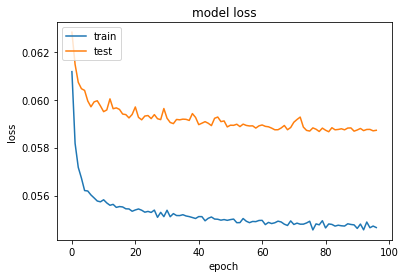

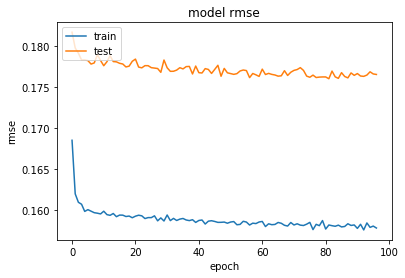

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate performance on validation data to improve model

In [12]:
model.load_weights(experiment_name+'.hdf5')

(5870, 25, 3) (5870, 10, 3)


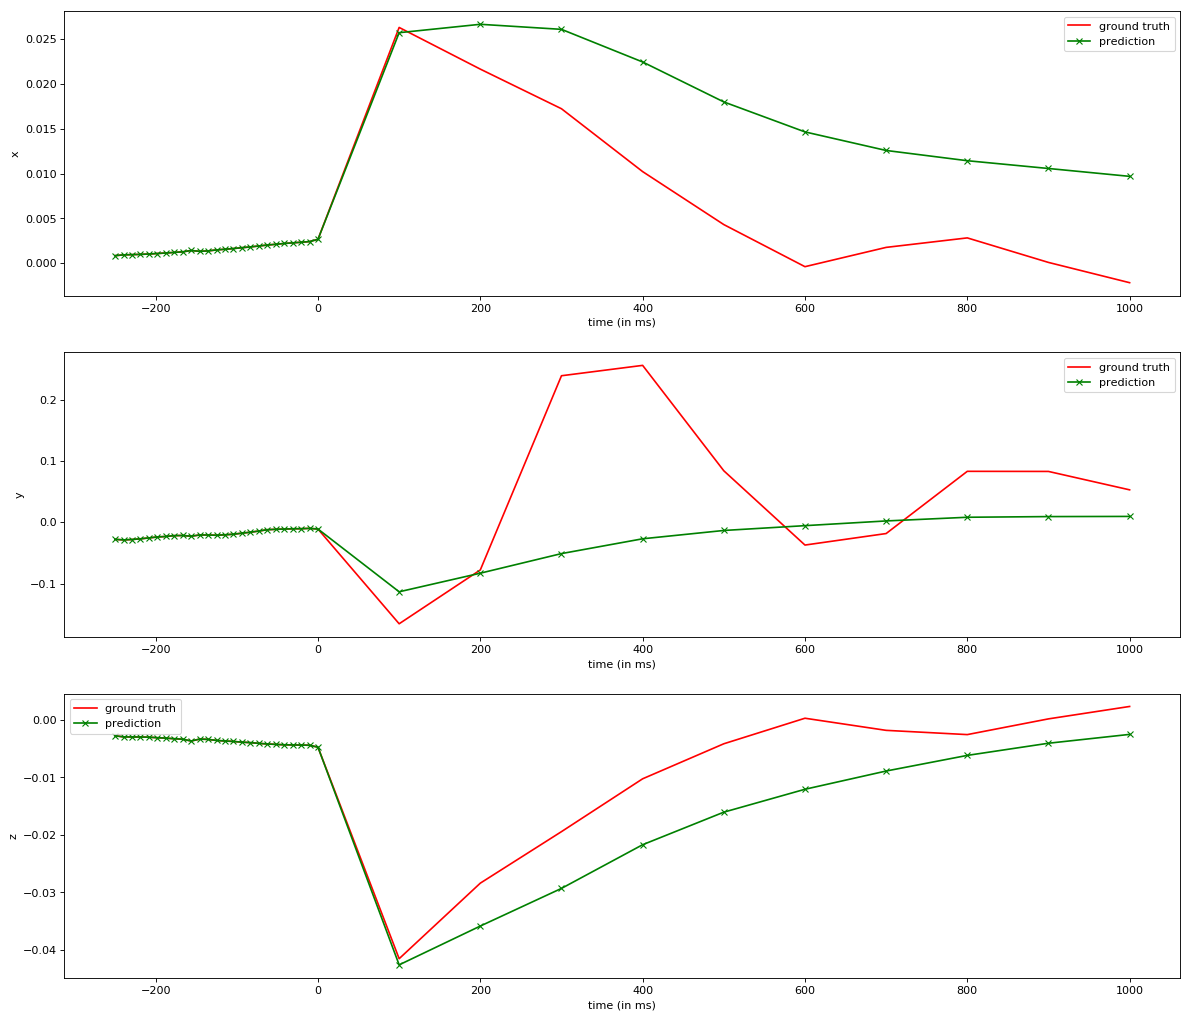

In [13]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )


predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

def get_mae(Y1, Y2):
    return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)


start = time.time()
print("Evaluating on validation data...")
count = 0
for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #Y_pred = model.predict([encoder_input, decoder_input], verbose=0)
    Y_pred_diff = model.predict([encoder_input, decoder_input[:, 1:]], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]
        
    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)

    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[:,ind_delay]
        Y_delay_val = Y_val_abs[:,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating on validation data...


Evaluation Time :  48.494736433029175 s =  0.8082456191380819 min =  0.013470760385195414 h


### Metrics

In [15]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.05932474467864171
Delay 100 ms: 0.004309641713905507
Delay 200 ms: 0.01310601851348146
Delay 300 ms: 0.024556300936181313
Delay 400 ms: 0.03733154212768086
Delay 500 ms: 0.050810631672008506
Delay 600 ms: 0.06469523518469968
Delay 700 ms: 0.07873331941201449
Delay 800 ms: 0.09276709944403172
Delay 900 ms: 0.10665924664392404
Delay 1000 ms: 0.12027841113848939

RMSE
Average rmse: 0.12514332986834525
Delay 100 ms: 0.011726653824564575
Delay 200 ms: 0.02823260613045595
Delay 300 ms: 0.04916314078894898
Delay 400 ms: 0.07180818080735815
Delay 500 ms: 0.09505411628611084
Delay 600 ms: 0.11839356234550641
Delay 700 ms: 0.14145902004638086
Delay 800 ms: 0.16406628354131855
Delay 900 ms: 0.18607579187497636
Delay 1000 ms: 0.20735096104224915

SMAPE
Average smape: 14.526351649035991
Delay 100 ms: 2.2639517050768867
Delay 200 ms: 5.454093620153725
Delay 300 ms: 8.569869759895063
Delay 400 ms: 11.466065885133064
Delay 500 ms: 14.104491604148057
Delay 600 ms: 16.527674946841458
